In [1]:
import torch
from torch.nn import MSELoss
from tqdm import trange
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np
import pickle
import wandb

from torch.utils.data import Dataset, DataLoader, Subset, random_split
import tonic

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

class CCMKDataset(Dataset):
    def __init__(self, spikes_tensor, labels_tensor, nchannels=None, target_label=2, seed=None, device=None):
        if seed is not None:
            np.random.seed(seed)
            torch.manual_seed(seed)
        
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.spikes_tensor = spikes_tensor.to(device)
        self.labels_tensor = labels_tensor.to(device)

        if nchannels is not None:
            self.spikes_tensor = self.spikes_tensor[:, nchannels, :]
        
        # Ignore labels 1, 3, and 4
        valid_mask = (self.labels_tensor == 0) | (self.labels_tensor == target_label)
        self.spikes_tensor = self.spikes_tensor[valid_mask]
        self.labels_tensor = self.labels_tensor[valid_mask]
        
        # Convert the target label (2) to 1
        self.labels_tensor[self.labels_tensor == target_label] = 1
        
        # Downsampling: Match the number of label 0 samples to the number of label 1 samples
        label_0_indices = torch.where(self.labels_tensor == 0)[0]
        label_1_indices = torch.where(self.labels_tensor == 1)[0]
        num_samples = min(len(label_1_indices), len(label_0_indices))

        # Randomly sample from label 0 and label 1 indices
        #CPU
        # selected_label_0_indices = torch.tensor(np.random.choice(label_0_indices.cpu(), size=num_samples, replace=False), device=self.device)
        # selected_label_1_indices = torch.tensor(np.random.choice(label_1_indices.cpu(), size=num_samples, replace=False), device=self.device)

        # GPU
        selected_label_0_indices = label_0_indices[torch.randperm(len(label_0_indices))[:num_samples]].to(self.device)
        selected_label_1_indices = label_1_indices[torch.randperm(len(label_1_indices))[:num_samples]].to(self.device)


        # Combine the downsampled label 0 indices with label 1 indices
        balanced_indices = torch.cat([selected_label_0_indices, selected_label_1_indices])

        # Apply the balanced indices to spikes and labels
        self.spikes_tensor = self.spikes_tensor[balanced_indices]
        self.labels_tensor = self.labels_tensor[balanced_indices]

        # Debugging: Check the distribution of labels after processing
        print(f"Filtered Labels distribution after processing: {torch.bincount(self.labels_tensor.int().cpu())}")

    def __len__(self):
        return len(self.labels_tensor)
    
    def __getitem__(self, idx):
        spike_data = self.spikes_tensor[idx]
        label = self.labels_tensor[idx]
        return spike_data, label

c:\Users\Angela\anaconda3\envs\capstone_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_loader = torch.load('saved_loaders_bs32/train_loader.pth')
val_loader = torch.load('saved_loaders_bs32/val_loader.pth')
test_loader = torch.load('saved_loaders_bs32/test_loader.pth')

C:\Users\Angela\AppData\Local\Temp\ipykernel_37372\3645305366.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_loader = torch.load('saved_loaders_bs32/train_loader.

In [4]:
from rockpool.nn.networks import SynNet
from rockpool.nn.modules import LIFTorch as LIFOtherSpiking

n_channels = 16  
n_classes = 1   
n_time = 101
dt = 10e-3     

baseline = SynNet(
    output="vmem",
    n_channels=n_channels,                        
    n_classes=n_classes,
    dt=dt,                           
    size_hidden_layers=[24, 24, 24],        
    time_constants_per_layer=[4, 8, 10],
    tau_syn_base=0.02,  
    tau_mem=0.02,
    tau_syn_out=0.02
)

print(baseline)

SynNet  with shape (16, 1) {
    TorchSequential 'seq' with shape (16, 1) {
        LinearTorch '0_LinearTorch' with shape (16, 24)
        LIFTorch '1_LIFTorch' with shape (24, 24)
        TimeStepDropout '2_TimeStepDropout' with shape (24,)
        LinearTorch '3_LinearTorch' with shape (24, 24)
        LIFTorch '4_LIFTorch' with shape (24, 24)
        TimeStepDropout '5_TimeStepDropout' with shape (24,)
        LinearTorch '6_LinearTorch' with shape (24, 24)
        LIFTorch '7_LIFTorch' with shape (24, 24)
        TimeStepDropout '8_TimeStepDropout' with shape (24,)
        LinearTorch '9_LinearTorch' with shape (24, 1)
        LIFTorch '10_LIFTorch' with shape (1, 1)
    }
}


In [5]:
import os
os.environ["WANDB_NOTEBOOK_NAME"] = "baseline_model.ipynb"

In [6]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


True
NVIDIA GeForce RTX 4070 SUPER


In [7]:
import torch
print(torch.__version__)

2.4.1+cu124


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: angelajcnto (angelajcnto-the-university-of-western-australia). Use `wandb login --relogin` to force relogin


  0%|          | 1/200 [00:15<50:38, 15.27s/it]

Epoch 1/200, Training Loss: 0.9301557608370511, Validation Loss: 0.7497607703719821


  1%|          | 2/200 [00:29<48:30, 14.70s/it]

Epoch 2/200, Training Loss: 0.8408245298097718, Validation Loss: 0.7100892801369939


  2%|▏         | 3/200 [00:43<46:48, 14.25s/it]

Epoch 3/200, Training Loss: 0.803200511437542, Validation Loss: 0.7264263331890106


  2%|▏         | 4/200 [00:56<45:44, 14.00s/it]

Epoch 4/200, Training Loss: 0.8028278373322397, Validation Loss: 0.7682779324906213


  2%|▎         | 5/200 [01:11<46:04, 14.18s/it]

Epoch 5/200, Training Loss: 0.7762466826528873, Validation Loss: 0.8058306532246726


  3%|▎         | 6/200 [01:25<46:05, 14.25s/it]

Epoch 6/200, Training Loss: 0.7848613869469121, Validation Loss: 0.7061037995985576


  4%|▎         | 7/200 [01:39<45:43, 14.21s/it]

Epoch 7/200, Training Loss: 0.7134712197870579, Validation Loss: 0.6891550017254693


  4%|▍         | 8/200 [01:54<45:39, 14.27s/it]

Epoch 8/200, Training Loss: 0.7256084961711236, Validation Loss: 0.6976438249860492


  4%|▍         | 9/200 [02:08<45:06, 14.17s/it]

Epoch 9/200, Training Loss: 0.7332893649362168, Validation Loss: 0.7530945049864906


  5%|▌         | 10/200 [02:21<44:20, 14.00s/it]

Epoch 10/200, Training Loss: 0.7051203172161894, Validation Loss: 0.6253672306026731


  6%|▌         | 11/200 [02:35<43:49, 13.91s/it]

Epoch 11/200, Training Loss: 0.6749607993746704, Validation Loss: 0.6400887380753245


  6%|▌         | 12/200 [02:50<44:09, 14.10s/it]

Epoch 12/200, Training Loss: 0.6862438529167535, Validation Loss: 0.7062454308782306


  6%|▋         | 13/200 [03:03<43:31, 13.97s/it]

Epoch 13/200, Training Loss: 0.6816506886257315, Validation Loss: 0.7196739188262394


  7%|▋         | 14/200 [03:17<43:23, 14.00s/it]

Epoch 14/200, Training Loss: 0.6694984947735408, Validation Loss: 0.6493407211133412


  8%|▊         | 15/200 [03:32<43:43, 14.18s/it]

Epoch 15/200, Training Loss: 0.6645417899455665, Validation Loss: 0.6222072978104863


  8%|▊         | 16/200 [03:46<43:28, 14.18s/it]

Epoch 16/200, Training Loss: 0.6299790087735878, Validation Loss: 0.6964486049754279


  8%|▊         | 17/200 [04:00<42:53, 14.06s/it]

Epoch 17/200, Training Loss: 0.6610451604960099, Validation Loss: 0.6502820934568133


  9%|▉         | 18/200 [04:14<42:39, 14.07s/it]

Epoch 18/200, Training Loss: 0.6324504214637684, Validation Loss: 0.6465615012816021


 10%|▉         | 19/200 [04:28<42:17, 14.02s/it]

Epoch 19/200, Training Loss: 0.6541117992041245, Validation Loss: 0.6497159483177322


 10%|█         | 20/200 [04:43<42:48, 14.27s/it]

Epoch 20/200, Training Loss: 0.6269473793371668, Validation Loss: 0.6987938391310828


 10%|█         | 21/200 [04:57<42:10, 14.14s/it]

Epoch 21/200, Training Loss: 0.6355315233176609, Validation Loss: 0.6737567612103054


 11%|█         | 22/200 [05:10<41:30, 13.99s/it]

Epoch 22/200, Training Loss: 0.6283938597958043, Validation Loss: 0.6454425368990216


 12%|█▏        | 23/200 [05:24<41:12, 13.97s/it]

Epoch 23/200, Training Loss: 0.6425005686732957, Validation Loss: 0.6492606273719242


 12%|█▏        | 24/200 [05:39<41:31, 14.16s/it]

Epoch 24/200, Training Loss: 0.6320413632212944, Validation Loss: 0.6205090688807624


 12%|█▎        | 25/200 [05:53<40:56, 14.04s/it]

Epoch 25/200, Training Loss: 0.6196004737098262, Validation Loss: 0.6170640247208732


 13%|█▎        | 26/200 [06:06<40:15, 13.88s/it]

Epoch 26/200, Training Loss: 0.6251586563182328, Validation Loss: 0.6195490487984249


 14%|█▎        | 27/200 [06:19<39:32, 13.71s/it]

Epoch 27/200, Training Loss: 0.6313324863055967, Validation Loss: 0.5925135548625674


 14%|█▍        | 28/200 [06:33<39:22, 13.74s/it]

Epoch 28/200, Training Loss: 0.6158750568920711, Validation Loss: 0.5866651386022568


 14%|█▍        | 29/200 [06:47<38:54, 13.65s/it]

Epoch 29/200, Training Loss: 0.595862367243137, Validation Loss: 0.6085813449961799


 15%|█▌        | 30/200 [07:00<38:38, 13.64s/it]

Epoch 30/200, Training Loss: 0.5786173259312252, Validation Loss: 0.6670105734041759


 16%|█▌        | 31/200 [07:14<38:33, 13.69s/it]

Epoch 31/200, Training Loss: 0.6015242422526738, Validation Loss: 0.639123868729387


 16%|█▌        | 32/200 [07:28<38:26, 13.73s/it]

Epoch 32/200, Training Loss: 0.5989458909574544, Validation Loss: 0.6106059402227402


 16%|█▋        | 33/200 [07:42<38:41, 13.90s/it]

Epoch 33/200, Training Loss: 0.6130824988743044, Validation Loss: 0.595433979162148


 17%|█▋        | 34/200 [07:56<38:13, 13.82s/it]

Epoch 34/200, Training Loss: 0.574044867506567, Validation Loss: 0.6088063589164189


 18%|█▊        | 35/200 [08:09<37:46, 13.74s/it]

Epoch 35/200, Training Loss: 0.5827583147669738, Validation Loss: 0.6244988026363509


 18%|█▊        | 36/200 [08:23<37:15, 13.63s/it]

Epoch 36/200, Training Loss: 0.5924439413367577, Validation Loss: 0.5883641839027405


 18%|█▊        | 37/200 [08:36<37:00, 13.62s/it]

Epoch 37/200, Training Loss: 0.6105251098578831, Validation Loss: 0.5828011642609324


 19%|█▉        | 38/200 [08:49<36:11, 13.40s/it]

Epoch 38/200, Training Loss: 0.5835230170555834, Validation Loss: 0.6401082330516407


 20%|█▉        | 39/200 [09:02<35:31, 13.24s/it]

Epoch 39/200, Training Loss: 0.5779648282617893, Validation Loss: 0.5812798004065242


 20%|██        | 40/200 [09:15<34:54, 13.09s/it]

Epoch 40/200, Training Loss: 0.5635948822183429, Validation Loss: 0.5720969177782536


 20%|██        | 41/200 [09:28<34:28, 13.01s/it]

Epoch 41/200, Training Loss: 0.5863264692279527, Validation Loss: 0.5448977085096496


 21%|██        | 42/200 [09:40<34:01, 12.92s/it]

Epoch 42/200, Training Loss: 0.5973902940750122, Validation Loss: 0.6065942171428885


 22%|██▏       | 43/200 [09:53<33:46, 12.91s/it]

Epoch 43/200, Training Loss: 0.5764798530430164, Validation Loss: 0.684938017811094


 22%|██▏       | 44/200 [10:06<33:27, 12.87s/it]

Epoch 44/200, Training Loss: 0.5792798124394327, Validation Loss: 0.7103814615734986


 22%|██▎       | 45/200 [10:19<33:15, 12.87s/it]

Epoch 45/200, Training Loss: 0.5674981680118812, Validation Loss: 0.5702833384275436


 23%|██▎       | 46/200 [10:32<33:24, 13.01s/it]

Epoch 46/200, Training Loss: 0.5703989239233844, Validation Loss: 0.5747041361672538


 24%|██▎       | 47/200 [10:45<33:22, 13.09s/it]

Epoch 47/200, Training Loss: 0.5759639312636178, Validation Loss: 0.53290734652962


 24%|██▍       | 48/200 [10:58<33:02, 13.04s/it]

Epoch 48/200, Training Loss: 0.5623874782391314, Validation Loss: 0.6120985597372055


 24%|██▍       | 49/200 [11:11<32:39, 12.98s/it]

Epoch 49/200, Training Loss: 0.540943388387842, Validation Loss: 0.6001680647688252


 25%|██▌       | 50/200 [11:25<32:52, 13.15s/it]

Epoch 50/200, Training Loss: 0.5641433692203378, Validation Loss: 0.6588652070079531


 26%|██▌       | 51/200 [11:38<32:33, 13.11s/it]

Epoch 51/200, Training Loss: 0.5697480198347343, Validation Loss: 0.5981229022145271


 26%|██▌       | 52/200 [11:51<32:06, 13.02s/it]

Epoch 52/200, Training Loss: 0.559380903558911, Validation Loss: 0.5843116619757244


 26%|██▋       | 53/200 [12:04<31:53, 13.02s/it]

Epoch 53/200, Training Loss: 0.5709205441317469, Validation Loss: 0.5665006541780063


 27%|██▋       | 54/200 [12:16<31:30, 12.95s/it]

Epoch 54/200, Training Loss: 0.5568705729718478, Validation Loss: 0.7133292055555752


 28%|██▊       | 55/200 [12:29<31:11, 12.91s/it]

Epoch 55/200, Training Loss: 0.5400585942673233, Validation Loss: 0.6145905474466937


 28%|██▊       | 56/200 [12:42<30:55, 12.88s/it]

Epoch 56/200, Training Loss: 0.5625534648040555, Validation Loss: 0.5980421304702759


 28%|██▊       | 57/200 [12:55<30:45, 12.91s/it]

Epoch 57/200, Training Loss: 0.5295498241793435, Validation Loss: 0.5801996865442821


 29%|██▉       | 58/200 [13:08<30:30, 12.89s/it]

Epoch 58/200, Training Loss: 0.538647361240297, Validation Loss: 0.5651045037167413


 30%|██▉       | 59/200 [13:21<30:33, 13.01s/it]

Epoch 59/200, Training Loss: 0.5097866536311384, Validation Loss: 0.5647238471678325


 30%|███       | 60/200 [13:35<30:36, 13.12s/it]

Epoch 60/200, Training Loss: 0.5328251663243996, Validation Loss: 0.5704040059021541


 30%|███       | 61/200 [13:47<30:11, 13.03s/it]

Epoch 61/200, Training Loss: 0.5151976971131451, Validation Loss: 0.5341442770191601


 31%|███       | 62/200 [14:00<29:49, 12.97s/it]

Epoch 62/200, Training Loss: 0.5101490529640665, Validation Loss: 0.5527073591947556


 32%|███▏      | 63/200 [14:14<30:12, 13.23s/it]

Epoch 63/200, Training Loss: 0.4959769586347184, Validation Loss: 0.5954918020537922


 32%|███▏      | 64/200 [14:27<29:53, 13.19s/it]

Epoch 64/200, Training Loss: 0.5188257300628806, Validation Loss: 0.5933706845555987


 32%|███▎      | 65/200 [14:40<29:39, 13.18s/it]

Epoch 65/200, Training Loss: 0.5168504574388828, Validation Loss: 0.5206503740378788


 33%|███▎      | 66/200 [14:53<29:14, 13.10s/it]

Epoch 66/200, Training Loss: 0.4863851953227565, Validation Loss: 0.5315235363585609


 34%|███▎      | 67/200 [15:06<28:55, 13.05s/it]

Epoch 67/200, Training Loss: 0.4907219258119475, Validation Loss: 0.5343359517199653


 34%|███▍      | 68/200 [15:19<28:38, 13.02s/it]

Epoch 68/200, Training Loss: 0.4717147944951957, Validation Loss: 0.5486198727573667


 34%|███▍      | 69/200 [15:32<28:22, 12.99s/it]

Epoch 69/200, Training Loss: 0.4790706977529346, Validation Loss: 0.5710231267980167


 35%|███▌      | 70/200 [15:45<28:04, 12.96s/it]

Epoch 70/200, Training Loss: 0.4848002662073891, Validation Loss: 0.5631878482443946


 36%|███▌      | 71/200 [15:58<27:46, 12.92s/it]

Epoch 71/200, Training Loss: 0.47901980213399203, Validation Loss: 0.5307309276291302


 36%|███▌      | 72/200 [16:11<28:03, 13.15s/it]

Epoch 72/200, Training Loss: 0.4576281477820198, Validation Loss: 0.5313940889069012


 36%|███▋      | 73/200 [16:25<27:50, 13.15s/it]

Epoch 73/200, Training Loss: 0.4652687609195709, Validation Loss: 0.5546374214547021


 37%|███▋      | 74/200 [16:37<27:21, 13.03s/it]

Epoch 74/200, Training Loss: 0.45435460811516026, Validation Loss: 0.5255381273371833


 38%|███▊      | 75/200 [16:50<27:03, 12.99s/it]

Epoch 75/200, Training Loss: 0.4542829009159556, Validation Loss: 0.49601901109729496


 38%|███▊      | 76/200 [17:04<27:14, 13.18s/it]

Epoch 76/200, Training Loss: 0.45851137728061314, Validation Loss: 0.5740928735051837


 38%|███▊      | 77/200 [17:17<27:03, 13.20s/it]

Epoch 77/200, Training Loss: 0.4571754715914996, Validation Loss: 0.497476543698992


 39%|███▉      | 78/200 [17:30<26:36, 13.08s/it]

Epoch 78/200, Training Loss: 0.44444239870557245, Validation Loss: 0.510142805320876


 40%|███▉      | 79/200 [17:43<26:09, 12.97s/it]

Epoch 79/200, Training Loss: 0.4461837503707634, Validation Loss: 0.5187305861285755


 40%|████      | 80/200 [17:55<25:47, 12.90s/it]

Epoch 80/200, Training Loss: 0.43280019625177923, Validation Loss: 0.5216992263283048


 40%|████      | 81/200 [18:08<25:37, 12.92s/it]

Epoch 81/200, Training Loss: 0.44244650203102037, Validation Loss: 0.5292940820966449


 41%|████      | 82/200 [18:21<25:20, 12.88s/it]

Epoch 82/200, Training Loss: 0.43000229349676167, Validation Loss: 0.5104902301515851


 42%|████▏     | 83/200 [18:34<25:04, 12.86s/it]

Epoch 83/200, Training Loss: 0.4235786146150445, Validation Loss: 0.4878220707178116


 42%|████▏     | 84/200 [18:47<24:52, 12.87s/it]

Epoch 84/200, Training Loss: 0.4274533970176049, Validation Loss: 0.5054031184741429


 42%|████▎     | 85/200 [19:00<25:04, 13.08s/it]

Epoch 85/200, Training Loss: 0.4269097332122191, Validation Loss: 0.46950153580733706


 43%|████▎     | 86/200 [19:14<24:59, 13.15s/it]

Epoch 86/200, Training Loss: 0.4293026617675457, Validation Loss: 0.5129994664873395


 44%|████▎     | 87/200 [19:27<24:38, 13.09s/it]

Epoch 87/200, Training Loss: 0.38383168916938437, Validation Loss: 0.48804779989378794


 44%|████▍     | 88/200 [19:39<24:18, 13.02s/it]

Epoch 88/200, Training Loss: 0.41205866283403253, Validation Loss: 0.5284130488123212


 44%|████▍     | 89/200 [19:53<24:33, 13.28s/it]

Epoch 89/200, Training Loss: 0.3968161613030254, Validation Loss: 0.48168270928519114


 45%|████▌     | 90/200 [20:06<24:13, 13.22s/it]

Epoch 90/200, Training Loss: 0.38909408140857266, Validation Loss: 0.46187882125377655


 46%|████▌     | 91/200 [20:19<23:46, 13.09s/it]

Epoch 91/200, Training Loss: 0.3775066792402627, Validation Loss: 0.4405267834663391


 46%|████▌     | 92/200 [20:32<23:26, 13.03s/it]

Epoch 92/200, Training Loss: 0.390177883067221, Validation Loss: 0.47156706026622225


 46%|████▋     | 93/200 [20:45<23:13, 13.02s/it]

Epoch 93/200, Training Loss: 0.37185991372702254, Validation Loss: 0.48486630831445965


 47%|████▋     | 94/200 [20:58<22:55, 12.98s/it]

Epoch 94/200, Training Loss: 0.36495552507211576, Validation Loss: 0.46797436475753784


 48%|████▊     | 95/200 [21:11<22:35, 12.91s/it]

Epoch 95/200, Training Loss: 0.36380179437263954, Validation Loss: 0.43803021737507414


 48%|████▊     | 96/200 [21:24<22:25, 12.94s/it]

Epoch 96/200, Training Loss: 0.3491906585558405, Validation Loss: 0.4545897479568209


 48%|████▊     | 97/200 [21:37<22:11, 12.93s/it]

Epoch 97/200, Training Loss: 0.3521726910235747, Validation Loss: 0.4782140233686992


 49%|████▉     | 98/200 [21:50<22:14, 13.09s/it]

Epoch 98/200, Training Loss: 0.3499633101922161, Validation Loss: 0.46145813167095184


 50%|████▉     | 99/200 [22:03<22:04, 13.12s/it]

Epoch 99/200, Training Loss: 0.371919276860525, Validation Loss: 0.4208385944366455


 50%|█████     | 100/200 [22:16<21:45, 13.05s/it]

Epoch 100/200, Training Loss: 0.3433005840710874, Validation Loss: 0.43426746342863354


 50%|█████     | 101/200 [22:29<21:27, 13.00s/it]

Epoch 101/200, Training Loss: 0.3460306696734338, Validation Loss: 0.5158336609601974


 51%|█████     | 102/200 [22:43<21:39, 13.26s/it]

Epoch 102/200, Training Loss: 0.35319448332741576, Validation Loss: 0.4249035971505301


 52%|█████▏    | 103/200 [22:56<21:22, 13.22s/it]

Epoch 103/200, Training Loss: 0.32898443009493483, Validation Loss: 0.469977400132588


 52%|█████▏    | 104/200 [23:09<20:59, 13.12s/it]

Epoch 104/200, Training Loss: 0.33737876902351965, Validation Loss: 0.4335450253316334


 52%|█████▎    | 105/200 [23:22<20:44, 13.10s/it]

Epoch 105/200, Training Loss: 0.3514708477371144, Validation Loss: 0.45513697607176645


 53%|█████▎    | 106/200 [23:35<20:25, 13.03s/it]

Epoch 106/200, Training Loss: 0.3430865168009164, Validation Loss: 0.4404578038624355


 54%|█████▎    | 107/200 [23:48<20:05, 12.96s/it]

Epoch 107/200, Training Loss: 0.32449903353205267, Validation Loss: 0.48140678661210196


 54%|█████▍    | 108/200 [24:00<19:46, 12.90s/it]

Epoch 108/200, Training Loss: 0.32970543318199663, Validation Loss: 0.4494082863841738


 55%|█████▍    | 109/200 [24:13<19:36, 12.93s/it]

Epoch 109/200, Training Loss: 0.320998785068404, Validation Loss: 0.4457332747323172


 55%|█████▌    | 110/200 [24:26<19:21, 12.91s/it]

Epoch 110/200, Training Loss: 0.32744609353677284, Validation Loss: 0.45789984294346403


 56%|█████▌    | 111/200 [24:40<19:26, 13.11s/it]

Epoch 111/200, Training Loss: 0.31889938577166144, Validation Loss: 0.44428025611809324


 56%|█████▌    | 112/200 [24:53<19:18, 13.17s/it]

Epoch 112/200, Training Loss: 0.32060016621396226, Validation Loss: 0.5156443672520774


 56%|█████▋    | 113/200 [25:06<19:04, 13.16s/it]

Epoch 113/200, Training Loss: 0.31997827229634773, Validation Loss: 0.41601993782179697


 57%|█████▋    | 114/200 [25:19<18:43, 13.07s/it]

Epoch 114/200, Training Loss: 0.3163652536722849, Validation Loss: 0.4510656488793237


 57%|█████▊    | 115/200 [25:33<18:43, 13.22s/it]

Epoch 115/200, Training Loss: 0.3293394620688456, Validation Loss: 0.4106263028723853


 58%|█████▊    | 116/200 [25:46<18:27, 13.18s/it]

Epoch 116/200, Training Loss: 0.3306115891011256, Validation Loss: 0.500896251627377


 58%|█████▊    | 117/200 [25:59<18:09, 13.13s/it]

Epoch 117/200, Training Loss: 0.3072994902448834, Validation Loss: 0.4221255970852716


 59%|█████▉    | 118/200 [26:12<17:50, 13.05s/it]

Epoch 118/200, Training Loss: 0.32550515079835673, Validation Loss: 0.4459328034094402


 60%|█████▉    | 119/200 [26:25<17:31, 12.98s/it]

Epoch 119/200, Training Loss: 0.32439407270472004, Validation Loss: 0.42169542823519024


 60%|██████    | 120/200 [26:37<17:16, 12.95s/it]

Epoch 120/200, Training Loss: 0.32215355927089473, Validation Loss: 0.4148433676787785


 60%|██████    | 121/200 [26:50<17:01, 12.93s/it]

Epoch 121/200, Training Loss: 0.31979034728599043, Validation Loss: 0.4328823323760714


 61%|██████    | 122/200 [27:03<16:49, 12.94s/it]

Epoch 122/200, Training Loss: 0.30107463938447665, Validation Loss: 0.4417434632778168


 62%|██████▏   | 123/200 [27:16<16:36, 12.94s/it]

Epoch 123/200, Training Loss: 0.31173490943773735, Validation Loss: 0.44387725421360563


 62%|██████▏   | 124/200 [27:30<16:34, 13.09s/it]

Epoch 124/200, Training Loss: 0.3151381490927822, Validation Loss: 0.43979325677667347


 62%|██████▎   | 125/200 [27:43<16:27, 13.17s/it]

Epoch 125/200, Training Loss: 0.31272879917666596, Validation Loss: 0.4257562352078302


 63%|██████▎   | 126/200 [27:56<16:10, 13.11s/it]

Epoch 126/200, Training Loss: 0.3068571075234773, Validation Loss: 0.4288847659315382


 64%|██████▎   | 127/200 [28:09<15:51, 13.04s/it]

Epoch 127/200, Training Loss: 0.30270283851983415, Validation Loss: 0.42618473725659506


 64%|██████▍   | 128/200 [28:23<15:55, 13.27s/it]

Epoch 128/200, Training Loss: 0.3032143638943726, Validation Loss: 0.4088067391089031


 64%|██████▍   | 129/200 [28:36<15:35, 13.18s/it]

Epoch 129/200, Training Loss: 0.31306884437799454, Validation Loss: 0.4822282578263964


 65%|██████▌   | 130/200 [28:49<15:22, 13.18s/it]

Epoch 130/200, Training Loss: 0.29822889448336837, Validation Loss: 0.4271011416401182


 66%|██████▌   | 131/200 [29:02<15:03, 13.09s/it]

Epoch 131/200, Training Loss: 0.30582962227317523, Validation Loss: 0.4498710589749472


 66%|██████▌   | 132/200 [29:14<14:44, 13.01s/it]

Epoch 132/200, Training Loss: 0.29939708936045756, Validation Loss: 0.4354058674403599


 66%|██████▋   | 133/200 [29:27<14:28, 12.97s/it]

Epoch 133/200, Training Loss: 0.31339128484141154, Validation Loss: 0.43073454073497225


 67%|██████▋   | 134/200 [29:40<14:14, 12.94s/it]

Epoch 134/200, Training Loss: 0.3213093173953722, Validation Loss: 0.39718766510486603


 68%|██████▊   | 135/200 [29:53<14:04, 12.99s/it]

Epoch 135/200, Training Loss: 0.3160330743159888, Validation Loss: 0.4593950850622995


 68%|██████▊   | 136/200 [30:06<13:49, 12.97s/it]

Epoch 136/200, Training Loss: 0.3018950654088326, Validation Loss: 0.41889017607484547


 68%|██████▊   | 137/200 [30:20<13:47, 13.14s/it]

Epoch 137/200, Training Loss: 0.30950193767840006, Validation Loss: 0.4157711608069284


 69%|██████▉   | 138/200 [30:33<13:41, 13.24s/it]

Epoch 138/200, Training Loss: 0.31611048978454664, Validation Loss: 0.434799177306039


 70%|██████▉   | 139/200 [30:46<13:19, 13.11s/it]

Epoch 139/200, Training Loss: 0.2912268190170234, Validation Loss: 0.4301234036684036


 70%|███████   | 140/200 [30:59<13:05, 13.10s/it]

Epoch 140/200, Training Loss: 0.3005756803278653, Validation Loss: 0.3859265276363918


 70%|███████   | 141/200 [31:13<13:01, 13.25s/it]

Epoch 141/200, Training Loss: 0.30318624821473966, Validation Loss: 0.4174406166587557


 71%|███████   | 142/200 [31:26<12:43, 13.16s/it]

Epoch 142/200, Training Loss: 0.29083512273599516, Validation Loss: 0.4052510751145227


 72%|███████▏  | 143/200 [31:39<12:25, 13.08s/it]

Epoch 143/200, Training Loss: 0.298024464609488, Validation Loss: 0.40156606691224234


 72%|███████▏  | 144/200 [31:52<12:12, 13.07s/it]

Epoch 144/200, Training Loss: 0.292702021745016, Validation Loss: 0.3942586545433317


 72%|███████▎  | 145/200 [32:04<11:55, 13.00s/it]

Epoch 145/200, Training Loss: 0.29089325652369913, Validation Loss: 0.4184126492057528


 73%|███████▎  | 146/200 [32:17<11:39, 12.95s/it]

Epoch 146/200, Training Loss: 0.3007031406434077, Validation Loss: 0.42638043633529116


 74%|███████▎  | 147/200 [32:30<11:27, 12.97s/it]

Epoch 147/200, Training Loss: 0.29104785888262513, Validation Loss: 0.3968766118798937


 74%|███████▍  | 148/200 [32:43<11:16, 13.00s/it]

Epoch 148/200, Training Loss: 0.2935131720776828, Validation Loss: 0.38312828966549467


 74%|███████▍  | 149/200 [32:56<11:01, 12.97s/it]

Epoch 149/200, Training Loss: 0.29773545968082715, Validation Loss: 0.4120226097958429


 75%|███████▌  | 150/200 [33:10<10:59, 13.19s/it]

Epoch 150/200, Training Loss: 0.3242460386651867, Validation Loss: 0.40590303923402515


 76%|███████▌  | 151/200 [33:23<10:50, 13.27s/it]

Epoch 151/200, Training Loss: 0.28564681464208747, Validation Loss: 0.4637021230799811


 76%|███████▌  | 152/200 [33:36<10:33, 13.20s/it]

Epoch 152/200, Training Loss: 0.28066429102195883, Validation Loss: 0.42098541877099444


 76%|███████▋  | 153/200 [33:49<10:16, 13.11s/it]

Epoch 153/200, Training Loss: 0.3056031420545758, Validation Loss: 0.44379590451717377


 77%|███████▋  | 154/200 [34:03<10:11, 13.28s/it]

Epoch 154/200, Training Loss: 0.2852672944372555, Validation Loss: 0.44964701575892313


 78%|███████▊  | 155/200 [34:16<09:56, 13.25s/it]

Epoch 155/200, Training Loss: 0.2826301955951835, Validation Loss: 0.40468632323401316


 78%|███████▊  | 156/200 [34:29<09:37, 13.13s/it]

Epoch 156/200, Training Loss: 0.2772460958024241, Validation Loss: 0.42131607234477997


 78%|███████▊  | 157/200 [34:42<09:24, 13.12s/it]

Epoch 157/200, Training Loss: 0.2836554747707439, Validation Loss: 0.4258696564606258


 79%|███████▉  | 158/200 [34:55<09:07, 13.03s/it]

Epoch 158/200, Training Loss: 0.29856443798766946, Validation Loss: 0.4503702329737799


 80%|███████▉  | 159/200 [35:08<08:53, 13.01s/it]

Epoch 159/200, Training Loss: 0.2835057072763173, Validation Loss: 0.3967354787247522


 80%|████████  | 160/200 [35:21<08:39, 12.98s/it]

Epoch 160/200, Training Loss: 0.27783631856711405, Validation Loss: 0.4124440423079899


 80%|████████  | 161/200 [35:34<08:27, 13.02s/it]

Epoch 161/200, Training Loss: 0.28536969830967346, Validation Loss: 0.405890275325094


 81%|████████  | 162/200 [35:47<08:13, 13.00s/it]

Epoch 162/200, Training Loss: 0.28630228129760277, Validation Loss: 0.41083902972085135


 82%|████████▏ | 163/200 [36:00<08:05, 13.13s/it]

Epoch 163/200, Training Loss: 0.27455549869897233, Validation Loss: 0.4032556691340038


 82%|████████▏ | 164/200 [36:14<07:54, 13.18s/it]

Epoch 164/200, Training Loss: 0.29340326687637364, Validation Loss: 0.3896665573120117


 82%|████████▎ | 165/200 [36:27<07:39, 13.14s/it]

Epoch 165/200, Training Loss: 0.270629364645706, Validation Loss: 0.3728049397468567


 83%|████████▎ | 166/200 [36:40<07:24, 13.08s/it]

Epoch 166/200, Training Loss: 0.28589515156059897, Validation Loss: 0.45705930037157877


 84%|████████▎ | 167/200 [36:53<07:18, 13.30s/it]

Epoch 167/200, Training Loss: 0.2751437807982823, Validation Loss: 0.45147545422826496


 84%|████████▍ | 168/200 [37:07<07:04, 13.27s/it]

Epoch 168/200, Training Loss: 0.2807799416752356, Validation Loss: 0.3999550278697695


 84%|████████▍ | 169/200 [37:20<06:48, 13.18s/it]

Epoch 169/200, Training Loss: 0.2855254668953284, Validation Loss: 0.4163233829396112


 85%|████████▌ | 170/200 [37:33<06:32, 13.09s/it]

Epoch 170/200, Training Loss: 0.2661022162943516, Validation Loss: 0.39747884443828035


 86%|████████▌ | 171/200 [37:46<06:19, 13.07s/it]

Epoch 171/200, Training Loss: 0.2780284109824109, Validation Loss: 0.392544618674687


 86%|████████▌ | 172/200 [37:59<06:05, 13.04s/it]

Epoch 172/200, Training Loss: 0.27503562788918334, Validation Loss: 0.41941824768270763


 86%|████████▋ | 173/200 [38:11<05:50, 12.98s/it]

Epoch 173/200, Training Loss: 0.26393776622442705, Validation Loss: 0.4038038083485195


 87%|████████▋ | 174/200 [38:24<05:36, 12.95s/it]

Epoch 174/200, Training Loss: 0.2857863664064767, Validation Loss: 0.41274808985846384


 88%|████████▊ | 175/200 [38:37<05:24, 12.99s/it]

Epoch 175/200, Training Loss: 0.2810730436500513, Validation Loss: 0.38717611346926006


 88%|████████▊ | 176/200 [38:51<05:15, 13.14s/it]

Epoch 176/200, Training Loss: 0.27434420163901346, Validation Loss: 0.40351361674921854


 88%|████████▊ | 177/200 [39:04<05:03, 13.19s/it]

Epoch 177/200, Training Loss: 0.2688882088042655, Validation Loss: 0.4207004244838442


 89%|████████▉ | 178/200 [39:17<04:49, 13.16s/it]

Epoch 178/200, Training Loss: 0.2709181585683013, Validation Loss: 0.40549307422978537


 90%|████████▉ | 179/200 [39:30<04:35, 13.10s/it]

Epoch 179/200, Training Loss: 0.28191586626025866, Validation Loss: 0.4200194776058197


 90%|█████████ | 180/200 [39:44<04:24, 13.22s/it]

Epoch 180/200, Training Loss: 0.26187570618008665, Validation Loss: 0.38460160366126467


 90%|█████████ | 181/200 [39:57<04:11, 13.22s/it]

Epoch 181/200, Training Loss: 0.2666467674217134, Validation Loss: 0.4068993202277592


 91%|█████████ | 182/200 [40:10<03:56, 13.13s/it]

Epoch 182/200, Training Loss: 0.2660852066188488, Validation Loss: 0.39311458596161436


 92%|█████████▏| 183/200 [40:23<03:42, 13.09s/it]

Epoch 183/200, Training Loss: 0.2627482796615025, Validation Loss: 0.3936375762735094


 92%|█████████▏| 184/200 [40:36<03:29, 13.10s/it]

Epoch 184/200, Training Loss: 0.2557968095226108, Validation Loss: 0.4420957693031856


 92%|█████████▎| 185/200 [40:49<03:15, 13.05s/it]

Epoch 185/200, Training Loss: 0.26422419005407477, Validation Loss: 0.40237613235201153


 93%|█████████▎| 186/200 [41:02<03:02, 13.02s/it]

Epoch 186/200, Training Loss: 0.288599783519529, Validation Loss: 0.44675053868974957


 94%|█████████▎| 187/200 [41:15<02:48, 12.97s/it]

Epoch 187/200, Training Loss: 0.2762488958970556, Validation Loss: 0.40380332299641203


 94%|█████████▍| 188/200 [41:28<02:35, 12.94s/it]

Epoch 188/200, Training Loss: 0.28488846502776416, Validation Loss: 0.455241967524801


 94%|█████████▍| 189/200 [41:41<02:24, 13.17s/it]

Epoch 189/200, Training Loss: 0.26528791717763217, Validation Loss: 0.3963555118867329


 95%|█████████▌| 190/200 [41:54<02:11, 13.16s/it]

Epoch 190/200, Training Loss: 0.2654429096377121, Validation Loss: 0.4268096706696919


 96%|█████████▌| 191/200 [42:07<01:58, 13.11s/it]

Epoch 191/200, Training Loss: 0.28595281912470766, Validation Loss: 0.3949965685606003


 96%|█████████▌| 192/200 [42:20<01:44, 13.10s/it]

Epoch 192/200, Training Loss: 0.2634924700799978, Validation Loss: 0.38815430658204214


 96%|█████████▋| 193/200 [42:34<01:33, 13.30s/it]

Epoch 193/200, Training Loss: 0.2586814002046045, Validation Loss: 0.42251230776309967


 97%|█████████▋| 194/200 [42:47<01:19, 13.23s/it]

Epoch 194/200, Training Loss: 0.2554228922949647, Validation Loss: 0.4109886246068137


 98%|█████████▊| 195/200 [43:00<01:05, 13.13s/it]

Epoch 195/200, Training Loss: 0.2620984969555207, Validation Loss: 0.3859567471912929


 98%|█████████▊| 196/200 [43:13<00:52, 13.06s/it]

Epoch 196/200, Training Loss: 0.2551223169485072, Validation Loss: 0.38755338319710325


 98%|█████████▊| 197/200 [43:26<00:39, 13.01s/it]

Epoch 197/200, Training Loss: 0.2534168837767727, Validation Loss: 0.42117815571171896


 99%|█████████▉| 198/200 [43:39<00:25, 12.99s/it]

Epoch 198/200, Training Loss: 0.25931716007444094, Validation Loss: 0.3765748292207718


100%|█████████▉| 199/200 [43:52<00:12, 12.98s/it]

Epoch 199/200, Training Loss: 0.258843258023262, Validation Loss: 0.4091720048870359


100%|██████████| 200/200 [44:05<00:00, 13.23s/it]

Epoch 200/200, Training Loss: 0.25880163296494846, Validation Loss: 0.4397969990968704
Final Accuracy: 93.42%, Precision: 0.93, Recall: 0.93


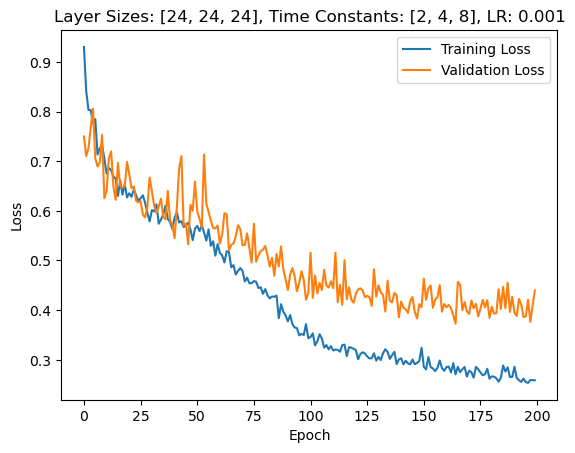

  0%|          | 1/200 [00:13<44:50, 13.52s/it]

Epoch 1/200, Training Loss: 1.0231404506935264, Validation Loss: 1.0151947566441126


  1%|          | 2/200 [00:27<44:33, 13.50s/it]

Epoch 2/200, Training Loss: 0.9839485400127914, Validation Loss: 0.8647475412913731


  2%|▏         | 3/200 [00:40<44:02, 13.41s/it]

Epoch 3/200, Training Loss: 0.9100726348049236, Validation Loss: 0.802301117352077


  2%|▏         | 4/200 [00:53<42:59, 13.16s/it]

Epoch 4/200, Training Loss: 0.9054200266892055, Validation Loss: 0.7769443477903094


  2%|▎         | 5/200 [01:06<42:32, 13.09s/it]

Epoch 5/200, Training Loss: 0.8656693348344767, Validation Loss: 0.8142786281449454


  3%|▎         | 6/200 [01:19<42:44, 13.22s/it]

Epoch 6/200, Training Loss: 0.8449897923559513, Validation Loss: 0.74420365691185


  4%|▎         | 7/200 [01:33<42:48, 13.31s/it]

Epoch 7/200, Training Loss: 0.8206034865019456, Validation Loss: 0.6883816186870847


  4%|▍         | 8/200 [01:46<42:45, 13.36s/it]

Epoch 8/200, Training Loss: 0.8026932590412643, Validation Loss: 0.7915958336421421


  4%|▍         | 9/200 [02:00<42:40, 13.41s/it]

Epoch 9/200, Training Loss: 0.8086608412130823, Validation Loss: 0.7035419430051532


  5%|▌         | 10/200 [02:13<42:39, 13.47s/it]

Epoch 10/200, Training Loss: 0.7875953249211581, Validation Loss: 0.6742794939449855


  6%|▌         | 11/200 [02:26<41:42, 13.24s/it]

Epoch 11/200, Training Loss: 0.7480954494116441, Validation Loss: 0.7056207443986621


  6%|▌         | 12/200 [02:39<41:03, 13.11s/it]

Epoch 12/200, Training Loss: 0.755197138718839, Validation Loss: 0.6977084406784603


  6%|▋         | 13/200 [02:52<41:16, 13.24s/it]

Epoch 13/200, Training Loss: 0.7103454639326852, Validation Loss: 0.6993697881698608


  7%|▋         | 14/200 [03:05<40:47, 13.16s/it]

Epoch 14/200, Training Loss: 0.7046392273228124, Validation Loss: 0.673948161303997


  8%|▊         | 15/200 [03:18<40:38, 13.18s/it]

Epoch 15/200, Training Loss: 0.6863869698542469, Validation Loss: 0.660148805805615


  8%|▊         | 16/200 [03:32<40:51, 13.32s/it]

Epoch 16/200, Training Loss: 0.6785959438332971, Validation Loss: 0.6379278930170196


  8%|▊         | 17/200 [03:46<40:48, 13.38s/it]

Epoch 17/200, Training Loss: 0.701630102013642, Validation Loss: 0.6297334964786258


  9%|▉         | 18/200 [03:58<39:59, 13.19s/it]

Epoch 18/200, Training Loss: 0.6705453648882093, Validation Loss: 0.7062404059938022


 10%|▉         | 19/200 [04:11<39:19, 13.04s/it]

Epoch 19/200, Training Loss: 0.6892717244490137, Validation Loss: 0.6571725606918335


 10%|█         | 20/200 [04:24<38:57, 12.98s/it]

Epoch 20/200, Training Loss: 0.6415302438556023, Validation Loss: 0.7250461887036052


 10%|█         | 21/200 [04:37<38:59, 13.07s/it]

Epoch 21/200, Training Loss: 0.6946173855718577, Validation Loss: 0.6510560257094247


 11%|█         | 22/200 [04:51<39:03, 13.17s/it]

Epoch 22/200, Training Loss: 0.6494752584763293, Validation Loss: 0.6338998058012554


 12%|█▏        | 23/200 [05:03<38:28, 13.04s/it]

Epoch 23/200, Training Loss: 0.6150907289307073, Validation Loss: 0.5692814184086663


 12%|█▏        | 24/200 [05:17<38:53, 13.26s/it]

Epoch 24/200, Training Loss: 0.610913170396157, Validation Loss: 0.6229602353913444


 12%|█▎        | 25/200 [05:30<38:24, 13.17s/it]

Epoch 25/200, Training Loss: 0.6529115337245869, Validation Loss: 0.579847409256867


 13%|█▎        | 26/200 [05:43<37:50, 13.05s/it]

Epoch 26/200, Training Loss: 0.6323991817123485, Validation Loss: 0.6015338748693466


 14%|█▎        | 27/200 [05:56<37:34, 13.03s/it]

Epoch 27/200, Training Loss: 0.6537913691322759, Validation Loss: 0.6138862403375762


 14%|█▍        | 28/200 [06:08<37:02, 12.92s/it]

Epoch 28/200, Training Loss: 0.6099351976277694, Validation Loss: 0.5882850076471057


 14%|█▍        | 29/200 [06:21<36:42, 12.88s/it]

Epoch 29/200, Training Loss: 0.5917401937943585, Validation Loss: 0.5509528134550367


 15%|█▌        | 30/200 [06:34<36:24, 12.85s/it]

Epoch 30/200, Training Loss: 0.5868452213845163, Validation Loss: 0.8417693461690631


 16%|█▌        | 31/200 [06:47<36:08, 12.83s/it]

Epoch 31/200, Training Loss: 0.6097888924040884, Validation Loss: 0.7107670200722558


 16%|█▌        | 32/200 [07:00<36:02, 12.87s/it]

Epoch 32/200, Training Loss: 0.5778580038052685, Validation Loss: 0.5421691387891769


 16%|█▋        | 33/200 [07:13<36:09, 12.99s/it]

Epoch 33/200, Training Loss: 0.5840445194604262, Validation Loss: 0.4822213905198233


 17%|█▋        | 34/200 [07:26<36:07, 13.06s/it]

Epoch 34/200, Training Loss: 0.5534135929818423, Validation Loss: 0.5948188113314765


 18%|█▊        | 35/200 [07:39<35:51, 13.04s/it]

Epoch 35/200, Training Loss: 0.5666983189447871, Validation Loss: 0.6493127942085266


 18%|█▊        | 36/200 [07:52<35:27, 12.97s/it]

Epoch 36/200, Training Loss: 0.5966982723407026, Validation Loss: 0.5510532845343862


 18%|█▊        | 37/200 [08:06<35:52, 13.21s/it]

Epoch 37/200, Training Loss: 0.6432524919509888, Validation Loss: 0.5086381839854377


 19%|█▉        | 38/200 [08:19<35:35, 13.18s/it]

Epoch 38/200, Training Loss: 0.5726402238854822, Validation Loss: 0.4629695266485214


 20%|█▉        | 39/200 [08:32<35:03, 13.06s/it]

Epoch 39/200, Training Loss: 0.5900185040707858, Validation Loss: 0.6822982941355024


 20%|██        | 40/200 [08:45<34:42, 13.01s/it]

Epoch 40/200, Training Loss: 0.5475713796210739, Validation Loss: 0.49757581097739084


 20%|██        | 41/200 [08:57<34:15, 12.93s/it]

Epoch 41/200, Training Loss: 0.5560938839642506, Validation Loss: 0.4372486908520971


 21%|██        | 42/200 [09:10<33:58, 12.90s/it]

Epoch 42/200, Training Loss: 0.6914072812728163, Validation Loss: 0.5453275399548667


 22%|██▏       | 43/200 [09:23<33:46, 12.91s/it]

Epoch 43/200, Training Loss: 0.5811217910838578, Validation Loss: 0.6812782127942357


 22%|██▏       | 44/200 [09:36<33:25, 12.86s/it]

Epoch 44/200, Training Loss: 0.5451422862286838, Validation Loss: 0.6488852916019303


 22%|██▎       | 45/200 [09:49<33:12, 12.85s/it]

Epoch 45/200, Training Loss: 0.5526430235718781, Validation Loss: 0.49132329651287626


 23%|██▎       | 46/200 [10:02<33:20, 12.99s/it]

Epoch 46/200, Training Loss: 0.5658692009044144, Validation Loss: 0.47660154742853983


 24%|██▎       | 47/200 [10:15<33:27, 13.12s/it]

Epoch 47/200, Training Loss: 0.5763046645893241, Validation Loss: 0.5337862968444824


 24%|██▍       | 48/200 [10:28<33:01, 13.04s/it]

Epoch 48/200, Training Loss: 0.5532929391231177, Validation Loss: 0.5533378826720374


 24%|██▍       | 49/200 [10:41<32:39, 12.98s/it]

Epoch 49/200, Training Loss: 0.542258936279225, Validation Loss: 0.537257969379425


 25%|██▌       | 50/200 [10:55<32:59, 13.19s/it]

Epoch 50/200, Training Loss: 0.5246432238029983, Validation Loss: 0.5662895866802761


 26%|██▌       | 51/200 [11:08<32:33, 13.11s/it]

Epoch 51/200, Training Loss: 0.59949233115844, Validation Loss: 0.48651283766542164


 26%|██▌       | 52/200 [11:21<32:08, 13.03s/it]

Epoch 52/200, Training Loss: 0.5505654811859131, Validation Loss: 0.5641287256564412


 26%|██▋       | 53/200 [11:33<31:41, 12.93s/it]

Epoch 53/200, Training Loss: 0.5321512672136415, Validation Loss: 0.5145453640392849


 27%|██▋       | 54/200 [11:46<31:21, 12.89s/it]

Epoch 54/200, Training Loss: 0.5401987461548932, Validation Loss: 0.638467150075095


 28%|██▊       | 55/200 [11:59<31:16, 12.94s/it]

Epoch 55/200, Training Loss: 0.5493266121396478, Validation Loss: 0.5131460172789437


 28%|██▊       | 56/200 [12:12<30:51, 12.86s/it]

Epoch 56/200, Training Loss: 0.5632753189442292, Validation Loss: 0.5815540850162506


 28%|██▊       | 57/200 [12:25<30:39, 12.86s/it]

Epoch 57/200, Training Loss: 0.5462319322352139, Validation Loss: 0.45535874579633984


 29%|██▉       | 58/200 [12:38<30:38, 12.95s/it]

Epoch 58/200, Training Loss: 0.6021924218479192, Validation Loss: 0.5484071608100619


 30%|██▉       | 59/200 [12:51<30:51, 13.13s/it]

Epoch 59/200, Training Loss: 0.5150702449510682, Validation Loss: 0.628962020788874


 30%|███       | 60/200 [13:05<30:48, 13.20s/it]

Epoch 60/200, Training Loss: 0.5328361968386848, Validation Loss: 0.7064215413161686


 30%|███       | 61/200 [13:18<30:20, 13.09s/it]

Epoch 61/200, Training Loss: 0.5439160196286328, Validation Loss: 0.6311572279248919


 31%|███       | 62/200 [13:31<30:06, 13.09s/it]

Epoch 62/200, Training Loss: 0.5299817523304021, Validation Loss: 0.5018773483378547


 32%|███▏      | 63/200 [13:44<30:13, 13.24s/it]

Epoch 63/200, Training Loss: 0.4929023373801753, Validation Loss: 0.6302618448223386


 32%|███▏      | 64/200 [13:57<29:52, 13.18s/it]

Epoch 64/200, Training Loss: 0.5223677540725132, Validation Loss: 0.6381688352142062


 32%|███▎      | 65/200 [14:10<29:23, 13.07s/it]

Epoch 65/200, Training Loss: 0.5093955973971565, Validation Loss: 0.6970232512269702


 33%|███▎      | 66/200 [14:23<29:01, 13.00s/it]

Epoch 66/200, Training Loss: 0.5224739428398744, Validation Loss: 0.636287507201944


 34%|███▎      | 67/200 [14:36<28:49, 13.00s/it]

Epoch 67/200, Training Loss: 0.5213257192440752, Validation Loss: 0.6790957195418221


 34%|███▍      | 68/200 [14:49<28:28, 12.94s/it]

Epoch 68/200, Training Loss: 0.4948788178416918, Validation Loss: 0.5069549711687225


 34%|███▍      | 69/200 [15:02<28:14, 12.94s/it]

Epoch 69/200, Training Loss: 0.4866472125615714, Validation Loss: 0.6001907736063004


 35%|███▌      | 70/200 [15:14<27:55, 12.89s/it]

Epoch 70/200, Training Loss: 0.5399244517650245, Validation Loss: 0.6339491946356637


 36%|███▌      | 71/200 [15:27<27:43, 12.90s/it]

Epoch 71/200, Training Loss: 0.5259682918494603, Validation Loss: 0.5317708892481667


 36%|███▌      | 72/200 [15:41<27:59, 13.12s/it]

Epoch 72/200, Training Loss: 0.49595474606415013, Validation Loss: 0.5872908809355327


 36%|███▋      | 73/200 [15:54<27:52, 13.17s/it]

Epoch 73/200, Training Loss: 0.5351924567290072, Validation Loss: 0.5223899036645889


 37%|███▋      | 74/200 [16:07<27:39, 13.17s/it]

Epoch 74/200, Training Loss: 0.5394815476435535, Validation Loss: 0.5481858934674945


 38%|███▊      | 75/200 [16:20<27:13, 13.07s/it]

Epoch 75/200, Training Loss: 0.5205434378025666, Validation Loss: 0.49485733040741514


 38%|███▊      | 76/200 [16:34<27:26, 13.28s/it]

Epoch 76/200, Training Loss: 0.49149173526269085, Validation Loss: 0.48929546241249355


 38%|███▊      | 77/200 [16:47<27:06, 13.23s/it]

Epoch 77/200, Training Loss: 0.5210143920947921, Validation Loss: 0.5525346611227308


 39%|███▉      | 78/200 [17:00<26:35, 13.08s/it]

Epoch 78/200, Training Loss: 0.5374575617178431, Validation Loss: 0.5099043558750834


 40%|███▉      | 79/200 [17:13<26:20, 13.06s/it]

Epoch 79/200, Training Loss: 0.5253759459504541, Validation Loss: 0.6141754814556667


 40%|████      | 80/200 [17:26<26:00, 13.00s/it]

Epoch 80/200, Training Loss: 0.493352214120469, Validation Loss: 0.5423869554485593


 40%|████      | 81/200 [17:39<25:40, 12.94s/it]

Epoch 81/200, Training Loss: 0.4693142957282516, Validation Loss: 0.4480020446436746


 41%|████      | 82/200 [17:51<25:24, 12.92s/it]

Epoch 82/200, Training Loss: 0.5141205576793203, Validation Loss: 0.5839624149458749


 42%|████▏     | 83/200 [18:04<25:11, 12.92s/it]

Epoch 83/200, Training Loss: 0.5128361765506133, Validation Loss: 0.5198862126895359


 42%|████▏     | 84/200 [18:17<24:56, 12.90s/it]

Epoch 84/200, Training Loss: 0.5425170342314918, Validation Loss: 0.5146752255303519


 42%|████▎     | 85/200 [18:31<25:04, 13.08s/it]

Epoch 85/200, Training Loss: 0.5231198072433472, Validation Loss: 0.5638739722115653


 43%|████▎     | 86/200 [18:44<25:10, 13.25s/it]

Epoch 86/200, Training Loss: 0.5279090651926005, Validation Loss: 0.4937641258750643


 44%|████▎     | 87/200 [18:57<24:46, 13.16s/it]

Epoch 87/200, Training Loss: 0.5130562124387273, Validation Loss: 0.5016132422855922


 44%|████▍     | 88/200 [19:10<24:21, 13.05s/it]

Epoch 88/200, Training Loss: 0.4903842511604417, Validation Loss: 0.49171880739075796


 44%|████▍     | 89/200 [19:24<24:28, 13.23s/it]

Epoch 89/200, Training Loss: 0.6020295350056775, Validation Loss: 0.46884324295180185


 45%|████▌     | 90/200 [19:37<24:08, 13.17s/it]

Epoch 90/200, Training Loss: 0.49237397116310194, Validation Loss: 0.5320378627095904


 46%|████▌     | 91/200 [19:50<23:50, 13.12s/it]

Epoch 91/200, Training Loss: 0.47975331418356804, Validation Loss: 0.551833695599011


 46%|████▌     | 92/200 [20:03<23:32, 13.08s/it]

Epoch 92/200, Training Loss: 0.47831982008691104, Validation Loss: 0.5112943542855126


 46%|████▋     | 93/200 [20:16<23:11, 13.01s/it]

Epoch 93/200, Training Loss: 0.4804261602320761, Validation Loss: 0.5108556853873389


 47%|████▋     | 94/200 [20:28<22:55, 12.98s/it]

Epoch 94/200, Training Loss: 0.5202069113839347, Validation Loss: 0.5448734589985439


 48%|████▊     | 95/200 [20:41<22:41, 12.97s/it]

Epoch 95/200, Training Loss: 0.4911459928975915, Validation Loss: 0.589885094336101


 48%|████▊     | 96/200 [20:54<22:27, 12.96s/it]

Epoch 96/200, Training Loss: 0.5611150728644065, Validation Loss: 0.6267335627760205


 48%|████▊     | 97/200 [21:07<22:15, 12.96s/it]

Epoch 97/200, Training Loss: 0.45919777649753496, Validation Loss: 0.42789191220487865


 49%|████▉     | 98/200 [21:21<22:21, 13.15s/it]

Epoch 98/200, Training Loss: 0.4914932385930475, Validation Loss: 0.49205021134444643


 50%|████▉     | 99/200 [21:34<22:14, 13.21s/it]

Epoch 99/200, Training Loss: 0.505750226524641, Validation Loss: 0.601225523012025


 50%|█████     | 100/200 [21:47<21:49, 13.10s/it]

Epoch 100/200, Training Loss: 0.5408258485906529, Validation Loss: 0.4524358936718532


 50%|█████     | 101/200 [22:00<21:27, 13.00s/it]

Epoch 101/200, Training Loss: 0.4744309186935425, Validation Loss: 0.5992814345019204


 51%|█████     | 102/200 [22:14<21:35, 13.21s/it]

Epoch 102/200, Training Loss: 0.5472715558870783, Validation Loss: 0.6136578278882163


 52%|█████▏    | 103/200 [22:27<21:18, 13.19s/it]

Epoch 103/200, Training Loss: 0.49349470886419405, Validation Loss: 0.703605840248721


 52%|█████▏    | 104/200 [22:40<21:03, 13.17s/it]

Epoch 104/200, Training Loss: 0.48812111031334354, Validation Loss: 0.6151100865432194


 52%|█████▎    | 105/200 [22:53<20:40, 13.06s/it]

Epoch 105/200, Training Loss: 0.48653078051108234, Validation Loss: 0.448915177157947


 53%|█████▎    | 106/200 [23:05<20:21, 12.99s/it]

Epoch 106/200, Training Loss: 0.46142089141989656, Validation Loss: 0.6112130752631596


 54%|█████▎    | 107/200 [23:18<20:04, 12.95s/it]

Epoch 107/200, Training Loss: 0.5364236173764715, Validation Loss: 0.6494999655655452


 54%|█████▍    | 108/200 [23:31<19:53, 12.97s/it]

Epoch 108/200, Training Loss: 0.46748374880484816, Validation Loss: 0.557886832526752


 55%|█████▍    | 109/200 [23:44<19:39, 12.96s/it]

Epoch 109/200, Training Loss: 0.47758997077087184, Validation Loss: 0.4975406208208629


 55%|█████▌    | 110/200 [23:57<19:19, 12.88s/it]

Epoch 110/200, Training Loss: 0.485091062930395, Validation Loss: 0.4936633620943342


 56%|█████▌    | 111/200 [24:11<19:26, 13.11s/it]

Epoch 111/200, Training Loss: 0.47393363208140965, Validation Loss: 0.45038060418197085


 56%|█████▌    | 112/200 [24:24<19:16, 13.14s/it]

Epoch 112/200, Training Loss: 0.47689143666681255, Validation Loss: 0.5390577422721046


 56%|█████▋    | 113/200 [24:37<18:54, 13.04s/it]

Epoch 113/200, Training Loss: 0.4766021202195366, Validation Loss: 0.45486203261784147


 57%|█████▋    | 114/200 [24:50<18:37, 12.99s/it]

Epoch 114/200, Training Loss: 0.4531109782884706, Validation Loss: 0.6651539696114404


 57%|█████▊    | 115/200 [25:03<18:39, 13.17s/it]

Epoch 115/200, Training Loss: 0.4979916957189452, Validation Loss: 0.555812173656055


 58%|█████▊    | 116/200 [25:16<18:26, 13.18s/it]

Epoch 116/200, Training Loss: 0.5130491849948775, Validation Loss: 0.5229091133390155


 58%|█████▊    | 117/200 [25:29<18:05, 13.08s/it]

Epoch 117/200, Training Loss: 0.5230385666748263, Validation Loss: 0.5796642048018319


 59%|█████▉    | 118/200 [25:42<17:45, 13.00s/it]

Epoch 118/200, Training Loss: 0.5069304513481429, Validation Loss: 0.5583071708679199


 60%|█████▉    | 119/200 [25:55<17:31, 12.98s/it]

Epoch 119/200, Training Loss: 0.5253296601322462, Validation Loss: 0.5233523419925145


 60%|██████    | 120/200 [26:08<17:20, 13.01s/it]

Epoch 120/200, Training Loss: 0.4624362000316944, Validation Loss: 0.5417579902069909


 60%|██████    | 121/200 [26:21<17:04, 12.97s/it]

Epoch 121/200, Training Loss: 0.4613980406297828, Validation Loss: 0.6693157170500074


 61%|██████    | 122/200 [26:34<16:51, 12.96s/it]

Epoch 122/200, Training Loss: 0.4606450742708062, Validation Loss: 0.6299491077661514


 62%|██████▏   | 123/200 [26:47<16:37, 12.95s/it]

Epoch 123/200, Training Loss: 0.4536489540675901, Validation Loss: 0.49845436215400696


 62%|██████▏   | 124/200 [27:00<16:41, 13.18s/it]

Epoch 124/200, Training Loss: 0.5080574511919381, Validation Loss: 0.5165688565799168


 62%|██████▎   | 125/200 [27:14<16:28, 13.18s/it]

Epoch 125/200, Training Loss: 0.48818177012902386, Validation Loss: 0.6912359126976558


 63%|██████▎   | 126/200 [27:27<16:10, 13.12s/it]

Epoch 126/200, Training Loss: 0.48507301987342116, Validation Loss: 0.5467344330889838


 64%|██████▎   | 127/200 [27:40<15:53, 13.06s/it]

Epoch 127/200, Training Loss: 0.4884255832096316, Validation Loss: 0.5152017389025006


 64%|██████▍   | 128/200 [27:53<15:49, 13.19s/it]

Epoch 128/200, Training Loss: 0.5030566054695057, Validation Loss: 0.6025177240371704


 64%|██████▍   | 129/200 [28:06<15:38, 13.22s/it]

Epoch 129/200, Training Loss: 0.45459736236986126, Validation Loss: 0.5704545357397625


 65%|██████▌   | 130/200 [28:20<15:33, 13.33s/it]

Epoch 130/200, Training Loss: 0.46011397495584666, Validation Loss: 0.602712597165789


 66%|██████▌   | 131/200 [28:33<15:13, 13.24s/it]

Epoch 131/200, Training Loss: 0.50049774714236, Validation Loss: 0.47930905648640226


 66%|██████▌   | 132/200 [28:46<14:53, 13.14s/it]

Epoch 132/200, Training Loss: 0.46337754715163754, Validation Loss: 0.5131333236183439


 66%|██████▋   | 133/200 [28:59<14:36, 13.07s/it]

Epoch 133/200, Training Loss: 0.44850080811752463, Validation Loss: 0.5598912898983274


 67%|██████▋   | 134/200 [29:12<14:21, 13.05s/it]

Epoch 134/200, Training Loss: 0.4580635124782346, Validation Loss: 0.6165270230599812


 68%|██████▊   | 135/200 [29:25<14:06, 13.02s/it]

Epoch 135/200, Training Loss: 0.4930453283606835, Validation Loss: 0.5173995963164738


 68%|██████▊   | 136/200 [29:38<13:53, 13.02s/it]

Epoch 136/200, Training Loss: 0.47436917221771097, Validation Loss: 0.6301793115479606


 68%|██████▊   | 137/200 [29:51<13:51, 13.19s/it]

Epoch 137/200, Training Loss: 0.4550959695622606, Validation Loss: 0.5291903593710491


 69%|██████▉   | 138/200 [30:05<13:38, 13.21s/it]

Epoch 138/200, Training Loss: 0.4498914691074839, Validation Loss: 0.5004492444651467


 70%|██████▉   | 139/200 [30:18<13:22, 13.15s/it]

Epoch 139/200, Training Loss: 0.48346492282624515, Validation Loss: 0.5233766628163201


 70%|███████   | 140/200 [30:30<13:03, 13.05s/it]

Epoch 140/200, Training Loss: 0.48085415391427166, Validation Loss: 0.5082269502537591


 70%|███████   | 141/200 [30:45<13:12, 13.44s/it]

Epoch 141/200, Training Loss: 0.4700153498154766, Validation Loss: 0.5011994114943913


 71%|███████   | 142/200 [30:58<12:56, 13.39s/it]

Epoch 142/200, Training Loss: 0.4641840963993432, Validation Loss: 0.5197534774030957


 72%|███████▏  | 143/200 [31:11<12:32, 13.21s/it]

Epoch 143/200, Training Loss: 0.44850015330989407, Validation Loss: 0.6820596584251949


 72%|███████▏  | 144/200 [31:24<12:15, 13.14s/it]

Epoch 144/200, Training Loss: 0.4824833479130043, Validation Loss: 0.4693137598889215


 72%|███████▎  | 145/200 [31:37<11:58, 13.06s/it]

Epoch 145/200, Training Loss: 0.45253431628335195, Validation Loss: 0.5519997775554657


 73%|███████▎  | 146/200 [31:50<11:43, 13.03s/it]

Epoch 146/200, Training Loss: 0.5110639418071171, Validation Loss: 0.6375193170138768


 74%|███████▎  | 147/200 [32:02<11:26, 12.95s/it]

Epoch 147/200, Training Loss: 0.5219794629879717, Validation Loss: 0.6256537224565234


 74%|███████▍  | 148/200 [32:15<11:13, 12.94s/it]

Epoch 148/200, Training Loss: 0.5038809922506224, Validation Loss: 0.5617631993123463


 74%|███████▍  | 149/200 [32:28<11:00, 12.94s/it]

Epoch 149/200, Training Loss: 0.48337364871546906, Validation Loss: 0.5274183239255633


 75%|███████▌  | 150/200 [32:42<10:55, 13.11s/it]

Epoch 150/200, Training Loss: 0.4849162478491945, Validation Loss: 0.49554521484034403


 76%|███████▌  | 151/200 [32:55<10:45, 13.18s/it]

Epoch 151/200, Training Loss: 0.4757652923745929, Validation Loss: 0.6289552386317935


 76%|███████▌  | 152/200 [33:08<10:31, 13.16s/it]

Epoch 152/200, Training Loss: 0.426143560207115, Validation Loss: 0.5669706676687513


 76%|███████▋  | 153/200 [33:21<10:14, 13.07s/it]

Epoch 153/200, Training Loss: 0.49539013431881956, Validation Loss: 0.5288374977452415


 77%|███████▋  | 154/200 [33:35<10:11, 13.30s/it]

Epoch 154/200, Training Loss: 0.46513700625806487, Validation Loss: 0.5594126028673989


 78%|███████▊  | 155/200 [33:48<09:53, 13.19s/it]

Epoch 155/200, Training Loss: 0.4656536227689599, Validation Loss: 0.6049088814428875


 78%|███████▊  | 156/200 [34:01<09:39, 13.16s/it]

Epoch 156/200, Training Loss: 0.4568705322607508, Validation Loss: 0.5339095933096749


 78%|███████▊  | 157/200 [34:14<09:21, 13.06s/it]

Epoch 157/200, Training Loss: 0.44740731058255684, Validation Loss: 0.6187465041875839


 79%|███████▉  | 158/200 [34:27<09:06, 13.01s/it]

Epoch 158/200, Training Loss: 0.4426551852023827, Validation Loss: 0.4702014135462897


 80%|███████▉  | 159/200 [34:40<08:53, 13.02s/it]

Epoch 159/200, Training Loss: 0.43334972858428955, Validation Loss: 0.5755177055086408


 80%|████████  | 160/200 [34:52<08:38, 12.95s/it]

Epoch 160/200, Training Loss: 0.47827288114799643, Validation Loss: 0.48091605731419157


 80%|████████  | 161/200 [35:05<08:24, 12.93s/it]

Epoch 161/200, Training Loss: 0.4572705693964688, Validation Loss: 0.6304854495184762


 81%|████████  | 162/200 [35:18<08:11, 12.93s/it]

Epoch 162/200, Training Loss: 0.45710036580292684, Validation Loss: 0.5680805338280541


 82%|████████▏ | 163/200 [35:32<08:03, 13.07s/it]

Epoch 163/200, Training Loss: 0.4509738478458153, Validation Loss: 0.646935950432505


 82%|████████▏ | 164/200 [35:45<07:55, 13.20s/it]

Epoch 164/200, Training Loss: 0.48729283798415707, Validation Loss: 0.5395922639540264


 82%|████████▎ | 165/200 [35:58<07:37, 13.07s/it]

Epoch 165/200, Training Loss: 0.47415491854244807, Validation Loss: 0.6308719090053013


 83%|████████▎ | 166/200 [36:12<07:32, 13.32s/it]

Epoch 166/200, Training Loss: 0.45701019212884725, Validation Loss: 0.7177672960928508


 84%|████████▎ | 167/200 [36:25<07:17, 13.25s/it]

Epoch 167/200, Training Loss: 0.4416480016595912, Validation Loss: 0.6021975938762937


 84%|████████▍ | 168/200 [36:38<07:00, 13.14s/it]

Epoch 168/200, Training Loss: 0.46260894722533674, Validation Loss: 0.5339008271694183


 84%|████████▍ | 169/200 [36:51<06:46, 13.12s/it]

Epoch 169/200, Training Loss: 0.4383441125446895, Validation Loss: 0.601314148732594


 85%|████████▌ | 170/200 [37:04<06:31, 13.04s/it]

Epoch 170/200, Training Loss: 0.483645479915277, Validation Loss: 0.5911283620766231


 86%|████████▌ | 171/200 [37:17<06:17, 13.02s/it]

Epoch 171/200, Training Loss: 0.4581045196303781, Validation Loss: 0.5230788503374372


 86%|████████▌ | 172/200 [37:30<06:02, 12.96s/it]

Epoch 172/200, Training Loss: 0.4406779908908988, Validation Loss: 0.6924161165952682


 86%|████████▋ | 173/200 [37:43<05:50, 12.97s/it]

Epoch 173/200, Training Loss: 0.4829254560875443, Validation Loss: 0.5471109215702329


 87%|████████▋ | 174/200 [37:56<05:37, 12.97s/it]

Epoch 174/200, Training Loss: 0.4719750130513929, Validation Loss: 0.5430624144417899


 88%|████████▊ | 175/200 [38:09<05:27, 13.11s/it]

Epoch 175/200, Training Loss: 0.45160299764489226, Validation Loss: 0.5636175551584789


 88%|████████▊ | 176/200 [38:22<05:16, 13.19s/it]

Epoch 176/200, Training Loss: 0.43106552902257667, Validation Loss: 0.6133001872471401


 88%|████████▊ | 177/200 [38:35<05:01, 13.09s/it]

Epoch 177/200, Training Loss: 0.42531844298794586, Validation Loss: 0.4858913847378322


 89%|████████▉ | 178/200 [38:48<04:46, 13.02s/it]

Epoch 178/200, Training Loss: 0.4332515650762702, Validation Loss: 0.4951628191130502


 90%|████████▉ | 179/200 [39:02<04:38, 13.27s/it]

Epoch 179/200, Training Loss: 0.4600968979439645, Validation Loss: 0.7556287816592625


 90%|█████████ | 180/200 [39:15<04:24, 13.21s/it]

Epoch 180/200, Training Loss: 0.49792656358682885, Validation Loss: 0.489664477961404


 90%|█████████ | 181/200 [39:28<04:09, 13.14s/it]

Epoch 181/200, Training Loss: 0.4476701428867736, Validation Loss: 0.7163249658686774


 91%|█████████ | 182/200 [39:41<03:54, 13.05s/it]

Epoch 182/200, Training Loss: 0.4539740372378871, Validation Loss: 0.5550217138869422


 92%|█████████▏| 183/200 [39:54<03:41, 13.03s/it]

Epoch 183/200, Training Loss: 0.4692734898823612, Validation Loss: 0.4916229673794338


 92%|█████████▏| 184/200 [40:07<03:28, 13.02s/it]

Epoch 184/200, Training Loss: 0.41419143328126873, Validation Loss: 0.623511403799057


 92%|█████████▎| 185/200 [40:20<03:14, 12.97s/it]

Epoch 185/200, Training Loss: 0.42731370481680025, Validation Loss: 0.596994440470423


 93%|█████████▎| 186/200 [40:33<03:01, 12.96s/it]

Epoch 186/200, Training Loss: 0.4420426364214915, Validation Loss: 0.6066181233951023


 94%|█████████▎| 187/200 [40:46<02:48, 12.97s/it]

Epoch 187/200, Training Loss: 0.44971000614031303, Validation Loss: 0.5963954201766423


 94%|█████████▍| 188/200 [40:59<02:37, 13.12s/it]

Epoch 188/200, Training Loss: 0.4551232341887816, Validation Loss: 0.47754002468926565


 94%|█████████▍| 189/200 [41:12<02:24, 13.18s/it]

Epoch 189/200, Training Loss: 0.44013438331630994, Validation Loss: 0.5898502320051193


 95%|█████████▌| 190/200 [41:25<02:11, 13.11s/it]

Epoch 190/200, Training Loss: 0.4532024455520342, Validation Loss: 0.5294321009090969


 96%|█████████▌| 191/200 [41:38<01:57, 13.03s/it]

Epoch 191/200, Training Loss: 0.4361625282831912, Validation Loss: 0.5178108790091106


 96%|█████████▌| 192/200 [41:52<01:45, 13.24s/it]

Epoch 192/200, Training Loss: 0.43316718851620295, Validation Loss: 0.4757450244256428


 96%|█████████▋| 193/200 [42:05<01:32, 13.21s/it]

Epoch 193/200, Training Loss: 0.42843755151865615, Validation Loss: 0.6341733762196132


 97%|█████████▋| 194/200 [42:18<01:18, 13.13s/it]

Epoch 194/200, Training Loss: 0.41659619855993196, Validation Loss: 0.540129793541772


 98%|█████████▊| 195/200 [42:31<01:05, 13.06s/it]

Epoch 195/200, Training Loss: 0.4640364405119194, Validation Loss: 0.45475236432892935


 98%|█████████▊| 196/200 [42:44<00:52, 13.03s/it]

Epoch 196/200, Training Loss: 0.44459783299913946, Validation Loss: 0.5514467124428067


 98%|█████████▊| 197/200 [42:57<00:38, 12.95s/it]

Epoch 197/200, Training Loss: 0.44717882910989365, Validation Loss: 0.5235141792467662


 99%|█████████▉| 198/200 [43:10<00:25, 12.97s/it]

Epoch 198/200, Training Loss: 0.4471767291707813, Validation Loss: 0.6332484717879977


100%|█████████▉| 199/200 [43:23<00:12, 12.97s/it]

Epoch 199/200, Training Loss: 0.44579558102589734, Validation Loss: 0.6002969933407647


100%|██████████| 200/200 [43:35<00:00, 13.08s/it]

Epoch 200/200, Training Loss: 0.45770383162318534, Validation Loss: 0.6330479213169643
Final Accuracy: 87.08%, Precision: 0.88, Recall: 0.86


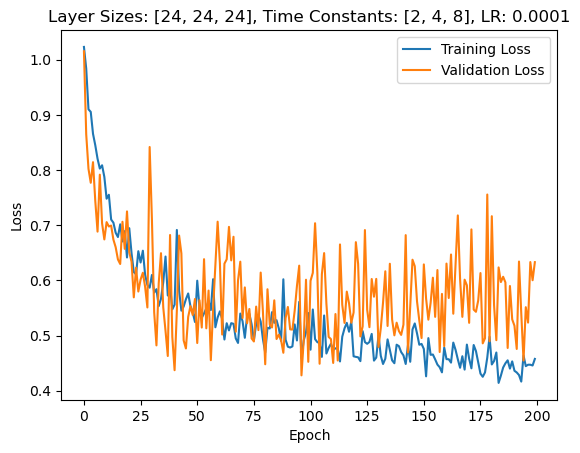

  0%|          | 1/200 [00:13<45:54, 13.84s/it]

Epoch 1/200, Training Loss: 1.0506588063150082, Validation Loss: 0.7074549623898098


  1%|          | 2/200 [00:27<45:04, 13.66s/it]

Epoch 2/200, Training Loss: 0.9059961989240827, Validation Loss: 0.8052298213754382


  2%|▏         | 3/200 [00:40<44:05, 13.43s/it]

Epoch 3/200, Training Loss: 0.8051739582475627, Validation Loss: 0.782448119350842


  2%|▏         | 4/200 [00:53<43:12, 13.23s/it]

Epoch 4/200, Training Loss: 0.9315700474775063, Validation Loss: 0.7893025023596627


  2%|▎         | 5/200 [01:06<42:34, 13.10s/it]

Epoch 5/200, Training Loss: 0.8107860639410199, Validation Loss: 0.7836088793618339


  3%|▎         | 6/200 [01:19<42:50, 13.25s/it]

Epoch 6/200, Training Loss: 0.7263655330774919, Validation Loss: 0.7003983046327319


  4%|▎         | 7/200 [01:33<43:05, 13.40s/it]

Epoch 7/200, Training Loss: 0.6710890402209084, Validation Loss: 0.6680847023214612


  4%|▍         | 8/200 [01:47<43:08, 13.48s/it]

Epoch 8/200, Training Loss: 0.674582654575132, Validation Loss: 0.6498866421835763


  4%|▍         | 9/200 [02:00<43:03, 13.53s/it]

Epoch 9/200, Training Loss: 0.7555426111761129, Validation Loss: 0.7106402260916573


  5%|▌         | 10/200 [02:14<42:58, 13.57s/it]

Epoch 10/200, Training Loss: 0.7322729623542642, Validation Loss: 0.6302158130066735


  6%|▌         | 11/200 [02:28<42:46, 13.58s/it]

Epoch 11/200, Training Loss: 0.6590685557644322, Validation Loss: 0.6964345914976937


  6%|▌         | 12/200 [02:41<42:46, 13.65s/it]

Epoch 12/200, Training Loss: 0.643433782851921, Validation Loss: 0.6182120144367218


  6%|▋         | 13/200 [02:54<41:50, 13.43s/it]

Epoch 13/200, Training Loss: 0.6480797523597501, Validation Loss: 0.6142823046871594


  7%|▋         | 14/200 [03:07<40:59, 13.22s/it]

Epoch 14/200, Training Loss: 0.6456640075962499, Validation Loss: 0.5964661581175668


  8%|▊         | 15/200 [03:20<40:27, 13.12s/it]

Epoch 15/200, Training Loss: 0.5943118778039824, Validation Loss: 0.6940050678593772


  8%|▊         | 16/200 [03:33<40:02, 13.06s/it]

Epoch 16/200, Training Loss: 0.6101963418834614, Validation Loss: 0.6411229052713939


  8%|▊         | 17/200 [03:46<39:32, 12.97s/it]

Epoch 17/200, Training Loss: 0.6174981807762722, Validation Loss: 0.6247041778905051


  9%|▉         | 18/200 [03:59<40:07, 13.23s/it]

Epoch 18/200, Training Loss: 0.586449422363965, Validation Loss: 0.6884429923125676


 10%|▉         | 19/200 [04:12<39:41, 13.16s/it]

Epoch 19/200, Training Loss: 0.6093421690868881, Validation Loss: 0.6807774592723165


 10%|█         | 20/200 [04:25<39:09, 13.05s/it]

Epoch 20/200, Training Loss: 0.5986822180028232, Validation Loss: 0.6003012763602393


 10%|█         | 21/200 [04:38<38:50, 13.02s/it]

Epoch 21/200, Training Loss: 0.698068564792849, Validation Loss: 0.6722079770905631


 11%|█         | 22/200 [04:51<38:26, 12.96s/it]

Epoch 22/200, Training Loss: 0.6333921787873754, Validation Loss: 0.6927257052489689


 12%|█▏        | 23/200 [05:05<38:58, 13.21s/it]

Epoch 23/200, Training Loss: 0.5629395190274941, Validation Loss: 0.6881543397903442


 12%|█▏        | 24/200 [05:18<38:30, 13.13s/it]

Epoch 24/200, Training Loss: 0.557344377603171, Validation Loss: 0.6694215961865017


 12%|█▎        | 25/200 [05:31<37:59, 13.02s/it]

Epoch 25/200, Training Loss: 0.558217280315903, Validation Loss: 0.611849878515516


 13%|█▎        | 26/200 [05:44<37:47, 13.03s/it]

Epoch 26/200, Training Loss: 0.6160075692635663, Validation Loss: 0.6480403393507004


 14%|█▎        | 27/200 [05:57<38:07, 13.22s/it]

Epoch 27/200, Training Loss: 0.580061951335871, Validation Loss: 0.6393057789121356


 14%|█▍        | 28/200 [06:10<37:45, 13.17s/it]

Epoch 28/200, Training Loss: 0.5032316598127473, Validation Loss: 0.5996245997292655


 14%|█▍        | 29/200 [06:23<37:17, 13.08s/it]

Epoch 29/200, Training Loss: 0.4925468240706426, Validation Loss: 0.5775780507496425


 15%|█▌        | 30/200 [06:36<36:57, 13.04s/it]

Epoch 30/200, Training Loss: 0.5254782792532219, Validation Loss: 0.5259972129549298


 16%|█▌        | 31/200 [06:49<36:37, 13.00s/it]

Epoch 31/200, Training Loss: 0.4826876678556766, Validation Loss: 0.5617209715502602


 16%|█▌        | 32/200 [07:02<36:19, 12.97s/it]

Epoch 32/200, Training Loss: 0.46549916492318205, Validation Loss: 0.5773941491331372


 16%|█▋        | 33/200 [07:15<36:05, 12.97s/it]

Epoch 33/200, Training Loss: 0.4836403322669695, Validation Loss: 0.5798912729535785


 17%|█▋        | 34/200 [07:28<35:53, 12.97s/it]

Epoch 34/200, Training Loss: 0.471779594725033, Validation Loss: 0.751833262188094


 18%|█▊        | 35/200 [07:41<35:33, 12.93s/it]

Epoch 35/200, Training Loss: 0.4768490484862957, Validation Loss: 0.6348738585199628


 18%|█▊        | 36/200 [07:54<35:54, 13.14s/it]

Epoch 36/200, Training Loss: 0.4933663558847499, Validation Loss: 0.8012983969279698


 18%|█▊        | 37/200 [08:08<35:42, 13.14s/it]

Epoch 37/200, Training Loss: 0.5486816724516311, Validation Loss: 0.6103527205330985


 19%|█▉        | 38/200 [08:21<35:21, 13.10s/it]

Epoch 38/200, Training Loss: 0.4861210139011437, Validation Loss: 0.4822981059551239


 20%|█▉        | 39/200 [08:33<35:02, 13.06s/it]

Epoch 39/200, Training Loss: 0.5484547030250981, Validation Loss: 0.6007547421114785


 20%|██        | 40/200 [08:47<35:19, 13.25s/it]

Epoch 40/200, Training Loss: 0.5255999520139875, Validation Loss: 0.5786573546273368


 20%|██        | 41/200 [09:00<35:01, 13.22s/it]

Epoch 41/200, Training Loss: 0.44923234070247076, Validation Loss: 0.47807214515549795


 21%|██        | 42/200 [09:13<34:35, 13.14s/it]

Epoch 42/200, Training Loss: 0.4826486074137238, Validation Loss: 0.7251195141247341


 22%|██▏       | 43/200 [09:26<34:05, 13.03s/it]

Epoch 43/200, Training Loss: 0.5183276399126593, Validation Loss: 0.5530163645744324


 22%|██▏       | 44/200 [09:39<33:57, 13.06s/it]

Epoch 44/200, Training Loss: 0.4345404148664115, Validation Loss: 0.5022857721362796


 22%|██▎       | 45/200 [09:52<33:33, 12.99s/it]

Epoch 45/200, Training Loss: 0.4522446391155135, Validation Loss: 0.5658629579203469


 23%|██▎       | 46/200 [10:05<33:21, 13.00s/it]

Epoch 46/200, Training Loss: 0.444902814221832, Validation Loss: 0.49870296461241587


 24%|██▎       | 47/200 [10:18<33:04, 12.97s/it]

Epoch 47/200, Training Loss: 0.49830504071037723, Validation Loss: 0.5428255583558764


 24%|██▍       | 48/200 [10:31<32:47, 12.94s/it]

Epoch 48/200, Training Loss: 0.43925864460333336, Validation Loss: 0.5218448681490762


 24%|██▍       | 49/200 [10:44<33:07, 13.16s/it]

Epoch 49/200, Training Loss: 0.5340104540282825, Validation Loss: 0.552313004221235


 25%|██▌       | 50/200 [10:58<32:52, 13.15s/it]

Epoch 50/200, Training Loss: 0.4879895243442284, Validation Loss: 0.4633137583732605


 26%|██▌       | 51/200 [11:11<32:30, 13.09s/it]

Epoch 51/200, Training Loss: 0.4500593675195046, Validation Loss: 0.4581139385700226


 26%|██▌       | 52/200 [11:23<32:06, 13.02s/it]

Epoch 52/200, Training Loss: 0.43969076253333184, Validation Loss: 0.5193188573632922


 26%|██▋       | 53/200 [11:37<32:29, 13.26s/it]

Epoch 53/200, Training Loss: 0.4390843192923744, Validation Loss: 0.5864337789160865


 27%|██▋       | 54/200 [11:50<32:12, 13.23s/it]

Epoch 54/200, Training Loss: 0.4216086248744209, Validation Loss: 0.419660142489842


 28%|██▊       | 55/200 [12:03<31:43, 13.13s/it]

Epoch 55/200, Training Loss: 0.5193806362320792, Validation Loss: 0.5807460610355649


 28%|██▊       | 56/200 [12:16<31:34, 13.15s/it]

Epoch 56/200, Training Loss: 0.4997681899453109, Validation Loss: 0.5499270047460284


 28%|██▊       | 57/200 [12:29<31:09, 13.07s/it]

Epoch 57/200, Training Loss: 0.4412130913082159, Validation Loss: 0.5150427988597325


 29%|██▉       | 58/200 [12:42<30:45, 13.00s/it]

Epoch 58/200, Training Loss: 0.42791972000081585, Validation Loss: 0.5193864405155182


 30%|██▉       | 59/200 [12:55<30:30, 12.98s/it]

Epoch 59/200, Training Loss: 0.40958444268073674, Validation Loss: 0.5061305974211011


 30%|███       | 60/200 [13:08<30:13, 12.96s/it]

Epoch 60/200, Training Loss: 0.47295728072805227, Validation Loss: 0.5058709553309849


 30%|███       | 61/200 [13:21<30:00, 12.96s/it]

Epoch 61/200, Training Loss: 0.39001098078376845, Validation Loss: 0.6106462393488202


 31%|███       | 62/200 [13:35<30:19, 13.18s/it]

Epoch 62/200, Training Loss: 0.38094851262164564, Validation Loss: 0.4515495002269745


 32%|███▏      | 63/200 [13:48<30:08, 13.20s/it]

Epoch 63/200, Training Loss: 0.4435038558857621, Validation Loss: 0.45832726785114836


 32%|███▏      | 64/200 [14:01<29:49, 13.16s/it]

Epoch 64/200, Training Loss: 0.39785508867704644, Validation Loss: 0.4972725638321468


 32%|███▎      | 65/200 [14:14<29:32, 13.13s/it]

Epoch 65/200, Training Loss: 0.40048653927614103, Validation Loss: 0.47808772325515747


 33%|███▎      | 66/200 [14:28<29:46, 13.33s/it]

Epoch 66/200, Training Loss: 0.3747909263057529, Validation Loss: 0.5112204807145255


 34%|███▎      | 67/200 [14:41<29:24, 13.26s/it]

Epoch 67/200, Training Loss: 0.3739806146554227, Validation Loss: 0.5343917267663139


 34%|███▍      | 68/200 [14:54<29:03, 13.21s/it]

Epoch 68/200, Training Loss: 0.37640595225230705, Validation Loss: 0.5927755406924656


 34%|███▍      | 69/200 [15:07<28:40, 13.14s/it]

Epoch 69/200, Training Loss: 0.36550853274903206, Validation Loss: 0.4939877263137272


 35%|███▌      | 70/200 [15:20<28:14, 13.04s/it]

Epoch 70/200, Training Loss: 0.3653093418985043, Validation Loss: 0.46284312648432596


 36%|███▌      | 71/200 [15:33<27:53, 12.97s/it]

Epoch 71/200, Training Loss: 0.35583064213113963, Validation Loss: 0.44821744305746897


 36%|███▌      | 72/200 [15:46<27:43, 12.99s/it]

Epoch 72/200, Training Loss: 0.3873914395863155, Validation Loss: 0.6098781483513969


 36%|███▋      | 73/200 [15:59<27:33, 13.02s/it]

Epoch 73/200, Training Loss: 0.3876300799959111, Validation Loss: 0.4251906318323953


 37%|███▋      | 74/200 [16:12<27:22, 13.04s/it]

Epoch 74/200, Training Loss: 0.3557452513080723, Validation Loss: 0.5208232360226768


 38%|███▊      | 75/200 [16:25<27:31, 13.21s/it]

Epoch 75/200, Training Loss: 0.362396739563852, Validation Loss: 0.4900591926915305


 38%|███▊      | 76/200 [16:39<27:23, 13.26s/it]

Epoch 76/200, Training Loss: 0.35971389162652895, Validation Loss: 0.5635891280003956


 38%|███▊      | 77/200 [16:52<27:10, 13.25s/it]

Epoch 77/200, Training Loss: 0.3632431412642857, Validation Loss: 0.47203171040330616


 39%|███▉      | 78/200 [17:05<26:49, 13.19s/it]

Epoch 78/200, Training Loss: 0.3604702815975783, Validation Loss: 0.4920616884316717


 40%|███▉      | 79/200 [17:19<27:00, 13.39s/it]

Epoch 79/200, Training Loss: 0.3709884431424006, Validation Loss: 0.4685912238700049


 40%|████      | 80/200 [17:32<26:42, 13.36s/it]

Epoch 80/200, Training Loss: 0.3730747249891173, Validation Loss: 0.40292116573878695


 40%|████      | 81/200 [17:45<26:11, 13.21s/it]

Epoch 81/200, Training Loss: 0.34556202281196163, Validation Loss: 0.4354289046355656


 41%|████      | 82/200 [17:58<25:51, 13.14s/it]

Epoch 82/200, Training Loss: 0.3482574553422208, Validation Loss: 0.49898426341159


 42%|████▏     | 83/200 [18:11<25:26, 13.05s/it]

Epoch 83/200, Training Loss: 0.36410691729694045, Validation Loss: 0.5145339071750641


 42%|████▏     | 84/200 [18:24<25:13, 13.04s/it]

Epoch 84/200, Training Loss: 0.34795441605010125, Validation Loss: 0.4766429364681244


 42%|████▎     | 85/200 [18:37<25:02, 13.06s/it]

Epoch 85/200, Training Loss: 0.36316239665139394, Validation Loss: 0.47076255295957836


 43%|████▎     | 86/200 [18:50<24:41, 13.00s/it]

Epoch 86/200, Training Loss: 0.37932490515259076, Validation Loss: 0.46140139017786297


 44%|████▎     | 87/200 [19:03<24:29, 13.01s/it]

Epoch 87/200, Training Loss: 0.33077670725167924, Validation Loss: 0.413758961217744


 44%|████▍     | 88/200 [19:17<24:36, 13.18s/it]

Epoch 88/200, Training Loss: 0.33716026693582535, Validation Loss: 0.4293703351702009


 44%|████▍     | 89/200 [19:30<24:34, 13.28s/it]

Epoch 89/200, Training Loss: 0.3428280085044087, Validation Loss: 0.4361968232052667


 45%|████▌     | 90/200 [19:43<24:06, 13.15s/it]

Epoch 90/200, Training Loss: 0.3558545567376434, Validation Loss: 0.4195402924503599


 46%|████▌     | 91/200 [19:56<23:44, 13.07s/it]

Epoch 91/200, Training Loss: 0.32890752562374437, Validation Loss: 0.3919825106859207


 46%|████▌     | 92/200 [20:10<24:02, 13.36s/it]

Epoch 92/200, Training Loss: 0.34816633375748146, Validation Loss: 0.4636615663766861


 46%|████▋     | 93/200 [20:23<23:40, 13.27s/it]

Epoch 93/200, Training Loss: 0.34829691460110107, Validation Loss: 0.4580381746803011


 47%|████▋     | 94/200 [20:36<23:18, 13.19s/it]

Epoch 94/200, Training Loss: 0.36835676769040665, Validation Loss: 0.37473070195743013


 48%|████▊     | 95/200 [20:49<22:53, 13.08s/it]

Epoch 95/200, Training Loss: 0.34536765698554384, Validation Loss: 0.4545870040144239


 48%|████▊     | 96/200 [21:02<22:34, 13.02s/it]

Epoch 96/200, Training Loss: 0.3368313433426731, Validation Loss: 0.41327570165906635


 48%|████▊     | 97/200 [21:15<22:19, 13.01s/it]

Epoch 97/200, Training Loss: 0.31337020117438064, Validation Loss: 0.3974932198013578


 49%|████▉     | 98/200 [21:28<22:07, 13.02s/it]

Epoch 98/200, Training Loss: 0.3393774811389311, Validation Loss: 0.4113646703107016


 50%|████▉     | 99/200 [21:41<21:53, 13.01s/it]

Epoch 99/200, Training Loss: 0.326759176715365, Validation Loss: 0.4197930225304195


 50%|█████     | 100/200 [21:54<21:40, 13.01s/it]

Epoch 100/200, Training Loss: 0.3403684190421734, Validation Loss: 0.37714781505720957


 50%|█████     | 101/200 [22:07<21:45, 13.19s/it]

Epoch 101/200, Training Loss: 0.3182766237911188, Validation Loss: 0.4928162268229893


 51%|█████     | 102/200 [22:21<21:44, 13.31s/it]

Epoch 102/200, Training Loss: 0.316970427643578, Validation Loss: 0.3896253619875227


 52%|█████▏    | 103/200 [22:34<21:20, 13.20s/it]

Epoch 103/200, Training Loss: 0.3168984527857798, Validation Loss: 0.4790730114494051


 52%|█████▏    | 104/200 [22:47<20:57, 13.10s/it]

Epoch 104/200, Training Loss: 0.3182891821664459, Validation Loss: 0.4484038118805204


 52%|█████▎    | 105/200 [23:01<21:09, 13.37s/it]

Epoch 105/200, Training Loss: 0.32506205310236735, Validation Loss: 0.39590301896844593


 53%|█████▎    | 106/200 [23:14<20:50, 13.31s/it]

Epoch 106/200, Training Loss: 0.3466252080112133, Validation Loss: 0.473877842937197


 54%|█████▎    | 107/200 [23:27<20:30, 13.23s/it]

Epoch 107/200, Training Loss: 0.3286182566914918, Validation Loss: 0.46410698550088064


 54%|█████▍    | 108/200 [23:40<20:10, 13.16s/it]

Epoch 108/200, Training Loss: 0.33302961908421425, Validation Loss: 0.4235543055193765


 55%|█████▍    | 109/200 [23:53<19:53, 13.11s/it]

Epoch 109/200, Training Loss: 0.349646232038174, Validation Loss: 0.376884183713368


 55%|█████▌    | 110/200 [24:06<19:42, 13.14s/it]

Epoch 110/200, Training Loss: 0.3527842363658941, Validation Loss: 0.40056787005492617


 56%|█████▌    | 111/200 [24:19<19:25, 13.09s/it]

Epoch 111/200, Training Loss: 0.3379643163028753, Validation Loss: 0.3990980088710785


 56%|█████▌    | 112/200 [24:32<19:09, 13.06s/it]

Epoch 112/200, Training Loss: 0.3169900122678505, Validation Loss: 0.4324665048292705


 56%|█████▋    | 113/200 [24:45<18:50, 13.00s/it]

Epoch 113/200, Training Loss: 0.31825989597248583, Validation Loss: 0.3742287542138781


 57%|█████▋    | 114/200 [24:58<18:55, 13.20s/it]

Epoch 114/200, Training Loss: 0.31971651512496874, Validation Loss: 0.4397300545658384


 57%|█████▊    | 115/200 [25:12<18:47, 13.26s/it]

Epoch 115/200, Training Loss: 0.33666836484423224, Validation Loss: 0.4036113726241248


 58%|█████▊    | 116/200 [25:25<18:27, 13.18s/it]

Epoch 116/200, Training Loss: 0.31045413073503747, Validation Loss: 0.42186749832970755


 58%|█████▊    | 117/200 [25:38<18:10, 13.14s/it]

Epoch 117/200, Training Loss: 0.3325413890042395, Validation Loss: 0.44190562410014017


 59%|█████▉    | 118/200 [25:52<18:15, 13.36s/it]

Epoch 118/200, Training Loss: 0.32624405510020704, Validation Loss: 0.4142137851033892


 60%|█████▉    | 119/200 [26:05<17:55, 13.27s/it]

Epoch 119/200, Training Loss: 0.33532883493967774, Validation Loss: 0.4663457359586443


 60%|██████    | 120/200 [26:18<17:38, 13.23s/it]

Epoch 120/200, Training Loss: 0.31917612845042964, Validation Loss: 0.440014979669026


 60%|██████    | 121/200 [26:31<17:18, 13.14s/it]

Epoch 121/200, Training Loss: 0.3179136164626985, Validation Loss: 0.42874930586133686


 61%|██████    | 122/200 [26:44<17:02, 13.11s/it]

Epoch 122/200, Training Loss: 0.3166839559826086, Validation Loss: 0.4703604727983475


 62%|██████▏   | 123/200 [26:57<16:49, 13.11s/it]

Epoch 123/200, Training Loss: 0.31370765195702605, Validation Loss: 0.4269357919692993


 62%|██████▏   | 124/200 [27:10<16:32, 13.06s/it]

Epoch 124/200, Training Loss: 0.31488964544995773, Validation Loss: 0.3934044178043093


 62%|██████▎   | 125/200 [27:23<16:19, 13.07s/it]

Epoch 125/200, Training Loss: 0.3194197559694074, Validation Loss: 0.4935709812811443


 63%|██████▎   | 126/200 [27:36<16:04, 13.03s/it]

Epoch 126/200, Training Loss: 0.3216869260342616, Validation Loss: 0.42473728741918293


 64%|██████▎   | 127/200 [27:50<16:10, 13.30s/it]

Epoch 127/200, Training Loss: 0.3102590271605636, Validation Loss: 0.4293553126709802


 64%|██████▍   | 128/200 [28:03<15:56, 13.28s/it]

Epoch 128/200, Training Loss: 0.31483370501477764, Validation Loss: 0.4397978697504316


 64%|██████▍   | 129/200 [28:16<15:36, 13.19s/it]

Epoch 129/200, Training Loss: 0.31774222358780085, Validation Loss: 0.4477609864303044


 65%|██████▌   | 130/200 [28:29<15:22, 13.18s/it]

Epoch 130/200, Training Loss: 0.28727137409853487, Validation Loss: 0.4402923264673778


 66%|██████▌   | 131/200 [28:43<15:26, 13.43s/it]

Epoch 131/200, Training Loss: 0.32367283724388984, Validation Loss: 0.39629706953253063


 66%|██████▌   | 132/200 [28:57<15:20, 13.53s/it]

Epoch 132/200, Training Loss: 0.3081201192624164, Validation Loss: 0.440673576933997


 66%|██████▋   | 133/200 [29:10<14:55, 13.36s/it]

Epoch 133/200, Training Loss: 0.3108054038207486, Validation Loss: 0.4325818696192333


 67%|██████▋   | 134/200 [29:23<14:33, 13.24s/it]

Epoch 134/200, Training Loss: 0.31139895826015834, Validation Loss: 0.4023429772683552


 68%|██████▊   | 135/200 [29:36<14:17, 13.20s/it]

Epoch 135/200, Training Loss: 0.30374790636717147, Validation Loss: 0.4485539687531335


 68%|██████▊   | 136/200 [29:49<14:01, 13.15s/it]

Epoch 136/200, Training Loss: 0.3131846532506763, Validation Loss: 0.4257154422146933


 68%|██████▊   | 137/200 [30:02<13:46, 13.12s/it]

Epoch 137/200, Training Loss: 0.31097455955338926, Validation Loss: 0.4037357121706009


 69%|██████▉   | 138/200 [30:15<13:31, 13.09s/it]

Epoch 138/200, Training Loss: 0.301244707602375, Validation Loss: 0.3942518936736243


 70%|██████▉   | 139/200 [30:28<13:16, 13.05s/it]

Epoch 139/200, Training Loss: 0.2957872195907359, Validation Loss: 0.4199320056608745


 70%|███████   | 140/200 [30:42<13:22, 13.37s/it]

Epoch 140/200, Training Loss: 0.31078525337408175, Validation Loss: 0.40567840210029055


 70%|███████   | 141/200 [30:55<13:04, 13.30s/it]

Epoch 141/200, Training Loss: 0.3154392294445128, Validation Loss: 0.41267729657036917


 71%|███████   | 142/200 [31:08<12:44, 13.19s/it]

Epoch 142/200, Training Loss: 0.3050658791413847, Validation Loss: 0.36423189512320925


 72%|███████▏  | 143/200 [31:22<12:31, 13.18s/it]

Epoch 143/200, Training Loss: 0.3033393618633162, Validation Loss: 0.4011435146842684


 72%|███████▏  | 144/200 [31:36<12:33, 13.45s/it]

Epoch 144/200, Training Loss: 0.2967918221399469, Validation Loss: 0.370785368340356


 72%|███████▎  | 145/200 [31:49<12:17, 13.40s/it]

Epoch 145/200, Training Loss: 0.28455306547430326, Validation Loss: 0.43001984698431833


 73%|███████▎  | 146/200 [32:02<11:57, 13.28s/it]

Epoch 146/200, Training Loss: 0.2891894764495346, Validation Loss: 0.5082763795341764


 74%|███████▎  | 147/200 [32:15<11:38, 13.18s/it]

Epoch 147/200, Training Loss: 0.308055745543174, Validation Loss: 0.38629248099667685


 74%|███████▍  | 148/200 [32:28<11:24, 13.16s/it]

Epoch 148/200, Training Loss: 0.29082430772623924, Validation Loss: 0.37491145517144886


 74%|███████▍  | 149/200 [32:41<11:09, 13.12s/it]

Epoch 149/200, Training Loss: 0.29980686180434135, Validation Loss: 0.4051558630807059


 75%|███████▌  | 150/200 [32:54<10:56, 13.14s/it]

Epoch 150/200, Training Loss: 0.2954813286943256, Validation Loss: 0.3957604914903641


 76%|███████▌  | 151/200 [33:07<10:39, 13.05s/it]

Epoch 151/200, Training Loss: 0.2894267774415466, Validation Loss: 0.4017279339688165


 76%|███████▌  | 152/200 [33:20<10:23, 12.99s/it]

Epoch 152/200, Training Loss: 0.2844549206630239, Validation Loss: 0.40790739229747225


 76%|███████▋  | 153/200 [33:34<10:21, 13.23s/it]

Epoch 153/200, Training Loss: 0.2997666484904739, Validation Loss: 0.43228343980652945


 77%|███████▋  | 154/200 [33:47<10:10, 13.26s/it]

Epoch 154/200, Training Loss: 0.2942772388177098, Validation Loss: 0.4224407119410379


 78%|███████▊  | 155/200 [34:00<09:55, 13.23s/it]

Epoch 155/200, Training Loss: 0.28643010978428823, Validation Loss: 0.4125895968505314


 78%|███████▊  | 156/200 [34:13<09:37, 13.12s/it]

Epoch 156/200, Training Loss: 0.28264434171735114, Validation Loss: 0.3765252786023276


 78%|███████▊  | 157/200 [34:27<09:34, 13.36s/it]

Epoch 157/200, Training Loss: 0.2793375737965107, Validation Loss: 0.3840039053133556


 79%|███████▉  | 158/200 [34:40<09:19, 13.33s/it]

Epoch 158/200, Training Loss: 0.2873495853734466, Validation Loss: 0.39748498797416687


 80%|███████▉  | 159/200 [34:53<09:01, 13.22s/it]

Epoch 159/200, Training Loss: 0.2737337417619408, Validation Loss: 0.3760609392608915


 80%|████████  | 160/200 [35:06<08:46, 13.17s/it]

Epoch 160/200, Training Loss: 0.28127531292584707, Validation Loss: 0.36918563076428007


 80%|████████  | 161/200 [35:19<08:30, 13.08s/it]

Epoch 161/200, Training Loss: 0.2882295011911752, Validation Loss: 0.4203489912407739


 81%|████████  | 162/200 [35:32<08:15, 13.05s/it]

Epoch 162/200, Training Loss: 0.3082215334728079, Validation Loss: 0.3511531970330647


 82%|████████▏ | 163/200 [35:45<08:05, 13.12s/it]

Epoch 163/200, Training Loss: 0.28993196195026616, Validation Loss: 0.403277120419911


 82%|████████▏ | 164/200 [35:58<07:50, 13.08s/it]

Epoch 164/200, Training Loss: 0.287135603855241, Validation Loss: 0.3888347361768995


 82%|████████▎ | 165/200 [36:11<07:36, 13.03s/it]

Epoch 165/200, Training Loss: 0.292212187822135, Validation Loss: 0.38286378128188


 83%|████████▎ | 166/200 [36:25<07:30, 13.24s/it]

Epoch 166/200, Training Loss: 0.29079542948671105, Validation Loss: 0.4027742828641619


 84%|████████▎ | 167/200 [36:38<07:18, 13.30s/it]

Epoch 167/200, Training Loss: 0.3025814272322745, Validation Loss: 0.38125522221837727


 84%|████████▍ | 168/200 [36:52<07:03, 13.24s/it]

Epoch 168/200, Training Loss: 0.2908687692768169, Validation Loss: 0.38500029274395536


 84%|████████▍ | 169/200 [37:05<06:49, 13.19s/it]

Epoch 169/200, Training Loss: 0.2767497173176621, Validation Loss: 0.3860608658620289


 85%|████████▌ | 170/200 [37:18<06:40, 13.36s/it]

Epoch 170/200, Training Loss: 0.2612319959784454, Validation Loss: 0.3792717605829239


 86%|████████▌ | 171/200 [37:32<06:27, 13.35s/it]

Epoch 171/200, Training Loss: 0.26304314781050636, Validation Loss: 0.37904060099806103


 86%|████████▌ | 172/200 [37:45<06:10, 13.24s/it]

Epoch 172/200, Training Loss: 0.27042504104803194, Validation Loss: 0.4266874002558844


 86%|████████▋ | 173/200 [37:58<05:56, 13.21s/it]

Epoch 173/200, Training Loss: 0.28096353332951385, Validation Loss: 0.4461085413183485


 87%|████████▋ | 174/200 [38:11<05:41, 13.14s/it]

Epoch 174/200, Training Loss: 0.2779750552661014, Validation Loss: 0.3888650642974036


 88%|████████▊ | 175/200 [38:24<05:27, 13.09s/it]

Epoch 175/200, Training Loss: 0.2841564232026631, Validation Loss: 0.35557869928223745


 88%|████████▊ | 176/200 [38:37<05:13, 13.08s/it]

Epoch 176/200, Training Loss: 0.26585636674514357, Validation Loss: 0.4256764692919595


 88%|████████▊ | 177/200 [38:50<05:00, 13.08s/it]

Epoch 177/200, Training Loss: 0.25695996513625363, Validation Loss: 0.4396611877850124


 89%|████████▉ | 178/200 [39:03<04:47, 13.08s/it]

Epoch 178/200, Training Loss: 0.27676213912244113, Validation Loss: 0.3867742568254471


 90%|████████▉ | 179/200 [39:17<04:38, 13.27s/it]

Epoch 179/200, Training Loss: 0.27531960789325105, Validation Loss: 0.4490518250635692


 90%|█████████ | 180/200 [39:30<04:24, 13.24s/it]

Epoch 180/200, Training Loss: 0.25616090618214515, Validation Loss: 0.37965389234679087


 90%|█████████ | 181/200 [39:43<04:12, 13.27s/it]

Epoch 181/200, Training Loss: 0.2758029135611822, Validation Loss: 0.4081123449972698


 91%|█████████ | 182/200 [39:56<03:56, 13.15s/it]

Epoch 182/200, Training Loss: 0.2815527821768005, Validation Loss: 0.3847649906362806


 92%|█████████▏| 183/200 [40:10<03:48, 13.42s/it]

Epoch 183/200, Training Loss: 0.26173567220146926, Validation Loss: 0.34915056611810413


 92%|█████████▏| 184/200 [40:23<03:33, 13.34s/it]

Epoch 184/200, Training Loss: 0.25895665361071535, Validation Loss: 0.4249871564762933


 92%|█████████▎| 185/200 [40:36<03:18, 13.23s/it]

Epoch 185/200, Training Loss: 0.29160969120995056, Validation Loss: 0.4392757841518947


 93%|█████████▎| 186/200 [40:49<03:04, 13.16s/it]

Epoch 186/200, Training Loss: 0.272431501872697, Validation Loss: 0.3836440294981003


 94%|█████████▎| 187/200 [41:02<02:49, 13.07s/it]

Epoch 187/200, Training Loss: 0.2675418939511731, Validation Loss: 0.44637532106467653


 94%|█████████▍| 188/200 [41:15<02:36, 13.05s/it]

Epoch 188/200, Training Loss: 0.26388991335934064, Validation Loss: 0.3612541769232069


 94%|█████████▍| 189/200 [41:28<02:23, 13.05s/it]

Epoch 189/200, Training Loss: 0.2510065808189365, Validation Loss: 0.37653596699237823


 95%|█████████▌| 190/200 [41:41<02:10, 13.00s/it]

Epoch 190/200, Training Loss: 0.28047574515331464, Validation Loss: 0.39175693903650555


 96%|█████████▌| 191/200 [41:54<01:57, 13.07s/it]

Epoch 191/200, Training Loss: 0.30027069060026473, Validation Loss: 0.35523936578205656


 96%|█████████▌| 192/200 [42:08<01:45, 13.24s/it]

Epoch 192/200, Training Loss: 0.2605503685069534, Validation Loss: 0.3714822828769684


 96%|█████████▋| 193/200 [42:21<01:32, 13.25s/it]

Epoch 193/200, Training Loss: 0.258131594309267, Validation Loss: 0.4342028370925358


 97%|█████████▋| 194/200 [42:34<01:19, 13.22s/it]

Epoch 194/200, Training Loss: 0.2443918210436713, Validation Loss: 0.38915781463895527


 98%|█████████▊| 195/200 [42:47<01:05, 13.19s/it]

Epoch 195/200, Training Loss: 0.26894691937936926, Validation Loss: 0.35119750670024324


 98%|█████████▊| 196/200 [43:01<00:53, 13.40s/it]

Epoch 196/200, Training Loss: 0.2700844212733912, Validation Loss: 0.3837581127882004


 98%|█████████▊| 197/200 [43:14<00:39, 13.30s/it]

Epoch 197/200, Training Loss: 0.23991555218883562, Validation Loss: 0.37924893839018686


 99%|█████████▉| 198/200 [43:27<00:26, 13.17s/it]

Epoch 198/200, Training Loss: 0.2546346002029923, Validation Loss: 0.36640257069042753


100%|█████████▉| 199/200 [43:41<00:13, 13.21s/it]

Epoch 199/200, Training Loss: 0.26629449277764783, Validation Loss: 0.37224375137260984


100%|██████████| 200/200 [43:54<00:00, 13.17s/it]

Epoch 200/200, Training Loss: 0.25161767287074394, Validation Loss: 0.39823791810444426
Final Accuracy: 93.24%, Precision: 0.93, Recall: 0.94


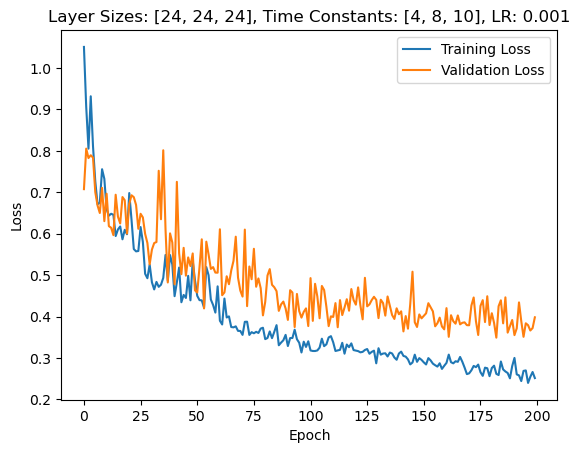

  0%|          | 1/200 [00:13<45:31, 13.73s/it]

Epoch 1/200, Training Loss: 1.0279465497664686, Validation Loss: 0.8808104821613857


  1%|          | 2/200 [00:27<45:01, 13.64s/it]

Epoch 2/200, Training Loss: 0.9606324962849887, Validation Loss: 0.718158700636455


  2%|▏         | 3/200 [00:40<44:28, 13.54s/it]

Epoch 3/200, Training Loss: 0.8750076091514444, Validation Loss: 0.702578489269529


  2%|▏         | 4/200 [00:53<43:29, 13.32s/it]

Epoch 4/200, Training Loss: 0.9874260414321467, Validation Loss: 0.7650239382471357


  2%|▎         | 5/200 [01:07<43:21, 13.34s/it]

Epoch 5/200, Training Loss: 0.8237962205454988, Validation Loss: 0.7387353841747556


  3%|▎         | 6/200 [01:19<42:37, 13.19s/it]

Epoch 6/200, Training Loss: 0.7702726142586402, Validation Loss: 0.7606468115534101


  4%|▎         | 7/200 [01:33<42:47, 13.30s/it]

Epoch 7/200, Training Loss: 0.7218700849784995, Validation Loss: 0.7212428535733905


  4%|▍         | 8/200 [01:47<42:48, 13.38s/it]

Epoch 8/200, Training Loss: 0.6850279322210348, Validation Loss: 0.7248702070542744


  4%|▍         | 9/200 [02:00<42:48, 13.45s/it]

Epoch 9/200, Training Loss: 0.6954303220757898, Validation Loss: 0.7545212038925716


  5%|▌         | 10/200 [02:13<42:21, 13.38s/it]

Epoch 10/200, Training Loss: 0.705638882124199, Validation Loss: 0.6434621576751981


  6%|▌         | 11/200 [02:27<41:59, 13.33s/it]

Epoch 11/200, Training Loss: 0.6461263231511386, Validation Loss: 0.73609530712877


  6%|▌         | 12/200 [02:40<41:52, 13.36s/it]

Epoch 12/200, Training Loss: 0.6481740575916363, Validation Loss: 0.7627116782324654


  6%|▋         | 13/200 [02:53<41:09, 13.21s/it]

Epoch 13/200, Training Loss: 0.5978449847338334, Validation Loss: 0.739732101559639


  7%|▋         | 14/200 [03:06<41:17, 13.32s/it]

Epoch 14/200, Training Loss: 0.6023378377815463, Validation Loss: 0.800365999341011


  8%|▊         | 15/200 [03:20<41:10, 13.36s/it]

Epoch 15/200, Training Loss: 0.6306002899160925, Validation Loss: 0.7184492562498365


  8%|▊         | 16/200 [03:34<41:22, 13.49s/it]

Epoch 16/200, Training Loss: 0.6302154317217054, Validation Loss: 0.6901443770953587


  8%|▊         | 17/200 [03:47<40:33, 13.30s/it]

Epoch 17/200, Training Loss: 0.6314664854193633, Validation Loss: 0.7661270690815789


  9%|▉         | 18/200 [03:59<39:58, 13.18s/it]

Epoch 18/200, Training Loss: 0.6405036775570996, Validation Loss: 0.6853804034846169


 10%|▉         | 19/200 [04:12<39:29, 13.09s/it]

Epoch 19/200, Training Loss: 0.6248046457767487, Validation Loss: 0.5190315608467374


 10%|█         | 20/200 [04:25<38:58, 12.99s/it]

Epoch 20/200, Training Loss: 0.5803521123697173, Validation Loss: 0.7549561240843364


 10%|█         | 21/200 [04:39<39:21, 13.19s/it]

Epoch 21/200, Training Loss: 0.8334523737430573, Validation Loss: 0.5932860182864326


 11%|█         | 22/200 [04:52<38:58, 13.14s/it]

Epoch 22/200, Training Loss: 0.5994807374927232, Validation Loss: 0.67573310647692


 12%|█▏        | 23/200 [05:04<38:23, 13.01s/it]

Epoch 23/200, Training Loss: 0.5696419932932224, Validation Loss: 0.6422234369175774


 12%|█▏        | 24/200 [05:17<38:06, 12.99s/it]

Epoch 24/200, Training Loss: 0.5765783471881218, Validation Loss: 0.6200805263859885


 12%|█▎        | 25/200 [05:31<38:27, 13.19s/it]

Epoch 25/200, Training Loss: 0.6078379171074562, Validation Loss: 0.719340226479939


 13%|█▎        | 26/200 [05:44<38:07, 13.15s/it]

Epoch 26/200, Training Loss: 0.5833294318532044, Validation Loss: 0.7949828058481216


 14%|█▎        | 27/200 [05:57<37:36, 13.05s/it]

Epoch 27/200, Training Loss: 0.5951002850285116, Validation Loss: 0.6874026826449803


 14%|█▍        | 28/200 [06:10<37:08, 12.95s/it]

Epoch 28/200, Training Loss: 0.5890242024412695, Validation Loss: 0.6507050629173007


 14%|█▍        | 29/200 [06:23<36:53, 12.94s/it]

Epoch 29/200, Training Loss: 0.5703130696179732, Validation Loss: 0.5821495524474553


 15%|█▌        | 30/200 [06:35<36:37, 12.93s/it]

Epoch 30/200, Training Loss: 0.5324562937021255, Validation Loss: 0.7151124881846564


 16%|█▌        | 31/200 [06:48<36:13, 12.86s/it]

Epoch 31/200, Training Loss: 0.5247246715820061, Validation Loss: 0.5790066335882459


 16%|█▌        | 32/200 [07:01<35:58, 12.85s/it]

Epoch 32/200, Training Loss: 0.528920091548056, Validation Loss: 0.61264354629176


 16%|█▋        | 33/200 [07:14<35:50, 12.88s/it]

Epoch 33/200, Training Loss: 0.5311566248254956, Validation Loss: 0.585251442023686


 17%|█▋        | 34/200 [07:27<36:09, 13.07s/it]

Epoch 34/200, Training Loss: 0.5254969490024278, Validation Loss: 0.6620977308068957


 18%|█▊        | 35/200 [07:41<36:02, 13.10s/it]

Epoch 35/200, Training Loss: 0.5453668273282501, Validation Loss: 0.6934921315738133


 18%|█▊        | 36/200 [07:54<35:39, 13.05s/it]

Epoch 36/200, Training Loss: 0.5467261194058184, Validation Loss: 0.7699516926492963


 18%|█▊        | 37/200 [08:06<35:18, 12.99s/it]

Epoch 37/200, Training Loss: 0.5557296697823506, Validation Loss: 0.5611529456717628


 19%|█▉        | 38/200 [08:20<35:33, 13.17s/it]

Epoch 38/200, Training Loss: 0.5634220377454218, Validation Loss: 0.5297158743653979


 20%|█▉        | 39/200 [08:33<35:10, 13.11s/it]

Epoch 39/200, Training Loss: 0.5911089505227107, Validation Loss: 0.6135452049119132


 20%|██        | 40/200 [08:46<34:54, 13.09s/it]

Epoch 40/200, Training Loss: 0.5010082221256112, Validation Loss: 0.6445284911564418


 20%|██        | 41/200 [08:59<34:32, 13.03s/it]

Epoch 41/200, Training Loss: 0.48534925647501675, Validation Loss: 0.4973058317388807


 21%|██        | 42/200 [09:12<34:16, 13.02s/it]

Epoch 42/200, Training Loss: 0.9172163051816652, Validation Loss: 1.0150570358548845


 22%|██▏       | 43/200 [09:25<33:46, 12.91s/it]

Epoch 43/200, Training Loss: 0.598788987353163, Validation Loss: 0.6499962849276406


 22%|██▏       | 44/200 [09:37<33:25, 12.86s/it]

Epoch 44/200, Training Loss: 0.5249685965618998, Validation Loss: 0.65192939553942


 22%|██▎       | 45/200 [09:50<33:23, 12.93s/it]

Epoch 45/200, Training Loss: 0.5262953086562876, Validation Loss: 0.6143555556024823


 23%|██▎       | 46/200 [10:03<33:06, 12.90s/it]

Epoch 46/200, Training Loss: 0.5103939147490375, Validation Loss: 0.5783233238118035


 24%|██▎       | 47/200 [10:17<33:21, 13.08s/it]

Epoch 47/200, Training Loss: 0.507302609254729, Validation Loss: 0.626415205853326


 24%|██▍       | 48/200 [10:30<33:26, 13.20s/it]

Epoch 48/200, Training Loss: 0.4778479256157605, Validation Loss: 0.5214299942765918


 24%|██▍       | 49/200 [10:43<32:55, 13.08s/it]

Epoch 49/200, Training Loss: 0.4810928092250284, Validation Loss: 0.6192688516208104


 25%|██▌       | 50/200 [10:56<32:34, 13.03s/it]

Epoch 50/200, Training Loss: 0.5296312486225704, Validation Loss: 0.5526501451219831


 26%|██▌       | 51/200 [11:09<32:44, 13.19s/it]

Epoch 51/200, Training Loss: 0.5055585661024418, Validation Loss: 0.5167441623551505


 26%|██▌       | 52/200 [11:23<32:29, 13.17s/it]

Epoch 52/200, Training Loss: 0.4980997994260968, Validation Loss: 0.650241562298366


 26%|██▋       | 53/200 [11:36<32:06, 13.11s/it]

Epoch 53/200, Training Loss: 0.5132643040621055, Validation Loss: 0.6218180400984628


 27%|██▋       | 54/200 [11:48<31:33, 12.97s/it]

Epoch 54/200, Training Loss: 0.5263374400026394, Validation Loss: 0.5396575842584882


 28%|██▊       | 55/200 [12:01<31:19, 12.96s/it]

Epoch 55/200, Training Loss: 0.4933380068473096, Validation Loss: 0.5813971672739301


 28%|██▊       | 56/200 [12:14<30:58, 12.91s/it]

Epoch 56/200, Training Loss: 0.47994134926571036, Validation Loss: 0.618192834513528


 28%|██▊       | 57/200 [12:27<30:43, 12.89s/it]

Epoch 57/200, Training Loss: 0.4874351570066416, Validation Loss: 0.5116692419563021


 29%|██▉       | 58/200 [12:40<30:42, 12.97s/it]

Epoch 58/200, Training Loss: 0.5354106696146839, Validation Loss: 0.6080085975783212


 30%|██▉       | 59/200 [12:53<30:23, 12.93s/it]

Epoch 59/200, Training Loss: 0.48278829736529655, Validation Loss: 0.6505790778568813


 30%|███       | 60/200 [13:06<30:33, 13.10s/it]

Epoch 60/200, Training Loss: 0.4983155862340387, Validation Loss: 0.6645921042987278


 30%|███       | 61/200 [13:20<30:39, 13.24s/it]

Epoch 61/200, Training Loss: 0.47899435123182693, Validation Loss: 0.6808286394391742


 31%|███       | 62/200 [13:33<30:10, 13.12s/it]

Epoch 62/200, Training Loss: 0.4802593453875128, Validation Loss: 0.5857319555112294


 32%|███▏      | 63/200 [13:46<29:52, 13.08s/it]

Epoch 63/200, Training Loss: 0.4799976332007714, Validation Loss: 0.6312463922160012


 32%|███▏      | 64/200 [13:59<30:04, 13.27s/it]

Epoch 64/200, Training Loss: 0.4769644540435863, Validation Loss: 0.6635786316224507


 32%|███▎      | 65/200 [14:12<29:40, 13.19s/it]

Epoch 65/200, Training Loss: 0.4610387275241456, Validation Loss: 0.604851673756327


 33%|███▎      | 66/200 [14:25<29:18, 13.12s/it]

Epoch 66/200, Training Loss: 0.48523771875309496, Validation Loss: 0.6425931453704834


 34%|███▎      | 67/200 [14:38<28:53, 13.03s/it]

Epoch 67/200, Training Loss: 0.5394701867733361, Validation Loss: 0.6712020465305873


 34%|███▍      | 68/200 [14:51<28:35, 13.00s/it]

Epoch 68/200, Training Loss: 0.5176393743955864, Validation Loss: 0.5925358278410775


 34%|███▍      | 69/200 [15:04<28:19, 12.97s/it]

Epoch 69/200, Training Loss: 0.48115548491477966, Validation Loss: 0.6498654016426632


 35%|███▌      | 70/200 [15:17<27:59, 12.92s/it]

Epoch 70/200, Training Loss: 0.47943282408534355, Validation Loss: 0.6495677403041294


 36%|███▌      | 71/200 [15:30<27:48, 12.93s/it]

Epoch 71/200, Training Loss: 0.5077530491464542, Validation Loss: 0.6523021970476423


 36%|███▌      | 72/200 [15:43<27:29, 12.88s/it]

Epoch 72/200, Training Loss: 0.4953673110817963, Validation Loss: 0.682048927460398


 36%|███▋      | 73/200 [15:56<27:37, 13.05s/it]

Epoch 73/200, Training Loss: 0.46017872612431365, Validation Loss: 0.6336385650294167


 37%|███▋      | 74/200 [16:09<27:39, 13.17s/it]

Epoch 74/200, Training Loss: 0.46438109298359675, Validation Loss: 0.6002388553959983


 38%|███▊      | 75/200 [16:23<27:23, 13.14s/it]

Epoch 75/200, Training Loss: 0.46376897732041916, Validation Loss: 0.6088992059230804


 38%|███▊      | 76/200 [16:35<27:03, 13.09s/it]

Epoch 76/200, Training Loss: 0.4602280894540391, Validation Loss: 0.6439370087214878


 38%|███▊      | 77/200 [16:49<27:13, 13.28s/it]

Epoch 77/200, Training Loss: 0.4666108636642402, Validation Loss: 0.6185605015073504


 39%|███▉      | 78/200 [17:02<26:49, 13.19s/it]

Epoch 78/200, Training Loss: 0.4720637649297714, Validation Loss: 0.626351318189076


 40%|███▉      | 79/200 [17:15<26:33, 13.17s/it]

Epoch 79/200, Training Loss: 0.453376460609571, Validation Loss: 0.5949108536754336


 40%|████      | 80/200 [17:28<26:07, 13.06s/it]

Epoch 80/200, Training Loss: 0.45788617685156047, Validation Loss: 0.5717595773083823


 40%|████      | 81/200 [17:41<25:54, 13.06s/it]

Epoch 81/200, Training Loss: 0.43990872856580987, Validation Loss: 0.5739694152559552


 41%|████      | 82/200 [17:54<25:44, 13.09s/it]

Epoch 82/200, Training Loss: 0.4652184874943967, Validation Loss: 0.607190660067967


 42%|████▏     | 83/200 [18:07<25:19, 12.99s/it]

Epoch 83/200, Training Loss: 0.4532880920846507, Validation Loss: 0.7285183625561851


 42%|████▏     | 84/200 [18:20<25:05, 12.98s/it]

Epoch 84/200, Training Loss: 0.6824115396670576, Validation Loss: 0.8113437294960022


 42%|████▎     | 85/200 [18:33<24:49, 12.95s/it]

Epoch 85/200, Training Loss: 0.47797510084116235, Validation Loss: 0.6405794152191707


 43%|████▎     | 86/200 [18:46<24:52, 13.09s/it]

Epoch 86/200, Training Loss: 0.4702746094960087, Validation Loss: 0.6167145499161312


 44%|████▎     | 87/200 [19:00<24:54, 13.23s/it]

Epoch 87/200, Training Loss: 0.45019087532781205, Validation Loss: 0.5895233920642308


 44%|████▍     | 88/200 [19:13<24:27, 13.10s/it]

Epoch 88/200, Training Loss: 0.454278383614882, Validation Loss: 0.5496679416724614


 44%|████▍     | 89/200 [19:26<24:13, 13.09s/it]

Epoch 89/200, Training Loss: 0.6367974213834079, Validation Loss: 0.7049692443438939


 45%|████▌     | 90/200 [19:39<24:19, 13.27s/it]

Epoch 90/200, Training Loss: 0.4948483997920774, Validation Loss: 0.6337808924061912


 46%|████▌     | 91/200 [19:53<24:00, 13.21s/it]

Epoch 91/200, Training Loss: 0.44969540721965284, Validation Loss: 0.6243104551519666


 46%|████▌     | 92/200 [20:05<23:36, 13.12s/it]

Epoch 92/200, Training Loss: 0.4623029951779348, Validation Loss: 0.6322467412267413


 46%|████▋     | 93/200 [20:18<23:10, 13.00s/it]

Epoch 93/200, Training Loss: 0.45036822726141734, Validation Loss: 0.6415665873459407


 47%|████▋     | 94/200 [20:31<23:00, 13.02s/it]

Epoch 94/200, Training Loss: 0.44320464331024095, Validation Loss: 0.5714726895093918


 48%|████▊     | 95/200 [20:44<22:41, 12.97s/it]

Epoch 95/200, Training Loss: 0.44922024124073534, Validation Loss: 0.6534037334578378


 48%|████▊     | 96/200 [20:57<22:25, 12.94s/it]

Epoch 96/200, Training Loss: 0.44254744418387143, Validation Loss: 0.6065154118197305


 48%|████▊     | 97/200 [21:10<22:15, 12.96s/it]

Epoch 97/200, Training Loss: 0.42851114469879076, Validation Loss: 0.5585548111370632


 49%|████▉     | 98/200 [21:23<21:57, 12.92s/it]

Epoch 98/200, Training Loss: 0.4334556184849649, Validation Loss: 0.5884873164551598


 50%|████▉     | 99/200 [21:36<22:04, 13.11s/it]

Epoch 99/200, Training Loss: 0.4357333231084752, Validation Loss: 0.5747395626136235


 50%|█████     | 100/200 [21:50<22:00, 13.21s/it]

Epoch 100/200, Training Loss: 0.4512734770212533, Validation Loss: 0.5295402599232537


 50%|█████     | 101/200 [22:03<21:35, 13.08s/it]

Epoch 101/200, Training Loss: 0.4414177335939317, Validation Loss: 0.71473628282547


 51%|█████     | 102/200 [22:16<21:20, 13.07s/it]

Epoch 102/200, Training Loss: 0.7727295002847347, Validation Loss: 0.856004886329174


 52%|█████▏    | 103/200 [22:29<21:31, 13.32s/it]

Epoch 103/200, Training Loss: 0.6411937154688925, Validation Loss: 0.7163997547967094


 52%|█████▏    | 104/200 [22:42<21:07, 13.21s/it]

Epoch 104/200, Training Loss: 0.46001673194597353, Validation Loss: 0.6376169579369682


 52%|█████▎    | 105/200 [22:55<20:50, 13.16s/it]

Epoch 105/200, Training Loss: 0.4752213153636681, Validation Loss: 0.5843064486980438


 53%|█████▎    | 106/200 [23:08<20:27, 13.06s/it]

Epoch 106/200, Training Loss: 0.4330116718445184, Validation Loss: 0.6950995879513877


 54%|█████▎    | 107/200 [23:21<20:12, 13.03s/it]

Epoch 107/200, Training Loss: 0.45917749770407407, Validation Loss: 0.6761057504585811


 54%|█████▍    | 108/200 [23:34<19:58, 13.03s/it]

Epoch 108/200, Training Loss: 0.4133829581287672, Validation Loss: 0.6151064591748374


 55%|█████▍    | 109/200 [23:47<19:37, 12.94s/it]

Epoch 109/200, Training Loss: 0.4333700995962575, Validation Loss: 0.533055305480957


 55%|█████▌    | 110/200 [24:00<19:30, 13.01s/it]

Epoch 110/200, Training Loss: 0.436393012134534, Validation Loss: 0.5873216135161263


 56%|█████▌    | 111/200 [24:13<19:09, 12.92s/it]

Epoch 111/200, Training Loss: 0.4279426223826858, Validation Loss: 0.54244421848229


 56%|█████▌    | 112/200 [24:27<19:17, 13.15s/it]

Epoch 112/200, Training Loss: 0.42058671898436994, Validation Loss: 0.6020385303667614


 56%|█████▋    | 113/200 [24:40<19:11, 13.24s/it]

Epoch 113/200, Training Loss: 0.5276435828715, Validation Loss: 0.5194243767431804


 57%|█████▋    | 114/200 [24:53<18:47, 13.10s/it]

Epoch 114/200, Training Loss: 0.42277694620051476, Validation Loss: 0.6791272503989083


 57%|█████▊    | 115/200 [25:06<18:26, 13.01s/it]

Epoch 115/200, Training Loss: 0.45959981067000694, Validation Loss: 0.6052819405283246


 58%|█████▊    | 116/200 [25:20<18:36, 13.30s/it]

Epoch 116/200, Training Loss: 0.4560548370739199, Validation Loss: 0.5856541097164154


 58%|█████▊    | 117/200 [25:33<18:16, 13.21s/it]

Epoch 117/200, Training Loss: 0.5882658621050277, Validation Loss: 0.6547997168132237


 59%|█████▉    | 118/200 [25:46<18:00, 13.17s/it]

Epoch 118/200, Training Loss: 0.4758660290038811, Validation Loss: 0.6495242629732404


 60%|█████▉    | 119/200 [25:59<17:42, 13.12s/it]

Epoch 119/200, Training Loss: 0.4586796468158938, Validation Loss: 0.655805093901498


 60%|██████    | 120/200 [26:12<17:24, 13.06s/it]

Epoch 120/200, Training Loss: 0.42424248468201115, Validation Loss: 0.6019283831119537


 60%|██████    | 121/200 [26:25<17:11, 13.06s/it]

Epoch 121/200, Training Loss: 0.4344308339762238, Validation Loss: 0.5848940398011889


 61%|██████    | 122/200 [26:38<16:58, 13.05s/it]

Epoch 122/200, Training Loss: 0.4104077768213344, Validation Loss: 0.658709704875946


 62%|██████▏   | 123/200 [26:51<16:44, 13.05s/it]

Epoch 123/200, Training Loss: 0.4081246633574648, Validation Loss: 0.5700364921774183


 62%|██████▏   | 124/200 [27:04<16:30, 13.03s/it]

Epoch 124/200, Training Loss: 0.4284002238287116, Validation Loss: 0.6717782701764788


 62%|██████▎   | 125/200 [27:17<16:30, 13.21s/it]

Epoch 125/200, Training Loss: 0.44890961725756806, Validation Loss: 0.7028623010431018


 63%|██████▎   | 126/200 [27:31<16:24, 13.30s/it]

Epoch 126/200, Training Loss: 0.4474352474482554, Validation Loss: 0.6273369491100311


 64%|██████▎   | 127/200 [27:44<16:00, 13.16s/it]

Epoch 127/200, Training Loss: 0.42811349793425146, Validation Loss: 0.5849070506436485


 64%|██████▍   | 128/200 [27:57<15:40, 13.06s/it]

Epoch 128/200, Training Loss: 0.4112426354637686, Validation Loss: 0.6029290812356132


 64%|██████▍   | 129/200 [28:11<15:48, 13.36s/it]

Epoch 129/200, Training Loss: 0.43142572354595615, Validation Loss: 0.6281894764729908


 65%|██████▌   | 130/200 [28:24<15:30, 13.30s/it]

Epoch 130/200, Training Loss: 0.39201790234952605, Validation Loss: 0.6235254406929016


 66%|██████▌   | 131/200 [28:37<15:11, 13.21s/it]

Epoch 131/200, Training Loss: 0.4409064377816218, Validation Loss: 0.6251921057701111


 66%|██████▌   | 132/200 [28:50<14:54, 13.16s/it]

Epoch 132/200, Training Loss: 0.4232755129067403, Validation Loss: 0.6173108645847866


 66%|██████▋   | 133/200 [29:03<14:34, 13.05s/it]

Epoch 133/200, Training Loss: 0.42927635447034296, Validation Loss: 0.5913168873105731


 67%|██████▋   | 134/200 [29:16<14:19, 13.02s/it]

Epoch 134/200, Training Loss: 0.4021760545811563, Validation Loss: 0.5720464842660087


 68%|██████▊   | 135/200 [29:28<14:02, 12.96s/it]

Epoch 135/200, Training Loss: 0.4397257184082607, Validation Loss: 0.6730574582304273


 68%|██████▊   | 136/200 [29:41<13:49, 12.97s/it]

Epoch 136/200, Training Loss: 0.45945454627837773, Validation Loss: 0.6002293761287417


 68%|██████▊   | 137/200 [29:54<13:35, 12.94s/it]

Epoch 137/200, Training Loss: 0.42419746096404093, Validation Loss: 0.5816429853439331


 69%|██████▉   | 138/200 [30:08<13:35, 13.16s/it]

Epoch 138/200, Training Loss: 0.4043292161428703, Validation Loss: 0.5767788461276463


 70%|██████▉   | 139/200 [30:21<13:29, 13.26s/it]

Epoch 139/200, Training Loss: 0.42407473584391037, Validation Loss: 0.5947685071400234


 70%|███████   | 140/200 [30:34<13:09, 13.15s/it]

Epoch 140/200, Training Loss: 0.43349651261320654, Validation Loss: 0.49283374207360403


 70%|███████   | 141/200 [30:47<12:51, 13.07s/it]

Epoch 141/200, Training Loss: 0.44954417983316025, Validation Loss: 0.6139568729060036


 71%|███████   | 142/200 [31:01<12:55, 13.37s/it]

Epoch 142/200, Training Loss: 0.42078699705735695, Validation Loss: 0.5947267072541373


 72%|███████▏  | 143/200 [31:14<12:35, 13.25s/it]

Epoch 143/200, Training Loss: 0.4028591626095322, Validation Loss: 0.6154441024575915


 72%|███████▏  | 144/200 [31:27<12:21, 13.25s/it]

Epoch 144/200, Training Loss: 0.5795190528316317, Validation Loss: 0.5237212968724114


 72%|███████▎  | 145/200 [31:40<12:02, 13.13s/it]

Epoch 145/200, Training Loss: 0.4320378669028012, Validation Loss: 0.6141714922019413


 73%|███████▎  | 146/200 [31:53<11:47, 13.10s/it]

Epoch 146/200, Training Loss: 0.4449104627348342, Validation Loss: 0.6226388556616647


 74%|███████▎  | 147/200 [32:06<11:34, 13.10s/it]

Epoch 147/200, Training Loss: 0.4523750386148129, Validation Loss: 0.6192386874130794


 74%|███████▍  | 148/200 [32:19<11:18, 13.04s/it]

Epoch 148/200, Training Loss: 0.424194280269011, Validation Loss: 0.5878558840070452


 74%|███████▍  | 149/200 [32:32<11:03, 13.02s/it]

Epoch 149/200, Training Loss: 0.4428758368177234, Validation Loss: 0.6647758888346809


 75%|███████▌  | 150/200 [32:45<10:51, 13.03s/it]

Epoch 150/200, Training Loss: 0.4199465847802612, Validation Loss: 0.5862081966229847


 76%|███████▌  | 151/200 [32:59<10:49, 13.25s/it]

Epoch 151/200, Training Loss: 0.43435723067454574, Validation Loss: 0.6329741222517831


 76%|███████▌  | 152/200 [33:13<10:38, 13.30s/it]

Epoch 152/200, Training Loss: 0.4051165493591776, Validation Loss: 0.5539421950067792


 76%|███████▋  | 153/200 [33:25<10:19, 13.19s/it]

Epoch 153/200, Training Loss: 0.3887291783994099, Validation Loss: 0.5984635438237872


 77%|███████▋  | 154/200 [33:38<10:01, 13.09s/it]

Epoch 154/200, Training Loss: 0.41628910291869686, Validation Loss: 0.5301930521215711


 78%|███████▊  | 155/200 [33:52<09:59, 13.32s/it]

Epoch 155/200, Training Loss: 0.43227208447906207, Validation Loss: 0.5863858589104244


 78%|███████▊  | 156/200 [34:05<09:44, 13.27s/it]

Epoch 156/200, Training Loss: 0.3886359820388398, Validation Loss: 0.6190655912671771


 78%|███████▊  | 157/200 [34:18<09:25, 13.16s/it]

Epoch 157/200, Training Loss: 0.4195579093582225, Validation Loss: 0.613646170922688


 79%|███████▉  | 158/200 [34:31<09:08, 13.06s/it]

Epoch 158/200, Training Loss: 0.39603112244381095, Validation Loss: 0.5684235862323216


 80%|███████▉  | 159/200 [34:44<08:54, 13.05s/it]

Epoch 159/200, Training Loss: 0.3795912653770087, Validation Loss: 0.5411702990531921


 80%|████████  | 160/200 [34:57<08:41, 13.04s/it]

Epoch 160/200, Training Loss: 0.41440644312017366, Validation Loss: 0.5278434795992715


 80%|████████  | 161/200 [35:10<08:26, 13.00s/it]

Epoch 161/200, Training Loss: 0.39631897435998015, Validation Loss: 0.5885016236986432


 81%|████████  | 162/200 [35:23<08:12, 12.95s/it]

Epoch 162/200, Training Loss: 0.42437832732245606, Validation Loss: 0.5499714719397681


 82%|████████▏ | 163/200 [35:36<07:59, 12.97s/it]

Epoch 163/200, Training Loss: 0.40147423912894054, Validation Loss: 0.5873167514801025


 82%|████████▏ | 164/200 [35:49<07:51, 13.11s/it]

Epoch 164/200, Training Loss: 0.3930488394678764, Validation Loss: 0.5869602262973785


 82%|████████▎ | 165/200 [36:03<07:44, 13.28s/it]

Epoch 165/200, Training Loss: 0.3939122692593988, Validation Loss: 0.5737597005707877


 83%|████████▎ | 166/200 [36:16<07:26, 13.14s/it]

Epoch 166/200, Training Loss: 0.4474648580236255, Validation Loss: 0.5347182197230202


 84%|████████▎ | 167/200 [36:29<07:10, 13.06s/it]

Epoch 167/200, Training Loss: 0.3956682121135154, Validation Loss: 0.5435562942709241


 84%|████████▍ | 168/200 [36:42<07:04, 13.27s/it]

Epoch 168/200, Training Loss: 0.4010588566087327, Validation Loss: 0.598239215356963


 84%|████████▍ | 169/200 [36:56<06:49, 13.22s/it]

Epoch 169/200, Training Loss: 0.43003051460913894, Validation Loss: 0.5672155363219125


 85%|████████▌ | 170/200 [37:08<06:33, 13.13s/it]

Epoch 170/200, Training Loss: 0.4078069655400402, Validation Loss: 0.5542871164424079


 86%|████████▌ | 171/200 [37:21<06:19, 13.10s/it]

Epoch 171/200, Training Loss: 0.4454575166949686, Validation Loss: 0.5944093125207084


 86%|████████▌ | 172/200 [37:34<06:04, 13.01s/it]

Epoch 172/200, Training Loss: 0.43756999215989745, Validation Loss: 0.6012610750538963


 86%|████████▋ | 173/200 [37:47<05:52, 13.07s/it]

Epoch 173/200, Training Loss: 0.43570028976449426, Validation Loss: 0.5488571013723101


 87%|████████▋ | 174/200 [38:00<05:37, 13.00s/it]

Epoch 174/200, Training Loss: 0.39765378186162914, Validation Loss: 0.5424458086490631


 88%|████████▊ | 175/200 [38:13<05:24, 12.98s/it]

Epoch 175/200, Training Loss: 0.40521793685994056, Validation Loss: 0.5284624291317803


 88%|████████▊ | 176/200 [38:26<05:12, 13.01s/it]

Epoch 176/200, Training Loss: 0.39739211915798905, Validation Loss: 0.5253092731748309


 88%|████████▊ | 177/200 [38:40<05:02, 13.15s/it]

Epoch 177/200, Training Loss: 0.3906236279685542, Validation Loss: 0.5794996917247772


 89%|████████▉ | 178/200 [38:53<04:50, 13.20s/it]

Epoch 178/200, Training Loss: 0.483866755973618, Validation Loss: 0.6059980307306562


 90%|████████▉ | 179/200 [39:06<04:37, 13.20s/it]

Epoch 179/200, Training Loss: 0.4703680884163335, Validation Loss: 0.614767291716167


 90%|█████████ | 180/200 [39:20<04:26, 13.34s/it]

Epoch 180/200, Training Loss: 0.4074571239498426, Validation Loss: 0.6088983373982566


 90%|█████████ | 181/200 [39:33<04:12, 13.30s/it]

Epoch 181/200, Training Loss: 0.43297229819702654, Validation Loss: 0.5858198617185865


 91%|█████████ | 182/200 [39:46<03:56, 13.15s/it]

Epoch 182/200, Training Loss: 0.40743222214140984, Validation Loss: 0.5522379257849285


 92%|█████████▏| 183/200 [39:59<03:43, 13.13s/it]

Epoch 183/200, Training Loss: 0.5255277404245341, Validation Loss: 0.5763420569045203


 92%|█████████▏| 184/200 [40:12<03:29, 13.11s/it]

Epoch 184/200, Training Loss: 0.40495495948026766, Validation Loss: 0.6328159655843463


 92%|█████████▎| 185/200 [40:25<03:15, 13.02s/it]

Epoch 185/200, Training Loss: 0.4107063221481611, Validation Loss: 0.6162593024117606


 93%|█████████▎| 186/200 [40:38<03:01, 12.99s/it]

Epoch 186/200, Training Loss: 0.3928837315091547, Validation Loss: 0.623598358460835


 94%|█████████▎| 187/200 [40:51<02:49, 13.03s/it]

Epoch 187/200, Training Loss: 0.4027421291706697, Validation Loss: 0.5666791477373668


 94%|█████████▍| 188/200 [41:04<02:35, 12.97s/it]

Epoch 188/200, Training Loss: 0.39832823878189305, Validation Loss: 0.5469103732279369


 94%|█████████▍| 189/200 [41:18<02:25, 13.22s/it]

Epoch 189/200, Training Loss: 0.3638781781466502, Validation Loss: 0.5558112221104758


 95%|█████████▌| 190/200 [41:31<02:12, 13.25s/it]

Epoch 190/200, Training Loss: 0.40589062967952694, Validation Loss: 0.5311055822031838


 96%|█████████▌| 191/200 [41:44<01:58, 13.12s/it]

Epoch 191/200, Training Loss: 0.3968758740515079, Validation Loss: 0.5484955566270011


 96%|█████████▌| 192/200 [41:57<01:45, 13.15s/it]

Epoch 192/200, Training Loss: 0.39141078377669714, Validation Loss: 0.5019291788339615


 96%|█████████▋| 193/200 [42:11<01:33, 13.36s/it]

Epoch 193/200, Training Loss: 0.4338861141564711, Validation Loss: 0.6350015146391732


 97%|█████████▋| 194/200 [42:24<01:19, 13.31s/it]

Epoch 194/200, Training Loss: 0.3961765797070737, Validation Loss: 0.5666563298021045


 98%|█████████▊| 195/200 [42:37<01:05, 13.15s/it]

Epoch 195/200, Training Loss: 0.42736629677831, Validation Loss: 0.5137717000075749


 98%|█████████▊| 196/200 [42:50<00:52, 13.07s/it]

Epoch 196/200, Training Loss: 0.4323835351838256, Validation Loss: 0.49669131210872103


 98%|█████████▊| 197/200 [43:03<00:39, 13.06s/it]

Epoch 197/200, Training Loss: 0.378104234641453, Validation Loss: 0.5933562730039869


 99%|█████████▉| 198/200 [43:16<00:26, 13.05s/it]

Epoch 198/200, Training Loss: 0.41887107069762247, Validation Loss: 0.581129001719611


100%|█████████▉| 199/200 [43:29<00:13, 13.00s/it]

Epoch 199/200, Training Loss: 0.42796204421880113, Validation Loss: 0.5796951928309032


100%|██████████| 200/200 [43:42<00:00, 13.11s/it]

Epoch 200/200, Training Loss: 0.38637702644995925, Validation Loss: 0.5905642168862479
Final Accuracy: 90.19%, Precision: 0.89, Recall: 0.91


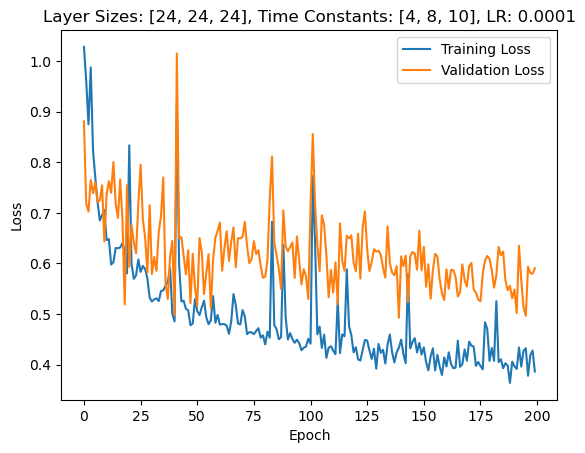

  0%|          | 1/200 [00:14<46:26, 14.00s/it]

Epoch 1/200, Training Loss: 1.645443004257274, Validation Loss: 0.8985950776508876


  1%|          | 2/200 [00:27<45:35, 13.82s/it]

Epoch 2/200, Training Loss: 0.9823273577780094, Validation Loss: 0.7810827493667603


  2%|▏         | 3/200 [00:40<44:19, 13.50s/it]

Epoch 3/200, Training Loss: 1.0323935049884725, Validation Loss: 0.8341285160609654


  2%|▏         | 4/200 [00:53<43:29, 13.32s/it]

Epoch 4/200, Training Loss: 0.7915616164792258, Validation Loss: 0.5413555673190525


  2%|▎         | 5/200 [01:07<43:18, 13.33s/it]

Epoch 5/200, Training Loss: 0.6339535645718845, Validation Loss: 0.6532530869756427


  3%|▎         | 6/200 [01:21<43:50, 13.56s/it]

Epoch 6/200, Training Loss: 0.5880131552804191, Validation Loss: 0.47773616654532297


  4%|▎         | 7/200 [01:34<43:43, 13.59s/it]

Epoch 7/200, Training Loss: 0.5645385629163598, Validation Loss: 0.47605180527482716


  4%|▍         | 8/200 [01:48<43:36, 13.63s/it]

Epoch 8/200, Training Loss: 0.5576073246182136, Validation Loss: 0.5111774195517812


  4%|▍         | 9/200 [02:02<43:48, 13.76s/it]

Epoch 9/200, Training Loss: 0.5576054751873016, Validation Loss: 0.49620525751795086


  5%|▌         | 10/200 [02:16<43:18, 13.68s/it]

Epoch 10/200, Training Loss: 0.5161651235144094, Validation Loss: 0.464104274553912


  6%|▌         | 11/200 [02:29<42:33, 13.51s/it]

Epoch 11/200, Training Loss: 0.5168826855578512, Validation Loss: 0.4610459102051599


  6%|▌         | 12/200 [02:42<41:55, 13.38s/it]

Epoch 12/200, Training Loss: 0.49953291523006726, Validation Loss: 0.4845343029924801


  6%|▋         | 13/200 [02:55<41:56, 13.46s/it]

Epoch 13/200, Training Loss: 0.47845200125901205, Validation Loss: 0.47732795774936676


  7%|▋         | 14/200 [03:09<41:30, 13.39s/it]

Epoch 14/200, Training Loss: 0.48573058646804884, Validation Loss: 0.4527062624692917


  8%|▊         | 15/200 [03:22<41:08, 13.34s/it]

Epoch 15/200, Training Loss: 0.4827205960480672, Validation Loss: 0.468589505978993


  8%|▊         | 16/200 [03:36<41:16, 13.46s/it]

Epoch 16/200, Training Loss: 0.46520958503462234, Validation Loss: 0.4739407513822828


  8%|▊         | 17/200 [03:49<41:17, 13.54s/it]

Epoch 17/200, Training Loss: 0.4751784483779152, Validation Loss: 0.45637312850781847


  9%|▉         | 18/200 [04:02<40:25, 13.33s/it]

Epoch 18/200, Training Loss: 0.4692357376498996, Validation Loss: 0.459192903978484


 10%|▉         | 19/200 [04:15<39:58, 13.25s/it]

Epoch 19/200, Training Loss: 0.4855988751042564, Validation Loss: 0.46911304124764036


 10%|█         | 20/200 [04:28<39:34, 13.19s/it]

Epoch 20/200, Training Loss: 0.44334898776603193, Validation Loss: 0.4956492909363338


 10%|█         | 21/200 [04:42<39:30, 13.24s/it]

Epoch 21/200, Training Loss: 0.45749072927349016, Validation Loss: 0.4798317530325481


 11%|█         | 22/200 [04:55<39:42, 13.38s/it]

Epoch 22/200, Training Loss: 0.45408320455056317, Validation Loss: 0.48178737823452267


 12%|█▏        | 23/200 [05:08<39:11, 13.28s/it]

Epoch 23/200, Training Loss: 0.4477353489623879, Validation Loss: 0.4639012834855488


 12%|█▏        | 24/200 [05:21<38:38, 13.17s/it]

Epoch 24/200, Training Loss: 0.44130435979591226, Validation Loss: 0.45050203800201416


 12%|█▎        | 25/200 [05:35<39:09, 13.43s/it]

Epoch 25/200, Training Loss: 0.4486174091415585, Validation Loss: 0.44479425464357647


 13%|█▎        | 26/200 [05:48<38:31, 13.29s/it]

Epoch 26/200, Training Loss: 0.44722124737388685, Validation Loss: 0.43743607508284704


 14%|█▎        | 27/200 [06:02<38:15, 13.27s/it]

Epoch 27/200, Training Loss: 0.43821069654428735, Validation Loss: 0.4332036205700466


 14%|█▍        | 28/200 [06:14<37:38, 13.13s/it]

Epoch 28/200, Training Loss: 0.4441345643322423, Validation Loss: 0.4543134208236422


 14%|█▍        | 29/200 [06:27<37:09, 13.04s/it]

Epoch 29/200, Training Loss: 0.4205865812189174, Validation Loss: 0.4402180633374623


 15%|█▌        | 30/200 [06:40<36:58, 13.05s/it]

Epoch 30/200, Training Loss: 0.40998218784917073, Validation Loss: 0.4370927374277796


 16%|█▌        | 31/200 [06:53<36:41, 13.03s/it]

Epoch 31/200, Training Loss: 0.41939308058540775, Validation Loss: 0.46972875722817015


 16%|█▌        | 32/200 [07:06<36:24, 13.00s/it]

Epoch 32/200, Training Loss: 0.4119784966954645, Validation Loss: 0.4300793239048549


 16%|█▋        | 33/200 [07:19<36:16, 13.03s/it]

Epoch 33/200, Training Loss: 0.42599512805353923, Validation Loss: 0.43367508160216467


 17%|█▋        | 34/200 [07:33<36:37, 13.24s/it]

Epoch 34/200, Training Loss: 0.4184566538007754, Validation Loss: 0.46111380628177095


 18%|█▊        | 35/200 [07:47<36:36, 13.31s/it]

Epoch 35/200, Training Loss: 0.4097593124463873, Validation Loss: 0.4318382143974304


 18%|█▊        | 36/200 [07:59<36:04, 13.20s/it]

Epoch 36/200, Training Loss: 0.4011112184457059, Validation Loss: 0.42904732057026457


 18%|█▊        | 37/200 [08:12<35:36, 13.11s/it]

Epoch 37/200, Training Loss: 0.40513635497048217, Validation Loss: 0.4347242053065981


 19%|█▉        | 38/200 [08:26<36:05, 13.37s/it]

Epoch 38/200, Training Loss: 0.3910920410504881, Validation Loss: 0.42333947122097015


 20%|█▉        | 39/200 [08:39<35:40, 13.29s/it]

Epoch 39/200, Training Loss: 0.375025138961819, Validation Loss: 0.424831639443125


 20%|██        | 40/200 [08:52<35:09, 13.18s/it]

Epoch 40/200, Training Loss: 0.3770027616113987, Validation Loss: 0.4170916272061212


 20%|██        | 41/200 [09:05<34:53, 13.17s/it]

Epoch 41/200, Training Loss: 0.38761208642203854, Validation Loss: 0.4194517880678177


 21%|██        | 42/200 [09:19<34:38, 13.15s/it]

Epoch 42/200, Training Loss: 0.3931285715046919, Validation Loss: 0.42243588822228567


 22%|██▏       | 43/200 [09:32<34:27, 13.17s/it]

Epoch 43/200, Training Loss: 0.3879741410601814, Validation Loss: 0.428664145725114


 22%|██▏       | 44/200 [09:45<33:59, 13.07s/it]

Epoch 44/200, Training Loss: 0.3750441729460122, Validation Loss: 0.44995627658707754


 22%|██▎       | 45/200 [09:58<33:44, 13.06s/it]

Epoch 45/200, Training Loss: 0.3669855412939247, Validation Loss: 0.40551323337214334


 23%|██▎       | 46/200 [10:11<33:34, 13.08s/it]

Epoch 46/200, Training Loss: 0.3671155684399155, Validation Loss: 0.41293991676398684


 24%|██▎       | 47/200 [10:25<33:48, 13.26s/it]

Epoch 47/200, Training Loss: 0.36178838531925994, Validation Loss: 0.4107462891510555


 24%|██▍       | 48/200 [10:38<33:34, 13.25s/it]

Epoch 48/200, Training Loss: 0.3571683978134731, Validation Loss: 0.4149658041340964


 24%|██▍       | 49/200 [10:51<33:17, 13.23s/it]

Epoch 49/200, Training Loss: 0.35353767703164296, Validation Loss: 0.4211135506629944


 25%|██▌       | 50/200 [11:04<32:57, 13.18s/it]

Epoch 50/200, Training Loss: 0.3579524742825976, Validation Loss: 0.40667539834976196


 26%|██▌       | 51/200 [11:18<33:24, 13.45s/it]

Epoch 51/200, Training Loss: 0.38356681168079376, Validation Loss: 0.3951240522520883


 26%|██▌       | 52/200 [11:31<32:51, 13.32s/it]

Epoch 52/200, Training Loss: 0.35134403885535476, Validation Loss: 0.3963933161326817


 26%|██▋       | 53/200 [11:44<32:21, 13.21s/it]

Epoch 53/200, Training Loss: 0.3559891627925747, Validation Loss: 0.4090340627091272


 27%|██▋       | 54/200 [11:57<32:11, 13.23s/it]

Epoch 54/200, Training Loss: 0.36533615808441955, Validation Loss: 0.39828858843871523


 28%|██▊       | 55/200 [12:10<31:42, 13.12s/it]

Epoch 55/200, Training Loss: 0.35297789185676937, Validation Loss: 0.39821942789214


 28%|██▊       | 56/200 [12:23<31:24, 13.09s/it]

Epoch 56/200, Training Loss: 0.3610228361948481, Validation Loss: 0.4021634800093515


 28%|██▊       | 57/200 [12:36<31:09, 13.07s/it]

Epoch 57/200, Training Loss: 0.3451842195442263, Validation Loss: 0.40041610172816683


 29%|██▉       | 58/200 [12:49<30:48, 13.02s/it]

Epoch 58/200, Training Loss: 0.3697207527902891, Validation Loss: 0.44661265185901095


 30%|██▉       | 59/200 [13:02<30:37, 13.03s/it]

Epoch 59/200, Training Loss: 0.34872137368568834, Validation Loss: 0.39604324315275463


 30%|███       | 60/200 [13:16<30:45, 13.18s/it]

Epoch 60/200, Training Loss: 0.3644517522375539, Validation Loss: 0.39879733536924633


 30%|███       | 61/200 [13:29<30:33, 13.19s/it]

Epoch 61/200, Training Loss: 0.3432750991492901, Validation Loss: 0.4111280824456896


 31%|███       | 62/200 [13:42<30:22, 13.21s/it]

Epoch 62/200, Training Loss: 0.34127912487623824, Validation Loss: 0.3975711443594524


 32%|███▏      | 63/200 [13:55<30:01, 13.15s/it]

Epoch 63/200, Training Loss: 0.3317648251101656, Validation Loss: 0.4105454108544758


 32%|███▏      | 64/200 [14:09<30:16, 13.36s/it]

Epoch 64/200, Training Loss: 0.3354471706837978, Validation Loss: 0.4011722356081009


 32%|███▎      | 65/200 [14:22<29:55, 13.30s/it]

Epoch 65/200, Training Loss: 0.33473675698041916, Validation Loss: 0.39844271753515514


 33%|███▎      | 66/200 [14:35<29:31, 13.22s/it]

Epoch 66/200, Training Loss: 0.3464500788810118, Validation Loss: 0.39783445426395964


 34%|███▎      | 67/200 [14:48<29:14, 13.19s/it]

Epoch 67/200, Training Loss: 0.33380220696892376, Validation Loss: 0.4025906984295164


 34%|███▍      | 68/200 [15:01<28:51, 13.12s/it]

Epoch 68/200, Training Loss: 0.33110175851099893, Validation Loss: 0.4461947126047952


 34%|███▍      | 69/200 [15:14<28:33, 13.08s/it]

Epoch 69/200, Training Loss: 0.33742182673710697, Validation Loss: 0.39369203576019834


 35%|███▌      | 70/200 [15:27<28:22, 13.10s/it]

Epoch 70/200, Training Loss: 0.3352663147280801, Validation Loss: 0.4314978484596525


 36%|███▌      | 71/200 [15:40<28:01, 13.03s/it]

Epoch 71/200, Training Loss: 0.36129759167725184, Validation Loss: 0.4039634125573294


 36%|███▌      | 72/200 [15:53<27:44, 13.01s/it]

Epoch 72/200, Training Loss: 0.33692766205882124, Validation Loss: 0.41049531953675406


 36%|███▋      | 73/200 [16:07<28:05, 13.27s/it]

Epoch 73/200, Training Loss: 0.33668241242192826, Validation Loss: 0.4001030709062304


 37%|███▋      | 74/200 [16:21<27:57, 13.31s/it]

Epoch 74/200, Training Loss: 0.3276029444246922, Validation Loss: 0.43183861460004536


 38%|███▊      | 75/200 [16:34<27:41, 13.29s/it]

Epoch 75/200, Training Loss: 0.33481762986981645, Validation Loss: 0.39486779485430035


 38%|███▊      | 76/200 [16:47<27:16, 13.19s/it]

Epoch 76/200, Training Loss: 0.327128085887657, Validation Loss: 0.41794237068721224


 38%|███▊      | 77/200 [17:01<27:25, 13.38s/it]

Epoch 77/200, Training Loss: 0.327855452824876, Validation Loss: 0.39450352106775555


 39%|███▉      | 78/200 [17:14<27:16, 13.42s/it]

Epoch 78/200, Training Loss: 0.3415179723205994, Validation Loss: 0.3914393335580826


 40%|███▉      | 79/200 [17:27<26:44, 13.26s/it]

Epoch 79/200, Training Loss: 0.33546660390664945, Validation Loss: 0.3963212307010378


 40%|████      | 80/200 [17:40<26:23, 13.20s/it]

Epoch 80/200, Training Loss: 0.33332684832923815, Validation Loss: 0.38212853031499044


 40%|████      | 81/200 [17:53<26:07, 13.17s/it]

Epoch 81/200, Training Loss: 0.328666923181066, Validation Loss: 0.40888016138757977


 41%|████      | 82/200 [18:06<25:44, 13.09s/it]

Epoch 82/200, Training Loss: 0.3269925363502412, Validation Loss: 0.386479132941791


 42%|████▏     | 83/200 [18:19<25:34, 13.12s/it]

Epoch 83/200, Training Loss: 0.3482462618992014, Validation Loss: 0.40392651728221346


 42%|████▏     | 84/200 [18:32<25:14, 13.06s/it]

Epoch 84/200, Training Loss: 0.3327083594675334, Validation Loss: 0.45029984627451214


 42%|████▎     | 85/200 [18:45<24:58, 13.03s/it]

Epoch 85/200, Training Loss: 0.32889444507517906, Validation Loss: 0.39550166044916424


 43%|████▎     | 86/200 [18:59<25:19, 13.33s/it]

Epoch 86/200, Training Loss: 0.3347062308270976, Validation Loss: 0.3752963883536203


 44%|████▎     | 87/200 [19:13<25:08, 13.35s/it]

Epoch 87/200, Training Loss: 0.32223652464882385, Validation Loss: 0.3958244366305215


 44%|████▍     | 88/200 [19:26<24:52, 13.32s/it]

Epoch 88/200, Training Loss: 0.319498581425199, Validation Loss: 0.38430414881025043


 44%|████▍     | 89/200 [19:39<24:30, 13.25s/it]

Epoch 89/200, Training Loss: 0.333416149582503, Validation Loss: 0.3921963572502136


 45%|████▌     | 90/200 [19:53<24:41, 13.47s/it]

Epoch 90/200, Training Loss: 0.32738923119767654, Validation Loss: 0.3796719993863787


 46%|████▌     | 91/200 [20:06<24:21, 13.41s/it]

Epoch 91/200, Training Loss: 0.31909446896247146, Validation Loss: 0.4174803878579821


 46%|████▌     | 92/200 [20:19<23:52, 13.26s/it]

Epoch 92/200, Training Loss: 0.3157484276255347, Validation Loss: 0.3981685297829764


 46%|████▋     | 93/200 [20:32<23:31, 13.19s/it]

Epoch 93/200, Training Loss: 0.3272644007262194, Validation Loss: 0.4335317313671112


 47%|████▋     | 94/200 [20:45<23:18, 13.19s/it]

Epoch 94/200, Training Loss: 0.33377040514968476, Validation Loss: 0.3844874607665198


 48%|████▊     | 95/200 [20:58<22:55, 13.10s/it]

Epoch 95/200, Training Loss: 0.3254740988870837, Validation Loss: 0.3887852962527956


 48%|████▊     | 96/200 [21:11<22:40, 13.08s/it]

Epoch 96/200, Training Loss: 0.31377406488612014, Validation Loss: 0.38846177075590405


 48%|████▊     | 97/200 [21:24<22:27, 13.08s/it]

Epoch 97/200, Training Loss: 0.3196050703244389, Validation Loss: 0.38407520736966816


 49%|████▉     | 98/200 [21:37<22:12, 13.06s/it]

Epoch 98/200, Training Loss: 0.3156552413162195, Validation Loss: 0.3993398611034666


 50%|████▉     | 99/200 [21:51<22:30, 13.37s/it]

Epoch 99/200, Training Loss: 0.3394530450679221, Validation Loss: 0.3913694109235491


 50%|█████     | 100/200 [22:05<22:12, 13.33s/it]

Epoch 100/200, Training Loss: 0.3266900672384028, Validation Loss: 0.3997663195644106


 50%|█████     | 101/200 [22:18<21:48, 13.21s/it]

Epoch 101/200, Training Loss: 0.31405941418038225, Validation Loss: 0.3893320305006845


 51%|█████     | 102/200 [22:31<21:36, 13.23s/it]

Epoch 102/200, Training Loss: 0.3201568052172661, Validation Loss: 0.38102246820926666


 52%|█████▏    | 103/200 [22:45<21:40, 13.41s/it]

Epoch 103/200, Training Loss: 0.3123389152142237, Validation Loss: 0.40368703433445524


 52%|█████▏    | 104/200 [22:58<21:23, 13.37s/it]

Epoch 104/200, Training Loss: 0.3201787213812459, Validation Loss: 0.3865450194903782


 52%|█████▎    | 105/200 [23:11<20:59, 13.26s/it]

Epoch 105/200, Training Loss: 0.32745528094611076, Validation Loss: 0.387675336429051


 53%|█████▎    | 106/200 [23:24<20:46, 13.26s/it]

Epoch 106/200, Training Loss: 0.3215992231414003, Validation Loss: 0.39221103489398956


 54%|█████▎    | 107/200 [23:37<20:31, 13.24s/it]

Epoch 107/200, Training Loss: 0.30778852491727415, Validation Loss: 0.4090238021952765


 54%|█████▍    | 108/200 [23:50<20:11, 13.17s/it]

Epoch 108/200, Training Loss: 0.3089146115026384, Validation Loss: 0.41082375603062765


 55%|█████▍    | 109/200 [24:03<19:53, 13.12s/it]

Epoch 109/200, Training Loss: 0.3234925184328601, Validation Loss: 0.40741405316761564


 55%|█████▌    | 110/200 [24:17<19:44, 13.16s/it]

Epoch 110/200, Training Loss: 0.33288881351362987, Validation Loss: 0.38597221459661213


 56%|█████▌    | 111/200 [24:30<19:29, 13.14s/it]

Epoch 111/200, Training Loss: 0.3088002306110454, Validation Loss: 0.38803442886897493


 56%|█████▌    | 112/200 [24:44<19:35, 13.36s/it]

Epoch 112/200, Training Loss: 0.3177100228813459, Validation Loss: 0.3875099207673754


 56%|█████▋    | 113/200 [24:57<19:21, 13.35s/it]

Epoch 113/200, Training Loss: 0.30658190655258466, Validation Loss: 0.393576911517552


 57%|█████▋    | 114/200 [25:10<18:59, 13.25s/it]

Epoch 114/200, Training Loss: 0.30372357452815435, Validation Loss: 0.3924169199807303


 57%|█████▊    | 115/200 [25:24<19:10, 13.54s/it]

Epoch 115/200, Training Loss: 0.3270385264647457, Validation Loss: 0.36925179191998075


 58%|█████▊    | 116/200 [25:37<18:45, 13.40s/it]

Epoch 116/200, Training Loss: 0.3088263231066038, Validation Loss: 0.4137493797710964


 58%|█████▊    | 117/200 [25:50<18:20, 13.26s/it]

Epoch 117/200, Training Loss: 0.3136188047674467, Validation Loss: 0.4393438526562282


 59%|█████▉    | 118/200 [26:03<18:06, 13.25s/it]

Epoch 118/200, Training Loss: 0.31095849343065946, Validation Loss: 0.38183479223932537


 60%|█████▉    | 119/200 [26:16<17:49, 13.21s/it]

Epoch 119/200, Training Loss: 0.3201535124823732, Validation Loss: 0.3867043767656599


 60%|██████    | 120/200 [26:30<17:35, 13.19s/it]

Epoch 120/200, Training Loss: 0.31080310299711406, Validation Loss: 0.40338921759809765


 60%|██████    | 121/200 [26:43<17:20, 13.17s/it]

Epoch 121/200, Training Loss: 0.2998216282927765, Validation Loss: 0.4140029698610306


 61%|██████    | 122/200 [26:56<17:03, 13.13s/it]

Epoch 122/200, Training Loss: 0.305309404320312, Validation Loss: 0.3904487469366619


 62%|██████▏   | 123/200 [27:09<16:51, 13.14s/it]

Epoch 123/200, Training Loss: 0.29998336915137636, Validation Loss: 0.4022213731493269


 62%|██████▏   | 124/200 [27:23<16:55, 13.36s/it]

Epoch 124/200, Training Loss: 0.3143392671953957, Validation Loss: 0.4317057452031544


 62%|██████▎   | 125/200 [27:36<16:38, 13.31s/it]

Epoch 125/200, Training Loss: 0.3204383026316481, Validation Loss: 0.4058054046971457


 63%|██████▎   | 126/200 [27:49<16:21, 13.26s/it]

Epoch 126/200, Training Loss: 0.3181755355787727, Validation Loss: 0.39150623764310566


 64%|██████▎   | 127/200 [28:02<16:00, 13.16s/it]

Epoch 127/200, Training Loss: 0.3181909190596275, Validation Loss: 0.39874897258622305


 64%|██████▍   | 128/200 [28:16<16:12, 13.51s/it]

Epoch 128/200, Training Loss: 0.30215807554294477, Validation Loss: 0.4261654828275953


 64%|██████▍   | 129/200 [28:30<15:54, 13.44s/it]

Epoch 129/200, Training Loss: 0.30906003945559823, Validation Loss: 0.4119997663157327


 65%|██████▌   | 130/200 [28:43<15:32, 13.32s/it]

Epoch 130/200, Training Loss: 0.3092365673971626, Validation Loss: 0.3932555913925171


 66%|██████▌   | 131/200 [28:56<15:19, 13.32s/it]

Epoch 131/200, Training Loss: 0.30403308696904274, Validation Loss: 0.4057147800922394


 66%|██████▌   | 132/200 [29:09<14:59, 13.23s/it]

Epoch 132/200, Training Loss: 0.2970706360801211, Validation Loss: 0.4115889476878302


 66%|██████▋   | 133/200 [29:22<14:39, 13.13s/it]

Epoch 133/200, Training Loss: 0.2983749622725091, Validation Loss: 0.409883656672069


 67%|██████▋   | 134/200 [29:35<14:25, 13.12s/it]

Epoch 134/200, Training Loss: 0.2947653397777171, Validation Loss: 0.40518815176827566


 68%|██████▊   | 135/200 [29:48<14:08, 13.05s/it]

Epoch 135/200, Training Loss: 0.3078027609384285, Validation Loss: 0.46275009853499277


 68%|██████▊   | 136/200 [30:01<13:55, 13.05s/it]

Epoch 136/200, Training Loss: 0.30514070103472135, Validation Loss: 0.3971522791045053


 68%|██████▊   | 137/200 [30:15<14:00, 13.33s/it]

Epoch 137/200, Training Loss: 0.30589244809915433, Validation Loss: 0.3885351823908942


 69%|██████▉   | 138/200 [30:28<13:45, 13.31s/it]

Epoch 138/200, Training Loss: 0.2981217400223579, Validation Loss: 0.4016467992748533


 70%|██████▉   | 139/200 [30:41<13:28, 13.26s/it]

Epoch 139/200, Training Loss: 0.31115550674357506, Validation Loss: 0.37487928356443134


 70%|███████   | 140/200 [30:54<13:09, 13.16s/it]

Epoch 140/200, Training Loss: 0.30167356709826665, Validation Loss: 0.40327916613646914


 70%|███████   | 141/200 [31:08<13:06, 13.33s/it]

Epoch 141/200, Training Loss: 0.3055833285709597, Validation Loss: 0.3863228644643511


 71%|███████   | 142/200 [31:22<12:55, 13.37s/it]

Epoch 142/200, Training Loss: 0.2953179872260903, Validation Loss: 0.380134431379182


 72%|███████▏  | 143/200 [31:35<12:35, 13.26s/it]

Epoch 143/200, Training Loss: 0.30055955769318454, Validation Loss: 0.3817421538489206


 72%|███████▏  | 144/200 [31:48<12:18, 13.18s/it]

Epoch 144/200, Training Loss: 0.30268931290451084, Validation Loss: 0.3778979501553944


 72%|███████▎  | 145/200 [32:01<12:06, 13.20s/it]

Epoch 145/200, Training Loss: 0.28742151138073996, Validation Loss: 0.4334005798612322


 73%|███████▎  | 146/200 [32:14<11:48, 13.12s/it]

Epoch 146/200, Training Loss: 0.3024061105723651, Validation Loss: 0.4124526722090585


 74%|███████▎  | 147/200 [32:27<11:35, 13.12s/it]

Epoch 147/200, Training Loss: 0.29049584775600795, Validation Loss: 0.3895517374788012


 74%|███████▍  | 148/200 [32:40<11:20, 13.09s/it]

Epoch 148/200, Training Loss: 0.3166555717306317, Validation Loss: 0.3955639451742172


 74%|███████▍  | 149/200 [32:53<11:04, 13.04s/it]

Epoch 149/200, Training Loss: 0.29096193611621857, Validation Loss: 0.3857221496956689


 75%|███████▌  | 150/200 [33:07<11:06, 13.33s/it]

Epoch 150/200, Training Loss: 0.30131023517757094, Validation Loss: 0.3801401959998267


 76%|███████▌  | 151/200 [33:20<10:56, 13.39s/it]

Epoch 151/200, Training Loss: 0.29152124304816407, Validation Loss: 0.3968657063586371


 76%|███████▌  | 152/200 [33:34<10:41, 13.36s/it]

Epoch 152/200, Training Loss: 0.2936361592333272, Validation Loss: 0.38798536147390095


 76%|███████▋  | 153/200 [33:47<10:25, 13.30s/it]

Epoch 153/200, Training Loss: 0.29710612713166, Validation Loss: 0.38281339619840893


 77%|███████▋  | 154/200 [34:01<10:19, 13.48s/it]

Epoch 154/200, Training Loss: 0.2978417226025518, Validation Loss: 0.3752222933939525


 78%|███████▊  | 155/200 [34:14<10:08, 13.52s/it]

Epoch 155/200, Training Loss: 0.2907942711322937, Validation Loss: 0.38487459293433596


 78%|███████▊  | 156/200 [34:27<09:46, 13.34s/it]

Epoch 156/200, Training Loss: 0.29230012716549747, Validation Loss: 0.3875962517091206


 78%|███████▊  | 157/200 [34:40<09:28, 13.23s/it]

Epoch 157/200, Training Loss: 0.29775726795196533, Validation Loss: 0.38004795781203676


 79%|███████▉  | 158/200 [34:54<09:18, 13.29s/it]

Epoch 158/200, Training Loss: 0.28943054371003835, Validation Loss: 0.3824615797826222


 80%|███████▉  | 159/200 [35:07<09:01, 13.22s/it]

Epoch 159/200, Training Loss: 0.2858067022039081, Validation Loss: 0.36223114814077106


 80%|████████  | 160/200 [35:20<08:48, 13.20s/it]

Epoch 160/200, Training Loss: 0.2849246249446329, Validation Loss: 0.3947369945900781


 80%|████████  | 161/200 [35:33<08:33, 13.17s/it]

Epoch 161/200, Training Loss: 0.29014270330937403, Validation Loss: 0.3942904642650059


 81%|████████  | 162/200 [35:46<08:16, 13.06s/it]

Epoch 162/200, Training Loss: 0.279881885029235, Validation Loss: 0.3871126366513116


 82%|████████▏ | 163/200 [36:00<08:12, 13.31s/it]

Epoch 163/200, Training Loss: 0.284527137172672, Validation Loss: 0.37318759730884005


 82%|████████▏ | 164/200 [36:13<08:01, 13.38s/it]

Epoch 164/200, Training Loss: 0.2900513804183816, Validation Loss: 0.3767534962722233


 82%|████████▎ | 165/200 [36:26<07:44, 13.26s/it]

Epoch 165/200, Training Loss: 0.2834351251147828, Validation Loss: 0.3905122833592551


 83%|████████▎ | 166/200 [36:39<07:31, 13.29s/it]

Epoch 166/200, Training Loss: 0.27913293727445154, Validation Loss: 0.3772075282675879


 84%|████████▎ | 167/200 [36:53<07:24, 13.47s/it]

Epoch 167/200, Training Loss: 0.29074086248874664, Validation Loss: 0.38080611186368124


 84%|████████▍ | 168/200 [37:07<07:11, 13.48s/it]

Epoch 168/200, Training Loss: 0.279291995432017, Validation Loss: 0.35524710161345346


 84%|████████▍ | 169/200 [37:20<06:55, 13.42s/it]

Epoch 169/200, Training Loss: 0.2894457497827287, Validation Loss: 0.3960770730461393


 85%|████████▌ | 170/200 [37:33<06:38, 13.28s/it]

Epoch 170/200, Training Loss: 0.2769482290758839, Validation Loss: 0.3989203763859613


 86%|████████▌ | 171/200 [37:46<06:24, 13.24s/it]

Epoch 171/200, Training Loss: 0.2872173828336428, Validation Loss: 0.3742999860218593


 86%|████████▌ | 172/200 [37:59<06:10, 13.23s/it]

Epoch 172/200, Training Loss: 0.27989382964541326, Validation Loss: 0.40035573712417055


 86%|████████▋ | 173/200 [38:13<05:56, 13.19s/it]

Epoch 173/200, Training Loss: 0.29658167949824965, Validation Loss: 0.3843094621385847


 87%|████████▋ | 174/200 [38:26<05:43, 13.23s/it]

Epoch 174/200, Training Loss: 0.2955236011799776, Validation Loss: 0.42448338866233826


 88%|████████▊ | 175/200 [38:39<05:29, 13.17s/it]

Epoch 175/200, Training Loss: 0.2854120833974964, Validation Loss: 0.37478969778333393


 88%|████████▊ | 176/200 [38:53<05:21, 13.40s/it]

Epoch 176/200, Training Loss: 0.2626618851889979, Validation Loss: 0.3837162341390337


 88%|████████▊ | 177/200 [39:06<05:07, 13.39s/it]

Epoch 177/200, Training Loss: 0.2772286520954573, Validation Loss: 0.4901280365884304


 89%|████████▉ | 178/200 [39:20<04:54, 13.37s/it]

Epoch 178/200, Training Loss: 0.29439533607296225, Validation Loss: 0.36452176528317587


 90%|████████▉ | 179/200 [39:33<04:39, 13.33s/it]

Epoch 179/200, Training Loss: 0.29460478117162325, Validation Loss: 0.3806058445147106


 90%|█████████ | 180/200 [39:46<04:28, 13.43s/it]

Epoch 180/200, Training Loss: 0.2938895308465328, Validation Loss: 0.45806312561035156


 90%|█████████ | 181/200 [40:00<04:13, 13.36s/it]

Epoch 181/200, Training Loss: 0.2973056992972797, Validation Loss: 0.3875538132020405


 91%|█████████ | 182/200 [40:13<03:59, 13.33s/it]

Epoch 182/200, Training Loss: 0.28245409205555916, Validation Loss: 0.38450377753802706


 92%|█████████▏| 183/200 [40:26<03:46, 13.30s/it]

Epoch 183/200, Training Loss: 0.2695933258477247, Validation Loss: 0.3806515463760921


 92%|█████████▏| 184/200 [40:39<03:32, 13.28s/it]

Epoch 184/200, Training Loss: 0.2692973169515718, Validation Loss: 0.4506479246275766


 92%|█████████▎| 185/200 [40:52<03:18, 13.21s/it]

Epoch 185/200, Training Loss: 0.28226280950431554, Validation Loss: 0.41717763032232014


 93%|█████████▎| 186/200 [41:06<03:05, 13.21s/it]

Epoch 186/200, Training Loss: 0.28499367341118037, Validation Loss: 0.5191136747598648


 94%|█████████▎| 187/200 [41:19<02:51, 13.21s/it]

Epoch 187/200, Training Loss: 0.2977078791778043, Validation Loss: 0.39749864488840103


 94%|█████████▍| 188/200 [41:32<02:37, 13.16s/it]

Epoch 188/200, Training Loss: 0.28491111633912575, Validation Loss: 0.39413653526987347


 94%|█████████▍| 189/200 [41:46<02:26, 13.35s/it]

Epoch 189/200, Training Loss: 0.26015056880577553, Validation Loss: 0.38316059538296293


 95%|█████████▌| 190/200 [41:59<02:14, 13.44s/it]

Epoch 190/200, Training Loss: 0.30548471985560544, Validation Loss: 0.4130109804017203


 96%|█████████▌| 191/200 [42:12<01:59, 13.31s/it]

Epoch 191/200, Training Loss: 0.285101823157297, Validation Loss: 0.4000896747623171


 96%|█████████▌| 192/200 [42:26<01:46, 13.34s/it]

Epoch 192/200, Training Loss: 0.2675334354335407, Validation Loss: 0.38204069009849


 96%|█████████▋| 193/200 [42:40<01:34, 13.52s/it]

Epoch 193/200, Training Loss: 0.2887121312460809, Validation Loss: 0.39859058601515635


 97%|█████████▋| 194/200 [42:53<01:20, 13.42s/it]

Epoch 194/200, Training Loss: 0.26416546036050004, Validation Loss: 0.40002437361649107


 98%|█████████▊| 195/200 [43:06<01:06, 13.37s/it]

Epoch 195/200, Training Loss: 0.2784172740747344, Validation Loss: 0.3934809012072427


 98%|█████████▊| 196/200 [43:19<00:53, 13.25s/it]

Epoch 196/200, Training Loss: 0.2814306868767401, Validation Loss: 0.4066381262881415


 98%|█████████▊| 197/200 [43:32<00:39, 13.24s/it]

Epoch 197/200, Training Loss: 0.2606383815829484, Validation Loss: 0.3953723652022226


 99%|█████████▉| 198/200 [43:45<00:26, 13.21s/it]

Epoch 198/200, Training Loss: 0.2610615616980589, Validation Loss: 0.3955868525164468


100%|█████████▉| 199/200 [43:59<00:13, 13.17s/it]

Epoch 199/200, Training Loss: 0.2897742653511605, Validation Loss: 0.39329702087811064


100%|██████████| 200/200 [44:12<00:00, 13.26s/it]

Epoch 200/200, Training Loss: 0.26173980681682535, Validation Loss: 0.3959775077445166
Final Accuracy: 92.17%, Precision: 0.92, Recall: 0.92


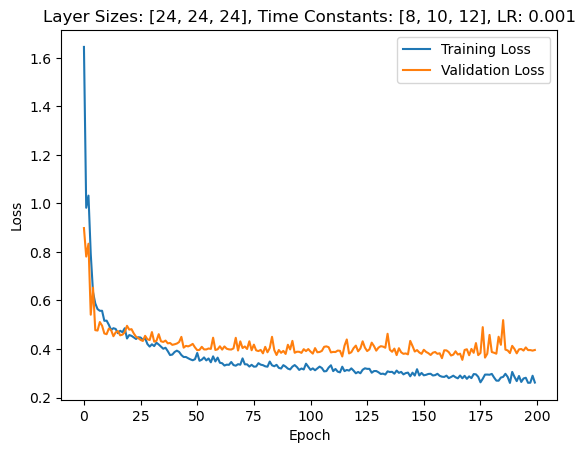

  0%|          | 1/200 [00:13<45:36, 13.75s/it]

Epoch 1/200, Training Loss: 1.0316213403107986, Validation Loss: 0.9475776893751962


  1%|          | 2/200 [00:27<45:13, 13.71s/it]

Epoch 2/200, Training Loss: 1.0264120810436752, Validation Loss: 0.906860990183694


  2%|▏         | 3/200 [00:40<44:35, 13.58s/it]

Epoch 3/200, Training Loss: 0.9199525466505086, Validation Loss: 0.690039438860757


  2%|▏         | 4/200 [00:53<43:36, 13.35s/it]

Epoch 4/200, Training Loss: 1.1950024726255886, Validation Loss: 0.8568706171853202


  2%|▎         | 5/200 [01:06<43:05, 13.26s/it]

Epoch 5/200, Training Loss: 0.917624795211936, Validation Loss: 0.8370211124420166


  3%|▎         | 6/200 [01:20<43:15, 13.38s/it]

Epoch 6/200, Training Loss: 0.8655486286811109, Validation Loss: 0.7125614583492279


  4%|▎         | 7/200 [01:34<43:24, 13.50s/it]

Epoch 7/200, Training Loss: 0.8272680550251367, Validation Loss: 0.6218384206295013


  4%|▍         | 8/200 [01:48<43:31, 13.60s/it]

Epoch 8/200, Training Loss: 0.8269611057245506, Validation Loss: 0.7383516409567424


  4%|▍         | 9/200 [02:01<43:14, 13.58s/it]

Epoch 9/200, Training Loss: 0.8411988818420554, Validation Loss: 0.6619505350078855


  5%|▌         | 10/200 [02:15<42:56, 13.56s/it]

Epoch 10/200, Training Loss: 0.837225650841335, Validation Loss: 0.674737349152565


  6%|▌         | 11/200 [02:28<42:09, 13.39s/it]

Epoch 11/200, Training Loss: 0.7860166683511914, Validation Loss: 0.678287210209029


  6%|▌         | 12/200 [02:41<42:12, 13.47s/it]

Epoch 12/200, Training Loss: 0.7649023116759535, Validation Loss: 0.6828747519424984


  6%|▋         | 13/200 [02:55<41:43, 13.39s/it]

Epoch 13/200, Training Loss: 0.731250266421516, Validation Loss: 0.6452536987406867


  7%|▋         | 14/200 [03:07<41:06, 13.26s/it]

Epoch 14/200, Training Loss: 0.7149353257890018, Validation Loss: 0.6543011707918984


  8%|▊         | 15/200 [03:20<40:37, 13.18s/it]

Epoch 15/200, Training Loss: 0.7262902647819159, Validation Loss: 0.7044528680188316


  8%|▊         | 16/200 [03:34<40:54, 13.34s/it]

Epoch 16/200, Training Loss: 0.6944303186434619, Validation Loss: 0.6653537175485066


  8%|▊         | 17/200 [03:47<40:19, 13.22s/it]

Epoch 17/200, Training Loss: 0.6953085143611116, Validation Loss: 0.6696507941399302


  9%|▉         | 18/200 [04:00<39:45, 13.11s/it]

Epoch 18/200, Training Loss: 0.6841738735729793, Validation Loss: 0.6577428749629429


 10%|▉         | 19/200 [04:13<39:36, 13.13s/it]

Epoch 19/200, Training Loss: 0.6677522642432518, Validation Loss: 0.6297310824905124


 10%|█         | 20/200 [04:26<39:11, 13.07s/it]

Epoch 20/200, Training Loss: 0.6578553780069891, Validation Loss: 0.6890840721981866


 10%|█         | 21/200 [04:40<39:39, 13.29s/it]

Epoch 21/200, Training Loss: 0.8168481953863828, Validation Loss: 0.6494584381580353


 11%|█         | 22/200 [04:53<39:10, 13.20s/it]

Epoch 22/200, Training Loss: 0.6537160873413086, Validation Loss: 0.6701742027487073


 12%|█▏        | 23/200 [05:06<38:47, 13.15s/it]

Epoch 23/200, Training Loss: 0.6413542684519066, Validation Loss: 0.7933621512992042


 12%|█▏        | 24/200 [05:19<38:35, 13.16s/it]

Epoch 24/200, Training Loss: 0.6195502295246664, Validation Loss: 0.651593804359436


 12%|█▎        | 25/200 [05:33<38:55, 13.34s/it]

Epoch 25/200, Training Loss: 0.6387815784733251, Validation Loss: 0.6922794984919685


 13%|█▎        | 26/200 [05:46<38:33, 13.29s/it]

Epoch 26/200, Training Loss: 0.6175607229178807, Validation Loss: 0.7575887377773013


 14%|█▎        | 27/200 [05:59<38:10, 13.24s/it]

Epoch 27/200, Training Loss: 0.6191336248280868, Validation Loss: 0.6516075666461673


 14%|█▍        | 28/200 [06:12<37:41, 13.15s/it]

Epoch 28/200, Training Loss: 0.6070511383268068, Validation Loss: 0.6326842478343419


 14%|█▍        | 29/200 [06:25<37:21, 13.11s/it]

Epoch 29/200, Training Loss: 0.5890676114919051, Validation Loss: 0.5940899444477898


 15%|█▌        | 30/200 [06:38<37:06, 13.10s/it]

Epoch 30/200, Training Loss: 0.5916025751041916, Validation Loss: 0.7021742101226535


 16%|█▌        | 31/200 [06:51<36:49, 13.08s/it]

Epoch 31/200, Training Loss: 0.5803756604217133, Validation Loss: 0.5572492224829537


 16%|█▌        | 32/200 [07:04<36:41, 13.10s/it]

Epoch 32/200, Training Loss: 0.5699873825289169, Validation Loss: 0.6276981447424207


 16%|█▋        | 33/200 [07:17<36:12, 13.01s/it]

Epoch 33/200, Training Loss: 0.5606674158348227, Validation Loss: 0.6585275403090886


 17%|█▋        | 34/200 [07:31<36:35, 13.22s/it]

Epoch 34/200, Training Loss: 0.551359328458894, Validation Loss: 0.5960329707179751


 18%|█▊        | 35/200 [07:44<36:38, 13.33s/it]

Epoch 35/200, Training Loss: 0.5937855597936882, Validation Loss: 0.6536468331302915


 18%|█▊        | 36/200 [07:57<36:04, 13.20s/it]

Epoch 36/200, Training Loss: 0.5707622198563702, Validation Loss: 0.7042763041598457


 18%|█▊        | 37/200 [08:10<35:34, 13.10s/it]

Epoch 37/200, Training Loss: 0.5851255756504131, Validation Loss: 0.5432641101734978


 19%|█▉        | 38/200 [08:24<36:11, 13.41s/it]

Epoch 38/200, Training Loss: 0.5652057612841984, Validation Loss: 0.6194405896323067


 20%|█▉        | 39/200 [08:37<35:42, 13.31s/it]

Epoch 39/200, Training Loss: 0.6317479458619963, Validation Loss: 0.6938217069421496


 20%|██        | 40/200 [08:50<35:12, 13.20s/it]

Epoch 40/200, Training Loss: 0.5242673670345882, Validation Loss: 0.636488173689161


 20%|██        | 41/200 [09:03<34:53, 13.17s/it]

Epoch 41/200, Training Loss: 0.519309623623794, Validation Loss: 0.5793388911655971


 21%|██        | 42/200 [09:16<34:26, 13.08s/it]

Epoch 42/200, Training Loss: 0.7273016990918033, Validation Loss: 0.6774035798651832


 22%|██▏       | 43/200 [09:29<34:16, 13.10s/it]

Epoch 43/200, Training Loss: 0.574480302210124, Validation Loss: 0.6506176995379584


 22%|██▏       | 44/200 [09:42<33:51, 13.02s/it]

Epoch 44/200, Training Loss: 0.5563082110207036, Validation Loss: 0.5691353550979069


 22%|██▎       | 45/200 [09:55<33:31, 12.98s/it]

Epoch 45/200, Training Loss: 0.5561621248159768, Validation Loss: 0.6077854633331299


 23%|██▎       | 46/200 [10:08<33:32, 13.07s/it]

Epoch 46/200, Training Loss: 0.5446713145049114, Validation Loss: 0.6105519490582603


 24%|██▎       | 47/200 [10:22<33:39, 13.20s/it]

Epoch 47/200, Training Loss: 0.5331843804638341, Validation Loss: 0.5483074571405139


 24%|██▍       | 48/200 [10:35<33:23, 13.18s/it]

Epoch 48/200, Training Loss: 0.5111975731714716, Validation Loss: 0.5373531047786985


 24%|██▍       | 49/200 [10:48<33:12, 13.20s/it]

Epoch 49/200, Training Loss: 0.526948223979968, Validation Loss: 0.5814463709081922


 25%|██▌       | 50/200 [11:01<32:43, 13.09s/it]

Epoch 50/200, Training Loss: 0.5309351100674216, Validation Loss: 0.558127435190337


 26%|██▌       | 51/200 [11:15<33:04, 13.32s/it]

Epoch 51/200, Training Loss: 0.5184320307002878, Validation Loss: 0.5312405164752688


 26%|██▌       | 52/200 [11:28<32:48, 13.30s/it]

Epoch 52/200, Training Loss: 0.5048558903190324, Validation Loss: 0.6276714886937823


 26%|██▋       | 53/200 [11:41<32:17, 13.18s/it]

Epoch 53/200, Training Loss: 0.5219701714110825, Validation Loss: 0.5372403817517417


 27%|██▋       | 54/200 [11:54<31:57, 13.14s/it]

Epoch 54/200, Training Loss: 0.5152570388789447, Validation Loss: 0.5103727919714791


 28%|██▊       | 55/200 [12:07<31:31, 13.04s/it]

Epoch 55/200, Training Loss: 0.5099483492239466, Validation Loss: 0.5811095088720322


 28%|██▊       | 56/200 [12:20<31:07, 12.97s/it]

Epoch 56/200, Training Loss: 0.5220720922609545, Validation Loss: 0.6019931605884007


 28%|██▊       | 57/200 [12:33<31:05, 13.04s/it]

Epoch 57/200, Training Loss: 0.49518460246189583, Validation Loss: 0.5602388339383262


 29%|██▉       | 58/200 [12:46<30:45, 13.00s/it]

Epoch 58/200, Training Loss: 0.6468007803525565, Validation Loss: 0.673923922436578


 30%|██▉       | 59/200 [12:59<30:24, 12.94s/it]

Epoch 59/200, Training Loss: 0.5151147842407227, Validation Loss: 0.6238441169261932


 30%|███       | 60/200 [13:13<30:44, 13.18s/it]

Epoch 60/200, Training Loss: 0.5198087391425978, Validation Loss: 0.6363378422600883


 30%|███       | 61/200 [13:26<30:40, 13.24s/it]

Epoch 61/200, Training Loss: 0.5033536041682621, Validation Loss: 0.6619195895535606


 31%|███       | 62/200 [13:39<30:21, 13.20s/it]

Epoch 62/200, Training Loss: 0.5073962042916496, Validation Loss: 0.5602109389645713


 32%|███▏      | 63/200 [13:52<29:53, 13.09s/it]

Epoch 63/200, Training Loss: 0.49743842291382123, Validation Loss: 0.5940472206899098


 32%|███▏      | 64/200 [14:06<30:11, 13.32s/it]

Epoch 64/200, Training Loss: 0.4961559288906601, Validation Loss: 0.6168016833918435


 32%|███▎      | 65/200 [14:19<29:59, 13.33s/it]

Epoch 65/200, Training Loss: 0.49285066268354094, Validation Loss: 0.6162750720977783


 33%|███▎      | 66/200 [14:32<29:26, 13.19s/it]

Epoch 66/200, Training Loss: 0.4901281735807095, Validation Loss: 0.5457971479211535


 34%|███▎      | 67/200 [14:45<29:00, 13.08s/it]

Epoch 67/200, Training Loss: 0.5142756020123104, Validation Loss: 0.6361871830054692


 34%|███▍      | 68/200 [14:58<28:49, 13.10s/it]

Epoch 68/200, Training Loss: 0.5122981051791389, Validation Loss: 0.6055647219930377


 34%|███▍      | 69/200 [15:11<28:37, 13.11s/it]

Epoch 69/200, Training Loss: 0.47522496811623843, Validation Loss: 0.5930432038647788


 35%|███▌      | 70/200 [15:24<28:18, 13.06s/it]

Epoch 70/200, Training Loss: 0.4810627457105888, Validation Loss: 0.5882821381092072


 36%|███▌      | 71/200 [15:37<28:07, 13.08s/it]

Epoch 71/200, Training Loss: 0.5170139122121739, Validation Loss: 0.5934299400874546


 36%|███▌      | 72/200 [15:50<27:46, 13.02s/it]

Epoch 72/200, Training Loss: 0.4911570897642172, Validation Loss: 0.6188001334667206


 36%|███▋      | 73/200 [16:04<28:12, 13.32s/it]

Epoch 73/200, Training Loss: 0.48841398040641026, Validation Loss: 0.5925122669764927


 37%|███▋      | 74/200 [16:17<27:53, 13.28s/it]

Epoch 74/200, Training Loss: 0.47762526684212236, Validation Loss: 0.5843273401260376


 38%|███▊      | 75/200 [16:30<27:23, 13.15s/it]

Epoch 75/200, Training Loss: 0.46774692467923434, Validation Loss: 0.5457203558513096


 38%|███▊      | 76/200 [16:43<27:15, 13.19s/it]

Epoch 76/200, Training Loss: 0.46829330218288134, Validation Loss: 0.5759787048612323


 38%|███▊      | 77/200 [16:58<27:39, 13.49s/it]

Epoch 77/200, Training Loss: 0.4891198924127615, Validation Loss: 0.4958366070474897


 39%|███▉      | 78/200 [17:11<27:17, 13.42s/it]

Epoch 78/200, Training Loss: 0.493297241768747, Validation Loss: 0.5695054360798427


 40%|███▉      | 79/200 [17:24<26:52, 13.33s/it]

Epoch 79/200, Training Loss: 0.469929039197148, Validation Loss: 0.5205299662692207


 40%|████      | 80/200 [17:37<26:23, 13.20s/it]

Epoch 80/200, Training Loss: 0.4854619070044104, Validation Loss: 0.5525265038013458


 40%|████      | 81/200 [17:50<26:13, 13.23s/it]

Epoch 81/200, Training Loss: 0.47334919363822575, Validation Loss: 0.58068300145013


 41%|████      | 82/200 [18:03<25:55, 13.18s/it]

Epoch 82/200, Training Loss: 0.47197665723989596, Validation Loss: 0.6139089741877147


 42%|████▏     | 83/200 [18:16<25:30, 13.08s/it]

Epoch 83/200, Training Loss: 0.4722017620532018, Validation Loss: 0.6781074617590223


 42%|████▏     | 84/200 [18:29<25:19, 13.10s/it]

Epoch 84/200, Training Loss: 0.6515406516363036, Validation Loss: 0.6593201330729893


 42%|████▎     | 85/200 [18:42<25:01, 13.06s/it]

Epoch 85/200, Training Loss: 0.5135043716093279, Validation Loss: 0.5779014038188117


 43%|████▎     | 86/200 [18:56<25:06, 13.21s/it]

Epoch 86/200, Training Loss: 0.4965727261777194, Validation Loss: 0.5608623389686856


 44%|████▎     | 87/200 [19:09<24:59, 13.27s/it]

Epoch 87/200, Training Loss: 0.47707869196837804, Validation Loss: 0.5326346691165652


 44%|████▍     | 88/200 [19:22<24:42, 13.24s/it]

Epoch 88/200, Training Loss: 0.47282902896404266, Validation Loss: 0.5474100027765546


 44%|████▍     | 89/200 [19:35<24:18, 13.14s/it]

Epoch 89/200, Training Loss: 0.5688492174980775, Validation Loss: 0.6231485434940883


 45%|████▌     | 90/200 [19:49<24:28, 13.35s/it]

Epoch 90/200, Training Loss: 0.5452614361947438, Validation Loss: 0.6045277544430324


 46%|████▌     | 91/200 [20:02<24:13, 13.33s/it]

Epoch 91/200, Training Loss: 0.4746707079686084, Validation Loss: 0.5272262138979775


 46%|████▌     | 92/200 [20:15<23:54, 13.29s/it]

Epoch 92/200, Training Loss: 0.48210527312080814, Validation Loss: 0.5696919901030404


 46%|████▋     | 93/200 [20:28<23:26, 13.15s/it]

Epoch 93/200, Training Loss: 0.47579438562663096, Validation Loss: 0.5394273017133985


 47%|████▋     | 94/200 [20:41<23:09, 13.11s/it]

Epoch 94/200, Training Loss: 0.4722854829621765, Validation Loss: 0.5336252387080874


 48%|████▊     | 95/200 [20:54<22:53, 13.08s/it]

Epoch 95/200, Training Loss: 0.4747240972125305, Validation Loss: 0.6036449713366372


 48%|████▊     | 96/200 [21:07<22:35, 13.03s/it]

Epoch 96/200, Training Loss: 0.4528984733909931, Validation Loss: 0.5607806784766061


 48%|████▊     | 97/200 [21:20<22:15, 12.97s/it]

Epoch 97/200, Training Loss: 0.4650250105363018, Validation Loss: 0.5296089713062558


 49%|████▉     | 98/200 [21:33<22:14, 13.09s/it]

Epoch 98/200, Training Loss: 0.45733912120450215, Validation Loss: 0.6059787848166057


 50%|████▉     | 99/200 [21:47<22:10, 13.18s/it]

Epoch 99/200, Training Loss: 0.45370057984343115, Validation Loss: 0.548958461199488


 50%|█████     | 100/200 [22:00<22:07, 13.28s/it]

Epoch 100/200, Training Loss: 0.45576094934400524, Validation Loss: 0.5368331266301019


 50%|█████     | 101/200 [22:14<21:57, 13.31s/it]

Epoch 101/200, Training Loss: 0.4525373885935208, Validation Loss: 0.5911198066813605


 51%|█████     | 102/200 [22:27<21:33, 13.20s/it]

Epoch 102/200, Training Loss: 0.5550963291019764, Validation Loss: 0.6817866074187415


 52%|█████▏    | 103/200 [22:41<21:39, 13.40s/it]

Epoch 103/200, Training Loss: 0.5063317915741002, Validation Loss: 0.6365327153887067


 52%|█████▏    | 104/200 [22:54<21:19, 13.32s/it]

Epoch 104/200, Training Loss: 0.4521127849254968, Validation Loss: 0.529794128877776


 52%|█████▎    | 105/200 [23:07<20:53, 13.20s/it]

Epoch 105/200, Training Loss: 0.4672082853767107, Validation Loss: 0.5437897826944079


 53%|█████▎    | 106/200 [23:20<20:44, 13.24s/it]

Epoch 106/200, Training Loss: 0.4370720785743785, Validation Loss: 0.6032217741012573


 54%|█████▎    | 107/200 [23:33<20:21, 13.13s/it]

Epoch 107/200, Training Loss: 0.4638721951336231, Validation Loss: 0.6212048935038703


 54%|█████▍    | 108/200 [23:46<19:59, 13.04s/it]

Epoch 108/200, Training Loss: 0.43479473101642896, Validation Loss: 0.5399010224001748


 55%|█████▍    | 109/200 [23:59<19:51, 13.10s/it]

Epoch 109/200, Training Loss: 0.4567343941274679, Validation Loss: 0.5080737045833043


 55%|█████▌    | 110/200 [24:12<19:37, 13.08s/it]

Epoch 110/200, Training Loss: 0.4482526767928645, Validation Loss: 0.4999719262123108


 56%|█████▌    | 111/200 [24:25<19:23, 13.08s/it]

Epoch 111/200, Training Loss: 0.43646379489943665, Validation Loss: 0.5441094636917114


 56%|█████▌    | 112/200 [24:39<19:31, 13.31s/it]

Epoch 112/200, Training Loss: 0.4452756331214365, Validation Loss: 0.5905597529241017


 56%|█████▋    | 113/200 [24:52<19:15, 13.29s/it]

Epoch 113/200, Training Loss: 0.5081983948091291, Validation Loss: 0.52102073601314


 57%|█████▋    | 114/200 [25:05<19:05, 13.33s/it]

Epoch 114/200, Training Loss: 0.45965282928268864, Validation Loss: 0.5320298969745636


 57%|█████▊    | 115/200 [25:18<18:43, 13.21s/it]

Epoch 115/200, Training Loss: 0.4593555140045454, Validation Loss: 0.5066798818962914


 58%|█████▊    | 116/200 [25:32<18:45, 13.40s/it]

Epoch 116/200, Training Loss: 0.4805258236966043, Validation Loss: 0.5037172138690948


 58%|█████▊    | 117/200 [25:46<18:32, 13.40s/it]

Epoch 117/200, Training Loss: 0.5603333028419962, Validation Loss: 0.6008259909493583


 59%|█████▉    | 118/200 [25:59<18:08, 13.27s/it]

Epoch 118/200, Training Loss: 0.467635360107107, Validation Loss: 0.5494915204388755


 60%|█████▉    | 119/200 [26:12<17:51, 13.23s/it]

Epoch 119/200, Training Loss: 0.4873470236670296, Validation Loss: 0.581443537558828


 60%|██████    | 120/200 [26:25<17:37, 13.21s/it]

Epoch 120/200, Training Loss: 0.4479838654680072, Validation Loss: 0.5544562467506954


 60%|██████    | 121/200 [26:38<17:17, 13.13s/it]

Epoch 121/200, Training Loss: 0.468525359653077, Validation Loss: 0.4885803035327366


 61%|██████    | 122/200 [26:51<17:02, 13.10s/it]

Epoch 122/200, Training Loss: 0.4373486418769045, Validation Loss: 0.5477482421057565


 62%|██████▏   | 123/200 [27:04<16:50, 13.13s/it]

Epoch 123/200, Training Loss: 0.4370115764860837, Validation Loss: 0.5574437124388558


 62%|██████▏   | 124/200 [27:17<16:33, 13.07s/it]

Epoch 124/200, Training Loss: 0.4406320511732461, Validation Loss: 0.5818097421101162


 62%|██████▎   | 125/200 [27:31<16:46, 13.42s/it]

Epoch 125/200, Training Loss: 0.4388948863126197, Validation Loss: 0.5392347616808755


 63%|██████▎   | 126/200 [27:45<16:30, 13.39s/it]

Epoch 126/200, Training Loss: 0.43871367821153606, Validation Loss: 0.5127863415649959


 64%|██████▎   | 127/200 [27:58<16:07, 13.25s/it]

Epoch 127/200, Training Loss: 0.4504158291614281, Validation Loss: 0.48112123566014425


 64%|██████▍   | 128/200 [28:11<15:52, 13.23s/it]

Epoch 128/200, Training Loss: 0.42031813483193237, Validation Loss: 0.4823154892240252


 64%|██████▍   | 129/200 [28:24<15:50, 13.38s/it]

Epoch 129/200, Training Loss: 0.44708038374500453, Validation Loss: 0.5221163758209774


 65%|██████▌   | 130/200 [28:38<15:32, 13.32s/it]

Epoch 130/200, Training Loss: 0.42499406003164797, Validation Loss: 0.5509605365140098


 66%|██████▌   | 131/200 [28:51<15:15, 13.27s/it]

Epoch 131/200, Training Loss: 0.47014337693745234, Validation Loss: 0.6024220713547298


 66%|██████▌   | 132/200 [29:04<14:58, 13.22s/it]

Epoch 132/200, Training Loss: 0.45454990189030486, Validation Loss: 0.4989083409309387


 66%|██████▋   | 133/200 [29:17<14:44, 13.20s/it]

Epoch 133/200, Training Loss: 0.4390097510702205, Validation Loss: 0.551912933588028


 67%|██████▋   | 134/200 [29:30<14:27, 13.14s/it]

Epoch 134/200, Training Loss: 0.42687045234554216, Validation Loss: 0.5265317686966487


 68%|██████▊   | 135/200 [29:43<14:09, 13.07s/it]

Epoch 135/200, Training Loss: 0.43882004972898736, Validation Loss: 0.5429491443293435


 68%|██████▊   | 136/200 [29:56<14:02, 13.16s/it]

Epoch 136/200, Training Loss: 0.4765051504913366, Validation Loss: 0.5009589152676719


 68%|██████▊   | 137/200 [30:09<13:46, 13.13s/it]

Epoch 137/200, Training Loss: 0.48258393018875484, Validation Loss: 0.5365763647215707


 69%|██████▉   | 138/200 [30:23<13:45, 13.31s/it]

Epoch 138/200, Training Loss: 0.4490662416759527, Validation Loss: 0.5102260155337197


 70%|██████▉   | 139/200 [30:37<13:34, 13.35s/it]

Epoch 139/200, Training Loss: 0.45041823836992373, Validation Loss: 0.5111396525587354


 70%|███████   | 140/200 [30:50<13:16, 13.27s/it]

Epoch 140/200, Training Loss: 0.45614356814690354, Validation Loss: 0.49867054181439535


 70%|███████   | 141/200 [31:03<13:00, 13.22s/it]

Epoch 141/200, Training Loss: 0.4542363522187719, Validation Loss: 0.48803306903157917


 71%|███████   | 142/200 [31:17<13:00, 13.46s/it]

Epoch 142/200, Training Loss: 0.43557719211533386, Validation Loss: 0.5194646694830486


 72%|███████▏  | 143/200 [31:30<12:41, 13.36s/it]

Epoch 143/200, Training Loss: 0.4408740755522026, Validation Loss: 0.5234708147389548


 72%|███████▏  | 144/200 [31:43<12:23, 13.28s/it]

Epoch 144/200, Training Loss: 0.5551419471794704, Validation Loss: 0.5237004863364356


 72%|███████▎  | 145/200 [31:56<12:08, 13.24s/it]

Epoch 145/200, Training Loss: 0.46531307134988176, Validation Loss: 0.5402003867285592


 73%|███████▎  | 146/200 [32:09<11:49, 13.15s/it]

Epoch 146/200, Training Loss: 0.4310681533138707, Validation Loss: 0.5128697199480874


 74%|███████▎  | 147/200 [32:22<11:38, 13.18s/it]

Epoch 147/200, Training Loss: 0.49762465369026615, Validation Loss: 0.49812999793461393


 74%|███████▍  | 148/200 [32:35<11:20, 13.09s/it]

Epoch 148/200, Training Loss: 0.45022832419512404, Validation Loss: 0.4720739296504429


 74%|███████▍  | 149/200 [32:48<11:05, 13.05s/it]

Epoch 149/200, Training Loss: 0.4363061532659351, Validation Loss: 0.5107674130371639


 75%|███████▌  | 150/200 [33:01<10:53, 13.07s/it]

Epoch 150/200, Training Loss: 0.442569596587487, Validation Loss: 0.4519700493131365


 76%|███████▌  | 151/200 [33:15<10:47, 13.21s/it]

Epoch 151/200, Training Loss: 0.4415427527900012, Validation Loss: 0.45022706048829214


 76%|███████▌  | 152/200 [33:28<10:32, 13.18s/it]

Epoch 152/200, Training Loss: 0.4307210538184868, Validation Loss: 0.49752273729869295


 76%|███████▋  | 153/200 [33:41<10:16, 13.13s/it]

Epoch 153/200, Training Loss: 0.4249667637753037, Validation Loss: 0.5620925171034676


 77%|███████▋  | 154/200 [33:54<10:03, 13.11s/it]

Epoch 154/200, Training Loss: 0.44034241814658326, Validation Loss: 0.4424256554671696


 78%|███████▊  | 155/200 [34:08<10:01, 13.36s/it]

Epoch 155/200, Training Loss: 0.43803672970465896, Validation Loss: 0.5064735540321895


 78%|███████▊  | 156/200 [34:21<09:45, 13.30s/it]

Epoch 156/200, Training Loss: 0.41488425574212706, Validation Loss: 0.5045491329261235


 78%|███████▊  | 157/200 [34:34<09:28, 13.23s/it]

Epoch 157/200, Training Loss: 0.42367241208283407, Validation Loss: 0.47381184356553213


 79%|███████▉  | 158/200 [34:48<09:17, 13.27s/it]

Epoch 158/200, Training Loss: 0.4225854156714565, Validation Loss: 0.5344274256910596


 80%|███████▉  | 159/200 [35:00<08:59, 13.16s/it]

Epoch 159/200, Training Loss: 0.4078218416785294, Validation Loss: 0.45292690822056364


 80%|████████  | 160/200 [35:13<08:42, 13.07s/it]

Epoch 160/200, Training Loss: 0.4779261825781948, Validation Loss: 0.4719208564077105


 80%|████████  | 161/200 [35:27<08:32, 13.14s/it]

Epoch 161/200, Training Loss: 0.42487305458986535, Validation Loss: 0.5338238051959446


 81%|████████  | 162/200 [35:39<08:16, 13.07s/it]

Epoch 162/200, Training Loss: 0.43578895954590924, Validation Loss: 0.512783910546984


 82%|████████▏ | 163/200 [35:53<08:04, 13.09s/it]

Epoch 163/200, Training Loss: 0.42117345290926267, Validation Loss: 0.49908838527543203


 82%|████████▏ | 164/200 [36:06<07:59, 13.32s/it]

Epoch 164/200, Training Loss: 0.41747356951236725, Validation Loss: 0.48793197529656546


 82%|████████▎ | 165/200 [36:20<07:45, 13.31s/it]

Epoch 165/200, Training Loss: 0.42510971089579025, Validation Loss: 0.4553916369165693


 83%|████████▎ | 166/200 [36:33<07:31, 13.28s/it]

Epoch 166/200, Training Loss: 0.4350012051609327, Validation Loss: 0.4639619631426675


 84%|████████▎ | 167/200 [36:46<07:16, 13.23s/it]

Epoch 167/200, Training Loss: 0.4241626653468834, Validation Loss: 0.4739679311003004


 84%|████████▍ | 168/200 [37:00<07:08, 13.38s/it]

Epoch 168/200, Training Loss: 0.4103419212800152, Validation Loss: 0.48655323897089275


 84%|████████▍ | 169/200 [37:13<06:54, 13.38s/it]

Epoch 169/200, Training Loss: 0.4320006207475122, Validation Loss: 0.5252445638179779


 85%|████████▌ | 170/200 [37:26<06:37, 13.25s/it]

Epoch 170/200, Training Loss: 0.43222731042583035, Validation Loss: 0.49633385028157917


 86%|████████▌ | 171/200 [37:39<06:22, 13.17s/it]

Epoch 171/200, Training Loss: 0.4672310799360275, Validation Loss: 0.4975130259990692


 86%|████████▌ | 172/200 [37:52<06:08, 13.16s/it]

Epoch 172/200, Training Loss: 0.4385604225801972, Validation Loss: 0.4507568691458021


 86%|████████▋ | 173/200 [38:05<05:53, 13.11s/it]

Epoch 173/200, Training Loss: 0.4330774540046476, Validation Loss: 0.5469616566385541


 87%|████████▋ | 174/200 [38:18<05:39, 13.08s/it]

Epoch 174/200, Training Loss: 0.46196428391168703, Validation Loss: 0.49182182976177763


 88%|████████▊ | 175/200 [38:31<05:27, 13.10s/it]

Epoch 175/200, Training Loss: 0.4470003081380196, Validation Loss: 0.4575680877481188


 88%|████████▊ | 176/200 [38:44<05:12, 13.04s/it]

Epoch 176/200, Training Loss: 0.4162899899595189, Validation Loss: 0.42707883034433636


 88%|████████▊ | 177/200 [38:58<05:06, 13.34s/it]

Epoch 177/200, Training Loss: 0.42005103151753265, Validation Loss: 0.5144349613359996


 89%|████████▉ | 178/200 [39:12<04:53, 13.32s/it]

Epoch 178/200, Training Loss: 0.43743076779932344, Validation Loss: 0.48700686011995586


 90%|████████▉ | 179/200 [39:25<04:37, 13.22s/it]

Epoch 179/200, Training Loss: 0.4640125927497756, Validation Loss: 0.5075101724692753


 90%|█████████ | 180/200 [39:38<04:24, 13.23s/it]

Epoch 180/200, Training Loss: 0.4141554499291024, Validation Loss: 0.5006651835782188


 90%|█████████ | 181/200 [39:52<04:16, 13.51s/it]

Epoch 181/200, Training Loss: 0.4092061997584577, Validation Loss: 0.45283972365515573


 91%|█████████ | 182/200 [40:05<04:01, 13.42s/it]

Epoch 182/200, Training Loss: 0.4130059576259469, Validation Loss: 0.45810690096446444


 92%|█████████▏| 183/200 [40:18<03:47, 13.36s/it]

Epoch 183/200, Training Loss: 0.5087343580880255, Validation Loss: 0.5215535589626857


 92%|█████████▏| 184/200 [40:31<03:31, 13.21s/it]

Epoch 184/200, Training Loss: 0.44808851182460785, Validation Loss: 0.5254364481994084


 92%|█████████▎| 185/200 [40:44<03:17, 13.17s/it]

Epoch 185/200, Training Loss: 0.42341881821740346, Validation Loss: 0.47823977896145414


 93%|█████████▎| 186/200 [40:57<03:03, 13.14s/it]

Epoch 186/200, Training Loss: 0.42142223735462947, Validation Loss: 0.5369811568941388


 94%|█████████▎| 187/200 [41:10<02:50, 13.09s/it]

Epoch 187/200, Training Loss: 0.4177917464161819, Validation Loss: 0.4284587630203792


 94%|█████████▍| 188/200 [41:23<02:36, 13.07s/it]

Epoch 188/200, Training Loss: 0.42069001833222947, Validation Loss: 0.4611953837530954


 94%|█████████▍| 189/200 [41:36<02:23, 13.05s/it]

Epoch 189/200, Training Loss: 0.3833830637751885, Validation Loss: 0.4554069297654288


 95%|█████████▌| 190/200 [41:50<02:12, 13.23s/it]

Epoch 190/200, Training Loss: 0.4270027307969219, Validation Loss: 0.4882971133504595


 96%|█████████▌| 191/200 [42:04<02:00, 13.37s/it]

Epoch 191/200, Training Loss: 0.4263972482591305, Validation Loss: 0.4779323296887534


 96%|█████████▌| 192/200 [42:17<01:45, 13.24s/it]

Epoch 192/200, Training Loss: 0.4130271988094978, Validation Loss: 0.4896202896322523


 96%|█████████▋| 193/200 [42:30<01:33, 13.35s/it]

Epoch 193/200, Training Loss: 0.45440637727953354, Validation Loss: 0.43796837755611967


 97%|█████████▋| 194/200 [42:44<01:19, 13.33s/it]

Epoch 194/200, Training Loss: 0.4069227708398171, Validation Loss: 0.47819436873708454


 98%|█████████▊| 195/200 [42:57<01:06, 13.25s/it]

Epoch 195/200, Training Loss: 0.4502899262983844, Validation Loss: 0.41540693811007906


 98%|█████████▊| 196/200 [43:10<00:52, 13.18s/it]

Epoch 196/200, Training Loss: 0.46421658964651935, Validation Loss: 0.4289043630872454


 98%|█████████▊| 197/200 [43:23<00:39, 13.16s/it]

Epoch 197/200, Training Loss: 0.41254750850065697, Validation Loss: 0.474581846169063


 99%|█████████▉| 198/200 [43:36<00:26, 13.07s/it]

Epoch 198/200, Training Loss: 0.41380018530026924, Validation Loss: 0.4396325647830963


100%|█████████▉| 199/200 [43:49<00:13, 13.13s/it]

Epoch 199/200, Training Loss: 0.41298123744298826, Validation Loss: 0.5050923313413348


100%|██████████| 200/200 [44:02<00:00, 13.21s/it]

Epoch 200/200, Training Loss: 0.40416662226308064, Validation Loss: 0.4495397870029722
Final Accuracy: 88.82%, Precision: 0.88, Recall: 0.90


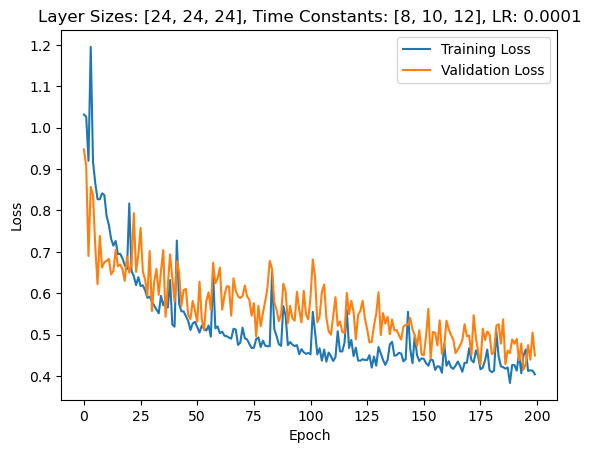

  0%|          | 1/200 [00:13<45:33, 13.73s/it]

Epoch 1/200, Training Loss: 0.9535790681838989, Validation Loss: 0.5810742803982326


  1%|          | 2/200 [00:27<45:38, 13.83s/it]

Epoch 2/200, Training Loss: 0.8345330335059256, Validation Loss: 0.6198268064430782


  2%|▏         | 3/200 [00:40<44:34, 13.58s/it]

Epoch 3/200, Training Loss: 0.7587127106369667, Validation Loss: 0.6566644481250218


  2%|▏         | 4/200 [00:53<43:32, 13.33s/it]

Epoch 4/200, Training Loss: 0.6727910351078465, Validation Loss: 0.6101508268288204


  2%|▎         | 5/200 [01:06<42:56, 13.21s/it]

Epoch 5/200, Training Loss: 0.6228837786980395, Validation Loss: 0.6763128957578114


  3%|▎         | 6/200 [01:20<43:10, 13.35s/it]

Epoch 6/200, Training Loss: 0.657868539949633, Validation Loss: 0.5840120358126504


  4%|▎         | 7/200 [01:34<43:43, 13.59s/it]

Epoch 7/200, Training Loss: 0.5597884098313889, Validation Loss: 0.6134186791522163


  4%|▍         | 8/200 [01:48<43:32, 13.61s/it]

Epoch 8/200, Training Loss: 0.6526915459138043, Validation Loss: 0.6299821649278913


  4%|▍         | 9/200 [02:01<43:22, 13.62s/it]

Epoch 9/200, Training Loss: 0.5911104859046217, Validation Loss: 0.5958171742303031


  5%|▌         | 10/200 [02:15<43:21, 13.69s/it]

Epoch 10/200, Training Loss: 0.5604189876115547, Validation Loss: 0.6618216548647199


  6%|▌         | 11/200 [02:28<42:31, 13.50s/it]

Epoch 11/200, Training Loss: 0.560738963900872, Validation Loss: 0.555446309702737


  6%|▌         | 12/200 [02:41<41:42, 13.31s/it]

Epoch 12/200, Training Loss: 0.5447034391592134, Validation Loss: 0.6044249790055412


  6%|▋         | 13/200 [02:55<42:02, 13.49s/it]

Epoch 13/200, Training Loss: 0.5269501476355318, Validation Loss: 0.5432618877717427


  7%|▋         | 14/200 [03:08<41:28, 13.38s/it]

Epoch 14/200, Training Loss: 0.5864056371292978, Validation Loss: 0.6344492052282605


  8%|▊         | 15/200 [03:22<41:31, 13.47s/it]

Epoch 15/200, Training Loss: 0.5366168252702029, Validation Loss: 0.50401029416493


  8%|▊         | 16/200 [03:36<41:34, 13.56s/it]

Epoch 16/200, Training Loss: 0.5003457361797117, Validation Loss: 0.5019994761262622


  8%|▊         | 17/200 [03:49<41:17, 13.54s/it]

Epoch 17/200, Training Loss: 0.5237012258115804, Validation Loss: 0.5121052733489445


  9%|▉         | 18/200 [04:02<40:51, 13.47s/it]

Epoch 18/200, Training Loss: 0.5520235108879378, Validation Loss: 0.5807682297059468


 10%|▉         | 19/200 [04:15<40:02, 13.27s/it]

Epoch 19/200, Training Loss: 0.4814387306852161, Validation Loss: 0.7042748885495322


 10%|█         | 20/200 [04:28<39:25, 13.14s/it]

Epoch 20/200, Training Loss: 0.50171966878873, Validation Loss: 0.5466329348938805


 10%|█         | 21/200 [04:42<39:43, 13.32s/it]

Epoch 21/200, Training Loss: 0.5242587656907316, Validation Loss: 0.7599316494805473


 11%|█         | 22/200 [04:55<39:44, 13.39s/it]

Epoch 22/200, Training Loss: 0.5275095701217651, Validation Loss: 0.4663712339741843


 12%|█▏        | 23/200 [05:08<39:05, 13.25s/it]

Epoch 23/200, Training Loss: 0.4849552439068848, Validation Loss: 0.5932444419179644


 12%|█▏        | 24/200 [05:21<38:49, 13.24s/it]

Epoch 24/200, Training Loss: 0.48404831537660564, Validation Loss: 0.6526903063058853


 12%|█▎        | 25/200 [05:35<39:06, 13.41s/it]

Epoch 25/200, Training Loss: 0.4761790790647831, Validation Loss: 0.5740878688437598


 13%|█▎        | 26/200 [05:49<38:44, 13.36s/it]

Epoch 26/200, Training Loss: 0.47960659917795434, Validation Loss: 0.6830807881695884


 14%|█▎        | 27/200 [06:02<38:15, 13.27s/it]

Epoch 27/200, Training Loss: 0.4943135425729572, Validation Loss: 0.46822514491421835


 14%|█▍        | 28/200 [06:14<37:39, 13.14s/it]

Epoch 28/200, Training Loss: 0.4601777049730409, Validation Loss: 0.6124776197331292


 14%|█▍        | 29/200 [06:28<37:24, 13.12s/it]

Epoch 29/200, Training Loss: 0.45958334488688773, Validation Loss: 0.519024738243648


 15%|█▌        | 30/200 [06:41<37:06, 13.10s/it]

Epoch 30/200, Training Loss: 0.4872999618638237, Validation Loss: 0.5460190176963806


 16%|█▌        | 31/200 [06:53<36:41, 13.02s/it]

Epoch 31/200, Training Loss: 0.4862938104373104, Validation Loss: 0.6344625247376305


 16%|█▌        | 32/200 [07:07<36:38, 13.09s/it]

Epoch 32/200, Training Loss: 0.4763244542310823, Validation Loss: 0.6395203215735299


 16%|█▋        | 33/200 [07:20<36:21, 13.06s/it]

Epoch 33/200, Training Loss: 0.48857159490855234, Validation Loss: 0.578282288142613


 17%|█▋        | 34/200 [07:33<36:30, 13.20s/it]

Epoch 34/200, Training Loss: 0.45688311446387814, Validation Loss: 0.5380534699984959


 18%|█▊        | 35/200 [07:47<36:36, 13.31s/it]

Epoch 35/200, Training Loss: 0.44309323407569023, Validation Loss: 0.6241067392485482


 18%|█▊        | 36/200 [08:00<36:08, 13.22s/it]

Epoch 36/200, Training Loss: 0.43597915318776975, Validation Loss: 0.5154325025422233


 18%|█▊        | 37/200 [08:13<35:42, 13.14s/it]

Epoch 37/200, Training Loss: 0.4505135866830934, Validation Loss: 0.5381856858730316


 19%|█▉        | 38/200 [08:27<36:12, 13.41s/it]

Epoch 38/200, Training Loss: 0.45985660434893844, Validation Loss: 0.5327920956271035


 20%|█▉        | 39/200 [08:40<35:46, 13.33s/it]

Epoch 39/200, Training Loss: 0.49486184457563004, Validation Loss: 0.6931007419313703


 20%|██        | 40/200 [08:53<35:25, 13.28s/it]

Epoch 40/200, Training Loss: 0.4590156961162135, Validation Loss: 0.5485890890870776


 20%|██        | 41/200 [09:06<35:03, 13.23s/it]

Epoch 41/200, Training Loss: 0.4496083571663443, Validation Loss: 0.7427983965192523


 21%|██        | 42/200 [09:19<34:30, 13.10s/it]

Epoch 42/200, Training Loss: 0.46459603056592763, Validation Loss: 0.5986423449856895


 22%|██▏       | 43/200 [09:32<34:20, 13.12s/it]

Epoch 43/200, Training Loss: 0.4260332710900397, Validation Loss: 0.5786538805280413


 22%|██▏       | 44/200 [09:45<33:54, 13.04s/it]

Epoch 44/200, Training Loss: 0.4621676763273635, Validation Loss: 0.6524810237543923


 22%|██▎       | 45/200 [09:58<33:37, 13.01s/it]

Epoch 45/200, Training Loss: 0.4923056350001749, Validation Loss: 0.47272215144974844


 23%|██▎       | 46/200 [10:11<33:28, 13.05s/it]

Epoch 46/200, Training Loss: 0.4639763829280745, Validation Loss: 0.48773000708648134


 24%|██▎       | 47/200 [10:25<33:42, 13.22s/it]

Epoch 47/200, Training Loss: 0.4237579469973186, Validation Loss: 0.5936547219753265


 24%|██▍       | 48/200 [10:38<33:34, 13.26s/it]

Epoch 48/200, Training Loss: 0.4198541152027418, Validation Loss: 0.45953888978276936


 24%|██▍       | 49/200 [10:51<33:19, 13.24s/it]

Epoch 49/200, Training Loss: 0.43764749450503654, Validation Loss: 0.6571824699640274


 25%|██▌       | 50/200 [11:04<32:49, 13.13s/it]

Epoch 50/200, Training Loss: 0.4573228193341561, Validation Loss: 0.5587069392204285


 26%|██▌       | 51/200 [11:18<33:08, 13.34s/it]

Epoch 51/200, Training Loss: 0.42810215477673513, Validation Loss: 0.5863962556634631


 26%|██▌       | 52/200 [11:31<32:57, 13.36s/it]

Epoch 52/200, Training Loss: 0.4098172221543654, Validation Loss: 0.7365974145276206


 26%|██▋       | 53/200 [11:44<32:29, 13.26s/it]

Epoch 53/200, Training Loss: 0.43706259384470164, Validation Loss: 0.6069203913211823


 27%|██▋       | 54/200 [11:57<32:09, 13.21s/it]

Epoch 54/200, Training Loss: 0.39991754799518947, Validation Loss: 0.5587111072880881


 28%|██▊       | 55/200 [12:11<31:49, 13.17s/it]

Epoch 55/200, Training Loss: 0.4510720855784866, Validation Loss: 0.5606788630996432


 28%|██▊       | 56/200 [12:24<31:28, 13.11s/it]

Epoch 56/200, Training Loss: 0.48886442521833023, Validation Loss: 0.573722107069833


 28%|██▊       | 57/200 [12:37<31:16, 13.13s/it]

Epoch 57/200, Training Loss: 0.43455060135643436, Validation Loss: 0.5049845235688346


 29%|██▉       | 58/200 [12:50<30:54, 13.06s/it]

Epoch 58/200, Training Loss: 0.4398362079881272, Validation Loss: 0.6140004502875465


 30%|██▉       | 59/200 [13:03<30:43, 13.07s/it]

Epoch 59/200, Training Loss: 0.41840648679238446, Validation Loss: 0.6652958989143372


 30%|███       | 60/200 [13:17<31:13, 13.38s/it]

Epoch 60/200, Training Loss: 0.4288720266436631, Validation Loss: 0.574885892016547


 30%|███       | 61/200 [13:30<30:45, 13.27s/it]

Epoch 61/200, Training Loss: 0.4428178691920244, Validation Loss: 0.648542229618345


 31%|███       | 62/200 [13:43<30:20, 13.19s/it]

Epoch 62/200, Training Loss: 0.3918245533164942, Validation Loss: 0.6853070855140686


 32%|███▏      | 63/200 [13:56<30:06, 13.19s/it]

Epoch 63/200, Training Loss: 0.41544928696920286, Validation Loss: 0.6438317618199757


 32%|███▏      | 64/200 [14:10<30:21, 13.39s/it]

Epoch 64/200, Training Loss: 0.44125934704294745, Validation Loss: 0.5637973972729274


 32%|███▎      | 65/200 [14:23<29:59, 13.33s/it]

Epoch 65/200, Training Loss: 0.4203276364308483, Validation Loss: 0.5731271931103298


 33%|███▎      | 66/200 [14:36<29:37, 13.26s/it]

Epoch 66/200, Training Loss: 0.43166407099309956, Validation Loss: 0.5607315387044635


 34%|███▎      | 67/200 [14:49<29:10, 13.16s/it]

Epoch 67/200, Training Loss: 0.41159247002511656, Validation Loss: 0.631514813218798


 34%|███▍      | 68/200 [15:02<29:03, 13.21s/it]

Epoch 68/200, Training Loss: 0.41034589145543443, Validation Loss: 0.6015343070030212


 34%|███▍      | 69/200 [15:15<28:43, 13.16s/it]

Epoch 69/200, Training Loss: 0.4344821864703916, Validation Loss: 0.6524061007159097


 35%|███▌      | 70/200 [15:28<28:14, 13.03s/it]

Epoch 70/200, Training Loss: 0.40715637156423534, Validation Loss: 0.5338611773082188


 36%|███▌      | 71/200 [15:42<28:16, 13.15s/it]

Epoch 71/200, Training Loss: 0.4033520003815867, Validation Loss: 0.5119321601731437


 36%|███▌      | 72/200 [15:54<27:48, 13.04s/it]

Epoch 72/200, Training Loss: 0.41798569065219954, Validation Loss: 0.543387872832162


 36%|███▋      | 73/200 [16:08<28:08, 13.30s/it]

Epoch 73/200, Training Loss: 0.3990223312153007, Validation Loss: 0.5463267181600843


 37%|███▋      | 74/200 [16:22<28:08, 13.40s/it]

Epoch 74/200, Training Loss: 0.37999835835312895, Validation Loss: 0.5602604023047856


 38%|███▊      | 75/200 [16:35<27:37, 13.26s/it]

Epoch 75/200, Training Loss: 0.386160542942443, Validation Loss: 0.5367331206798553


 38%|███▊      | 76/200 [16:48<27:19, 13.22s/it]

Epoch 76/200, Training Loss: 0.41313476087349765, Validation Loss: 0.507027730345726


 38%|███▊      | 77/200 [17:02<27:37, 13.48s/it]

Epoch 77/200, Training Loss: 0.39423683313828595, Validation Loss: 0.608518545116697


 39%|███▉      | 78/200 [17:15<27:10, 13.37s/it]

Epoch 78/200, Training Loss: 0.3919771909713745, Validation Loss: 0.6261868051120213


 40%|███▉      | 79/200 [17:28<26:44, 13.26s/it]

Epoch 79/200, Training Loss: 0.39119670526036676, Validation Loss: 0.7821633049419948


 40%|████      | 80/200 [17:41<26:26, 13.22s/it]

Epoch 80/200, Training Loss: 0.3773819036641211, Validation Loss: 0.5654529290539878


 40%|████      | 81/200 [17:54<26:06, 13.16s/it]

Epoch 81/200, Training Loss: 0.40548638127884773, Validation Loss: 0.6978520580700466


 41%|████      | 82/200 [18:08<25:59, 13.22s/it]

Epoch 82/200, Training Loss: 0.4071905936272639, Validation Loss: 0.5411158331802913


 42%|████▏     | 83/200 [18:21<25:40, 13.17s/it]

Epoch 83/200, Training Loss: 0.4415657379717197, Validation Loss: 0.6242790222167969


 42%|████▏     | 84/200 [18:34<25:20, 13.11s/it]

Epoch 84/200, Training Loss: 0.38798837616758525, Validation Loss: 0.5716762244701385


 42%|████▎     | 85/200 [18:47<25:13, 13.16s/it]

Epoch 85/200, Training Loss: 0.38265985053665236, Validation Loss: 0.6264916786125728


 43%|████▎     | 86/200 [19:01<25:23, 13.37s/it]

Epoch 86/200, Training Loss: 0.3550852305905999, Validation Loss: 0.6875653309481484


 44%|████▎     | 87/200 [19:14<25:03, 13.31s/it]

Epoch 87/200, Training Loss: 0.4194409245589994, Validation Loss: 0.634116645370211


 44%|████▍     | 88/200 [19:27<24:48, 13.29s/it]

Epoch 88/200, Training Loss: 0.38192484373191615, Validation Loss: 0.6488186291285923


 44%|████▍     | 89/200 [19:40<24:28, 13.23s/it]

Epoch 89/200, Training Loss: 0.3781642493493152, Validation Loss: 0.6406632959842682


 45%|████▌     | 90/200 [19:54<24:38, 13.44s/it]

Epoch 90/200, Training Loss: 0.3667966996161443, Validation Loss: 0.5445794995341983


 46%|████▌     | 91/200 [20:08<24:26, 13.46s/it]

Epoch 91/200, Training Loss: 0.35733769468541415, Validation Loss: 0.64828707916396


 46%|████▌     | 92/200 [20:21<23:55, 13.30s/it]

Epoch 92/200, Training Loss: 0.3834834745470083, Validation Loss: 0.7478459009102413


 46%|████▋     | 93/200 [20:34<23:37, 13.25s/it]

Epoch 93/200, Training Loss: 0.4199992654458532, Validation Loss: 0.6955919223172324


 47%|████▋     | 94/200 [20:47<23:25, 13.26s/it]

Epoch 94/200, Training Loss: 0.38007812567476956, Validation Loss: 0.5068429921354566


 48%|████▊     | 95/200 [21:00<23:05, 13.20s/it]

Epoch 95/200, Training Loss: 0.3807486225411577, Validation Loss: 0.568048323903765


 48%|████▊     | 96/200 [21:13<22:55, 13.23s/it]

Epoch 96/200, Training Loss: 0.39157735626652557, Validation Loss: 0.5808124073914119


 48%|████▊     | 97/200 [21:26<22:34, 13.15s/it]

Epoch 97/200, Training Loss: 0.39159756842649207, Validation Loss: 0.571118346282414


 49%|████▉     | 98/200 [21:40<22:21, 13.15s/it]

Epoch 98/200, Training Loss: 0.3776538262389741, Validation Loss: 0.5430553044591632


 50%|████▉     | 99/200 [21:54<22:38, 13.45s/it]

Epoch 99/200, Training Loss: 0.39129871860989984, Validation Loss: 0.6055165656975338


 50%|█████     | 100/200 [22:07<22:20, 13.41s/it]

Epoch 100/200, Training Loss: 0.3706637069864093, Validation Loss: 0.5718762832028526


 50%|█████     | 101/200 [22:20<22:01, 13.35s/it]

Epoch 101/200, Training Loss: 0.3759036179421083, Validation Loss: 0.6266081460884639


 51%|█████     | 102/200 [22:34<21:50, 13.37s/it]

Epoch 102/200, Training Loss: 0.40667477784291756, Validation Loss: 0.5217653512954712


 52%|█████▏    | 103/200 [22:47<21:45, 13.46s/it]

Epoch 103/200, Training Loss: 0.3632393226308643, Validation Loss: 0.6047212609222957


 52%|█████▏    | 104/200 [23:01<21:25, 13.39s/it]

Epoch 104/200, Training Loss: 0.3544900628193369, Validation Loss: 0.5427814083439964


 52%|█████▎    | 105/200 [23:14<21:04, 13.31s/it]

Epoch 105/200, Training Loss: 0.36962262976844357, Validation Loss: 0.5444717109203339


 53%|█████▎    | 106/200 [23:27<20:40, 13.20s/it]

Epoch 106/200, Training Loss: 0.34779798056719435, Validation Loss: 0.6264230608940125


 54%|█████▎    | 107/200 [23:40<20:30, 13.23s/it]

Epoch 107/200, Training Loss: 0.334427720533227, Validation Loss: 0.5874045363494328


 54%|█████▍    | 108/200 [23:53<20:10, 13.15s/it]

Epoch 108/200, Training Loss: 0.4032508056118803, Validation Loss: 0.5482130433831897


 55%|█████▍    | 109/200 [24:06<19:52, 13.10s/it]

Epoch 109/200, Training Loss: 0.3557980808446992, Validation Loss: 0.5544421587671552


 55%|█████▌    | 110/200 [24:19<19:43, 13.15s/it]

Epoch 110/200, Training Loss: 0.36427176673457307, Validation Loss: 0.5432769571031842


 56%|█████▌    | 111/200 [24:32<19:29, 13.13s/it]

Epoch 111/200, Training Loss: 0.3671354572727995, Validation Loss: 0.5273414977959224


 56%|█████▌    | 112/200 [24:46<19:34, 13.35s/it]

Epoch 112/200, Training Loss: 0.3716016296508177, Validation Loss: 0.540840608733041


 56%|█████▋    | 113/200 [25:00<19:27, 13.42s/it]

Epoch 113/200, Training Loss: 0.3577128443515526, Validation Loss: 0.706325352191925


 57%|█████▋    | 114/200 [25:13<19:06, 13.33s/it]

Epoch 114/200, Training Loss: 0.37283497823859163, Validation Loss: 0.5203150979110173


 57%|█████▊    | 115/200 [25:26<18:43, 13.22s/it]

Epoch 115/200, Training Loss: 0.3695317144101521, Validation Loss: 0.5498778990336827


 58%|█████▊    | 116/200 [25:40<18:52, 13.48s/it]

Epoch 116/200, Training Loss: 0.3478938605425493, Validation Loss: 0.5241633440767016


 58%|█████▊    | 117/200 [25:53<18:29, 13.37s/it]

Epoch 117/200, Training Loss: 0.3568654119406106, Validation Loss: 0.7018734301839556


 59%|█████▉    | 118/200 [26:06<18:06, 13.25s/it]

Epoch 118/200, Training Loss: 0.3675133793983819, Validation Loss: 0.6681864304201943


 60%|█████▉    | 119/200 [26:19<17:56, 13.29s/it]

Epoch 119/200, Training Loss: 0.3327309236211597, Validation Loss: 0.5064056175095695


 60%|██████    | 120/200 [26:32<17:34, 13.18s/it]

Epoch 120/200, Training Loss: 0.3481186580545497, Validation Loss: 0.5901259396757398


 60%|██████    | 121/200 [26:45<17:19, 13.15s/it]

Epoch 121/200, Training Loss: 0.3785673568271241, Validation Loss: 0.5689403755324227


 61%|██████    | 122/200 [26:58<17:05, 13.15s/it]

Epoch 122/200, Training Loss: 0.3265041223955604, Validation Loss: 0.5567615841116224


 62%|██████▏   | 123/200 [27:12<16:50, 13.12s/it]

Epoch 123/200, Training Loss: 0.34766667153475417, Validation Loss: 0.6427440345287323


 62%|██████▏   | 124/200 [27:25<16:38, 13.14s/it]

Epoch 124/200, Training Loss: 0.3472385493651876, Validation Loss: 0.680762597492763


 62%|██████▎   | 125/200 [27:38<16:40, 13.34s/it]

Epoch 125/200, Training Loss: 0.34081729881043704, Validation Loss: 0.6396295257977077


 63%|██████▎   | 126/200 [27:52<16:24, 13.30s/it]

Epoch 126/200, Training Loss: 0.33172708468617135, Validation Loss: 0.5381543338298798


 64%|██████▎   | 127/200 [28:05<16:13, 13.33s/it]

Epoch 127/200, Training Loss: 0.31242205455618083, Validation Loss: 0.5854996613093785


 64%|██████▍   | 128/200 [28:19<16:07, 13.44s/it]

Epoch 128/200, Training Loss: 0.32951080461718, Validation Loss: 0.6645647202219281


 64%|██████▍   | 129/200 [28:32<15:48, 13.36s/it]

Epoch 129/200, Training Loss: 0.3107915723098899, Validation Loss: 0.5695873754365104


 65%|██████▌   | 130/200 [28:45<15:37, 13.39s/it]

Epoch 130/200, Training Loss: 0.3235550376604188, Validation Loss: 0.646416676895959


 66%|██████▌   | 131/200 [28:58<15:16, 13.28s/it]

Epoch 131/200, Training Loss: 0.3474963650388538, Validation Loss: 0.6121911065919059


 66%|██████▌   | 132/200 [29:12<15:01, 13.26s/it]

Epoch 132/200, Training Loss: 0.3348361004917127, Validation Loss: 0.6510242308889117


 66%|██████▋   | 133/200 [29:25<14:44, 13.21s/it]

Epoch 133/200, Training Loss: 0.3425916242149641, Validation Loss: 0.5617711288588387


 67%|██████▋   | 134/200 [29:38<14:25, 13.12s/it]

Epoch 134/200, Training Loss: 0.33042231722260423, Validation Loss: 0.6233386269637516


 68%|██████▊   | 135/200 [29:51<14:14, 13.14s/it]

Epoch 135/200, Training Loss: 0.30762013090106677, Validation Loss: 0.5139785196099963


 68%|██████▊   | 136/200 [30:04<14:03, 13.18s/it]

Epoch 136/200, Training Loss: 0.3256766970427531, Validation Loss: 0.6449831128120422


 68%|██████▊   | 137/200 [30:18<14:01, 13.36s/it]

Epoch 137/200, Training Loss: 0.33330820985841303, Validation Loss: 0.5708616503647396


 69%|██████▉   | 138/200 [30:31<13:50, 13.40s/it]

Epoch 138/200, Training Loss: 0.3001971596254493, Validation Loss: 0.6014124410493034


 70%|██████▉   | 139/200 [30:44<13:29, 13.28s/it]

Epoch 139/200, Training Loss: 0.3096747502403439, Validation Loss: 0.5560429394245148


 70%|███████   | 140/200 [30:57<13:10, 13.17s/it]

Epoch 140/200, Training Loss: 0.3194989667467351, Validation Loss: 0.6201916720185962


 70%|███████   | 141/200 [31:12<13:17, 13.51s/it]

Epoch 141/200, Training Loss: 0.3352644963646835, Validation Loss: 0.6437104429517474


 71%|███████   | 142/200 [31:25<12:56, 13.38s/it]

Epoch 142/200, Training Loss: 0.2952472848712273, Validation Loss: 0.6731217460972923


 72%|███████▏  | 143/200 [31:38<12:34, 13.23s/it]

Epoch 143/200, Training Loss: 0.3236800835661168, Validation Loss: 0.5736000835895538


 72%|███████▏  | 144/200 [31:51<12:24, 13.30s/it]

Epoch 144/200, Training Loss: 0.3567932267796318, Validation Loss: 0.6092150126184736


 72%|███████▎  | 145/200 [32:04<12:05, 13.19s/it]

Epoch 145/200, Training Loss: 0.32981887375408747, Validation Loss: 0.5848246727670942


 73%|███████▎  | 146/200 [32:17<11:48, 13.13s/it]

Epoch 146/200, Training Loss: 0.33477322897821105, Validation Loss: 0.5770689930234637


 74%|███████▎  | 147/200 [32:30<11:36, 13.14s/it]

Epoch 147/200, Training Loss: 0.3176162366597158, Validation Loss: 0.6090811916760036


 74%|███████▍  | 148/200 [32:43<11:20, 13.09s/it]

Epoch 148/200, Training Loss: 0.3098967755740544, Validation Loss: 0.5793603020054954


 74%|███████▍  | 149/200 [32:57<11:13, 13.21s/it]

Epoch 149/200, Training Loss: 0.31875932680548363, Validation Loss: 0.6405397951602936


 75%|███████▌  | 150/200 [33:11<11:18, 13.57s/it]

Epoch 150/200, Training Loss: 0.34490067469623853, Validation Loss: 0.7338624213423047


 76%|███████▌  | 151/200 [33:24<11:00, 13.48s/it]

Epoch 151/200, Training Loss: 0.34069328319351627, Validation Loss: 0.724824139050075


 76%|███████▌  | 152/200 [33:38<10:44, 13.43s/it]

Epoch 152/200, Training Loss: 0.31667768505384336, Validation Loss: 0.6566608420440129


 76%|███████▋  | 153/200 [33:51<10:24, 13.28s/it]

Epoch 153/200, Training Loss: 0.2967599073670945, Validation Loss: 0.6618274705750602


 77%|███████▋  | 154/200 [34:05<10:21, 13.52s/it]

Epoch 154/200, Training Loss: 0.3366675845013474, Validation Loss: 0.6032883354595729


 78%|███████▊  | 155/200 [34:18<10:08, 13.51s/it]

Epoch 155/200, Training Loss: 0.3260227643515704, Validation Loss: 0.5850809471947807


 78%|███████▊  | 156/200 [34:31<09:47, 13.36s/it]

Epoch 156/200, Training Loss: 0.3202830842643414, Validation Loss: 0.7017460720879691


 78%|███████▊  | 157/200 [34:44<09:32, 13.32s/it]

Epoch 157/200, Training Loss: 0.3051302250263826, Validation Loss: 0.6138466766902378


 79%|███████▉  | 158/200 [34:58<09:18, 13.29s/it]

Epoch 158/200, Training Loss: 0.29709826550393736, Validation Loss: 0.6485036654131753


 80%|███████▉  | 159/200 [35:11<09:01, 13.21s/it]

Epoch 159/200, Training Loss: 0.3105711045692552, Validation Loss: 0.5685227598462786


 80%|████████  | 160/200 [35:24<08:46, 13.16s/it]

Epoch 160/200, Training Loss: 0.3066162239268141, Validation Loss: 0.5745198045458112


 80%|████████  | 161/200 [35:37<08:33, 13.18s/it]

Epoch 161/200, Training Loss: 0.29222382267691055, Validation Loss: 0.6323014838354928


 81%|████████  | 162/200 [35:50<08:18, 13.11s/it]

Epoch 162/200, Training Loss: 0.29990973871833876, Validation Loss: 0.5919420676571983


 82%|████████▏ | 163/200 [36:04<08:17, 13.46s/it]

Epoch 163/200, Training Loss: 0.2898267445699224, Validation Loss: 0.6187964252063206


 82%|████████▏ | 164/200 [36:17<08:03, 13.43s/it]

Epoch 164/200, Training Loss: 0.2961366408557262, Validation Loss: 0.603981077671051


 82%|████████▎ | 165/200 [36:30<07:43, 13.24s/it]

Epoch 165/200, Training Loss: 0.29540449352759235, Validation Loss: 0.6463191679545811


 83%|████████▎ | 166/200 [36:44<07:31, 13.27s/it]

Epoch 166/200, Training Loss: 0.3028973304438141, Validation Loss: 0.6388387892927442


 84%|████████▎ | 167/200 [36:57<07:22, 13.41s/it]

Epoch 167/200, Training Loss: 0.3086446267816256, Validation Loss: 0.7059746512344905


 84%|████████▍ | 168/200 [37:11<07:08, 13.40s/it]

Epoch 168/200, Training Loss: 0.29848565456439863, Validation Loss: 0.5450731324298042


 84%|████████▍ | 169/200 [37:24<06:54, 13.37s/it]

Epoch 169/200, Training Loss: 0.31024356087986027, Validation Loss: 0.7520868650504521


 85%|████████▌ | 170/200 [37:37<06:37, 13.27s/it]

Epoch 170/200, Training Loss: 0.30415422300685124, Validation Loss: 0.6684507387025016


 86%|████████▌ | 171/200 [37:50<06:24, 13.25s/it]

Epoch 171/200, Training Loss: 0.28721138300760735, Validation Loss: 0.594338446855545


 86%|████████▌ | 172/200 [38:04<06:11, 13.28s/it]

Epoch 172/200, Training Loss: 0.29987983138493773, Validation Loss: 0.7682658178465707


 86%|████████▋ | 173/200 [38:16<05:55, 13.17s/it]

Epoch 173/200, Training Loss: 0.28416464597267926, Validation Loss: 0.567648960011346


 87%|████████▋ | 174/200 [38:29<05:40, 13.11s/it]

Epoch 174/200, Training Loss: 0.30872621331012473, Validation Loss: 0.6230701676436833


 88%|████████▊ | 175/200 [38:43<05:28, 13.15s/it]

Epoch 175/200, Training Loss: 0.28665545807694487, Validation Loss: 0.6653645230191094


 88%|████████▊ | 176/200 [38:56<05:19, 13.31s/it]

Epoch 176/200, Training Loss: 0.2945621390387697, Validation Loss: 0.6357528822762626


 88%|████████▊ | 177/200 [39:10<05:09, 13.44s/it]

Epoch 177/200, Training Loss: 0.3181135724737959, Validation Loss: 0.5886277556419373


 89%|████████▉ | 178/200 [39:23<04:53, 13.36s/it]

Epoch 178/200, Training Loss: 0.3088662437391731, Validation Loss: 0.6272635055439812


 90%|████████▉ | 179/200 [39:36<04:37, 13.22s/it]

Epoch 179/200, Training Loss: 0.2795655859528847, Validation Loss: 0.6525992325374058


 90%|█████████ | 180/200 [39:50<04:29, 13.50s/it]

Epoch 180/200, Training Loss: 0.293407604379474, Validation Loss: 0.645248430115836


 90%|█████████ | 181/200 [40:04<04:14, 13.41s/it]

Epoch 181/200, Training Loss: 0.27845067263774154, Validation Loss: 0.5766584915774209


 91%|█████████ | 182/200 [40:17<03:59, 13.33s/it]

Epoch 182/200, Training Loss: 0.28838618099689484, Validation Loss: 0.6890375230993543


 92%|█████████▏| 183/200 [40:30<03:46, 13.33s/it]

Epoch 183/200, Training Loss: 0.27971134447264223, Validation Loss: 0.6144002590860639


 92%|█████████▏| 184/200 [40:43<03:31, 13.22s/it]

Epoch 184/200, Training Loss: 0.2867321768459284, Validation Loss: 0.6832602960722787


 92%|█████████▎| 185/200 [40:56<03:17, 13.19s/it]

Epoch 185/200, Training Loss: 0.28026661979702283, Validation Loss: 0.5414055032389504


 93%|█████████▎| 186/200 [41:09<03:04, 13.21s/it]

Epoch 186/200, Training Loss: 0.25987759302809554, Validation Loss: 0.6321734828608376


 94%|█████████▎| 187/200 [41:22<02:50, 13.14s/it]

Epoch 187/200, Training Loss: 0.271910013174111, Validation Loss: 0.6216806130749839


 94%|█████████▍| 188/200 [41:35<02:37, 13.08s/it]

Epoch 188/200, Training Loss: 0.2762482079132548, Validation Loss: 0.6204683567796435


 94%|█████████▍| 189/200 [41:49<02:26, 13.36s/it]

Epoch 189/200, Training Loss: 0.2661902242392864, Validation Loss: 0.6302044604505811


 95%|█████████▌| 190/200 [42:03<02:13, 13.34s/it]

Epoch 190/200, Training Loss: 0.28722365003711775, Validation Loss: 0.5967872781412942


 96%|█████████▌| 191/200 [42:16<01:59, 13.32s/it]

Epoch 191/200, Training Loss: 0.2659451447005542, Validation Loss: 0.6494430005550385


 96%|█████████▌| 192/200 [42:29<01:46, 13.28s/it]

Epoch 192/200, Training Loss: 0.2567588483106415, Validation Loss: 0.6055945158004761


 96%|█████████▋| 193/200 [42:43<01:34, 13.44s/it]

Epoch 193/200, Training Loss: 0.26628822186645473, Validation Loss: 0.6367009580135345


 97%|█████████▋| 194/200 [42:56<01:20, 13.44s/it]

Epoch 194/200, Training Loss: 0.2867275198113243, Validation Loss: 0.7842537803309304


 98%|█████████▊| 195/200 [43:09<01:06, 13.31s/it]

Epoch 195/200, Training Loss: 0.27689881454098897, Validation Loss: 0.5985698274203709


 98%|█████████▊| 196/200 [43:22<00:53, 13.26s/it]

Epoch 196/200, Training Loss: 0.2570244613683449, Validation Loss: 0.5726565548351833


 98%|█████████▊| 197/200 [43:36<00:39, 13.25s/it]

Epoch 197/200, Training Loss: 0.2613739838015358, Validation Loss: 0.7372300156525203


 99%|█████████▉| 198/200 [43:49<00:26, 13.15s/it]

Epoch 198/200, Training Loss: 0.2806032755464878, Validation Loss: 0.6354218593665532


100%|█████████▉| 199/200 [44:02<00:13, 13.17s/it]

Epoch 199/200, Training Loss: 0.27129445857596846, Validation Loss: 0.6576489678450993


100%|██████████| 200/200 [44:15<00:00, 13.28s/it]


Epoch 200/200, Training Loss: 0.2857072177641797, Validation Loss: 0.636327828679766
Final Accuracy: 93.00%, Precision: 0.93, Recall: 0.93


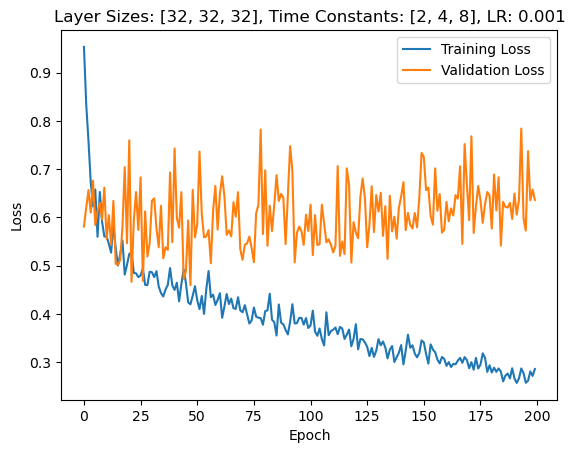

  0%|          | 1/200 [00:13<45:18, 13.66s/it]

Epoch 1/200, Training Loss: 1.0114392132129308, Validation Loss: 0.6897348506110055


  1%|          | 2/200 [00:27<45:49, 13.89s/it]

Epoch 2/200, Training Loss: 0.9072242446665494, Validation Loss: 0.8710506515843528


  2%|▏         | 3/200 [00:40<44:33, 13.57s/it]

Epoch 3/200, Training Loss: 0.9585463854501832, Validation Loss: 0.8690799730164664


  2%|▏         | 4/200 [00:53<43:31, 13.33s/it]

Epoch 4/200, Training Loss: 0.868398552795626, Validation Loss: 0.7735189071723393


  2%|▎         | 5/200 [01:07<43:10, 13.28s/it]

Epoch 5/200, Training Loss: 0.8798714122682247, Validation Loss: 0.7263410091400146


  3%|▎         | 6/200 [01:20<43:17, 13.39s/it]

Epoch 6/200, Training Loss: 0.8290593061807021, Validation Loss: 0.6967610610382897


  4%|▎         | 7/200 [01:34<43:23, 13.49s/it]

Epoch 7/200, Training Loss: 0.8342291409114622, Validation Loss: 0.712477445602417


  4%|▍         | 8/200 [01:48<43:39, 13.64s/it]

Epoch 8/200, Training Loss: 0.7805119364891412, Validation Loss: 0.6518173686095646


  4%|▍         | 9/200 [02:01<43:22, 13.62s/it]

Epoch 9/200, Training Loss: 0.7723449794751294, Validation Loss: 0.7109187287943703


  5%|▌         | 10/200 [02:15<43:09, 13.63s/it]

Epoch 10/200, Training Loss: 0.7500042769144166, Validation Loss: 0.6770857700279781


  6%|▌         | 11/200 [02:28<42:26, 13.47s/it]

Epoch 11/200, Training Loss: 0.7506287828931268, Validation Loss: 0.6776835152081081


  6%|▌         | 12/200 [02:42<42:28, 13.55s/it]

Epoch 12/200, Training Loss: 0.7205862071154252, Validation Loss: 0.7039925328322819


  6%|▋         | 13/200 [02:55<41:57, 13.46s/it]

Epoch 13/200, Training Loss: 0.7399461331232539, Validation Loss: 0.6959440410137177


  7%|▋         | 14/200 [03:08<41:24, 13.36s/it]

Epoch 14/200, Training Loss: 0.7471650119097728, Validation Loss: 0.6965814232826233


  8%|▊         | 15/200 [03:21<40:41, 13.20s/it]

Epoch 15/200, Training Loss: 0.6994377104741223, Validation Loss: 0.6550841076033456


  8%|▊         | 16/200 [03:35<41:10, 13.43s/it]

Epoch 16/200, Training Loss: 0.698781281147363, Validation Loss: 0.7121743389538356


  8%|▊         | 17/200 [03:48<40:38, 13.33s/it]

Epoch 17/200, Training Loss: 0.6925308653768504, Validation Loss: 0.7205187635762351


  9%|▉         | 18/200 [04:01<40:00, 13.19s/it]

Epoch 18/200, Training Loss: 0.6692945074360326, Validation Loss: 0.6628105044364929


 10%|▉         | 19/200 [04:14<39:52, 13.22s/it]

Epoch 19/200, Training Loss: 0.6724321403593387, Validation Loss: 0.6516262654747281


 10%|█         | 20/200 [04:27<39:22, 13.13s/it]

Epoch 20/200, Training Loss: 0.6801702588234307, Validation Loss: 0.655383152621133


 10%|█         | 21/200 [04:41<39:43, 13.32s/it]

Epoch 21/200, Training Loss: 0.6697670569959676, Validation Loss: 0.6923473307064602


 11%|█         | 22/200 [04:54<39:36, 13.35s/it]

Epoch 22/200, Training Loss: 0.6775947342503745, Validation Loss: 0.6933421577726092


 12%|█▏        | 23/200 [05:07<38:58, 13.21s/it]

Epoch 23/200, Training Loss: 0.6534691098726021, Validation Loss: 0.6574711075850895


 12%|█▏        | 24/200 [05:20<38:34, 13.15s/it]

Epoch 24/200, Training Loss: 0.6592557762029037, Validation Loss: 0.6585529489176614


 12%|█▎        | 25/200 [05:34<39:15, 13.46s/it]

Epoch 25/200, Training Loss: 0.6478504240512848, Validation Loss: 0.6956414580345154


 13%|█▎        | 26/200 [05:48<38:42, 13.35s/it]

Epoch 26/200, Training Loss: 0.6549844106413284, Validation Loss: 0.6800565591880253


 14%|█▎        | 27/200 [06:01<38:24, 13.32s/it]

Epoch 27/200, Training Loss: 0.6701423284017815, Validation Loss: 0.7076741329261235


 14%|█▍        | 28/200 [06:14<37:57, 13.24s/it]

Epoch 28/200, Training Loss: 0.6553798115478372, Validation Loss: 0.6504325228078025


 14%|█▍        | 29/200 [06:27<37:33, 13.18s/it]

Epoch 29/200, Training Loss: 0.6495516665701596, Validation Loss: 0.6774895361491612


 15%|█▌        | 30/200 [06:40<37:38, 13.29s/it]

Epoch 30/200, Training Loss: 0.680200715109987, Validation Loss: 0.6538411102124623


 16%|█▌        | 31/200 [06:53<37:07, 13.18s/it]

Epoch 31/200, Training Loss: 0.6453111154853173, Validation Loss: 0.6059372254780361


 16%|█▌        | 32/200 [07:06<36:43, 13.12s/it]

Epoch 32/200, Training Loss: 0.6779031224970548, Validation Loss: 0.7234179505280086


 16%|█▋        | 33/200 [07:20<36:42, 13.19s/it]

Epoch 33/200, Training Loss: 0.6650684869514322, Validation Loss: 0.6628064215183258


 17%|█▋        | 34/200 [07:33<36:50, 13.32s/it]

Epoch 34/200, Training Loss: 0.6521669682466759, Validation Loss: 0.6644092670508793


 18%|█▊        | 35/200 [07:47<36:32, 13.29s/it]

Epoch 35/200, Training Loss: 0.6359134856260048, Validation Loss: 0.6456418527024133


 18%|█▊        | 36/200 [08:00<36:22, 13.31s/it]

Epoch 36/200, Training Loss: 0.6277685997621069, Validation Loss: 0.6757705552237374


 18%|█▊        | 37/200 [08:13<35:53, 13.21s/it]

Epoch 37/200, Training Loss: 0.6195794827533219, Validation Loss: 0.6528305347476687


 19%|█▉        | 38/200 [08:27<36:05, 13.37s/it]

Epoch 38/200, Training Loss: 0.6140151299395651, Validation Loss: 0.6744691495384488


 20%|█▉        | 39/200 [08:40<35:54, 13.38s/it]

Epoch 39/200, Training Loss: 0.619002417573389, Validation Loss: 0.6342889325959342


 20%|██        | 40/200 [08:53<35:17, 13.23s/it]

Epoch 40/200, Training Loss: 0.6139709145393012, Validation Loss: 0.644913409437452


 20%|██        | 41/200 [09:06<34:54, 13.18s/it]

Epoch 41/200, Training Loss: 0.6177842414604043, Validation Loss: 0.6307689802987235


 21%|██        | 42/200 [09:19<34:39, 13.16s/it]

Epoch 42/200, Training Loss: 0.610316405318818, Validation Loss: 0.6329947390726635


 22%|██▏       | 43/200 [09:32<34:14, 13.08s/it]

Epoch 43/200, Training Loss: 0.6169667665688496, Validation Loss: 0.7096126249858311


 22%|██▏       | 44/200 [09:45<33:59, 13.07s/it]

Epoch 44/200, Training Loss: 0.6168895256969164, Validation Loss: 0.6776995786598751


 22%|██▎       | 45/200 [09:58<33:51, 13.10s/it]

Epoch 45/200, Training Loss: 0.6189907288776254, Validation Loss: 0.6693170538970402


 23%|██▎       | 46/200 [10:11<33:32, 13.07s/it]

Epoch 46/200, Training Loss: 0.6131248344790261, Validation Loss: 0.6190544750009265


 24%|██▎       | 47/200 [10:25<34:03, 13.35s/it]

Epoch 47/200, Training Loss: 0.620436059978773, Validation Loss: 0.6256516767399651


 24%|██▍       | 48/200 [10:39<33:56, 13.40s/it]

Epoch 48/200, Training Loss: 0.6216537913061538, Validation Loss: 0.63620668223926


 24%|██▍       | 49/200 [10:52<33:29, 13.31s/it]

Epoch 49/200, Training Loss: 0.6114364198918613, Validation Loss: 0.5727996485573905


 25%|██▌       | 50/200 [11:05<33:25, 13.37s/it]

Epoch 50/200, Training Loss: 0.6016013273652995, Validation Loss: 0.6728962404387338


 26%|██▌       | 51/200 [11:19<33:36, 13.54s/it]

Epoch 51/200, Training Loss: 0.5919537870389111, Validation Loss: 0.6141597884041923


 26%|██▌       | 52/200 [11:32<33:05, 13.42s/it]

Epoch 52/200, Training Loss: 0.5904085366231091, Validation Loss: 0.615900742156165


 26%|██▋       | 53/200 [11:46<32:50, 13.40s/it]

Epoch 53/200, Training Loss: 0.5921348074697098, Validation Loss: 0.5715243284191404


 27%|██▋       | 54/200 [11:59<32:13, 13.25s/it]

Epoch 54/200, Training Loss: 0.5998532637110296, Validation Loss: 0.5938650114195687


 28%|██▊       | 55/200 [12:12<31:44, 13.13s/it]

Epoch 55/200, Training Loss: 0.5941593365849189, Validation Loss: 0.6335246584245137


 28%|██▊       | 56/200 [12:25<31:38, 13.18s/it]

Epoch 56/200, Training Loss: 0.585472399333738, Validation Loss: 0.62623316688197


 28%|██▊       | 57/200 [12:38<31:16, 13.12s/it]

Epoch 57/200, Training Loss: 0.5848077417544599, Validation Loss: 0.6379127289567675


 29%|██▉       | 58/200 [12:51<30:58, 13.09s/it]

Epoch 58/200, Training Loss: 0.5959711181667616, Validation Loss: 0.6541125178337097


 30%|██▉       | 59/200 [13:04<30:54, 13.15s/it]

Epoch 59/200, Training Loss: 0.5797493182263285, Validation Loss: 0.6186880597046444


 30%|███       | 60/200 [13:18<31:04, 13.32s/it]

Epoch 60/200, Training Loss: 0.5891284134309247, Validation Loss: 0.6276268916470664


 30%|███       | 61/200 [13:31<30:52, 13.33s/it]

Epoch 61/200, Training Loss: 0.5642882051332941, Validation Loss: 0.6145974418946675


 31%|███       | 62/200 [13:44<30:31, 13.27s/it]

Epoch 62/200, Training Loss: 0.5802898868074957, Validation Loss: 0.659514918923378


 32%|███▏      | 63/200 [13:58<30:35, 13.40s/it]

Epoch 63/200, Training Loss: 0.6074901909198401, Validation Loss: 0.6130662283727101


 32%|███▏      | 64/200 [14:11<30:18, 13.37s/it]

Epoch 64/200, Training Loss: 0.5862170890817102, Validation Loss: 0.6107084921428135


 32%|███▎      | 65/200 [14:24<29:52, 13.28s/it]

Epoch 65/200, Training Loss: 0.5585616135372306, Validation Loss: 0.6195317059755325


 33%|███▎      | 66/200 [14:37<29:23, 13.16s/it]

Epoch 66/200, Training Loss: 0.5610271186198829, Validation Loss: 0.66220951293196


 34%|███▎      | 67/200 [14:50<29:12, 13.18s/it]

Epoch 67/200, Training Loss: 0.5859103675158519, Validation Loss: 0.6124583056994847


 34%|███▍      | 68/200 [15:04<28:59, 13.18s/it]

Epoch 68/200, Training Loss: 0.569843553709534, Validation Loss: 0.6188361346721649


 34%|███▍      | 69/200 [15:16<28:32, 13.07s/it]

Epoch 69/200, Training Loss: 0.5669145392921736, Validation Loss: 0.6220381728240422


 35%|███▌      | 70/200 [15:30<28:26, 13.13s/it]

Epoch 70/200, Training Loss: 0.5733024011243064, Validation Loss: 0.6416021074567523


 36%|███▌      | 71/200 [15:43<28:07, 13.08s/it]

Epoch 71/200, Training Loss: 0.5863507322545322, Validation Loss: 0.6175920771700996


 36%|███▌      | 72/200 [15:56<28:18, 13.27s/it]

Epoch 72/200, Training Loss: 0.5917744653404884, Validation Loss: 0.630225100687572


 36%|███▋      | 73/200 [16:10<28:18, 13.37s/it]

Epoch 73/200, Training Loss: 0.5761038239272136, Validation Loss: 0.6494826674461365


 37%|███▋      | 74/200 [16:23<27:52, 13.28s/it]

Epoch 74/200, Training Loss: 0.5839882093780445, Validation Loss: 0.6387903945786613


 38%|███▊      | 75/200 [16:36<27:36, 13.25s/it]

Epoch 75/200, Training Loss: 0.5576155652415078, Validation Loss: 0.6343148010117667


 38%|███▊      | 76/200 [16:50<27:53, 13.50s/it]

Epoch 76/200, Training Loss: 0.5568565478864705, Validation Loss: 0.6355886097465243


 38%|███▊      | 77/200 [17:03<27:27, 13.40s/it]

Epoch 77/200, Training Loss: 0.5653138959182883, Validation Loss: 0.5911481125014169


 39%|███▉      | 78/200 [17:17<26:59, 13.28s/it]

Epoch 78/200, Training Loss: 0.5630729249063527, Validation Loss: 0.6069355479308537


 40%|███▉      | 79/200 [17:30<26:42, 13.25s/it]

Epoch 79/200, Training Loss: 0.5664837798982296, Validation Loss: 0.5986569800547191


 40%|████      | 80/200 [17:43<26:26, 13.22s/it]

Epoch 80/200, Training Loss: 0.5641535627392104, Validation Loss: 0.6215049156120845


 40%|████      | 81/200 [17:56<26:17, 13.25s/it]

Epoch 81/200, Training Loss: 0.5713615850457605, Validation Loss: 0.5866500777857644


 41%|████      | 82/200 [18:09<26:03, 13.25s/it]

Epoch 82/200, Training Loss: 0.57273819536533, Validation Loss: 0.6056886443070003


 42%|████▏     | 83/200 [18:22<25:37, 13.14s/it]

Epoch 83/200, Training Loss: 0.5538827090893151, Validation Loss: 0.5741765829069274


 42%|████▏     | 84/200 [18:36<25:31, 13.20s/it]

Epoch 84/200, Training Loss: 0.5572114873607203, Validation Loss: 0.5739936285785266


 42%|████▎     | 85/200 [18:49<25:34, 13.34s/it]

Epoch 85/200, Training Loss: 0.5637788069698045, Validation Loss: 0.5661338780607496


 43%|████▎     | 86/200 [19:03<25:17, 13.31s/it]

Epoch 86/200, Training Loss: 0.5668417007293342, Validation Loss: 0.5552477261849812


 44%|████▎     | 87/200 [19:16<25:09, 13.36s/it]

Epoch 87/200, Training Loss: 0.5580324794886247, Validation Loss: 0.5799436718225479


 44%|████▍     | 88/200 [19:29<24:39, 13.21s/it]

Epoch 88/200, Training Loss: 0.5635809217983822, Validation Loss: 0.5762264089924949


 44%|████▍     | 89/200 [19:43<24:43, 13.37s/it]

Epoch 89/200, Training Loss: 0.5486636639765974, Validation Loss: 0.562809190579823


 45%|████▌     | 90/200 [19:56<24:37, 13.43s/it]

Epoch 90/200, Training Loss: 0.5493699143517692, Validation Loss: 0.5692274485315595


 46%|████▌     | 91/200 [20:09<24:09, 13.30s/it]

Epoch 91/200, Training Loss: 0.5298366515703921, Validation Loss: 0.5668888560363224


 46%|████▌     | 92/200 [20:22<23:49, 13.23s/it]

Epoch 92/200, Training Loss: 0.5292629250940287, Validation Loss: 0.5256538295320102


 46%|████▋     | 93/200 [20:36<23:37, 13.25s/it]

Epoch 93/200, Training Loss: 0.5324609465194199, Validation Loss: 0.5665937832423619


 47%|████▋     | 94/200 [20:48<23:12, 13.14s/it]

Epoch 94/200, Training Loss: 0.5298671444069665, Validation Loss: 0.5822608407054629


 48%|████▊     | 95/200 [21:01<22:53, 13.08s/it]

Epoch 95/200, Training Loss: 0.5291841361882552, Validation Loss: 0.5794529084648404


 48%|████▊     | 96/200 [21:15<22:54, 13.22s/it]

Epoch 96/200, Training Loss: 0.5521634974569645, Validation Loss: 0.5620219494615283


 48%|████▊     | 97/200 [21:28<22:32, 13.13s/it]

Epoch 97/200, Training Loss: 0.516551211195172, Validation Loss: 0.5729276708194188


 49%|████▉     | 98/200 [21:42<22:39, 13.33s/it]

Epoch 98/200, Training Loss: 0.515672745569697, Validation Loss: 0.5758808659655708


 50%|████▉     | 99/200 [21:55<22:38, 13.45s/it]

Epoch 99/200, Training Loss: 0.5289394085137349, Validation Loss: 0.5522613993712834


 50%|█████     | 100/200 [22:08<22:10, 13.30s/it]

Epoch 100/200, Training Loss: 0.5223507864295311, Validation Loss: 0.5795765348843166


 50%|█████     | 101/200 [22:21<21:52, 13.26s/it]

Epoch 101/200, Training Loss: 0.5200027570409594, Validation Loss: 0.5651148195777621


 51%|█████     | 102/200 [22:36<22:06, 13.53s/it]

Epoch 102/200, Training Loss: 0.5203903592982382, Validation Loss: 0.5715736076235771


 52%|█████▏    | 103/200 [22:49<21:43, 13.43s/it]

Epoch 103/200, Training Loss: 0.525916927827979, Validation Loss: 0.5369545178753989


 52%|█████▏    | 104/200 [23:02<21:22, 13.36s/it]

Epoch 104/200, Training Loss: 0.5133992197378626, Validation Loss: 0.555156521499157


 52%|█████▎    | 105/200 [23:15<21:02, 13.29s/it]

Epoch 105/200, Training Loss: 0.5006514753935472, Validation Loss: 0.563382873577731


 53%|█████▎    | 106/200 [23:28<20:40, 13.20s/it]

Epoch 106/200, Training Loss: 0.5180596236912709, Validation Loss: 0.5346114635467529


 54%|█████▎    | 107/200 [23:41<20:30, 13.23s/it]

Epoch 107/200, Training Loss: 0.5166418293737015, Validation Loss: 0.516670106777123


 54%|█████▍    | 108/200 [23:55<20:12, 13.18s/it]

Epoch 108/200, Training Loss: 0.5026366215831829, Validation Loss: 0.5333238361137254


 55%|█████▍    | 109/200 [24:08<19:58, 13.17s/it]

Epoch 109/200, Training Loss: 0.5156091125506275, Validation Loss: 0.5654835786138263


 55%|█████▌    | 110/200 [24:21<19:50, 13.23s/it]

Epoch 110/200, Training Loss: 0.5107616129911171, Validation Loss: 0.5634986928531102


 56%|█████▌    | 111/200 [24:35<19:47, 13.34s/it]

Epoch 111/200, Training Loss: 0.508069395456674, Validation Loss: 0.5591654490147319


 56%|█████▌    | 112/200 [24:48<19:33, 13.34s/it]

Epoch 112/200, Training Loss: 0.5164425153777285, Validation Loss: 0.5565349672521863


 56%|█████▋    | 113/200 [25:01<19:21, 13.36s/it]

Epoch 113/200, Training Loss: 0.5116530870491603, Validation Loss: 0.565271642591272


 57%|█████▋    | 114/200 [25:14<18:59, 13.24s/it]

Epoch 114/200, Training Loss: 0.49534865651490556, Validation Loss: 0.5629224021519933


 57%|█████▊    | 115/200 [25:28<18:56, 13.37s/it]

Epoch 115/200, Training Loss: 0.4969957572109294, Validation Loss: 0.563033361520086


 58%|█████▊    | 116/200 [25:41<18:45, 13.40s/it]

Epoch 116/200, Training Loss: 0.49927979032948333, Validation Loss: 0.5709728279284069


 58%|█████▊    | 117/200 [25:54<18:21, 13.27s/it]

Epoch 117/200, Training Loss: 0.4936648101176856, Validation Loss: 0.5627184233495167


 59%|█████▉    | 118/200 [26:08<18:04, 13.23s/it]

Epoch 118/200, Training Loss: 0.49354581759785704, Validation Loss: 0.5647098762648446


 60%|█████▉    | 119/200 [26:21<17:52, 13.24s/it]

Epoch 119/200, Training Loss: 0.5020914943713062, Validation Loss: 0.5679902689797538


 60%|██████    | 120/200 [26:34<17:30, 13.13s/it]

Epoch 120/200, Training Loss: 0.5052309345524266, Validation Loss: 0.5456372052431107


 60%|██████    | 121/200 [26:47<17:23, 13.21s/it]

Epoch 121/200, Training Loss: 0.49796331041264086, Validation Loss: 0.5540001136916024


 61%|██████    | 122/200 [27:00<17:09, 13.19s/it]

Epoch 122/200, Training Loss: 0.4838679157338052, Validation Loss: 0.5668148611273084


 62%|██████▏   | 123/200 [27:13<16:50, 13.12s/it]

Epoch 123/200, Training Loss: 0.49145523838277133, Validation Loss: 0.5554928694452558


 62%|██████▏   | 124/200 [27:27<16:59, 13.41s/it]

Epoch 124/200, Training Loss: 0.49290058522854213, Validation Loss: 0.5465747905629021


 62%|██████▎   | 125/200 [27:41<16:46, 13.42s/it]

Epoch 125/200, Training Loss: 0.49021692096062425, Validation Loss: 0.5454055102808135


 63%|██████▎   | 126/200 [27:54<16:24, 13.31s/it]

Epoch 126/200, Training Loss: 0.48114284591854745, Validation Loss: 0.5442234639610563


 64%|██████▎   | 127/200 [28:07<16:12, 13.32s/it]

Epoch 127/200, Training Loss: 0.48873250804982094, Validation Loss: 0.5729245351893562


 64%|██████▍   | 128/200 [28:21<16:10, 13.47s/it]

Epoch 128/200, Training Loss: 0.48393110031226894, Validation Loss: 0.5212461852601596


 64%|██████▍   | 129/200 [28:34<15:49, 13.37s/it]

Epoch 129/200, Training Loss: 0.49085769844505023, Validation Loss: 0.5333869584969112


 65%|██████▌   | 130/200 [28:48<15:37, 13.39s/it]

Epoch 130/200, Training Loss: 0.4833743217981087, Validation Loss: 0.5505412135805402


 66%|██████▌   | 131/200 [29:01<15:15, 13.27s/it]

Epoch 131/200, Training Loss: 0.4789615790798979, Validation Loss: 0.5461444705724716


 66%|██████▌   | 132/200 [29:13<14:55, 13.17s/it]

Epoch 132/200, Training Loss: 0.4816057080367826, Validation Loss: 0.5540572330355644


 66%|██████▋   | 133/200 [29:27<14:46, 13.23s/it]

Epoch 133/200, Training Loss: 0.4879633919248041, Validation Loss: 0.542740428021976


 67%|██████▋   | 134/200 [29:40<14:31, 13.21s/it]

Epoch 134/200, Training Loss: 0.4840654157242685, Validation Loss: 0.5272154520664897


 68%|██████▊   | 135/200 [29:53<14:14, 13.14s/it]

Epoch 135/200, Training Loss: 0.4924334740301348, Validation Loss: 0.5581855348178318


 68%|██████▊   | 136/200 [30:06<14:04, 13.20s/it]

Epoch 136/200, Training Loss: 0.4807541907395957, Validation Loss: 0.5773494392633438


 68%|██████▊   | 137/200 [30:20<14:01, 13.36s/it]

Epoch 137/200, Training Loss: 0.47754605592421767, Validation Loss: 0.5385026591164725


 69%|██████▉   | 138/200 [30:34<13:51, 13.41s/it]

Epoch 138/200, Training Loss: 0.48198613299513765, Validation Loss: 0.5693033529179437


 70%|██████▉   | 139/200 [30:47<13:34, 13.35s/it]

Epoch 139/200, Training Loss: 0.47184611716360414, Validation Loss: 0.5705450443284852


 70%|███████   | 140/200 [31:00<13:13, 13.23s/it]

Epoch 140/200, Training Loss: 0.5018173141299553, Validation Loss: 0.5252530659948077


 70%|███████   | 141/200 [31:14<13:14, 13.46s/it]

Epoch 141/200, Training Loss: 0.46743656779235265, Validation Loss: 0.5254405822072711


 71%|███████   | 142/200 [31:27<12:57, 13.41s/it]

Epoch 142/200, Training Loss: 0.46692219011063846, Validation Loss: 0.5454174226948193


 72%|███████▏  | 143/200 [31:40<12:39, 13.32s/it]

Epoch 143/200, Training Loss: 0.47887777607395965, Validation Loss: 0.5445955140250069


 72%|███████▏  | 144/200 [31:53<12:24, 13.29s/it]

Epoch 144/200, Training Loss: 0.481233666527946, Validation Loss: 0.5371229478291103


 72%|███████▎  | 145/200 [32:06<12:06, 13.21s/it]

Epoch 145/200, Training Loss: 0.47915610642927997, Validation Loss: 0.5746364423206874


 73%|███████▎  | 146/200 [32:19<11:48, 13.12s/it]

Epoch 146/200, Training Loss: 0.4783448945238905, Validation Loss: 0.5422903278044292


 74%|███████▎  | 147/200 [32:32<11:35, 13.12s/it]

Epoch 147/200, Training Loss: 0.47618623330908, Validation Loss: 0.5496723598667553


 74%|███████▍  | 148/200 [32:46<11:22, 13.13s/it]

Epoch 148/200, Training Loss: 0.47214508394025406, Validation Loss: 0.5537787505558559


 74%|███████▍  | 149/200 [32:59<11:07, 13.09s/it]

Epoch 149/200, Training Loss: 0.4713943386977574, Validation Loss: 0.539321665252958


 75%|███████▌  | 150/200 [33:13<11:10, 13.41s/it]

Epoch 150/200, Training Loss: 0.4694753123341866, Validation Loss: 0.5565300690276282


 76%|███████▌  | 151/200 [33:26<10:57, 13.42s/it]

Epoch 151/200, Training Loss: 0.46950265765190125, Validation Loss: 0.5375741975648063


 76%|███████▌  | 152/200 [33:39<10:38, 13.31s/it]

Epoch 152/200, Training Loss: 0.4540996495282875, Validation Loss: 0.548427722283772


 76%|███████▋  | 153/200 [33:53<10:27, 13.35s/it]

Epoch 153/200, Training Loss: 0.4715616750829625, Validation Loss: 0.5445576906204224


 77%|███████▋  | 154/200 [34:06<10:20, 13.49s/it]

Epoch 154/200, Training Loss: 0.46468122500293657, Validation Loss: 0.5549867930156844


 78%|███████▊  | 155/200 [34:20<10:01, 13.37s/it]

Epoch 155/200, Training Loss: 0.4583571935599705, Validation Loss: 0.5467510521411896


 78%|███████▊  | 156/200 [34:33<09:47, 13.35s/it]

Epoch 156/200, Training Loss: 0.4668872137114687, Validation Loss: 0.5609759794814246


 78%|███████▊  | 157/200 [34:46<09:32, 13.30s/it]

Epoch 157/200, Training Loss: 0.462610052160497, Validation Loss: 0.5248708022492272


 79%|███████▉  | 158/200 [34:59<09:15, 13.22s/it]

Epoch 158/200, Training Loss: 0.47041223127886933, Validation Loss: 0.5550847511206355


 80%|███████▉  | 159/200 [35:12<09:02, 13.23s/it]

Epoch 159/200, Training Loss: 0.45203275613065036, Validation Loss: 0.5665303447416851


 80%|████████  | 160/200 [35:25<08:46, 13.17s/it]

Epoch 160/200, Training Loss: 0.4689710193647529, Validation Loss: 0.5476711243391037


 80%|████████  | 161/200 [35:39<08:35, 13.23s/it]

Epoch 161/200, Training Loss: 0.46829739662836184, Validation Loss: 0.5687330290675163


 81%|████████  | 162/200 [35:52<08:22, 13.23s/it]

Epoch 162/200, Training Loss: 0.449175182378517, Validation Loss: 0.5390811839273998


 82%|████████▏ | 163/200 [36:06<08:15, 13.40s/it]

Epoch 163/200, Training Loss: 0.4634591217310923, Validation Loss: 0.5556530335119793


 82%|████████▏ | 164/200 [36:19<08:03, 13.44s/it]

Epoch 164/200, Training Loss: 0.4523579890154443, Validation Loss: 0.5583973420517785


 82%|████████▎ | 165/200 [36:33<07:49, 13.41s/it]

Epoch 165/200, Training Loss: 0.4599975788930677, Validation Loss: 0.5645673828465598


 83%|████████▎ | 166/200 [36:46<07:31, 13.29s/it]

Epoch 166/200, Training Loss: 0.4478157879608982, Validation Loss: 0.5431893670133182


 84%|████████▎ | 167/200 [37:00<07:26, 13.54s/it]

Epoch 167/200, Training Loss: 0.4499386560242131, Validation Loss: 0.544163105743272


 84%|████████▍ | 168/200 [37:13<07:10, 13.45s/it]

Epoch 168/200, Training Loss: 0.4465114513658128, Validation Loss: 0.5554860340697425


 84%|████████▍ | 169/200 [37:26<06:52, 13.31s/it]

Epoch 169/200, Training Loss: 0.4537101286762166, Validation Loss: 0.5553436811481204


 85%|████████▌ | 170/200 [37:39<06:40, 13.35s/it]

Epoch 170/200, Training Loss: 0.43857649362312173, Validation Loss: 0.5563607003007617


 86%|████████▌ | 171/200 [37:52<06:24, 13.26s/it]

Epoch 171/200, Training Loss: 0.463823213048701, Validation Loss: 0.5412060778055873


 86%|████████▌ | 172/200 [38:05<06:08, 13.15s/it]

Epoch 172/200, Training Loss: 0.4590355455875397, Validation Loss: 0.5635731135095868


 86%|████████▋ | 173/200 [38:19<05:56, 13.22s/it]

Epoch 173/200, Training Loss: 0.47083171977187105, Validation Loss: 0.550689870757716


 87%|████████▋ | 174/200 [38:32<05:42, 13.16s/it]

Epoch 174/200, Training Loss: 0.4540438477723104, Validation Loss: 0.549030006996223


 88%|████████▊ | 175/200 [38:45<05:27, 13.10s/it]

Epoch 175/200, Training Loss: 0.454460916372965, Validation Loss: 0.5544460692576


 88%|████████▊ | 176/200 [38:59<05:23, 13.47s/it]

Epoch 176/200, Training Loss: 0.4468845784101846, Validation Loss: 0.543172783085278


 88%|████████▊ | 177/200 [39:12<05:08, 13.40s/it]

Epoch 177/200, Training Loss: 0.4546744204917044, Validation Loss: 0.5537729689053127


 89%|████████▉ | 178/200 [39:25<04:52, 13.27s/it]

Epoch 178/200, Training Loss: 0.44433473163055925, Validation Loss: 0.549009199653353


 90%|████████▉ | 179/200 [39:39<04:44, 13.54s/it]

Epoch 179/200, Training Loss: 0.4307466036868545, Validation Loss: 0.5422491537673133


 90%|█████████ | 180/200 [39:53<04:28, 13.42s/it]

Epoch 180/200, Training Loss: 0.4563172122217574, Validation Loss: 0.5567269516842706


 90%|█████████ | 181/200 [40:06<04:13, 13.36s/it]

Epoch 181/200, Training Loss: 0.4570668604014055, Validation Loss: 0.5536483419792992


 91%|█████████ | 182/200 [40:19<04:00, 13.36s/it]

Epoch 182/200, Training Loss: 0.44532362976164186, Validation Loss: 0.555411370737212


 92%|█████████▏| 183/200 [40:32<03:45, 13.27s/it]

Epoch 183/200, Training Loss: 0.4506685177110276, Validation Loss: 0.5542862159865243


 92%|█████████▏| 184/200 [40:46<03:32, 13.29s/it]

Epoch 184/200, Training Loss: 0.447841984483431, Validation Loss: 0.5367610092673983


 92%|█████████▎| 185/200 [40:59<03:18, 13.25s/it]

Epoch 185/200, Training Loss: 0.4388393877812152, Validation Loss: 0.5546277207987649


 93%|█████████▎| 186/200 [41:12<03:04, 13.17s/it]

Epoch 186/200, Training Loss: 0.44900366579586604, Validation Loss: 0.5559032325233731


 94%|█████████▎| 187/200 [41:25<02:51, 13.20s/it]

Epoch 187/200, Training Loss: 0.4477664614623448, Validation Loss: 0.5442338106887681


 94%|█████████▍| 188/200 [41:39<02:41, 13.48s/it]

Epoch 188/200, Training Loss: 0.4534604768708067, Validation Loss: 0.5492260392223086


 94%|█████████▍| 189/200 [41:52<02:27, 13.44s/it]

Epoch 189/200, Training Loss: 0.4464738155311009, Validation Loss: 0.5521281510591507


 95%|█████████▌| 190/200 [42:06<02:14, 13.47s/it]

Epoch 190/200, Training Loss: 0.44742715583657316, Validation Loss: 0.5411980077624321


 96%|█████████▌| 191/200 [42:19<02:00, 13.35s/it]

Epoch 191/200, Training Loss: 0.4417534571773601, Validation Loss: 0.5461731627583504


 96%|█████████▌| 192/200 [42:33<01:48, 13.50s/it]

Epoch 192/200, Training Loss: 0.43215065238610756, Validation Loss: 0.5427378330911908


 96%|█████████▋| 193/200 [42:46<01:34, 13.52s/it]

Epoch 193/200, Training Loss: 0.44724740734640156, Validation Loss: 0.5666795607124057


 97%|█████████▋| 194/200 [42:59<01:20, 13.35s/it]

Epoch 194/200, Training Loss: 0.45460815643364527, Validation Loss: 0.5523574235183852


 98%|█████████▊| 195/200 [43:13<01:06, 13.33s/it]

Epoch 195/200, Training Loss: 0.43705189537327244, Validation Loss: 0.5635978494371686


 98%|█████████▊| 196/200 [43:26<00:53, 13.38s/it]

Epoch 196/200, Training Loss: 0.44067184205325144, Validation Loss: 0.5431136478270803


 98%|█████████▊| 197/200 [43:39<00:39, 13.30s/it]

Epoch 197/200, Training Loss: 0.4333885829403715, Validation Loss: 0.5502401813864708


 99%|█████████▉| 198/200 [43:52<00:26, 13.26s/it]

Epoch 198/200, Training Loss: 0.4358787753109662, Validation Loss: 0.5658710258347648


100%|█████████▉| 199/200 [44:06<00:13, 13.39s/it]

Epoch 199/200, Training Loss: 0.4443375482311789, Validation Loss: 0.5441430807113647


100%|██████████| 200/200 [44:19<00:00, 13.30s/it]

Epoch 200/200, Training Loss: 0.4450261947119011, Validation Loss: 0.5318898654409817
Final Accuracy: 83.37%, Precision: 0.78, Recall: 0.93


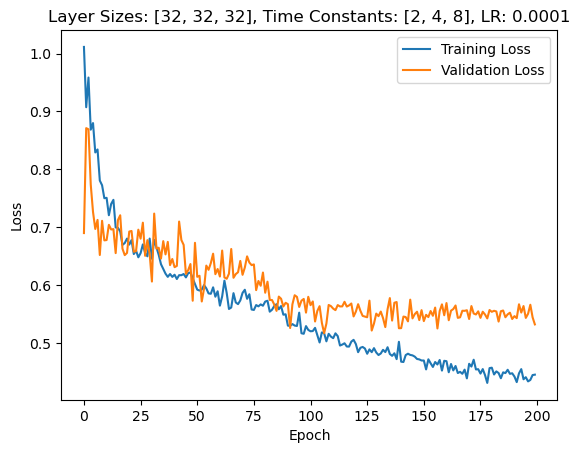

  0%|          | 1/200 [00:14<47:08, 14.22s/it]

Epoch 1/200, Training Loss: 2.143462394768337, Validation Loss: 1.5717709570058755


  1%|          | 2/200 [00:28<46:35, 14.12s/it]

Epoch 2/200, Training Loss: 1.0263323941320743, Validation Loss: 1.2155363985470362


  2%|▏         | 3/200 [00:41<44:50, 13.66s/it]

Epoch 3/200, Training Loss: 0.9551990032196045, Validation Loss: 0.9080822552953448


  2%|▏         | 4/200 [00:54<44:04, 13.49s/it]

Epoch 4/200, Training Loss: 0.7314023454234285, Validation Loss: 0.7191458323172161


  2%|▎         | 5/200 [01:07<43:22, 13.34s/it]

Epoch 5/200, Training Loss: 0.7943063412072524, Validation Loss: 0.6777748614549637


  3%|▎         | 6/200 [01:21<43:38, 13.50s/it]

Epoch 6/200, Training Loss: 0.6896916745968584, Validation Loss: 0.624205789395741


  4%|▎         | 7/200 [01:35<44:05, 13.71s/it]

Epoch 7/200, Training Loss: 0.6837271277634602, Validation Loss: 0.6356734463146755


  4%|▍         | 8/200 [01:49<44:02, 13.76s/it]

Epoch 8/200, Training Loss: 0.6435896641803238, Validation Loss: 0.6691710842507226


  4%|▍         | 9/200 [02:03<43:51, 13.78s/it]

Epoch 9/200, Training Loss: 0.6129985108690442, Validation Loss: 0.576219978077071


  5%|▌         | 10/200 [02:17<43:53, 13.86s/it]

Epoch 10/200, Training Loss: 0.6092956499108728, Validation Loss: 0.6688634029456547


  6%|▌         | 11/200 [02:30<42:41, 13.56s/it]

Epoch 11/200, Training Loss: 0.5762161618133761, Validation Loss: 0.5999069043568203


  6%|▌         | 12/200 [02:43<41:53, 13.37s/it]

Epoch 12/200, Training Loss: 0.5534614706939122, Validation Loss: 0.6873401999473572


  6%|▋         | 13/200 [02:57<42:27, 13.62s/it]

Epoch 13/200, Training Loss: 0.5954235016175036, Validation Loss: 0.645858604993139


  7%|▋         | 14/200 [03:10<41:48, 13.48s/it]

Epoch 14/200, Training Loss: 0.5581378110174863, Validation Loss: 0.7459083199501038


  8%|▊         | 15/200 [03:24<41:49, 13.57s/it]

Epoch 15/200, Training Loss: 0.5777074638402687, Validation Loss: 0.6486986832959312


  8%|▊         | 16/200 [03:38<42:11, 13.76s/it]

Epoch 16/200, Training Loss: 0.5536780441707035, Validation Loss: 0.5757901647261211


  8%|▊         | 17/200 [03:52<41:48, 13.71s/it]

Epoch 17/200, Training Loss: 0.5700773571459752, Validation Loss: 0.509097369653838


  9%|▉         | 18/200 [04:05<41:12, 13.59s/it]

Epoch 18/200, Training Loss: 0.5528618727090224, Validation Loss: 0.6520186343363353


 10%|▉         | 19/200 [04:18<40:49, 13.53s/it]

Epoch 19/200, Training Loss: 0.5276153110108286, Validation Loss: 0.6823720250810895


 10%|█         | 20/200 [04:32<40:25, 13.48s/it]

Epoch 20/200, Training Loss: 0.5240375129681714, Validation Loss: 0.6718393308775765


 10%|█         | 21/200 [04:46<40:48, 13.68s/it]

Epoch 21/200, Training Loss: 0.5358707454969298, Validation Loss: 0.6315026666436877


 11%|█         | 22/200 [04:59<40:19, 13.59s/it]

Epoch 22/200, Training Loss: 0.5121837109327316, Validation Loss: 0.5483991290841784


 12%|█▏        | 23/200 [05:12<39:33, 13.41s/it]

Epoch 23/200, Training Loss: 0.5361265489515269, Validation Loss: 0.8266110973698753


 12%|█▏        | 24/200 [05:26<39:25, 13.44s/it]

Epoch 24/200, Training Loss: 0.5377112688883295, Validation Loss: 0.6662963799067906


 12%|█▎        | 25/200 [05:39<39:24, 13.51s/it]

Epoch 25/200, Training Loss: 0.5129788118713307, Validation Loss: 0.6431615991251809


 13%|█▎        | 26/200 [05:53<38:51, 13.40s/it]

Epoch 26/200, Training Loss: 0.5100354355461193, Validation Loss: 0.5568203542913709


 14%|█▎        | 27/200 [06:06<38:46, 13.45s/it]

Epoch 27/200, Training Loss: 0.5419168109601399, Validation Loss: 0.5245796569756099


 14%|█▍        | 28/200 [06:19<38:13, 13.33s/it]

Epoch 28/200, Training Loss: 0.5065910678427175, Validation Loss: 0.6217964674745288


 14%|█▍        | 29/200 [06:32<37:41, 13.23s/it]

Epoch 29/200, Training Loss: 0.5052231769516783, Validation Loss: 0.587519741484097


 15%|█▌        | 30/200 [06:46<37:37, 13.28s/it]

Epoch 30/200, Training Loss: 0.5447019467938621, Validation Loss: 0.6539022411618914


 16%|█▌        | 31/200 [06:58<37:08, 13.19s/it]

Epoch 31/200, Training Loss: 0.495409904223568, Validation Loss: 0.7648181574685233


 16%|█▌        | 32/200 [07:12<36:53, 13.18s/it]

Epoch 32/200, Training Loss: 0.5295089359553355, Validation Loss: 0.6330637782812119


 16%|█▋        | 33/200 [07:25<36:58, 13.28s/it]

Epoch 33/200, Training Loss: 0.5042464581300627, Validation Loss: 0.622991606593132


 17%|█▋        | 34/200 [07:39<37:11, 13.44s/it]

Epoch 34/200, Training Loss: 0.5264009445343377, Validation Loss: 0.5354467970984322


 18%|█▊        | 35/200 [07:52<36:55, 13.43s/it]

Epoch 35/200, Training Loss: 0.49615848626730574, Validation Loss: 0.6773255488702229


 18%|█▊        | 36/200 [08:06<36:41, 13.42s/it]

Epoch 36/200, Training Loss: 0.4794496590236448, Validation Loss: 0.5554602146148682


 18%|█▊        | 37/200 [08:19<36:09, 13.31s/it]

Epoch 37/200, Training Loss: 0.4727164608127666, Validation Loss: 0.5547484712941306


 19%|█▉        | 38/200 [08:33<36:27, 13.50s/it]

Epoch 38/200, Training Loss: 0.49985681389862635, Validation Loss: 0.610881622348513


 20%|█▉        | 39/200 [08:46<36:14, 13.51s/it]

Epoch 39/200, Training Loss: 0.5389884721558049, Validation Loss: 0.6393803443227496


 20%|██        | 40/200 [08:59<35:40, 13.38s/it]

Epoch 40/200, Training Loss: 0.4910306267018588, Validation Loss: 0.5590217666966575


 20%|██        | 41/200 [09:13<35:16, 13.31s/it]

Epoch 41/200, Training Loss: 0.4710748220952052, Validation Loss: 0.7127002477645874


 21%|██        | 42/200 [09:26<35:01, 13.30s/it]

Epoch 42/200, Training Loss: 0.4793109615456383, Validation Loss: 0.61360835816179


 22%|██▏       | 43/200 [09:39<34:35, 13.22s/it]

Epoch 43/200, Training Loss: 0.47899262621155325, Validation Loss: 0.6165938717978341


 22%|██▏       | 44/200 [09:52<34:32, 13.29s/it]

Epoch 44/200, Training Loss: 0.5279732650181033, Validation Loss: 0.5718504360743931


 22%|██▎       | 45/200 [10:06<34:18, 13.28s/it]

Epoch 45/200, Training Loss: 0.4847638010978699, Validation Loss: 0.5365232825279236


 23%|██▎       | 46/200 [10:19<33:54, 13.21s/it]

Epoch 46/200, Training Loss: 0.47345449930092076, Validation Loss: 0.6905248590878078


 24%|██▎       | 47/200 [10:33<34:33, 13.55s/it]

Epoch 47/200, Training Loss: 0.48411301143889157, Validation Loss: 0.6863527446985245


 24%|██▍       | 48/200 [10:46<34:06, 13.46s/it]

Epoch 48/200, Training Loss: 0.4434688684512984, Validation Loss: 0.5603405024324145


 24%|██▍       | 49/200 [10:59<33:31, 13.32s/it]

Epoch 49/200, Training Loss: 0.44477033558881507, Validation Loss: 0.624587778534208


 25%|██▌       | 50/200 [11:13<33:33, 13.42s/it]

Epoch 50/200, Training Loss: 0.4980310578391237, Validation Loss: 0.5838936993053981


 26%|██▌       | 51/200 [11:27<33:38, 13.55s/it]

Epoch 51/200, Training Loss: 0.44026562937025754, Validation Loss: 0.6142624020576477


 26%|██▌       | 52/200 [11:40<33:09, 13.44s/it]

Epoch 52/200, Training Loss: 0.44518063231459204, Validation Loss: 0.6890002233641488


 26%|██▋       | 53/200 [11:53<32:55, 13.44s/it]

Epoch 53/200, Training Loss: 0.46126192808151245, Validation Loss: 0.7379463613033295


 27%|██▋       | 54/200 [12:06<32:20, 13.29s/it]

Epoch 54/200, Training Loss: 0.43544982106618163, Validation Loss: 0.6289890323366437


 28%|██▊       | 55/200 [12:19<32:00, 13.24s/it]

Epoch 55/200, Training Loss: 0.4551248033091707, Validation Loss: 0.5314201031412397


 28%|██▊       | 56/200 [12:33<31:51, 13.27s/it]

Epoch 56/200, Training Loss: 0.5039955518155728, Validation Loss: 0.49088036375386374


 28%|██▊       | 57/200 [12:46<31:24, 13.18s/it]

Epoch 57/200, Training Loss: 0.4868787094107214, Validation Loss: 0.5396574011870793


 29%|██▉       | 58/200 [12:59<30:58, 13.09s/it]

Epoch 58/200, Training Loss: 0.4717911990746012, Validation Loss: 0.4793608444077628


 30%|██▉       | 59/200 [13:12<31:01, 13.20s/it]

Epoch 59/200, Training Loss: 0.4761297098308239, Validation Loss: 0.6711816745144981


 30%|███       | 60/200 [13:26<31:06, 13.33s/it]

Epoch 60/200, Training Loss: 0.4532695865293719, Validation Loss: 0.7135750140462603


 30%|███       | 61/200 [13:39<30:50, 13.31s/it]

Epoch 61/200, Training Loss: 0.47751709481455246, Validation Loss: 0.6142553027187075


 31%|███       | 62/200 [13:53<30:48, 13.40s/it]

Epoch 62/200, Training Loss: 0.4397811802490702, Validation Loss: 0.6305377270494189


 32%|███▏      | 63/200 [14:06<30:20, 13.29s/it]

Epoch 63/200, Training Loss: 0.4826196420867488, Validation Loss: 0.7103036556925092


 32%|███▏      | 64/200 [14:20<30:34, 13.49s/it]

Epoch 64/200, Training Loss: 0.47483242401536907, Validation Loss: 0.5958396451813834


 32%|███▎      | 65/200 [14:33<30:19, 13.48s/it]

Epoch 65/200, Training Loss: 0.4456178515024905, Validation Loss: 0.5866069751126426


 33%|███▎      | 66/200 [14:46<29:46, 13.33s/it]

Epoch 66/200, Training Loss: 0.45881972222957973, Validation Loss: 0.6031191434179034


 34%|███▎      | 67/200 [14:59<29:30, 13.31s/it]

Epoch 67/200, Training Loss: 0.4442179262075784, Validation Loss: 0.6219211305890765


 34%|███▍      | 68/200 [15:13<29:16, 13.31s/it]

Epoch 68/200, Training Loss: 0.425314872332339, Validation Loss: 0.6134130188396999


 34%|███▍      | 69/200 [15:25<28:48, 13.19s/it]

Epoch 69/200, Training Loss: 0.4362655532247615, Validation Loss: 0.6778961505208697


 35%|███▌      | 70/200 [15:39<28:34, 13.19s/it]

Epoch 70/200, Training Loss: 0.4518783376464304, Validation Loss: 0.5664707933153424


 36%|███▌      | 71/200 [15:52<28:27, 13.24s/it]

Epoch 71/200, Training Loss: 0.43794740848946123, Validation Loss: 0.5567746247564044


 36%|███▌      | 72/200 [16:05<28:02, 13.15s/it]

Epoch 72/200, Training Loss: 0.4502645331733632, Validation Loss: 0.6688293814659119


 36%|███▋      | 73/200 [16:19<28:22, 13.41s/it]

Epoch 73/200, Training Loss: 0.48785443182261484, Validation Loss: 0.5726394078561238


 37%|███▋      | 74/200 [16:33<28:27, 13.55s/it]

Epoch 74/200, Training Loss: 0.43825372912973726, Validation Loss: 0.5979058487074715


 38%|███▊      | 75/200 [16:46<27:59, 13.44s/it]

Epoch 75/200, Training Loss: 0.42793076752491715, Validation Loss: 0.5014019480773381


 38%|███▊      | 76/200 [16:59<27:42, 13.40s/it]

Epoch 76/200, Training Loss: 0.4050600140724542, Validation Loss: 0.5599715816123145


 38%|███▊      | 77/200 [17:13<27:52, 13.59s/it]

Epoch 77/200, Training Loss: 0.4253199280432935, Validation Loss: 0.5457720245633807


 39%|███▉      | 78/200 [17:27<27:24, 13.48s/it]

Epoch 78/200, Training Loss: 0.4147661288954177, Validation Loss: 0.5604822933673859


 40%|███▉      | 79/200 [17:40<27:13, 13.50s/it]

Epoch 79/200, Training Loss: 0.39460345006214, Validation Loss: 0.6647610323769706


 40%|████      | 80/200 [17:53<26:37, 13.32s/it]

Epoch 80/200, Training Loss: 0.39640727217467325, Validation Loss: 0.6139254357133593


 40%|████      | 81/200 [18:06<26:13, 13.22s/it]

Epoch 81/200, Training Loss: 0.40851265388839647, Validation Loss: 0.5910749414137432


 41%|████      | 82/200 [18:19<26:05, 13.27s/it]

Epoch 82/200, Training Loss: 0.40493840878864507, Validation Loss: 0.5680872797966003


 42%|████▏     | 83/200 [18:33<25:47, 13.23s/it]

Epoch 83/200, Training Loss: 0.4164204074526733, Validation Loss: 0.5860197799546378


 42%|████▏     | 84/200 [18:45<25:25, 13.15s/it]

Epoch 84/200, Training Loss: 0.4084082768773133, Validation Loss: 0.5434447612081256


 42%|████▎     | 85/200 [18:59<25:20, 13.22s/it]

Epoch 85/200, Training Loss: 0.4013350874466716, Validation Loss: 0.5175122618675232


 43%|████▎     | 86/200 [19:13<25:31, 13.44s/it]

Epoch 86/200, Training Loss: 0.38044550340130645, Validation Loss: 0.6055859710489001


 44%|████▎     | 87/200 [19:26<25:10, 13.37s/it]

Epoch 87/200, Training Loss: 0.4046625345945358, Validation Loss: 0.5775966346263885


 44%|████▍     | 88/200 [19:39<24:57, 13.37s/it]

Epoch 88/200, Training Loss: 0.3867010550116593, Validation Loss: 0.6053084305354527


 44%|████▍     | 89/200 [19:52<24:33, 13.27s/it]

Epoch 89/200, Training Loss: 0.3887172876945082, Validation Loss: 0.5654408420835223


 45%|████▌     | 90/200 [20:06<24:37, 13.43s/it]

Epoch 90/200, Training Loss: 0.3956653277547854, Validation Loss: 0.568818211555481


 46%|████▌     | 91/200 [20:20<24:29, 13.48s/it]

Epoch 91/200, Training Loss: 0.39025631111185505, Validation Loss: 0.6066055979047503


 46%|████▌     | 92/200 [20:33<24:08, 13.41s/it]

Epoch 92/200, Training Loss: 0.3801592953924863, Validation Loss: 0.6058452342237745


 46%|████▋     | 93/200 [20:46<23:41, 13.28s/it]

Epoch 93/200, Training Loss: 0.3764867539394577, Validation Loss: 0.711337285382407


 47%|████▋     | 94/200 [20:59<23:31, 13.31s/it]

Epoch 94/200, Training Loss: 0.3810102309820787, Validation Loss: 0.5548241606780461


 48%|████▊     | 95/200 [21:13<23:10, 13.24s/it]

Epoch 95/200, Training Loss: 0.3872560799684165, Validation Loss: 0.6178757803780692


 48%|████▊     | 96/200 [21:26<22:57, 13.24s/it]

Epoch 96/200, Training Loss: 0.41925121590776265, Validation Loss: 0.5781391561031342


 48%|████▊     | 97/200 [21:39<22:44, 13.25s/it]

Epoch 97/200, Training Loss: 0.3748917215205026, Validation Loss: 0.578333067042487


 49%|████▉     | 98/200 [21:52<22:22, 13.16s/it]

Epoch 98/200, Training Loss: 0.3935262316240455, Validation Loss: 0.6225966683455876


 50%|████▉     | 99/200 [22:06<22:38, 13.45s/it]

Epoch 99/200, Training Loss: 0.3764563433404239, Validation Loss: 0.5915383781705584


 50%|█████     | 100/200 [22:20<22:29, 13.49s/it]

Epoch 100/200, Training Loss: 0.3677540788391851, Validation Loss: 0.5677980503865651


 50%|█████     | 101/200 [22:33<22:05, 13.39s/it]

Epoch 101/200, Training Loss: 0.3608769858783146, Validation Loss: 0.5731483186994281


 51%|█████     | 102/200 [22:46<21:48, 13.35s/it]

Epoch 102/200, Training Loss: 0.3664164886159717, Validation Loss: 0.5802594125270844


 52%|█████▏    | 103/200 [23:00<21:54, 13.55s/it]

Epoch 103/200, Training Loss: 0.3764192284840458, Validation Loss: 0.5446336822850364


 52%|█████▏    | 104/200 [23:13<21:32, 13.47s/it]

Epoch 104/200, Training Loss: 0.36964517916148565, Validation Loss: 0.5845996907779148


 52%|█████▎    | 105/200 [23:27<21:12, 13.39s/it]

Epoch 105/200, Training Loss: 0.38030537906682715, Validation Loss: 0.5612714013883046


 53%|█████▎    | 106/200 [23:40<20:51, 13.32s/it]

Epoch 106/200, Training Loss: 0.36172065841701795, Validation Loss: 0.5844254600150245


 54%|█████▎    | 107/200 [23:53<20:29, 13.22s/it]

Epoch 107/200, Training Loss: 0.36193204460279, Validation Loss: 0.5714082675320762


 54%|█████▍    | 108/200 [24:06<20:20, 13.27s/it]

Epoch 108/200, Training Loss: 0.37506012702887914, Validation Loss: 0.6062978761536735


 55%|█████▍    | 109/200 [24:19<20:02, 13.21s/it]

Epoch 109/200, Training Loss: 0.36244744624731673, Validation Loss: 0.6104838848114014


 55%|█████▌    | 110/200 [24:32<19:43, 13.15s/it]

Epoch 110/200, Training Loss: 0.36697868384280297, Validation Loss: 0.5855759807995388


 56%|█████▌    | 111/200 [24:46<19:39, 13.25s/it]

Epoch 111/200, Training Loss: 0.38294309799401266, Validation Loss: 0.5655652731657028


 56%|█████▌    | 112/200 [25:00<19:46, 13.49s/it]

Epoch 112/200, Training Loss: 0.4104696731522398, Validation Loss: 0.5742150161947522


 56%|█████▋    | 113/200 [25:13<19:25, 13.39s/it]

Epoch 113/200, Training Loss: 0.3647671204130605, Validation Loss: 0.5839920427118029


 57%|█████▋    | 114/200 [25:26<19:12, 13.40s/it]

Epoch 114/200, Training Loss: 0.35729253432660735, Validation Loss: 0.5857390974249158


 57%|█████▊    | 115/200 [25:39<18:48, 13.27s/it]

Epoch 115/200, Training Loss: 0.3646474134809566, Validation Loss: 0.5504196924822671


 58%|█████▊    | 116/200 [25:53<18:51, 13.47s/it]

Epoch 116/200, Training Loss: 0.3486912097289877, Validation Loss: 0.49442913276808603


 58%|█████▊    | 117/200 [26:07<18:44, 13.55s/it]

Epoch 117/200, Training Loss: 0.3647309007509699, Validation Loss: 0.5482807031699589


 59%|█████▉    | 118/200 [26:20<18:18, 13.40s/it]

Epoch 118/200, Training Loss: 0.3711595242878176, Validation Loss: 0.5293180814811161


 60%|█████▉    | 119/200 [26:33<17:57, 13.30s/it]

Epoch 119/200, Training Loss: 0.3560048774728235, Validation Loss: 0.5394687652587891


 60%|██████    | 120/200 [26:46<17:45, 13.32s/it]

Epoch 120/200, Training Loss: 0.3793144316043494, Validation Loss: 0.5312655099800655


 60%|██████    | 121/200 [27:00<17:31, 13.31s/it]

Epoch 121/200, Training Loss: 0.36078112558373865, Validation Loss: 0.532565291438784


 61%|██████    | 122/200 [27:13<17:10, 13.22s/it]

Epoch 122/200, Training Loss: 0.3518341338297106, Validation Loss: 0.5080240113394601


 62%|██████▏   | 123/200 [27:26<17:02, 13.28s/it]

Epoch 123/200, Training Loss: 0.34776432278021324, Validation Loss: 0.5480071689401355


 62%|██████▏   | 124/200 [27:39<16:47, 13.25s/it]

Epoch 124/200, Training Loss: 0.35938053465676756, Validation Loss: 0.5423376836947033


 62%|██████▎   | 125/200 [27:53<16:49, 13.46s/it]

Epoch 125/200, Training Loss: 0.339255025083164, Validation Loss: 0.5718783416918346


 63%|██████▎   | 126/200 [28:07<16:38, 13.49s/it]

Epoch 126/200, Training Loss: 0.34361973840673016, Validation Loss: 0.543269293648856


 64%|██████▎   | 127/200 [28:20<16:17, 13.39s/it]

Epoch 127/200, Training Loss: 0.3573367456501385, Validation Loss: 0.5695897021463939


 64%|██████▍   | 128/200 [28:33<16:00, 13.34s/it]

Epoch 128/200, Training Loss: 0.3405197155925463, Validation Loss: 0.5465717571122306


 64%|██████▍   | 129/200 [28:47<16:06, 13.61s/it]

Epoch 129/200, Training Loss: 0.34271838825266315, Validation Loss: 0.6448625411306109


 65%|██████▌   | 130/200 [29:01<15:47, 13.53s/it]

Epoch 130/200, Training Loss: 0.3506191966106307, Validation Loss: 0.576280972787312


 66%|██████▌   | 131/200 [29:14<15:28, 13.46s/it]

Epoch 131/200, Training Loss: 0.34406524868506305, Validation Loss: 0.6073548368045262


 66%|██████▌   | 132/200 [29:27<15:12, 13.42s/it]

Epoch 132/200, Training Loss: 0.34281984266807447, Validation Loss: 0.5823382905551365


 66%|██████▋   | 133/200 [29:40<14:51, 13.30s/it]

Epoch 133/200, Training Loss: 0.3371393660891731, Validation Loss: 0.5261122563055584


 67%|██████▋   | 134/200 [29:54<14:39, 13.32s/it]

Epoch 134/200, Training Loss: 0.32694872219185783, Validation Loss: 0.5715763568878174


 68%|██████▊   | 135/200 [30:07<14:26, 13.33s/it]

Epoch 135/200, Training Loss: 0.35655870850918425, Validation Loss: 0.5946641266345978


 68%|██████▊   | 136/200 [30:20<14:08, 13.26s/it]

Epoch 136/200, Training Loss: 0.36320615686335656, Validation Loss: 0.5872409684317452


 68%|██████▊   | 137/200 [30:34<14:00, 13.34s/it]

Epoch 137/200, Training Loss: 0.3258672831755764, Validation Loss: 0.5724606471402305


 69%|██████▉   | 138/200 [30:48<14:02, 13.59s/it]

Epoch 138/200, Training Loss: 0.3455015055413516, Validation Loss: 0.5257766587393624


 70%|██████▉   | 139/200 [31:01<13:41, 13.47s/it]

Epoch 139/200, Training Loss: 0.335436168706642, Validation Loss: 0.5581786206790379


 70%|███████   | 140/200 [31:15<13:26, 13.44s/it]

Epoch 140/200, Training Loss: 0.33897922511370676, Validation Loss: 0.5878111805234637


 70%|███████   | 141/200 [31:29<13:22, 13.60s/it]

Epoch 141/200, Training Loss: 0.35330826226832734, Validation Loss: 0.5561485652412687


 71%|███████   | 142/200 [31:42<13:02, 13.50s/it]

Epoch 142/200, Training Loss: 0.321300171034516, Validation Loss: 0.6554436428206307


 72%|███████▏  | 143/200 [31:55<12:51, 13.54s/it]

Epoch 143/200, Training Loss: 0.36065091052145326, Validation Loss: 0.5067945037569318


 72%|███████▏  | 144/200 [32:09<12:31, 13.42s/it]

Epoch 144/200, Training Loss: 0.35492253205123936, Validation Loss: 0.5639135880129678


 72%|███████▎  | 145/200 [32:22<12:11, 13.30s/it]

Epoch 145/200, Training Loss: 0.33516974859642534, Validation Loss: 0.5031095956053052


 73%|███████▎  | 146/200 [32:35<12:00, 13.35s/it]

Epoch 146/200, Training Loss: 0.35386331042028824, Validation Loss: 0.5181318862097604


 74%|███████▎  | 147/200 [32:48<11:45, 13.31s/it]

Epoch 147/200, Training Loss: 0.34447796221049326, Validation Loss: 0.5497635560376304


 74%|███████▍  | 148/200 [33:01<11:28, 13.23s/it]

Epoch 148/200, Training Loss: 0.3318367448617827, Validation Loss: 0.6180405276162284


 74%|███████▍  | 149/200 [33:15<11:19, 13.32s/it]

Epoch 149/200, Training Loss: 0.34968497702535595, Validation Loss: 0.5811994458947863


 75%|███████▌  | 150/200 [33:29<11:15, 13.51s/it]

Epoch 150/200, Training Loss: 0.34250868983426186, Validation Loss: 0.6112035853522164


 76%|███████▌  | 151/200 [33:42<11:00, 13.48s/it]

Epoch 151/200, Training Loss: 0.3295230678511116, Validation Loss: 0.5270081481763295


 76%|███████▌  | 152/200 [33:56<10:48, 13.50s/it]

Epoch 152/200, Training Loss: 0.3255380964222944, Validation Loss: 0.5560345713581357


 76%|███████▋  | 153/200 [34:09<10:28, 13.38s/it]

Epoch 153/200, Training Loss: 0.34802000393282695, Validation Loss: 0.5622943256582532


 77%|███████▋  | 154/200 [34:23<10:21, 13.52s/it]

Epoch 154/200, Training Loss: 0.32702276925995666, Validation Loss: 0.5303022414445877


 78%|███████▊  | 155/200 [34:36<10:10, 13.57s/it]

Epoch 155/200, Training Loss: 0.3299627350467556, Validation Loss: 0.5623151596103396


 78%|███████▊  | 156/200 [34:50<09:53, 13.50s/it]

Epoch 156/200, Training Loss: 0.3082693676060101, Validation Loss: 0.5992632210254669


 78%|███████▊  | 157/200 [35:03<09:34, 13.37s/it]

Epoch 157/200, Training Loss: 0.3132550588475083, Validation Loss: 0.5779250987938472


 79%|███████▉  | 158/200 [35:16<09:22, 13.38s/it]

Epoch 158/200, Training Loss: 0.3305230915265263, Validation Loss: 0.5533180364540645


 80%|███████▉  | 159/200 [35:29<09:05, 13.29s/it]

Epoch 159/200, Training Loss: 0.320603110880222, Validation Loss: 0.5709604748657772


 80%|████████  | 160/200 [35:42<08:50, 13.26s/it]

Epoch 160/200, Training Loss: 0.366840142686412, Validation Loss: 0.5501450193779809


 80%|████████  | 161/200 [35:56<08:39, 13.33s/it]

Epoch 161/200, Training Loss: 0.35155324159928086, Validation Loss: 0.5968283074242728


 81%|████████  | 162/200 [36:09<08:23, 13.26s/it]

Epoch 162/200, Training Loss: 0.3236328142712701, Validation Loss: 0.5229115911892482


 82%|████████▏ | 163/200 [36:23<08:18, 13.48s/it]

Epoch 163/200, Training Loss: 0.3199357820569344, Validation Loss: 0.5196425701890673


 82%|████████▏ | 164/200 [36:37<08:15, 13.76s/it]

Epoch 164/200, Training Loss: 0.3036755140659944, Validation Loss: 0.5317009474549975


 82%|████████▎ | 165/200 [36:51<07:59, 13.69s/it]

Epoch 165/200, Training Loss: 0.33147265691802186, Validation Loss: 0.5094061940908432


 83%|████████▎ | 166/200 [37:05<07:50, 13.85s/it]

Epoch 166/200, Training Loss: 0.32901441741664456, Validation Loss: 0.5156570715563638


 84%|████████▎ | 167/200 [37:19<07:33, 13.75s/it]

Epoch 167/200, Training Loss: 0.30943381111576873, Validation Loss: 0.5200608032090324


 84%|████████▍ | 168/200 [37:32<07:14, 13.57s/it]

Epoch 168/200, Training Loss: 0.30491306323487805, Validation Loss: 0.5305432017360415


 84%|████████▍ | 169/200 [37:45<06:59, 13.53s/it]

Epoch 169/200, Training Loss: 0.3149670587395722, Validation Loss: 0.5767521943364825


 85%|████████▌ | 170/200 [37:59<06:45, 13.52s/it]

Epoch 170/200, Training Loss: 0.30005627786213496, Validation Loss: 0.5135379305907658


 86%|████████▌ | 171/200 [38:12<06:28, 13.38s/it]

Epoch 171/200, Training Loss: 0.33126908231456326, Validation Loss: 0.4952987624066217


 86%|████████▌ | 172/200 [38:25<06:15, 13.40s/it]

Epoch 172/200, Training Loss: 0.29837532721038135, Validation Loss: 0.5509159777845655


 86%|████████▋ | 173/200 [38:39<06:00, 13.34s/it]

Epoch 173/200, Training Loss: 0.31268860034222873, Validation Loss: 0.5292707553931645


 87%|████████▋ | 174/200 [38:52<05:46, 13.34s/it]

Epoch 174/200, Training Loss: 0.2995068884964259, Validation Loss: 0.5293112865516117


 88%|████████▊ | 175/200 [39:06<05:41, 13.65s/it]

Epoch 175/200, Training Loss: 0.3246182778252746, Validation Loss: 0.5444671383925846


 88%|████████▊ | 176/200 [39:20<05:24, 13.54s/it]

Epoch 176/200, Training Loss: 0.314228356165706, Validation Loss: 0.5115661088909421


 88%|████████▊ | 177/200 [39:33<05:07, 13.39s/it]

Epoch 177/200, Training Loss: 0.3286810483572618, Validation Loss: 0.5818620835031781


 89%|████████▉ | 178/200 [39:46<04:56, 13.49s/it]

Epoch 178/200, Training Loss: 0.31734344756828164, Validation Loss: 0.5317362802369254


 90%|████████▉ | 179/200 [40:00<04:46, 13.63s/it]

Epoch 179/200, Training Loss: 0.29746572898243956, Validation Loss: 0.5240315326622554


 90%|█████████ | 180/200 [40:14<04:30, 13.53s/it]

Epoch 180/200, Training Loss: 0.3259265637903843, Validation Loss: 0.6282447023051125


 90%|█████████ | 181/200 [40:27<04:17, 13.54s/it]

Epoch 181/200, Training Loss: 0.3083385628349376, Validation Loss: 0.5270538202353886


 91%|█████████ | 182/200 [40:40<04:00, 13.37s/it]

Epoch 182/200, Training Loss: 0.29838626831769943, Validation Loss: 0.5236533944095884


 92%|█████████▏| 183/200 [40:53<03:45, 13.29s/it]

Epoch 183/200, Training Loss: 0.305342916750683, Validation Loss: 0.531622296997479


 92%|█████████▏| 184/200 [41:07<03:34, 13.42s/it]

Epoch 184/200, Training Loss: 0.3027669607468371, Validation Loss: 0.5242136823279517


 92%|█████████▎| 185/200 [41:20<03:20, 13.36s/it]

Epoch 185/200, Training Loss: 0.3040704992863367, Validation Loss: 0.5320045522281102


 93%|█████████▎| 186/200 [41:33<03:06, 13.30s/it]

Epoch 186/200, Training Loss: 0.3081842400836495, Validation Loss: 0.5816190498215812


 94%|█████████▎| 187/200 [41:47<02:53, 13.35s/it]

Epoch 187/200, Training Loss: 0.3023651581749601, Validation Loss: 0.5886021213872092


 94%|█████████▍| 188/200 [42:01<02:43, 13.59s/it]

Epoch 188/200, Training Loss: 0.3194040782609076, Validation Loss: 0.6366251962525504


 94%|█████████▍| 189/200 [42:14<02:28, 13.52s/it]

Epoch 189/200, Training Loss: 0.3081661738314719, Validation Loss: 0.5370324105024338


 95%|█████████▌| 190/200 [42:28<02:14, 13.49s/it]

Epoch 190/200, Training Loss: 0.29668742418289185, Validation Loss: 0.5161782162530082


 96%|█████████▌| 191/200 [42:41<02:00, 13.39s/it]

Epoch 191/200, Training Loss: 0.30188888775290185, Validation Loss: 0.5193122774362564


 96%|█████████▌| 192/200 [42:55<01:49, 13.70s/it]

Epoch 192/200, Training Loss: 0.29311499533788216, Validation Loss: 0.4877036533185414


 96%|█████████▋| 193/200 [43:09<01:35, 13.65s/it]

Epoch 193/200, Training Loss: 0.30129206714765083, Validation Loss: 0.5564356063093457


 97%|█████████▋| 194/200 [43:22<01:20, 13.49s/it]

Epoch 194/200, Training Loss: 0.29745986270454694, Validation Loss: 0.4683852642774582


 98%|█████████▊| 195/200 [43:35<01:07, 13.42s/it]

Epoch 195/200, Training Loss: 0.28066682632801665, Validation Loss: 0.4725833088159561


 98%|█████████▊| 196/200 [43:48<00:53, 13.38s/it]

Epoch 196/200, Training Loss: 0.2679929630655163, Validation Loss: 0.5334921308926174


 98%|█████████▊| 197/200 [44:02<00:39, 13.31s/it]

Epoch 197/200, Training Loss: 0.2849468974712885, Validation Loss: 0.5043782676969256


 99%|█████████▉| 198/200 [44:15<00:26, 13.39s/it]

Epoch 198/200, Training Loss: 0.2889071899764943, Validation Loss: 0.5309254441942487


100%|█████████▉| 199/200 [44:29<00:13, 13.38s/it]

Epoch 199/200, Training Loss: 0.29140992687558226, Validation Loss: 0.511540127652032


100%|██████████| 200/200 [44:42<00:00, 13.41s/it]

Epoch 200/200, Training Loss: 0.29832155229348056, Validation Loss: 0.48024568813187735
Final Accuracy: 90.31%, Precision: 0.89, Recall: 0.92


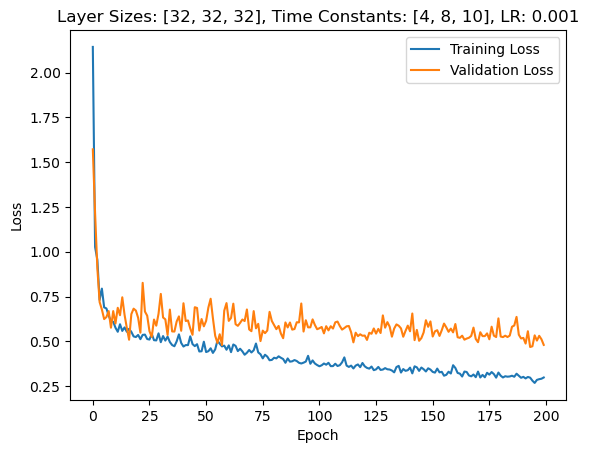

  0%|          | 1/200 [00:14<46:47, 14.11s/it]

Epoch 1/200, Training Loss: 1.0520743525253151, Validation Loss: 0.8856778570583889


  1%|          | 2/200 [00:27<45:57, 13.93s/it]

Epoch 2/200, Training Loss: 0.9326140127092037, Validation Loss: 1.196657704455512


  2%|▏         | 3/200 [00:40<44:20, 13.51s/it]

Epoch 3/200, Training Loss: 0.9293842450627741, Validation Loss: 1.4217039602143424


  2%|▏         | 4/200 [00:54<43:44, 13.39s/it]

Epoch 4/200, Training Loss: 0.9416643043733993, Validation Loss: 0.8047957164900643


  2%|▎         | 5/200 [01:07<43:06, 13.26s/it]

Epoch 5/200, Training Loss: 0.8359838932190301, Validation Loss: 0.8122856893709728


  3%|▎         | 6/200 [01:20<43:21, 13.41s/it]

Epoch 6/200, Training Loss: 0.9475362514549831, Validation Loss: 0.6178475064890725


  4%|▎         | 7/200 [01:34<43:52, 13.64s/it]

Epoch 7/200, Training Loss: 1.0774058716477088, Validation Loss: 0.8834566984857831


  4%|▍         | 8/200 [01:48<43:37, 13.63s/it]

Epoch 8/200, Training Loss: 0.9031390879514083, Validation Loss: 0.6753449652876172


  4%|▍         | 9/200 [02:02<43:43, 13.73s/it]

Epoch 9/200, Training Loss: 0.7813130988264984, Validation Loss: 0.7538497171231678


  5%|▌         | 10/200 [02:16<43:40, 13.79s/it]

Epoch 10/200, Training Loss: 1.0707836516623228, Validation Loss: 0.9192752540111542


  6%|▌         | 11/200 [02:29<42:44, 13.57s/it]

Epoch 11/200, Training Loss: 0.8619251037543675, Validation Loss: 0.8936465169702258


  6%|▌         | 12/200 [02:43<42:50, 13.67s/it]

Epoch 12/200, Training Loss: 1.0540104722076993, Validation Loss: 0.9789307798658099


  6%|▋         | 13/200 [02:57<43:04, 13.82s/it]

Epoch 13/200, Training Loss: 0.8230388918012943, Validation Loss: 1.5273904321449143


  7%|▋         | 14/200 [03:10<42:14, 13.63s/it]

Epoch 14/200, Training Loss: 1.1004179783587187, Validation Loss: 0.7913838539804731


  8%|▊         | 15/200 [03:24<42:15, 13.70s/it]

Epoch 15/200, Training Loss: 0.7706083211134065, Validation Loss: 0.7183948882988521


  8%|▊         | 16/200 [03:38<41:46, 13.62s/it]

Epoch 16/200, Training Loss: 1.3054915191429965, Validation Loss: 3.2634890590395247


  8%|▊         | 17/200 [03:51<40:54, 13.41s/it]

Epoch 17/200, Training Loss: 1.036549152068372, Validation Loss: 1.6452172515647752


  9%|▉         | 18/200 [04:03<40:16, 13.28s/it]

Epoch 18/200, Training Loss: 0.9409563932216393, Validation Loss: 0.866516866854259


 10%|▉         | 19/200 [04:17<40:05, 13.29s/it]

Epoch 19/200, Training Loss: 0.7883601627259884, Validation Loss: 0.7723622960703713


 10%|█         | 20/200 [04:31<40:20, 13.45s/it]

Epoch 20/200, Training Loss: 0.7214855577023525, Validation Loss: 0.7068173672471728


 10%|█         | 21/200 [04:44<39:45, 13.33s/it]

Epoch 21/200, Training Loss: 0.71120090192219, Validation Loss: 0.5587292441299984


 11%|█         | 22/200 [04:57<39:25, 13.29s/it]

Epoch 22/200, Training Loss: 0.7144894285022088, Validation Loss: 0.6584647297859192


 12%|█▏        | 23/200 [05:10<38:51, 13.17s/it]

Epoch 23/200, Training Loss: 0.7127680592941787, Validation Loss: 0.5652818892683301


 12%|█▏        | 24/200 [05:24<39:30, 13.47s/it]

Epoch 24/200, Training Loss: 0.6683204905042108, Validation Loss: 0.6853963477270943


 12%|█▎        | 25/200 [05:37<39:13, 13.45s/it]

Epoch 25/200, Training Loss: 0.6359906950086918, Validation Loss: 0.7746137018714633


 13%|█▎        | 26/200 [05:50<38:33, 13.29s/it]

Epoch 26/200, Training Loss: 0.9685358281405467, Validation Loss: 0.8771979638508388


 14%|█▎        | 27/200 [06:03<38:16, 13.28s/it]

Epoch 27/200, Training Loss: 1.197469174861908, Validation Loss: 1.247406474181584


 14%|█▍        | 28/200 [06:17<37:55, 13.23s/it]

Epoch 28/200, Training Loss: 0.813072218085235, Validation Loss: 0.8626068362167904


 14%|█▍        | 29/200 [06:30<37:28, 13.15s/it]

Epoch 29/200, Training Loss: 0.7622898575269951, Validation Loss: 0.9298525410039085


 15%|█▌        | 30/200 [06:43<37:15, 13.15s/it]

Epoch 30/200, Training Loss: 0.7600181996822357, Validation Loss: 0.8656946271657944


 16%|█▌        | 31/200 [06:56<37:03, 13.15s/it]

Epoch 31/200, Training Loss: 0.6584890434202159, Validation Loss: 1.1224067509174347


 16%|█▌        | 32/200 [07:09<36:48, 13.15s/it]

Epoch 32/200, Training Loss: 0.997056283478467, Validation Loss: 0.9659768896443504


 16%|█▋        | 33/200 [07:23<37:16, 13.39s/it]

Epoch 33/200, Training Loss: 0.7116310422150594, Validation Loss: 0.6665809409958976


 17%|█▋        | 34/200 [07:37<37:11, 13.44s/it]

Epoch 34/200, Training Loss: 0.6809531647079395, Validation Loss: 0.7539511408124652


 18%|█▊        | 35/200 [07:49<36:32, 13.29s/it]

Epoch 35/200, Training Loss: 0.7319505670160618, Validation Loss: 0.62346172864948


 18%|█▊        | 36/200 [08:03<36:08, 13.22s/it]

Epoch 36/200, Training Loss: 0.749727394220964, Validation Loss: 0.6249852925539017


 18%|█▊        | 37/200 [08:17<36:32, 13.45s/it]

Epoch 37/200, Training Loss: 0.693197767127235, Validation Loss: 0.6245078423193523


 19%|█▉        | 38/200 [08:30<36:07, 13.38s/it]

Epoch 38/200, Training Loss: 0.6374574157426942, Validation Loss: 0.6854078269430569


 20%|█▉        | 39/200 [08:43<35:40, 13.30s/it]

Epoch 39/200, Training Loss: 0.5609899562484814, Validation Loss: 0.5888350691114154


 20%|██        | 40/200 [08:56<35:16, 13.23s/it]

Epoch 40/200, Training Loss: 0.544138287879386, Validation Loss: 0.49485852250031065


 20%|██        | 41/200 [09:09<34:50, 13.15s/it]

Epoch 41/200, Training Loss: 0.5195538612469187, Validation Loss: 0.6825799814292363


 21%|██        | 42/200 [09:22<34:38, 13.15s/it]

Epoch 42/200, Training Loss: 0.51464451877576, Validation Loss: 0.5303452227796827


 22%|██▏       | 43/200 [09:35<34:35, 13.22s/it]

Epoch 43/200, Training Loss: 0.515298917889595, Validation Loss: 0.5747523818697248


 22%|██▏       | 44/200 [09:48<34:08, 13.13s/it]

Epoch 44/200, Training Loss: 0.5545672476291656, Validation Loss: 0.4947787438120161


 22%|██▎       | 45/200 [10:01<33:51, 13.11s/it]

Epoch 45/200, Training Loss: 0.4955384202723233, Validation Loss: 0.47443186172417234


 23%|██▎       | 46/200 [10:15<34:12, 13.33s/it]

Epoch 46/200, Training Loss: 0.5081077426109674, Validation Loss: 0.4849801776664598


 24%|██▎       | 47/200 [10:29<34:00, 13.34s/it]

Epoch 47/200, Training Loss: 0.49388198076554063, Validation Loss: 0.5748262384108135


 24%|██▍       | 48/200 [10:42<33:38, 13.28s/it]

Epoch 48/200, Training Loss: 0.4765681801539547, Validation Loss: 0.4834033378532955


 24%|██▍       | 49/200 [10:55<33:20, 13.25s/it]

Epoch 49/200, Training Loss: 0.477901262775907, Validation Loss: 0.581839286855289


 25%|██▌       | 50/200 [11:09<33:30, 13.41s/it]

Epoch 50/200, Training Loss: 0.5062889962826135, Validation Loss: 0.5085013828107289


 26%|██▌       | 51/200 [11:22<33:15, 13.39s/it]

Epoch 51/200, Training Loss: 0.48781131123596766, Validation Loss: 0.5781191544873374


 26%|██▌       | 52/200 [11:35<32:50, 13.31s/it]

Epoch 52/200, Training Loss: 0.48800583408688597, Validation Loss: 0.572323141353471


 26%|██▋       | 53/200 [11:48<32:22, 13.22s/it]

Epoch 53/200, Training Loss: 0.5230388208380286, Validation Loss: 0.5376765770571572


 27%|██▋       | 54/200 [12:01<32:06, 13.19s/it]

Epoch 54/200, Training Loss: 0.4537143069055845, Validation Loss: 0.55748122717653


 28%|██▊       | 55/200 [12:15<31:57, 13.22s/it]

Epoch 55/200, Training Loss: 0.47782680195457533, Validation Loss: 0.48791598422186716


 28%|██▊       | 56/200 [12:28<31:31, 13.13s/it]

Epoch 56/200, Training Loss: 0.4862965471901984, Validation Loss: 0.4376513149057116


 28%|██▊       | 57/200 [12:41<31:20, 13.15s/it]

Epoch 57/200, Training Loss: 0.49575999210465627, Validation Loss: 0.44732619183404104


 29%|██▉       | 58/200 [12:54<31:03, 13.13s/it]

Epoch 58/200, Training Loss: 0.4775849130918395, Validation Loss: 0.4491535042013441


 30%|██▉       | 59/200 [13:08<31:22, 13.35s/it]

Epoch 59/200, Training Loss: 0.4629360867558785, Validation Loss: 0.5508577419178826


 30%|███       | 60/200 [13:21<31:12, 13.38s/it]

Epoch 60/200, Training Loss: 0.5545863239270337, Validation Loss: 0.7775943619864327


 30%|███       | 61/200 [13:34<30:45, 13.28s/it]

Epoch 61/200, Training Loss: 0.549002821153065, Validation Loss: 0.4947265556880406


 31%|███       | 62/200 [13:47<30:23, 13.21s/it]

Epoch 62/200, Training Loss: 0.43578942091959827, Validation Loss: 0.5194447253431592


 32%|███▏      | 63/200 [14:01<30:43, 13.46s/it]

Epoch 63/200, Training Loss: 0.49852253299839094, Validation Loss: 0.591582287635122


 32%|███▏      | 64/200 [14:14<30:19, 13.38s/it]

Epoch 64/200, Training Loss: 0.47704062343768355, Validation Loss: 0.50186659182821


 32%|███▎      | 65/200 [14:27<29:52, 13.27s/it]

Epoch 65/200, Training Loss: 0.48786243965040965, Validation Loss: 0.5294780816350665


 33%|███▎      | 66/200 [14:41<29:37, 13.26s/it]

Epoch 66/200, Training Loss: 0.4711561599430048, Validation Loss: 0.4672211727925709


 34%|███▎      | 67/200 [14:54<29:22, 13.25s/it]

Epoch 67/200, Training Loss: 0.4586883268828662, Validation Loss: 0.5404791555234364


 34%|███▍      | 68/200 [15:07<28:55, 13.15s/it]

Epoch 68/200, Training Loss: 0.45030264247138546, Validation Loss: 0.5210916378668377


 34%|███▍      | 69/200 [15:20<28:41, 13.14s/it]

Epoch 69/200, Training Loss: 0.46624188828018476, Validation Loss: 0.5139429249933788


 35%|███▌      | 70/200 [15:33<28:28, 13.15s/it]

Epoch 70/200, Training Loss: 0.45363587618998763, Validation Loss: 0.42237739477838787


 36%|███▌      | 71/200 [15:46<28:09, 13.09s/it]

Epoch 71/200, Training Loss: 0.45255903941842746, Validation Loss: 0.443137811762946


 36%|███▌      | 72/200 [16:00<28:36, 13.41s/it]

Epoch 72/200, Training Loss: 0.4470420194403181, Validation Loss: 0.49132264086178373


 36%|███▋      | 73/200 [16:13<28:17, 13.37s/it]

Epoch 73/200, Training Loss: 0.4847444174986965, Validation Loss: 0.5429485887289047


 37%|███▋      | 74/200 [16:27<27:58, 13.32s/it]

Epoch 74/200, Training Loss: 0.45067659892001244, Validation Loss: 0.5037621174539838


 38%|███▊      | 75/200 [16:41<28:17, 13.58s/it]

Epoch 75/200, Training Loss: 0.43696980853125733, Validation Loss: 0.4410284800188882


 38%|███▊      | 76/200 [16:54<27:50, 13.47s/it]

Epoch 76/200, Training Loss: 0.4432812830749548, Validation Loss: 0.49010907113552094


 38%|███▊      | 77/200 [17:07<27:16, 13.31s/it]

Epoch 77/200, Training Loss: 0.43162075303635505, Validation Loss: 0.5488359566245761


 39%|███▉      | 78/200 [17:20<27:04, 13.31s/it]

Epoch 78/200, Training Loss: 0.43752277459738387, Validation Loss: 0.508472495845386


 40%|███▉      | 79/200 [17:34<26:50, 13.31s/it]

Epoch 79/200, Training Loss: 0.45078456303421055, Validation Loss: 0.660654638494764


 40%|████      | 80/200 [17:47<26:26, 13.22s/it]

Epoch 80/200, Training Loss: 0.4206841942274345, Validation Loss: 0.5657878007207598


 40%|████      | 81/200 [18:00<26:14, 13.23s/it]

Epoch 81/200, Training Loss: 0.41930381250831317, Validation Loss: 0.5305530577898026


 41%|████      | 82/200 [18:13<25:57, 13.20s/it]

Epoch 82/200, Training Loss: 0.4227748819679584, Validation Loss: 0.464345959680421


 42%|████▏     | 83/200 [18:26<25:40, 13.17s/it]

Epoch 83/200, Training Loss: 0.42271158900463357, Validation Loss: 0.5071896889380046


 42%|████▏     | 84/200 [18:40<25:59, 13.44s/it]

Epoch 84/200, Training Loss: 0.4050832378133288, Validation Loss: 0.4641707454408918


 42%|████▎     | 85/200 [18:54<25:41, 13.40s/it]

Epoch 85/200, Training Loss: 0.4157165104769311, Validation Loss: 0.47121497775827137


 43%|████▎     | 86/200 [19:07<25:19, 13.33s/it]

Epoch 86/200, Training Loss: 0.3946288693344818, Validation Loss: 0.5152548253536224


 44%|████▎     | 87/200 [19:20<25:06, 13.33s/it]

Epoch 87/200, Training Loss: 0.46126903171809214, Validation Loss: 0.5057128710406167


 44%|████▍     | 88/200 [19:34<25:13, 13.51s/it]

Epoch 88/200, Training Loss: 0.4286664232330502, Validation Loss: 0.48100233929497854


 44%|████▍     | 89/200 [19:48<25:06, 13.58s/it]

Epoch 89/200, Training Loss: 0.43122020785538656, Validation Loss: 0.5064387151173183


 45%|████▌     | 90/200 [20:01<24:44, 13.50s/it]

Epoch 90/200, Training Loss: 0.4213980039897955, Validation Loss: 0.500853568315506


 46%|████▌     | 91/200 [20:14<24:19, 13.39s/it]

Epoch 91/200, Training Loss: 0.4093559394186398, Validation Loss: 0.48577835091522764


 46%|████▌     | 92/200 [20:27<23:51, 13.26s/it]

Epoch 92/200, Training Loss: 0.4200514006727147, Validation Loss: 0.5279013940266201


 46%|████▋     | 93/200 [20:40<23:39, 13.26s/it]

Epoch 93/200, Training Loss: 0.40508142957147564, Validation Loss: 0.47162825082029614


 47%|████▋     | 94/200 [20:53<23:16, 13.17s/it]

Epoch 94/200, Training Loss: 0.43811008812121627, Validation Loss: 0.433889525277274


 48%|████▊     | 95/200 [21:06<23:01, 13.15s/it]

Epoch 95/200, Training Loss: 0.4054868848256345, Validation Loss: 0.49159940225737436


 48%|████▊     | 96/200 [21:20<22:50, 13.18s/it]

Epoch 96/200, Training Loss: 0.4273520528145556, Validation Loss: 0.4835230197225298


 48%|████▊     | 97/200 [21:34<23:00, 13.41s/it]

Epoch 97/200, Training Loss: 0.42952987748496935, Validation Loss: 0.4532189496925899


 49%|████▉     | 98/200 [21:47<22:41, 13.35s/it]

Epoch 98/200, Training Loss: 0.40583682678780464, Validation Loss: 0.47218695282936096


 50%|████▉     | 99/200 [22:00<22:30, 13.37s/it]

Epoch 99/200, Training Loss: 0.4089290845506596, Validation Loss: 0.4902825100081308


 50%|█████     | 100/200 [22:13<22:06, 13.27s/it]

Epoch 100/200, Training Loss: 0.40414001469342214, Validation Loss: 0.4851608616965158


 50%|█████     | 101/200 [22:27<22:09, 13.43s/it]

Epoch 101/200, Training Loss: 0.3824133943274336, Validation Loss: 0.48907931787627085


 51%|█████     | 102/200 [22:41<21:59, 13.47s/it]

Epoch 102/200, Training Loss: 0.41972985933974105, Validation Loss: 0.462884111063821


 52%|█████▏    | 103/200 [22:54<21:31, 13.31s/it]

Epoch 103/200, Training Loss: 0.40967006419064866, Validation Loss: 0.5099163183144161


 52%|█████▏    | 104/200 [23:07<21:14, 13.28s/it]

Epoch 104/200, Training Loss: 0.407555046508897, Validation Loss: 0.4656298926898411


 52%|█████▎    | 105/200 [23:20<21:02, 13.28s/it]

Epoch 105/200, Training Loss: 0.40375391211149825, Validation Loss: 0.46184920413153513


 53%|█████▎    | 106/200 [23:33<20:39, 13.19s/it]

Epoch 106/200, Training Loss: 0.3908641214640635, Validation Loss: 0.5278366463524955


 54%|█████▎    | 107/200 [23:46<20:22, 13.15s/it]

Epoch 107/200, Training Loss: 0.38854677187946607, Validation Loss: 0.4991939663887024


 54%|█████▍    | 108/200 [24:00<20:16, 13.23s/it]

Epoch 108/200, Training Loss: 0.4047971010770438, Validation Loss: 0.49038479157856535


 55%|█████▍    | 109/200 [24:13<19:59, 13.18s/it]

Epoch 109/200, Training Loss: 0.4044401035556253, Validation Loss: 0.48353335687092375


 55%|█████▌    | 110/200 [24:26<20:01, 13.35s/it]

Epoch 110/200, Training Loss: 0.4080255158104987, Validation Loss: 0.4942687324115208


 56%|█████▌    | 111/200 [24:40<20:01, 13.50s/it]

Epoch 111/200, Training Loss: 0.4164917005120583, Validation Loss: 0.44600612776620047


 56%|█████▌    | 112/200 [24:53<19:33, 13.33s/it]

Epoch 112/200, Training Loss: 0.41738192962025694, Validation Loss: 0.4423371170248304


 56%|█████▋    | 113/200 [25:06<19:10, 13.22s/it]

Epoch 113/200, Training Loss: 0.3777474283047442, Validation Loss: 0.4859777476106371


 57%|█████▋    | 114/200 [25:20<19:22, 13.52s/it]

Epoch 114/200, Training Loss: 0.36192134767770767, Validation Loss: 0.4544543240751539


 57%|█████▊    | 115/200 [25:33<18:56, 13.37s/it]

Epoch 115/200, Training Loss: 0.36274531933496584, Validation Loss: 0.45264855452946257


 58%|█████▊    | 116/200 [25:47<18:38, 13.32s/it]

Epoch 116/200, Training Loss: 0.3950666618656437, Validation Loss: 0.4147180659430368


 58%|█████▊    | 117/200 [26:00<18:26, 13.33s/it]

Epoch 117/200, Training Loss: 0.372330478902133, Validation Loss: 0.4834967723914555


 59%|█████▉    | 118/200 [26:13<18:05, 13.24s/it]

Epoch 118/200, Training Loss: 0.40900191158618565, Validation Loss: 0.5803278003420148


 60%|█████▉    | 119/200 [26:26<17:43, 13.13s/it]

Epoch 119/200, Training Loss: 0.4126896307153522, Validation Loss: 0.4308647002492632


 60%|██████    | 120/200 [26:39<17:42, 13.28s/it]

Epoch 120/200, Training Loss: 0.3937067077407297, Validation Loss: 0.45246949791908264


 60%|██████    | 121/200 [26:52<17:24, 13.22s/it]

Epoch 121/200, Training Loss: 0.40259698722160087, Validation Loss: 0.46080648047583445


 61%|██████    | 122/200 [27:05<17:05, 13.15s/it]

Epoch 122/200, Training Loss: 0.3686604741257879, Validation Loss: 0.43203953334263395


 62%|██████▏   | 123/200 [27:20<17:16, 13.46s/it]

Epoch 123/200, Training Loss: 0.3686888614353144, Validation Loss: 0.4394867292472294


 62%|██████▏   | 124/200 [27:33<17:02, 13.45s/it]

Epoch 124/200, Training Loss: 0.39630316844526325, Validation Loss: 0.6175604632922581


 62%|██████▎   | 125/200 [27:46<16:38, 13.32s/it]

Epoch 125/200, Training Loss: 0.41379095796706544, Validation Loss: 0.5151192120143345


 63%|██████▎   | 126/200 [27:59<16:26, 13.32s/it]

Epoch 126/200, Training Loss: 0.41053615538579113, Validation Loss: 0.43936052918434143


 64%|██████▎   | 127/200 [28:13<16:22, 13.46s/it]

Epoch 127/200, Training Loss: 0.3736814367321302, Validation Loss: 0.5252962155001504


 64%|██████▍   | 128/200 [28:26<16:02, 13.37s/it]

Epoch 128/200, Training Loss: 0.37682089743749153, Validation Loss: 0.5640170489038739


 64%|██████▍   | 129/200 [28:40<15:54, 13.45s/it]

Epoch 129/200, Training Loss: 0.3549697812435762, Validation Loss: 0.47791278788021635


 65%|██████▌   | 130/200 [28:53<15:31, 13.31s/it]

Epoch 130/200, Training Loss: 0.3770980961480231, Validation Loss: 0.4663894772529602


 66%|██████▌   | 131/200 [29:06<15:13, 13.24s/it]

Epoch 131/200, Training Loss: 0.36696223633469277, Validation Loss: 0.507198096386024


 66%|██████▌   | 132/200 [29:19<15:01, 13.26s/it]

Epoch 132/200, Training Loss: 0.3563630676494454, Validation Loss: 0.5254898497036525


 66%|██████▋   | 133/200 [29:33<14:48, 13.25s/it]

Epoch 133/200, Training Loss: 0.38891182811755054, Validation Loss: 0.4589799131665911


 67%|██████▋   | 134/200 [29:45<14:26, 13.13s/it]

Epoch 134/200, Training Loss: 0.3745436854660511, Validation Loss: 0.4852835919175829


 68%|██████▊   | 135/200 [29:59<14:18, 13.21s/it]

Epoch 135/200, Training Loss: 0.3585288403731472, Validation Loss: 0.4526171897138868


 68%|██████▊   | 136/200 [30:13<14:17, 13.40s/it]

Epoch 136/200, Training Loss: 0.3902596427865748, Validation Loss: 0.40844506451061796


 68%|██████▊   | 137/200 [30:26<14:06, 13.43s/it]

Epoch 137/200, Training Loss: 0.3740008547902107, Validation Loss: 0.48715570143290926


 69%|██████▉   | 138/200 [30:40<13:52, 13.43s/it]

Epoch 138/200, Training Loss: 0.39154902550409426, Validation Loss: 0.48653595788138254


 70%|██████▉   | 139/200 [30:53<13:31, 13.30s/it]

Epoch 139/200, Training Loss: 0.36970000334505765, Validation Loss: 0.46140127948352266


 70%|███████   | 140/200 [31:06<13:27, 13.45s/it]

Epoch 140/200, Training Loss: 0.3748148817498729, Validation Loss: 0.45438278572899954


 70%|███████   | 141/200 [31:20<13:16, 13.50s/it]

Epoch 141/200, Training Loss: 0.37800249766628696, Validation Loss: 0.4606714653117316


 71%|███████   | 142/200 [31:33<12:56, 13.39s/it]

Epoch 142/200, Training Loss: 0.35900705827856966, Validation Loss: 0.41762794128486086


 72%|███████▏  | 143/200 [31:46<12:36, 13.28s/it]

Epoch 143/200, Training Loss: 0.38635473909243095, Validation Loss: 0.47396995765822275


 72%|███████▏  | 144/200 [32:00<12:27, 13.34s/it]

Epoch 144/200, Training Loss: 0.3613518299359196, Validation Loss: 0.4321092111723764


 72%|███████▎  | 145/200 [32:13<12:08, 13.24s/it]

Epoch 145/200, Training Loss: 0.37908582389354706, Validation Loss: 0.46526158707482473


 73%|███████▎  | 146/200 [32:26<11:50, 13.16s/it]

Epoch 146/200, Training Loss: 0.3879584474664814, Validation Loss: 0.5046973739351545


 74%|███████▎  | 147/200 [32:39<11:42, 13.26s/it]

Epoch 147/200, Training Loss: 0.36600513109621013, Validation Loss: 0.45406146560396465


 74%|███████▍  | 148/200 [32:52<11:28, 13.23s/it]

Epoch 148/200, Training Loss: 0.36192506481454056, Validation Loss: 0.44259317432131084


 74%|███████▍  | 149/200 [33:06<11:22, 13.38s/it]

Epoch 149/200, Training Loss: 0.33919769708278047, Validation Loss: 0.4721243040902274


 75%|███████▌  | 150/200 [33:20<11:12, 13.46s/it]

Epoch 150/200, Training Loss: 0.34470108685628426, Validation Loss: 0.5551282380308423


 76%|███████▌  | 151/200 [33:33<10:52, 13.31s/it]

Epoch 151/200, Training Loss: 0.3397016291910747, Validation Loss: 0.4409273522240775


 76%|███████▌  | 152/200 [33:46<10:36, 13.26s/it]

Epoch 152/200, Training Loss: 0.3373167391093272, Validation Loss: 0.4664752185344696


 76%|███████▋  | 153/200 [34:00<10:37, 13.56s/it]

Epoch 153/200, Training Loss: 0.35115332817131617, Validation Loss: 0.5195949375629425


 77%|███████▋  | 154/200 [34:13<10:17, 13.43s/it]

Epoch 154/200, Training Loss: 0.36311036699785376, Validation Loss: 0.4424809387751988


 78%|███████▊  | 155/200 [34:26<09:58, 13.29s/it]

Epoch 155/200, Training Loss: 0.346017340163015, Validation Loss: 0.45121404954365324


 78%|███████▊  | 156/200 [34:40<09:47, 13.35s/it]

Epoch 156/200, Training Loss: 0.35647384007022065, Validation Loss: 0.5478733650275639


 78%|███████▊  | 157/200 [34:53<09:28, 13.23s/it]

Epoch 157/200, Training Loss: 0.3254684773537348, Validation Loss: 0.434985842023577


 79%|███████▉  | 158/200 [35:06<09:13, 13.17s/it]

Epoch 158/200, Training Loss: 0.36909719458166157, Validation Loss: 0.41209336476666586


 80%|███████▉  | 159/200 [35:19<09:02, 13.23s/it]

Epoch 159/200, Training Loss: 0.41318090850452205, Validation Loss: 0.49013181030750275


 80%|████████  | 160/200 [35:32<08:46, 13.16s/it]

Epoch 160/200, Training Loss: 0.3792222243434978, Validation Loss: 0.49542791289942606


 80%|████████  | 161/200 [35:45<08:31, 13.11s/it]

Epoch 161/200, Training Loss: 0.41160100810932665, Validation Loss: 0.44679984024592806


 81%|████████  | 162/200 [35:59<08:32, 13.49s/it]

Epoch 162/200, Training Loss: 0.3815408282965984, Validation Loss: 0.4969476972307478


 82%|████████▏ | 163/200 [36:13<08:16, 13.43s/it]

Epoch 163/200, Training Loss: 0.3816841784513222, Validation Loss: 0.4974750706127712


 82%|████████▏ | 164/200 [36:26<07:58, 13.30s/it]

Epoch 164/200, Training Loss: 0.35077716761602545, Validation Loss: 0.43163069656917025


 82%|████████▎ | 165/200 [36:39<07:47, 13.34s/it]

Epoch 165/200, Training Loss: 0.3585478923511955, Validation Loss: 0.4448327805314745


 83%|████████▎ | 166/200 [36:53<07:39, 13.51s/it]

Epoch 166/200, Training Loss: 0.36573893619033526, Validation Loss: 0.49078607984951567


 84%|████████▎ | 167/200 [37:07<07:27, 13.56s/it]

Epoch 167/200, Training Loss: 0.3718179493861378, Validation Loss: 0.4674686746937888


 84%|████████▍ | 168/200 [37:20<07:13, 13.55s/it]

Epoch 168/200, Training Loss: 0.3390381814173932, Validation Loss: 0.4670881288392203


 84%|████████▍ | 169/200 [37:33<06:56, 13.42s/it]

Epoch 169/200, Training Loss: 0.3338958633677015, Validation Loss: 0.41942766308784485


 85%|████████▌ | 170/200 [37:46<06:40, 13.34s/it]

Epoch 170/200, Training Loss: 0.33897066889506466, Validation Loss: 0.4509496135371072


 86%|████████▌ | 171/200 [38:00<06:27, 13.36s/it]

Epoch 171/200, Training Loss: 0.32850351423587437, Validation Loss: 0.4590595620019095


 86%|████████▌ | 172/200 [38:13<06:10, 13.24s/it]

Epoch 172/200, Training Loss: 0.36842037062599975, Validation Loss: 0.5698331764766148


 86%|████████▋ | 173/200 [38:26<05:55, 13.16s/it]

Epoch 173/200, Training Loss: 0.3526363932299164, Validation Loss: 0.4693174681493214


 87%|████████▋ | 174/200 [38:39<05:43, 13.22s/it]

Epoch 174/200, Training Loss: 0.3462407096939267, Validation Loss: 0.44373009886060444


 88%|████████▊ | 175/200 [38:53<05:37, 13.49s/it]

Epoch 175/200, Training Loss: 0.36920135974321727, Validation Loss: 0.5623388332980019


 88%|████████▊ | 176/200 [39:06<05:21, 13.40s/it]

Epoch 176/200, Training Loss: 0.33841468717129725, Validation Loss: 0.4483996203967503


 88%|████████▊ | 177/200 [39:20<05:08, 13.41s/it]

Epoch 177/200, Training Loss: 0.35353013985561876, Validation Loss: 0.47143140009471346


 89%|████████▉ | 178/200 [39:33<04:51, 13.26s/it]

Epoch 178/200, Training Loss: 0.3217594844974437, Validation Loss: 0.43810989601271494


 90%|████████▉ | 179/200 [39:47<04:42, 13.45s/it]

Epoch 179/200, Training Loss: 0.3379776618390713, Validation Loss: 0.4383189912353243


 90%|█████████ | 180/200 [40:00<04:29, 13.47s/it]

Epoch 180/200, Training Loss: 0.382717916706823, Validation Loss: 0.468746542930603


 90%|█████████ | 181/200 [40:13<04:13, 13.34s/it]

Epoch 181/200, Training Loss: 0.3531421976831724, Validation Loss: 0.42409894296101164


 91%|█████████ | 182/200 [40:26<03:58, 13.27s/it]

Epoch 182/200, Training Loss: 0.33216573522900633, Validation Loss: 0.48297180448259625


 92%|█████████▏| 183/200 [40:40<03:46, 13.30s/it]

Epoch 183/200, Training Loss: 0.3817561392514211, Validation Loss: 0.47340476512908936


 92%|█████████▏| 184/200 [40:53<03:30, 13.16s/it]

Epoch 184/200, Training Loss: 0.35568480812153724, Validation Loss: 0.5759190917015076


 92%|█████████▎| 185/200 [41:06<03:16, 13.10s/it]

Epoch 185/200, Training Loss: 0.33599581133644535, Validation Loss: 0.4292700524841036


 93%|█████████▎| 186/200 [41:19<03:05, 13.24s/it]

Epoch 186/200, Training Loss: 0.36613291080267923, Validation Loss: 0.49995848536491394


 94%|█████████▎| 187/200 [41:32<02:51, 13.18s/it]

Epoch 187/200, Training Loss: 0.36238285842931495, Validation Loss: 0.43118921348026823


 94%|█████████▍| 188/200 [41:46<02:40, 13.39s/it]

Epoch 188/200, Training Loss: 0.3334993623056502, Validation Loss: 0.5393532088824681


 94%|█████████▍| 189/200 [42:00<02:28, 13.51s/it]

Epoch 189/200, Training Loss: 0.3232150668243192, Validation Loss: 0.43488160201481413


 95%|█████████▌| 190/200 [42:13<02:14, 13.46s/it]

Epoch 190/200, Training Loss: 0.35386967223207905, Validation Loss: 0.5277553434882846


 96%|█████████▌| 191/200 [42:26<02:00, 13.35s/it]

Epoch 191/200, Training Loss: 0.3677871345349078, Validation Loss: 0.46353289059230257


 96%|█████████▌| 192/200 [42:41<01:49, 13.63s/it]

Epoch 192/200, Training Loss: 0.3751185248201748, Validation Loss: 0.46485753996031626


 96%|█████████▋| 193/200 [42:54<01:34, 13.49s/it]

Epoch 193/200, Training Loss: 0.3376816835887027, Validation Loss: 0.401767047388213


 97%|█████████▋| 194/200 [43:07<01:20, 13.34s/it]

Epoch 194/200, Training Loss: 0.3584724134712849, Validation Loss: 0.4854542740753719


 98%|█████████▊| 195/200 [43:20<01:06, 13.37s/it]

Epoch 195/200, Training Loss: 0.34549143348100053, Validation Loss: 0.48763157640184673


 98%|█████████▊| 196/200 [43:33<00:53, 13.34s/it]

Epoch 196/200, Training Loss: 0.3377334915523259, Validation Loss: 0.5231275941644397


 98%|█████████▊| 197/200 [43:46<00:39, 13.23s/it]

Epoch 197/200, Training Loss: 0.33385116396085274, Validation Loss: 0.5054245846612113


 99%|█████████▉| 198/200 [44:00<00:26, 13.27s/it]

Epoch 198/200, Training Loss: 0.384148416654119, Validation Loss: 0.5052472693579537


100%|█████████▉| 199/200 [44:13<00:13, 13.17s/it]

Epoch 199/200, Training Loss: 0.3611939324522918, Validation Loss: 0.4927053579262325


100%|██████████| 200/200 [44:26<00:00, 13.33s/it]

Epoch 200/200, Training Loss: 0.36247728933703227, Validation Loss: 0.46523226158959524
Final Accuracy: 91.09%, Precision: 0.91, Recall: 0.91


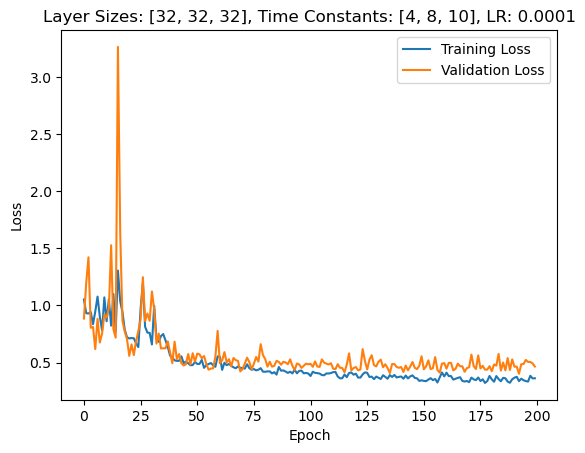

  0%|          | 1/200 [00:14<46:42, 14.08s/it]

Epoch 1/200, Training Loss: 1.0469471238694101, Validation Loss: 0.9107967615127563


  1%|          | 2/200 [00:27<45:56, 13.92s/it]

Epoch 2/200, Training Loss: 1.0769169139412214, Validation Loss: 0.8177243854318347


  2%|▏         | 3/200 [00:41<44:41, 13.61s/it]

Epoch 3/200, Training Loss: 2.295654332300402, Validation Loss: 0.8044304251670837


  2%|▏         | 4/200 [00:54<44:08, 13.51s/it]

Epoch 4/200, Training Loss: 0.9105953512326727, Validation Loss: 0.8030804012502942


  2%|▎         | 5/200 [01:07<43:19, 13.33s/it]

Epoch 5/200, Training Loss: 0.8559247187848361, Validation Loss: 0.7423532605171204


  3%|▎         | 6/200 [01:21<43:35, 13.48s/it]

Epoch 6/200, Training Loss: 0.7050017208423255, Validation Loss: 0.6196657759802682


  4%|▎         | 7/200 [01:35<44:06, 13.71s/it]

Epoch 7/200, Training Loss: 0.6399747729301453, Validation Loss: 0.5415212767464774


  4%|▍         | 8/200 [01:49<43:54, 13.72s/it]

Epoch 8/200, Training Loss: 0.6276145807976993, Validation Loss: 0.4764200321265629


  4%|▍         | 9/200 [02:03<44:00, 13.82s/it]

Epoch 9/200, Training Loss: 0.604873740448142, Validation Loss: 0.5070991260664803


  5%|▌         | 10/200 [02:17<43:53, 13.86s/it]

Epoch 10/200, Training Loss: 0.5699996599611247, Validation Loss: 0.46322615444660187


  6%|▌         | 11/200 [02:30<43:34, 13.83s/it]

Epoch 11/200, Training Loss: 0.5250502999098796, Validation Loss: 0.47719889879226685


  6%|▌         | 12/200 [02:44<42:57, 13.71s/it]

Epoch 12/200, Training Loss: 0.5126978409177853, Validation Loss: 0.5065008508307594


  6%|▋         | 13/200 [02:58<42:40, 13.69s/it]

Epoch 13/200, Training Loss: 0.5027812893660564, Validation Loss: 0.484821081161499


  7%|▋         | 14/200 [03:11<42:14, 13.62s/it]

Epoch 14/200, Training Loss: 0.48397772941949235, Validation Loss: 0.4711885643856866


  8%|▊         | 15/200 [03:25<42:20, 13.73s/it]

Epoch 15/200, Training Loss: 0.47092616473728754, Validation Loss: 0.45424970771585194


  8%|▊         | 16/200 [03:39<41:55, 13.67s/it]

Epoch 16/200, Training Loss: 0.4609811370665172, Validation Loss: 0.5604071489402226


  8%|▊         | 17/200 [03:52<41:08, 13.49s/it]

Epoch 17/200, Training Loss: 0.4552438661174954, Validation Loss: 0.5439585362161908


  9%|▉         | 18/200 [04:05<40:29, 13.35s/it]

Epoch 18/200, Training Loss: 0.443496306830982, Validation Loss: 0.49839341214724947


 10%|▉         | 19/200 [04:18<40:20, 13.38s/it]

Epoch 19/200, Training Loss: 0.4187456889534896, Validation Loss: 0.4599308541842869


 10%|█         | 20/200 [04:32<40:41, 13.56s/it]

Epoch 20/200, Training Loss: 0.42781186216282396, Validation Loss: 0.41861066222190857


 10%|█         | 21/200 [04:45<40:04, 13.43s/it]

Epoch 21/200, Training Loss: 0.38692699667980085, Validation Loss: 0.4336971810885838


 11%|█         | 22/200 [04:58<39:43, 13.39s/it]

Epoch 22/200, Training Loss: 0.382159689546756, Validation Loss: 0.4263963656766074


 12%|█▏        | 23/200 [05:12<39:16, 13.32s/it]

Epoch 23/200, Training Loss: 0.3740844690012482, Validation Loss: 0.407778799533844


 12%|█▏        | 24/200 [05:26<39:33, 13.49s/it]

Epoch 24/200, Training Loss: 0.402908019862085, Validation Loss: 0.41796946951321196


 12%|█▎        | 25/200 [05:39<39:18, 13.47s/it]

Epoch 25/200, Training Loss: 0.3622209133123452, Validation Loss: 0.43458916885512217


 13%|█▎        | 26/200 [05:52<38:35, 13.31s/it]

Epoch 26/200, Training Loss: 0.3658078914543368, Validation Loss: 0.4851462372711727


 14%|█▎        | 27/200 [06:05<38:08, 13.23s/it]

Epoch 27/200, Training Loss: 0.37285778010791204, Validation Loss: 0.42415505221911837


 14%|█▍        | 28/200 [06:18<38:08, 13.30s/it]

Epoch 28/200, Training Loss: 0.34677411503386946, Validation Loss: 0.46018525532313753


 14%|█▍        | 29/200 [06:31<37:36, 13.20s/it]

Epoch 29/200, Training Loss: 0.38061118519531106, Validation Loss: 0.438021006328719


 15%|█▌        | 30/200 [06:44<37:13, 13.14s/it]

Epoch 30/200, Training Loss: 0.3691730391023294, Validation Loss: 0.4198631601674216


 16%|█▌        | 31/200 [06:58<37:23, 13.28s/it]

Epoch 31/200, Training Loss: 0.3335499715692592, Validation Loss: 0.3927393725940159


 16%|█▌        | 32/200 [07:11<37:04, 13.24s/it]

Epoch 32/200, Training Loss: 0.3586844655702699, Validation Loss: 0.4043195183788027


 16%|█▋        | 33/200 [07:25<37:13, 13.37s/it]

Epoch 33/200, Training Loss: 0.35113145607822344, Validation Loss: 0.48884372413158417


 17%|█▋        | 34/200 [07:39<37:25, 13.53s/it]

Epoch 34/200, Training Loss: 0.3460997535653834, Validation Loss: 0.4622920198099954


 18%|█▊        | 35/200 [07:52<36:51, 13.40s/it]

Epoch 35/200, Training Loss: 0.32691135299655627, Validation Loss: 0.41875408376966206


 18%|█▊        | 36/200 [08:05<36:23, 13.31s/it]

Epoch 36/200, Training Loss: 0.3436165966515271, Validation Loss: 0.5771937519311905


 18%|█▊        | 37/200 [08:19<36:58, 13.61s/it]

Epoch 37/200, Training Loss: 0.3470305842611025, Validation Loss: 0.455664472920554


 19%|█▉        | 38/200 [08:32<36:17, 13.44s/it]

Epoch 38/200, Training Loss: 0.32446332416444457, Validation Loss: 0.45264963592801777


 20%|█▉        | 39/200 [08:45<35:51, 13.36s/it]

Epoch 39/200, Training Loss: 0.31619586416010587, Validation Loss: 0.4088332269872938


 20%|██        | 40/200 [08:59<35:39, 13.37s/it]

Epoch 40/200, Training Loss: 0.31694485050327376, Validation Loss: 0.40929052233695984


 20%|██        | 41/200 [09:12<35:10, 13.28s/it]

Epoch 41/200, Training Loss: 0.3117882918636754, Validation Loss: 0.4548291883298329


 21%|██        | 42/200 [09:25<34:46, 13.20s/it]

Epoch 42/200, Training Loss: 0.29670296946786484, Validation Loss: 0.41857264935970306


 22%|██▏       | 43/200 [09:39<34:53, 13.33s/it]

Epoch 43/200, Training Loss: 0.3344685119699757, Validation Loss: 0.3903458778347288


 22%|██▏       | 44/200 [09:52<34:25, 13.24s/it]

Epoch 44/200, Training Loss: 0.3242556469620399, Validation Loss: 0.44112699585301535


 22%|██▎       | 45/200 [10:05<34:08, 13.22s/it]

Epoch 45/200, Training Loss: 0.3313869093105478, Validation Loss: 0.420627053294863


 23%|██▎       | 46/200 [10:19<34:46, 13.55s/it]

Epoch 46/200, Training Loss: 0.32949202381215004, Validation Loss: 0.39826740111623493


 24%|██▎       | 47/200 [10:32<34:18, 13.46s/it]

Epoch 47/200, Training Loss: 0.30459934332460725, Validation Loss: 0.41196843130247934


 24%|██▍       | 48/200 [10:45<33:49, 13.35s/it]

Epoch 48/200, Training Loss: 0.2992482978218007, Validation Loss: 0.3778334877320698


 24%|██▍       | 49/200 [10:59<33:40, 13.38s/it]

Epoch 49/200, Training Loss: 0.3045556413818081, Validation Loss: 0.45129563765866415


 25%|██▌       | 50/200 [11:13<33:47, 13.51s/it]

Epoch 50/200, Training Loss: 0.29395554805139323, Validation Loss: 0.4040405239377703


 26%|██▌       | 51/200 [11:26<33:19, 13.42s/it]

Epoch 51/200, Training Loss: 0.291715237329591, Validation Loss: 0.3750470642532621


 26%|██▌       | 52/200 [11:39<33:08, 13.44s/it]

Epoch 52/200, Training Loss: 0.29733652972950125, Validation Loss: 0.37660658785275053


 26%|██▋       | 53/200 [11:53<32:43, 13.36s/it]

Epoch 53/200, Training Loss: 0.32255582181069087, Validation Loss: 0.3601598058428083


 27%|██▋       | 54/200 [12:06<32:16, 13.26s/it]

Epoch 54/200, Training Loss: 0.30517245098105017, Validation Loss: 0.4215336101395743


 28%|██▊       | 55/200 [12:19<32:16, 13.36s/it]

Epoch 55/200, Training Loss: 0.29097941897387775, Validation Loss: 0.38491456849234446


 28%|██▊       | 56/200 [12:32<31:48, 13.26s/it]

Epoch 56/200, Training Loss: 0.31311397901121174, Validation Loss: 0.4103781985385077


 28%|██▊       | 57/200 [12:45<31:26, 13.19s/it]

Epoch 57/200, Training Loss: 0.28524919866390946, Validation Loss: 0.36316542966025217


 29%|██▉       | 58/200 [12:59<31:27, 13.30s/it]

Epoch 58/200, Training Loss: 0.29024622982965326, Validation Loss: 0.37154911884239744


 30%|██▉       | 59/200 [13:13<31:46, 13.52s/it]

Epoch 59/200, Training Loss: 0.2955481286318797, Validation Loss: 0.35954853892326355


 30%|███       | 60/200 [13:26<31:22, 13.45s/it]

Epoch 60/200, Training Loss: 0.3140541338976824, Validation Loss: 0.35897942951747347


 30%|███       | 61/200 [13:40<31:11, 13.47s/it]

Epoch 61/200, Training Loss: 0.2939762411252508, Validation Loss: 0.3622813991137913


 31%|███       | 62/200 [13:53<30:44, 13.36s/it]

Epoch 62/200, Training Loss: 0.31285529752384944, Validation Loss: 0.3848121762275696


 32%|███▏      | 63/200 [14:07<30:53, 13.53s/it]

Epoch 63/200, Training Loss: 0.2967672307255133, Validation Loss: 0.42741983916078297


 32%|███▏      | 64/200 [14:20<30:47, 13.59s/it]

Epoch 64/200, Training Loss: 0.30723565043705814, Validation Loss: 0.3899826237133571


 32%|███▎      | 65/200 [14:33<30:15, 13.45s/it]

Epoch 65/200, Training Loss: 0.30436447684494955, Validation Loss: 0.36156556010246277


 33%|███▎      | 66/200 [14:47<29:45, 13.33s/it]

Epoch 66/200, Training Loss: 0.3213971792808119, Validation Loss: 0.373564281633922


 34%|███▎      | 67/200 [15:00<29:41, 13.39s/it]

Epoch 67/200, Training Loss: 0.2891298307562774, Validation Loss: 0.40474299447877066


 34%|███▍      | 68/200 [15:13<29:12, 13.28s/it]

Epoch 68/200, Training Loss: 0.29197286146710505, Validation Loss: 0.5561565905809402


 34%|███▍      | 69/200 [15:26<28:48, 13.20s/it]

Epoch 69/200, Training Loss: 0.30141435858775983, Validation Loss: 0.37787280338151114


 35%|███▌      | 70/200 [15:40<28:47, 13.29s/it]

Epoch 70/200, Training Loss: 0.2790156715321091, Validation Loss: 0.34873014049870626


 36%|███▌      | 71/200 [15:53<28:31, 13.27s/it]

Epoch 71/200, Training Loss: 0.29248943657807586, Validation Loss: 0.3716577802385603


 36%|███▌      | 72/200 [16:07<28:43, 13.47s/it]

Epoch 72/200, Training Loss: 0.29144002187926815, Validation Loss: 0.4341198759419577


 36%|███▋      | 73/200 [16:20<28:41, 13.56s/it]

Epoch 73/200, Training Loss: 0.30422472574238507, Validation Loss: 0.35688661464623045


 37%|███▋      | 74/200 [16:34<28:19, 13.49s/it]

Epoch 74/200, Training Loss: 0.2803595113866734, Validation Loss: 0.35949251375028063


 38%|███▊      | 75/200 [16:47<27:53, 13.38s/it]

Epoch 75/200, Training Loss: 0.2911093382621711, Validation Loss: 0.39052047048296246


 38%|███▊      | 76/200 [17:01<28:18, 13.70s/it]

Epoch 76/200, Training Loss: 0.30721036162016524, Validation Loss: 0.4097560111965452


 38%|███▊      | 77/200 [17:15<27:55, 13.62s/it]

Epoch 77/200, Training Loss: 0.29152203990884545, Validation Loss: 0.37996944572244373


 39%|███▉      | 78/200 [17:28<27:19, 13.43s/it]

Epoch 78/200, Training Loss: 0.2968167465812755, Validation Loss: 0.40324684764657703


 40%|███▉      | 79/200 [17:41<27:07, 13.45s/it]

Epoch 79/200, Training Loss: 0.28561184035157255, Validation Loss: 0.3581966097865786


 40%|████      | 80/200 [17:55<26:45, 13.38s/it]

Epoch 80/200, Training Loss: 0.2786910913462909, Validation Loss: 0.3623129853180477


 40%|████      | 81/200 [18:07<26:17, 13.26s/it]

Epoch 81/200, Training Loss: 0.2693053959113247, Validation Loss: 0.3843433942113604


 41%|████      | 82/200 [18:21<26:09, 13.30s/it]

Epoch 82/200, Training Loss: 0.2756734756085108, Validation Loss: 0.3677106818982533


 42%|████▏     | 83/200 [18:34<25:56, 13.30s/it]

Epoch 83/200, Training Loss: 0.26934491786754355, Validation Loss: 0.41721008718013763


 42%|████▏     | 84/200 [18:47<25:34, 13.22s/it]

Epoch 84/200, Training Loss: 0.27992288726118375, Validation Loss: 0.39422832429409027


 42%|████▎     | 85/200 [19:02<25:59, 13.56s/it]

Epoch 85/200, Training Loss: 0.2902543155371018, Validation Loss: 0.40946175370897564


 43%|████▎     | 86/200 [19:15<25:39, 13.50s/it]

Epoch 86/200, Training Loss: 0.2680371332702772, Validation Loss: 0.3822425199406488


 44%|████▎     | 87/200 [19:28<25:16, 13.42s/it]

Epoch 87/200, Training Loss: 0.2802388728508409, Validation Loss: 0.3869859682662146


 44%|████▍     | 88/200 [19:42<25:04, 13.44s/it]

Epoch 88/200, Training Loss: 0.2585365421507718, Validation Loss: 0.3808977135590145


 44%|████▍     | 89/200 [19:56<25:12, 13.62s/it]

Epoch 89/200, Training Loss: 0.26960163113643537, Validation Loss: 0.3944879472255707


 45%|████▌     | 90/200 [20:09<24:47, 13.52s/it]

Epoch 90/200, Training Loss: 0.32040671849588176, Validation Loss: 0.3646859952381679


 46%|████▌     | 91/200 [20:22<24:30, 13.50s/it]

Epoch 91/200, Training Loss: 0.2833732967528532, Validation Loss: 0.41771142184734344


 46%|████▌     | 92/200 [20:36<24:08, 13.41s/it]

Epoch 92/200, Training Loss: 0.27823774783678773, Validation Loss: 0.37305439582892824


 46%|████▋     | 93/200 [20:49<23:45, 13.32s/it]

Epoch 93/200, Training Loss: 0.2678820027635907, Validation Loss: 0.37342444700854166


 47%|████▋     | 94/200 [21:02<23:31, 13.32s/it]

Epoch 94/200, Training Loss: 0.26894078150672734, Validation Loss: 0.39391279220581055


 48%|████▊     | 95/200 [21:15<23:20, 13.34s/it]

Epoch 95/200, Training Loss: 0.25857832465531694, Validation Loss: 0.43846183376652853


 48%|████▊     | 96/200 [21:28<22:58, 13.25s/it]

Epoch 96/200, Training Loss: 0.2723551311020581, Validation Loss: 0.4070804693869182


 48%|████▊     | 97/200 [21:42<22:43, 13.24s/it]

Epoch 97/200, Training Loss: 0.2665248352963969, Validation Loss: 0.36226375081709455


 49%|████▉     | 98/200 [21:56<23:02, 13.56s/it]

Epoch 98/200, Training Loss: 0.26105294573419496, Validation Loss: 0.39789057842322756


 50%|████▉     | 99/200 [22:09<22:46, 13.53s/it]

Epoch 99/200, Training Loss: 0.27948019217770054, Validation Loss: 0.3704791877950941


 50%|█████     | 100/200 [22:23<22:28, 13.48s/it]

Epoch 100/200, Training Loss: 0.2714477710004123, Validation Loss: 0.39665955517973217


 50%|█████     | 101/200 [22:36<22:13, 13.47s/it]

Epoch 101/200, Training Loss: 0.2579422748454337, Validation Loss: 0.4519902765750885


 51%|█████     | 102/200 [22:50<22:17, 13.65s/it]

Epoch 102/200, Training Loss: 0.27635082953943396, Validation Loss: 0.39191735216549467


 52%|█████▏    | 103/200 [23:04<22:02, 13.63s/it]

Epoch 103/200, Training Loss: 0.27049639568013967, Validation Loss: 0.40939020259039743


 52%|█████▏    | 104/200 [23:17<21:37, 13.52s/it]

Epoch 104/200, Training Loss: 0.2550699755830585, Validation Loss: 0.37617121423993793


 52%|█████▎    | 105/200 [23:30<21:12, 13.40s/it]

Epoch 105/200, Training Loss: 0.27413667316706675, Validation Loss: 0.38616875452654703


 53%|█████▎    | 106/200 [23:44<20:59, 13.40s/it]

Epoch 106/200, Training Loss: 0.27359111986632617, Validation Loss: 0.3516769068581717


 54%|█████▎    | 107/200 [23:57<20:43, 13.38s/it]

Epoch 107/200, Training Loss: 0.2567772133592165, Validation Loss: 0.3837690843003137


 54%|█████▍    | 108/200 [24:10<20:25, 13.32s/it]

Epoch 108/200, Training Loss: 0.27144682913456325, Validation Loss: 0.36436099878379274


 55%|█████▍    | 109/200 [24:23<20:10, 13.30s/it]

Epoch 109/200, Training Loss: 0.2520124796988829, Validation Loss: 0.42543283104896545


 55%|█████▌    | 110/200 [24:37<20:02, 13.36s/it]

Epoch 110/200, Training Loss: 0.27216161534471334, Validation Loss: 0.3714882241828101


 56%|█████▌    | 111/200 [24:51<20:05, 13.54s/it]

Epoch 111/200, Training Loss: 0.268191766767007, Validation Loss: 0.3880408981016704


 56%|█████▌    | 112/200 [25:05<19:53, 13.57s/it]

Epoch 112/200, Training Loss: 0.26635237895655184, Validation Loss: 0.3850873346839632


 56%|█████▋    | 113/200 [25:18<19:36, 13.53s/it]

Epoch 113/200, Training Loss: 0.27204072700356535, Validation Loss: 0.3590344956942967


 57%|█████▋    | 114/200 [25:31<19:12, 13.40s/it]

Epoch 114/200, Training Loss: 0.26501465349827175, Validation Loss: 0.34037739357778


 57%|█████▊    | 115/200 [25:45<19:19, 13.65s/it]

Epoch 115/200, Training Loss: 0.2477305551182549, Validation Loss: 0.3561490646430424


 58%|█████▊    | 116/200 [25:59<19:02, 13.60s/it]

Epoch 116/200, Training Loss: 0.25671117260770976, Validation Loss: 0.35182982470308033


 58%|█████▊    | 117/200 [26:12<18:35, 13.44s/it]

Epoch 117/200, Training Loss: 0.2579121914393497, Validation Loss: 0.3683819706950869


 59%|█████▉    | 118/200 [26:25<18:16, 13.37s/it]

Epoch 118/200, Training Loss: 0.2507575174688168, Validation Loss: 0.3437339525137629


 60%|█████▉    | 119/200 [26:39<18:05, 13.40s/it]

Epoch 119/200, Training Loss: 0.2490747372075072, Validation Loss: 0.3662110822541373


 60%|██████    | 120/200 [26:52<17:43, 13.29s/it]

Epoch 120/200, Training Loss: 0.2666292291767192, Validation Loss: 0.35691240429878235


 60%|██████    | 121/200 [27:05<17:31, 13.31s/it]

Epoch 121/200, Training Loss: 0.25556382326022636, Validation Loss: 0.3793762858424868


 61%|██████    | 122/200 [27:18<17:21, 13.35s/it]

Epoch 122/200, Training Loss: 0.28453481011092663, Validation Loss: 0.3666024442229952


 62%|██████▏   | 123/200 [27:31<17:01, 13.26s/it]

Epoch 123/200, Training Loss: 0.25098400485684286, Validation Loss: 0.3907053364174707


 62%|██████▏   | 124/200 [27:46<17:07, 13.52s/it]

Epoch 124/200, Training Loss: 0.2519515435791241, Validation Loss: 0.3777402341365814


 62%|██████▎   | 125/200 [27:59<17:00, 13.60s/it]

Epoch 125/200, Training Loss: 0.239484083434602, Validation Loss: 0.35339052762304035


 63%|██████▎   | 126/200 [28:13<16:36, 13.46s/it]

Epoch 126/200, Training Loss: 0.26540541676980145, Validation Loss: 0.3482888053570475


 64%|██████▎   | 127/200 [28:26<16:14, 13.35s/it]

Epoch 127/200, Training Loss: 0.2521232615383166, Validation Loss: 0.36770695075392723


 64%|██████▍   | 128/200 [28:40<16:25, 13.69s/it]

Epoch 128/200, Training Loss: 0.2586741293516924, Validation Loss: 0.36488048519407


 64%|██████▍   | 129/200 [28:53<16:01, 13.54s/it]

Epoch 129/200, Training Loss: 0.2598069986363627, Validation Loss: 0.4349002561398915


 65%|██████▌   | 130/200 [29:06<15:39, 13.42s/it]

Epoch 130/200, Training Loss: 0.2553871267668481, Validation Loss: 0.3562599058662142


 66%|██████▌   | 131/200 [29:20<15:28, 13.46s/it]

Epoch 131/200, Training Loss: 0.2641153518321379, Validation Loss: 0.3676651918462345


 66%|██████▌   | 132/200 [29:33<15:06, 13.33s/it]

Epoch 132/200, Training Loss: 0.2688756266714267, Validation Loss: 0.36015484801360537


 66%|██████▋   | 133/200 [29:46<14:48, 13.26s/it]

Epoch 133/200, Training Loss: 0.24667322509131343, Validation Loss: 0.3761601575783321


 67%|██████▋   | 134/200 [30:00<14:43, 13.39s/it]

Epoch 134/200, Training Loss: 0.23667009522751817, Validation Loss: 0.32910500147512983


 68%|██████▊   | 135/200 [30:13<14:25, 13.31s/it]

Epoch 135/200, Training Loss: 0.24835504078358975, Validation Loss: 0.36853381991386414


 68%|██████▊   | 136/200 [30:26<14:10, 13.28s/it]

Epoch 136/200, Training Loss: 0.24599496879667607, Validation Loss: 0.3820926036153521


 68%|██████▊   | 137/200 [30:41<14:17, 13.61s/it]

Epoch 137/200, Training Loss: 0.25641421917474494, Validation Loss: 0.4022993253810065


 69%|██████▉   | 138/200 [30:54<13:59, 13.55s/it]

Epoch 138/200, Training Loss: 0.2450361374133038, Validation Loss: 0.34294493389981134


 70%|██████▉   | 139/200 [31:07<13:36, 13.38s/it]

Epoch 139/200, Training Loss: 0.25345717904702675, Validation Loss: 0.40066260525158476


 70%|███████   | 140/200 [31:21<13:28, 13.47s/it]

Epoch 140/200, Training Loss: 0.26966327513163946, Validation Loss: 0.3402140608855656


 70%|███████   | 141/200 [31:35<13:24, 13.64s/it]

Epoch 141/200, Training Loss: 0.25182454541044413, Validation Loss: 0.35463535359927584


 71%|███████   | 142/200 [31:48<13:03, 13.51s/it]

Epoch 142/200, Training Loss: 0.23643944004796585, Validation Loss: 0.37223043186323984


 72%|███████▏  | 143/200 [32:01<12:52, 13.56s/it]

Epoch 143/200, Training Loss: 0.2516235775261555, Validation Loss: 0.3680484944156238


 72%|███████▏  | 144/200 [32:15<12:31, 13.41s/it]

Epoch 144/200, Training Loss: 0.257539838271321, Validation Loss: 0.4010249695607594


 72%|███████▎  | 145/200 [32:28<12:13, 13.34s/it]

Epoch 145/200, Training Loss: 0.2626436029402715, Validation Loss: 0.33999073079654146


 73%|███████▎  | 146/200 [32:41<12:06, 13.46s/it]

Epoch 146/200, Training Loss: 0.2683361048968333, Validation Loss: 0.3327017149754933


 74%|███████▎  | 147/200 [32:55<11:50, 13.41s/it]

Epoch 147/200, Training Loss: 0.25359237348695973, Validation Loss: 0.363100175346647


 74%|███████▍  | 148/200 [33:08<11:32, 13.32s/it]

Epoch 148/200, Training Loss: 0.2452726812576348, Validation Loss: 0.353866454746042


 74%|███████▍  | 149/200 [33:22<11:24, 13.41s/it]

Epoch 149/200, Training Loss: 0.24198363552678306, Validation Loss: 0.34946913378579275


 75%|███████▌  | 150/200 [33:35<11:18, 13.58s/it]

Epoch 150/200, Training Loss: 0.23244378209676383, Validation Loss: 0.3907826095819473


 76%|███████▌  | 151/200 [33:49<11:03, 13.54s/it]

Epoch 151/200, Training Loss: 0.23746018153878878, Validation Loss: 0.35653051840407507


 76%|███████▌  | 152/200 [34:02<10:50, 13.55s/it]

Epoch 152/200, Training Loss: 0.22843478303754106, Validation Loss: 0.3916466534137726


 76%|███████▋  | 153/200 [34:16<10:41, 13.65s/it]

Epoch 153/200, Training Loss: 0.2380864825451149, Validation Loss: 0.33570014366081785


 77%|███████▋  | 154/200 [34:30<10:24, 13.59s/it]

Epoch 154/200, Training Loss: 0.2432157945520473, Validation Loss: 0.34277372700827463


 78%|███████▊  | 155/200 [34:43<10:11, 13.60s/it]

Epoch 155/200, Training Loss: 0.23643408026897683, Validation Loss: 0.35616893214838846


 78%|███████▊  | 156/200 [34:56<09:50, 13.43s/it]

Epoch 156/200, Training Loss: 0.25797054115331397, Validation Loss: 0.38654421057019916


 78%|███████▊  | 157/200 [35:10<09:32, 13.32s/it]

Epoch 157/200, Training Loss: 0.2611912558874432, Validation Loss: 0.3750196099281311


 79%|███████▉  | 158/200 [35:24<09:32, 13.62s/it]

Epoch 158/200, Training Loss: 0.24532413384262122, Validation Loss: 0.35450634573187145


 80%|███████▉  | 159/200 [35:37<09:13, 13.50s/it]

Epoch 159/200, Training Loss: 0.2418609918007311, Validation Loss: 0.3524611975465502


 80%|████████  | 160/200 [35:50<08:55, 13.40s/it]

Epoch 160/200, Training Loss: 0.24642825548378927, Validation Loss: 0.32764175853558947


 80%|████████  | 161/200 [36:04<08:43, 13.43s/it]

Epoch 161/200, Training Loss: 0.23980373298784471, Validation Loss: 0.33756602981260847


 81%|████████  | 162/200 [36:18<08:37, 13.62s/it]

Epoch 162/200, Training Loss: 0.23606260335248597, Validation Loss: 0.3574208893946239


 82%|████████▏ | 163/200 [36:31<08:19, 13.50s/it]

Epoch 163/200, Training Loss: 0.2334604044005556, Validation Loss: 0.3361221317734037


 82%|████████▏ | 164/200 [36:45<08:08, 13.57s/it]

Epoch 164/200, Training Loss: 0.22233228160525267, Validation Loss: 0.3417151958814689


 82%|████████▎ | 165/200 [36:58<07:51, 13.48s/it]

Epoch 165/200, Training Loss: 0.24324968295558444, Validation Loss: 0.33289400381701334


 83%|████████▎ | 166/200 [37:12<07:42, 13.59s/it]

Epoch 166/200, Training Loss: 0.23855062932619508, Validation Loss: 0.3491522754941668


 84%|████████▎ | 167/200 [37:26<07:30, 13.65s/it]

Epoch 167/200, Training Loss: 0.24532267676209504, Validation Loss: 0.34470669605902265


 84%|████████▍ | 168/200 [37:39<07:13, 13.55s/it]

Epoch 168/200, Training Loss: 0.22963360013475395, Validation Loss: 0.3778360038995743


 84%|████████▍ | 169/200 [37:52<06:56, 13.43s/it]

Epoch 169/200, Training Loss: 0.22526554798461357, Validation Loss: 0.3582900209086282


 85%|████████▌ | 170/200 [38:06<06:43, 13.46s/it]

Epoch 170/200, Training Loss: 0.21587352018873646, Validation Loss: 0.3693509591477258


 86%|████████▌ | 171/200 [38:19<06:28, 13.39s/it]

Epoch 171/200, Training Loss: 0.23036744283898822, Validation Loss: 0.33979103182043346


 86%|████████▌ | 172/200 [38:32<06:13, 13.35s/it]

Epoch 172/200, Training Loss: 0.22631524538375297, Validation Loss: 0.3724512053387506


 86%|████████▋ | 173/200 [38:46<06:01, 13.39s/it]

Epoch 173/200, Training Loss: 0.23131295196922882, Validation Loss: 0.3437508334006582


 87%|████████▋ | 174/200 [38:59<05:47, 13.37s/it]

Epoch 174/200, Training Loss: 0.23740495860857783, Validation Loss: 0.36422828265598844


 88%|████████▊ | 175/200 [39:13<05:38, 13.53s/it]

Epoch 175/200, Training Loss: 0.2553213375075808, Validation Loss: 0.3912749599133219


 88%|████████▊ | 176/200 [39:26<05:25, 13.55s/it]

Epoch 176/200, Training Loss: 0.24585757369421563, Validation Loss: 0.3647941138063158


 88%|████████▊ | 177/200 [39:40<05:09, 13.47s/it]

Epoch 177/200, Training Loss: 0.24230779805835687, Validation Loss: 0.37606806627341677


 89%|████████▉ | 178/200 [39:53<04:55, 13.43s/it]

Epoch 178/200, Training Loss: 0.22623323269610135, Validation Loss: 0.3340677650911467


 90%|████████▉ | 179/200 [40:07<04:47, 13.69s/it]

Epoch 179/200, Training Loss: 0.2276859867544669, Validation Loss: 0.35199014842510223


 90%|█████████ | 180/200 [40:21<04:32, 13.61s/it]

Epoch 180/200, Training Loss: 0.2582182914440362, Validation Loss: 0.3578948378562927


 90%|█████████ | 181/200 [40:34<04:15, 13.47s/it]

Epoch 181/200, Training Loss: 0.22890241676062908, Validation Loss: 0.37411714238779886


 91%|█████████ | 182/200 [40:48<04:03, 13.52s/it]

Epoch 182/200, Training Loss: 0.24166154748988602, Validation Loss: 0.33444547759635107


 92%|█████████▏| 183/200 [41:01<03:48, 13.46s/it]

Epoch 183/200, Training Loss: 0.237777755789037, Validation Loss: 0.33484398307544844


 92%|█████████▏| 184/200 [41:14<03:33, 13.37s/it]

Epoch 184/200, Training Loss: 0.2586840273777269, Validation Loss: 0.3341797632830484


 92%|█████████▎| 185/200 [41:27<03:20, 13.37s/it]

Epoch 185/200, Training Loss: 0.23249296000543632, Validation Loss: 0.3357520763363157


 93%|█████████▎| 186/200 [41:41<03:07, 13.40s/it]

Epoch 186/200, Training Loss: 0.22232832977513098, Validation Loss: 0.35743977768080576


 94%|█████████▎| 187/200 [41:54<02:53, 13.32s/it]

Epoch 187/200, Training Loss: 0.2313832568953622, Validation Loss: 0.3410660581929343


 94%|█████████▍| 188/200 [42:08<02:43, 13.63s/it]

Epoch 188/200, Training Loss: 0.23283767714253012, Validation Loss: 0.3474616812808173


 94%|█████████▍| 189/200 [42:22<02:29, 13.61s/it]

Epoch 189/200, Training Loss: 0.2200970953365542, Validation Loss: 0.3637893625668117


 95%|█████████▌| 190/200 [42:35<02:14, 13.48s/it]

Epoch 190/200, Training Loss: 0.22885224961166112, Validation Loss: 0.33355472662619184


 96%|█████████▌| 191/200 [42:48<02:01, 13.45s/it]

Epoch 191/200, Training Loss: 0.22181664097983883, Validation Loss: 0.3583482397454126


 96%|█████████▌| 192/200 [43:03<01:50, 13.79s/it]

Epoch 192/200, Training Loss: 0.2263120878839268, Validation Loss: 0.33546468189784456


 96%|█████████▋| 193/200 [43:16<01:35, 13.63s/it]

Epoch 193/200, Training Loss: 0.22690332933979215, Validation Loss: 0.3349641976611955


 97%|█████████▋| 194/200 [43:30<01:21, 13.54s/it]

Epoch 194/200, Training Loss: 0.22161181636576383, Validation Loss: 0.3213319650718144


 98%|█████████▊| 195/200 [43:43<01:07, 13.51s/it]

Epoch 195/200, Training Loss: 0.21806638216916122, Validation Loss: 0.3572221951825278


 98%|█████████▊| 196/200 [43:56<00:53, 13.44s/it]

Epoch 196/200, Training Loss: 0.22873018625772223, Validation Loss: 0.34121365366237505


 98%|█████████▊| 197/200 [44:10<00:40, 13.38s/it]

Epoch 197/200, Training Loss: 0.21250472527067615, Validation Loss: 0.3046188418354307


 99%|█████████▉| 198/200 [44:23<00:26, 13.43s/it]

Epoch 198/200, Training Loss: 0.21681246421528313, Validation Loss: 0.33746094575950075


100%|█████████▉| 199/200 [44:36<00:13, 13.34s/it]

Epoch 199/200, Training Loss: 0.2202933891764227, Validation Loss: 0.337762933756624


100%|██████████| 200/200 [44:50<00:00, 13.45s/it]

Epoch 200/200, Training Loss: 0.23444886052242989, Validation Loss: 0.3251621669956616
Final Accuracy: 93.96%, Precision: 0.95, Recall: 0.93


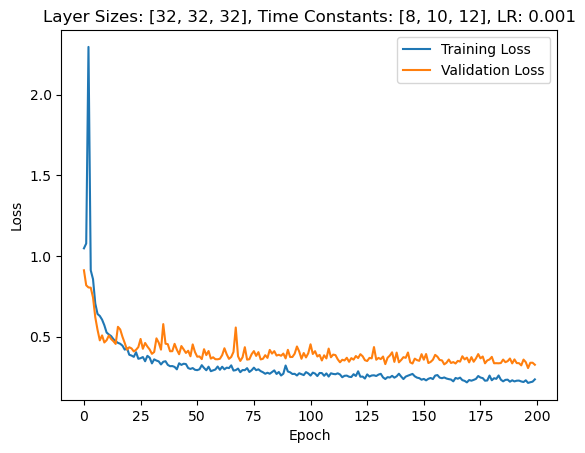

  0%|          | 1/200 [00:13<46:19, 13.97s/it]

Epoch 1/200, Training Loss: 0.9918333561915271, Validation Loss: 0.6484821268490383


  1%|          | 2/200 [00:27<45:29, 13.79s/it]

Epoch 2/200, Training Loss: 1.086736043669143, Validation Loss: 0.9978176270212445


  2%|▏         | 3/200 [00:41<44:44, 13.63s/it]

Epoch 3/200, Training Loss: 0.8267192840576172, Validation Loss: 0.6710210868290493


  2%|▏         | 4/200 [00:54<43:54, 13.44s/it]

Epoch 4/200, Training Loss: 0.7644561470117209, Validation Loss: 0.6087543559925896


  2%|▎         | 5/200 [01:07<43:05, 13.26s/it]

Epoch 5/200, Training Loss: 0.7752253536908131, Validation Loss: 0.5874319608722415


  3%|▎         | 6/200 [01:21<43:37, 13.49s/it]

Epoch 6/200, Training Loss: 0.6728896509926274, Validation Loss: 0.582668519445828


  4%|▎         | 7/200 [01:35<43:55, 13.65s/it]

Epoch 7/200, Training Loss: 0.6969367738039989, Validation Loss: 0.7305007129907608


  4%|▍         | 8/200 [01:48<43:49, 13.70s/it]

Epoch 8/200, Training Loss: 0.6811650856485907, Validation Loss: 0.6472892335483006


  4%|▍         | 9/200 [02:03<44:08, 13.87s/it]

Epoch 9/200, Training Loss: 0.6372504965314325, Validation Loss: 0.6969614241804395


  5%|▌         | 10/200 [02:16<43:47, 13.83s/it]

Epoch 10/200, Training Loss: 0.7301488659291897, Validation Loss: 0.6923978690590177


  6%|▌         | 11/200 [02:30<42:53, 13.62s/it]

Epoch 11/200, Training Loss: 0.7631202368241436, Validation Loss: 0.549872698528426


  6%|▌         | 12/200 [02:44<43:06, 13.76s/it]

Epoch 12/200, Training Loss: 0.6205014130979214, Validation Loss: 0.6997081828968865


  6%|▋         | 13/200 [02:57<42:21, 13.59s/it]

Epoch 13/200, Training Loss: 0.6122527771963263, Validation Loss: 0.72270795915808


  7%|▋         | 14/200 [03:10<41:30, 13.39s/it]

Epoch 14/200, Training Loss: 0.6222639280670094, Validation Loss: 0.7271838145596641


  8%|▊         | 15/200 [03:23<41:05, 13.33s/it]

Epoch 15/200, Training Loss: 0.6229182537996544, Validation Loss: 0.627428222979818


  8%|▊         | 16/200 [03:37<41:35, 13.56s/it]

Epoch 16/200, Training Loss: 0.6128896857207676, Validation Loss: 0.7350858705384391


  8%|▊         | 17/200 [03:50<40:58, 13.43s/it]

Epoch 17/200, Training Loss: 0.6138331440259825, Validation Loss: 0.6502140441111156


  9%|▉         | 18/200 [04:03<40:24, 13.32s/it]

Epoch 18/200, Training Loss: 0.6286873986136239, Validation Loss: 0.6955385655164719


 10%|▉         | 19/200 [04:16<40:09, 13.31s/it]

Epoch 19/200, Training Loss: 0.6930143641975691, Validation Loss: 0.827287203499249


 10%|█         | 20/200 [04:30<39:51, 13.28s/it]

Epoch 20/200, Training Loss: 0.5931633702426586, Validation Loss: 0.7350554977144513


 10%|█         | 21/200 [04:43<40:02, 13.42s/it]

Epoch 21/200, Training Loss: 0.5914317948638268, Validation Loss: 0.6481517532042095


 11%|█         | 22/200 [04:57<39:50, 13.43s/it]

Epoch 22/200, Training Loss: 0.5625459998846054, Validation Loss: 0.5256954921143395


 12%|█▏        | 23/200 [05:10<39:20, 13.34s/it]

Epoch 23/200, Training Loss: 0.6489236137636427, Validation Loss: 0.7110469894749778


 12%|█▏        | 24/200 [05:23<38:48, 13.23s/it]

Epoch 24/200, Training Loss: 0.5601108327226819, Validation Loss: 0.7344791889190674


 12%|█▎        | 25/200 [05:37<39:30, 13.54s/it]

Epoch 25/200, Training Loss: 0.5348642713056421, Validation Loss: 0.6754708460399083


 13%|█▎        | 26/200 [05:50<38:51, 13.40s/it]

Epoch 26/200, Training Loss: 0.5596133478969898, Validation Loss: 0.8016520270279476


 14%|█▎        | 27/200 [06:03<38:20, 13.30s/it]

Epoch 27/200, Training Loss: 0.786995530690787, Validation Loss: 1.4066791576998574


 14%|█▍        | 28/200 [06:17<38:10, 13.32s/it]

Epoch 28/200, Training Loss: 0.6156021424059598, Validation Loss: 0.6873907766171864


 14%|█▍        | 29/200 [06:30<37:34, 13.18s/it]

Epoch 29/200, Training Loss: 0.5674192180048745, Validation Loss: 0.6601678462965148


 15%|█▌        | 30/200 [06:43<37:05, 13.09s/it]

Epoch 30/200, Training Loss: 0.6053850386502608, Validation Loss: 0.7602321952581406


 16%|█▌        | 31/200 [06:56<37:22, 13.27s/it]

Epoch 31/200, Training Loss: 0.640967089050221, Validation Loss: 0.7557290920189449


 16%|█▌        | 32/200 [07:10<37:20, 13.33s/it]

Epoch 32/200, Training Loss: 0.6101518278976656, Validation Loss: 0.7924602627754211


 16%|█▋        | 33/200 [07:23<36:52, 13.25s/it]

Epoch 33/200, Training Loss: 0.5412333922566108, Validation Loss: 0.8039202647549766


 17%|█▋        | 34/200 [07:37<37:49, 13.67s/it]

Epoch 34/200, Training Loss: 0.5465156301012579, Validation Loss: 0.8471167300428663


 18%|█▊        | 35/200 [07:51<37:28, 13.63s/it]

Epoch 35/200, Training Loss: 0.5984947259696025, Validation Loss: 0.8165406989199775


 18%|█▊        | 36/200 [08:04<36:57, 13.52s/it]

Epoch 36/200, Training Loss: 0.6322295547656294, Validation Loss: 0.8198699866022382


 18%|█▊        | 37/200 [08:18<36:44, 13.52s/it]

Epoch 37/200, Training Loss: 0.5972404884842207, Validation Loss: 0.6679997103554862


 19%|█▉        | 38/200 [08:32<37:04, 13.73s/it]

Epoch 38/200, Training Loss: 0.5696881480936734, Validation Loss: 0.8265652869428907


 20%|█▉        | 39/200 [08:45<36:29, 13.60s/it]

Epoch 39/200, Training Loss: 0.6394257691671263, Validation Loss: 0.7283437209469932


 20%|██        | 40/200 [08:58<35:59, 13.50s/it]

Epoch 40/200, Training Loss: 0.5414997029979274, Validation Loss: 0.6741275553192411


 20%|██        | 41/200 [09:12<35:24, 13.36s/it]

Epoch 41/200, Training Loss: 0.5527775852747683, Validation Loss: 0.827227417911802


 21%|██        | 42/200 [09:25<34:55, 13.27s/it]

Epoch 42/200, Training Loss: 0.7780414493578784, Validation Loss: 1.4300891075815474


 22%|██▏       | 43/200 [09:38<34:39, 13.25s/it]

Epoch 43/200, Training Loss: 0.6128441306217661, Validation Loss: 0.7447531627757209


 22%|██▏       | 44/200 [09:51<34:30, 13.27s/it]

Epoch 44/200, Training Loss: 0.5338938137832677, Validation Loss: 0.7479930222034454


 22%|██▎       | 45/200 [10:04<34:10, 13.23s/it]

Epoch 45/200, Training Loss: 0.5280244766541247, Validation Loss: 0.5799739637545177


 23%|██▎       | 46/200 [10:17<33:48, 13.17s/it]

Epoch 46/200, Training Loss: 0.5166397173449678, Validation Loss: 0.7007112715925489


 24%|██▎       | 47/200 [10:31<34:22, 13.48s/it]

Epoch 47/200, Training Loss: 0.5921222573181368, Validation Loss: 0.7380896785429546


 24%|██▍       | 48/200 [10:45<33:57, 13.40s/it]

Epoch 48/200, Training Loss: 0.5162643795868136, Validation Loss: 0.644985264965466


 24%|██▍       | 49/200 [10:59<34:10, 13.58s/it]

Epoch 49/200, Training Loss: 0.4819913340627022, Validation Loss: 0.813809701374599


 25%|██▌       | 50/200 [11:13<34:33, 13.82s/it]

Epoch 50/200, Training Loss: 0.5666136083737859, Validation Loss: 0.7451589618410382


 26%|██▌       | 51/200 [11:27<34:22, 13.85s/it]

Epoch 51/200, Training Loss: 0.5446680221917495, Validation Loss: 0.7324891260692051


 26%|██▌       | 52/200 [11:40<33:52, 13.73s/it]

Epoch 52/200, Training Loss: 0.5378963030734152, Validation Loss: 0.8143015503883362


 26%|██▋       | 53/200 [11:54<33:21, 13.62s/it]

Epoch 53/200, Training Loss: 0.5173654933020754, Validation Loss: 0.7300713743482318


 27%|██▋       | 54/200 [12:07<32:44, 13.46s/it]

Epoch 54/200, Training Loss: 0.5603336838056456, Validation Loss: 0.8354590428727013


 28%|██▊       | 55/200 [12:20<32:09, 13.31s/it]

Epoch 55/200, Training Loss: 0.5194410029447304, Validation Loss: 0.7115642534834998


 28%|██▊       | 56/200 [12:33<32:00, 13.34s/it]

Epoch 56/200, Training Loss: 0.5171958683234341, Validation Loss: 0.5962079507963998


 28%|██▊       | 57/200 [12:46<31:35, 13.26s/it]

Epoch 57/200, Training Loss: 0.5650938080166871, Validation Loss: 0.6687845885753632


 29%|██▉       | 58/200 [12:59<31:13, 13.19s/it]

Epoch 58/200, Training Loss: 0.627051481098499, Validation Loss: 0.6029083771365029


 30%|██▉       | 59/200 [13:13<31:12, 13.28s/it]

Epoch 59/200, Training Loss: 0.5263897531999732, Validation Loss: 0.7336581477097103


 30%|███       | 60/200 [13:27<31:17, 13.41s/it]

Epoch 60/200, Training Loss: 0.6058194839729453, Validation Loss: 0.8579187095165253


 30%|███       | 61/200 [13:40<30:58, 13.37s/it]

Epoch 61/200, Training Loss: 0.5284722481133803, Validation Loss: 0.7443228151117053


 31%|███       | 62/200 [13:54<30:58, 13.46s/it]

Epoch 62/200, Training Loss: 0.5104773008036163, Validation Loss: 0.7114198697464806


 32%|███▏      | 63/200 [14:06<30:25, 13.32s/it]

Epoch 63/200, Training Loss: 0.5289514081658058, Validation Loss: 0.7739589512348175


 32%|███▏      | 64/200 [14:20<30:31, 13.47s/it]

Epoch 64/200, Training Loss: 0.5879708497591738, Validation Loss: 0.6919835082122258


 32%|███▎      | 65/200 [14:34<30:24, 13.52s/it]

Epoch 65/200, Training Loss: 0.5197967861620885, Validation Loss: 0.5921799519232341


 33%|███▎      | 66/200 [14:47<29:56, 13.41s/it]

Epoch 66/200, Training Loss: 0.4961406799419871, Validation Loss: 0.667170341525759


 34%|███▎      | 67/200 [15:00<29:25, 13.27s/it]

Epoch 67/200, Training Loss: 0.5324508958267715, Validation Loss: 0.7089638922895704


 34%|███▍      | 68/200 [15:13<29:18, 13.33s/it]

Epoch 68/200, Training Loss: 0.5252348853732055, Validation Loss: 0.8798025165285382


 34%|███▍      | 69/200 [15:27<29:00, 13.28s/it]

Epoch 69/200, Training Loss: 0.5371761816852497, Validation Loss: 0.7098154468195779


 35%|███▌      | 70/200 [15:40<28:34, 13.19s/it]

Epoch 70/200, Training Loss: 0.6444959775456842, Validation Loss: 0.6617199054786137


 36%|███▌      | 71/200 [15:53<28:23, 13.20s/it]

Epoch 71/200, Training Loss: 0.5207455667122355, Validation Loss: 0.5069559046200344


 36%|███▌      | 72/200 [16:06<28:06, 13.17s/it]

Epoch 72/200, Training Loss: 0.5088069244938077, Validation Loss: 0.626009885753904


 36%|███▋      | 73/200 [16:20<28:16, 13.36s/it]

Epoch 73/200, Training Loss: 0.5499315767917993, Validation Loss: 0.5925251628671374


 37%|███▋      | 74/200 [16:34<28:17, 13.47s/it]

Epoch 74/200, Training Loss: 0.6447518763114821, Validation Loss: 0.6512295220579419


 38%|███▊      | 75/200 [16:47<27:55, 13.40s/it]

Epoch 75/200, Training Loss: 0.5052613655351242, Validation Loss: 0.5335376624550138


 38%|███▊      | 76/200 [17:00<27:25, 13.27s/it]

Epoch 76/200, Training Loss: 0.5685464073464556, Validation Loss: 0.5553877651691437


 38%|███▊      | 77/200 [17:14<27:40, 13.50s/it]

Epoch 77/200, Training Loss: 0.48432991920777085, Validation Loss: 0.5947461617844445


 39%|███▉      | 78/200 [17:27<27:32, 13.54s/it]

Epoch 78/200, Training Loss: 0.49876771529890457, Validation Loss: 0.6182200951235635


 40%|███▉      | 79/200 [17:40<26:55, 13.35s/it]

Epoch 79/200, Training Loss: 0.4855279526058233, Validation Loss: 0.744908081633704


 40%|████      | 80/200 [17:53<26:32, 13.27s/it]

Epoch 80/200, Training Loss: 0.4684648274813058, Validation Loss: 0.6103877212320056


 40%|████      | 81/200 [18:07<26:27, 13.34s/it]

Epoch 81/200, Training Loss: 0.49814950660714563, Validation Loss: 0.6383507081440517


 41%|████      | 82/200 [18:20<25:59, 13.22s/it]

Epoch 82/200, Training Loss: 0.4709861107030005, Validation Loss: 0.5087166811738696


 42%|████▏     | 83/200 [18:33<25:37, 13.14s/it]

Epoch 83/200, Training Loss: 0.4975311188202984, Validation Loss: 0.6580966413021088


 42%|████▏     | 84/200 [18:46<25:37, 13.26s/it]

Epoch 84/200, Training Loss: 0.49081446089834535, Validation Loss: 0.5486642015831811


 42%|████▎     | 85/200 [18:59<25:14, 13.17s/it]

Epoch 85/200, Training Loss: 0.530373327012332, Validation Loss: 0.560497950230326


 43%|████▎     | 86/200 [19:13<25:24, 13.38s/it]

Epoch 86/200, Training Loss: 0.4616827143813079, Validation Loss: 0.6024547474724906


 44%|████▎     | 87/200 [19:27<25:24, 13.49s/it]

Epoch 87/200, Training Loss: 0.6192854895906629, Validation Loss: 0.6049061587878636


 44%|████▍     | 88/200 [19:40<24:54, 13.34s/it]

Epoch 88/200, Training Loss: 0.5480018662956526, Validation Loss: 0.5751385114022664


 44%|████▍     | 89/200 [19:54<24:55, 13.48s/it]

Epoch 89/200, Training Loss: 0.4658362126013018, Validation Loss: 0.6314937514918191


 45%|████▌     | 90/200 [20:07<24:50, 13.55s/it]

Epoch 90/200, Training Loss: 0.5692084617209885, Validation Loss: 0.514288821390697


 46%|████▌     | 91/200 [20:20<24:18, 13.38s/it]

Epoch 91/200, Training Loss: 0.4550802162233389, Validation Loss: 0.5719700625964573


 46%|████▌     | 92/200 [20:33<23:51, 13.25s/it]

Epoch 92/200, Training Loss: 0.4597231439262066, Validation Loss: 0.6100854873657227


 46%|████▋     | 93/200 [20:47<23:47, 13.34s/it]

Epoch 93/200, Training Loss: 0.5532179649146098, Validation Loss: 0.6682986148766109


 47%|████▋     | 94/200 [21:00<23:24, 13.25s/it]

Epoch 94/200, Training Loss: 0.6382138239887526, Validation Loss: 0.6101881563663483


 48%|████▊     | 95/200 [21:13<22:58, 13.13s/it]

Epoch 95/200, Training Loss: 0.48932649954310004, Validation Loss: 0.6008090717451913


 48%|████▊     | 96/200 [21:26<22:52, 13.20s/it]

Epoch 96/200, Training Loss: 0.5096936923152996, Validation Loss: 0.4880909281117575


 48%|████▊     | 97/200 [21:39<22:36, 13.17s/it]

Epoch 97/200, Training Loss: 0.4961258703667038, Validation Loss: 0.5633456643138613


 49%|████▉     | 98/200 [21:53<22:43, 13.37s/it]

Epoch 98/200, Training Loss: 0.5221990360966269, Validation Loss: 0.479851062808718


 50%|████▉     | 99/200 [22:07<22:40, 13.47s/it]

Epoch 99/200, Training Loss: 0.5011412476031285, Validation Loss: 0.48657398351601194


 50%|█████     | 100/200 [22:20<22:19, 13.40s/it]

Epoch 100/200, Training Loss: 0.49377535171103926, Validation Loss: 0.6765885480812618


 50%|█████     | 101/200 [22:33<21:54, 13.27s/it]

Epoch 101/200, Training Loss: 0.49076783263458396, Validation Loss: 0.5185054647071021


 51%|█████     | 102/200 [22:47<22:04, 13.52s/it]

Epoch 102/200, Training Loss: 0.49830050836756545, Validation Loss: 0.5532840596778053


 52%|█████▏    | 103/200 [23:01<21:56, 13.57s/it]

Epoch 103/200, Training Loss: 0.5049772200719366, Validation Loss: 0.5683862311499459


 52%|█████▏    | 104/200 [23:14<21:24, 13.38s/it]

Epoch 104/200, Training Loss: 0.4478350942427257, Validation Loss: 0.4867162065846579


 52%|█████▎    | 105/200 [23:27<21:03, 13.30s/it]

Epoch 105/200, Training Loss: 0.4784894951109616, Validation Loss: 0.515858416046415


 53%|█████▎    | 106/200 [23:40<20:54, 13.34s/it]

Epoch 106/200, Training Loss: 0.46421553588138437, Validation Loss: 0.5918111715997968


 54%|█████▎    | 107/200 [23:53<20:31, 13.24s/it]

Epoch 107/200, Training Loss: 0.47989759467682747, Validation Loss: 0.635809417281832


 54%|█████▍    | 108/200 [24:06<20:09, 13.15s/it]

Epoch 108/200, Training Loss: 0.44957343165604574, Validation Loss: 0.5085233471223286


 55%|█████▍    | 109/200 [24:20<20:03, 13.23s/it]

Epoch 109/200, Training Loss: 0.4959868493507493, Validation Loss: 0.5104986344064985


 55%|█████▌    | 110/200 [24:33<19:45, 13.17s/it]

Epoch 110/200, Training Loss: 0.504313367998825, Validation Loss: 0.49440978680338177


 56%|█████▌    | 111/200 [24:47<19:53, 13.41s/it]

Epoch 111/200, Training Loss: 0.4683190311463374, Validation Loss: 0.43733176376138416


 56%|█████▌    | 112/200 [25:00<19:49, 13.52s/it]

Epoch 112/200, Training Loss: 0.4937024051850697, Validation Loss: 0.5676256822688239


 56%|█████▋    | 113/200 [25:13<19:22, 13.36s/it]

Epoch 113/200, Training Loss: 0.4635643188683492, Validation Loss: 0.49093177914619446


 57%|█████▋    | 114/200 [25:26<18:59, 13.25s/it]

Epoch 114/200, Training Loss: 0.5078853183197525, Validation Loss: 0.4295484742947987


 57%|█████▊    | 115/200 [25:41<19:17, 13.61s/it]

Epoch 115/200, Training Loss: 0.46909600130791934, Validation Loss: 0.4695021552698953


 58%|█████▊    | 116/200 [25:54<18:54, 13.50s/it]

Epoch 116/200, Training Loss: 0.5130554524795065, Validation Loss: 0.5025974831410817


 58%|█████▊    | 117/200 [26:07<18:25, 13.32s/it]

Epoch 117/200, Training Loss: 0.48550275052493475, Validation Loss: 0.5099724893059049


 59%|█████▉    | 118/200 [26:20<18:17, 13.38s/it]

Epoch 118/200, Training Loss: 0.6760626050098887, Validation Loss: 0.6933087940726962


 60%|█████▉    | 119/200 [26:33<17:53, 13.25s/it]

Epoch 119/200, Training Loss: 0.6239460549264584, Validation Loss: 0.42906835675239563


 60%|██████    | 120/200 [26:47<17:36, 13.20s/it]

Epoch 120/200, Training Loss: 0.5453319141887268, Validation Loss: 0.5193734360592706


 60%|██████    | 121/200 [27:00<17:28, 13.28s/it]

Epoch 121/200, Training Loss: 0.5433477329195671, Validation Loss: 0.43343804138047354


 61%|██████    | 122/200 [27:13<17:12, 13.24s/it]

Epoch 122/200, Training Loss: 0.4848977858727833, Validation Loss: 0.5541082152298519


 62%|██████▏   | 123/200 [27:26<16:56, 13.20s/it]

Epoch 123/200, Training Loss: 0.5110560250732133, Validation Loss: 0.5227089183671134


 62%|██████▏   | 124/200 [27:40<17:05, 13.50s/it]

Epoch 124/200, Training Loss: 0.48765437811050777, Validation Loss: 0.688139191695622


 62%|██████▎   | 125/200 [27:54<16:53, 13.51s/it]

Epoch 125/200, Training Loss: 0.5089632427355029, Validation Loss: 0.6578757826771054


 63%|██████▎   | 126/200 [28:07<16:29, 13.37s/it]

Epoch 126/200, Training Loss: 0.5290457439028992, Validation Loss: 0.43220362067222595


 64%|██████▎   | 127/200 [28:20<16:12, 13.33s/it]

Epoch 127/200, Training Loss: 0.4721544082715826, Validation Loss: 0.6396987310477665


 64%|██████▍   | 128/200 [28:35<16:20, 13.62s/it]

Epoch 128/200, Training Loss: 0.5981460590407534, Validation Loss: 0.7859605976513454


 64%|██████▍   | 129/200 [28:48<15:56, 13.47s/it]

Epoch 129/200, Training Loss: 0.49773102914387324, Validation Loss: 0.5390750638076237


 65%|██████▌   | 130/200 [29:01<15:37, 13.40s/it]

Epoch 130/200, Training Loss: 0.5167691097506937, Validation Loss: 0.6007741987705231


 66%|██████▌   | 131/200 [29:14<15:23, 13.38s/it]

Epoch 131/200, Training Loss: 0.4563927400224614, Validation Loss: 0.5378035626241139


 66%|██████▌   | 132/200 [29:27<15:00, 13.25s/it]

Epoch 132/200, Training Loss: 0.44251127892507697, Validation Loss: 0.5767503508499691


 66%|██████▋   | 133/200 [29:40<14:48, 13.27s/it]

Epoch 133/200, Training Loss: 0.5926494097934579, Validation Loss: 0.49126450291701723


 67%|██████▋   | 134/200 [29:54<14:40, 13.34s/it]

Epoch 134/200, Training Loss: 0.45546078850638194, Validation Loss: 0.507237651518413


 68%|██████▊   | 135/200 [30:07<14:20, 13.24s/it]

Epoch 135/200, Training Loss: 0.5774086629444698, Validation Loss: 0.7111842589718955


 68%|██████▊   | 136/200 [30:20<14:05, 13.22s/it]

Epoch 136/200, Training Loss: 0.5379376090922445, Validation Loss: 0.4301389093909945


 68%|██████▊   | 137/200 [30:35<14:14, 13.56s/it]

Epoch 137/200, Training Loss: 0.4748975016036124, Validation Loss: 0.46904616696493967


 69%|██████▉   | 138/200 [30:48<13:55, 13.48s/it]

Epoch 138/200, Training Loss: 0.5147632242373701, Validation Loss: 0.5578056829316276


 70%|██████▉   | 139/200 [31:01<13:33, 13.34s/it]

Epoch 139/200, Training Loss: 0.5309189841994699, Validation Loss: 0.4616732043879373


 70%|███████   | 140/200 [31:14<13:22, 13.38s/it]

Epoch 140/200, Training Loss: 0.532747966500948, Validation Loss: 0.679010101727077


 70%|███████   | 141/200 [31:28<13:15, 13.48s/it]

Epoch 141/200, Training Loss: 0.5082039878053485, Validation Loss: 0.5231162522520337


 71%|███████   | 142/200 [31:41<12:59, 13.44s/it]

Epoch 142/200, Training Loss: 0.5350483003652321, Validation Loss: 0.5485612388168063


 72%|███████▏  | 143/200 [31:55<12:45, 13.44s/it]

Epoch 143/200, Training Loss: 0.5179159230781052, Validation Loss: 0.4614286209855761


 72%|███████▏  | 144/200 [32:08<12:27, 13.34s/it]

Epoch 144/200, Training Loss: 0.49644696431339913, Validation Loss: 0.5395556879895074


 72%|███████▎  | 145/200 [32:21<12:07, 13.23s/it]

Epoch 145/200, Training Loss: 0.623565176185572, Validation Loss: 0.7436878532171249


 73%|███████▎  | 146/200 [32:34<12:00, 13.34s/it]

Epoch 146/200, Training Loss: 0.5322875476108407, Validation Loss: 0.5438247535909925


 74%|███████▎  | 147/200 [32:48<11:44, 13.29s/it]

Epoch 147/200, Training Loss: 0.4698463665708056, Validation Loss: 0.6751711943319866


 74%|███████▍  | 148/200 [33:01<11:27, 13.23s/it]

Epoch 148/200, Training Loss: 0.4690413361169257, Validation Loss: 0.42550891637802124


 74%|███████▍  | 149/200 [33:14<11:17, 13.29s/it]

Epoch 149/200, Training Loss: 0.4937300392479267, Validation Loss: 0.5496114918163845


 75%|███████▌  | 150/200 [33:28<11:15, 13.51s/it]

Epoch 150/200, Training Loss: 0.47311888016619774, Validation Loss: 0.4792340248823166


 76%|███████▌  | 151/200 [33:42<10:59, 13.46s/it]

Epoch 151/200, Training Loss: 0.5474086834012337, Validation Loss: 0.7050773288522448


 76%|███████▌  | 152/200 [33:55<10:43, 13.41s/it]

Epoch 152/200, Training Loss: 0.4793542353612072, Validation Loss: 0.46791825337069376


 76%|███████▋  | 153/200 [34:08<10:29, 13.40s/it]

Epoch 153/200, Training Loss: 0.5011742368059339, Validation Loss: 0.6700597511870521


 77%|███████▋  | 154/200 [34:22<10:19, 13.48s/it]

Epoch 154/200, Training Loss: 0.5010475285773007, Validation Loss: 0.47643942066601347


 78%|███████▊  | 155/200 [34:35<10:08, 13.53s/it]

Epoch 155/200, Training Loss: 0.47908131047239844, Validation Loss: 0.4305424817970821


 78%|███████▊  | 156/200 [34:49<09:52, 13.48s/it]

Epoch 156/200, Training Loss: 0.4941675873859873, Validation Loss: 0.6287618279457092


 78%|███████▊  | 157/200 [35:02<09:33, 13.33s/it]

Epoch 157/200, Training Loss: 0.46563887708591967, Validation Loss: 0.34146204377923695


 79%|███████▉  | 158/200 [35:15<09:15, 13.23s/it]

Epoch 158/200, Training Loss: 0.4578531634695125, Validation Loss: 0.48847590173993793


 80%|███████▉  | 159/200 [35:29<09:08, 13.39s/it]

Epoch 159/200, Training Loss: 0.539681355908232, Validation Loss: 0.4891461708715984


 80%|████████  | 160/200 [35:42<08:51, 13.28s/it]

Epoch 160/200, Training Loss: 0.4814747917764592, Validation Loss: 0.565970663513456


 80%|████████  | 161/200 [35:55<08:35, 13.21s/it]

Epoch 161/200, Training Loss: 0.5075932049526358, Validation Loss: 0.39000546506472994


 81%|████████  | 162/200 [36:08<08:25, 13.31s/it]

Epoch 162/200, Training Loss: 0.45199831617328357, Validation Loss: 0.44732801616191864


 82%|████████▏ | 163/200 [36:22<08:20, 13.51s/it]

Epoch 163/200, Training Loss: 0.538252499024823, Validation Loss: 0.7159731090068817


 82%|████████▏ | 164/200 [36:35<08:03, 13.42s/it]

Epoch 164/200, Training Loss: 0.5802262003691692, Validation Loss: 0.6054087110928127


 82%|████████▎ | 165/200 [36:49<07:51, 13.48s/it]

Epoch 165/200, Training Loss: 0.4733703203921048, Validation Loss: 0.4172790433679308


 83%|████████▎ | 166/200 [37:02<07:33, 13.35s/it]

Epoch 166/200, Training Loss: 0.6490522415008185, Validation Loss: 0.7355966567993164


 84%|████████▎ | 167/200 [37:16<07:25, 13.49s/it]

Epoch 167/200, Training Loss: 0.7235605809486138, Validation Loss: 1.1822299659252167


 84%|████████▍ | 168/200 [37:30<07:13, 13.56s/it]

Epoch 168/200, Training Loss: 0.5487566809609251, Validation Loss: 0.5069707206317356


 84%|████████▍ | 169/200 [37:43<06:58, 13.49s/it]

Epoch 169/200, Training Loss: 0.5029490511372404, Validation Loss: 0.41545288264751434


 85%|████████▌ | 170/200 [37:56<06:40, 13.35s/it]

Epoch 170/200, Training Loss: 0.4656972731902914, Validation Loss: 0.41009005904197693


 86%|████████▌ | 171/200 [38:09<06:27, 13.35s/it]

Epoch 171/200, Training Loss: 0.4466006009365028, Validation Loss: 0.5328696625573295


 86%|████████▌ | 172/200 [38:22<06:12, 13.29s/it]

Epoch 172/200, Training Loss: 0.5227666795253754, Validation Loss: 0.6068807925496783


 86%|████████▋ | 173/200 [38:36<05:58, 13.26s/it]

Epoch 173/200, Training Loss: 0.4719943496978508, Validation Loss: 0.3616436698607036


 87%|████████▋ | 174/200 [38:49<05:44, 13.27s/it]

Epoch 174/200, Training Loss: 0.4404100325872313, Validation Loss: 0.38810684851237703


 88%|████████▊ | 175/200 [39:02<05:31, 13.26s/it]

Epoch 175/200, Training Loss: 0.4624414674515994, Validation Loss: 0.7064755473818097


 88%|████████▊ | 176/200 [39:16<05:21, 13.40s/it]

Epoch 176/200, Training Loss: 0.5449640863346603, Validation Loss: 0.538711245570864


 88%|████████▊ | 177/200 [39:29<05:09, 13.46s/it]

Epoch 177/200, Training Loss: 0.4936106871321516, Validation Loss: 0.5687625663621085


 89%|████████▉ | 178/200 [39:43<04:55, 13.41s/it]

Epoch 178/200, Training Loss: 0.4763345201060457, Validation Loss: 0.47534426621028353


 90%|████████▉ | 179/200 [39:56<04:39, 13.29s/it]

Epoch 179/200, Training Loss: 0.42899640579268616, Validation Loss: 0.45887747194085804


 90%|█████████ | 180/200 [40:10<04:29, 13.48s/it]

Epoch 180/200, Training Loss: 0.5120148068329073, Validation Loss: 0.4712492312703814


 90%|█████████ | 181/200 [40:23<04:16, 13.52s/it]

Epoch 181/200, Training Loss: 0.4563863221204506, Validation Loss: 0.5422252491116524


 91%|█████████ | 182/200 [40:36<04:00, 13.37s/it]

Epoch 182/200, Training Loss: 0.4595392607855347, Validation Loss: 0.6382471599749157


 92%|█████████▏| 183/200 [40:50<03:46, 13.35s/it]

Epoch 183/200, Training Loss: 0.5108830987844827, Validation Loss: 0.7007548383304051


 92%|█████████▏| 184/200 [41:03<03:34, 13.39s/it]

Epoch 184/200, Training Loss: 0.5550145076693229, Validation Loss: 0.7052567856652396


 92%|█████████▎| 185/200 [41:16<03:18, 13.26s/it]

Epoch 185/200, Training Loss: 0.49401299177475694, Validation Loss: 0.42562309759003775


 93%|█████████▎| 186/200 [41:29<03:04, 13.14s/it]

Epoch 186/200, Training Loss: 0.4655855005642153, Validation Loss: 0.5358917372567313


 94%|█████████▎| 187/200 [41:43<02:53, 13.31s/it]

Epoch 187/200, Training Loss: 0.4868737866856017, Validation Loss: 0.5029444055897849


 94%|█████████▍| 188/200 [41:56<02:38, 13.22s/it]

Epoch 188/200, Training Loss: 0.5529366526401268, Validation Loss: 0.6646088744912829


 94%|█████████▍| 189/200 [42:10<02:27, 13.42s/it]

Epoch 189/200, Training Loss: 0.5106766877590485, Validation Loss: 0.41303036894117084


 95%|█████████▌| 190/200 [42:23<02:15, 13.54s/it]

Epoch 190/200, Training Loss: 0.5707165354265357, Validation Loss: 0.5775285278047834


 96%|█████████▌| 191/200 [42:37<02:01, 13.45s/it]

Epoch 191/200, Training Loss: 0.49318114710303973, Validation Loss: 0.4803703597613743


 96%|█████████▌| 192/200 [42:50<01:46, 13.34s/it]

Epoch 192/200, Training Loss: 0.45203327064244253, Validation Loss: 0.4145500957965851


 96%|█████████▋| 193/200 [43:04<01:35, 13.64s/it]

Epoch 193/200, Training Loss: 0.48230047777013957, Validation Loss: 0.395264561687197


 97%|█████████▋| 194/200 [43:17<01:21, 13.54s/it]

Epoch 194/200, Training Loss: 0.46117128263104634, Validation Loss: 0.5468525184052331


 98%|█████████▊| 195/200 [43:30<01:06, 13.37s/it]

Epoch 195/200, Training Loss: 0.4798119250895842, Validation Loss: 0.5721939929894039


 98%|█████████▊| 196/200 [43:44<00:53, 13.35s/it]

Epoch 196/200, Training Loss: 0.4432127416696189, Validation Loss: 0.619281815631049


 98%|█████████▊| 197/200 [43:57<00:39, 13.33s/it]

Epoch 197/200, Training Loss: 0.4653892072866548, Validation Loss: 0.58260421029159


 99%|█████████▉| 198/200 [44:10<00:26, 13.24s/it]

Epoch 198/200, Training Loss: 0.48655832179312436, Validation Loss: 0.48025986552238464


100%|█████████▉| 199/200 [44:23<00:13, 13.26s/it]

Epoch 199/200, Training Loss: 0.6141991117652857, Validation Loss: 0.7879638820886612


100%|██████████| 200/200 [44:37<00:00, 13.39s/it]

Epoch 200/200, Training Loss: 0.4734066672763734, Validation Loss: 0.601108546767916
Final Accuracy: 88.04%, Precision: 0.89, Recall: 0.87


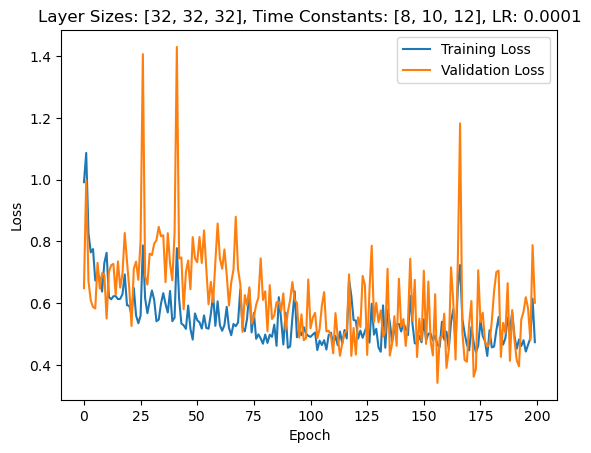

  0%|          | 1/200 [00:14<47:37, 14.36s/it]

Epoch 1/200, Training Loss: 1.0863482311086834, Validation Loss: 0.7873375713825226


  1%|          | 2/200 [00:28<47:46, 14.48s/it]

Epoch 2/200, Training Loss: 0.8470257824321963, Validation Loss: 0.7649831133229392


  2%|▏         | 3/200 [00:42<46:15, 14.09s/it]

Epoch 3/200, Training Loss: 0.9316992332350533, Validation Loss: 0.7181188868624824


  2%|▏         | 4/200 [00:55<44:57, 13.76s/it]

Epoch 4/200, Training Loss: 0.784250538304167, Validation Loss: 0.7527281769684383


  2%|▎         | 5/200 [01:09<44:39, 13.74s/it]

Epoch 5/200, Training Loss: 0.7567183515935574, Validation Loss: 0.7202016881534031


  3%|▎         | 6/200 [01:23<45:03, 13.93s/it]

Epoch 6/200, Training Loss: 0.699656421845814, Validation Loss: 0.6595579577343804


  4%|▎         | 7/200 [01:38<45:04, 14.01s/it]

Epoch 7/200, Training Loss: 0.6432118978140489, Validation Loss: 0.6393450860466275


  4%|▍         | 8/200 [01:52<45:25, 14.20s/it]

Epoch 8/200, Training Loss: 0.6792021438760577, Validation Loss: 0.6457350200840405


  4%|▍         | 9/200 [02:06<45:17, 14.23s/it]

Epoch 9/200, Training Loss: 0.640843744547862, Validation Loss: 0.6059321399245944


  5%|▌         | 10/200 [02:20<44:45, 14.13s/it]

Epoch 10/200, Training Loss: 0.6088641973317794, Validation Loss: 0.673833925809179


  6%|▌         | 11/200 [02:34<44:15, 14.05s/it]

Epoch 11/200, Training Loss: 0.592542216462909, Validation Loss: 0.6208705114466804


  6%|▌         | 12/200 [02:49<44:26, 14.18s/it]

Epoch 12/200, Training Loss: 0.6016089972460045, Validation Loss: 0.593138089137418


  6%|▋         | 13/200 [03:02<43:22, 13.92s/it]

Epoch 13/200, Training Loss: 0.6003348658669669, Validation Loss: 0.620928202356611


  7%|▋         | 14/200 [03:16<42:51, 13.82s/it]

Epoch 14/200, Training Loss: 0.5663488265478386, Validation Loss: 0.5888485067657062


  8%|▊         | 15/200 [03:29<42:26, 13.76s/it]

Epoch 15/200, Training Loss: 0.5594997046128759, Validation Loss: 0.5511834919452667


  8%|▊         | 16/200 [03:43<42:41, 13.92s/it]

Epoch 16/200, Training Loss: 0.5671737998161676, Validation Loss: 0.578568941780499


  8%|▊         | 17/200 [03:57<42:19, 13.88s/it]

Epoch 17/200, Training Loss: 0.5406584689077342, Validation Loss: 0.541225288595472


  9%|▉         | 18/200 [04:11<41:46, 13.77s/it]

Epoch 18/200, Training Loss: 0.556715061642089, Validation Loss: 0.5504254741328103


 10%|▉         | 19/200 [04:24<41:08, 13.64s/it]

Epoch 19/200, Training Loss: 0.5361066286293965, Validation Loss: 0.5837228042738778


 10%|█         | 20/200 [04:38<41:12, 13.73s/it]

Epoch 20/200, Training Loss: 0.5323919682007916, Validation Loss: 0.5517075892005648


 10%|█         | 21/200 [04:52<41:28, 13.90s/it]

Epoch 21/200, Training Loss: 0.5412017185733003, Validation Loss: 0.5052191146782467


 11%|█         | 22/200 [05:06<40:45, 13.74s/it]

Epoch 22/200, Training Loss: 0.5055043776080294, Validation Loss: 0.5754949620791844


 12%|█▏        | 23/200 [05:19<40:28, 13.72s/it]

Epoch 23/200, Training Loss: 0.515112431825332, Validation Loss: 0.5382539821522576


 12%|█▏        | 24/200 [05:34<40:59, 13.97s/it]

Epoch 24/200, Training Loss: 0.5036375935909883, Validation Loss: 0.5521310354982104


 12%|█▎        | 25/200 [05:48<40:30, 13.89s/it]

Epoch 25/200, Training Loss: 0.4768402947569793, Validation Loss: 0.5191970712372235


 13%|█▎        | 26/200 [06:02<40:22, 13.92s/it]

Epoch 26/200, Training Loss: 0.4838469632953968, Validation Loss: 0.6153859496116638


 14%|█▎        | 27/200 [06:15<39:55, 13.85s/it]

Epoch 27/200, Training Loss: 0.49592088584629995, Validation Loss: 0.5484958269766399


 14%|█▍        | 28/200 [06:29<39:22, 13.74s/it]

Epoch 28/200, Training Loss: 0.487459271865071, Validation Loss: 0.5806204187018531


 14%|█▍        | 29/200 [06:42<38:59, 13.68s/it]

Epoch 29/200, Training Loss: 0.5235197127990003, Validation Loss: 0.5911374006952558


 15%|█▌        | 30/200 [06:56<38:53, 13.72s/it]

Epoch 30/200, Training Loss: 0.5363075688200177, Validation Loss: 0.60758290546281


 16%|█▌        | 31/200 [07:10<38:33, 13.69s/it]

Epoch 31/200, Training Loss: 0.5060432474568205, Validation Loss: 0.5580888156379972


 16%|█▌        | 32/200 [07:23<38:17, 13.68s/it]

Epoch 32/200, Training Loss: 0.47758934632787164, Validation Loss: 0.5168558305927685


 16%|█▋        | 33/200 [07:38<38:49, 13.95s/it]

Epoch 33/200, Training Loss: 0.48044278599181267, Validation Loss: 0.5767437262194497


 17%|█▋        | 34/200 [07:52<38:16, 13.83s/it]

Epoch 34/200, Training Loss: 0.4694070723259224, Validation Loss: 0.5626967549324036


 18%|█▊        | 35/200 [08:05<37:42, 13.71s/it]

Epoch 35/200, Training Loss: 0.47519367230388354, Validation Loss: 0.591973215341568


 18%|█▊        | 36/200 [08:19<37:42, 13.80s/it]

Epoch 36/200, Training Loss: 0.46418901139272833, Validation Loss: 0.4819511984075819


 18%|█▊        | 37/200 [08:33<37:46, 13.90s/it]

Epoch 37/200, Training Loss: 0.460549717804171, Validation Loss: 0.5392147366489682


 19%|█▉        | 38/200 [08:47<37:07, 13.75s/it]

Epoch 38/200, Training Loss: 0.44193711314561235, Validation Loss: 0.5462814601404327


 20%|█▉        | 39/200 [09:00<37:02, 13.80s/it]

Epoch 39/200, Training Loss: 0.462757797736042, Validation Loss: 0.5516186995165688


 20%|██        | 40/200 [09:14<36:28, 13.68s/it]

Epoch 40/200, Training Loss: 0.43117650893499265, Validation Loss: 0.5595221987792424


 20%|██        | 41/200 [09:27<35:55, 13.56s/it]

Epoch 41/200, Training Loss: 0.4418504353401796, Validation Loss: 0.6022280390773501


 21%|██        | 42/200 [09:41<35:55, 13.64s/it]

Epoch 42/200, Training Loss: 0.448623759004305, Validation Loss: 0.5486693744148526


 22%|██▏       | 43/200 [09:54<35:35, 13.60s/it]

Epoch 43/200, Training Loss: 0.4162490159835456, Validation Loss: 0.613740337746484


 22%|██▏       | 44/200 [10:08<35:09, 13.52s/it]

Epoch 44/200, Training Loss: 0.44141896842223294, Validation Loss: 0.5058261390243258


 22%|██▎       | 45/200 [10:22<35:17, 13.66s/it]

Epoch 45/200, Training Loss: 0.42801789573903354, Validation Loss: 0.538349167576858


 23%|██▎       | 46/200 [10:36<35:36, 13.87s/it]

Epoch 46/200, Training Loss: 0.42580662189789537, Validation Loss: 0.5414547962801797


 24%|██▎       | 47/200 [10:50<34:59, 13.72s/it]

Epoch 47/200, Training Loss: 0.4165461088688868, Validation Loss: 0.5537006620849881


 24%|██▍       | 48/200 [11:03<34:49, 13.75s/it]

Epoch 48/200, Training Loss: 0.41735415891656336, Validation Loss: 0.5317977879728589


 24%|██▍       | 49/200 [11:18<35:00, 13.91s/it]

Epoch 49/200, Training Loss: 0.4056494061676961, Validation Loss: 0.5703272776944297


 25%|██▌       | 50/200 [11:31<34:31, 13.81s/it]

Epoch 50/200, Training Loss: 0.4326798218601155, Validation Loss: 0.5641399047204426


 26%|██▌       | 51/200 [11:45<34:24, 13.86s/it]

Epoch 51/200, Training Loss: 0.41982215839736864, Validation Loss: 0.5348243223769324


 26%|██▌       | 52/200 [11:59<33:52, 13.74s/it]

Epoch 52/200, Training Loss: 0.3996955954803611, Validation Loss: 0.4889794375215258


 26%|██▋       | 53/200 [12:12<33:36, 13.72s/it]

Epoch 53/200, Training Loss: 0.4020711565917393, Validation Loss: 0.5389262054647718


 27%|██▋       | 54/200 [12:26<33:35, 13.80s/it]

Epoch 54/200, Training Loss: 0.41064865296741704, Validation Loss: 0.5360454406057086


 28%|██▊       | 55/200 [12:40<33:10, 13.73s/it]

Epoch 55/200, Training Loss: 0.4098105124145184, Validation Loss: 0.5517118285809245


 28%|██▊       | 56/200 [12:53<32:43, 13.64s/it]

Epoch 56/200, Training Loss: 0.41940537123185284, Validation Loss: 0.5414858439138958


 28%|██▊       | 57/200 [13:07<32:53, 13.80s/it]

Epoch 57/200, Training Loss: 0.3977104551949591, Validation Loss: 0.5260094595806939


 29%|██▉       | 58/200 [13:22<33:03, 13.97s/it]

Epoch 58/200, Training Loss: 0.38152879617124236, Validation Loss: 0.5303641834429332


 30%|██▉       | 59/200 [13:35<32:23, 13.78s/it]

Epoch 59/200, Training Loss: 0.3980183469237022, Validation Loss: 0.5374913726534162


 30%|███       | 60/200 [13:49<32:08, 13.78s/it]

Epoch 60/200, Training Loss: 0.3950552816660899, Validation Loss: 0.47638885251113344


 30%|███       | 61/200 [14:03<31:52, 13.76s/it]

Epoch 61/200, Training Loss: 0.3896012012407465, Validation Loss: 0.5239137900727135


 31%|███       | 62/200 [14:17<32:07, 13.97s/it]

Epoch 62/200, Training Loss: 0.3916171114399748, Validation Loss: 0.5235115225825991


 32%|███▏      | 63/200 [14:31<31:46, 13.92s/it]

Epoch 63/200, Training Loss: 0.37988927960395813, Validation Loss: 0.5443129113742283


 32%|███▏      | 64/200 [14:45<31:19, 13.82s/it]

Epoch 64/200, Training Loss: 0.3844615156358143, Validation Loss: 0.4571471171719687


 32%|███▎      | 65/200 [14:58<30:45, 13.67s/it]

Epoch 65/200, Training Loss: 0.37343403725129254, Validation Loss: 0.5459499614579337


 33%|███▎      | 66/200 [15:12<30:34, 13.69s/it]

Epoch 66/200, Training Loss: 0.3969527173717067, Validation Loss: 0.4923512190580368


 34%|███▎      | 67/200 [15:25<30:25, 13.72s/it]

Epoch 67/200, Training Loss: 0.3807119676526987, Validation Loss: 0.5262430650847298


 34%|███▍      | 68/200 [15:39<29:59, 13.64s/it]

Epoch 68/200, Training Loss: 0.38669814647368667, Validation Loss: 0.4980260857513973


 34%|███▍      | 69/200 [15:53<29:51, 13.67s/it]

Epoch 69/200, Training Loss: 0.3688643701233954, Validation Loss: 0.4758892357349396


 35%|███▌      | 70/200 [16:07<29:56, 13.82s/it]

Epoch 70/200, Training Loss: 0.3649876741868145, Validation Loss: 0.488738619855472


 36%|███▌      | 71/200 [16:21<29:57, 13.94s/it]

Epoch 71/200, Training Loss: 0.360194186838168, Validation Loss: 0.5115603868450437


 36%|███▌      | 72/200 [16:34<29:29, 13.82s/it]

Epoch 72/200, Training Loss: 0.36844092748075163, Validation Loss: 0.5012634588139397


 36%|███▋      | 73/200 [16:48<29:19, 13.85s/it]

Epoch 73/200, Training Loss: 0.3692441818849096, Validation Loss: 0.4955010541847774


 37%|███▋      | 74/200 [17:02<28:56, 13.78s/it]

Epoch 74/200, Training Loss: 0.3625073396372345, Validation Loss: 0.43751473299094606


 38%|███▊      | 75/200 [17:16<29:07, 13.98s/it]

Epoch 75/200, Training Loss: 0.34665184186876946, Validation Loss: 0.45376862585544586


 38%|███▊      | 76/200 [17:31<28:57, 14.01s/it]

Epoch 76/200, Training Loss: 0.34943291235644863, Validation Loss: 0.5218630241496223


 38%|███▊      | 77/200 [17:44<28:23, 13.85s/it]

Epoch 77/200, Training Loss: 0.34696051112885745, Validation Loss: 0.5280303231307438


 39%|███▉      | 78/200 [17:58<28:03, 13.80s/it]

Epoch 78/200, Training Loss: 0.38324401850970286, Validation Loss: 0.5427907066685813


 40%|███▉      | 79/200 [18:12<27:53, 13.83s/it]

Epoch 79/200, Training Loss: 0.3809002570386203, Validation Loss: 0.4715390311820166


 40%|████      | 80/200 [18:25<27:27, 13.73s/it]

Epoch 80/200, Training Loss: 0.3566053383192926, Validation Loss: 0.49050616792270113


 40%|████      | 81/200 [18:39<27:06, 13.67s/it]

Epoch 81/200, Training Loss: 0.34393991389364564, Validation Loss: 0.4615107136113303


 41%|████      | 82/200 [18:53<27:00, 13.74s/it]

Epoch 82/200, Training Loss: 0.33931146562099457, Validation Loss: 0.460974640079907


 42%|████▏     | 83/200 [19:06<26:49, 13.76s/it]

Epoch 83/200, Training Loss: 0.3367299181672762, Validation Loss: 0.5126706042460033


 42%|████▏     | 84/200 [19:20<26:49, 13.88s/it]

Epoch 84/200, Training Loss: 0.3628704592866718, Validation Loss: 0.5399486060653415


 42%|████▎     | 85/200 [19:35<26:43, 13.94s/it]

Epoch 85/200, Training Loss: 0.3402898647594002, Validation Loss: 0.4836889058351517


 43%|████▎     | 86/200 [19:48<26:10, 13.78s/it]

Epoch 86/200, Training Loss: 0.33229379215330446, Validation Loss: 0.4883276287998472


 44%|████▎     | 87/200 [20:02<26:17, 13.96s/it]

Epoch 87/200, Training Loss: 0.34651911413332204, Validation Loss: 0.5055096043007714


 44%|████▍     | 88/200 [20:17<26:11, 14.03s/it]

Epoch 88/200, Training Loss: 0.34634308376402223, Validation Loss: 0.4928133487701416


 44%|████▍     | 89/200 [20:30<25:35, 13.84s/it]

Epoch 89/200, Training Loss: 0.3374754156706468, Validation Loss: 0.48261015330042156


 45%|████▌     | 90/200 [20:44<25:12, 13.75s/it]

Epoch 90/200, Training Loss: 0.3345512028010386, Validation Loss: 0.5177631591047559


 46%|████▌     | 91/200 [20:58<25:10, 13.85s/it]

Epoch 91/200, Training Loss: 0.35121130830836744, Validation Loss: 0.5084940918854305


 46%|████▌     | 92/200 [21:11<24:44, 13.75s/it]

Epoch 92/200, Training Loss: 0.34360978260355174, Validation Loss: 0.49487657845020294


 46%|████▋     | 93/200 [21:24<24:19, 13.64s/it]

Epoch 93/200, Training Loss: 0.3194983366806552, Validation Loss: 0.48893649876117706


 47%|████▋     | 94/200 [21:38<24:14, 13.72s/it]

Epoch 94/200, Training Loss: 0.32088463837808034, Validation Loss: 0.48155331185885836


 48%|████▊     | 95/200 [21:52<24:03, 13.75s/it]

Epoch 95/200, Training Loss: 0.33377798899727046, Validation Loss: 0.44862790192876545


 48%|████▊     | 96/200 [22:06<24:05, 13.90s/it]

Epoch 96/200, Training Loss: 0.34719666894876733, Validation Loss: 0.47932793625763487


 48%|████▊     | 97/200 [22:20<23:52, 13.90s/it]

Epoch 97/200, Training Loss: 0.3552189261283515, Validation Loss: 0.48514299733298166


 49%|████▉     | 98/200 [22:34<23:30, 13.83s/it]

Epoch 98/200, Training Loss: 0.3264275436412613, Validation Loss: 0.4441355402980532


 50%|████▉     | 99/200 [22:49<23:38, 14.04s/it]

Epoch 99/200, Training Loss: 0.33966274840651817, Validation Loss: 0.4882313183375767


 50%|█████     | 100/200 [23:03<23:26, 14.07s/it]

Epoch 100/200, Training Loss: 0.3304883318970788, Validation Loss: 0.47354605155331747


 50%|█████     | 101/200 [23:16<23:04, 13.98s/it]

Epoch 101/200, Training Loss: 0.30329190307068377, Validation Loss: 0.5234817798648562


 51%|█████     | 102/200 [23:30<22:37, 13.85s/it]

Epoch 102/200, Training Loss: 0.3200609120276739, Validation Loss: 0.45501988913331715


 52%|█████▏    | 103/200 [23:44<22:28, 13.90s/it]

Epoch 103/200, Training Loss: 0.30554718186832824, Validation Loss: 0.5505090079137257


 52%|█████▏    | 104/200 [23:58<22:09, 13.85s/it]

Epoch 104/200, Training Loss: 0.31632332791978457, Validation Loss: 0.4333780940089907


 52%|█████▎    | 105/200 [24:11<21:44, 13.74s/it]

Epoch 105/200, Training Loss: 0.33470587643249977, Validation Loss: 0.45135670581034254


 53%|█████▎    | 106/200 [24:25<21:36, 13.79s/it]

Epoch 106/200, Training Loss: 0.3291892409324646, Validation Loss: 0.5056248754262924


 54%|█████▎    | 107/200 [24:39<21:28, 13.85s/it]

Epoch 107/200, Training Loss: 0.317864485858184, Validation Loss: 0.4799198252814157


 54%|█████▍    | 108/200 [24:53<21:25, 13.98s/it]

Epoch 108/200, Training Loss: 0.3076192118086905, Validation Loss: 0.47211276633398874


 55%|█████▍    | 109/200 [25:07<21:02, 13.88s/it]

Epoch 109/200, Training Loss: 0.319046694715068, Validation Loss: 0.5561014754431588


 55%|█████▌    | 110/200 [25:21<20:49, 13.88s/it]

Epoch 110/200, Training Loss: 0.3172530375842778, Validation Loss: 0.5179520164217267


 56%|█████▌    | 111/200 [25:35<20:45, 14.00s/it]

Epoch 111/200, Training Loss: 0.3124841273112117, Validation Loss: 0.5351775373731341


 56%|█████▌    | 112/200 [25:49<20:30, 13.98s/it]

Epoch 112/200, Training Loss: 0.29029846753714217, Validation Loss: 0.4443548747471401


 56%|█████▋    | 113/200 [26:03<20:12, 13.94s/it]

Epoch 113/200, Training Loss: 0.2957852311291785, Validation Loss: 0.48413477199418203


 57%|█████▋    | 114/200 [26:17<19:47, 13.81s/it]

Epoch 114/200, Training Loss: 0.3181213490524382, Validation Loss: 0.5145455939429147


 57%|█████▊    | 115/200 [26:30<19:28, 13.75s/it]

Epoch 115/200, Training Loss: 0.313761202231893, Validation Loss: 0.49555628853184835


 58%|█████▊    | 116/200 [26:44<19:20, 13.81s/it]

Epoch 116/200, Training Loss: 0.2976416810503546, Validation Loss: 0.5311504176684788


 58%|█████▊    | 117/200 [26:58<18:57, 13.70s/it]

Epoch 117/200, Training Loss: 0.3177360546476436, Validation Loss: 0.529757423060281


 59%|█████▉    | 118/200 [27:11<18:43, 13.70s/it]

Epoch 118/200, Training Loss: 0.29551198748203944, Validation Loss: 0.49030562809535433


 60%|█████▉    | 119/200 [27:26<18:47, 13.92s/it]

Epoch 119/200, Training Loss: 0.2908863715546311, Validation Loss: 0.5294826456478664


 60%|██████    | 120/200 [27:40<18:39, 14.00s/it]

Epoch 120/200, Training Loss: 0.2838692793025161, Validation Loss: 0.47485303027289255


 60%|██████    | 121/200 [27:53<18:17, 13.89s/it]

Epoch 121/200, Training Loss: 0.2917203544726912, Validation Loss: 0.5080486450876508


 61%|██████    | 122/200 [28:08<18:08, 13.95s/it]

Epoch 122/200, Training Loss: 0.28487014194142146, Validation Loss: 0.5585603245667049


 62%|██████▏   | 123/200 [28:21<17:45, 13.84s/it]

Epoch 123/200, Training Loss: 0.29665601492490407, Validation Loss: 0.47078714413302286


 62%|██████▏   | 124/200 [28:36<17:45, 14.02s/it]

Epoch 124/200, Training Loss: 0.2979372122658874, Validation Loss: 0.5548243863242013


 62%|██████▎   | 125/200 [28:50<17:38, 14.11s/it]

Epoch 125/200, Training Loss: 0.27705042598382484, Validation Loss: 0.5542773561818259


 63%|██████▎   | 126/200 [29:03<17:09, 13.91s/it]

Epoch 126/200, Training Loss: 0.2984796978954999, Validation Loss: 0.4919641486236027


 64%|██████▎   | 127/200 [29:17<16:45, 13.78s/it]

Epoch 127/200, Training Loss: 0.2873857755143687, Validation Loss: 0.4686347650630133


 64%|██████▍   | 128/200 [29:31<16:35, 13.83s/it]

Epoch 128/200, Training Loss: 0.28196835531941, Validation Loss: 0.5126775950193405


 64%|██████▍   | 129/200 [29:44<16:17, 13.77s/it]

Epoch 129/200, Training Loss: 0.30083416001695507, Validation Loss: 0.4971927446978433


 65%|██████▌   | 130/200 [29:58<15:56, 13.66s/it]

Epoch 130/200, Training Loss: 0.2778382311170956, Validation Loss: 0.5192256655011859


 66%|██████▌   | 131/200 [30:12<15:48, 13.75s/it]

Epoch 131/200, Training Loss: 0.3084264978204133, Validation Loss: 0.45988548014845165


 66%|██████▌   | 132/200 [30:26<15:40, 13.83s/it]

Epoch 132/200, Training Loss: 0.28087937241455296, Validation Loss: 0.5216157159634999


 66%|██████▋   | 133/200 [30:40<15:35, 13.96s/it]

Epoch 133/200, Training Loss: 0.2939017741185314, Validation Loss: 0.5218772568872997


 67%|██████▋   | 134/200 [30:54<15:24, 14.00s/it]

Epoch 134/200, Training Loss: 0.2855718989136084, Validation Loss: 0.4977067559957504


 68%|██████▊   | 135/200 [31:08<15:00, 13.86s/it]

Epoch 135/200, Training Loss: 0.2876532111527785, Validation Loss: 0.5208493513720376


 68%|██████▊   | 136/200 [31:22<14:56, 14.00s/it]

Epoch 136/200, Training Loss: 0.2881063845641208, Validation Loss: 0.5502694313015256


 68%|██████▊   | 137/200 [31:36<14:43, 14.03s/it]

Epoch 137/200, Training Loss: 0.2862298216600463, Validation Loss: 0.5118951393025262


 69%|██████▉   | 138/200 [31:50<14:24, 13.94s/it]

Epoch 138/200, Training Loss: 0.2728971373641266, Validation Loss: 0.5237318000623158


 70%|██████▉   | 139/200 [32:03<14:00, 13.78s/it]

Epoch 139/200, Training Loss: 0.2721038611148888, Validation Loss: 0.524268735732351


 70%|███████   | 140/200 [32:17<13:49, 13.83s/it]

Epoch 140/200, Training Loss: 0.27731459573754724, Validation Loss: 0.4936659165791103


 70%|███████   | 141/200 [32:31<13:31, 13.76s/it]

Epoch 141/200, Training Loss: 0.26123072333493325, Validation Loss: 0.5537964573928288


 71%|███████   | 142/200 [32:45<13:18, 13.77s/it]

Epoch 142/200, Training Loss: 0.279706283841493, Validation Loss: 0.5047018453478813


 72%|███████▏  | 143/200 [32:59<13:08, 13.83s/it]

Epoch 143/200, Training Loss: 0.26594615804980387, Validation Loss: 0.47795181402138304


 72%|███████▏  | 144/200 [33:12<12:55, 13.85s/it]

Epoch 144/200, Training Loss: 0.2683366324822858, Validation Loss: 0.5871063002518245


 72%|███████▎  | 145/200 [33:27<12:48, 13.97s/it]

Epoch 145/200, Training Loss: 0.27903044350304695, Validation Loss: 0.5024132494415555


 73%|███████▎  | 146/200 [33:41<12:36, 14.01s/it]

Epoch 146/200, Training Loss: 0.2665384777312009, Validation Loss: 0.5028141949857984


 74%|███████▎  | 147/200 [33:55<12:18, 13.93s/it]

Epoch 147/200, Training Loss: 0.28405594600821443, Validation Loss: 0.5141812690666744


 74%|███████▍  | 148/200 [34:08<11:58, 13.82s/it]

Epoch 148/200, Training Loss: 0.2760330021100224, Validation Loss: 0.48565447330474854


 74%|███████▍  | 149/200 [34:23<12:00, 14.12s/it]

Epoch 149/200, Training Loss: 0.26700694830912464, Validation Loss: 0.5063237867185048


 75%|███████▌  | 150/200 [34:37<11:43, 14.07s/it]

Epoch 150/200, Training Loss: 0.25455382831816403, Validation Loss: 0.5094482174941471


 76%|███████▌  | 151/200 [34:51<11:23, 13.94s/it]

Epoch 151/200, Training Loss: 0.26506798071259596, Validation Loss: 0.544391970549311


 76%|███████▌  | 152/200 [35:04<11:06, 13.88s/it]

Epoch 152/200, Training Loss: 0.259331798497236, Validation Loss: 0.47707421651908327


 76%|███████▋  | 153/200 [35:18<10:50, 13.83s/it]

Epoch 153/200, Training Loss: 0.254859928955447, Validation Loss: 0.5019036765609469


 77%|███████▋  | 154/200 [35:31<10:30, 13.71s/it]

Epoch 154/200, Training Loss: 0.25601659223156153, Validation Loss: 0.5147226878574916


 78%|███████▊  | 155/200 [35:45<10:16, 13.69s/it]

Epoch 155/200, Training Loss: 0.26962743544915935, Validation Loss: 0.5146390944719315


 78%|███████▊  | 156/200 [35:59<10:06, 13.78s/it]

Epoch 156/200, Training Loss: 0.2532128203871115, Validation Loss: 0.4737183281353542


 78%|███████▊  | 157/200 [36:13<09:52, 13.79s/it]

Epoch 157/200, Training Loss: 0.2678865922509499, Validation Loss: 0.5325717628002167


 79%|███████▉  | 158/200 [36:27<09:47, 14.00s/it]

Epoch 158/200, Training Loss: 0.24609948272974985, Validation Loss: 0.520828379052026


 80%|███████▉  | 159/200 [36:42<09:36, 14.06s/it]

Epoch 159/200, Training Loss: 0.2630441253477672, Validation Loss: 0.5022667795419693


 80%|████████  | 160/200 [36:56<09:26, 14.16s/it]

Epoch 160/200, Training Loss: 0.24289483070935844, Validation Loss: 0.5013059409601348


 80%|████████  | 161/200 [37:10<09:09, 14.08s/it]

Epoch 161/200, Training Loss: 0.27024759731765063, Validation Loss: 0.4849853792360851


 81%|████████  | 162/200 [37:24<08:53, 14.03s/it]

Epoch 162/200, Training Loss: 0.24649496025071954, Validation Loss: 0.5106724202632904


 82%|████████▏ | 163/200 [37:37<08:32, 13.86s/it]

Epoch 163/200, Training Loss: 0.2451985440445396, Validation Loss: 0.5206035716193063


 82%|████████▏ | 164/200 [37:51<08:16, 13.78s/it]

Epoch 164/200, Training Loss: 0.25277393114454344, Validation Loss: 0.4708383466516222


 82%|████████▎ | 165/200 [38:05<08:06, 13.90s/it]

Epoch 165/200, Training Loss: 0.2491943896660265, Validation Loss: 0.5350920174803052


 83%|████████▎ | 166/200 [38:19<07:48, 13.79s/it]

Epoch 166/200, Training Loss: 0.2515929560616331, Validation Loss: 0.5075329286711556


 84%|████████▎ | 167/200 [38:32<07:32, 13.71s/it]

Epoch 167/200, Training Loss: 0.30742640455938736, Validation Loss: 0.560253096478326


 84%|████████▍ | 168/200 [38:47<07:29, 14.04s/it]

Epoch 168/200, Training Loss: 0.24091776657216954, Validation Loss: 0.5196631678513118


 84%|████████▍ | 169/200 [39:01<07:18, 14.16s/it]

Epoch 169/200, Training Loss: 0.2284796898657421, Validation Loss: 0.48799069438661846


 85%|████████▌ | 170/200 [39:15<07:00, 14.02s/it]

Epoch 170/200, Training Loss: 0.23521564057413138, Validation Loss: 0.5165891391890389


 86%|████████▌ | 171/200 [39:29<06:47, 14.04s/it]

Epoch 171/200, Training Loss: 0.2379724937227537, Validation Loss: 0.5005715425525393


 86%|████████▌ | 172/200 [39:43<06:36, 14.14s/it]

Epoch 172/200, Training Loss: 0.24177473924070034, Validation Loss: 0.48399911395141054


 86%|████████▋ | 173/200 [39:57<06:19, 14.04s/it]

Epoch 173/200, Training Loss: 0.2529878276136686, Validation Loss: 0.4949032281126295


 87%|████████▋ | 174/200 [40:11<06:05, 14.06s/it]

Epoch 174/200, Training Loss: 0.23388111324242825, Validation Loss: 0.5170856714248657


 88%|████████▊ | 175/200 [40:25<05:47, 13.89s/it]

Epoch 175/200, Training Loss: 0.2428192226391918, Validation Loss: 0.42251524542059216


 88%|████████▊ | 176/200 [40:38<05:30, 13.77s/it]

Epoch 176/200, Training Loss: 0.23965340192025564, Validation Loss: 0.4829477710383279


 88%|████████▊ | 177/200 [40:52<05:18, 13.84s/it]

Epoch 177/200, Training Loss: 0.22669182998954124, Validation Loss: 0.5135354314531598


 89%|████████▉ | 178/200 [41:06<05:02, 13.74s/it]

Epoch 178/200, Training Loss: 0.24448432133726353, Validation Loss: 0.5604257647480283


 90%|████████▉ | 179/200 [41:20<04:49, 13.76s/it]

Epoch 179/200, Training Loss: 0.24160210661730677, Validation Loss: 0.4804842174053192


 90%|█████████ | 180/200 [41:34<04:39, 13.95s/it]

Epoch 180/200, Training Loss: 0.21202406308279848, Validation Loss: 0.4822417880807604


 90%|█████████ | 181/200 [41:49<04:27, 14.11s/it]

Epoch 181/200, Training Loss: 0.20682010876963725, Validation Loss: 0.5319986151797431


 91%|█████████ | 182/200 [42:02<04:10, 13.93s/it]

Epoch 182/200, Training Loss: 0.21136749774779914, Validation Loss: 0.4646018998963492


 92%|█████████▏| 183/200 [42:16<03:58, 14.01s/it]

Epoch 183/200, Training Loss: 0.21267086928183176, Validation Loss: 0.48277947519506725


 92%|█████████▏| 184/200 [42:31<03:45, 14.12s/it]

Epoch 184/200, Training Loss: 0.22212123406945533, Validation Loss: 0.46289863330977304


 92%|█████████▎| 185/200 [42:44<03:29, 14.00s/it]

Epoch 185/200, Training Loss: 0.22068238651977395, Validation Loss: 0.5385713023798806


 93%|█████████▎| 186/200 [42:58<03:16, 14.04s/it]

Epoch 186/200, Training Loss: 0.2121116504916605, Validation Loss: 0.5330445723874229


 94%|█████████▎| 187/200 [43:12<03:01, 13.99s/it]

Epoch 187/200, Training Loss: 0.21579522773061158, Validation Loss: 0.46762004281793323


 94%|█████████▍| 188/200 [43:26<02:46, 13.87s/it]

Epoch 188/200, Training Loss: 0.2315092996325133, Validation Loss: 0.497214138507843


 94%|█████████▍| 189/200 [43:40<02:32, 13.88s/it]

Epoch 189/200, Training Loss: 0.21308285525103784, Validation Loss: 0.5208793516669955


 95%|█████████▌| 190/200 [43:54<02:18, 13.82s/it]

Epoch 190/200, Training Loss: 0.2029886171221733, Validation Loss: 0.5309896320104599


 96%|█████████▌| 191/200 [44:07<02:03, 13.73s/it]

Epoch 191/200, Training Loss: 0.19977017316334653, Validation Loss: 0.4669753611087799


 96%|█████████▌| 192/200 [44:21<01:50, 13.83s/it]

Epoch 192/200, Training Loss: 0.21288627273631547, Validation Loss: 0.5235679426363536


 96%|█████████▋| 193/200 [44:36<01:38, 14.14s/it]

Epoch 193/200, Training Loss: 0.2123173764854107, Validation Loss: 0.5939970144203731


 97%|█████████▋| 194/200 [44:50<01:23, 13.97s/it]

Epoch 194/200, Training Loss: 0.21117465633828686, Validation Loss: 0.5779479401452201


 98%|█████████▊| 195/200 [45:03<01:09, 13.91s/it]

Epoch 195/200, Training Loss: 0.21433528906331872, Validation Loss: 0.5052156107766288


 98%|█████████▊| 196/200 [45:18<00:56, 14.13s/it]

Epoch 196/200, Training Loss: 0.2211206794347403, Validation Loss: 0.5042235170091901


 98%|█████████▊| 197/200 [45:32<00:42, 14.08s/it]

Epoch 197/200, Training Loss: 0.21509447707882468, Validation Loss: 0.5452436187437603


 99%|█████████▉| 198/200 [45:46<00:27, 13.97s/it]

Epoch 198/200, Training Loss: 0.21825469917846177, Validation Loss: 0.5266561380454472


100%|█████████▉| 199/200 [46:00<00:13, 13.97s/it]

Epoch 199/200, Training Loss: 0.24314601817783318, Validation Loss: 0.45250590784209116


100%|██████████| 200/200 [46:13<00:00, 13.87s/it]


Epoch 200/200, Training Loss: 0.22402759360254937, Validation Loss: 0.460192077926227
Final Accuracy: 93.42%, Precision: 0.93, Recall: 0.94


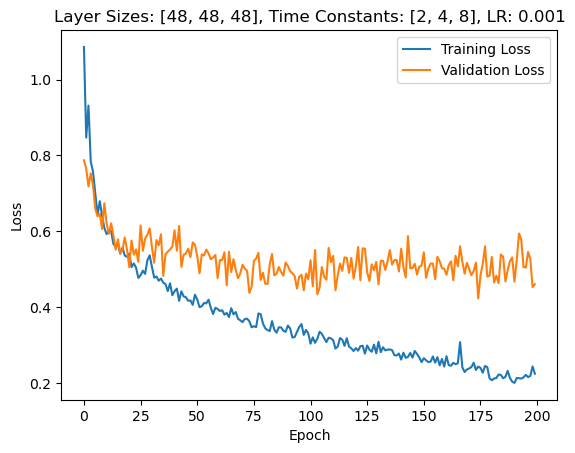

  0%|          | 1/200 [00:14<48:52, 14.74s/it]

Epoch 1/200, Training Loss: 1.012207622797984, Validation Loss: 0.8095540659768241


  1%|          | 2/200 [00:29<47:46, 14.48s/it]

Epoch 2/200, Training Loss: 0.9273269660068009, Validation Loss: 0.7569332207952227


  2%|▏         | 3/200 [00:42<46:14, 14.08s/it]

Epoch 3/200, Training Loss: 0.8884646701362898, Validation Loss: 0.753913585628782


  2%|▏         | 4/200 [00:57<46:30, 14.23s/it]

Epoch 4/200, Training Loss: 0.8314844516088378, Validation Loss: 0.8961486858980996


  2%|▎         | 5/200 [01:11<45:58, 14.15s/it]

Epoch 5/200, Training Loss: 0.8410429144805333, Validation Loss: 0.7328729459217617


  3%|▎         | 6/200 [01:25<45:46, 14.16s/it]

Epoch 6/200, Training Loss: 0.833665798295219, Validation Loss: 0.7976534111159188


  4%|▎         | 7/200 [01:40<46:08, 14.34s/it]

Epoch 7/200, Training Loss: 0.8026356191005347, Validation Loss: 0.6870910908494677


  4%|▍         | 8/200 [01:54<46:03, 14.39s/it]

Epoch 8/200, Training Loss: 0.8137438252287091, Validation Loss: 0.6811421811580658


  4%|▍         | 9/200 [02:08<45:34, 14.32s/it]

Epoch 9/200, Training Loss: 0.7764739787803506, Validation Loss: 0.6724170936005456


  5%|▌         | 10/200 [02:22<45:14, 14.29s/it]

Epoch 10/200, Training Loss: 0.7365676277088669, Validation Loss: 0.7167858736855643


  6%|▌         | 11/200 [02:36<44:23, 14.09s/it]

Epoch 11/200, Training Loss: 0.7282860383110227, Validation Loss: 0.747531343783651


  6%|▌         | 12/200 [02:50<44:26, 14.18s/it]

Epoch 12/200, Training Loss: 0.7327811667379344, Validation Loss: 0.6593192134584699


  6%|▋         | 13/200 [03:04<43:39, 14.01s/it]

Epoch 13/200, Training Loss: 0.7009025463518107, Validation Loss: 0.6721909642219543


  7%|▋         | 14/200 [03:18<43:06, 13.91s/it]

Epoch 14/200, Training Loss: 0.6878878648551006, Validation Loss: 0.68339390201228


  8%|▊         | 15/200 [03:32<43:12, 14.02s/it]

Epoch 15/200, Training Loss: 0.6687906390091158, Validation Loss: 0.6362292553697314


  8%|▊         | 16/200 [03:46<42:42, 13.93s/it]

Epoch 16/200, Training Loss: 0.6687864447539708, Validation Loss: 0.6876207355942044


  8%|▊         | 17/200 [03:59<42:18, 13.87s/it]

Epoch 17/200, Training Loss: 0.654197631579525, Validation Loss: 0.6250521327768054


  9%|▉         | 18/200 [04:13<41:42, 13.75s/it]

Epoch 18/200, Training Loss: 0.6469137724840416, Validation Loss: 0.6103876488549369


 10%|▉         | 19/200 [04:27<41:21, 13.71s/it]

Epoch 19/200, Training Loss: 0.6373003108321496, Validation Loss: 0.6587052664586476


 10%|█         | 20/200 [04:41<41:54, 13.97s/it]

Epoch 20/200, Training Loss: 0.6207352696724657, Validation Loss: 0.6125879692179816


 10%|█         | 21/200 [04:55<41:11, 13.81s/it]

Epoch 21/200, Training Loss: 0.6336696597765077, Validation Loss: 0.5998567576919284


 11%|█         | 22/200 [05:08<40:35, 13.68s/it]

Epoch 22/200, Training Loss: 0.613560714811649, Validation Loss: 0.609180361032486


 12%|█▏        | 23/200 [05:23<41:22, 14.03s/it]

Epoch 23/200, Training Loss: 0.6039667208239717, Validation Loss: 0.603576334459441


 12%|█▏        | 24/200 [05:36<40:42, 13.88s/it]

Epoch 24/200, Training Loss: 0.5919180158174263, Validation Loss: 0.6059519073792866


 12%|█▎        | 25/200 [05:50<39:58, 13.71s/it]

Epoch 25/200, Training Loss: 0.574913759276552, Validation Loss: 0.5917843878269196


 13%|█▎        | 26/200 [06:04<40:01, 13.80s/it]

Epoch 26/200, Training Loss: 0.582882360467371, Validation Loss: 0.589783347078732


 14%|█▎        | 27/200 [06:17<39:31, 13.71s/it]

Epoch 27/200, Training Loss: 0.5906786789309304, Validation Loss: 0.604902731520789


 14%|█▍        | 28/200 [06:30<38:57, 13.59s/it]

Epoch 28/200, Training Loss: 0.5717266252580678, Validation Loss: 0.6106099145753043


 14%|█▍        | 29/200 [06:44<39:00, 13.69s/it]

Epoch 29/200, Training Loss: 0.5681461247633088, Validation Loss: 0.6100960629326957


 15%|█▌        | 30/200 [06:58<38:35, 13.62s/it]

Epoch 30/200, Training Loss: 0.5724645065811446, Validation Loss: 0.592519034232412


 16%|█▌        | 31/200 [07:11<38:11, 13.56s/it]

Epoch 31/200, Training Loss: 0.5763324144876228, Validation Loss: 0.5879169510943549


 16%|█▌        | 32/200 [07:26<38:49, 13.87s/it]

Epoch 32/200, Training Loss: 0.5764757456644526, Validation Loss: 0.5968657966170993


 16%|█▋        | 33/200 [07:40<39:10, 14.08s/it]

Epoch 33/200, Training Loss: 0.5562546433142896, Validation Loss: 0.6110294929572514


 17%|█▋        | 34/200 [07:54<38:36, 13.96s/it]

Epoch 34/200, Training Loss: 0.5529978247183673, Validation Loss: 0.6093679815530777


 18%|█▊        | 35/200 [08:08<38:03, 13.84s/it]

Epoch 35/200, Training Loss: 0.5479779474015506, Validation Loss: 0.6089764343840736


 18%|█▊        | 36/200 [08:22<38:28, 14.07s/it]

Epoch 36/200, Training Loss: 0.5367363300525917, Validation Loss: 0.5798622795513698


 18%|█▊        | 37/200 [08:36<37:46, 13.91s/it]

Epoch 37/200, Training Loss: 0.5409250799215065, Validation Loss: 0.5883186864001411


 19%|█▉        | 38/200 [08:49<37:20, 13.83s/it]

Epoch 38/200, Training Loss: 0.5375848710536957, Validation Loss: 0.6073856438909259


 20%|█▉        | 39/200 [09:03<37:05, 13.82s/it]

Epoch 39/200, Training Loss: 0.5313572225705633, Validation Loss: 0.5896666646003723


 20%|██        | 40/200 [09:17<36:33, 13.71s/it]

Epoch 40/200, Training Loss: 0.5185210406780243, Validation Loss: 0.6115373841353825


 20%|██        | 41/200 [09:30<36:00, 13.59s/it]

Epoch 41/200, Training Loss: 0.5298245903455986, Validation Loss: 0.6169988512992859


 21%|██        | 42/200 [09:44<36:01, 13.68s/it]

Epoch 42/200, Training Loss: 0.5213866751149016, Validation Loss: 0.5862015251602445


 22%|██▏       | 43/200 [09:57<35:36, 13.61s/it]

Epoch 43/200, Training Loss: 0.4976636477798786, Validation Loss: 0.6051629334688187


 22%|██▏       | 44/200 [10:11<35:17, 13.58s/it]

Epoch 44/200, Training Loss: 0.497966893157869, Validation Loss: 0.6074371295315879


 22%|██▎       | 45/200 [10:26<36:00, 13.94s/it]

Epoch 45/200, Training Loss: 0.4907267436666309, Validation Loss: 0.5682902378695351


 23%|██▎       | 46/200 [10:39<35:23, 13.79s/it]

Epoch 46/200, Training Loss: 0.4931287596810539, Validation Loss: 0.5904395516429629


 24%|██▎       | 47/200 [10:52<34:49, 13.66s/it]

Epoch 47/200, Training Loss: 0.4842543253358805, Validation Loss: 0.6288664298398154


 24%|██▍       | 48/200 [11:07<35:28, 14.01s/it]

Epoch 48/200, Training Loss: 0.4907264144353147, Validation Loss: 0.6077538345541272


 24%|██▍       | 49/200 [11:21<35:01, 13.91s/it]

Epoch 49/200, Training Loss: 0.4873336823481434, Validation Loss: 0.5577720446246011


 25%|██▌       | 50/200 [11:34<34:26, 13.78s/it]

Epoch 50/200, Training Loss: 0.48241785955878924, Validation Loss: 0.5747381831918444


 26%|██▌       | 51/200 [11:48<34:04, 13.72s/it]

Epoch 51/200, Training Loss: 0.47431324056859286, Validation Loss: 0.545718999845641


 26%|██▌       | 52/200 [12:02<33:53, 13.74s/it]

Epoch 52/200, Training Loss: 0.48226238084289264, Validation Loss: 0.6388800718954631


 26%|██▋       | 53/200 [12:15<33:23, 13.63s/it]

Epoch 53/200, Training Loss: 0.47960745725991594, Validation Loss: 0.6319554831300463


 27%|██▋       | 54/200 [12:29<33:10, 13.64s/it]

Epoch 54/200, Training Loss: 0.46987750507750603, Validation Loss: 0.5532811411789486


 28%|██▊       | 55/200 [12:43<33:09, 13.72s/it]

Epoch 55/200, Training Loss: 0.4508845148221502, Validation Loss: 0.6592588403395244


 28%|██▊       | 56/200 [12:56<32:51, 13.69s/it]

Epoch 56/200, Training Loss: 0.4429687331869917, Validation Loss: 0.5286023872239249


 28%|██▊       | 57/200 [13:11<33:06, 13.89s/it]

Epoch 57/200, Training Loss: 0.45841257161689253, Validation Loss: 0.5798278280666896


 29%|██▉       | 58/200 [13:24<32:48, 13.86s/it]

Epoch 58/200, Training Loss: 0.4556580091703613, Validation Loss: 0.6139799718345914


 30%|██▉       | 59/200 [13:38<32:10, 13.69s/it]

Epoch 59/200, Training Loss: 0.48040088055268776, Validation Loss: 0.60563511294978


 30%|███       | 60/200 [13:51<31:48, 13.63s/it]

Epoch 60/200, Training Loss: 0.4501546984011272, Validation Loss: 0.5756745423589434


 30%|███       | 61/200 [14:06<32:25, 14.00s/it]

Epoch 61/200, Training Loss: 0.44210988733003725, Validation Loss: 0.5806427789585931


 31%|███       | 62/200 [14:20<31:53, 13.87s/it]

Epoch 62/200, Training Loss: 0.4617691346496906, Validation Loss: 0.6155033856630325


 32%|███▏      | 63/200 [14:33<31:15, 13.69s/it]

Epoch 63/200, Training Loss: 0.44722487313567466, Validation Loss: 0.5395132430962154


 32%|███▏      | 64/200 [14:47<31:15, 13.79s/it]

Epoch 64/200, Training Loss: 0.4340904872372465, Validation Loss: 0.6096246838569641


 32%|███▎      | 65/200 [15:00<30:42, 13.64s/it]

Epoch 65/200, Training Loss: 0.4498764338358393, Validation Loss: 0.5219885834625789


 33%|███▎      | 66/200 [15:14<30:14, 13.54s/it]

Epoch 66/200, Training Loss: 0.4380340241598633, Validation Loss: 0.6578162461519241


 34%|███▎      | 67/200 [15:27<30:14, 13.64s/it]

Epoch 67/200, Training Loss: 0.44263941443191385, Validation Loss: 0.5385094838482993


 34%|███▍      | 68/200 [15:41<29:53, 13.59s/it]

Epoch 68/200, Training Loss: 0.47116672711552315, Validation Loss: 0.5191311176334109


 34%|███▍      | 69/200 [15:55<29:44, 13.63s/it]

Epoch 69/200, Training Loss: 0.4429053430849651, Validation Loss: 0.6047135783093316


 35%|███▌      | 70/200 [16:09<30:09, 13.92s/it]

Epoch 70/200, Training Loss: 0.4495631163974978, Validation Loss: 0.6132175688232694


 36%|███▌      | 71/200 [16:23<29:47, 13.85s/it]

Epoch 71/200, Training Loss: 0.44605844763090025, Validation Loss: 0.5585743018559047


 36%|███▌      | 72/200 [16:37<29:25, 13.79s/it]

Epoch 72/200, Training Loss: 0.4400090423395049, Validation Loss: 0.6128099624599729


 36%|███▋      | 73/200 [16:51<29:38, 14.00s/it]

Epoch 73/200, Training Loss: 0.4491630635171566, Validation Loss: 0.6248027512005397


 37%|███▋      | 74/200 [17:05<29:21, 13.98s/it]

Epoch 74/200, Training Loss: 0.43021823578285723, Validation Loss: 0.6593783114637647


 38%|███▊      | 75/200 [17:18<28:46, 13.81s/it]

Epoch 75/200, Training Loss: 0.4505905472445038, Validation Loss: 0.6309476856674466


 38%|███▊      | 76/200 [17:32<28:27, 13.77s/it]

Epoch 76/200, Training Loss: 0.44957470331551896, Validation Loss: 0.6936192171914237


 38%|███▊      | 77/200 [17:46<28:17, 13.80s/it]

Epoch 77/200, Training Loss: 0.4755140793211055, Validation Loss: 0.6348088766847338


 39%|███▉      | 78/200 [17:59<27:51, 13.70s/it]

Epoch 78/200, Training Loss: 0.4417801361601308, Validation Loss: 0.5406606239931924


 40%|███▉      | 79/200 [18:13<27:35, 13.68s/it]

Epoch 79/200, Training Loss: 0.42878685216858703, Validation Loss: 0.5731569571154458


 40%|████      | 80/200 [18:27<27:34, 13.79s/it]

Epoch 80/200, Training Loss: 0.4452001413084426, Validation Loss: 0.6406981370278767


 40%|████      | 81/200 [18:41<27:16, 13.75s/it]

Epoch 81/200, Training Loss: 0.45801139861907597, Validation Loss: 0.6002256955419268


 41%|████      | 82/200 [18:55<27:19, 13.90s/it]

Epoch 82/200, Training Loss: 0.434393362616593, Validation Loss: 0.6095518299511501


 42%|████▏     | 83/200 [19:10<27:44, 14.23s/it]

Epoch 83/200, Training Loss: 0.423765537030292, Validation Loss: 0.5316284128597805


 42%|████▏     | 84/200 [19:24<27:07, 14.03s/it]

Epoch 84/200, Training Loss: 0.4101946196466122, Validation Loss: 0.5805208342415946


 42%|████▎     | 85/200 [19:37<26:30, 13.83s/it]

Epoch 85/200, Training Loss: 0.4208755224662007, Validation Loss: 0.6336007458823067


 43%|████▎     | 86/200 [19:52<27:13, 14.33s/it]

Epoch 86/200, Training Loss: 0.4156170883830988, Validation Loss: 0.6006346642971039


 44%|████▎     | 87/200 [20:06<26:33, 14.10s/it]

Epoch 87/200, Training Loss: 0.4329880141424683, Validation Loss: 0.549676816378321


 44%|████▍     | 88/200 [20:20<26:02, 13.95s/it]

Epoch 88/200, Training Loss: 0.4356302711761223, Validation Loss: 0.6118924894503185


 44%|████▍     | 89/200 [20:33<25:47, 13.94s/it]

Epoch 89/200, Training Loss: 0.42229644054511806, Validation Loss: 0.5211825604949679


 45%|████▌     | 90/200 [20:47<25:22, 13.84s/it]

Epoch 90/200, Training Loss: 0.435490608496486, Validation Loss: 0.5890338718891144


 46%|████▌     | 91/200 [21:01<24:59, 13.76s/it]

Epoch 91/200, Training Loss: 0.4316265512749834, Validation Loss: 0.6532117852142879


 46%|████▌     | 92/200 [21:14<24:43, 13.73s/it]

Epoch 92/200, Training Loss: 0.41888099149712976, Validation Loss: 0.6142282251800809


 46%|████▋     | 93/200 [21:28<24:27, 13.72s/it]

Epoch 93/200, Training Loss: 0.4328032897890739, Validation Loss: 0.6620106441634042


 47%|████▋     | 94/200 [21:42<24:12, 13.70s/it]

Epoch 94/200, Training Loss: 0.41041672960767206, Validation Loss: 0.6440725837435041


 48%|████▊     | 95/200 [21:56<24:22, 13.93s/it]

Epoch 95/200, Training Loss: 0.4171422511901496, Validation Loss: 0.5860144687550408


 48%|████▊     | 96/200 [22:10<24:05, 13.90s/it]

Epoch 96/200, Training Loss: 0.4143825313954983, Validation Loss: 0.5884379765817097


 48%|████▊     | 97/200 [22:23<23:39, 13.78s/it]

Epoch 97/200, Training Loss: 0.40610032317773354, Validation Loss: 0.6685606901134763


 49%|████▉     | 98/200 [22:38<23:43, 13.96s/it]

Epoch 98/200, Training Loss: 0.40260969552229037, Validation Loss: 0.6293523205178124


 50%|████▉     | 99/200 [22:52<23:32, 13.99s/it]

Epoch 99/200, Training Loss: 0.43918828244479197, Validation Loss: 0.5812740219490868


 50%|█████     | 100/200 [23:05<22:58, 13.79s/it]

Epoch 100/200, Training Loss: 0.41445259749889374, Validation Loss: 0.6552580084119525


 50%|█████     | 101/200 [23:19<22:39, 13.73s/it]

Epoch 101/200, Training Loss: 0.39997984244013735, Validation Loss: 0.5885467124836785


 51%|█████     | 102/200 [23:33<22:29, 13.77s/it]

Epoch 102/200, Training Loss: 0.411890243584255, Validation Loss: 0.5843171966927392


 52%|█████▏    | 103/200 [23:46<22:06, 13.67s/it]

Epoch 103/200, Training Loss: 0.41437391543163443, Validation Loss: 0.5620528140238353


 52%|█████▏    | 104/200 [24:00<21:50, 13.65s/it]

Epoch 104/200, Training Loss: 0.4058665079328249, Validation Loss: 0.6052102765866688


 52%|█████▎    | 105/200 [24:14<21:42, 13.71s/it]

Epoch 105/200, Training Loss: 0.41520338547679614, Validation Loss: 0.5829797089099884


 53%|█████▎    | 106/200 [24:27<21:27, 13.69s/it]

Epoch 106/200, Training Loss: 0.43167378120827227, Validation Loss: 0.6781665257045201


 54%|█████▎    | 107/200 [24:42<21:32, 13.89s/it]

Epoch 107/200, Training Loss: 0.40466963260803585, Validation Loss: 0.6533149459532329


 54%|█████▍    | 108/200 [24:56<21:20, 13.92s/it]

Epoch 108/200, Training Loss: 0.4107694819850742, Validation Loss: 0.6122988292149135


 55%|█████▍    | 109/200 [25:09<21:02, 13.87s/it]

Epoch 109/200, Training Loss: 0.4008882743007732, Validation Loss: 0.5033067805426461


 55%|█████▌    | 110/200 [25:23<20:37, 13.75s/it]

Epoch 110/200, Training Loss: 0.4005665455786687, Validation Loss: 0.520787136895316


 56%|█████▌    | 111/200 [25:37<20:48, 14.02s/it]

Epoch 111/200, Training Loss: 0.4210721653587413, Validation Loss: 0.4898720511368343


 56%|█████▌    | 112/200 [25:51<20:29, 13.97s/it]

Epoch 112/200, Training Loss: 0.3867340681125533, Validation Loss: 0.629025644489697


 56%|█████▋    | 113/200 [26:05<20:07, 13.88s/it]

Epoch 113/200, Training Loss: 0.4015174721771816, Validation Loss: 0.6277665453297752


 57%|█████▋    | 114/200 [26:19<19:48, 13.82s/it]

Epoch 114/200, Training Loss: 0.4123662569612827, Validation Loss: 0.5874523435320173


 57%|█████▊    | 115/200 [26:32<19:34, 13.82s/it]

Epoch 115/200, Training Loss: 0.42812672847846767, Validation Loss: 0.6844208304371152


 58%|█████▊    | 116/200 [26:46<19:08, 13.68s/it]

Epoch 116/200, Training Loss: 0.41513903242237166, Validation Loss: 0.517022967338562


 58%|█████▊    | 117/200 [27:00<18:59, 13.72s/it]

Epoch 117/200, Training Loss: 0.4287273819154164, Validation Loss: 0.5615939540522439


 59%|█████▉    | 118/200 [27:14<18:49, 13.78s/it]

Epoch 118/200, Training Loss: 0.39886091874455504, Validation Loss: 0.6381697590862002


 60%|█████▉    | 119/200 [27:27<18:33, 13.74s/it]

Epoch 119/200, Training Loss: 0.4047326366856413, Validation Loss: 0.6282093546220234


 60%|██████    | 120/200 [27:41<18:32, 13.90s/it]

Epoch 120/200, Training Loss: 0.42142703398218695, Validation Loss: 0.6017737984657288


 60%|██████    | 121/200 [27:55<18:20, 13.93s/it]

Epoch 121/200, Training Loss: 0.39156273288546867, Validation Loss: 0.5890676315341677


 61%|██████    | 122/200 [28:09<17:57, 13.82s/it]

Epoch 122/200, Training Loss: 0.42693740129470825, Validation Loss: 0.5521877642188754


 62%|██████▏   | 123/200 [28:23<17:37, 13.74s/it]

Epoch 123/200, Training Loss: 0.40932678501561004, Validation Loss: 0.6329619075570788


 62%|██████▏   | 124/200 [28:38<17:51, 14.10s/it]

Epoch 124/200, Training Loss: 0.37900330294977946, Validation Loss: 0.5512535721063614


 62%|██████▎   | 125/200 [28:51<17:27, 13.97s/it]

Epoch 125/200, Training Loss: 0.40472599639082857, Validation Loss: 0.48192120024136137


 63%|██████▎   | 126/200 [29:05<17:04, 13.85s/it]

Epoch 126/200, Training Loss: 0.40987799162009975, Validation Loss: 0.6125990258795875


 64%|██████▎   | 127/200 [29:19<16:52, 13.87s/it]

Epoch 127/200, Training Loss: 0.38478838919468644, Validation Loss: 0.6542079938309533


 64%|██████▍   | 128/200 [29:32<16:31, 13.77s/it]

Epoch 128/200, Training Loss: 0.39161214766637337, Validation Loss: 0.5602660306862423


 64%|██████▍   | 129/200 [29:46<16:09, 13.66s/it]

Epoch 129/200, Training Loss: 0.4053863059237318, Validation Loss: 0.5242727824619838


 65%|██████▌   | 130/200 [30:00<16:03, 13.76s/it]

Epoch 130/200, Training Loss: 0.39042042589412546, Validation Loss: 0.5280025558812278


 66%|██████▌   | 131/200 [30:13<15:48, 13.75s/it]

Epoch 131/200, Training Loss: 0.39484997712216285, Validation Loss: 0.6419316785676139


 66%|██████▌   | 132/200 [30:27<15:33, 13.73s/it]

Epoch 132/200, Training Loss: 0.3967161485046711, Validation Loss: 0.6069059116499764


 66%|██████▋   | 133/200 [30:42<15:35, 13.97s/it]

Epoch 133/200, Training Loss: 0.3956960948570719, Validation Loss: 0.4900050461292267


 67%|██████▋   | 134/200 [30:55<15:17, 13.90s/it]

Epoch 134/200, Training Loss: 0.38565033477432326, Validation Loss: 0.5519730214561734


 68%|██████▊   | 135/200 [31:09<14:58, 13.82s/it]

Epoch 135/200, Training Loss: 0.39991658476163755, Validation Loss: 0.6494191799845014


 68%|██████▊   | 136/200 [31:22<14:38, 13.73s/it]

Epoch 136/200, Training Loss: 0.39375256198757097, Validation Loss: 0.5856470827545438


 68%|██████▊   | 137/200 [31:37<14:44, 14.04s/it]

Epoch 137/200, Training Loss: 0.38607993778192773, Validation Loss: 0.6562806367874146


 69%|██████▉   | 138/200 [31:51<14:21, 13.90s/it]

Epoch 138/200, Training Loss: 0.4021750961272222, Validation Loss: 0.6275063838277545


 70%|██████▉   | 139/200 [32:04<14:04, 13.85s/it]

Epoch 139/200, Training Loss: 0.3911289839812045, Validation Loss: 0.6076337631259646


 70%|███████   | 140/200 [32:18<13:52, 13.87s/it]

Epoch 140/200, Training Loss: 0.36966884375180836, Validation Loss: 0.6448449577604022


 70%|███████   | 141/200 [32:32<13:31, 13.75s/it]

Epoch 141/200, Training Loss: 0.38819698286506366, Validation Loss: 0.5226535243647439


 71%|███████   | 142/200 [32:45<13:11, 13.65s/it]

Epoch 142/200, Training Loss: 0.3831311034144096, Validation Loss: 0.5946107698338372


 72%|███████▏  | 143/200 [32:59<13:05, 13.79s/it]

Epoch 143/200, Training Loss: 0.36836359214107944, Validation Loss: 0.6482165434530803


 72%|███████▏  | 144/200 [33:13<12:50, 13.76s/it]

Epoch 144/200, Training Loss: 0.39588247548859073, Validation Loss: 0.6313099243811199


 72%|███████▎  | 145/200 [33:27<12:34, 13.72s/it]

Epoch 145/200, Training Loss: 0.39560378778655575, Validation Loss: 0.4738614686897823


 73%|███████▎  | 146/200 [33:42<12:38, 14.05s/it]

Epoch 146/200, Training Loss: 0.3893811047639487, Validation Loss: 0.6364677803856986


 74%|███████▎  | 147/200 [33:55<12:19, 13.96s/it]

Epoch 147/200, Training Loss: 0.36542754943640726, Validation Loss: 0.6142515923295703


 74%|███████▍  | 148/200 [34:09<11:58, 13.82s/it]

Epoch 148/200, Training Loss: 0.3826716629401693, Validation Loss: 0.6436175576278141


 74%|███████▍  | 149/200 [34:23<11:45, 13.84s/it]

Epoch 149/200, Training Loss: 0.3990714266052786, Validation Loss: 0.5780958831310272


 75%|███████▌  | 150/200 [34:37<11:44, 14.08s/it]

Epoch 150/200, Training Loss: 0.38598723625237086, Validation Loss: 0.5833415857383183


 76%|███████▌  | 151/200 [34:51<11:23, 13.95s/it]

Epoch 151/200, Training Loss: 0.3801970881111217, Validation Loss: 0.589852341583797


 76%|███████▌  | 152/200 [35:05<11:07, 13.90s/it]

Epoch 152/200, Training Loss: 0.37918860816730643, Validation Loss: 0.6673022636345455


 76%|███████▋  | 153/200 [35:19<10:53, 13.91s/it]

Epoch 153/200, Training Loss: 0.3621807790027474, Validation Loss: 0.49625338188239504


 77%|███████▋  | 154/200 [35:32<10:34, 13.79s/it]

Epoch 154/200, Training Loss: 0.38471485702496655, Validation Loss: 0.5171394262995038


 78%|███████▊  | 155/200 [35:46<10:19, 13.76s/it]

Epoch 155/200, Training Loss: 0.36848864381043417, Validation Loss: 0.5807093850203923


 78%|███████▊  | 156/200 [36:00<10:11, 13.91s/it]

Epoch 156/200, Training Loss: 0.3868215555008852, Validation Loss: 0.551079341343471


 78%|███████▊  | 157/200 [36:14<09:54, 13.83s/it]

Epoch 157/200, Training Loss: 0.38055264584298404, Validation Loss: 0.5894208252429962


 79%|███████▉  | 158/200 [36:28<09:41, 13.85s/it]

Epoch 158/200, Training Loss: 0.38658549228929123, Validation Loss: 0.6783554809434074


 80%|███████▉  | 159/200 [36:42<09:39, 14.14s/it]

Epoch 159/200, Training Loss: 0.38264174871849566, Validation Loss: 0.5798642656632832


 80%|████████  | 160/200 [36:56<09:19, 13.99s/it]

Epoch 160/200, Training Loss: 0.38030261982162045, Validation Loss: 0.5602392043386187


 80%|████████  | 161/200 [37:10<09:01, 13.89s/it]

Epoch 161/200, Training Loss: 0.36076813458271745, Validation Loss: 0.5310415732009071


 81%|████████  | 162/200 [37:25<08:59, 14.19s/it]

Epoch 162/200, Training Loss: 0.3666562381780373, Validation Loss: 0.5620702419962201


 82%|████████▏ | 163/200 [37:38<08:38, 14.01s/it]

Epoch 163/200, Training Loss: 0.38148810222463786, Validation Loss: 0.6184220143726894


 82%|████████▏ | 164/200 [37:52<08:18, 13.85s/it]

Epoch 164/200, Training Loss: 0.3689955576973141, Validation Loss: 0.5209865740367344


 82%|████████▎ | 165/200 [38:06<08:06, 13.90s/it]

Epoch 165/200, Training Loss: 0.37328152330416553, Validation Loss: 0.678636257137571


 83%|████████▎ | 166/200 [38:20<07:51, 13.88s/it]

Epoch 166/200, Training Loss: 0.35907860662577284, Validation Loss: 0.641552426985332


 84%|████████▎ | 167/200 [38:33<07:32, 13.71s/it]

Epoch 167/200, Training Loss: 0.37996759785796114, Validation Loss: 0.6173621118068695


 84%|████████▍ | 168/200 [38:47<07:19, 13.75s/it]

Epoch 168/200, Training Loss: 0.3509422321364565, Validation Loss: 0.6072771613086972


 84%|████████▍ | 169/200 [39:00<07:05, 13.72s/it]

Epoch 169/200, Training Loss: 0.3654703419163542, Validation Loss: 0.5772670550005776


 85%|████████▌ | 170/200 [39:14<06:52, 13.74s/it]

Epoch 170/200, Training Loss: 0.38983735189122976, Validation Loss: 0.527482169015067


 86%|████████▌ | 171/200 [39:29<06:46, 14.02s/it]

Epoch 171/200, Training Loss: 0.3666366791387774, Validation Loss: 0.6046333653586251


 86%|████████▌ | 172/200 [39:43<06:30, 13.96s/it]

Epoch 172/200, Training Loss: 0.37321080393948647, Validation Loss: 0.5034856285367694


 86%|████████▋ | 173/200 [39:56<06:13, 13.83s/it]

Epoch 173/200, Training Loss: 0.3714665025472641, Validation Loss: 0.5396015260900769


 87%|████████▋ | 174/200 [40:10<05:59, 13.81s/it]

Epoch 174/200, Training Loss: 0.35880596373441087, Validation Loss: 0.5716459176370076


 88%|████████▊ | 175/200 [40:25<05:52, 14.09s/it]

Epoch 175/200, Training Loss: 0.3598335672099635, Validation Loss: 0.633742196219308


 88%|████████▊ | 176/200 [40:38<05:34, 13.94s/it]

Epoch 176/200, Training Loss: 0.3603959083557129, Validation Loss: 0.6030725517443248


 88%|████████▊ | 177/200 [40:52<05:18, 13.84s/it]

Epoch 177/200, Training Loss: 0.3534025957561889, Validation Loss: 0.58303616302354


 89%|████████▉ | 178/200 [41:06<05:05, 13.90s/it]

Epoch 178/200, Training Loss: 0.3666676828321421, Validation Loss: 0.5174673923424312


 90%|████████▉ | 179/200 [41:19<04:49, 13.78s/it]

Epoch 179/200, Training Loss: 0.353620154677697, Validation Loss: 0.5660836803061622


 90%|█████████ | 180/200 [41:33<04:34, 13.74s/it]

Epoch 180/200, Training Loss: 0.3599394088927305, Validation Loss: 0.5113732218742371


 90%|█████████ | 181/200 [41:47<04:22, 13.83s/it]

Epoch 181/200, Training Loss: 0.4004547013989035, Validation Loss: 0.5794907063245773


 91%|█████████ | 182/200 [42:01<04:07, 13.73s/it]

Epoch 182/200, Training Loss: 0.39047621373298036, Validation Loss: 0.6049816310405731


 92%|█████████▏| 183/200 [42:14<03:53, 13.72s/it]

Epoch 183/200, Training Loss: 0.3607578702130408, Validation Loss: 0.4770115464925766


 92%|█████████▏| 184/200 [42:29<03:44, 14.00s/it]

Epoch 184/200, Training Loss: 0.36397786691503703, Validation Loss: 0.6253033110073635


 92%|█████████▎| 185/200 [42:43<03:29, 13.96s/it]

Epoch 185/200, Training Loss: 0.3562763329103308, Validation Loss: 0.5923477283545903


 93%|█████████▎| 186/200 [42:56<03:13, 13.83s/it]

Epoch 186/200, Training Loss: 0.3478172033462884, Validation Loss: 0.6071472380842481


 94%|█████████▎| 187/200 [43:10<02:59, 13.82s/it]

Epoch 187/200, Training Loss: 0.3568719759021165, Validation Loss: 0.5700559020042419


 94%|█████████▍| 188/200 [43:25<02:48, 14.06s/it]

Epoch 188/200, Training Loss: 0.35206106333237774, Validation Loss: 0.6171137200934547


 94%|█████████▍| 189/200 [43:38<02:33, 13.91s/it]

Epoch 189/200, Training Loss: 0.3442183080709206, Validation Loss: 0.6144762422357287


 95%|█████████▌| 190/200 [43:52<02:18, 13.85s/it]

Epoch 190/200, Training Loss: 0.3413142958339655, Validation Loss: 0.5550761137689862


 96%|█████████▌| 191/200 [44:06<02:04, 13.86s/it]

Epoch 191/200, Training Loss: 0.3616186655917258, Validation Loss: 0.5834468390260424


 96%|█████████▌| 192/200 [44:19<01:49, 13.75s/it]

Epoch 192/200, Training Loss: 0.3561744138879596, Validation Loss: 0.6187271773815155


 96%|█████████▋| 193/200 [44:33<01:35, 13.71s/it]

Epoch 193/200, Training Loss: 0.35958609322331986, Validation Loss: 0.5915657537324088


 97%|█████████▋| 194/200 [44:47<01:22, 13.79s/it]

Epoch 194/200, Training Loss: 0.35123056566940164, Validation Loss: 0.4923356260572161


 98%|█████████▊| 195/200 [45:01<01:08, 13.71s/it]

Epoch 195/200, Training Loss: 0.3508126049671533, Validation Loss: 0.552560248545238


 98%|█████████▊| 196/200 [45:14<00:54, 13.73s/it]

Epoch 196/200, Training Loss: 0.35335614883674765, Validation Loss: 0.5267831193549293


 98%|█████████▊| 197/200 [45:29<00:42, 14.10s/it]

Epoch 197/200, Training Loss: 0.3476411170273457, Validation Loss: 0.5382296741008759


 99%|█████████▉| 198/200 [45:43<00:27, 13.92s/it]

Epoch 198/200, Training Loss: 0.3414722593887797, Validation Loss: 0.5563877373933792


100%|█████████▉| 199/200 [45:56<00:13, 13.85s/it]

Epoch 199/200, Training Loss: 0.3365591767261613, Validation Loss: 0.6011182580675397


100%|██████████| 200/200 [46:11<00:00, 13.86s/it]

Epoch 200/200, Training Loss: 0.3319890022558986, Validation Loss: 0.5610084320817675
Final Accuracy: 91.99%, Precision: 0.91, Recall: 0.93


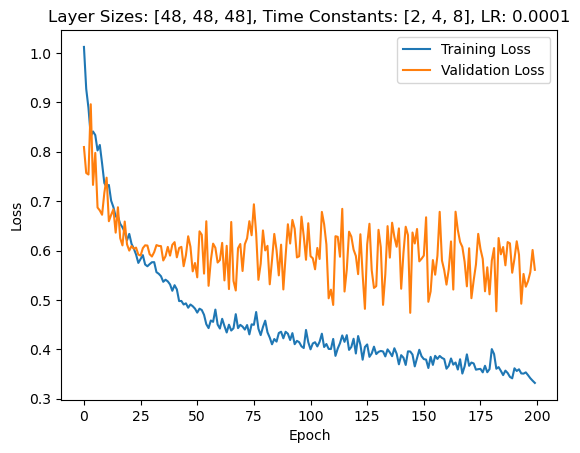

  0%|          | 1/200 [00:14<47:42, 14.39s/it]

Epoch 1/200, Training Loss: 1.1021793057333749, Validation Loss: 0.8947073327643531


  1%|          | 2/200 [00:28<47:39, 14.44s/it]

Epoch 2/200, Training Loss: 0.8305106140532583, Validation Loss: 0.8040774720055717


  2%|▏         | 3/200 [00:43<47:12, 14.38s/it]

Epoch 3/200, Training Loss: 0.8097947110544961, Validation Loss: 0.7177027293613979


  2%|▏         | 4/200 [00:56<45:44, 14.00s/it]

Epoch 4/200, Training Loss: 0.7353078987238542, Validation Loss: 0.7681422659329006


  2%|▎         | 5/200 [01:10<44:50, 13.80s/it]

Epoch 5/200, Training Loss: 0.762547474987102, Validation Loss: 0.71707655276571


  3%|▎         | 6/200 [01:24<45:45, 14.15s/it]

Epoch 6/200, Training Loss: 0.721642221482295, Validation Loss: 0.737198816878455


  4%|▎         | 7/200 [01:39<45:45, 14.22s/it]

Epoch 7/200, Training Loss: 0.7009094931044668, Validation Loss: 0.6442346402576992


  4%|▍         | 8/200 [01:53<45:33, 14.24s/it]

Epoch 8/200, Training Loss: 0.6840668584940568, Validation Loss: 0.6390643119812012


  4%|▍         | 9/200 [02:08<45:56, 14.43s/it]

Epoch 9/200, Training Loss: 0.6723640864750124, Validation Loss: 0.7159533330372402


  5%|▌         | 10/200 [02:22<45:16, 14.30s/it]

Epoch 10/200, Training Loss: 0.6901068271331068, Validation Loss: 0.7046771453959602


  6%|▌         | 11/200 [02:35<44:22, 14.09s/it]

Epoch 11/200, Training Loss: 0.6148391609906025, Validation Loss: 0.6796634580407824


  6%|▌         | 12/200 [02:50<44:50, 14.31s/it]

Epoch 12/200, Training Loss: 0.608336127029275, Validation Loss: 0.5296819337776729


  6%|▋         | 13/200 [03:04<44:01, 14.12s/it]

Epoch 13/200, Training Loss: 0.646010308895471, Validation Loss: 0.6236683747598103


  7%|▋         | 14/200 [03:17<43:06, 13.91s/it]

Epoch 14/200, Training Loss: 0.5954994950092064, Validation Loss: 0.6077979760510581


  8%|▊         | 15/200 [03:32<43:26, 14.09s/it]

Epoch 15/200, Training Loss: 0.5905253021222241, Validation Loss: 0.5843842370169503


  8%|▊         | 16/200 [03:46<42:58, 14.01s/it]

Epoch 16/200, Training Loss: 0.6188414872817274, Validation Loss: 0.5962708422115871


  8%|▊         | 17/200 [03:59<42:10, 13.83s/it]

Epoch 17/200, Training Loss: 0.560786173028766, Validation Loss: 0.5412408241203853


  9%|▉         | 18/200 [04:13<41:57, 13.83s/it]

Epoch 18/200, Training Loss: 0.5487449708974587, Validation Loss: 0.6004154171262469


 10%|▉         | 19/200 [04:27<42:02, 13.93s/it]

Epoch 19/200, Training Loss: 0.5498614479910653, Validation Loss: 0.6154299314532962


 10%|█         | 20/200 [04:41<42:01, 14.01s/it]

Epoch 20/200, Training Loss: 0.5439120514212914, Validation Loss: 0.5847972461155483


 10%|█         | 21/200 [04:55<41:23, 13.88s/it]

Epoch 21/200, Training Loss: 0.5847673168722188, Validation Loss: 0.5568500714642661


 11%|█         | 22/200 [05:09<41:21, 13.94s/it]

Epoch 22/200, Training Loss: 0.5384065126473049, Validation Loss: 0.5888075019632067


 12%|█▏        | 23/200 [05:23<41:28, 14.06s/it]

Epoch 23/200, Training Loss: 0.5096274819576515, Validation Loss: 0.5484931894711086


 12%|█▏        | 24/200 [05:37<41:03, 14.00s/it]

Epoch 24/200, Training Loss: 0.5111954060365569, Validation Loss: 0.5920583350317818


 12%|█▎        | 25/200 [05:51<40:49, 14.00s/it]

Epoch 25/200, Training Loss: 0.4977299301129467, Validation Loss: 0.5508665485041482


 13%|█▎        | 26/200 [06:05<40:07, 13.84s/it]

Epoch 26/200, Training Loss: 0.4769852372272959, Validation Loss: 0.5131463174309049


 14%|█▎        | 27/200 [06:18<39:35, 13.73s/it]

Epoch 27/200, Training Loss: 0.49796523463051273, Validation Loss: 0.6382720598152706


 14%|█▍        | 28/200 [06:32<39:34, 13.80s/it]

Epoch 28/200, Training Loss: 0.4930708115955569, Validation Loss: 0.5611919292381832


 14%|█▍        | 29/200 [06:46<39:14, 13.77s/it]

Epoch 29/200, Training Loss: 0.45558517777694846, Validation Loss: 0.528460042817252


 15%|█▌        | 30/200 [06:59<38:37, 13.63s/it]

Epoch 30/200, Training Loss: 0.4509892061633884, Validation Loss: 0.5424572953156063


 16%|█▌        | 31/200 [07:13<38:43, 13.75s/it]

Epoch 31/200, Training Loss: 0.44402279212789714, Validation Loss: 0.5021253313337054


 16%|█▌        | 32/200 [07:28<39:05, 13.96s/it]

Epoch 32/200, Training Loss: 0.43661162763271694, Validation Loss: 0.48980524284499033


 16%|█▋        | 33/200 [07:41<38:38, 13.89s/it]

Epoch 33/200, Training Loss: 0.40708841355341785, Validation Loss: 0.499709746667317


 17%|█▋        | 34/200 [07:56<39:08, 14.15s/it]

Epoch 34/200, Training Loss: 0.42808128359182823, Validation Loss: 0.4813051809157644


 18%|█▊        | 35/200 [08:10<38:43, 14.08s/it]

Epoch 35/200, Training Loss: 0.4017753227139419, Validation Loss: 0.4241296478680202


 18%|█▊        | 36/200 [08:24<38:03, 13.92s/it]

Epoch 36/200, Training Loss: 0.3547404847757996, Validation Loss: 0.4448129343135016


 18%|█▊        | 37/200 [08:37<37:39, 13.86s/it]

Epoch 37/200, Training Loss: 0.3925637972523581, Validation Loss: 0.43644688597747255


 19%|█▉        | 38/200 [08:51<37:27, 13.88s/it]

Epoch 38/200, Training Loss: 0.3643578396372075, Validation Loss: 0.5713379787547248


 20%|█▉        | 39/200 [09:05<36:56, 13.77s/it]

Epoch 39/200, Training Loss: 0.3748714639893118, Validation Loss: 0.41388317729745594


 20%|██        | 40/200 [09:18<36:25, 13.66s/it]

Epoch 40/200, Training Loss: 0.3734764212144996, Validation Loss: 0.7081966357571738


 20%|██        | 41/200 [09:32<36:31, 13.78s/it]

Epoch 41/200, Training Loss: 0.4321099189373682, Validation Loss: 0.5002153430666242


 21%|██        | 42/200 [09:46<36:13, 13.75s/it]

Epoch 42/200, Training Loss: 0.41292161143051004, Validation Loss: 0.4575385408742087


 22%|██▏       | 43/200 [10:00<36:19, 13.88s/it]

Epoch 43/200, Training Loss: 0.3891007280293501, Validation Loss: 0.3909930948700224


 22%|██▏       | 44/200 [10:14<36:21, 13.98s/it]

Epoch 44/200, Training Loss: 0.3486845282451162, Validation Loss: 0.5651587785354683


 22%|██▎       | 45/200 [10:28<35:52, 13.89s/it]

Epoch 45/200, Training Loss: 0.3644203095222419, Validation Loss: 0.4566477345568793


 23%|██▎       | 46/200 [10:42<35:26, 13.81s/it]

Epoch 46/200, Training Loss: 0.40423993203999864, Validation Loss: 0.4375211958374296


 24%|██▎       | 47/200 [10:57<36:11, 14.19s/it]

Epoch 47/200, Training Loss: 0.3436803601260455, Validation Loss: 0.46985795881067005


 24%|██▍       | 48/200 [11:10<35:36, 14.06s/it]

Epoch 48/200, Training Loss: 0.36305570011993626, Validation Loss: 0.43683300060885294


 24%|██▍       | 49/200 [11:24<34:56, 13.88s/it]

Epoch 49/200, Training Loss: 0.3412257416068383, Validation Loss: 0.41528197484357016


 25%|██▌       | 50/200 [11:38<34:39, 13.86s/it]

Epoch 50/200, Training Loss: 0.3386561253441955, Validation Loss: 0.49499619539294926


 26%|██▌       | 51/200 [11:51<34:24, 13.85s/it]

Epoch 51/200, Training Loss: 0.3796519414996201, Validation Loss: 0.42464354421411243


 26%|██▌       | 52/200 [12:05<34:04, 13.81s/it]

Epoch 52/200, Training Loss: 0.39778863146619975, Validation Loss: 0.3828667380980083


 26%|██▋       | 53/200 [12:19<33:46, 13.79s/it]

Epoch 53/200, Training Loss: 0.33128665682842146, Validation Loss: 0.4407750091382435


 27%|██▋       | 54/200 [12:33<33:42, 13.85s/it]

Epoch 54/200, Training Loss: 0.33057559394049196, Validation Loss: 0.41783012236867634


 28%|██▊       | 55/200 [12:47<33:30, 13.87s/it]

Epoch 55/200, Training Loss: 0.3497716891315748, Validation Loss: 0.4036801372255598


 28%|██▊       | 56/200 [13:01<33:41, 14.04s/it]

Epoch 56/200, Training Loss: 0.3137633429383332, Validation Loss: 0.3949263244867325


 28%|██▊       | 57/200 [13:15<33:28, 14.05s/it]

Epoch 57/200, Training Loss: 0.32820308573965756, Validation Loss: 0.49419939305101124


 29%|██▉       | 58/200 [13:29<32:48, 13.87s/it]

Epoch 58/200, Training Loss: 0.3453207291522116, Validation Loss: 0.4832430322255407


 30%|██▉       | 59/200 [13:43<33:05, 14.08s/it]

Epoch 59/200, Training Loss: 0.3333229419757735, Validation Loss: 0.40891009143420626


 30%|███       | 60/200 [13:58<32:59, 14.14s/it]

Epoch 60/200, Training Loss: 0.32860047862214864, Validation Loss: 0.39133323303290773


 30%|███       | 61/200 [14:11<32:13, 13.91s/it]

Epoch 61/200, Training Loss: 0.33864497758869855, Validation Loss: 0.4192850376878466


 31%|███       | 62/200 [14:24<31:41, 13.78s/it]

Epoch 62/200, Training Loss: 0.3372464770416044, Validation Loss: 0.3982993832656315


 32%|███▏      | 63/200 [14:38<31:35, 13.84s/it]

Epoch 63/200, Training Loss: 0.34550972704617483, Validation Loss: 0.3783134605203356


 32%|███▏      | 64/200 [14:52<31:24, 13.86s/it]

Epoch 64/200, Training Loss: 0.3178908110789533, Validation Loss: 0.43947367795876097


 32%|███▎      | 65/200 [15:06<30:56, 13.75s/it]

Epoch 65/200, Training Loss: 0.32894025644603764, Validation Loss: 0.3793856884752001


 33%|███▎      | 66/200 [15:20<30:44, 13.76s/it]

Epoch 66/200, Training Loss: 0.31892396256608785, Validation Loss: 0.4483026713132858


 34%|███▎      | 67/200 [15:34<30:50, 13.91s/it]

Epoch 67/200, Training Loss: 0.2999114186133979, Validation Loss: 0.42125074352536884


 34%|███▍      | 68/200 [15:49<31:17, 14.23s/it]

Epoch 68/200, Training Loss: 0.33345031653935053, Validation Loss: 0.47258904363427845


 34%|███▍      | 69/200 [16:03<30:56, 14.17s/it]

Epoch 69/200, Training Loss: 0.32846763322375855, Validation Loss: 0.4462234228849411


 35%|███▌      | 70/200 [16:17<30:32, 14.10s/it]

Epoch 70/200, Training Loss: 0.29653507414853797, Validation Loss: 0.41250497315611157


 36%|███▌      | 71/200 [16:31<30:32, 14.21s/it]

Epoch 71/200, Training Loss: 0.31712869090853996, Validation Loss: 0.429411170738084


 36%|███▌      | 72/200 [16:45<30:04, 14.09s/it]

Epoch 72/200, Training Loss: 0.2974655345644591, Validation Loss: 0.4074665776320866


 36%|███▋      | 73/200 [16:59<29:45, 14.06s/it]

Epoch 73/200, Training Loss: 0.28448586784443763, Validation Loss: 0.5819928092615945


 37%|███▋      | 74/200 [17:13<29:11, 13.90s/it]

Epoch 74/200, Training Loss: 0.3150322835119265, Validation Loss: 0.3936759829521179


 38%|███▊      | 75/200 [17:26<28:43, 13.79s/it]

Epoch 75/200, Training Loss: 0.3171653145889066, Validation Loss: 0.3866146377154759


 38%|███▊      | 76/200 [17:41<28:51, 13.97s/it]

Epoch 76/200, Training Loss: 0.33528110539575795, Validation Loss: 0.4597942552396229


 38%|███▊      | 77/200 [17:54<28:19, 13.82s/it]

Epoch 77/200, Training Loss: 0.3239870883946149, Validation Loss: 0.4112148348774229


 39%|███▉      | 78/200 [18:08<27:54, 13.72s/it]

Epoch 78/200, Training Loss: 0.3075663577413784, Validation Loss: 0.40600849262305666


 40%|███▉      | 79/200 [18:22<27:58, 13.87s/it]

Epoch 79/200, Training Loss: 0.3237065667251371, Validation Loss: 0.4092822926385062


 40%|████      | 80/200 [18:36<28:07, 14.06s/it]

Epoch 80/200, Training Loss: 0.3115527080196255, Validation Loss: 0.44309314446789877


 40%|████      | 81/200 [18:50<27:33, 13.90s/it]

Epoch 81/200, Training Loss: 0.298328069302271, Validation Loss: 0.4408667343003409


 41%|████      | 82/200 [19:04<27:23, 13.93s/it]

Epoch 82/200, Training Loss: 0.29461017405649403, Validation Loss: 0.4435517426048006


 42%|████▏     | 83/200 [19:18<27:08, 13.92s/it]

Epoch 83/200, Training Loss: 0.2995702284124662, Validation Loss: 0.3959923599447523


 42%|████▏     | 84/200 [19:32<27:10, 14.05s/it]

Epoch 84/200, Training Loss: 0.2909935605975817, Validation Loss: 0.3980778604745865


 42%|████▎     | 85/200 [19:46<26:59, 14.08s/it]

Epoch 85/200, Training Loss: 0.28824170721027087, Validation Loss: 0.43673753312655855


 43%|████▎     | 86/200 [20:00<26:43, 14.06s/it]

Epoch 86/200, Training Loss: 0.2645680494606495, Validation Loss: 0.42872822071824757


 44%|████▎     | 87/200 [20:14<26:12, 13.92s/it]

Epoch 87/200, Training Loss: 0.3036593380120565, Validation Loss: 0.4069865963288716


 44%|████▍     | 88/200 [20:28<25:59, 13.92s/it]

Epoch 88/200, Training Loss: 0.28470428414502236, Validation Loss: 0.446755479489054


 44%|████▍     | 89/200 [20:42<25:47, 13.94s/it]

Epoch 89/200, Training Loss: 0.3000199244410362, Validation Loss: 0.4267429155962808


 45%|████▌     | 90/200 [20:55<25:19, 13.81s/it]

Epoch 90/200, Training Loss: 0.2872945618516994, Validation Loss: 0.49765235824244364


 46%|████▌     | 91/200 [21:09<24:56, 13.73s/it]

Epoch 91/200, Training Loss: 0.2866925746202469, Validation Loss: 0.43043226429394316


 46%|████▌     | 92/200 [21:23<25:05, 13.94s/it]

Epoch 92/200, Training Loss: 0.26693731251190295, Validation Loss: 0.4551287165709904


 46%|████▋     | 93/200 [21:37<25:03, 14.05s/it]

Epoch 93/200, Training Loss: 0.2697455073302647, Validation Loss: 0.43467745397772106


 47%|████▋     | 94/200 [21:51<24:44, 14.01s/it]

Epoch 94/200, Training Loss: 0.2598813588045678, Validation Loss: 0.4661301374435425


 48%|████▊     | 95/200 [22:06<24:38, 14.08s/it]

Epoch 95/200, Training Loss: 0.26467761397361755, Validation Loss: 0.38662438307489666


 48%|████▊     | 96/200 [22:20<24:32, 14.16s/it]

Epoch 96/200, Training Loss: 0.2530321404337883, Validation Loss: 0.43512289438928875


 48%|████▊     | 97/200 [22:34<24:05, 14.04s/it]

Epoch 97/200, Training Loss: 0.2555409958058933, Validation Loss: 0.4170210893665041


 49%|████▉     | 98/200 [22:48<23:56, 14.09s/it]

Epoch 98/200, Training Loss: 0.25842180089005884, Validation Loss: 0.3944814141307558


 50%|████▉     | 99/200 [23:02<23:33, 14.00s/it]

Epoch 99/200, Training Loss: 0.2697129637565253, Validation Loss: 0.43108364726815906


 50%|█████     | 100/200 [23:15<23:04, 13.84s/it]

Epoch 100/200, Training Loss: 0.2881661529810923, Validation Loss: 0.4294390891279493


 50%|█████     | 101/200 [23:29<22:55, 13.90s/it]

Epoch 101/200, Training Loss: 0.27195345975880353, Validation Loss: 0.39133983637605396


 51%|█████     | 102/200 [23:43<22:44, 13.93s/it]

Epoch 102/200, Training Loss: 0.2722253608253767, Validation Loss: 0.4137897619179317


 52%|█████▏    | 103/200 [23:57<22:28, 13.90s/it]

Epoch 103/200, Training Loss: 0.24606168284168783, Validation Loss: 0.390713489481381


 52%|█████▏    | 104/200 [24:11<22:21, 13.97s/it]

Epoch 104/200, Training Loss: 0.2576038623755833, Validation Loss: 0.3709940825189863


 52%|█████▎    | 105/200 [24:26<22:29, 14.20s/it]

Epoch 105/200, Training Loss: 0.2644722115881038, Validation Loss: 0.446282691189221


 53%|█████▎    | 106/200 [24:40<22:02, 14.07s/it]

Epoch 106/200, Training Loss: 0.26033497939132294, Validation Loss: 0.47878686232226236


 54%|█████▎    | 107/200 [24:54<21:42, 14.01s/it]

Epoch 107/200, Training Loss: 0.24675726707813875, Validation Loss: 0.4228809688772474


 54%|█████▍    | 108/200 [25:09<21:57, 14.32s/it]

Epoch 108/200, Training Loss: 0.25690670072470073, Validation Loss: 0.4274079033306667


 55%|█████▍    | 109/200 [25:22<21:30, 14.18s/it]

Epoch 109/200, Training Loss: 0.24626453333305862, Validation Loss: 0.40895161032676697


 55%|█████▌    | 110/200 [25:36<21:04, 14.05s/it]

Epoch 110/200, Training Loss: 0.2587121306865845, Validation Loss: 0.39754935247557505


 56%|█████▌    | 111/200 [25:50<20:53, 14.08s/it]

Epoch 111/200, Training Loss: 0.2594300997707079, Validation Loss: 0.4046386842216764


 56%|█████▌    | 112/200 [26:04<20:23, 13.90s/it]

Epoch 112/200, Training Loss: 0.24063653386426423, Validation Loss: 0.4010091594287327


 56%|█████▋    | 113/200 [26:17<20:00, 13.80s/it]

Epoch 113/200, Training Loss: 0.24451171522432902, Validation Loss: 0.4357025495597294


 57%|█████▋    | 114/200 [26:32<19:58, 13.93s/it]

Epoch 114/200, Training Loss: 0.24761515159933073, Validation Loss: 0.3755295936550413


 57%|█████▊    | 115/200 [26:46<19:43, 13.92s/it]

Epoch 115/200, Training Loss: 0.25919662683077577, Validation Loss: 0.44538251204150064


 58%|█████▊    | 116/200 [26:59<19:29, 13.92s/it]

Epoch 116/200, Training Loss: 0.24680736323572555, Validation Loss: 0.4023859330586025


 58%|█████▊    | 117/200 [27:14<19:35, 14.16s/it]

Epoch 117/200, Training Loss: 0.25722010496933506, Validation Loss: 0.45778741793973105


 59%|█████▉    | 118/200 [27:28<19:11, 14.04s/it]

Epoch 118/200, Training Loss: 0.24626255175977382, Validation Loss: 0.39278665823595865


 60%|█████▉    | 119/200 [27:42<18:49, 13.94s/it]

Epoch 119/200, Training Loss: 0.2525999500363503, Validation Loss: 0.48745144265038626


 60%|██████    | 120/200 [27:56<18:55, 14.19s/it]

Epoch 120/200, Training Loss: 0.23869561368845543, Validation Loss: 0.4254231495516641


 60%|██████    | 121/200 [28:11<18:40, 14.18s/it]

Epoch 121/200, Training Loss: 0.23616873177717318, Validation Loss: 0.47386528977325987


 61%|██████    | 122/200 [28:24<18:13, 14.02s/it]

Epoch 122/200, Training Loss: 0.2473921390636912, Validation Loss: 0.4354419027056013


 62%|██████▏   | 123/200 [28:38<17:58, 14.00s/it]

Epoch 123/200, Training Loss: 0.26435362849876565, Validation Loss: 0.42544577590056826


 62%|██████▏   | 124/200 [28:52<17:45, 14.01s/it]

Epoch 124/200, Training Loss: 0.24524308516169493, Validation Loss: 0.39742580694811686


 62%|██████▎   | 125/200 [29:06<17:20, 13.88s/it]

Epoch 125/200, Training Loss: 0.2241250475481996, Validation Loss: 0.3992905020713806


 63%|██████▎   | 126/200 [29:20<17:03, 13.83s/it]

Epoch 126/200, Training Loss: 0.2438800607649785, Validation Loss: 0.43799654713698793


 64%|██████▎   | 127/200 [29:34<16:55, 13.91s/it]

Epoch 127/200, Training Loss: 0.22791338711977005, Validation Loss: 0.4313871477331434


 64%|██████▍   | 128/200 [29:48<16:43, 13.93s/it]

Epoch 128/200, Training Loss: 0.22878452573182448, Validation Loss: 0.42059507966041565


 64%|██████▍   | 129/200 [30:02<16:37, 14.05s/it]

Epoch 129/200, Training Loss: 0.24450539881890676, Validation Loss: 0.4315904144729887


 65%|██████▌   | 130/200 [30:16<16:28, 14.12s/it]

Epoch 130/200, Training Loss: 0.2650556800500402, Validation Loss: 0.41526187104838236


 66%|██████▌   | 131/200 [30:30<16:03, 13.96s/it]

Epoch 131/200, Training Loss: 0.239622101047129, Validation Loss: 0.41406765580177307


 66%|██████▌   | 132/200 [30:44<16:01, 14.14s/it]

Epoch 132/200, Training Loss: 0.23875206245004005, Validation Loss: 0.412003864135061


 66%|██████▋   | 133/200 [30:59<15:48, 14.15s/it]

Epoch 133/200, Training Loss: 0.2663330285335487, Validation Loss: 0.4015009530952999


 67%|██████▋   | 134/200 [31:12<15:26, 14.03s/it]

Epoch 134/200, Training Loss: 0.2729312109778512, Validation Loss: 0.4083219681467329


 68%|██████▊   | 135/200 [31:26<15:02, 13.88s/it]

Epoch 135/200, Training Loss: 0.2240813210747152, Validation Loss: 0.4158565806491034


 68%|██████▊   | 136/200 [31:40<14:52, 13.95s/it]

Epoch 136/200, Training Loss: 0.2236427370247976, Validation Loss: 0.46560421160289217


 68%|██████▊   | 137/200 [31:54<14:37, 13.93s/it]

Epoch 137/200, Training Loss: 0.22305397422246212, Validation Loss: 0.4477687350341252


 69%|██████▉   | 138/200 [32:07<14:16, 13.82s/it]

Epoch 138/200, Training Loss: 0.22883314305459554, Validation Loss: 0.3938869280474527


 70%|██████▉   | 139/200 [32:21<14:00, 13.77s/it]

Epoch 139/200, Training Loss: 0.2368428537024642, Validation Loss: 0.4116365441254207


 70%|███████   | 140/200 [32:36<14:00, 14.01s/it]

Epoch 140/200, Training Loss: 0.22987516653144136, Validation Loss: 0.44085206730025156


 70%|███████   | 141/200 [32:50<13:53, 14.12s/it]

Epoch 141/200, Training Loss: 0.2331380827246972, Validation Loss: 0.43022050176348003


 71%|███████   | 142/200 [33:04<13:32, 14.00s/it]

Epoch 142/200, Training Loss: 0.23283086527349814, Validation Loss: 0.4054868881191526


 72%|███████▏  | 143/200 [33:18<13:20, 14.05s/it]

Epoch 143/200, Training Loss: 0.2177603743829817, Validation Loss: 0.4628628045320511


 72%|███████▏  | 144/200 [33:33<13:16, 14.22s/it]

Epoch 144/200, Training Loss: 0.2224118930270087, Validation Loss: 0.40077285042830874


 72%|███████▎  | 145/200 [33:47<13:05, 14.28s/it]

Epoch 145/200, Training Loss: 0.23040987860481693, Validation Loss: 0.4389700378690447


 73%|███████▎  | 146/200 [34:01<12:50, 14.26s/it]

Epoch 146/200, Training Loss: 0.2764178979790436, Validation Loss: 0.4367873562233789


 74%|███████▎  | 147/200 [34:15<12:25, 14.06s/it]

Epoch 147/200, Training Loss: 0.21934753515810337, Validation Loss: 0.42314108993325916


 74%|███████▍  | 148/200 [34:28<12:02, 13.89s/it]

Epoch 148/200, Training Loss: 0.21553573054525088, Validation Loss: 0.42823924124240875


 74%|███████▍  | 149/200 [34:42<11:52, 13.97s/it]

Epoch 149/200, Training Loss: 0.21319459617700218, Validation Loss: 0.44907064948763165


 75%|███████▌  | 150/200 [34:56<11:38, 13.96s/it]

Epoch 150/200, Training Loss: 0.22726279159761825, Validation Loss: 0.4318512167249407


 76%|███████▌  | 151/200 [35:10<11:19, 13.86s/it]

Epoch 151/200, Training Loss: 0.21839270853209045, Validation Loss: 0.45605471091611044


 76%|███████▌  | 152/200 [35:24<11:13, 14.03s/it]

Epoch 152/200, Training Loss: 0.2208111911730946, Validation Loss: 0.46753201527254923


 76%|███████▋  | 153/200 [35:39<11:09, 14.25s/it]

Epoch 153/200, Training Loss: 0.23387694105787096, Validation Loss: 0.42225709770406994


 77%|███████▋  | 154/200 [35:53<10:45, 14.03s/it]

Epoch 154/200, Training Loss: 0.24295339367862018, Validation Loss: 0.44618544408253263


 78%|███████▊  | 155/200 [36:07<10:30, 14.00s/it]

Epoch 155/200, Training Loss: 0.2096874826359299, Validation Loss: 0.4207979312964848


 78%|███████▊  | 156/200 [36:22<10:28, 14.28s/it]

Epoch 156/200, Training Loss: 0.21708915199873582, Validation Loss: 0.38933050632476807


 78%|███████▊  | 157/200 [36:35<10:06, 14.10s/it]

Epoch 157/200, Training Loss: 0.20442532733926233, Validation Loss: 0.4404736246381487


 79%|███████▉  | 158/200 [36:49<09:48, 14.01s/it]

Epoch 158/200, Training Loss: 0.21150069690819057, Validation Loss: 0.4854090852396829


 80%|███████▉  | 159/200 [37:03<09:36, 14.07s/it]

Epoch 159/200, Training Loss: 0.2285994565430677, Validation Loss: 0.4455014594963619


 80%|████████  | 160/200 [37:17<09:16, 13.92s/it]

Epoch 160/200, Training Loss: 0.22846809767608373, Validation Loss: 0.4321595536811011


 80%|████████  | 161/200 [37:30<08:59, 13.83s/it]

Epoch 161/200, Training Loss: 0.1999928168952465, Validation Loss: 0.44321723920958384


 81%|████████  | 162/200 [37:45<08:50, 13.95s/it]

Epoch 162/200, Training Loss: 0.20638610282034245, Validation Loss: 0.40839830892426626


 82%|████████▏ | 163/200 [37:58<08:34, 13.90s/it]

Epoch 163/200, Training Loss: 0.21218469050133004, Validation Loss: 0.4093744818653379


 82%|████████▏ | 164/200 [38:12<08:19, 13.86s/it]

Epoch 164/200, Training Loss: 0.2058341084223873, Validation Loss: 0.4241453600781305


 82%|████████▎ | 165/200 [38:27<08:15, 14.17s/it]

Epoch 165/200, Training Loss: 0.20533793539089976, Validation Loss: 0.4929212416921343


 83%|████████▎ | 166/200 [38:41<07:57, 14.04s/it]

Epoch 166/200, Training Loss: 0.21325869675514833, Validation Loss: 0.4556598535605839


 84%|████████▎ | 167/200 [38:56<07:51, 14.28s/it]

Epoch 167/200, Training Loss: 0.20806251564678155, Validation Loss: 0.4258208040680204


 84%|████████▍ | 168/200 [39:10<07:36, 14.26s/it]

Epoch 168/200, Training Loss: 0.18956595103976862, Validation Loss: 0.4905436209269932


 84%|████████▍ | 169/200 [39:24<07:17, 14.12s/it]

Epoch 169/200, Training Loss: 0.19066834639547006, Validation Loss: 0.44606783986091614


 85%|████████▌ | 170/200 [39:37<06:59, 13.98s/it]

Epoch 170/200, Training Loss: 0.19469314047469283, Validation Loss: 0.4312175640038082


 86%|████████▌ | 171/200 [39:51<06:45, 13.98s/it]

Epoch 171/200, Training Loss: 0.21635781059849937, Validation Loss: 0.45132107394082205


 86%|████████▌ | 172/200 [40:05<06:30, 13.96s/it]

Epoch 172/200, Training Loss: 0.21294232970982227, Validation Loss: 0.39711396396160126


 86%|████████▋ | 173/200 [40:19<06:16, 13.94s/it]

Epoch 173/200, Training Loss: 0.20893938178723714, Validation Loss: 0.49075241812637876


 87%|████████▋ | 174/200 [40:33<06:00, 13.87s/it]

Epoch 174/200, Training Loss: 0.1968873935347458, Validation Loss: 0.40483580955437254


 88%|████████▊ | 175/200 [40:47<05:51, 14.07s/it]

Epoch 175/200, Training Loss: 0.19974800761578218, Validation Loss: 0.483927709715707


 88%|████████▊ | 176/200 [41:02<05:39, 14.16s/it]

Epoch 176/200, Training Loss: 0.22690028331752093, Validation Loss: 0.41817107796669006


 88%|████████▊ | 177/200 [41:16<05:23, 14.07s/it]

Epoch 177/200, Training Loss: 0.1998457414502243, Validation Loss: 0.42680645414761137


 89%|████████▉ | 178/200 [41:30<05:10, 14.11s/it]

Epoch 178/200, Training Loss: 0.18146911614908362, Validation Loss: 0.40005600239549366


 90%|████████▉ | 179/200 [41:44<04:58, 14.21s/it]

Epoch 179/200, Training Loss: 0.20223368619972804, Validation Loss: 0.434830014194761


 90%|█████████ | 180/200 [41:58<04:42, 14.12s/it]

Epoch 180/200, Training Loss: 0.2106744205614306, Validation Loss: 0.375745564699173


 90%|█████████ | 181/200 [42:12<04:28, 14.13s/it]

Epoch 181/200, Training Loss: 0.20172422850188218, Validation Loss: 0.44201013445854187


 91%|█████████ | 182/200 [42:26<04:11, 13.99s/it]

Epoch 182/200, Training Loss: 0.20989178261666927, Validation Loss: 0.4785545532192503


 92%|█████████▏| 183/200 [42:40<03:55, 13.88s/it]

Epoch 183/200, Training Loss: 0.214862770348225, Validation Loss: 0.45885756611824036


 92%|█████████▏| 184/200 [42:54<03:42, 13.93s/it]

Epoch 184/200, Training Loss: 0.20671841003141314, Validation Loss: 0.48132856828825815


 92%|█████████▎| 185/200 [43:07<03:28, 13.90s/it]

Epoch 185/200, Training Loss: 0.20391117777886256, Validation Loss: 0.41156200425965445


 93%|█████████▎| 186/200 [43:21<03:14, 13.86s/it]

Epoch 186/200, Training Loss: 0.18887298476864706, Validation Loss: 0.404309943318367


 94%|█████████▎| 187/200 [43:35<03:01, 13.97s/it]

Epoch 187/200, Training Loss: 0.18490142129221052, Validation Loss: 0.48503606021404266


 94%|█████████▍| 188/200 [43:50<02:50, 14.19s/it]

Epoch 188/200, Training Loss: 0.1907094345902497, Validation Loss: 0.43939417387757984


 94%|█████████▍| 189/200 [44:04<02:34, 14.02s/it]

Epoch 189/200, Training Loss: 0.16998143831513962, Validation Loss: 0.449921829359872


 95%|█████████▌| 190/200 [44:18<02:19, 13.95s/it]

Epoch 190/200, Training Loss: 0.1811194194234767, Validation Loss: 0.40258699442659107


 96%|█████████▌| 191/200 [44:33<02:08, 14.29s/it]

Epoch 191/200, Training Loss: 0.2080520121556408, Validation Loss: 0.45306457366262165


 96%|█████████▌| 192/200 [44:46<01:53, 14.13s/it]

Epoch 192/200, Training Loss: 0.19856175499142342, Validation Loss: 0.40754416372094837


 96%|█████████▋| 193/200 [45:00<01:38, 14.00s/it]

Epoch 193/200, Training Loss: 0.20550157825620669, Validation Loss: 0.40902780847890036


 97%|█████████▋| 194/200 [45:14<01:24, 14.09s/it]

Epoch 194/200, Training Loss: 0.19191992592136814, Validation Loss: 0.41539274368967327


 98%|█████████▊| 195/200 [45:28<01:09, 13.93s/it]

Epoch 195/200, Training Loss: 0.18389396727928575, Validation Loss: 0.43170122376510073


 98%|█████████▊| 196/200 [45:42<00:55, 13.87s/it]

Epoch 196/200, Training Loss: 0.1892175279417128, Validation Loss: 0.3910923898220062


 98%|█████████▊| 197/200 [45:56<00:42, 14.04s/it]

Epoch 197/200, Training Loss: 0.18737498776249165, Validation Loss: 0.4660775661468506


 99%|█████████▉| 198/200 [46:10<00:27, 13.95s/it]

Epoch 198/200, Training Loss: 0.20258767874735706, Validation Loss: 0.43296330741473604


100%|█████████▉| 199/200 [46:24<00:13, 13.95s/it]

Epoch 199/200, Training Loss: 0.18892914299273267, Validation Loss: 0.4157960606472833


100%|██████████| 200/200 [46:39<00:00, 14.00s/it]

Epoch 200/200, Training Loss: 0.17052724149148418, Validation Loss: 0.4441175652401788
Final Accuracy: 96.11%, Precision: 0.97, Recall: 0.96


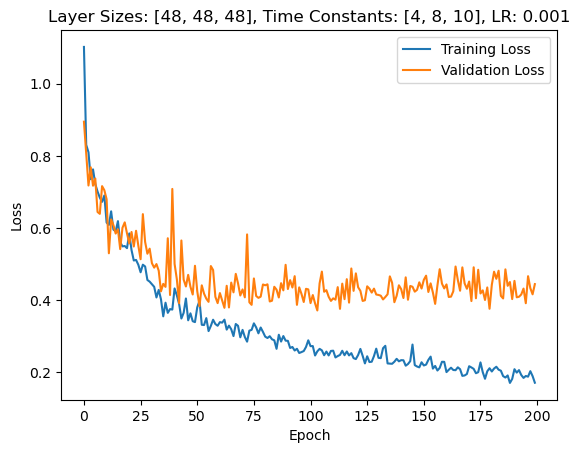

  0%|          | 1/200 [00:14<47:23, 14.29s/it]

Epoch 1/200, Training Loss: 1.0105586614248887, Validation Loss: 0.8454097381659916


  1%|          | 2/200 [00:28<46:53, 14.21s/it]

Epoch 2/200, Training Loss: 0.9436171279763276, Validation Loss: 0.7809147025857653


  2%|▏         | 3/200 [00:42<46:44, 14.24s/it]

Epoch 3/200, Training Loss: 0.9236663388756087, Validation Loss: 0.43798823016030447


  2%|▏         | 4/200 [00:56<45:23, 13.89s/it]

Epoch 4/200, Training Loss: 0.8930554952261582, Validation Loss: 0.7724654163633075


  2%|▎         | 5/200 [01:09<44:36, 13.73s/it]

Epoch 5/200, Training Loss: 0.7920052836526115, Validation Loss: 0.7295281397444862


  3%|▎         | 6/200 [01:24<45:16, 14.00s/it]

Epoch 6/200, Training Loss: 0.7092106471646507, Validation Loss: 0.7393789333956582


  4%|▎         | 7/200 [01:38<45:33, 14.16s/it]

Epoch 7/200, Training Loss: 0.6597994807756172, Validation Loss: 0.7502023449965886


  4%|▍         | 8/200 [01:52<45:21, 14.18s/it]

Epoch 8/200, Training Loss: 0.5915568448462576, Validation Loss: 0.7651935741305351


  4%|▍         | 9/200 [02:07<45:20, 14.24s/it]

Epoch 9/200, Training Loss: 0.618062103132032, Validation Loss: 0.8181703175817218


  5%|▌         | 10/200 [02:21<45:26, 14.35s/it]

Epoch 10/200, Training Loss: 0.6524019280694565, Validation Loss: 0.6469371744564602


  6%|▌         | 11/200 [02:35<44:13, 14.04s/it]

Epoch 11/200, Training Loss: 0.6080827724258855, Validation Loss: 0.8655991213662284


  6%|▌         | 12/200 [02:48<43:23, 13.85s/it]

Epoch 12/200, Training Loss: 0.701251577656224, Validation Loss: 0.7574053981474468


  6%|▋         | 13/200 [03:03<44:20, 14.23s/it]

Epoch 13/200, Training Loss: 0.5893506385245413, Validation Loss: 0.6467802737440381


  7%|▋         | 14/200 [03:17<43:22, 13.99s/it]

Epoch 14/200, Training Loss: 0.5982460070331141, Validation Loss: 0.7114484161138535


  8%|▊         | 15/200 [03:30<43:07, 13.99s/it]

Epoch 15/200, Training Loss: 0.6026481232553158, Validation Loss: 0.5414087006023952


  8%|▊         | 16/200 [03:45<43:48, 14.29s/it]

Epoch 16/200, Training Loss: 0.5840639157115288, Validation Loss: 0.6382144050938743


  8%|▊         | 17/200 [04:00<43:36, 14.30s/it]

Epoch 17/200, Training Loss: 0.5138277113437653, Validation Loss: 0.5898143031767437


  9%|▉         | 18/200 [04:13<42:30, 14.01s/it]

Epoch 18/200, Training Loss: 0.5621031258466109, Validation Loss: 0.8485564419201442


 10%|▉         | 19/200 [04:27<42:00, 13.92s/it]

Epoch 19/200, Training Loss: 0.7094970952789739, Validation Loss: 0.6196000427007675


 10%|█         | 20/200 [04:41<41:31, 13.84s/it]

Epoch 20/200, Training Loss: 0.6101566665577438, Validation Loss: 0.5694419188158852


 10%|█         | 21/200 [04:55<41:39, 13.96s/it]

Epoch 21/200, Training Loss: 0.6125691190080823, Validation Loss: 0.6414474355322974


 11%|█         | 22/200 [05:09<41:24, 13.96s/it]

Epoch 22/200, Training Loss: 0.572186807978828, Validation Loss: 0.6254690672670092


 12%|█▏        | 23/200 [05:22<41:00, 13.90s/it]

Epoch 23/200, Training Loss: 0.5729933307980591, Validation Loss: 0.6751046393598829


 12%|█▏        | 24/200 [05:36<40:22, 13.76s/it]

Epoch 24/200, Training Loss: 0.5894616814154499, Validation Loss: 0.6196555495262146


 12%|█▎        | 25/200 [05:50<40:36, 13.92s/it]

Epoch 25/200, Training Loss: 0.5742218300419034, Validation Loss: 0.7270424280847821


 13%|█▎        | 26/200 [06:04<40:28, 13.95s/it]

Epoch 26/200, Training Loss: 0.5712121190889826, Validation Loss: 0.6157905757427216


 14%|█▎        | 27/200 [06:18<39:43, 13.78s/it]

Epoch 27/200, Training Loss: 0.5366881962092418, Validation Loss: 0.6450101988656181


 14%|█▍        | 28/200 [06:31<39:10, 13.67s/it]

Epoch 28/200, Training Loss: 0.5022554813690905, Validation Loss: 0.7257012192692075


 14%|█▍        | 29/200 [06:45<39:04, 13.71s/it]

Epoch 29/200, Training Loss: 0.5071877879354189, Validation Loss: 0.6522297710180283


 15%|█▌        | 30/200 [06:58<38:44, 13.67s/it]

Epoch 30/200, Training Loss: 0.5194798932885224, Validation Loss: 0.7128440269402095


 16%|█▌        | 31/200 [07:12<38:15, 13.58s/it]

Epoch 31/200, Training Loss: 0.5120841534632556, Validation Loss: 0.4389916104929788


 16%|█▌        | 32/200 [07:26<38:17, 13.68s/it]

Epoch 32/200, Training Loss: 0.5130391745072491, Validation Loss: 0.612304048878806


 16%|█▋        | 33/200 [07:40<38:12, 13.73s/it]

Epoch 33/200, Training Loss: 0.4702506346522637, Validation Loss: 0.5157117268868855


 17%|█▋        | 34/200 [07:54<38:26, 13.89s/it]

Epoch 34/200, Training Loss: 0.5266645086823769, Validation Loss: 0.5170863206897464


 18%|█▊        | 35/200 [08:08<38:07, 13.86s/it]

Epoch 35/200, Training Loss: 0.4736715850402724, Validation Loss: 0.4590216257742473


 18%|█▊        | 36/200 [08:21<37:53, 13.86s/it]

Epoch 36/200, Training Loss: 0.45490496310423006, Validation Loss: 0.5001256572348731


 18%|█▊        | 37/200 [08:36<38:01, 13.99s/it]

Epoch 37/200, Training Loss: 0.48050460303729436, Validation Loss: 0.5664363482168743


 19%|█▉        | 38/200 [08:49<37:27, 13.87s/it]

Epoch 38/200, Training Loss: 0.4598523170318244, Validation Loss: 0.5784351719277245


 20%|█▉        | 39/200 [09:03<37:19, 13.91s/it]

Epoch 39/200, Training Loss: 0.503408153945545, Validation Loss: 0.5102058478764125


 20%|██        | 40/200 [09:17<36:47, 13.80s/it]

Epoch 40/200, Training Loss: 0.4733269318657101, Validation Loss: 0.6319837016718728


 20%|██        | 41/200 [09:30<36:11, 13.65s/it]

Epoch 41/200, Training Loss: 0.5166560858488083, Validation Loss: 0.5645690411329269


 21%|██        | 42/200 [09:44<36:04, 13.70s/it]

Epoch 42/200, Training Loss: 0.5021254276891924, Validation Loss: 0.5026362729924065


 22%|██▏       | 43/200 [09:58<35:44, 13.66s/it]

Epoch 43/200, Training Loss: 0.492668868235822, Validation Loss: 0.5469890875475747


 22%|██▏       | 44/200 [10:11<35:27, 13.64s/it]

Epoch 44/200, Training Loss: 0.5171417110371139, Validation Loss: 0.6011296042374202


 22%|██▎       | 45/200 [10:25<35:20, 13.68s/it]

Epoch 45/200, Training Loss: 0.4619093585126805, Validation Loss: 0.4783278554677963


 23%|██▎       | 46/200 [10:40<35:49, 13.96s/it]

Epoch 46/200, Training Loss: 0.5104433053506995, Validation Loss: 0.5107560498373849


 24%|██▎       | 47/200 [10:53<35:14, 13.82s/it]

Epoch 47/200, Training Loss: 0.4622416951746311, Validation Loss: 0.6099693179130554


 24%|██▍       | 48/200 [11:07<34:46, 13.72s/it]

Epoch 48/200, Training Loss: 0.4479285666965089, Validation Loss: 0.4800565711089543


 24%|██▍       | 49/200 [11:21<34:44, 13.81s/it]

Epoch 49/200, Training Loss: 0.4561982163280811, Validation Loss: 0.5227910578250885


 25%|██▌       | 50/200 [11:35<34:47, 13.91s/it]

Epoch 50/200, Training Loss: 0.48135619427797927, Validation Loss: 0.5358028411865234


 26%|██▌       | 51/200 [11:48<34:18, 13.81s/it]

Epoch 51/200, Training Loss: 0.48920930865800605, Validation Loss: 0.5931018122604915


 26%|██▌       | 52/200 [12:02<34:17, 13.90s/it]

Epoch 52/200, Training Loss: 0.5142964509860525, Validation Loss: 0.6181942054203579


 26%|██▋       | 53/200 [12:16<33:44, 13.77s/it]

Epoch 53/200, Training Loss: 0.47532584363559505, Validation Loss: 0.5470883420535496


 27%|██▋       | 54/200 [12:29<33:14, 13.66s/it]

Epoch 54/200, Training Loss: 0.43604968600677996, Validation Loss: 0.5250316645417895


 28%|██▊       | 55/200 [12:43<33:08, 13.71s/it]

Epoch 55/200, Training Loss: 0.4392862030357685, Validation Loss: 0.5849666765757969


 28%|██▊       | 56/200 [12:57<32:52, 13.70s/it]

Epoch 56/200, Training Loss: 0.41852924115252943, Validation Loss: 0.4881003882203783


 28%|██▊       | 57/200 [13:10<32:28, 13.62s/it]

Epoch 57/200, Training Loss: 0.442638838487976, Validation Loss: 0.5813802352973393


 29%|██▉       | 58/200 [13:24<32:27, 13.72s/it]

Epoch 58/200, Training Loss: 0.42819333371688734, Validation Loss: 0.5553064176014492


 30%|██▉       | 59/200 [13:39<33:02, 14.06s/it]

Epoch 59/200, Training Loss: 0.43593871368552156, Validation Loss: 0.54074498798166


 30%|███       | 60/200 [13:52<32:19, 13.85s/it]

Epoch 60/200, Training Loss: 0.4666855734474254, Validation Loss: 0.6867547588688987


 30%|███       | 61/200 [14:06<31:48, 13.73s/it]

Epoch 61/200, Training Loss: 0.4491111861084992, Validation Loss: 0.47541114687919617


 31%|███       | 62/200 [14:20<31:47, 13.82s/it]

Epoch 62/200, Training Loss: 0.4448364998372096, Validation Loss: 0.553267457655498


 32%|███▏      | 63/200 [14:34<32:03, 14.04s/it]

Epoch 63/200, Training Loss: 0.41112304464826044, Validation Loss: 0.4605604772056852


 32%|███▏      | 64/200 [14:48<31:26, 13.87s/it]

Epoch 64/200, Training Loss: 0.39516771739383916, Validation Loss: 0.5892662214381355


 32%|███▎      | 65/200 [15:02<31:14, 13.88s/it]

Epoch 65/200, Training Loss: 0.41068669310155903, Validation Loss: 0.4531330530132566


 33%|███▎      | 66/200 [15:15<30:46, 13.78s/it]

Epoch 66/200, Training Loss: 0.40527013689279556, Validation Loss: 0.5466863853590829


 34%|███▎      | 67/200 [15:29<30:24, 13.72s/it]

Epoch 67/200, Training Loss: 0.47761622774151136, Validation Loss: 0.5131192675658635


 34%|███▍      | 68/200 [15:43<30:12, 13.73s/it]

Epoch 68/200, Training Loss: 0.416611022263203, Validation Loss: 0.4458975408758436


 34%|███▍      | 69/200 [15:56<30:02, 13.76s/it]

Epoch 69/200, Training Loss: 0.4415105494125834, Validation Loss: 0.5953504059995923


 35%|███▌      | 70/200 [16:10<29:42, 13.71s/it]

Epoch 70/200, Training Loss: 0.4342809791834849, Validation Loss: 0.4998031237295696


 36%|███▌      | 71/200 [16:24<29:29, 13.72s/it]

Epoch 71/200, Training Loss: 0.43387014123628725, Validation Loss: 0.47743317059108187


 36%|███▌      | 72/200 [16:39<30:00, 14.07s/it]

Epoch 72/200, Training Loss: 0.4056962618850312, Validation Loss: 0.5566228926181793


 36%|███▋      | 73/200 [16:52<29:22, 13.88s/it]

Epoch 73/200, Training Loss: 0.44436270392165994, Validation Loss: 0.6349008253642491


 37%|███▋      | 74/200 [17:06<28:55, 13.77s/it]

Epoch 74/200, Training Loss: 0.4213117383561044, Validation Loss: 0.5638692038399833


 38%|███▊      | 75/200 [17:21<29:28, 14.15s/it]

Epoch 75/200, Training Loss: 0.42260495727916936, Validation Loss: 0.6273406829152789


 38%|███▊      | 76/200 [17:34<29:00, 14.03s/it]

Epoch 76/200, Training Loss: 0.40545507091677413, Validation Loss: 0.5331593879631588


 38%|███▊      | 77/200 [17:48<28:24, 13.86s/it]

Epoch 77/200, Training Loss: 0.40883747755356553, Validation Loss: 0.5777134214128766


 39%|███▉      | 78/200 [18:02<28:10, 13.85s/it]

Epoch 78/200, Training Loss: 0.4107892726952175, Validation Loss: 0.42817680537700653


 40%|███▉      | 79/200 [18:15<27:50, 13.81s/it]

Epoch 79/200, Training Loss: 0.42352965446013324, Validation Loss: 0.46609197344098774


 40%|████      | 80/200 [18:29<27:20, 13.67s/it]

Epoch 80/200, Training Loss: 0.44080430944010895, Validation Loss: 0.6199787131377629


 40%|████      | 81/200 [18:43<27:08, 13.69s/it]

Epoch 81/200, Training Loss: 0.42480034479555095, Validation Loss: 0.5833405341420855


 41%|████      | 82/200 [18:56<27:04, 13.77s/it]

Epoch 82/200, Training Loss: 0.4208753125847511, Validation Loss: 0.5795356971876962


 42%|████▏     | 83/200 [19:10<26:45, 13.72s/it]

Epoch 83/200, Training Loss: 0.4523982565920308, Validation Loss: 0.44451973693711416


 42%|████▏     | 84/200 [19:24<26:47, 13.85s/it]

Epoch 84/200, Training Loss: 0.3772826577132603, Validation Loss: 0.4710634670087269


 42%|████▎     | 85/200 [19:38<26:44, 13.95s/it]

Epoch 85/200, Training Loss: 0.41144187579739766, Validation Loss: 0.5026655410017286


 43%|████▎     | 86/200 [19:52<26:12, 13.80s/it]

Epoch 86/200, Training Loss: 0.3721835736958486, Validation Loss: 0.559860817023686


 44%|████▎     | 87/200 [20:05<25:47, 13.70s/it]

Epoch 87/200, Training Loss: 0.40766773401003964, Validation Loss: 0.448085110102381


 44%|████▍     | 88/200 [20:20<26:13, 14.05s/it]

Epoch 88/200, Training Loss: 0.4306500036761446, Validation Loss: 0.5019160253661019


 44%|████▍     | 89/200 [20:34<25:49, 13.96s/it]

Epoch 89/200, Training Loss: 0.41670011855521294, Validation Loss: 0.5499206568513598


 45%|████▌     | 90/200 [20:47<25:14, 13.77s/it]

Epoch 90/200, Training Loss: 0.38812056521199784, Validation Loss: 0.5485866750989642


 46%|████▌     | 91/200 [21:01<24:54, 13.71s/it]

Epoch 91/200, Training Loss: 0.3941881487954338, Validation Loss: 0.5706766886370522


 46%|████▌     | 92/200 [21:15<24:43, 13.73s/it]

Epoch 92/200, Training Loss: 0.38842549132850934, Validation Loss: 0.5302478160176959


 46%|████▋     | 93/200 [21:28<24:22, 13.67s/it]

Epoch 93/200, Training Loss: 0.386769582359296, Validation Loss: 0.5847814338547843


 47%|████▋     | 94/200 [21:42<24:02, 13.60s/it]

Epoch 94/200, Training Loss: 0.37258144144741995, Validation Loss: 0.5878742166927883


 48%|████▊     | 95/200 [21:56<23:59, 13.71s/it]

Epoch 95/200, Training Loss: 0.3794931240801541, Validation Loss: 0.43619206121989657


 48%|████▊     | 96/200 [22:09<23:45, 13.70s/it]

Epoch 96/200, Training Loss: 0.40054153524479774, Validation Loss: 0.45813773785318646


 48%|████▊     | 97/200 [22:24<23:51, 13.90s/it]

Epoch 97/200, Training Loss: 0.37241710160138475, Validation Loss: 0.5098928298269


 49%|████▉     | 98/200 [22:38<23:38, 13.90s/it]

Epoch 98/200, Training Loss: 0.3531059739443491, Validation Loss: 0.4858777139868055


 50%|████▉     | 99/200 [22:51<23:11, 13.78s/it]

Epoch 99/200, Training Loss: 0.4092081473121103, Validation Loss: 0.5496650551046643


 50%|█████     | 100/200 [23:06<23:19, 13.99s/it]

Epoch 100/200, Training Loss: 0.41212138561707623, Validation Loss: 0.6072798839637211


 50%|█████     | 101/200 [23:19<23:02, 13.96s/it]

Epoch 101/200, Training Loss: 0.36991744207323723, Validation Loss: 0.49426198857171194


 51%|█████     | 102/200 [23:33<22:43, 13.91s/it]

Epoch 102/200, Training Loss: 0.38037284112201547, Validation Loss: 0.5367229623453957


 52%|█████▏    | 103/200 [23:47<22:13, 13.75s/it]

Epoch 103/200, Training Loss: 0.3950576430784081, Validation Loss: 0.4554755134241922


 52%|█████▏    | 104/200 [24:00<21:53, 13.68s/it]

Epoch 104/200, Training Loss: 0.3590248005007798, Validation Loss: 0.5004571207932064


 52%|█████▎    | 105/200 [24:14<21:49, 13.78s/it]

Epoch 105/200, Training Loss: 0.3642554423719082, Validation Loss: 0.5102609992027283


 53%|█████▎    | 106/200 [24:28<21:28, 13.71s/it]

Epoch 106/200, Training Loss: 0.39794293931632674, Validation Loss: 0.7438126163823264


 54%|█████▎    | 107/200 [24:41<21:04, 13.60s/it]

Epoch 107/200, Training Loss: 0.37980602063098046, Validation Loss: 0.5272674007075173


 54%|█████▍    | 108/200 [24:55<21:05, 13.76s/it]

Epoch 108/200, Training Loss: 0.3716543713268244, Validation Loss: 0.5868575189794812


 55%|█████▍    | 109/200 [25:10<21:09, 13.95s/it]

Epoch 109/200, Training Loss: 0.38160483314181276, Validation Loss: 0.4629249700478145


 55%|█████▌    | 110/200 [25:23<20:45, 13.84s/it]

Epoch 110/200, Training Loss: 0.3580720556794472, Validation Loss: 0.4304491366658892


 56%|█████▌    | 111/200 [25:37<20:30, 13.82s/it]

Epoch 111/200, Training Loss: 0.3764597952084721, Validation Loss: 0.4324885606765747


 56%|█████▌    | 112/200 [25:51<20:37, 14.06s/it]

Epoch 112/200, Training Loss: 0.39664030215650237, Validation Loss: 0.5625483989715576


 56%|█████▋    | 113/200 [26:05<20:13, 13.95s/it]

Epoch 113/200, Training Loss: 0.396400695701815, Validation Loss: 0.5714685916900635


 57%|█████▋    | 114/200 [26:19<19:50, 13.84s/it]

Epoch 114/200, Training Loss: 0.40009752590701264, Validation Loss: 0.4709464396749224


 57%|█████▊    | 115/200 [26:33<19:36, 13.84s/it]

Epoch 115/200, Training Loss: 0.37580027838922897, Validation Loss: 0.5455978257315499


 58%|█████▊    | 116/200 [26:46<19:10, 13.70s/it]

Epoch 116/200, Training Loss: 0.3970271430487903, Validation Loss: 0.4482419661113194


 58%|█████▊    | 117/200 [26:59<18:50, 13.62s/it]

Epoch 117/200, Training Loss: 0.3865413648902245, Validation Loss: 0.4980461129120418


 59%|█████▉    | 118/200 [27:14<18:51, 13.79s/it]

Epoch 118/200, Training Loss: 0.34390549924013747, Validation Loss: 0.4823794535228184


 60%|█████▉    | 119/200 [27:27<18:28, 13.68s/it]

Epoch 119/200, Training Loss: 0.3872781260958258, Validation Loss: 0.5091650613716671


 60%|██████    | 120/200 [27:41<18:12, 13.66s/it]

Epoch 120/200, Training Loss: 0.36417862829172387, Validation Loss: 0.48354455828666687


 60%|██████    | 121/200 [27:55<18:22, 13.95s/it]

Epoch 121/200, Training Loss: 0.3778016155339637, Validation Loss: 0.4634898773261479


 61%|██████    | 122/200 [28:09<18:06, 13.94s/it]

Epoch 122/200, Training Loss: 0.38869920626001536, Validation Loss: 0.49201890400477816


 62%|██████▏   | 123/200 [28:23<17:42, 13.80s/it]

Epoch 123/200, Training Loss: 0.3714932667196922, Validation Loss: 0.545670075075967


 62%|██████▏   | 124/200 [28:36<17:26, 13.77s/it]

Epoch 124/200, Training Loss: 0.3429727180386489, Validation Loss: 0.4523551102195467


 62%|██████▎   | 125/200 [28:51<17:37, 14.10s/it]

Epoch 125/200, Training Loss: 0.3279651001376926, Validation Loss: 0.3918021449020931


 63%|██████▎   | 126/200 [29:05<17:14, 13.98s/it]

Epoch 126/200, Training Loss: 0.36856208066895324, Validation Loss: 0.41595215031078886


 64%|██████▎   | 127/200 [29:19<16:53, 13.88s/it]

Epoch 127/200, Training Loss: 0.36712434719193654, Validation Loss: 0.5251802674361638


 64%|██████▍   | 128/200 [29:33<16:43, 13.94s/it]

Epoch 128/200, Training Loss: 0.3763174351375058, Validation Loss: 0.4776500846658434


 64%|██████▍   | 129/200 [29:46<16:17, 13.76s/it]

Epoch 129/200, Training Loss: 0.3690461090432023, Validation Loss: 0.5425196673188891


 65%|██████▌   | 130/200 [30:00<16:01, 13.73s/it]

Epoch 130/200, Training Loss: 0.3439987119076387, Validation Loss: 0.46567271436963764


 66%|██████▌   | 131/200 [30:13<15:50, 13.77s/it]

Epoch 131/200, Training Loss: 0.36085513093561494, Validation Loss: 0.5276746324130467


 66%|██████▌   | 132/200 [30:27<15:35, 13.76s/it]

Epoch 132/200, Training Loss: 0.3585175891529839, Validation Loss: 0.4628148376941681


 66%|██████▋   | 133/200 [30:41<15:21, 13.75s/it]

Epoch 133/200, Training Loss: 0.35211133788216786, Validation Loss: 0.48079841477530344


 67%|██████▋   | 134/200 [30:55<15:21, 13.96s/it]

Epoch 134/200, Training Loss: 0.3930543232357727, Validation Loss: 0.4847355101789747


 68%|██████▊   | 135/200 [31:09<15:05, 13.93s/it]

Epoch 135/200, Training Loss: 0.35580323186685453, Validation Loss: 0.5607189067772457


 68%|██████▊   | 136/200 [31:23<14:44, 13.82s/it]

Epoch 136/200, Training Loss: 0.34247017567450144, Validation Loss: 0.4597042884145464


 68%|██████▊   | 137/200 [31:37<14:36, 13.91s/it]

Epoch 137/200, Training Loss: 0.33953789846514754, Validation Loss: 0.4737689367362431


 69%|██████▉   | 138/200 [31:53<15:10, 14.69s/it]

Epoch 138/200, Training Loss: 0.3272106571579879, Validation Loss: 0.5387156648295266


 70%|██████▉   | 139/200 [32:08<14:53, 14.65s/it]

Epoch 139/200, Training Loss: 0.35229202936280446, Validation Loss: 0.5252600482531956


 70%|███████   | 140/200 [32:22<14:34, 14.58s/it]

Epoch 140/200, Training Loss: 0.335897703496915, Validation Loss: 0.4910287410020828


 70%|███████   | 141/200 [32:37<14:28, 14.72s/it]

Epoch 141/200, Training Loss: 0.3392293671110891, Validation Loss: 0.43595394492149353


 71%|███████   | 142/200 [32:52<14:09, 14.65s/it]

Epoch 142/200, Training Loss: 0.355565681912989, Validation Loss: 0.45505331669534954


 72%|███████▏  | 143/200 [33:07<14:02, 14.78s/it]

Epoch 143/200, Training Loss: 0.3185629926200183, Validation Loss: 0.5270954327923911


 72%|███████▏  | 144/200 [33:23<13:59, 15.00s/it]

Epoch 144/200, Training Loss: 0.376502606666313, Validation Loss: 0.5162671634129116


 72%|███████▎  | 145/200 [33:38<13:43, 14.98s/it]

Epoch 145/200, Training Loss: 0.35956226795349483, Validation Loss: 0.4541131172861372


 73%|███████▎  | 146/200 [33:53<13:38, 15.16s/it]

Epoch 146/200, Training Loss: 0.33281657886954974, Validation Loss: 0.5072513265269143


 74%|███████▎  | 147/200 [34:08<13:23, 15.15s/it]

Epoch 147/200, Training Loss: 0.32578310595368437, Validation Loss: 0.5519589356013707


 74%|███████▍  | 148/200 [34:23<13:05, 15.10s/it]

Epoch 148/200, Training Loss: 0.32577394089608824, Validation Loss: 0.44507122678416117


 74%|███████▍  | 149/200 [34:38<12:42, 14.96s/it]

Epoch 149/200, Training Loss: 0.34257216484479186, Validation Loss: 0.4809627724545343


 75%|███████▌  | 150/200 [34:55<12:59, 15.59s/it]

Epoch 150/200, Training Loss: 0.3609109636185304, Validation Loss: 0.5253603628703526


 76%|███████▌  | 151/200 [35:09<12:29, 15.30s/it]

Epoch 151/200, Training Loss: 0.3517622583247018, Validation Loss: 0.5702074766159058


 76%|███████▌  | 152/200 [35:24<12:00, 15.01s/it]

Epoch 152/200, Training Loss: 0.3375333184903523, Validation Loss: 0.52530380657741


 76%|███████▋  | 153/200 [35:39<11:53, 15.18s/it]

Epoch 153/200, Training Loss: 0.3416178816894315, Validation Loss: 0.38530722686222624


 77%|███████▋  | 154/200 [35:54<11:25, 14.89s/it]

Epoch 154/200, Training Loss: 0.37458024356725084, Validation Loss: 0.4724124073982239


 78%|███████▊  | 155/200 [36:07<10:53, 14.52s/it]

Epoch 155/200, Training Loss: 0.32584660753326594, Validation Loss: 0.49037221499851774


 78%|███████▊  | 156/200 [36:22<10:41, 14.58s/it]

Epoch 156/200, Training Loss: 0.3351679026799382, Validation Loss: 0.41253408576760975


 78%|███████▊  | 157/200 [36:37<10:30, 14.67s/it]

Epoch 157/200, Training Loss: 0.3333281601937312, Validation Loss: 0.41224774931158337


 79%|███████▉  | 158/200 [36:52<10:23, 14.83s/it]

Epoch 158/200, Training Loss: 0.3484029081070198, Validation Loss: 0.5514041951724461


 80%|███████▉  | 159/200 [37:07<10:07, 14.83s/it]

Epoch 159/200, Training Loss: 0.3473198815899075, Validation Loss: 0.4628602819783347


 80%|████████  | 160/200 [37:21<09:48, 14.71s/it]

Epoch 160/200, Training Loss: 0.3445098045861946, Validation Loss: 0.4689062535762787


 80%|████████  | 161/200 [37:35<09:26, 14.52s/it]

Epoch 161/200, Training Loss: 0.3243270589495605, Validation Loss: 0.42543444463184904


 81%|████████  | 162/200 [37:51<09:26, 14.90s/it]

Epoch 162/200, Training Loss: 0.3234562508340152, Validation Loss: 0.4083612263202667


 82%|████████▏ | 163/200 [38:06<09:10, 14.88s/it]

Epoch 163/200, Training Loss: 0.3621124748913747, Validation Loss: 0.5113045998982021


 82%|████████▏ | 164/200 [38:20<08:48, 14.69s/it]

Epoch 164/200, Training Loss: 0.3275146931409836, Validation Loss: 0.44031472504138947


 82%|████████▎ | 165/200 [38:35<08:29, 14.55s/it]

Epoch 165/200, Training Loss: 0.32972815871801014, Validation Loss: 0.555080554315022


 83%|████████▎ | 166/200 [38:49<08:15, 14.57s/it]

Epoch 166/200, Training Loss: 0.3124974659591351, Validation Loss: 0.5315789495195661


 84%|████████▎ | 167/200 [39:03<07:52, 14.33s/it]

Epoch 167/200, Training Loss: 0.3446708729244628, Validation Loss: 0.5105264953204564


 84%|████████▍ | 168/200 [39:17<07:31, 14.12s/it]

Epoch 168/200, Training Loss: 0.3266726420173105, Validation Loss: 0.47904686842645916


 84%|████████▍ | 169/200 [39:31<07:18, 14.14s/it]

Epoch 169/200, Training Loss: 0.33864565277999303, Validation Loss: 0.481881388596126


 85%|████████▌ | 170/200 [39:46<07:18, 14.61s/it]

Epoch 170/200, Training Loss: 0.35245449222483727, Validation Loss: 0.4457195784364428


 86%|████████▌ | 171/200 [40:01<07:07, 14.74s/it]

Epoch 171/200, Training Loss: 0.3286824016919676, Validation Loss: 0.4662343178476606


 86%|████████▌ | 172/200 [40:17<06:55, 14.83s/it]

Epoch 172/200, Training Loss: 0.329895684741578, Validation Loss: 0.42475069633552004


 86%|████████▋ | 173/200 [40:31<06:35, 14.64s/it]

Epoch 173/200, Training Loss: 0.33210903659181773, Validation Loss: 0.43356359004974365


 87%|████████▋ | 174/200 [40:47<06:29, 14.99s/it]

Epoch 174/200, Training Loss: 0.3181001678952631, Validation Loss: 0.4957675678389413


 88%|████████▊ | 175/200 [41:01<06:11, 14.84s/it]

Epoch 175/200, Training Loss: 0.32516075698834546, Validation Loss: 0.44690556611333576


 88%|████████▊ | 176/200 [41:15<05:52, 14.68s/it]

Epoch 176/200, Training Loss: 0.32759350875638565, Validation Loss: 0.5236607832568032


 88%|████████▊ | 177/200 [41:30<05:37, 14.66s/it]

Epoch 177/200, Training Loss: 0.30928892459509505, Validation Loss: 0.5513028034142086


 89%|████████▉ | 178/200 [41:45<05:21, 14.63s/it]

Epoch 178/200, Training Loss: 0.31326407137906775, Validation Loss: 0.4436538943222591


 90%|████████▉ | 179/200 [41:59<05:03, 14.45s/it]

Epoch 179/200, Training Loss: 0.31750012976381015, Validation Loss: 0.49695889013154165


 90%|█████████ | 180/200 [42:13<04:47, 14.37s/it]

Epoch 180/200, Training Loss: 0.3083213799685802, Validation Loss: 0.40390500000544954


 90%|█████████ | 181/200 [42:28<04:36, 14.58s/it]

Epoch 181/200, Training Loss: 0.3473330135896521, Validation Loss: 0.49788010120391846


 91%|█████████ | 182/200 [42:43<04:26, 14.82s/it]

Epoch 182/200, Training Loss: 0.3263631408225815, Validation Loss: 0.4963845099721636


 92%|█████████▏| 183/200 [42:58<04:11, 14.81s/it]

Epoch 183/200, Training Loss: 0.3139288847176534, Validation Loss: 0.38956057173865183


 92%|█████████▏| 184/200 [43:12<03:55, 14.69s/it]

Epoch 184/200, Training Loss: 0.32858505057838727, Validation Loss: 0.43395725744111197


 92%|█████████▎| 185/200 [43:26<03:37, 14.52s/it]

Epoch 185/200, Training Loss: 0.35155757825891926, Validation Loss: 0.4613796983446394


 93%|█████████▎| 186/200 [43:42<03:26, 14.72s/it]

Epoch 186/200, Training Loss: 0.32574297909466726, Validation Loss: 0.37497382291725706


 94%|█████████▎| 187/200 [43:56<03:10, 14.69s/it]

Epoch 187/200, Training Loss: 0.3166608655790113, Validation Loss: 0.43970454164913725


 94%|█████████▍| 188/200 [44:11<02:55, 14.63s/it]

Epoch 188/200, Training Loss: 0.31681852858021575, Validation Loss: 0.5249803279127393


 94%|█████████▍| 189/200 [44:25<02:38, 14.43s/it]

Epoch 189/200, Training Loss: 0.30909003598510093, Validation Loss: 0.5118840081351144


 95%|█████████▌| 190/200 [44:39<02:23, 14.32s/it]

Epoch 190/200, Training Loss: 0.3037373051047325, Validation Loss: 0.42598760553768705


 96%|█████████▌| 191/200 [44:54<02:10, 14.45s/it]

Epoch 191/200, Training Loss: 0.3282109614250795, Validation Loss: 0.42782391394887653


 96%|█████████▌| 192/200 [45:07<01:54, 14.30s/it]

Epoch 192/200, Training Loss: 0.3176219636258089, Validation Loss: 0.5362191221543721


 96%|█████████▋| 193/200 [45:21<01:39, 14.19s/it]

Epoch 193/200, Training Loss: 0.30743677014449855, Validation Loss: 0.4687853753566742


 97%|█████████▋| 194/200 [45:36<01:26, 14.38s/it]

Epoch 194/200, Training Loss: 0.31621946535020506, Validation Loss: 0.41849187867982046


 98%|█████████▊| 195/200 [45:51<01:13, 14.62s/it]

Epoch 195/200, Training Loss: 0.3249979603965327, Validation Loss: 0.47450130752154757


 98%|█████████▊| 196/200 [46:05<00:57, 14.41s/it]

Epoch 196/200, Training Loss: 0.30714848595407773, Validation Loss: 0.4494809763772147


 98%|█████████▊| 197/200 [46:20<00:43, 14.39s/it]

Epoch 197/200, Training Loss: 0.3335756412092245, Validation Loss: 0.4672707830156599


 99%|█████████▉| 198/200 [46:35<00:29, 14.68s/it]

Epoch 198/200, Training Loss: 0.34057284582335995, Validation Loss: 0.48413745207445963


100%|█████████▉| 199/200 [46:49<00:14, 14.57s/it]

Epoch 199/200, Training Loss: 0.29466825948571257, Validation Loss: 0.42048713990620207


100%|██████████| 200/200 [47:03<00:00, 14.12s/it]

Epoch 200/200, Training Loss: 0.30085441315511485, Validation Loss: 0.433252215385437
Final Accuracy: 92.58%, Precision: 0.92, Recall: 0.93


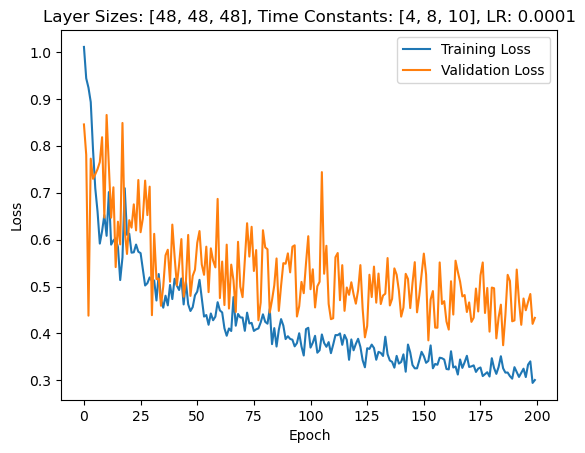

  0%|          | 1/200 [00:15<50:25, 15.20s/it]

Epoch 1/200, Training Loss: 2.4816583338773475, Validation Loss: 0.9707715766770499


  1%|          | 2/200 [00:29<49:13, 14.92s/it]

Epoch 2/200, Training Loss: 0.9316619702105252, Validation Loss: 1.2607898456709725


  2%|▏         | 3/200 [00:44<49:03, 14.94s/it]

Epoch 3/200, Training Loss: 0.7960000566716464, Validation Loss: 0.551478236913681


  2%|▏         | 4/200 [00:59<47:59, 14.69s/it]

Epoch 4/200, Training Loss: 0.5951347637851283, Validation Loss: 0.497648081609181


  2%|▎         | 5/200 [01:13<46:53, 14.43s/it]

Epoch 5/200, Training Loss: 0.5185066340666897, Validation Loss: 0.4662669769355229


  3%|▎         | 6/200 [01:28<47:33, 14.71s/it]

Epoch 6/200, Training Loss: 0.5097800316113346, Validation Loss: 0.4735912563545363


  4%|▎         | 7/200 [01:44<48:16, 15.01s/it]

Epoch 7/200, Training Loss: 0.4884065125348433, Validation Loss: 0.45781573014599936


  4%|▍         | 8/200 [01:59<48:06, 15.03s/it]

Epoch 8/200, Training Loss: 0.47453449975769474, Validation Loss: 0.4495289432150977


  4%|▍         | 9/200 [02:14<48:06, 15.12s/it]

Epoch 9/200, Training Loss: 0.4683289505400748, Validation Loss: 0.45114765209811075


  5%|▌         | 10/200 [02:29<47:50, 15.11s/it]

Epoch 10/200, Training Loss: 0.46774241918662807, Validation Loss: 0.460338861814567


  6%|▌         | 11/200 [02:43<46:53, 14.89s/it]

Epoch 11/200, Training Loss: 0.45261624104009485, Validation Loss: 0.42751433168138775


  6%|▌         | 12/200 [02:58<46:01, 14.69s/it]

Epoch 12/200, Training Loss: 0.43534548215146335, Validation Loss: 0.41695101984909605


  6%|▋         | 13/200 [03:13<46:18, 14.86s/it]

Epoch 13/200, Training Loss: 0.42808299947459744, Validation Loss: 0.4102433110986437


  7%|▋         | 14/200 [03:27<45:18, 14.61s/it]

Epoch 14/200, Training Loss: 0.41562483473768774, Validation Loss: 0.4293878142322813


  8%|▊         | 15/200 [03:42<45:28, 14.75s/it]

Epoch 15/200, Training Loss: 0.41866446300497595, Validation Loss: 0.4011418308530535


  8%|▊         | 16/200 [03:57<45:52, 14.96s/it]

Epoch 16/200, Training Loss: 0.3841363250646951, Validation Loss: 0.38202122279575895


  8%|▊         | 17/200 [04:12<45:25, 14.89s/it]

Epoch 17/200, Training Loss: 0.37698869927311845, Validation Loss: 0.38191316596099306


  9%|▉         | 18/200 [04:26<44:21, 14.62s/it]

Epoch 18/200, Training Loss: 0.3697655813873939, Validation Loss: 0.4093679040670395


 10%|▉         | 19/200 [04:41<44:01, 14.59s/it]

Epoch 19/200, Training Loss: 0.3762535960325655, Validation Loss: 0.3672742652041571


 10%|█         | 20/200 [04:55<43:19, 14.44s/it]

Epoch 20/200, Training Loss: 0.3559518951290059, Validation Loss: 0.3854809595005853


 10%|█         | 21/200 [05:10<43:32, 14.59s/it]

Epoch 21/200, Training Loss: 0.37758436349203, Validation Loss: 0.40727358417851584


 11%|█         | 22/200 [05:24<43:00, 14.50s/it]

Epoch 22/200, Training Loss: 0.3433677994839425, Validation Loss: 0.37970528432301115


 12%|█▏        | 23/200 [05:38<42:22, 14.37s/it]

Epoch 23/200, Training Loss: 0.3621458844193872, Validation Loss: 0.3794743908303125


 12%|█▏        | 24/200 [05:53<42:31, 14.50s/it]

Epoch 24/200, Training Loss: 0.3645422438967903, Validation Loss: 0.3625051145042692


 12%|█▎        | 25/200 [06:07<42:08, 14.45s/it]

Epoch 25/200, Training Loss: 0.33314682627623937, Validation Loss: 0.37790500691958834


 13%|█▎        | 26/200 [06:22<41:53, 14.45s/it]

Epoch 26/200, Training Loss: 0.3251389837208784, Validation Loss: 0.3628599856581007


 14%|█▎        | 27/200 [06:36<41:13, 14.30s/it]

Epoch 27/200, Training Loss: 0.36382486277593756, Validation Loss: 0.3904421925544739


 14%|█▍        | 28/200 [06:50<40:51, 14.25s/it]

Epoch 28/200, Training Loss: 0.3226932519168224, Validation Loss: 0.38645521444933756


 14%|█▍        | 29/200 [07:04<40:38, 14.26s/it]

Epoch 29/200, Training Loss: 0.31349440899519426, Validation Loss: 0.37794615966933115


 15%|█▌        | 30/200 [07:18<40:13, 14.20s/it]

Epoch 30/200, Training Loss: 0.30461945286336933, Validation Loss: 0.4028848281928471


 16%|█▌        | 31/200 [07:32<39:46, 14.12s/it]

Epoch 31/200, Training Loss: 0.30909925066637545, Validation Loss: 0.3559813116277967


 16%|█▌        | 32/200 [07:47<40:19, 14.40s/it]

Epoch 32/200, Training Loss: 0.33519510123527274, Validation Loss: 0.4225464516452381


 16%|█▋        | 33/200 [08:02<40:10, 14.44s/it]

Epoch 33/200, Training Loss: 0.2999712211905785, Validation Loss: 0.3876494062798364


 17%|█▋        | 34/200 [08:16<39:40, 14.34s/it]

Epoch 34/200, Training Loss: 0.2999667703121338, Validation Loss: 0.42341879861695425


 18%|█▊        | 35/200 [08:30<39:47, 14.47s/it]

Epoch 35/200, Training Loss: 0.30415294586487535, Validation Loss: 0.37717588032994953


 18%|█▊        | 36/200 [08:45<39:55, 14.61s/it]

Epoch 36/200, Training Loss: 0.27829251983115133, Validation Loss: 0.42986221398626057


 18%|█▊        | 37/200 [09:00<39:24, 14.51s/it]

Epoch 37/200, Training Loss: 0.2937316267557864, Validation Loss: 0.4069937456931387


 19%|█▉        | 38/200 [09:14<39:20, 14.57s/it]

Epoch 38/200, Training Loss: 0.28411451586574876, Validation Loss: 0.4156031236052513


 20%|█▉        | 39/200 [09:29<39:23, 14.68s/it]

Epoch 39/200, Training Loss: 0.2921631601902674, Validation Loss: 0.3775295168161392


 20%|██        | 40/200 [09:44<39:05, 14.66s/it]

Epoch 40/200, Training Loss: 0.2834486312601926, Validation Loss: 0.4197721928358078


 20%|██        | 41/200 [10:00<39:37, 14.95s/it]

Epoch 41/200, Training Loss: 0.3047780290527164, Validation Loss: 0.39980884534972055


 21%|██        | 42/200 [10:15<39:31, 15.01s/it]

Epoch 42/200, Training Loss: 0.2942636474826426, Validation Loss: 0.3862168001277106


 22%|██▏       | 43/200 [10:29<38:36, 14.76s/it]

Epoch 43/200, Training Loss: 0.296275859522932, Validation Loss: 0.39900341629981995


 22%|██▏       | 44/200 [10:44<38:53, 14.96s/it]

Epoch 44/200, Training Loss: 0.2749930112007654, Validation Loss: 0.3730964979955128


 22%|██▎       | 45/200 [10:59<38:32, 14.92s/it]

Epoch 45/200, Training Loss: 0.27232937444493455, Validation Loss: 0.41304159057991846


 23%|██▎       | 46/200 [11:13<37:42, 14.69s/it]

Epoch 46/200, Training Loss: 0.336871825580327, Validation Loss: 0.3960086831024715


 24%|██▎       | 47/200 [11:28<37:06, 14.55s/it]

Epoch 47/200, Training Loss: 0.2772347920064656, Validation Loss: 0.3821283004113606


 24%|██▍       | 48/200 [11:43<37:17, 14.72s/it]

Epoch 48/200, Training Loss: 0.27069917953801603, Validation Loss: 0.36119501505579266


 24%|██▍       | 49/200 [11:57<36:38, 14.56s/it]

Epoch 49/200, Training Loss: 0.27180553368240035, Validation Loss: 0.38177076833588736


 25%|██▌       | 50/200 [12:11<35:56, 14.37s/it]

Epoch 50/200, Training Loss: 0.27359494682893437, Validation Loss: 0.43978479717458996


 26%|██▌       | 51/200 [12:25<35:35, 14.33s/it]

Epoch 51/200, Training Loss: 0.29693949644295675, Validation Loss: 0.4134703768151147


 26%|██▌       | 52/200 [12:40<35:54, 14.56s/it]

Epoch 52/200, Training Loss: 0.2816906267741941, Validation Loss: 0.38284038645880564


 26%|██▋       | 53/200 [12:55<35:51, 14.64s/it]

Epoch 53/200, Training Loss: 0.27420134413635955, Validation Loss: 0.3976218636546816


 27%|██▋       | 54/200 [13:10<36:08, 14.85s/it]

Epoch 54/200, Training Loss: 0.2787173371410595, Validation Loss: 0.42251976898738314


 28%|██▊       | 55/200 [13:25<35:37, 14.74s/it]

Epoch 55/200, Training Loss: 0.26476069118054407, Validation Loss: 0.4476223098380225


 28%|██▊       | 56/200 [13:40<35:56, 14.98s/it]

Epoch 56/200, Training Loss: 0.2684572607559978, Validation Loss: 0.38887006257261547


 28%|██▊       | 57/200 [13:57<36:48, 15.44s/it]

Epoch 57/200, Training Loss: 0.25763503911922564, Validation Loss: 0.4150275183575494


 29%|██▉       | 58/200 [14:12<36:11, 15.29s/it]

Epoch 58/200, Training Loss: 0.2755981679513769, Validation Loss: 0.4424168084348951


 30%|██▉       | 59/200 [14:27<35:35, 15.14s/it]

Epoch 59/200, Training Loss: 0.2623973807214566, Validation Loss: 0.3948432356119156


 30%|███       | 60/200 [14:42<35:29, 15.21s/it]

Epoch 60/200, Training Loss: 0.26839456875931544, Validation Loss: 0.4167547800711223


 30%|███       | 61/200 [14:56<34:41, 14.98s/it]

Epoch 61/200, Training Loss: 0.2749577408551045, Validation Loss: 0.3974258878401348


 31%|███       | 62/200 [15:11<34:00, 14.79s/it]

Epoch 62/200, Training Loss: 0.26717601871153096, Validation Loss: 0.35367859580687117


 32%|███▏      | 63/200 [15:25<33:36, 14.72s/it]

Epoch 63/200, Training Loss: 0.26160707560209734, Validation Loss: 0.43304608336516787


 32%|███▏      | 64/200 [15:40<33:11, 14.64s/it]

Epoch 64/200, Training Loss: 0.254065723843732, Validation Loss: 0.36771114809172495


 32%|███▎      | 65/200 [15:54<32:34, 14.48s/it]

Epoch 65/200, Training Loss: 0.26322248599158143, Validation Loss: 0.36135193918432507


 33%|███▎      | 66/200 [16:09<32:31, 14.56s/it]

Epoch 66/200, Training Loss: 0.25305307276968686, Validation Loss: 0.39224555449826376


 34%|███▎      | 67/200 [16:24<32:35, 14.70s/it]

Epoch 67/200, Training Loss: 0.26007765362847524, Validation Loss: 0.41701636356966837


 34%|███▍      | 68/200 [16:38<32:19, 14.69s/it]

Epoch 68/200, Training Loss: 0.2646819663075906, Validation Loss: 0.3734718327011381


 34%|███▍      | 69/200 [16:53<31:59, 14.65s/it]

Epoch 69/200, Training Loss: 0.2549002503730216, Validation Loss: 0.4368726589850017


 35%|███▌      | 70/200 [17:07<31:39, 14.61s/it]

Epoch 70/200, Training Loss: 0.26558205119843753, Validation Loss: 0.37481704141412464


 36%|███▌      | 71/200 [17:22<31:11, 14.51s/it]

Epoch 71/200, Training Loss: 0.24692055505682836, Validation Loss: 0.40951757984501974


 36%|███▌      | 72/200 [17:36<31:09, 14.61s/it]

Epoch 72/200, Training Loss: 0.24621993050260363, Validation Loss: 0.40728614798613955


 36%|███▋      | 73/200 [17:51<31:04, 14.68s/it]

Epoch 73/200, Training Loss: 0.25229535743875325, Validation Loss: 0.4783122880118234


 37%|███▋      | 74/200 [18:05<30:29, 14.52s/it]

Epoch 74/200, Training Loss: 0.2525675445795059, Validation Loss: 0.4022793854985918


 38%|███▊      | 75/200 [18:20<30:03, 14.43s/it]

Epoch 75/200, Training Loss: 0.23538001380720228, Validation Loss: 0.4227290962423597


 38%|███▊      | 76/200 [18:34<29:52, 14.46s/it]

Epoch 76/200, Training Loss: 0.2426059831566406, Validation Loss: 0.3741611880915506


 38%|███▊      | 77/200 [18:48<29:23, 14.34s/it]

Epoch 77/200, Training Loss: 0.23879292652994957, Validation Loss: 0.42904965792383465


 39%|███▉      | 78/200 [19:02<28:57, 14.24s/it]

Epoch 78/200, Training Loss: 0.2475043915844751, Validation Loss: 0.39245787050042835


 40%|███▉      | 79/200 [19:17<29:15, 14.51s/it]

Epoch 79/200, Training Loss: 0.24947220923484498, Validation Loss: 0.409850891147341


 40%|████      | 80/200 [19:33<29:38, 14.82s/it]

Epoch 80/200, Training Loss: 0.25400198827374654, Validation Loss: 0.39705432099955423


 40%|████      | 81/200 [19:47<29:10, 14.71s/it]

Epoch 81/200, Training Loss: 0.24018301048649932, Validation Loss: 0.4232802029166903


 41%|████      | 82/200 [20:02<28:40, 14.58s/it]

Epoch 82/200, Training Loss: 0.24291949184998027, Validation Loss: 0.42260576145989553


 42%|████▏     | 83/200 [20:16<28:32, 14.63s/it]

Epoch 83/200, Training Loss: 0.2354965396576895, Validation Loss: 0.4101168555872781


 42%|████▏     | 84/200 [20:32<28:45, 14.88s/it]

Epoch 84/200, Training Loss: 0.22783339438292216, Validation Loss: 0.41279877722263336


 42%|████▎     | 85/200 [20:46<28:12, 14.72s/it]

Epoch 85/200, Training Loss: 0.2370104681841045, Validation Loss: 0.4006634120430265


 43%|████▎     | 86/200 [21:01<27:51, 14.66s/it]

Epoch 86/200, Training Loss: 0.21935156311066645, Validation Loss: 0.417021917445319


 44%|████▎     | 87/200 [21:15<27:10, 14.43s/it]

Epoch 87/200, Training Loss: 0.23675893992185593, Validation Loss: 0.39462634708200184


 44%|████▍     | 88/200 [21:28<26:35, 14.24s/it]

Epoch 88/200, Training Loss: 0.23233757245371928, Validation Loss: 0.3895613615001951


 44%|████▍     | 89/200 [21:42<26:13, 14.17s/it]

Epoch 89/200, Training Loss: 0.2272413469991594, Validation Loss: 0.42826557585171293


 45%|████▌     | 90/200 [21:56<25:45, 14.05s/it]

Epoch 90/200, Training Loss: 0.23808646124770055, Validation Loss: 0.43361398577690125


 46%|████▌     | 91/200 [22:10<25:17, 13.92s/it]

Epoch 91/200, Training Loss: 0.2338127139252874, Validation Loss: 0.4074346103838512


 46%|████▌     | 92/200 [22:25<25:30, 14.17s/it]

Epoch 92/200, Training Loss: 0.226000124623753, Validation Loss: 0.3879537603684834


 46%|████▋     | 93/200 [22:39<25:26, 14.27s/it]

Epoch 93/200, Training Loss: 0.2233248943779266, Validation Loss: 0.39426087055887493


 47%|████▋     | 94/200 [22:53<24:55, 14.11s/it]

Epoch 94/200, Training Loss: 0.22649531727129557, Validation Loss: 0.41483207046985626


 48%|████▊     | 95/200 [23:07<24:39, 14.09s/it]

Epoch 95/200, Training Loss: 0.23764027437230326, Validation Loss: 0.3824989689247949


 48%|████▊     | 96/200 [23:22<24:52, 14.36s/it]

Epoch 96/200, Training Loss: 0.22417504502073773, Validation Loss: 0.3844705117600305


 48%|████▊     | 97/200 [23:36<24:22, 14.20s/it]

Epoch 97/200, Training Loss: 0.21197123945040522, Validation Loss: 0.4244671996150698


 49%|████▉     | 98/200 [23:49<23:48, 14.01s/it]

Epoch 98/200, Training Loss: 0.21739611437298217, Validation Loss: 0.40892799624374937


 50%|████▉     | 99/200 [24:04<23:49, 14.16s/it]

Epoch 99/200, Training Loss: 0.22188146862218966, Validation Loss: 0.4155167362519673


 50%|█████     | 100/200 [24:21<25:09, 15.10s/it]

Epoch 100/200, Training Loss: 0.22311716312366836, Validation Loss: 0.4004123168332236


 50%|█████     | 101/200 [24:36<24:38, 14.93s/it]

Epoch 101/200, Training Loss: 0.20621755894906116, Validation Loss: 0.3954870275088719


 51%|█████     | 102/200 [24:49<23:36, 14.46s/it]

Epoch 102/200, Training Loss: 0.21762166516679637, Validation Loss: 0.380064600280353


 52%|█████▏    | 103/200 [25:02<22:43, 14.06s/it]

Epoch 103/200, Training Loss: 0.2184449964958542, Validation Loss: 0.40602790883609224


 52%|█████▏    | 104/200 [25:16<22:33, 14.10s/it]

Epoch 104/200, Training Loss: 0.21683633134190766, Validation Loss: 0.42248163904462543


 52%|█████▎    | 105/200 [25:30<22:16, 14.07s/it]

Epoch 105/200, Training Loss: 0.2167889527133051, Validation Loss: 0.4669314410005297


 53%|█████▎    | 106/200 [25:44<22:00, 14.05s/it]

Epoch 106/200, Training Loss: 0.21585237361350149, Validation Loss: 0.4465695491858891


 54%|█████▎    | 107/200 [25:58<21:49, 14.08s/it]

Epoch 107/200, Training Loss: 0.2101101114080762, Validation Loss: 0.39356487350804464


 54%|█████▍    | 108/200 [26:12<21:27, 13.99s/it]

Epoch 108/200, Training Loss: 0.2079204409471098, Validation Loss: 0.4628512348447527


 55%|█████▍    | 109/200 [26:25<20:51, 13.76s/it]

Epoch 109/200, Training Loss: 0.22741173053125166, Validation Loss: 0.3978280084473746


 55%|█████▌    | 110/200 [26:39<20:22, 13.58s/it]

Epoch 110/200, Training Loss: 0.21818547014076756, Validation Loss: 0.40536356610911234


 56%|█████▌    | 111/200 [26:52<20:17, 13.68s/it]

Epoch 111/200, Training Loss: 0.20929015167760398, Validation Loss: 0.39332119694777895


 56%|█████▌    | 112/200 [27:06<19:54, 13.57s/it]

Epoch 112/200, Training Loss: 0.202773354666413, Validation Loss: 0.4039133595568793


 56%|█████▋    | 113/200 [27:20<19:46, 13.64s/it]

Epoch 113/200, Training Loss: 0.20777012210971904, Validation Loss: 0.3959900970969881


 57%|█████▋    | 114/200 [27:33<19:39, 13.71s/it]

Epoch 114/200, Training Loss: 0.2468680373902591, Validation Loss: 0.40253468070711407


 57%|█████▊    | 115/200 [27:47<19:31, 13.79s/it]

Epoch 115/200, Training Loss: 0.2292208734126586, Validation Loss: 0.3883192709514073


 58%|█████▊    | 116/200 [28:01<19:07, 13.66s/it]

Epoch 116/200, Training Loss: 0.21998363852782069, Validation Loss: 0.41947606418813976


 58%|█████▊    | 117/200 [28:14<18:47, 13.59s/it]

Epoch 117/200, Training Loss: 0.2163879524846122, Validation Loss: 0.40107625297137667


 59%|█████▉    | 118/200 [28:28<18:27, 13.50s/it]

Epoch 118/200, Training Loss: 0.20774559128396916, Validation Loss: 0.4267380280154092


 60%|█████▉    | 119/200 [28:41<18:19, 13.57s/it]

Epoch 119/200, Training Loss: 0.1985414453764569, Validation Loss: 0.44563102083546774


 60%|██████    | 120/200 [28:55<18:12, 13.65s/it]

Epoch 120/200, Training Loss: 0.20084477201947626, Validation Loss: 0.4147072711161205


 60%|██████    | 121/200 [29:09<17:52, 13.57s/it]

Epoch 121/200, Training Loss: 0.1977821743853812, Validation Loss: 0.4590257406234741


 61%|██████    | 122/200 [29:22<17:35, 13.54s/it]

Epoch 122/200, Training Loss: 0.20884409993184064, Validation Loss: 0.4120597413608006


 62%|██████▏   | 123/200 [29:36<17:32, 13.67s/it]

Epoch 123/200, Training Loss: 0.20540969579849602, Validation Loss: 0.44901404636246817


 62%|██████▏   | 124/200 [29:49<17:14, 13.61s/it]

Epoch 124/200, Training Loss: 0.20714096296227202, Validation Loss: 0.3906425067356655


 62%|██████▎   | 125/200 [30:03<16:53, 13.51s/it]

Epoch 125/200, Training Loss: 0.19636808124915608, Validation Loss: 0.41377143774713787


 63%|██████▎   | 126/200 [30:16<16:42, 13.55s/it]

Epoch 126/200, Training Loss: 0.20257967914331634, Validation Loss: 0.4102832866566522


 64%|██████▎   | 127/200 [30:30<16:23, 13.47s/it]

Epoch 127/200, Training Loss: 0.19350203861183715, Validation Loss: 0.41326865553855896


 64%|██████▍   | 128/200 [30:43<16:08, 13.45s/it]

Epoch 128/200, Training Loss: 0.20758631649725842, Validation Loss: 0.4288958545242037


 64%|██████▍   | 129/200 [30:56<15:51, 13.40s/it]

Epoch 129/200, Training Loss: 0.1958775925186445, Validation Loss: 0.4525213646037238


 65%|██████▌   | 130/200 [31:10<15:39, 13.42s/it]

Epoch 130/200, Training Loss: 0.19154697516054478, Validation Loss: 0.4161681660584041


 66%|██████▌   | 131/200 [31:23<15:25, 13.42s/it]

Epoch 131/200, Training Loss: 0.20399575736725106, Validation Loss: 0.4110527528183801


 66%|██████▌   | 132/200 [31:37<15:25, 13.61s/it]

Epoch 132/200, Training Loss: 0.19998899309562063, Validation Loss: 0.4137365583862577


 66%|██████▋   | 133/200 [31:51<15:13, 13.63s/it]

Epoch 133/200, Training Loss: 0.1945493884806363, Validation Loss: 0.43228298851421904


 67%|██████▋   | 134/200 [32:04<14:53, 13.53s/it]

Epoch 134/200, Training Loss: 0.19636853373135035, Validation Loss: 0.46534007361957


 68%|██████▊   | 135/200 [32:18<14:36, 13.48s/it]

Epoch 135/200, Training Loss: 0.18473864188593514, Validation Loss: 0.4452153891324997


 68%|██████▊   | 136/200 [32:32<14:32, 13.63s/it]

Epoch 136/200, Training Loss: 0.1882509041647866, Validation Loss: 0.4549244578395571


 68%|██████▊   | 137/200 [32:45<14:15, 13.57s/it]

Epoch 137/200, Training Loss: 0.20324234910449893, Validation Loss: 0.43706694671085905


 69%|██████▉   | 138/200 [32:58<13:56, 13.50s/it]

Epoch 138/200, Training Loss: 0.1978104274087357, Validation Loss: 0.4670354851654598


 70%|██████▉   | 139/200 [33:12<13:43, 13.50s/it]

Epoch 139/200, Training Loss: 0.18991460700361235, Validation Loss: 0.430535512311118


 70%|███████   | 140/200 [33:25<13:27, 13.47s/it]

Epoch 140/200, Training Loss: 0.20319813163072434, Validation Loss: 0.4332186984164374


 70%|███████   | 141/200 [33:39<13:12, 13.44s/it]

Epoch 141/200, Training Loss: 0.19360393313866742, Validation Loss: 0.4132751077413559


 71%|███████   | 142/200 [33:52<12:58, 13.43s/it]

Epoch 142/200, Training Loss: 0.19999900165031542, Validation Loss: 0.38528722524642944


 72%|███████▏  | 143/200 [34:06<12:47, 13.46s/it]

Epoch 143/200, Training Loss: 0.18369155022192676, Validation Loss: 0.42824144874300274


 72%|███████▏  | 144/200 [34:19<12:33, 13.45s/it]

Epoch 144/200, Training Loss: 0.18682403771101302, Validation Loss: 0.4094646956239428


 72%|███████▎  | 145/200 [34:33<12:30, 13.65s/it]

Epoch 145/200, Training Loss: 0.19599372573759197, Validation Loss: 0.42619665392807554


 73%|███████▎  | 146/200 [34:47<12:15, 13.61s/it]

Epoch 146/200, Training Loss: 0.21338469612429728, Validation Loss: 0.39866318447249277


 74%|███████▎  | 147/200 [35:00<11:59, 13.58s/it]

Epoch 147/200, Training Loss: 0.18987383257667972, Validation Loss: 0.44070352401052204


 74%|███████▍  | 148/200 [35:13<11:41, 13.49s/it]

Epoch 148/200, Training Loss: 0.17965734588368884, Validation Loss: 0.42256190734250204


 74%|███████▍  | 149/200 [35:28<11:38, 13.70s/it]

Epoch 149/200, Training Loss: 0.1880733419280007, Validation Loss: 0.4254703734602247


 75%|███████▌  | 150/200 [35:41<11:19, 13.60s/it]

Epoch 150/200, Training Loss: 0.18928783745417055, Validation Loss: 0.47035422921180725


 76%|███████▌  | 151/200 [35:54<11:02, 13.53s/it]

Epoch 151/200, Training Loss: 0.17406865170682376, Validation Loss: 0.4227961152791977


 76%|███████▌  | 152/200 [36:08<10:45, 13.45s/it]

Epoch 152/200, Training Loss: 0.1754198915166956, Validation Loss: 0.41593319177627563


 76%|███████▋  | 153/200 [36:21<10:34, 13.49s/it]

Epoch 153/200, Training Loss: 0.19665562498541372, Validation Loss: 0.42472754205976215


 77%|███████▋  | 154/200 [36:35<10:19, 13.47s/it]

Epoch 154/200, Training Loss: 0.1835576301475741, Validation Loss: 0.4098129868507385


 78%|███████▊  | 155/200 [36:48<10:04, 13.42s/it]

Epoch 155/200, Training Loss: 0.17881438877644404, Validation Loss: 0.4278662566627775


 78%|███████▊  | 156/200 [37:01<09:49, 13.40s/it]

Epoch 156/200, Training Loss: 0.19336124488486434, Validation Loss: 0.37128646139587673


 78%|███████▊  | 157/200 [37:15<09:37, 13.43s/it]

Epoch 157/200, Training Loss: 0.18810639530420303, Validation Loss: 0.424340369445937


 79%|███████▉  | 158/200 [37:29<09:34, 13.68s/it]

Epoch 158/200, Training Loss: 0.18589903843009248, Validation Loss: 0.4317167103290558


 80%|███████▉  | 159/200 [37:42<09:17, 13.61s/it]

Epoch 159/200, Training Loss: 0.1900323010137621, Validation Loss: 0.4261531425373895


 80%|████████  | 160/200 [37:56<09:02, 13.57s/it]

Epoch 160/200, Training Loss: 0.19753050269945613, Validation Loss: 0.40782926763807026


 80%|████████  | 161/200 [38:09<08:46, 13.49s/it]

Epoch 161/200, Training Loss: 0.19121582588216043, Validation Loss: 0.3880233998809542


 81%|████████  | 162/200 [38:24<08:44, 13.79s/it]

Epoch 162/200, Training Loss: 0.18380879913017434, Validation Loss: 0.45146419533661436


 82%|████████▏ | 163/200 [38:37<08:26, 13.68s/it]

Epoch 163/200, Training Loss: 0.1824219046898608, Validation Loss: 0.3960003746407373


 82%|████████▏ | 164/200 [38:50<08:06, 13.53s/it]

Epoch 164/200, Training Loss: 0.17522361811320736, Validation Loss: 0.4331430516072682


 82%|████████▎ | 165/200 [39:04<07:51, 13.46s/it]

Epoch 165/200, Training Loss: 0.1768776314719668, Validation Loss: 0.4346229306289128


 83%|████████▎ | 166/200 [39:17<07:38, 13.49s/it]

Epoch 166/200, Training Loss: 0.17307324647762865, Validation Loss: 0.3905447040285383


 84%|████████▎ | 167/200 [39:31<07:23, 13.45s/it]

Epoch 167/200, Training Loss: 0.18734299679690936, Validation Loss: 0.41147190971033915


 84%|████████▍ | 168/200 [39:44<07:07, 13.36s/it]

Epoch 168/200, Training Loss: 0.17329348476146753, Validation Loss: 0.4662661871739796


 84%|████████▍ | 169/200 [39:57<06:52, 13.31s/it]

Epoch 169/200, Training Loss: 0.17553801414609518, Validation Loss: 0.469888265643801


 85%|████████▌ | 170/200 [40:10<06:38, 13.28s/it]

Epoch 170/200, Training Loss: 0.17892212554250123, Validation Loss: 0.41929953013147625


 86%|████████▌ | 171/200 [40:24<06:32, 13.53s/it]

Epoch 171/200, Training Loss: 0.18531952960030088, Validation Loss: 0.43035151277269634


 86%|████████▌ | 172/200 [40:38<06:17, 13.47s/it]

Epoch 172/200, Training Loss: 0.19215044783393168, Validation Loss: 0.3933155579226358


 86%|████████▋ | 173/200 [40:51<06:01, 13.38s/it]

Epoch 173/200, Training Loss: 0.20133413065154598, Validation Loss: 0.3973566953624998


 87%|████████▋ | 174/200 [41:04<05:47, 13.35s/it]

Epoch 174/200, Training Loss: 0.17874296789742866, Validation Loss: 0.40977553384644644


 88%|████████▊ | 175/200 [41:18<05:37, 13.50s/it]

Epoch 175/200, Training Loss: 0.18160464206956467, Validation Loss: 0.41195707448891233


 88%|████████▊ | 176/200 [41:31<05:23, 13.46s/it]

Epoch 176/200, Training Loss: 0.16799851292568557, Validation Loss: 0.42688004672527313


 88%|████████▊ | 177/200 [41:44<05:07, 13.37s/it]

Epoch 177/200, Training Loss: 0.17087760806645988, Validation Loss: 0.4728291779756546


 89%|████████▉ | 178/200 [41:58<04:53, 13.32s/it]

Epoch 178/200, Training Loss: 0.1855342131600065, Validation Loss: 0.3842109420469829


 90%|████████▉ | 179/200 [42:11<04:39, 13.29s/it]

Epoch 179/200, Training Loss: 0.17656585588207785, Validation Loss: 0.40455410523074015


 90%|█████████ | 180/200 [42:24<04:26, 13.31s/it]

Epoch 180/200, Training Loss: 0.16821652545400387, Validation Loss: 0.41887717161859783


 90%|█████████ | 181/200 [42:37<04:11, 13.25s/it]

Epoch 181/200, Training Loss: 0.1729584748522853, Validation Loss: 0.4096519776753017


 91%|█████████ | 182/200 [42:50<03:57, 13.20s/it]

Epoch 182/200, Training Loss: 0.1687716694091851, Validation Loss: 0.4462837960038866


 92%|█████████▏| 183/200 [43:04<03:44, 13.19s/it]

Epoch 183/200, Training Loss: 0.18365404772449215, Validation Loss: 0.39992299888815197


 92%|█████████▏| 184/200 [43:17<03:34, 13.40s/it]

Epoch 184/200, Training Loss: 0.18390118140938147, Validation Loss: 0.4246233893292291


 92%|█████████▎| 185/200 [43:31<03:21, 13.42s/it]

Epoch 185/200, Training Loss: 0.18490486184381089, Validation Loss: 0.42070979944297243


 93%|█████████▎| 186/200 [43:44<03:07, 13.36s/it]

Epoch 186/200, Training Loss: 0.1782307240690263, Validation Loss: 0.42139604900564465


 94%|█████████▎| 187/200 [43:58<02:56, 13.54s/it]

Epoch 187/200, Training Loss: 0.17381613838644522, Validation Loss: 0.4191516084330423


 94%|█████████▍| 188/200 [44:12<02:42, 13.51s/it]

Epoch 188/200, Training Loss: 0.1770475832921154, Validation Loss: 0.4081677368709019


 94%|█████████▍| 189/200 [44:25<02:27, 13.38s/it]

Epoch 189/200, Training Loss: 0.17102930751049294, Validation Loss: 0.4308501013687679


 95%|█████████▌| 190/200 [44:38<02:13, 13.31s/it]

Epoch 190/200, Training Loss: 0.15844548873181613, Validation Loss: 0.4074185150010245


 96%|█████████▌| 191/200 [44:51<01:59, 13.26s/it]

Epoch 191/200, Training Loss: 0.17245691375068897, Validation Loss: 0.411404196705137


 96%|█████████▌| 192/200 [45:04<01:46, 13.26s/it]

Epoch 192/200, Training Loss: 0.17565955769903255, Validation Loss: 0.41022466335977825


 96%|█████████▋| 193/200 [45:17<01:32, 13.23s/it]

Epoch 193/200, Training Loss: 0.17384671788873537, Validation Loss: 0.40452625496046885


 97%|█████████▋| 194/200 [45:31<01:19, 13.25s/it]

Epoch 194/200, Training Loss: 0.1655883510720055, Validation Loss: 0.40740479954651426


 98%|█████████▊| 195/200 [45:44<01:06, 13.21s/it]

Epoch 195/200, Training Loss: 0.16138511558748642, Validation Loss: 0.4412988658462252


 98%|█████████▊| 196/200 [45:58<00:53, 13.46s/it]

Epoch 196/200, Training Loss: 0.16465423407279095, Validation Loss: 0.4184797576495579


 98%|█████████▊| 197/200 [46:11<00:40, 13.42s/it]

Epoch 197/200, Training Loss: 0.17576490244213142, Validation Loss: 0.4216716928141458


 99%|█████████▉| 198/200 [46:24<00:26, 13.35s/it]

Epoch 198/200, Training Loss: 0.187161201154286, Validation Loss: 0.41688255752835957


100%|█████████▉| 199/200 [46:38<00:13, 13.36s/it]

Epoch 199/200, Training Loss: 0.16190901588437692, Validation Loss: 0.40091956513268606


100%|██████████| 200/200 [46:52<00:00, 14.06s/it]

Epoch 200/200, Training Loss: 0.1632373474960057, Validation Loss: 0.4240214611802782
Final Accuracy: 95.57%, Precision: 0.96, Recall: 0.95


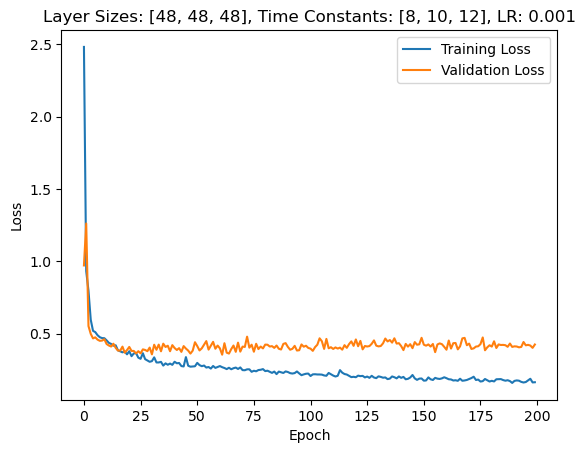

  0%|          | 1/200 [00:13<45:30, 13.72s/it]

Epoch 1/200, Training Loss: 1.0252471521215618, Validation Loss: 0.7327953789915357


  1%|          | 2/200 [00:27<45:01, 13.64s/it]

Epoch 2/200, Training Loss: 0.9547091103949636, Validation Loss: 0.7448105812072754


  2%|▏         | 3/200 [00:40<44:08, 13.44s/it]

Epoch 3/200, Training Loss: 0.8181970850476679, Validation Loss: 0.504897803068161


  2%|▏         | 4/200 [00:53<43:13, 13.23s/it]

Epoch 4/200, Training Loss: 0.8470118400060905, Validation Loss: 0.6445170598370689


  2%|▎         | 5/200 [01:06<42:50, 13.18s/it]

Epoch 5/200, Training Loss: 0.7150000468739923, Validation Loss: 0.6506986511605126


  3%|▎         | 6/200 [01:20<43:02, 13.31s/it]

Epoch 6/200, Training Loss: 0.6933099211386915, Validation Loss: 0.6091419969286237


  4%|▎         | 7/200 [01:33<43:15, 13.45s/it]

Epoch 7/200, Training Loss: 0.6521873676551962, Validation Loss: 0.6590816995927266


  4%|▍         | 8/200 [01:47<43:15, 13.52s/it]

Epoch 8/200, Training Loss: 0.6339441717795606, Validation Loss: 0.7477475298302514


  4%|▍         | 9/200 [02:01<43:07, 13.54s/it]

Epoch 9/200, Training Loss: 0.6144724808773905, Validation Loss: 0.7581389163221631


  5%|▌         | 10/200 [02:14<43:10, 13.64s/it]

Epoch 10/200, Training Loss: 0.6630340814590454, Validation Loss: 0.6393986131463733


  6%|▌         | 11/200 [02:27<42:18, 13.43s/it]

Epoch 11/200, Training Loss: 0.656991516362946, Validation Loss: 1.0281881924186433


  6%|▌         | 12/200 [02:40<41:41, 13.30s/it]

Epoch 12/200, Training Loss: 0.7229305162744702, Validation Loss: 0.8445759202752795


  6%|▋         | 13/200 [02:54<42:03, 13.49s/it]

Epoch 13/200, Training Loss: 0.7789638407950131, Validation Loss: 0.7272777748959405


  7%|▋         | 14/200 [03:08<41:33, 13.41s/it]

Epoch 14/200, Training Loss: 0.6806744770059046, Validation Loss: 0.9522251614502498


  8%|▊         | 15/200 [03:21<41:12, 13.36s/it]

Epoch 15/200, Training Loss: 0.6628809509412298, Validation Loss: 0.5037629944937569


  8%|▊         | 16/200 [03:35<41:25, 13.51s/it]

Epoch 16/200, Training Loss: 0.6025297984762011, Validation Loss: 0.6320626416376659


  8%|▊         | 17/200 [03:48<41:16, 13.53s/it]

Epoch 17/200, Training Loss: 0.5738747052426608, Validation Loss: 0.59511085493224


  9%|▉         | 18/200 [04:01<40:27, 13.34s/it]

Epoch 18/200, Training Loss: 0.8285969945619691, Validation Loss: 1.3404347513403212


 10%|▉         | 19/200 [04:14<39:51, 13.21s/it]

Epoch 19/200, Training Loss: 0.8134466460290944, Validation Loss: 0.5407984235457012


 10%|█         | 20/200 [04:27<39:23, 13.13s/it]

Epoch 20/200, Training Loss: 0.641990194624325, Validation Loss: 0.5519318410328456


 10%|█         | 21/200 [04:40<39:30, 13.25s/it]

Epoch 21/200, Training Loss: 0.6474228259527458, Validation Loss: 0.6217339932918549


 11%|█         | 22/200 [04:54<39:32, 13.33s/it]

Epoch 22/200, Training Loss: 0.5974986002130328, Validation Loss: 0.5762110437665667


 12%|█▏        | 23/200 [05:07<39:02, 13.23s/it]

Epoch 23/200, Training Loss: 0.6036431170859426, Validation Loss: 0.7380952962807247


 12%|█▏        | 24/200 [05:21<39:17, 13.39s/it]

Epoch 24/200, Training Loss: 0.6043037474155426, Validation Loss: 0.6592974194458553


 12%|█▎        | 25/200 [05:36<40:37, 13.93s/it]

Epoch 25/200, Training Loss: 0.6711407978579683, Validation Loss: 0.6560216099023819


 13%|█▎        | 26/200 [05:50<40:40, 14.02s/it]

Epoch 26/200, Training Loss: 0.5398465628331562, Validation Loss: 0.5766714193991253


 14%|█▎        | 27/200 [06:04<40:32, 14.06s/it]

Epoch 27/200, Training Loss: 0.5413811566694727, Validation Loss: 0.6547488570213318


 14%|█▍        | 28/200 [06:18<40:23, 14.09s/it]

Epoch 28/200, Training Loss: 0.5352132517211842, Validation Loss: 0.8426329238074166


 14%|█▍        | 29/200 [06:33<40:12, 14.11s/it]

Epoch 29/200, Training Loss: 0.5974034537684243, Validation Loss: 0.7646396160125732


 15%|█▌        | 30/200 [06:46<39:40, 14.01s/it]

Epoch 30/200, Training Loss: 0.5982655573566005, Validation Loss: 0.9271872043609619


 16%|█▌        | 31/200 [07:00<39:16, 13.94s/it]

Epoch 31/200, Training Loss: 0.6228978825065324, Validation Loss: 0.5870996351752963


 16%|█▌        | 32/200 [07:14<39:03, 13.95s/it]

Epoch 32/200, Training Loss: 0.6084903290249267, Validation Loss: 0.7008251164640699


 16%|█▋        | 33/200 [07:29<39:23, 14.15s/it]

Epoch 33/200, Training Loss: 0.5133355664757063, Validation Loss: 0.5991380331771714


 17%|█▋        | 34/200 [07:43<39:22, 14.23s/it]

Epoch 34/200, Training Loss: 0.7082944731667357, Validation Loss: 0.7674663194588253


 18%|█▊        | 35/200 [07:57<38:56, 14.16s/it]

Epoch 35/200, Training Loss: 0.5550857090725089, Validation Loss: 0.5645036314214978


 18%|█▊        | 36/200 [08:12<39:23, 14.41s/it]

Epoch 36/200, Training Loss: 0.5488927060703062, Validation Loss: 0.637265573654856


 18%|█▊        | 37/200 [08:27<39:07, 14.40s/it]

Epoch 37/200, Training Loss: 0.5667440981235145, Validation Loss: 0.7160595612866538


 19%|█▉        | 38/200 [08:40<38:26, 14.24s/it]

Epoch 38/200, Training Loss: 0.5539498568143485, Validation Loss: 0.7336128801107407


 20%|█▉        | 39/200 [08:55<38:05, 14.19s/it]

Epoch 39/200, Training Loss: 0.5577237223679165, Validation Loss: 0.5673691481351852


 20%|██        | 40/200 [09:08<37:35, 14.09s/it]

Epoch 40/200, Training Loss: 0.5154587820453463, Validation Loss: 0.7033680805138179


 20%|██        | 41/200 [09:23<37:23, 14.11s/it]

Epoch 41/200, Training Loss: 0.755156251900601, Validation Loss: 0.7239368898527963


 21%|██        | 42/200 [09:36<37:00, 14.06s/it]

Epoch 42/200, Training Loss: 0.5678925632305865, Validation Loss: 0.5723883020026344


 22%|██▏       | 43/200 [09:51<37:01, 14.15s/it]

Epoch 43/200, Training Loss: 0.5449955553378699, Validation Loss: 0.5803513165031161


 22%|██▏       | 44/200 [10:06<37:19, 14.36s/it]

Epoch 44/200, Training Loss: 0.5395770795502752, Validation Loss: 0.6891326968158994


 22%|██▎       | 45/200 [10:20<37:14, 14.42s/it]

Epoch 45/200, Training Loss: 0.514937881591185, Validation Loss: 0.5582898110151291


 23%|██▎       | 46/200 [10:34<36:52, 14.37s/it]

Epoch 46/200, Training Loss: 0.6052921670225432, Validation Loss: 0.5668257070439202


 24%|██▎       | 47/200 [10:49<36:24, 14.28s/it]

Epoch 47/200, Training Loss: 0.5281427730366869, Validation Loss: 0.6512382349797657


 24%|██▍       | 48/200 [11:03<36:38, 14.46s/it]

Epoch 48/200, Training Loss: 0.5313016305554588, Validation Loss: 0.5616919909204755


 24%|██▍       | 49/200 [11:17<36:03, 14.33s/it]

Epoch 49/200, Training Loss: 0.48884854957742513, Validation Loss: 0.5366904735565186


 25%|██▌       | 50/200 [11:32<35:42, 14.28s/it]

Epoch 50/200, Training Loss: 0.5391988557464672, Validation Loss: 0.6556192934513092


 26%|██▌       | 51/200 [11:45<34:52, 14.04s/it]

Epoch 51/200, Training Loss: 0.5498191899848435, Validation Loss: 0.6410071445362908


 26%|██▌       | 52/200 [11:58<34:06, 13.83s/it]

Epoch 52/200, Training Loss: 0.5778167304003013, Validation Loss: 0.8553815845932279


 26%|██▋       | 53/200 [12:12<33:35, 13.71s/it]

Epoch 53/200, Training Loss: 0.591235138054164, Validation Loss: 0.5343500290598188


 27%|██▋       | 54/200 [12:25<33:07, 13.61s/it]

Epoch 54/200, Training Loss: 0.5317909529186645, Validation Loss: 0.541907821382795


 28%|██▊       | 55/200 [12:39<32:54, 13.62s/it]

Epoch 55/200, Training Loss: 0.5264880336680502, Validation Loss: 0.6988507402794701


 28%|██▊       | 56/200 [12:53<32:43, 13.63s/it]

Epoch 56/200, Training Loss: 0.4984055869984177, Validation Loss: 0.7110224728073392


 28%|██▊       | 57/200 [13:07<32:53, 13.80s/it]

Epoch 57/200, Training Loss: 0.5858670079483176, Validation Loss: 0.8591987362929753


 29%|██▉       | 58/200 [13:20<32:24, 13.70s/it]

Epoch 58/200, Training Loss: 0.5180118716550324, Validation Loss: 0.9225212591035026


 30%|██▉       | 59/200 [13:34<32:06, 13.66s/it]

Epoch 59/200, Training Loss: 0.5572701701015796, Validation Loss: 0.6754843230758395


 30%|███       | 60/200 [13:47<31:42, 13.59s/it]

Epoch 60/200, Training Loss: 0.520703282277539, Validation Loss: 0.4769809991121292


 30%|███       | 61/200 [14:01<31:49, 13.74s/it]

Epoch 61/200, Training Loss: 0.4849041000289737, Validation Loss: 0.6433440340416772


 31%|███       | 62/200 [14:15<31:35, 13.74s/it]

Epoch 62/200, Training Loss: 0.5458578478615239, Validation Loss: 0.6727157788617271


 32%|███▏      | 63/200 [14:28<31:07, 13.63s/it]

Epoch 63/200, Training Loss: 0.5111224631655891, Validation Loss: 0.507557098354612


 32%|███▏      | 64/200 [14:42<30:44, 13.57s/it]

Epoch 64/200, Training Loss: 0.49182115860705106, Validation Loss: 0.7083498920713153


 32%|███▎      | 65/200 [14:55<30:23, 13.51s/it]

Epoch 65/200, Training Loss: 0.48523922770653133, Validation Loss: 0.5041400641202927


 33%|███▎      | 66/200 [15:09<30:09, 13.50s/it]

Epoch 66/200, Training Loss: 0.5109831041322564, Validation Loss: 0.6847642425979886


 34%|███▎      | 67/200 [15:22<29:55, 13.50s/it]

Epoch 67/200, Training Loss: 0.5546799830670627, Validation Loss: 0.5377644406897681


 34%|███▍      | 68/200 [15:36<29:37, 13.46s/it]

Epoch 68/200, Training Loss: 0.5525099592951109, Validation Loss: 0.5195949673652649


 34%|███▍      | 69/200 [15:49<29:25, 13.47s/it]

Epoch 69/200, Training Loss: 0.49994307222231377, Validation Loss: 0.9038043533052716


 35%|███▌      | 70/200 [16:03<29:38, 13.68s/it]

Epoch 70/200, Training Loss: 0.5645592845273468, Validation Loss: 0.733867096049445


 36%|███▌      | 71/200 [16:17<29:23, 13.67s/it]

Epoch 71/200, Training Loss: 0.5301281936326117, Validation Loss: 0.488754004240036


 36%|███▌      | 72/200 [16:30<29:01, 13.61s/it]

Epoch 72/200, Training Loss: 0.5285650860026198, Validation Loss: 0.6451115310192108


 36%|███▋      | 73/200 [16:44<28:42, 13.57s/it]

Epoch 73/200, Training Loss: 0.6657168044234222, Validation Loss: 0.6041845636708396


 37%|███▋      | 74/200 [16:58<28:55, 13.77s/it]

Epoch 74/200, Training Loss: 0.510333815273249, Validation Loss: 0.8426126710006169


 38%|███▊      | 75/200 [17:12<28:32, 13.70s/it]

Epoch 75/200, Training Loss: 0.6470882431516107, Validation Loss: 0.6777795851230621


 38%|███▊      | 76/200 [17:25<28:08, 13.61s/it]

Epoch 76/200, Training Loss: 0.561415118428896, Validation Loss: 0.710206823689597


 38%|███▊      | 77/200 [17:38<27:48, 13.56s/it]

Epoch 77/200, Training Loss: 0.5290906015994414, Validation Loss: 0.6647455117532185


 39%|███▉      | 78/200 [17:52<27:27, 13.50s/it]

Epoch 78/200, Training Loss: 0.560414028336417, Validation Loss: 0.5019510005201612


 40%|███▉      | 79/200 [18:05<27:13, 13.50s/it]

Epoch 79/200, Training Loss: 0.534915270670405, Validation Loss: 0.6022917521851403


 40%|████      | 80/200 [18:19<27:00, 13.50s/it]

Epoch 80/200, Training Loss: 0.5663951742199232, Validation Loss: 0.7345790266990662


 40%|████      | 81/200 [18:32<26:42, 13.46s/it]

Epoch 81/200, Training Loss: 0.5351286283079183, Validation Loss: 0.604156494140625


 41%|████      | 82/200 [18:46<26:27, 13.45s/it]

Epoch 82/200, Training Loss: 0.5110500384614153, Validation Loss: 0.5681953238589423


 42%|████▏     | 83/200 [19:00<26:47, 13.74s/it]

Epoch 83/200, Training Loss: 0.5240739024472687, Validation Loss: 0.5495415457657405


 42%|████▏     | 84/200 [19:14<26:27, 13.68s/it]

Epoch 84/200, Training Loss: 0.4811988298623067, Validation Loss: 0.5560830405780247


 42%|████▎     | 85/200 [19:27<26:07, 13.63s/it]

Epoch 85/200, Training Loss: 0.5119354587118581, Validation Loss: 0.6818922289780208


 43%|████▎     | 86/200 [19:41<25:54, 13.63s/it]

Epoch 86/200, Training Loss: 0.47445530402210523, Validation Loss: 0.6055472578321185


 44%|████▎     | 87/200 [19:55<25:58, 13.79s/it]

Epoch 87/200, Training Loss: 0.5316866466178084, Validation Loss: 0.5269881806203297


 44%|████▍     | 88/200 [20:08<25:30, 13.66s/it]

Epoch 88/200, Training Loss: 0.5292062590707023, Validation Loss: 0.5942921787500381


 44%|████▍     | 89/200 [20:22<25:11, 13.62s/it]

Epoch 89/200, Training Loss: 0.503957304752098, Validation Loss: 0.6564342379570007


 45%|████▌     | 90/200 [20:35<24:50, 13.55s/it]

Epoch 90/200, Training Loss: 0.515680897348332, Validation Loss: 0.7032334378787449


 46%|████▌     | 91/200 [20:49<24:31, 13.50s/it]

Epoch 91/200, Training Loss: 0.5541655910464952, Validation Loss: 0.7439794412681034


 46%|████▌     | 92/200 [21:02<24:22, 13.54s/it]

Epoch 92/200, Training Loss: 0.4799590377875094, Validation Loss: 0.6181424132415226


 46%|████▋     | 93/200 [21:16<24:08, 13.54s/it]

Epoch 93/200, Training Loss: 0.4713840923219357, Validation Loss: 0.6967904333557401


 47%|████▋     | 94/200 [21:29<23:54, 13.53s/it]

Epoch 94/200, Training Loss: 0.45054746601941453, Validation Loss: 0.7742772017206464


 48%|████▊     | 95/200 [21:43<23:43, 13.56s/it]

Epoch 95/200, Training Loss: 0.5338082687472397, Validation Loss: 0.7183800552572522


 48%|████▊     | 96/200 [21:57<23:53, 13.78s/it]

Epoch 96/200, Training Loss: 0.5357263687084306, Validation Loss: 0.5668824825968061


 48%|████▊     | 97/200 [22:11<23:28, 13.68s/it]

Epoch 97/200, Training Loss: 0.4468007655638569, Validation Loss: 0.6437367498874664


 49%|████▉     | 98/200 [22:24<23:11, 13.64s/it]

Epoch 98/200, Training Loss: 0.4733468822713168, Validation Loss: 0.7493512375014169


 50%|████▉     | 99/200 [22:38<22:58, 13.65s/it]

Epoch 99/200, Training Loss: 0.6889467981626403, Validation Loss: 0.5887788108416966


 50%|█████     | 100/200 [22:52<23:03, 13.83s/it]

Epoch 100/200, Training Loss: 0.4729083377235341, Validation Loss: 0.6070833546774728


 50%|█████     | 101/200 [23:06<22:42, 13.76s/it]

Epoch 101/200, Training Loss: 0.4518339493364658, Validation Loss: 0.6159953219549996


 51%|█████     | 102/200 [23:19<22:15, 13.63s/it]

Epoch 102/200, Training Loss: 0.46532107074305695, Validation Loss: 0.5707735802446093


 52%|█████▏    | 103/200 [23:32<21:55, 13.56s/it]

Epoch 103/200, Training Loss: 0.4383751665646175, Validation Loss: 0.5641689896583557


 52%|█████▏    | 104/200 [23:46<21:41, 13.56s/it]

Epoch 104/200, Training Loss: 0.5096949091497457, Validation Loss: 0.6179310956171581


 52%|█████▎    | 105/200 [23:59<21:27, 13.55s/it]

Epoch 105/200, Training Loss: 0.47713705756754243, Validation Loss: 0.6633286944457463


 53%|█████▎    | 106/200 [24:13<21:09, 13.51s/it]

Epoch 106/200, Training Loss: 0.640242985397015, Validation Loss: 0.7681457613195691


 54%|█████▎    | 107/200 [24:26<20:55, 13.50s/it]

Epoch 107/200, Training Loss: 0.45065842062797185, Validation Loss: 0.6748761598552976


 54%|█████▍    | 108/200 [24:40<20:46, 13.55s/it]

Epoch 108/200, Training Loss: 0.4700539859960664, Validation Loss: 0.5829617253371647


 55%|█████▍    | 109/200 [24:54<20:51, 13.75s/it]

Epoch 109/200, Training Loss: 0.5359213355014909, Validation Loss: 0.4351645218474524


 55%|█████▌    | 110/200 [25:08<20:29, 13.66s/it]

Epoch 110/200, Training Loss: 0.4801855000122538, Validation Loss: 0.45567943368639263


 56%|█████▌    | 111/200 [25:21<20:17, 13.68s/it]

Epoch 111/200, Training Loss: 0.5774417356500086, Validation Loss: 0.46983000210353304


 56%|█████▌    | 112/200 [25:35<20:00, 13.64s/it]

Epoch 112/200, Training Loss: 0.4629468501738782, Validation Loss: 0.6959445178508759


 56%|█████▋    | 113/200 [25:49<19:55, 13.74s/it]

Epoch 113/200, Training Loss: 0.5305180678952415, Validation Loss: 0.6126860507896968


 57%|█████▋    | 114/200 [26:03<19:41, 13.74s/it]

Epoch 114/200, Training Loss: 0.5552699161025713, Validation Loss: 0.6275950010333743


 57%|█████▊    | 115/200 [26:16<19:21, 13.67s/it]

Epoch 115/200, Training Loss: 0.5211948769272499, Validation Loss: 0.6816207127911704


 58%|█████▊    | 116/200 [26:30<19:03, 13.61s/it]

Epoch 116/200, Training Loss: 0.5336029552063852, Validation Loss: 0.4650101065635681


 58%|█████▊    | 117/200 [26:43<18:52, 13.64s/it]

Epoch 117/200, Training Loss: 0.5735798365664933, Validation Loss: 0.5441079352583204


 59%|█████▉    | 118/200 [26:57<18:33, 13.58s/it]

Epoch 118/200, Training Loss: 0.47703249752521515, Validation Loss: 0.6802923679351807


 60%|█████▉    | 119/200 [27:10<18:18, 13.56s/it]

Epoch 119/200, Training Loss: 0.4519670079901533, Validation Loss: 0.6628639314855848


 60%|██████    | 120/200 [27:24<18:01, 13.52s/it]

Epoch 120/200, Training Loss: 0.6029748593298894, Validation Loss: 0.5331677283559527


 60%|██████    | 121/200 [27:37<17:51, 13.57s/it]

Epoch 121/200, Training Loss: 0.49694163900501326, Validation Loss: 0.6317494979926518


 61%|██████    | 122/200 [27:52<17:53, 13.76s/it]

Epoch 122/200, Training Loss: 0.5661724176046983, Validation Loss: 0.7517163647072655


 62%|██████▏   | 123/200 [28:05<17:34, 13.70s/it]

Epoch 123/200, Training Loss: 0.5826949055464763, Validation Loss: 0.6266807190009526


 62%|██████▏   | 124/200 [28:19<17:17, 13.66s/it]

Epoch 124/200, Training Loss: 0.4433417171239853, Validation Loss: 0.5732126704284123


 62%|██████▎   | 125/200 [28:32<17:01, 13.63s/it]

Epoch 125/200, Training Loss: 0.5172299902956441, Validation Loss: 0.7344508171081543


 63%|██████▎   | 126/200 [28:47<17:02, 13.82s/it]

Epoch 126/200, Training Loss: 0.48032961054792944, Validation Loss: 0.6213390742029462


 64%|██████▎   | 127/200 [29:00<16:45, 13.77s/it]

Epoch 127/200, Training Loss: 0.44563052508066286, Validation Loss: 0.7150202691555023


 64%|██████▍   | 128/200 [29:14<16:25, 13.69s/it]

Epoch 128/200, Training Loss: 0.5988643644553311, Validation Loss: 0.8028670634542193


 64%|██████▍   | 129/200 [29:27<16:09, 13.65s/it]

Epoch 129/200, Training Loss: 0.5851535395068942, Validation Loss: 0.4989104036773954


 65%|██████▌   | 130/200 [29:41<15:57, 13.68s/it]

Epoch 130/200, Training Loss: 0.4966453178873602, Validation Loss: 0.46264555411679403


 66%|██████▌   | 131/200 [29:55<15:42, 13.66s/it]

Epoch 131/200, Training Loss: 0.5385601790446155, Validation Loss: 0.6017204693385533


 66%|██████▌   | 132/200 [30:08<15:26, 13.62s/it]

Epoch 132/200, Training Loss: 0.4549546050575544, Validation Loss: 0.5072343179157802


 66%|██████▋   | 133/200 [30:22<15:09, 13.57s/it]

Epoch 133/200, Training Loss: 0.4740849089510036, Validation Loss: 0.5051481851509639


 67%|██████▋   | 134/200 [30:35<15:00, 13.65s/it]

Epoch 134/200, Training Loss: 0.4846397891359509, Validation Loss: 0.5757243590695518


 68%|██████▊   | 135/200 [30:50<14:58, 13.83s/it]

Epoch 135/200, Training Loss: 0.5167532521036436, Validation Loss: 0.5845208508627755


 68%|██████▊   | 136/200 [31:03<14:38, 13.72s/it]

Epoch 136/200, Training Loss: 0.4732067877391599, Validation Loss: 0.5539761228220803


 68%|██████▊   | 137/200 [31:17<14:23, 13.71s/it]

Epoch 137/200, Training Loss: 0.5158531238447945, Validation Loss: 0.632221805197852


 69%|██████▉   | 138/200 [31:31<14:17, 13.84s/it]

Epoch 138/200, Training Loss: 0.48874622499043086, Validation Loss: 0.6320314875670842


 70%|██████▉   | 139/200 [31:45<14:01, 13.80s/it]

Epoch 139/200, Training Loss: 0.4570841592437816, Validation Loss: 0.7258070622171674


 70%|███████   | 140/200 [31:58<13:42, 13.71s/it]

Epoch 140/200, Training Loss: 0.4633266470342312, Validation Loss: 0.6606219155447823


 70%|███████   | 141/200 [32:12<13:24, 13.64s/it]

Epoch 141/200, Training Loss: 0.5236821683510294, Validation Loss: 0.6339136234351567


 71%|███████   | 142/200 [32:25<13:08, 13.60s/it]

Epoch 142/200, Training Loss: 0.45757015921034905, Validation Loss: 0.6655735330922263


 72%|███████▏  | 143/200 [32:39<12:55, 13.61s/it]

Epoch 143/200, Training Loss: 0.4960446522202132, Validation Loss: 0.5962816945144108


 72%|███████▏  | 144/200 [32:52<12:42, 13.61s/it]

Epoch 144/200, Training Loss: 0.4915639707502329, Validation Loss: 0.7558507749012539


 72%|███████▎  | 145/200 [33:06<12:25, 13.55s/it]

Epoch 145/200, Training Loss: 0.5108931328890458, Validation Loss: 0.524185768195561


 73%|███████▎  | 146/200 [33:20<12:14, 13.60s/it]

Epoch 146/200, Training Loss: 0.5826809310688162, Validation Loss: 0.6074928172997066


 74%|███████▎  | 147/200 [33:34<12:16, 13.89s/it]

Epoch 147/200, Training Loss: 0.5093561843881067, Validation Loss: 0.5643455386161804


 74%|███████▍  | 148/200 [33:48<11:57, 13.80s/it]

Epoch 148/200, Training Loss: 0.4889504316280473, Validation Loss: 0.6027548696313586


 74%|███████▍  | 149/200 [34:02<11:46, 13.85s/it]

Epoch 149/200, Training Loss: 0.48402531135757015, Validation Loss: 0.5623664430209568


 75%|███████▌  | 150/200 [34:16<11:32, 13.84s/it]

Epoch 150/200, Training Loss: 0.4584250753780581, Validation Loss: 0.654923813683646


 76%|███████▌  | 151/200 [34:30<11:27, 14.04s/it]

Epoch 151/200, Training Loss: 0.49405298874063314, Validation Loss: 0.5655708738735744


 76%|███████▌  | 152/200 [34:44<11:09, 13.95s/it]

Epoch 152/200, Training Loss: 0.4366736881575494, Validation Loss: 0.6658012654100146


 76%|███████▋  | 153/200 [34:57<10:49, 13.83s/it]

Epoch 153/200, Training Loss: 0.46244584698722047, Validation Loss: 0.562653871519225


 77%|███████▋  | 154/200 [35:11<10:31, 13.72s/it]

Epoch 154/200, Training Loss: 0.4831757412625934, Validation Loss: 0.5790905569280896


 78%|███████▊  | 155/200 [35:24<10:13, 13.64s/it]

Epoch 155/200, Training Loss: 0.420085979238996, Validation Loss: 0.5500759908131191


 78%|███████▊  | 156/200 [35:38<09:59, 13.62s/it]

Epoch 156/200, Training Loss: 0.5590362307035698, Validation Loss: 0.5652517250605992


 78%|███████▊  | 157/200 [35:52<09:47, 13.66s/it]

Epoch 157/200, Training Loss: 0.5108837690555824, Validation Loss: 0.9379173730100904


 79%|███████▉  | 158/200 [36:05<09:31, 13.61s/it]

Epoch 158/200, Training Loss: 0.5260016724186124, Validation Loss: 0.8387626111507416


 80%|███████▉  | 159/200 [36:19<09:17, 13.59s/it]

Epoch 159/200, Training Loss: 0.4992203345557429, Validation Loss: 0.5927188226154873


 80%|████████  | 160/200 [36:33<09:10, 13.77s/it]

Epoch 160/200, Training Loss: 0.5686570490306279, Validation Loss: 0.49220435108457294


 80%|████████  | 161/200 [36:46<08:55, 13.73s/it]

Epoch 161/200, Training Loss: 0.49188488314174256, Validation Loss: 0.5749981999397278


 81%|████████  | 162/200 [37:00<08:39, 13.68s/it]

Epoch 162/200, Training Loss: 0.46976846203489125, Validation Loss: 0.5171306431293488


 82%|████████▏ | 163/200 [37:14<08:24, 13.64s/it]

Epoch 163/200, Training Loss: 0.47878645023085037, Validation Loss: 0.6487383161272321


 82%|████████▏ | 164/200 [37:28<08:19, 13.88s/it]

Epoch 164/200, Training Loss: 0.46872634539064373, Validation Loss: 0.5629060821873801


 82%|████████▎ | 165/200 [37:42<08:03, 13.82s/it]

Epoch 165/200, Training Loss: 0.455590177257106, Validation Loss: 0.7068372070789337


 83%|████████▎ | 166/200 [37:55<07:45, 13.70s/it]

Epoch 166/200, Training Loss: 0.4779167689804761, Validation Loss: 0.6511068152529853


 84%|████████▎ | 167/200 [38:09<07:29, 13.63s/it]

Epoch 167/200, Training Loss: 0.48905313183676524, Validation Loss: 0.7240861015660423


 84%|████████▍ | 168/200 [38:22<07:14, 13.57s/it]

Epoch 168/200, Training Loss: 0.48600598101346, Validation Loss: 0.6626793018409184


 84%|████████▍ | 169/200 [38:35<06:59, 13.54s/it]

Epoch 169/200, Training Loss: 0.43366464592938153, Validation Loss: 0.5849922852856773


 85%|████████▌ | 170/200 [38:49<06:46, 13.55s/it]

Epoch 170/200, Training Loss: 0.47649769850496976, Validation Loss: 0.5042718350887299


 86%|████████▌ | 171/200 [39:02<06:32, 13.52s/it]

Epoch 171/200, Training Loss: 0.44877002852142983, Validation Loss: 0.5620244869164058


 86%|████████▌ | 172/200 [39:16<06:19, 13.55s/it]

Epoch 172/200, Training Loss: 0.5737010451420298, Validation Loss: 0.5079314006226403


 86%|████████▋ | 173/200 [39:30<06:12, 13.78s/it]

Epoch 173/200, Training Loss: 0.5532959201988185, Validation Loss: 0.5751380409513202


 87%|████████▋ | 174/200 [39:44<05:56, 13.70s/it]

Epoch 174/200, Training Loss: 0.4365229030262749, Validation Loss: 0.5294983855315617


 88%|████████▊ | 175/200 [39:58<05:42, 13.70s/it]

Epoch 175/200, Training Loss: 0.46586499349126276, Validation Loss: 0.636067828961781


 88%|████████▊ | 176/200 [40:12<05:32, 13.85s/it]

Epoch 176/200, Training Loss: 0.441894253751017, Validation Loss: 0.5854547194072178


 88%|████████▊ | 177/200 [40:25<05:15, 13.74s/it]

Epoch 177/200, Training Loss: 0.4155524564239214, Validation Loss: 0.5879421319280352


 89%|████████▉ | 178/200 [40:39<05:02, 13.75s/it]

Epoch 178/200, Training Loss: 0.45932455705303066, Validation Loss: 0.5260133572987148


 90%|████████▉ | 179/200 [40:53<04:47, 13.67s/it]

Epoch 179/200, Training Loss: 0.4363194380728704, Validation Loss: 0.5856580840689796


 90%|█████████ | 180/200 [41:06<04:31, 13.58s/it]

Epoch 180/200, Training Loss: 0.5143266055943831, Validation Loss: 0.7792291428361621


 90%|█████████ | 181/200 [41:19<04:17, 13.56s/it]

Epoch 181/200, Training Loss: 0.5730179577784719, Validation Loss: 0.7219944596290588


 91%|█████████ | 182/200 [41:33<04:03, 13.52s/it]

Epoch 182/200, Training Loss: 0.45478124016860744, Validation Loss: 0.5917157403060368


 92%|█████████▏| 183/200 [41:46<03:49, 13.49s/it]

Epoch 183/200, Training Loss: 0.44174923902412633, Validation Loss: 0.4699822579111372


 92%|█████████▏| 184/200 [42:00<03:36, 13.56s/it]

Epoch 184/200, Training Loss: 0.43566342193703606, Validation Loss: 0.6115708862032209


 92%|█████████▎| 185/200 [42:14<03:26, 13.76s/it]

Epoch 185/200, Training Loss: 0.4692670781657381, Validation Loss: 0.5792045720985958


 93%|█████████▎| 186/200 [42:28<03:11, 13.66s/it]

Epoch 186/200, Training Loss: 0.4422684145985909, Validation Loss: 0.5766490697860718


 94%|█████████▎| 187/200 [42:41<02:56, 13.58s/it]

Epoch 187/200, Training Loss: 0.46534436435069676, Validation Loss: 0.5638040346758706


 94%|█████████▍| 188/200 [42:55<02:42, 13.56s/it]

Epoch 188/200, Training Loss: 0.45121881703160843, Validation Loss: 0.6437551932675498


 94%|█████████▍| 189/200 [43:09<02:32, 13.83s/it]

Epoch 189/200, Training Loss: 0.4448183184524752, Validation Loss: 0.6462636802877698


 95%|█████████▌| 190/200 [43:23<02:17, 13.78s/it]

Epoch 190/200, Training Loss: 0.4029704357655543, Validation Loss: 0.5969704730170113


 96%|█████████▌| 191/200 [43:36<02:02, 13.66s/it]

Epoch 191/200, Training Loss: 0.4434612084109828, Validation Loss: 0.6373682788440159


 96%|█████████▌| 192/200 [43:50<01:49, 13.66s/it]

Epoch 192/200, Training Loss: 0.5014596935713066, Validation Loss: 0.6042478340012687


 96%|█████████▋| 193/200 [44:03<01:35, 13.61s/it]

Epoch 193/200, Training Loss: 0.4678425369959957, Validation Loss: 0.6170747407845089


 97%|█████████▋| 194/200 [44:17<01:21, 13.55s/it]

Epoch 194/200, Training Loss: 0.42612077801857356, Validation Loss: 0.49799459321158274


 98%|█████████▊| 195/200 [44:30<01:07, 13.54s/it]

Epoch 195/200, Training Loss: 0.4302647337317467, Validation Loss: 0.5321658040796008


 98%|█████████▊| 196/200 [44:44<00:53, 13.50s/it]

Epoch 196/200, Training Loss: 0.4217654323240496, Validation Loss: 0.48628360884530203


 98%|█████████▊| 197/200 [44:57<00:40, 13.53s/it]

Epoch 197/200, Training Loss: 0.5639757454957602, Validation Loss: 0.6692008588995252


 99%|█████████▉| 198/200 [45:11<00:27, 13.76s/it]

Epoch 198/200, Training Loss: 0.520275815196757, Validation Loss: 0.9026119879313877


100%|█████████▉| 199/200 [45:25<00:13, 13.65s/it]

Epoch 199/200, Training Loss: 0.48034843549413503, Validation Loss: 0.6098896733352116


100%|██████████| 200/200 [45:38<00:00, 13.69s/it]

Epoch 200/200, Training Loss: 0.4446354511211503, Validation Loss: 0.6306184998580388
Final Accuracy: 88.46%, Precision: 0.88, Recall: 0.89


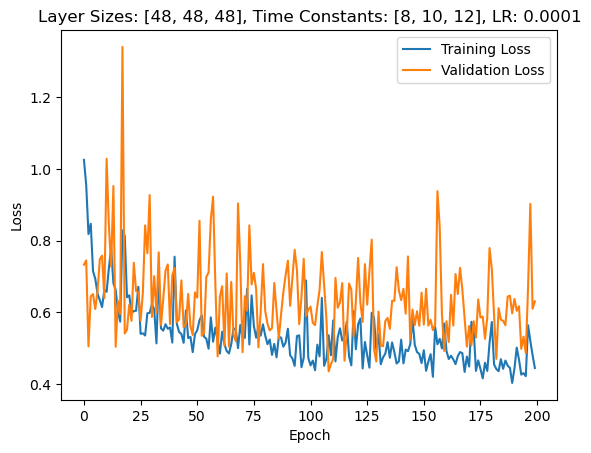

  0%|          | 1/200 [00:14<46:46, 14.10s/it]

Epoch 1/200, Training Loss: 1.0125659805423808, Validation Loss: 0.8463171337332044


  1%|          | 2/200 [00:28<46:30, 14.09s/it]

Epoch 2/200, Training Loss: 0.9843620815367069, Validation Loss: 0.8571760271276746


  2%|▏         | 3/200 [00:41<45:15, 13.78s/it]

Epoch 3/200, Training Loss: 0.8106186434907733, Validation Loss: 0.7098896588597979


  2%|▏         | 4/200 [00:54<44:06, 13.50s/it]

Epoch 4/200, Training Loss: 0.8378398058549413, Validation Loss: 0.848989018372127


  2%|▎         | 5/200 [01:07<43:20, 13.33s/it]

Epoch 5/200, Training Loss: 0.8917720520271445, Validation Loss: 0.7465669981070927


  3%|▎         | 6/200 [01:21<43:41, 13.51s/it]

Epoch 6/200, Training Loss: 0.8182744715573653, Validation Loss: 0.7151224740913936


  4%|▎         | 7/200 [01:35<43:44, 13.60s/it]

Epoch 7/200, Training Loss: 0.6752317148559498, Validation Loss: 0.6755819703851428


  4%|▍         | 8/200 [01:49<43:48, 13.69s/it]

Epoch 8/200, Training Loss: 0.6279007067095559, Validation Loss: 0.6435191971915108


  4%|▍         | 9/200 [02:03<43:41, 13.72s/it]

Epoch 9/200, Training Loss: 0.5799078395906484, Validation Loss: 0.6173467210360936


  5%|▌         | 10/200 [02:16<43:37, 13.77s/it]

Epoch 10/200, Training Loss: 0.5529311102516247, Validation Loss: 0.4336982752595629


  6%|▌         | 11/200 [02:30<42:48, 13.59s/it]

Epoch 11/200, Training Loss: 0.5495714691450011, Validation Loss: 0.5404943717377526


  6%|▌         | 12/200 [02:43<42:49, 13.67s/it]

Epoch 12/200, Training Loss: 0.5731346798392961, Validation Loss: 0.5407116625990186


  6%|▋         | 13/200 [02:57<42:22, 13.60s/it]

Epoch 13/200, Training Loss: 0.5293644183086899, Validation Loss: 0.47332932693617685


  7%|▋         | 14/200 [03:10<41:42, 13.45s/it]

Epoch 14/200, Training Loss: 0.5449359023346091, Validation Loss: 0.6323219686746597


  8%|▊         | 15/200 [03:23<41:10, 13.35s/it]

Epoch 15/200, Training Loss: 0.5365855547617067, Validation Loss: 0.5739716930048806


  8%|▊         | 16/200 [03:37<41:36, 13.57s/it]

Epoch 16/200, Training Loss: 0.5047852413834266, Validation Loss: 0.5914230921438762


  8%|▊         | 17/200 [03:51<41:13, 13.52s/it]

Epoch 17/200, Training Loss: 0.5070379587276926, Validation Loss: 0.5499506209577832


  9%|▉         | 18/200 [04:04<40:36, 13.39s/it]

Epoch 18/200, Training Loss: 0.4886855606762868, Validation Loss: 0.42274147059236256


 10%|▉         | 19/200 [04:17<40:11, 13.32s/it]

Epoch 19/200, Training Loss: 0.5018967614983613, Validation Loss: 0.5671889867101397


 10%|█         | 20/200 [04:30<39:58, 13.33s/it]

Epoch 20/200, Training Loss: 0.5025907538409503, Validation Loss: 0.5011594210352216


 10%|█         | 21/200 [04:44<40:14, 13.49s/it]

Epoch 21/200, Training Loss: 0.4892097874632422, Validation Loss: 0.5183703218187604


 11%|█         | 22/200 [04:57<39:42, 13.39s/it]

Epoch 22/200, Training Loss: 0.5058469817323504, Validation Loss: 0.49961598004613605


 12%|█▏        | 23/200 [05:10<39:21, 13.34s/it]

Epoch 23/200, Training Loss: 0.46696081251468297, Validation Loss: 0.5387751970972333


 12%|█▏        | 24/200 [05:24<39:12, 13.36s/it]

Epoch 24/200, Training Loss: 0.5046462905856798, Validation Loss: 0.4476269398416792


 12%|█▎        | 25/200 [05:38<39:34, 13.57s/it]

Epoch 25/200, Training Loss: 0.4617815833046751, Validation Loss: 0.5651665798255375


 13%|█▎        | 26/200 [05:51<39:07, 13.49s/it]

Epoch 26/200, Training Loss: 0.46416457644048725, Validation Loss: 0.5937137986932483


 14%|█▎        | 27/200 [06:04<38:36, 13.39s/it]

Epoch 27/200, Training Loss: 0.4797277979131015, Validation Loss: 0.46591830253601074


 14%|█▍        | 28/200 [06:18<38:21, 13.38s/it]

Epoch 28/200, Training Loss: 0.47102527039230996, Validation Loss: 0.5662040369851249


 14%|█▍        | 29/200 [06:31<37:57, 13.32s/it]

Epoch 29/200, Training Loss: 0.45027919928982574, Validation Loss: 0.4931006836039679


 15%|█▌        | 30/200 [06:44<37:38, 13.28s/it]

Epoch 30/200, Training Loss: 0.45563288398508756, Validation Loss: 0.5467572041920253


 16%|█▌        | 31/200 [06:57<37:23, 13.28s/it]

Epoch 31/200, Training Loss: 0.4227758449203563, Validation Loss: 0.5266150619302478


 16%|█▌        | 32/200 [07:10<37:04, 13.24s/it]

Epoch 32/200, Training Loss: 0.4363571056779825, Validation Loss: 0.5666568449565342


 16%|█▋        | 33/200 [07:24<36:51, 13.25s/it]

Epoch 33/200, Training Loss: 0.4286310962348614, Validation Loss: 0.5282002325568881


 17%|█▋        | 34/200 [07:38<37:09, 13.43s/it]

Epoch 34/200, Training Loss: 0.44516371359240337, Validation Loss: 0.4722023776599339


 18%|█▊        | 35/200 [07:51<36:51, 13.40s/it]

Epoch 35/200, Training Loss: 0.4232707003939827, Validation Loss: 0.48657052857535227


 18%|█▊        | 36/200 [08:04<36:36, 13.39s/it]

Epoch 36/200, Training Loss: 0.43325525943963034, Validation Loss: 0.526593987430845


 18%|█▊        | 37/200 [08:18<36:13, 13.33s/it]

Epoch 37/200, Training Loss: 0.42942663942867854, Validation Loss: 0.6425065313066755


 19%|█▉        | 38/200 [08:31<36:24, 13.48s/it]

Epoch 38/200, Training Loss: 0.4349681347046258, Validation Loss: 0.5480805890900748


 20%|█▉        | 39/200 [08:45<36:09, 13.47s/it]

Epoch 39/200, Training Loss: 0.4208007404264414, Validation Loss: 0.5212276301213673


 20%|██        | 40/200 [08:58<35:53, 13.46s/it]

Epoch 40/200, Training Loss: 0.43307749561543735, Validation Loss: 0.5225067053522382


 20%|██        | 41/200 [09:12<35:31, 13.40s/it]

Epoch 41/200, Training Loss: 0.40173020002976906, Validation Loss: 0.4840259402990341


 21%|██        | 42/200 [09:25<35:17, 13.40s/it]

Epoch 42/200, Training Loss: 0.42130452000869895, Validation Loss: 0.5591832825115749


 22%|██▏       | 43/200 [09:38<34:58, 13.37s/it]

Epoch 43/200, Training Loss: 0.4172111420698886, Validation Loss: 0.5541342965194157


 22%|██▏       | 44/200 [09:51<34:30, 13.28s/it]

Epoch 44/200, Training Loss: 0.4251365158355461, Validation Loss: 0.5294012342180524


 22%|██▎       | 45/200 [10:04<34:07, 13.21s/it]

Epoch 45/200, Training Loss: 0.40642983508559893, Validation Loss: 0.4448086491652897


 23%|██▎       | 46/200 [10:17<33:48, 13.17s/it]

Epoch 46/200, Training Loss: 0.4047245217381783, Validation Loss: 0.4672841727733612


 24%|██▎       | 47/200 [10:32<34:20, 13.47s/it]

Epoch 47/200, Training Loss: 0.4154470371750166, Validation Loss: 0.5118562281131744


 24%|██▍       | 48/200 [10:45<33:54, 13.39s/it]

Epoch 48/200, Training Loss: 0.40332915226243576, Validation Loss: 0.4418761304446629


 24%|██▍       | 49/200 [10:58<33:23, 13.27s/it]

Epoch 49/200, Training Loss: 0.3873304749997157, Validation Loss: 0.44490431462015423


 25%|██▌       | 50/200 [11:11<33:03, 13.22s/it]

Epoch 50/200, Training Loss: 0.38912029226995865, Validation Loss: 0.45601258746215273


 26%|██▌       | 51/200 [11:25<33:23, 13.45s/it]

Epoch 51/200, Training Loss: 0.38904911588947727, Validation Loss: 0.4396652366433825


 26%|██▌       | 52/200 [11:38<33:00, 13.38s/it]

Epoch 52/200, Training Loss: 0.3893356373849905, Validation Loss: 0.5420302833829608


 26%|██▋       | 53/200 [11:51<32:32, 13.28s/it]

Epoch 53/200, Training Loss: 0.3829074999633825, Validation Loss: 0.5501377667699542


 27%|██▋       | 54/200 [12:04<32:13, 13.24s/it]

Epoch 54/200, Training Loss: 0.38507106000522395, Validation Loss: 0.46433419840676443


 28%|██▊       | 55/200 [12:17<31:50, 13.18s/it]

Epoch 55/200, Training Loss: 0.38573938945554337, Validation Loss: 0.48132327624729704


 28%|██▊       | 56/200 [12:30<31:33, 13.15s/it]

Epoch 56/200, Training Loss: 0.3763534429500688, Validation Loss: 0.5033127537795475


 28%|██▊       | 57/200 [12:43<31:12, 13.09s/it]

Epoch 57/200, Training Loss: 0.37935169828387927, Validation Loss: 0.48179066606930326


 29%|██▉       | 58/200 [12:56<30:55, 13.07s/it]

Epoch 58/200, Training Loss: 0.3651094461949366, Validation Loss: 0.4867546409368515


 30%|██▉       | 59/200 [13:10<30:49, 13.12s/it]

Epoch 59/200, Training Loss: 0.3579883283039309, Validation Loss: 0.4724766569478171


 30%|███       | 60/200 [13:23<31:00, 13.29s/it]

Epoch 60/200, Training Loss: 0.352646751926755, Validation Loss: 0.4935415898050581


 30%|███       | 61/200 [13:37<30:47, 13.29s/it]

Epoch 61/200, Training Loss: 0.3615022855547239, Validation Loss: 0.46212220191955566


 31%|███       | 62/200 [13:50<30:29, 13.25s/it]

Epoch 62/200, Training Loss: 0.3574621008252198, Validation Loss: 0.5100109449454716


 32%|███▏      | 63/200 [14:03<30:11, 13.22s/it]

Epoch 63/200, Training Loss: 0.3640993299349299, Validation Loss: 0.502407933984484


 32%|███▏      | 64/200 [14:17<30:25, 13.43s/it]

Epoch 64/200, Training Loss: 0.35657957646082034, Validation Loss: 0.48563378197806223


 32%|███▎      | 65/200 [14:30<30:02, 13.35s/it]

Epoch 65/200, Training Loss: 0.34897249993288293, Validation Loss: 0.4792315236159733


 33%|███▎      | 66/200 [14:43<29:49, 13.35s/it]

Epoch 66/200, Training Loss: 0.3433467734534785, Validation Loss: 0.5014482310840062


 34%|███▎      | 67/200 [14:56<29:20, 13.24s/it]

Epoch 67/200, Training Loss: 0.3603115329202616, Validation Loss: 0.4618427072252546


 34%|███▍      | 68/200 [15:09<28:58, 13.17s/it]

Epoch 68/200, Training Loss: 0.3459235840248612, Validation Loss: 0.4254828819206783


 34%|███▍      | 69/200 [15:22<28:40, 13.14s/it]

Epoch 69/200, Training Loss: 0.3381482149070164, Validation Loss: 0.47175597718783785


 35%|███▌      | 70/200 [15:35<28:27, 13.13s/it]

Epoch 70/200, Training Loss: 0.33414597106429766, Validation Loss: 0.4272534932409014


 36%|███▌      | 71/200 [15:49<28:17, 13.16s/it]

Epoch 71/200, Training Loss: 0.3416574950206955, Validation Loss: 0.4444735603673117


 36%|███▌      | 72/200 [16:02<27:59, 13.12s/it]

Epoch 72/200, Training Loss: 0.3352766218331625, Validation Loss: 0.50386814560209


 36%|███▋      | 73/200 [16:16<28:11, 13.32s/it]

Epoch 73/200, Training Loss: 0.3357644762914136, Validation Loss: 0.43077683235917774


 37%|███▋      | 74/200 [16:29<27:53, 13.28s/it]

Epoch 74/200, Training Loss: 0.33129232587679375, Validation Loss: 0.47048093165670124


 38%|███▊      | 75/200 [16:42<27:39, 13.27s/it]

Epoch 75/200, Training Loss: 0.33707749984174407, Validation Loss: 0.45455275050231386


 38%|███▊      | 76/200 [16:55<27:23, 13.25s/it]

Epoch 76/200, Training Loss: 0.3380740088111949, Validation Loss: 0.47342284662382944


 38%|███▊      | 77/200 [17:09<27:27, 13.40s/it]

Epoch 77/200, Training Loss: 0.33056424389470296, Validation Loss: 0.4790580485548292


 39%|███▉      | 78/200 [17:22<27:19, 13.44s/it]

Epoch 78/200, Training Loss: 0.35278650724662924, Validation Loss: 0.4688258000782558


 40%|███▉      | 79/200 [17:36<26:53, 13.33s/it]

Epoch 79/200, Training Loss: 0.3358222632756773, Validation Loss: 0.45516532233783175


 40%|████      | 80/200 [17:49<26:31, 13.26s/it]

Epoch 80/200, Training Loss: 0.3267431169185998, Validation Loss: 0.44936407038143705


 40%|████      | 81/200 [18:02<26:13, 13.22s/it]

Epoch 81/200, Training Loss: 0.3174832252398977, Validation Loss: 0.5001217978341239


 41%|████      | 82/200 [18:15<25:55, 13.18s/it]

Epoch 82/200, Training Loss: 0.3154308003074718, Validation Loss: 0.4926441013813019


 42%|████▏     | 83/200 [18:28<25:45, 13.21s/it]

Epoch 83/200, Training Loss: 0.32986844148275984, Validation Loss: 0.4439374676772526


 42%|████▏     | 84/200 [18:41<25:26, 13.16s/it]

Epoch 84/200, Training Loss: 0.35144648124586864, Validation Loss: 0.4344574681350163


 42%|████▎     | 85/200 [18:54<25:12, 13.16s/it]

Epoch 85/200, Training Loss: 0.31783178772004145, Validation Loss: 0.473137834242412


 43%|████▎     | 86/200 [19:08<25:19, 13.33s/it]

Epoch 86/200, Training Loss: 0.31540380305839033, Validation Loss: 0.5015721150806972


 44%|████▎     | 87/200 [19:21<25:10, 13.37s/it]

Epoch 87/200, Training Loss: 0.3100753685213485, Validation Loss: 0.44369867018290926


 44%|████▍     | 88/200 [19:35<24:49, 13.30s/it]

Epoch 88/200, Training Loss: 0.311529703578859, Validation Loss: 0.499979168176651


 44%|████▍     | 89/200 [19:48<24:28, 13.23s/it]

Epoch 89/200, Training Loss: 0.31001481976149214, Validation Loss: 0.4225281519549234


 45%|████▌     | 90/200 [20:02<24:36, 13.42s/it]

Epoch 90/200, Training Loss: 0.3215858873050168, Validation Loss: 0.44483516471726553


 46%|████▌     | 91/200 [20:15<24:17, 13.37s/it]

Epoch 91/200, Training Loss: 0.29757059112472356, Validation Loss: 0.48939933095659527


 46%|████▌     | 92/200 [20:28<23:54, 13.28s/it]

Epoch 92/200, Training Loss: 0.3087057905658236, Validation Loss: 0.44455261741365704


 46%|████▋     | 93/200 [20:41<23:36, 13.24s/it]

Epoch 93/200, Training Loss: 0.30762054953935014, Validation Loss: 0.45418873003550936


 47%|████▋     | 94/200 [20:54<23:16, 13.18s/it]

Epoch 94/200, Training Loss: 0.31411014033376045, Validation Loss: 0.4161124527454376


 48%|████▊     | 95/200 [21:07<23:03, 13.18s/it]

Epoch 95/200, Training Loss: 0.3139031561759283, Validation Loss: 0.43544989824295044


 48%|████▊     | 96/200 [21:20<22:52, 13.19s/it]

Epoch 96/200, Training Loss: 0.3037075252746636, Validation Loss: 0.45815971067973543


 48%|████▊     | 97/200 [21:33<22:33, 13.14s/it]

Epoch 97/200, Training Loss: 0.3254778140558387, Validation Loss: 0.44893244760377066


 49%|████▉     | 98/200 [21:47<22:20, 13.14s/it]

Epoch 98/200, Training Loss: 0.3119417357276071, Validation Loss: 0.43979773351124357


 50%|████▉     | 99/200 [22:00<22:24, 13.31s/it]

Epoch 99/200, Training Loss: 0.30332748711390317, Validation Loss: 0.4528599125998361


 50%|█████     | 100/200 [22:14<22:13, 13.33s/it]

Epoch 100/200, Training Loss: 0.30371504558144874, Validation Loss: 0.4288791034902845


 50%|█████     | 101/200 [22:27<21:53, 13.26s/it]

Epoch 101/200, Training Loss: 0.31524674594402313, Validation Loss: 0.43033998778888155


 51%|█████     | 102/200 [22:40<21:33, 13.20s/it]

Epoch 102/200, Training Loss: 0.29818811647172244, Validation Loss: 0.43795200330870493


 52%|█████▏    | 103/200 [22:54<21:41, 13.41s/it]

Epoch 103/200, Training Loss: 0.29626669017773755, Validation Loss: 0.4425161395754133


 52%|█████▏    | 104/200 [23:07<21:22, 13.36s/it]

Epoch 104/200, Training Loss: 0.28168381806814446, Validation Loss: 0.4453912079334259


 52%|█████▎    | 105/200 [23:20<21:02, 13.29s/it]

Epoch 105/200, Training Loss: 0.2919763884735557, Validation Loss: 0.42090419786317007


 53%|█████▎    | 106/200 [23:33<20:40, 13.20s/it]

Epoch 106/200, Training Loss: 0.2910121977329254, Validation Loss: 0.42131427781922476


 54%|█████▎    | 107/200 [23:46<20:26, 13.19s/it]

Epoch 107/200, Training Loss: 0.28538391204937447, Validation Loss: 0.4521790955747877


 54%|█████▍    | 108/200 [24:00<20:17, 13.23s/it]

Epoch 108/200, Training Loss: 0.28501723467741374, Validation Loss: 0.42944309541157316


 55%|█████▍    | 109/200 [24:13<20:09, 13.29s/it]

Epoch 109/200, Training Loss: 0.2899507556883794, Validation Loss: 0.4190719553402492


 55%|█████▌    | 110/200 [24:26<19:56, 13.29s/it]

Epoch 110/200, Training Loss: 0.2949332093011658, Validation Loss: 0.4497803619929722


 56%|█████▌    | 111/200 [24:39<19:35, 13.21s/it]

Epoch 111/200, Training Loss: 0.29286390402407014, Validation Loss: 0.41817893726485117


 56%|█████▌    | 112/200 [24:53<19:38, 13.39s/it]

Epoch 112/200, Training Loss: 0.28587038786906116, Validation Loss: 0.40736747426646097


 56%|█████▋    | 113/200 [25:07<19:25, 13.39s/it]

Epoch 113/200, Training Loss: 0.2917356128400227, Validation Loss: 0.41099915334156584


 57%|█████▋    | 114/200 [25:20<19:03, 13.29s/it]

Epoch 114/200, Training Loss: 0.2891591563820839, Validation Loss: 0.42105560643332346


 57%|█████▊    | 115/200 [25:34<19:06, 13.49s/it]

Epoch 115/200, Training Loss: 0.29431759088106874, Validation Loss: 0.4118748732975551


 58%|█████▊    | 116/200 [25:47<18:46, 13.41s/it]

Epoch 116/200, Training Loss: 0.2753467826910739, Validation Loss: 0.4035697409084865


 58%|█████▊    | 117/200 [26:00<18:27, 13.34s/it]

Epoch 117/200, Training Loss: 0.2836675005701353, Validation Loss: 0.411261362688882


 59%|█████▉    | 118/200 [26:13<18:07, 13.26s/it]

Epoch 118/200, Training Loss: 0.2890929343565455, Validation Loss: 0.41387125849723816


 60%|█████▉    | 119/200 [26:26<17:50, 13.21s/it]

Epoch 119/200, Training Loss: 0.2788147610032333, Validation Loss: 0.4022185504436493


 60%|██████    | 120/200 [26:39<17:34, 13.18s/it]

Epoch 120/200, Training Loss: 0.27914362077443106, Validation Loss: 0.43057053855487276


 60%|██████    | 121/200 [26:52<17:22, 13.20s/it]

Epoch 121/200, Training Loss: 0.27034797013368245, Validation Loss: 0.41258084561143604


 61%|██████    | 122/200 [27:06<17:07, 13.18s/it]

Epoch 122/200, Training Loss: 0.2844897656227058, Validation Loss: 0.40080317854881287


 62%|██████▏   | 123/200 [27:19<16:54, 13.18s/it]

Epoch 123/200, Training Loss: 0.26951537632717276, Validation Loss: 0.41389727166720797


 62%|██████▏   | 124/200 [27:33<16:55, 13.36s/it]

Epoch 124/200, Training Loss: 0.2722121779367609, Validation Loss: 0.41606194206646513


 62%|██████▎   | 125/200 [27:46<16:39, 13.32s/it]

Epoch 125/200, Training Loss: 0.2612753571274708, Validation Loss: 0.4617519463811602


 63%|██████▎   | 126/200 [27:59<16:26, 13.33s/it]

Epoch 126/200, Training Loss: 0.26792111486758824, Validation Loss: 0.43505089623587473


 64%|██████▎   | 127/200 [28:12<16:11, 13.31s/it]

Epoch 127/200, Training Loss: 0.2864351889716004, Validation Loss: 0.4181105153901236


 64%|██████▍   | 128/200 [28:26<16:08, 13.45s/it]

Epoch 128/200, Training Loss: 0.2660197985340964, Validation Loss: 0.4292636684009007


 64%|██████▍   | 129/200 [28:40<15:56, 13.47s/it]

Epoch 129/200, Training Loss: 0.26662773343752016, Validation Loss: 0.41800918323653086


 65%|██████▌   | 130/200 [28:53<15:34, 13.35s/it]

Epoch 130/200, Training Loss: 0.2602280419460445, Validation Loss: 0.41779851487704683


 66%|██████▌   | 131/200 [29:06<15:14, 13.25s/it]

Epoch 131/200, Training Loss: 0.2686543110406624, Validation Loss: 0.40801234756197247


 66%|██████▌   | 132/200 [29:19<14:57, 13.20s/it]

Epoch 132/200, Training Loss: 0.2704556962158882, Validation Loss: 0.4259082185370581


 66%|██████▋   | 133/200 [29:32<14:41, 13.16s/it]

Epoch 133/200, Training Loss: 0.28414750977788333, Validation Loss: 0.46212874140058247


 67%|██████▋   | 134/200 [29:45<14:31, 13.20s/it]

Epoch 134/200, Training Loss: 0.27274475865206627, Validation Loss: 0.38749957936150686


 68%|██████▊   | 135/200 [29:58<14:13, 13.13s/it]

Epoch 135/200, Training Loss: 0.26499772887184936, Validation Loss: 0.4231990618365152


 68%|██████▊   | 136/200 [30:11<13:58, 13.11s/it]

Epoch 136/200, Training Loss: 0.2627048036962185, Validation Loss: 0.38604243312563213


 68%|██████▊   | 137/200 [30:25<13:59, 13.33s/it]

Epoch 137/200, Training Loss: 0.2560382569735905, Validation Loss: 0.4057657505784716


 69%|██████▉   | 138/200 [30:38<13:45, 13.31s/it]

Epoch 138/200, Training Loss: 0.25668700643867814, Validation Loss: 0.4137768915721348


 70%|██████▉   | 139/200 [30:52<13:32, 13.32s/it]

Epoch 139/200, Training Loss: 0.26442966568020154, Validation Loss: 0.40571855647223337


 70%|███████   | 140/200 [31:05<13:15, 13.26s/it]

Epoch 140/200, Training Loss: 0.2674600421538893, Validation Loss: 0.4049861856869289


 70%|███████   | 141/200 [31:19<13:11, 13.41s/it]

Epoch 141/200, Training Loss: 0.26280061745981, Validation Loss: 0.4110263543469565


 71%|███████   | 142/200 [31:32<12:57, 13.41s/it]

Epoch 142/200, Training Loss: 0.3113460665885008, Validation Loss: 0.4524130480630057


 72%|███████▏  | 143/200 [31:45<12:38, 13.31s/it]

Epoch 143/200, Training Loss: 0.2710261597948254, Validation Loss: 0.41204382266317097


 72%|███████▏  | 144/200 [31:58<12:24, 13.30s/it]

Epoch 144/200, Training Loss: 0.2680955099047355, Validation Loss: 0.4039450117519924


 72%|███████▎  | 145/200 [32:12<12:09, 13.26s/it]

Epoch 145/200, Training Loss: 0.25989244133234024, Validation Loss: 0.4259615476642336


 73%|███████▎  | 146/200 [32:25<11:54, 13.24s/it]

Epoch 146/200, Training Loss: 0.2594902433876721, Validation Loss: 0.40414345477308544


 74%|███████▎  | 147/200 [32:38<11:39, 13.21s/it]

Epoch 147/200, Training Loss: 0.2512472591731908, Validation Loss: 0.3761193241391863


 74%|███████▍  | 148/200 [32:51<11:27, 13.22s/it]

Epoch 148/200, Training Loss: 0.24305520530016916, Validation Loss: 0.39036194554397036


 74%|███████▍  | 149/200 [33:04<11:13, 13.21s/it]

Epoch 149/200, Training Loss: 0.24566769515568354, Validation Loss: 0.40928912588528227


 75%|███████▌  | 150/200 [33:18<11:10, 13.40s/it]

Epoch 150/200, Training Loss: 0.25918288416457624, Validation Loss: 0.45421930721827913


 76%|███████▌  | 151/200 [33:32<10:56, 13.40s/it]

Epoch 151/200, Training Loss: 0.24230478605571784, Validation Loss: 0.40100517868995667


 76%|███████▌  | 152/200 [33:45<10:42, 13.39s/it]

Epoch 152/200, Training Loss: 0.24833880350837167, Validation Loss: 0.41989053572927204


 76%|███████▋  | 153/200 [33:58<10:27, 13.34s/it]

Epoch 153/200, Training Loss: 0.2511393087652494, Validation Loss: 0.4144982865878514


 77%|███████▋  | 154/200 [34:12<10:21, 13.51s/it]

Epoch 154/200, Training Loss: 0.24162580593014663, Validation Loss: 0.444595856325967


 78%|███████▊  | 155/200 [34:25<10:05, 13.44s/it]

Epoch 155/200, Training Loss: 0.24688370806990928, Validation Loss: 0.4326866396835872


 78%|███████▊  | 156/200 [34:38<09:47, 13.35s/it]

Epoch 156/200, Training Loss: 0.24311209610610637, Validation Loss: 0.44074056829724995


 78%|███████▊  | 157/200 [34:51<09:30, 13.26s/it]

Epoch 157/200, Training Loss: 0.2473558065182758, Validation Loss: 0.4158250519207546


 79%|███████▉  | 158/200 [35:05<09:14, 13.21s/it]

Epoch 158/200, Training Loss: 0.238826241273925, Validation Loss: 0.4375512514795576


 80%|███████▉  | 159/200 [35:18<09:01, 13.21s/it]

Epoch 159/200, Training Loss: 0.24105212640649867, Validation Loss: 0.44370544808251516


 80%|████████  | 160/200 [35:31<08:47, 13.20s/it]

Epoch 160/200, Training Loss: 0.2531018185446847, Validation Loss: 0.4478480815887451


 80%|████████  | 161/200 [35:44<08:34, 13.18s/it]

Epoch 161/200, Training Loss: 0.23733151071476485, Validation Loss: 0.4308879162584032


 81%|████████  | 162/200 [35:57<08:20, 13.16s/it]

Epoch 162/200, Training Loss: 0.24037312786534148, Validation Loss: 0.41532255496297565


 82%|████████▏ | 163/200 [36:11<08:14, 13.36s/it]

Epoch 163/200, Training Loss: 0.22930329307070318, Validation Loss: 0.4130155486719949


 82%|████████▏ | 164/200 [36:24<08:00, 13.35s/it]

Epoch 164/200, Training Loss: 0.23599808705302905, Validation Loss: 0.3935527929237911


 82%|████████▎ | 165/200 [36:38<07:46, 13.33s/it]

Epoch 165/200, Training Loss: 0.2295006458770554, Validation Loss: 0.41894078254699707


 83%|████████▎ | 166/200 [36:51<07:31, 13.29s/it]

Epoch 166/200, Training Loss: 0.23368011288485438, Validation Loss: 0.36687298331941876


 84%|████████▎ | 167/200 [37:05<07:23, 13.45s/it]

Epoch 167/200, Training Loss: 0.2404900723189678, Validation Loss: 0.41922796624047415


 84%|████████▍ | 168/200 [37:18<07:09, 13.42s/it]

Epoch 168/200, Training Loss: 0.24171132081240979, Validation Loss: 0.44397142103740145


 84%|████████▍ | 169/200 [37:31<06:54, 13.37s/it]

Epoch 169/200, Training Loss: 0.22562582987659383, Validation Loss: 0.4094832582133157


 85%|████████▌ | 170/200 [37:44<06:38, 13.28s/it]

Epoch 170/200, Training Loss: 0.23397134680230663, Validation Loss: 0.42660705532346455


 86%|████████▌ | 171/200 [37:58<06:24, 13.26s/it]

Epoch 171/200, Training Loss: 0.22803895175457, Validation Loss: 0.4313638891492571


 86%|████████▌ | 172/200 [38:11<06:09, 13.20s/it]

Epoch 172/200, Training Loss: 0.24494272133089462, Validation Loss: 0.43044696961130413


 86%|████████▋ | 173/200 [38:24<05:57, 13.23s/it]

Epoch 173/200, Training Loss: 0.22781574480095, Validation Loss: 0.40765265056065153


 87%|████████▋ | 174/200 [38:37<05:42, 13.18s/it]

Epoch 174/200, Training Loss: 0.23164162278737663, Validation Loss: 0.41591218539646696


 88%|████████▊ | 175/200 [38:50<05:28, 13.14s/it]

Epoch 175/200, Training Loss: 0.22859342860163384, Validation Loss: 0.3975895472935268


 88%|████████▊ | 176/200 [39:04<05:20, 13.34s/it]

Epoch 176/200, Training Loss: 0.22127853144171103, Validation Loss: 0.39564012203897747


 88%|████████▊ | 177/200 [39:17<05:05, 13.30s/it]

Epoch 177/200, Training Loss: 0.23875410194104574, Validation Loss: 0.45852422288485933


 89%|████████▉ | 178/200 [39:30<04:52, 13.28s/it]

Epoch 178/200, Training Loss: 0.24193703861169094, Validation Loss: 0.4305431204182761


 90%|████████▉ | 179/200 [39:44<04:38, 13.28s/it]

Epoch 179/200, Training Loss: 0.22772427648305893, Validation Loss: 0.4086103013583592


 90%|█████████ | 180/200 [39:57<04:28, 13.44s/it]

Epoch 180/200, Training Loss: 0.22234638731153505, Validation Loss: 0.4360305794647762


 90%|█████████ | 181/200 [40:11<04:14, 13.41s/it]

Epoch 181/200, Training Loss: 0.22113963441466386, Validation Loss: 0.3944370916911534


 91%|█████████ | 182/200 [40:24<03:59, 13.31s/it]

Epoch 182/200, Training Loss: 0.2178632543896729, Validation Loss: 0.4193097565855299


 92%|█████████▏| 183/200 [40:37<03:46, 13.33s/it]

Epoch 183/200, Training Loss: 0.21846341819695705, Validation Loss: 0.44716247277600424


 92%|█████████▏| 184/200 [40:50<03:31, 13.25s/it]

Epoch 184/200, Training Loss: 0.21730168234064895, Validation Loss: 0.4266029894351959


 92%|█████████▎| 185/200 [41:03<03:18, 13.22s/it]

Epoch 185/200, Training Loss: 0.21444038807783486, Validation Loss: 0.40667119196483065


 93%|█████████▎| 186/200 [41:17<03:05, 13.23s/it]

Epoch 186/200, Training Loss: 0.22070119276923952, Validation Loss: 0.3979265455688749


 94%|█████████▎| 187/200 [41:30<02:51, 13.23s/it]

Epoch 187/200, Training Loss: 0.226003774775649, Validation Loss: 0.429990610906056


 94%|█████████▍| 188/200 [41:43<02:38, 13.19s/it]

Epoch 188/200, Training Loss: 0.22485031496803715, Validation Loss: 0.42256923232759747


 94%|█████████▍| 189/200 [41:57<02:26, 13.33s/it]

Epoch 189/200, Training Loss: 0.23193887171317945, Validation Loss: 0.46070421167782377


 95%|█████████▌| 190/200 [42:10<02:13, 13.35s/it]

Epoch 190/200, Training Loss: 0.29922171012621446, Validation Loss: 0.47688121029308866


 96%|█████████▌| 191/200 [42:23<01:59, 13.29s/it]

Epoch 191/200, Training Loss: 0.23818400646296312, Validation Loss: 0.45980737039021086


 96%|█████████▌| 192/200 [42:36<01:45, 13.20s/it]

Epoch 192/200, Training Loss: 0.22317071891618226, Validation Loss: 0.42345056363514494


 96%|█████████▋| 193/200 [42:50<01:34, 13.43s/it]

Epoch 193/200, Training Loss: 0.20704098045825958, Validation Loss: 0.41986789447920664


 97%|█████████▋| 194/200 [43:03<01:20, 13.40s/it]

Epoch 194/200, Training Loss: 0.21047460836059642, Validation Loss: 0.43794645156179157


 98%|█████████▊| 195/200 [43:17<01:06, 13.39s/it]

Epoch 195/200, Training Loss: 0.20619346693439303, Validation Loss: 0.4151507488318852


 98%|█████████▊| 196/200 [43:30<00:53, 13.28s/it]

Epoch 196/200, Training Loss: 0.2137165480064896, Validation Loss: 0.45470569814954487


 98%|█████████▊| 197/200 [43:43<00:39, 13.29s/it]

Epoch 197/200, Training Loss: 0.21507752932748705, Validation Loss: 0.4634754828044346


 99%|█████████▉| 198/200 [43:56<00:26, 13.26s/it]

Epoch 198/200, Training Loss: 0.20797184123745505, Validation Loss: 0.4427878111600876


100%|█████████▉| 199/200 [44:10<00:13, 13.24s/it]

Epoch 199/200, Training Loss: 0.19958958356588516, Validation Loss: 0.4407884734017508


100%|██████████| 200/200 [44:23<00:00, 13.32s/it]

Epoch 200/200, Training Loss: 0.20083990615775, Validation Loss: 0.44193069423948017
Final Accuracy: 94.92%, Precision: 0.95, Recall: 0.95


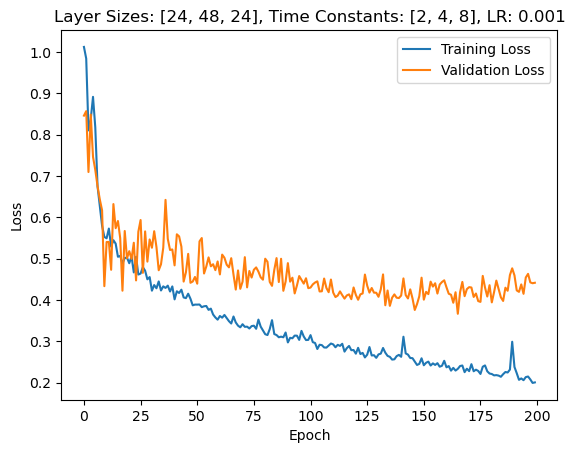

  0%|          | 1/200 [00:13<45:26, 13.70s/it]

Epoch 1/200, Training Loss: 1.012497970518076, Validation Loss: 0.8925328169550214


  1%|          | 2/200 [00:27<45:20, 13.74s/it]

Epoch 2/200, Training Loss: 0.9624907329397382, Validation Loss: 0.8375530966690609


  2%|▏         | 3/200 [00:40<44:19, 13.50s/it]

Epoch 3/200, Training Loss: 0.9078988905222911, Validation Loss: 0.7875516712665558


  2%|▏         | 4/200 [00:53<43:39, 13.36s/it]

Epoch 4/200, Training Loss: 0.8703152559838205, Validation Loss: 0.751265504530498


  2%|▎         | 5/200 [01:06<42:59, 13.23s/it]

Epoch 5/200, Training Loss: 0.8670123658090267, Validation Loss: 0.7382589727640152


  3%|▎         | 6/200 [01:20<43:01, 13.31s/it]

Epoch 6/200, Training Loss: 0.8145126700401306, Validation Loss: 0.6938793446336474


  4%|▎         | 7/200 [01:34<43:20, 13.47s/it]

Epoch 7/200, Training Loss: 0.7978452792707479, Validation Loss: 0.7202960274049214


  4%|▍         | 8/200 [01:47<43:11, 13.50s/it]

Epoch 8/200, Training Loss: 0.8029523542467153, Validation Loss: 0.6963521518877575


  4%|▍         | 9/200 [02:01<43:19, 13.61s/it]

Epoch 9/200, Training Loss: 0.7857688890313203, Validation Loss: 0.7333553582429886


  5%|▌         | 10/200 [02:14<42:56, 13.56s/it]

Epoch 10/200, Training Loss: 0.7769213442532521, Validation Loss: 0.6599982146705899


  6%|▌         | 11/200 [02:27<42:06, 13.37s/it]

Epoch 11/200, Training Loss: 0.7720830125628777, Validation Loss: 0.744133431996618


  6%|▌         | 12/200 [02:41<41:40, 13.30s/it]

Epoch 12/200, Training Loss: 0.7376964750154963, Validation Loss: 0.7361439168453217


  6%|▋         | 13/200 [02:54<41:40, 13.37s/it]

Epoch 13/200, Training Loss: 0.747049516664361, Validation Loss: 0.703443997672626


  7%|▋         | 14/200 [03:07<41:16, 13.31s/it]

Epoch 14/200, Training Loss: 0.7396237771466093, Validation Loss: 0.7120214509112495


  8%|▊         | 15/200 [03:21<41:10, 13.35s/it]

Epoch 15/200, Training Loss: 0.7212926638576219, Validation Loss: 0.7887213506868908


  8%|▊         | 16/200 [03:34<41:15, 13.46s/it]

Epoch 16/200, Training Loss: 0.7057040699248044, Validation Loss: 0.7544269050870623


  8%|▊         | 17/200 [03:48<41:14, 13.52s/it]

Epoch 17/200, Training Loss: 0.7123463063869836, Validation Loss: 0.7274541216237205


  9%|▉         | 18/200 [04:01<40:28, 13.34s/it]

Epoch 18/200, Training Loss: 0.710069866112943, Validation Loss: 0.6791044558797564


 10%|▉         | 19/200 [04:14<40:03, 13.28s/it]

Epoch 19/200, Training Loss: 0.6967694478214912, Validation Loss: 0.6996768031801496


 10%|█         | 20/200 [04:27<39:33, 13.19s/it]

Epoch 20/200, Training Loss: 0.6924780792785141, Validation Loss: 0.7089686521462032


 10%|█         | 21/200 [04:40<39:21, 13.19s/it]

Epoch 21/200, Training Loss: 0.6790401553207973, Validation Loss: 0.6744794398546219


 11%|█         | 22/200 [04:54<39:30, 13.32s/it]

Epoch 22/200, Training Loss: 0.6949848965653833, Validation Loss: 0.6840433542217527


 12%|█▏        | 23/200 [05:07<39:00, 13.22s/it]

Epoch 23/200, Training Loss: 0.6847938810879329, Validation Loss: 0.7525079420634678


 12%|█▏        | 24/200 [05:20<38:32, 13.14s/it]

Epoch 24/200, Training Loss: 0.6501417070064904, Validation Loss: 0.6539408160107476


 12%|█▎        | 25/200 [05:33<38:36, 13.24s/it]

Epoch 25/200, Training Loss: 0.7025123542209841, Validation Loss: 0.7257028818130493


 13%|█▎        | 26/200 [05:46<38:19, 13.21s/it]

Epoch 26/200, Training Loss: 0.6662854198014961, Validation Loss: 0.6840005708592278


 14%|█▎        | 27/200 [06:00<37:58, 13.17s/it]

Epoch 27/200, Training Loss: 0.6548981750911137, Validation Loss: 0.6490996181964874


 14%|█▍        | 28/200 [06:12<37:32, 13.10s/it]

Epoch 28/200, Training Loss: 0.679308683242438, Validation Loss: 0.6530406709228244


 14%|█▍        | 29/200 [06:25<37:10, 13.05s/it]

Epoch 29/200, Training Loss: 0.6439395237643764, Validation Loss: 0.6620015842573983


 15%|█▌        | 30/200 [06:38<36:56, 13.04s/it]

Epoch 30/200, Training Loss: 0.6368962998660106, Validation Loss: 0.6585868128708431


 16%|█▌        | 31/200 [06:51<36:45, 13.05s/it]

Epoch 31/200, Training Loss: 0.6242979984238463, Validation Loss: 0.6848528033920697


 16%|█▌        | 32/200 [07:04<36:28, 13.03s/it]

Epoch 32/200, Training Loss: 0.6250440697624998, Validation Loss: 0.7086581236549786


 16%|█▋        | 33/200 [07:17<36:16, 13.03s/it]

Epoch 33/200, Training Loss: 0.6391453574288566, Validation Loss: 0.6741158653582845


 17%|█▋        | 34/200 [07:31<36:27, 13.18s/it]

Epoch 34/200, Training Loss: 0.6078972332882431, Validation Loss: 0.6580469448651586


 18%|█▊        | 35/200 [07:44<36:20, 13.21s/it]

Epoch 35/200, Training Loss: 0.6298105727951482, Validation Loss: 0.6587929810796466


 18%|█▊        | 36/200 [07:57<35:54, 13.14s/it]

Epoch 36/200, Training Loss: 0.6465679502712106, Validation Loss: 0.6864149197936058


 18%|█▊        | 37/200 [08:10<35:37, 13.12s/it]

Epoch 37/200, Training Loss: 0.6380386706793083, Validation Loss: 0.6596500703266689


 19%|█▉        | 38/200 [08:24<35:55, 13.30s/it]

Epoch 38/200, Training Loss: 0.6460414466992864, Validation Loss: 0.6501047164201736


 20%|█▉        | 39/200 [08:37<35:34, 13.26s/it]

Epoch 39/200, Training Loss: 0.6471115952392794, Validation Loss: 0.6865142434835434


 20%|██        | 40/200 [08:50<35:09, 13.19s/it]

Epoch 40/200, Training Loss: 0.5988661090158066, Validation Loss: 0.65132175385952


 20%|██        | 41/200 [09:03<34:50, 13.14s/it]

Epoch 41/200, Training Loss: 0.6295792707857096, Validation Loss: 0.6451382328357015


 21%|██        | 42/200 [09:16<34:32, 13.12s/it]

Epoch 42/200, Training Loss: 0.6276274042309455, Validation Loss: 0.656024734888758


 22%|██▏       | 43/200 [09:29<34:19, 13.12s/it]

Epoch 43/200, Training Loss: 0.6152938148885403, Validation Loss: 0.7352024891546795


 22%|██▏       | 44/200 [09:42<34:01, 13.09s/it]

Epoch 44/200, Training Loss: 0.6368084443065355, Validation Loss: 0.6941676501716886


 22%|██▎       | 45/200 [09:55<33:43, 13.06s/it]

Epoch 45/200, Training Loss: 0.6269750718800526, Validation Loss: 0.606019523526941


 23%|██▎       | 46/200 [10:09<33:35, 13.09s/it]

Epoch 46/200, Training Loss: 0.6311744530245943, Validation Loss: 0.655869892665318


 24%|██▎       | 47/200 [10:22<33:51, 13.28s/it]

Epoch 47/200, Training Loss: 0.6233833342228295, Validation Loss: 0.7144959207092013


 24%|██▍       | 48/200 [10:36<33:33, 13.25s/it]

Epoch 48/200, Training Loss: 0.5927549302577972, Validation Loss: 0.5936466710908073


 24%|██▍       | 49/200 [10:49<33:16, 13.22s/it]

Epoch 49/200, Training Loss: 0.5999527050639099, Validation Loss: 0.6549575073378426


 25%|██▌       | 50/200 [11:02<33:19, 13.33s/it]

Epoch 50/200, Training Loss: 0.6384816203477248, Validation Loss: 0.6774018364293235


 26%|██▌       | 51/200 [11:15<32:55, 13.26s/it]

Epoch 51/200, Training Loss: 0.6181551684748452, Validation Loss: 0.6343786610024316


 26%|██▌       | 52/200 [11:28<32:35, 13.21s/it]

Epoch 52/200, Training Loss: 0.6088860518527481, Validation Loss: 0.6253874365772519


 26%|██▋       | 53/200 [11:41<32:12, 13.15s/it]

Epoch 53/200, Training Loss: 0.585367313533459, Validation Loss: 0.642531047974314


 27%|██▋       | 54/200 [11:55<32:02, 13.17s/it]

Epoch 54/200, Training Loss: 0.5903167274762999, Validation Loss: 0.6327781698533467


 28%|██▊       | 55/200 [12:08<31:42, 13.12s/it]

Epoch 55/200, Training Loss: 0.6232718516070888, Validation Loss: 0.605560730610575


 28%|██▊       | 56/200 [12:21<31:24, 13.08s/it]

Epoch 56/200, Training Loss: 0.6048198870892795, Validation Loss: 0.631322021995272


 28%|██▊       | 57/200 [12:34<31:13, 13.10s/it]

Epoch 57/200, Training Loss: 0.6011768770667741, Validation Loss: 0.7024687422173364


 29%|██▉       | 58/200 [12:47<31:00, 13.10s/it]

Epoch 58/200, Training Loss: 0.6207304748724092, Validation Loss: 0.6676834332091468


 30%|██▉       | 59/200 [13:01<31:11, 13.27s/it]

Epoch 59/200, Training Loss: 0.5867296845283149, Validation Loss: 0.6135638718094144


 30%|███       | 60/200 [13:14<30:55, 13.25s/it]

Epoch 60/200, Training Loss: 0.5862369914099855, Validation Loss: 0.6034013458660671


 30%|███       | 61/200 [13:27<30:38, 13.22s/it]

Epoch 61/200, Training Loss: 0.5810999293934624, Validation Loss: 0.6026987880468369


 31%|███       | 62/200 [13:40<30:20, 13.19s/it]

Epoch 62/200, Training Loss: 0.5937815449147854, Validation Loss: 0.6139168526445117


 32%|███▏      | 63/200 [13:54<30:27, 13.34s/it]

Epoch 63/200, Training Loss: 0.5874057125370458, Validation Loss: 0.6789246478251049


 32%|███▏      | 64/200 [14:07<30:09, 13.31s/it]

Epoch 64/200, Training Loss: 0.5624707194994081, Validation Loss: 0.6013187361615044


 32%|███▎      | 65/200 [14:20<29:46, 13.23s/it]

Epoch 65/200, Training Loss: 0.5964584642986082, Validation Loss: 0.606997583593641


 33%|███▎      | 66/200 [14:33<29:28, 13.20s/it]

Epoch 66/200, Training Loss: 0.5990176580424579, Validation Loss: 0.6925151092665536


 34%|███▎      | 67/200 [14:46<29:11, 13.17s/it]

Epoch 67/200, Training Loss: 0.5819273056848994, Validation Loss: 0.6598805700029645


 34%|███▍      | 68/200 [14:59<28:55, 13.15s/it]

Epoch 68/200, Training Loss: 0.573161354604757, Validation Loss: 0.6177708038261959


 34%|███▍      | 69/200 [15:13<28:41, 13.14s/it]

Epoch 69/200, Training Loss: 0.5561223665498337, Validation Loss: 0.6149814895221165


 35%|███▌      | 70/200 [15:26<28:26, 13.13s/it]

Epoch 70/200, Training Loss: 0.5819739749971425, Validation Loss: 0.65410387303148


 36%|███▌      | 71/200 [15:39<28:04, 13.06s/it]

Epoch 71/200, Training Loss: 0.5885503635091601, Validation Loss: 0.635523510830743


 36%|███▌      | 72/200 [15:52<28:19, 13.28s/it]

Epoch 72/200, Training Loss: 0.5683153080490401, Validation Loss: 0.653977558016777


 36%|███▋      | 73/200 [16:06<28:07, 13.29s/it]

Epoch 73/200, Training Loss: 0.5741378316339457, Validation Loss: 0.5922929814883641


 37%|███▋      | 74/200 [16:19<27:49, 13.25s/it]

Epoch 74/200, Training Loss: 0.5713666531274904, Validation Loss: 0.6469963086502892


 38%|███▊      | 75/200 [16:32<27:29, 13.19s/it]

Epoch 75/200, Training Loss: 0.5705438385594566, Validation Loss: 0.6256701179913112


 38%|███▊      | 76/200 [16:45<27:32, 13.33s/it]

Epoch 76/200, Training Loss: 0.5995049977077628, Validation Loss: 0.6203078329563141


 38%|███▊      | 77/200 [16:59<27:14, 13.29s/it]

Epoch 77/200, Training Loss: 0.585434967054511, Validation Loss: 0.6523059138229915


 39%|███▉      | 78/200 [17:12<26:50, 13.20s/it]

Epoch 78/200, Training Loss: 0.5797058163948778, Validation Loss: 0.6197886977876935


 40%|███▉      | 79/200 [17:25<26:34, 13.17s/it]

Epoch 79/200, Training Loss: 0.5855555596216669, Validation Loss: 0.6288115190608161


 40%|████      | 80/200 [17:38<26:11, 13.10s/it]

Epoch 80/200, Training Loss: 0.5669473679560535, Validation Loss: 0.5840709954500198


 40%|████      | 81/200 [17:51<25:55, 13.07s/it]

Epoch 81/200, Training Loss: 0.5716682143931119, Validation Loss: 0.6319096514156887


 41%|████      | 82/200 [18:04<25:50, 13.14s/it]

Epoch 82/200, Training Loss: 0.5508947594548171, Validation Loss: 0.6087490937539509


 42%|████▏     | 83/200 [18:17<25:30, 13.08s/it]

Epoch 83/200, Training Loss: 0.5653362015508255, Validation Loss: 0.5969440532582146


 42%|████▏     | 84/200 [18:30<25:18, 13.09s/it]

Epoch 84/200, Training Loss: 0.590595839158544, Validation Loss: 0.5945315744195666


 42%|████▎     | 85/200 [18:44<25:30, 13.31s/it]

Epoch 85/200, Training Loss: 0.5916824222735639, Validation Loss: 0.6316042542457581


 43%|████▎     | 86/200 [18:57<25:14, 13.28s/it]

Epoch 86/200, Training Loss: 0.5484494640017455, Validation Loss: 0.6248084434441158


 44%|████▎     | 87/200 [19:10<24:59, 13.27s/it]

Epoch 87/200, Training Loss: 0.5675399123497729, Validation Loss: 0.6052356543285506


 44%|████▍     | 88/200 [19:23<24:39, 13.21s/it]

Epoch 88/200, Training Loss: 0.5785980938740496, Validation Loss: 0.580263010093144


 44%|████▍     | 89/200 [19:37<24:47, 13.40s/it]

Epoch 89/200, Training Loss: 0.5659741894254144, Validation Loss: 0.6493690471564021


 45%|████▌     | 90/200 [19:50<24:24, 13.31s/it]

Epoch 90/200, Training Loss: 0.5608701554109465, Validation Loss: 0.5732280271393912


 46%|████▌     | 91/200 [20:04<24:05, 13.26s/it]

Epoch 91/200, Training Loss: 0.5594449937343597, Validation Loss: 0.6135844620210784


 46%|████▌     | 92/200 [20:17<23:44, 13.19s/it]

Epoch 92/200, Training Loss: 0.5499059687245567, Validation Loss: 0.5811174511909485


 46%|████▋     | 93/200 [20:29<23:22, 13.11s/it]

Epoch 93/200, Training Loss: 0.5596204332585605, Validation Loss: 0.6003085374832153


 47%|████▋     | 94/200 [20:43<23:11, 13.13s/it]

Epoch 94/200, Training Loss: 0.5654146474487377, Validation Loss: 0.5757518857717514


 48%|████▊     | 95/200 [20:56<22:57, 13.12s/it]

Epoch 95/200, Training Loss: 0.5465721083137224, Validation Loss: 0.6189286346946444


 48%|████▊     | 96/200 [21:09<22:39, 13.07s/it]

Epoch 96/200, Training Loss: 0.562107301545593, Validation Loss: 0.630265359367643


 48%|████▊     | 97/200 [21:22<22:20, 13.02s/it]

Epoch 97/200, Training Loss: 0.5695368293321358, Validation Loss: 0.637635129903044


 49%|████▉     | 98/200 [21:35<22:30, 13.24s/it]

Epoch 98/200, Training Loss: 0.5480021108996194, Validation Loss: 0.6392574427383286


 50%|████▉     | 99/200 [21:49<22:20, 13.27s/it]

Epoch 99/200, Training Loss: 0.5621947696748769, Validation Loss: 0.61830216220447


 50%|█████     | 100/200 [22:02<21:58, 13.18s/it]

Epoch 100/200, Training Loss: 0.5438533526546551, Validation Loss: 0.5914261969072478


 50%|█████     | 101/200 [22:15<21:37, 13.11s/it]

Epoch 101/200, Training Loss: 0.5558645449719339, Validation Loss: 0.6199568722929273


 51%|█████     | 102/200 [22:28<21:45, 13.32s/it]

Epoch 102/200, Training Loss: 0.5391159507463563, Validation Loss: 0.6623225126947675


 52%|█████▏    | 103/200 [22:42<21:35, 13.35s/it]

Epoch 103/200, Training Loss: 0.5371298579112539, Validation Loss: 0.5390205638749259


 52%|█████▏    | 104/200 [22:55<21:15, 13.28s/it]

Epoch 104/200, Training Loss: 0.5445938754194187, Validation Loss: 0.5756880747420448


 52%|█████▎    | 105/200 [23:08<20:53, 13.20s/it]

Epoch 105/200, Training Loss: 0.5633229191573161, Validation Loss: 0.6053663066455296


 53%|█████▎    | 106/200 [23:21<20:33, 13.13s/it]

Epoch 106/200, Training Loss: 0.55500531815133, Validation Loss: 0.5629642392907824


 54%|█████▎    | 107/200 [23:34<20:24, 13.17s/it]

Epoch 107/200, Training Loss: 0.5627596074680112, Validation Loss: 0.6199751517602375


 54%|█████▍    | 108/200 [23:47<20:09, 13.14s/it]

Epoch 108/200, Training Loss: 0.5430025567985931, Validation Loss: 0.5591774944748197


 55%|█████▍    | 109/200 [24:00<19:56, 13.15s/it]

Epoch 109/200, Training Loss: 0.5497388046867443, Validation Loss: 0.5751850306987762


 55%|█████▌    | 110/200 [24:13<19:39, 13.11s/it]

Epoch 110/200, Training Loss: 0.5653642826485183, Validation Loss: 0.6293180712631771


 56%|█████▌    | 111/200 [24:27<19:46, 13.33s/it]

Epoch 111/200, Training Loss: 0.5695358846547469, Validation Loss: 0.6184609234333038


 56%|█████▌    | 112/200 [24:41<19:37, 13.38s/it]

Epoch 112/200, Training Loss: 0.5646655902547656, Validation Loss: 0.5571004780275481


 56%|█████▋    | 113/200 [24:54<19:15, 13.29s/it]

Epoch 113/200, Training Loss: 0.5562631499092534, Validation Loss: 0.5878273802144187


 57%|█████▋    | 114/200 [25:07<18:59, 13.25s/it]

Epoch 114/200, Training Loss: 0.5660930399624806, Validation Loss: 0.5941739082336426


 57%|█████▊    | 115/200 [25:21<18:56, 13.37s/it]

Epoch 115/200, Training Loss: 0.5426825318696364, Validation Loss: 0.5846301381077085


 58%|█████▊    | 116/200 [25:34<18:42, 13.37s/it]

Epoch 116/200, Training Loss: 0.5356322442585567, Validation Loss: 0.638403628553663


 58%|█████▊    | 117/200 [25:47<18:23, 13.29s/it]

Epoch 117/200, Training Loss: 0.5281360554245284, Validation Loss: 0.6110252503837857


 59%|█████▉    | 118/200 [26:00<18:03, 13.21s/it]

Epoch 118/200, Training Loss: 0.5361308641028855, Validation Loss: 0.5751762070826122


 60%|█████▉    | 119/200 [26:13<17:48, 13.19s/it]

Epoch 119/200, Training Loss: 0.5782776047598641, Validation Loss: 0.6251376441546849


 60%|██████    | 120/200 [26:27<17:36, 13.21s/it]

Epoch 120/200, Training Loss: 0.5657003651250083, Validation Loss: 0.602116054722241


 60%|██████    | 121/200 [26:40<17:18, 13.15s/it]

Epoch 121/200, Training Loss: 0.5221581689591678, Validation Loss: 0.6046191837106433


 61%|██████    | 122/200 [26:53<17:05, 13.14s/it]

Epoch 122/200, Training Loss: 0.5364620055792466, Validation Loss: 0.5477795419948441


 62%|██████▏   | 123/200 [27:06<16:52, 13.15s/it]

Epoch 123/200, Training Loss: 0.5290742190379016, Validation Loss: 0.6068435226167951


 62%|██████▏   | 124/200 [27:20<16:53, 13.34s/it]

Epoch 124/200, Training Loss: 0.5221889468858827, Validation Loss: 0.566524475812912


 62%|██████▎   | 125/200 [27:33<16:40, 13.35s/it]

Epoch 125/200, Training Loss: 0.5277007981291357, Validation Loss: 0.5703816797052111


 63%|██████▎   | 126/200 [27:46<16:20, 13.25s/it]

Epoch 126/200, Training Loss: 0.5209185295509842, Validation Loss: 0.6029763530407634


 64%|██████▎   | 127/200 [27:59<16:05, 13.22s/it]

Epoch 127/200, Training Loss: 0.5261458726424091, Validation Loss: 0.614110433629581


 64%|██████▍   | 128/200 [28:13<16:02, 13.37s/it]

Epoch 128/200, Training Loss: 0.5232838605934719, Validation Loss: 0.6206724366971424


 64%|██████▍   | 129/200 [28:26<15:53, 13.42s/it]

Epoch 129/200, Training Loss: 0.5202167517734024, Validation Loss: 0.5892767799752099


 65%|██████▌   | 130/200 [28:40<15:32, 13.33s/it]

Epoch 130/200, Training Loss: 0.524970459769357, Validation Loss: 0.6059918361050742


 66%|██████▌   | 131/200 [28:53<15:14, 13.25s/it]

Epoch 131/200, Training Loss: 0.5325956518919963, Validation Loss: 0.5657071173191071


 66%|██████▌   | 132/200 [29:06<14:58, 13.22s/it]

Epoch 132/200, Training Loss: 0.5222801940058762, Validation Loss: 0.6046100173677716


 66%|██████▋   | 133/200 [29:19<14:45, 13.22s/it]

Epoch 133/200, Training Loss: 0.5448726308795641, Validation Loss: 0.5963598702635083


 67%|██████▋   | 134/200 [29:32<14:31, 13.21s/it]

Epoch 134/200, Training Loss: 0.536628929511556, Validation Loss: 0.587382510304451


 68%|██████▊   | 135/200 [29:45<14:16, 13.17s/it]

Epoch 135/200, Training Loss: 0.5290058862488225, Validation Loss: 0.6526521188872201


 68%|██████▊   | 136/200 [29:58<14:01, 13.15s/it]

Epoch 136/200, Training Loss: 0.5194576438867821, Validation Loss: 0.5467003626482827


 68%|██████▊   | 137/200 [30:12<14:04, 13.41s/it]

Epoch 137/200, Training Loss: 0.5135214559312137, Validation Loss: 0.6168132381779807


 69%|██████▉   | 138/200 [30:26<13:48, 13.36s/it]

Epoch 138/200, Training Loss: 0.5013952367710617, Validation Loss: 0.6221005533422742


 70%|██████▉   | 139/200 [30:39<13:31, 13.31s/it]

Epoch 139/200, Training Loss: 0.5326871832586685, Validation Loss: 0.6106633288519723


 70%|███████   | 140/200 [30:52<13:16, 13.28s/it]

Epoch 140/200, Training Loss: 0.5215438503139423, Validation Loss: 0.6269139179161617


 70%|███████   | 141/200 [31:06<13:07, 13.35s/it]

Epoch 141/200, Training Loss: 0.5247252352957456, Validation Loss: 0.5341041364840099


 71%|███████   | 142/200 [31:19<12:56, 13.39s/it]

Epoch 142/200, Training Loss: 0.5214765043753498, Validation Loss: 0.5509875608342034


 72%|███████▏  | 143/200 [31:32<12:37, 13.29s/it]

Epoch 143/200, Training Loss: 0.5062765383495474, Validation Loss: 0.5555576022182193


 72%|███████▏  | 144/200 [31:45<12:23, 13.28s/it]

Epoch 144/200, Training Loss: 0.5126143036023626, Validation Loss: 0.5670234092644283


 72%|███████▎  | 145/200 [31:58<12:07, 13.23s/it]

Epoch 145/200, Training Loss: 0.5237207289011974, Validation Loss: 0.6094449503081185


 73%|███████▎  | 146/200 [32:12<11:54, 13.23s/it]

Epoch 146/200, Training Loss: 0.5160489355055791, Validation Loss: 0.6097031320844378


 74%|███████▎  | 147/200 [32:25<11:39, 13.21s/it]

Epoch 147/200, Training Loss: 0.5220527806372013, Validation Loss: 0.5265305319002697


 74%|███████▍  | 148/200 [32:38<11:23, 13.14s/it]

Epoch 148/200, Training Loss: 0.5085241111381998, Validation Loss: 0.6084156249250684


 74%|███████▍  | 149/200 [32:51<11:07, 13.08s/it]

Epoch 149/200, Training Loss: 0.5241022239316184, Validation Loss: 0.5375374789748874


 75%|███████▌  | 150/200 [33:05<11:06, 13.32s/it]

Epoch 150/200, Training Loss: 0.5206009515051572, Validation Loss: 0.6388391554355621


 76%|███████▌  | 151/200 [33:18<10:56, 13.39s/it]

Epoch 151/200, Training Loss: 0.5269135422301743, Validation Loss: 0.5924910732678005


 76%|███████▌  | 152/200 [33:31<10:40, 13.33s/it]

Epoch 152/200, Training Loss: 0.5119013471423455, Validation Loss: 0.5315139165946415


 76%|███████▋  | 153/200 [33:44<10:22, 13.24s/it]

Epoch 153/200, Training Loss: 0.49749055645375884, Validation Loss: 0.6032877436705998


 77%|███████▋  | 154/200 [33:59<10:22, 13.53s/it]

Epoch 154/200, Training Loss: 0.5123719646120971, Validation Loss: 0.5301996788808278


 78%|███████▊  | 155/200 [34:12<10:06, 13.47s/it]

Epoch 155/200, Training Loss: 0.5075650535664469, Validation Loss: 0.5810323570455823


 78%|███████▊  | 156/200 [34:25<09:48, 13.37s/it]

Epoch 156/200, Training Loss: 0.5055408747691028, Validation Loss: 0.5495468314204898


 78%|███████▊  | 157/200 [34:38<09:33, 13.34s/it]

Epoch 157/200, Training Loss: 0.5156619650013042, Validation Loss: 0.6008931206805366


 79%|███████▉  | 158/200 [34:51<09:16, 13.25s/it]

Epoch 158/200, Training Loss: 0.5230689116244046, Validation Loss: 0.5363821344716209


 80%|███████▉  | 159/200 [35:04<09:01, 13.20s/it]

Epoch 159/200, Training Loss: 0.5215550436163848, Validation Loss: 0.5912139926637922


 80%|████████  | 160/200 [35:18<08:49, 13.23s/it]

Epoch 160/200, Training Loss: 0.5084419261734441, Validation Loss: 0.548245798264231


 80%|████████  | 161/200 [35:31<08:33, 13.18s/it]

Epoch 161/200, Training Loss: 0.5016953995767629, Validation Loss: 0.578988579767091


 81%|████████  | 162/200 [35:44<08:21, 13.19s/it]

Epoch 162/200, Training Loss: 0.5163465968842776, Validation Loss: 0.547068681035723


 82%|████████▏ | 163/200 [35:58<08:13, 13.33s/it]

Epoch 163/200, Training Loss: 0.5020172168623727, Validation Loss: 0.5401277797562736


 82%|████████▏ | 164/200 [36:11<08:01, 13.36s/it]

Epoch 164/200, Training Loss: 0.5010169828837773, Validation Loss: 0.5232249008757728


 82%|████████▎ | 165/200 [36:24<07:45, 13.31s/it]

Epoch 165/200, Training Loss: 0.5049889079242382, Validation Loss: 0.5489143005439213


 83%|████████▎ | 166/200 [36:37<07:29, 13.23s/it]

Epoch 166/200, Training Loss: 0.49297483912054096, Validation Loss: 0.5341879980904716


 84%|████████▎ | 167/200 [36:51<07:23, 13.43s/it]

Epoch 167/200, Training Loss: 0.5101366852814296, Validation Loss: 0.6065668123109


 84%|████████▍ | 168/200 [37:05<07:09, 13.41s/it]

Epoch 168/200, Training Loss: 0.5060101663166622, Validation Loss: 0.5406467573983329


 84%|████████▍ | 169/200 [37:18<06:52, 13.29s/it]

Epoch 169/200, Training Loss: 0.4895907255276194, Validation Loss: 0.5567426340920585


 85%|████████▌ | 170/200 [37:31<06:36, 13.23s/it]

Epoch 170/200, Training Loss: 0.49702706595636764, Validation Loss: 0.5634159467050007


 86%|████████▌ | 171/200 [37:44<06:21, 13.17s/it]

Epoch 171/200, Training Loss: 0.4973345365164415, Validation Loss: 0.5904534522976194


 86%|████████▌ | 172/200 [37:57<06:08, 13.17s/it]

Epoch 172/200, Training Loss: 0.49931896238956813, Validation Loss: 0.5408936951841626


 86%|████████▋ | 173/200 [38:10<05:54, 13.12s/it]

Epoch 173/200, Training Loss: 0.5094986957199169, Validation Loss: 0.5510544904640743


 87%|████████▋ | 174/200 [38:23<05:41, 13.15s/it]

Epoch 174/200, Training Loss: 0.49907952209688583, Validation Loss: 0.5549528045313699


 88%|████████▊ | 175/200 [38:36<05:29, 13.17s/it]

Epoch 175/200, Training Loss: 0.4891363255820184, Validation Loss: 0.534764079110963


 88%|████████▊ | 176/200 [38:50<05:20, 13.34s/it]

Epoch 176/200, Training Loss: 0.5065365439316012, Validation Loss: 0.5835797424827304


 88%|████████▊ | 177/200 [39:04<05:07, 13.37s/it]

Epoch 177/200, Training Loss: 0.4977880435169868, Validation Loss: 0.5145742637770516


 89%|████████▉ | 178/200 [39:17<04:53, 13.36s/it]

Epoch 178/200, Training Loss: 0.4952455753425382, Validation Loss: 0.5514627673796245


 90%|████████▉ | 179/200 [39:30<04:39, 13.29s/it]

Epoch 179/200, Training Loss: 0.5118014098338362, Validation Loss: 0.5910572324480329


 90%|█████████ | 180/200 [39:44<04:29, 13.49s/it]

Epoch 180/200, Training Loss: 0.5057796079595134, Validation Loss: 0.5863935819693974


 90%|█████████ | 181/200 [39:58<04:17, 13.57s/it]

Epoch 181/200, Training Loss: 0.4864592214800277, Validation Loss: 0.5454014475856509


 91%|█████████ | 182/200 [40:11<04:02, 13.49s/it]

Epoch 182/200, Training Loss: 0.5141223427259697, Validation Loss: 0.5775725160326276


 92%|█████████▏| 183/200 [40:24<03:46, 13.33s/it]

Epoch 183/200, Training Loss: 0.4912814419224577, Validation Loss: 0.5233455917664936


 92%|█████████▏| 184/200 [40:37<03:31, 13.24s/it]

Epoch 184/200, Training Loss: 0.48109058726508663, Validation Loss: 0.5723672211170197


 92%|█████████▎| 185/200 [40:50<03:18, 13.25s/it]

Epoch 185/200, Training Loss: 0.49407718147871627, Validation Loss: 0.5818951278924942


 93%|█████████▎| 186/200 [41:03<03:04, 13.19s/it]

Epoch 186/200, Training Loss: 0.479102039674543, Validation Loss: 0.5762342086860112


 94%|█████████▎| 187/200 [41:17<02:51, 13.20s/it]

Epoch 187/200, Training Loss: 0.471209409101954, Validation Loss: 0.5898939711706979


 94%|█████████▍| 188/200 [41:30<02:38, 13.20s/it]

Epoch 188/200, Training Loss: 0.49328321049798207, Validation Loss: 0.6111511439085007


 94%|█████████▍| 189/200 [41:44<02:27, 13.37s/it]

Epoch 189/200, Training Loss: 0.4914848697635363, Validation Loss: 0.5721334240266255


 95%|█████████▌| 190/200 [41:57<02:14, 13.41s/it]

Epoch 190/200, Training Loss: 0.47729856000756316, Validation Loss: 0.5321763093982425


 96%|█████████▌| 191/200 [42:10<01:59, 13.30s/it]

Epoch 191/200, Training Loss: 0.47228857593716317, Validation Loss: 0.5765184887817928


 96%|█████████▌| 192/200 [42:24<01:48, 13.52s/it]

Epoch 192/200, Training Loss: 0.4837463694923329, Validation Loss: 0.5670921206474304


 96%|█████████▋| 193/200 [42:37<01:34, 13.45s/it]

Epoch 193/200, Training Loss: 0.45882915466461544, Validation Loss: 0.5302731501204627


 97%|█████████▋| 194/200 [42:51<01:20, 13.36s/it]

Epoch 194/200, Training Loss: 0.4851760920488609, Validation Loss: 0.5690756269863674


 98%|█████████▊| 195/200 [43:04<01:06, 13.32s/it]

Epoch 195/200, Training Loss: 0.47352963461066194, Validation Loss: 0.6155763353620257


 98%|█████████▊| 196/200 [43:17<00:53, 13.30s/it]

Epoch 196/200, Training Loss: 0.4726362352101308, Validation Loss: 0.5429265307528632


 98%|█████████▊| 197/200 [43:30<00:39, 13.25s/it]

Epoch 197/200, Training Loss: 0.48925094671969144, Validation Loss: 0.5527757661683219


 99%|█████████▉| 198/200 [43:43<00:26, 13.23s/it]

Epoch 198/200, Training Loss: 0.47466374230834674, Validation Loss: 0.56161268055439


100%|█████████▉| 199/200 [43:56<00:13, 13.19s/it]

Epoch 199/200, Training Loss: 0.4949122223089326, Validation Loss: 0.5606665313243866


100%|██████████| 200/200 [44:10<00:00, 13.25s/it]

Epoch 200/200, Training Loss: 0.4921017038934636, Validation Loss: 0.5745971373149327
Final Accuracy: 83.73%, Precision: 0.79, Recall: 0.93


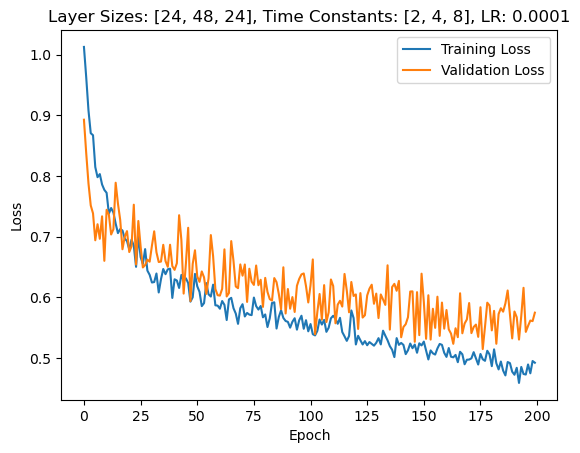

  0%|          | 1/200 [00:13<45:53, 13.83s/it]

Epoch 1/200, Training Loss: 1.0684905805677738, Validation Loss: 0.8625916583197457


  1%|          | 2/200 [00:27<45:32, 13.80s/it]

Epoch 2/200, Training Loss: 1.0617730977400295, Validation Loss: 0.8544193421091352


  2%|▏         | 3/200 [00:40<44:19, 13.50s/it]

Epoch 3/200, Training Loss: 0.831565962647492, Validation Loss: 0.7220602376120431


  2%|▏         | 4/200 [00:53<43:36, 13.35s/it]

Epoch 4/200, Training Loss: 0.7865434581378721, Validation Loss: 0.6958557346037456


  2%|▎         | 5/200 [01:06<42:56, 13.21s/it]

Epoch 5/200, Training Loss: 0.7645596040869659, Validation Loss: 0.6885386109352112


  3%|▎         | 6/200 [01:20<43:21, 13.41s/it]

Epoch 6/200, Training Loss: 0.6632891696579052, Validation Loss: 0.6309091150760651


  4%|▎         | 7/200 [01:34<43:38, 13.57s/it]

Epoch 7/200, Training Loss: 0.593030590915455, Validation Loss: 0.5333437642880848


  4%|▍         | 8/200 [01:48<43:31, 13.60s/it]

Epoch 8/200, Training Loss: 0.5818871858547319, Validation Loss: 0.5711205516542707


  4%|▍         | 9/200 [02:02<43:32, 13.68s/it]

Epoch 9/200, Training Loss: 0.581441138150557, Validation Loss: 0.5623127136911664


  5%|▌         | 10/200 [02:15<43:12, 13.64s/it]

Epoch 10/200, Training Loss: 0.5565449977820774, Validation Loss: 0.48851204024893896


  6%|▌         | 11/200 [02:28<42:21, 13.44s/it]

Epoch 11/200, Training Loss: 0.5983464147122401, Validation Loss: 0.5043403932026455


  6%|▌         | 12/200 [02:42<42:37, 13.60s/it]

Epoch 12/200, Training Loss: 0.4962447715817757, Validation Loss: 0.5186009790216174


  6%|▋         | 13/200 [02:55<41:56, 13.46s/it]

Epoch 13/200, Training Loss: 0.5047659677154613, Validation Loss: 0.5033137202262878


  7%|▋         | 14/200 [03:08<41:25, 13.36s/it]

Epoch 14/200, Training Loss: 0.502808688103028, Validation Loss: 0.6603883270706449


  8%|▊         | 15/200 [03:21<40:50, 13.24s/it]

Epoch 15/200, Training Loss: 0.5892952821164761, Validation Loss: 0.4851695937769754


  8%|▊         | 16/200 [03:35<41:05, 13.40s/it]

Epoch 16/200, Training Loss: 0.5160948161808949, Validation Loss: 0.4839589904461588


  8%|▊         | 17/200 [03:48<40:51, 13.40s/it]

Epoch 17/200, Training Loss: 0.4527577466841014, Validation Loss: 0.4495883136987686


  9%|▉         | 18/200 [04:01<40:15, 13.27s/it]

Epoch 18/200, Training Loss: 0.46273266819288145, Validation Loss: 0.5049763641187123


 10%|▉         | 19/200 [04:14<39:41, 13.16s/it]

Epoch 19/200, Training Loss: 0.43430916543276804, Validation Loss: 0.5628014430403709


 10%|█         | 20/200 [04:28<39:34, 13.19s/it]

Epoch 20/200, Training Loss: 0.4536988676156638, Validation Loss: 0.5497440434992313


 10%|█         | 21/200 [04:41<39:45, 13.33s/it]

Epoch 21/200, Training Loss: 0.5059531752793294, Validation Loss: 0.48816107639244627


 11%|█         | 22/200 [04:55<39:29, 13.31s/it]

Epoch 22/200, Training Loss: 0.4438934652310497, Validation Loss: 0.5254230584417071


 12%|█▏        | 23/200 [05:08<39:07, 13.26s/it]

Epoch 23/200, Training Loss: 0.4323060301677236, Validation Loss: 0.4177254182951791


 12%|█▏        | 24/200 [05:21<38:44, 13.21s/it]

Epoch 24/200, Training Loss: 0.4475258670325549, Validation Loss: 0.43247731775045395


 12%|█▎        | 25/200 [05:35<39:05, 13.40s/it]

Epoch 25/200, Training Loss: 0.43012569198068584, Validation Loss: 0.4410515810762133


 13%|█▎        | 26/200 [05:48<38:39, 13.33s/it]

Epoch 26/200, Training Loss: 0.44107911412446005, Validation Loss: 0.4658943989447185


 14%|█▎        | 27/200 [06:01<38:15, 13.27s/it]

Epoch 27/200, Training Loss: 0.4796842077992997, Validation Loss: 0.44461188997541157


 14%|█▍        | 28/200 [06:14<37:52, 13.21s/it]

Epoch 28/200, Training Loss: 0.42573597436805943, Validation Loss: 0.5747239190552916


 14%|█▍        | 29/200 [06:27<37:31, 13.17s/it]

Epoch 29/200, Training Loss: 0.4175709365111477, Validation Loss: 0.4788857836808477


 15%|█▌        | 30/200 [06:40<37:14, 13.15s/it]

Epoch 30/200, Training Loss: 0.41324448585510254, Validation Loss: 0.5546056383422443


 16%|█▌        | 31/200 [06:53<36:54, 13.10s/it]

Epoch 31/200, Training Loss: 0.3911671034007702, Validation Loss: 0.4374031818338803


 16%|█▌        | 32/200 [07:06<36:51, 13.16s/it]

Epoch 32/200, Training Loss: 0.429452897805088, Validation Loss: 0.4832324194056647


 16%|█▋        | 33/200 [07:19<36:26, 13.09s/it]

Epoch 33/200, Training Loss: 0.4107643119850249, Validation Loss: 0.46180535373943193


 17%|█▋        | 34/200 [07:33<36:37, 13.24s/it]

Epoch 34/200, Training Loss: 0.4176078196966423, Validation Loss: 0.4432166133608137


 18%|█▊        | 35/200 [07:46<36:32, 13.29s/it]

Epoch 35/200, Training Loss: 0.4025831551484342, Validation Loss: 0.4380980761987822


 18%|█▊        | 36/200 [07:59<36:06, 13.21s/it]

Epoch 36/200, Training Loss: 0.40235030707323327, Validation Loss: 0.46650687285832


 18%|█▊        | 37/200 [08:13<35:55, 13.22s/it]

Epoch 37/200, Training Loss: 0.3965965841176375, Validation Loss: 0.46488218914185253


 19%|█▉        | 38/200 [08:26<36:04, 13.36s/it]

Epoch 38/200, Training Loss: 0.37993544340133667, Validation Loss: 0.47314731244529995


 20%|█▉        | 39/200 [08:40<35:48, 13.34s/it]

Epoch 39/200, Training Loss: 0.4012765369887622, Validation Loss: 0.45167408670697895


 20%|██        | 40/200 [08:53<35:30, 13.31s/it]

Epoch 40/200, Training Loss: 0.37151371786054577, Validation Loss: 0.4999242861356054


 20%|██        | 41/200 [09:06<35:00, 13.21s/it]

Epoch 41/200, Training Loss: 0.38157406224394746, Validation Loss: 0.4511779717036656


 21%|██        | 42/200 [09:19<34:38, 13.15s/it]

Epoch 42/200, Training Loss: 0.38313602810760716, Validation Loss: 0.46280998310872484


 22%|██▏       | 43/200 [09:32<34:30, 13.19s/it]

Epoch 43/200, Training Loss: 0.39513841144881157, Validation Loss: 0.48260398528405596


 22%|██▏       | 44/200 [09:45<34:11, 13.15s/it]

Epoch 44/200, Training Loss: 0.3937735310140646, Validation Loss: 0.4028005504182407


 22%|██▎       | 45/200 [09:59<34:06, 13.20s/it]

Epoch 45/200, Training Loss: 0.3658511921201112, Validation Loss: 0.5174345576337406


 23%|██▎       | 46/200 [10:12<33:51, 13.19s/it]

Epoch 46/200, Training Loss: 0.4262210378107035, Validation Loss: 0.4127986782363483


 24%|██▎       | 47/200 [10:25<34:03, 13.36s/it]

Epoch 47/200, Training Loss: 0.38859623951731986, Validation Loss: 0.4471831949693816


 24%|██▍       | 48/200 [10:39<33:52, 13.37s/it]

Epoch 48/200, Training Loss: 0.4221257851371225, Validation Loss: 0.5380138994327613


 24%|██▍       | 49/200 [10:52<33:28, 13.30s/it]

Epoch 49/200, Training Loss: 0.38804457913029866, Validation Loss: 0.45248642776693615


 25%|██▌       | 50/200 [11:05<33:11, 13.28s/it]

Epoch 50/200, Training Loss: 0.40207064503206397, Validation Loss: 0.47225913618292126


 26%|██▌       | 51/200 [11:19<33:23, 13.45s/it]

Epoch 51/200, Training Loss: 0.40841167687245133, Validation Loss: 0.5089792822088514


 26%|██▌       | 52/200 [11:32<33:00, 13.38s/it]

Epoch 52/200, Training Loss: 0.4242712325363789, Validation Loss: 0.4566302512373243


 26%|██▋       | 53/200 [11:45<32:41, 13.34s/it]

Epoch 53/200, Training Loss: 0.37838351614070387, Validation Loss: 0.4655846745840141


 27%|██▋       | 54/200 [11:59<32:17, 13.27s/it]

Epoch 54/200, Training Loss: 0.38895215557993584, Validation Loss: 0.3994424651776041


 28%|██▊       | 55/200 [12:12<32:06, 13.29s/it]

Epoch 55/200, Training Loss: 0.3773855769409324, Validation Loss: 0.4195960206644876


 28%|██▊       | 56/200 [12:25<31:39, 13.19s/it]

Epoch 56/200, Training Loss: 0.36470672839655066, Validation Loss: 0.4472805399979864


 28%|██▊       | 57/200 [12:38<31:18, 13.14s/it]

Epoch 57/200, Training Loss: 0.3960034005203337, Validation Loss: 0.4118298866919109


 29%|██▉       | 58/200 [12:51<31:10, 13.17s/it]

Epoch 58/200, Training Loss: 0.37980963936391865, Validation Loss: 0.4099512408886637


 30%|██▉       | 59/200 [13:04<30:53, 13.15s/it]

Epoch 59/200, Training Loss: 0.34238427582214465, Validation Loss: 0.46737244512353626


 30%|███       | 60/200 [13:18<31:08, 13.34s/it]

Epoch 60/200, Training Loss: 0.4056513236378724, Validation Loss: 0.41226403628076824


 30%|███       | 61/200 [13:31<30:54, 13.34s/it]

Epoch 61/200, Training Loss: 0.40342617238748746, Validation Loss: 0.4170589404446738


 31%|███       | 62/200 [13:44<30:31, 13.27s/it]

Epoch 62/200, Training Loss: 0.3816895563647432, Validation Loss: 0.4717753103801182


 32%|███▏      | 63/200 [13:58<30:22, 13.30s/it]

Epoch 63/200, Training Loss: 0.37079363836432405, Validation Loss: 0.40161301621368956


 32%|███▏      | 64/200 [14:12<30:26, 13.43s/it]

Epoch 64/200, Training Loss: 0.3469702027878671, Validation Loss: 0.5007697269320488


 32%|███▎      | 65/200 [14:25<30:14, 13.44s/it]

Epoch 65/200, Training Loss: 0.3599594683860833, Validation Loss: 0.5066170990467072


 33%|███▎      | 66/200 [14:38<29:45, 13.32s/it]

Epoch 66/200, Training Loss: 0.3498524191244593, Validation Loss: 0.4279934103999819


 34%|███▎      | 67/200 [14:51<29:29, 13.31s/it]

Epoch 67/200, Training Loss: 0.35171467459426736, Validation Loss: 0.42798974364995956


 34%|███▍      | 68/200 [15:05<29:16, 13.31s/it]

Epoch 68/200, Training Loss: 0.35523642782332765, Validation Loss: 0.4339431811656271


 34%|███▍      | 69/200 [15:18<28:54, 13.24s/it]

Epoch 69/200, Training Loss: 0.32257158337336667, Validation Loss: 0.44968145127807346


 35%|███▌      | 70/200 [15:31<28:45, 13.27s/it]

Epoch 70/200, Training Loss: 0.3859909945782625, Validation Loss: 0.4102223866752216


 36%|███▌      | 71/200 [15:44<28:27, 13.24s/it]

Epoch 71/200, Training Loss: 0.3368138003180612, Validation Loss: 0.44320873490401674


 36%|███▌      | 72/200 [15:57<28:06, 13.17s/it]

Epoch 72/200, Training Loss: 0.38672129809856415, Validation Loss: 0.4961553279842649


 36%|███▋      | 73/200 [16:11<28:22, 13.41s/it]

Epoch 73/200, Training Loss: 0.368173859029446, Validation Loss: 0.43432057968207766


 37%|███▋      | 74/200 [16:24<28:03, 13.36s/it]

Epoch 74/200, Training Loss: 0.3654463400818267, Validation Loss: 0.44679034714187893


 38%|███▊      | 75/200 [16:38<27:45, 13.32s/it]

Epoch 75/200, Training Loss: 0.36171923380977705, Validation Loss: 0.47539350390434265


 38%|███▊      | 76/200 [16:51<27:32, 13.33s/it]

Epoch 76/200, Training Loss: 0.38630603731803176, Validation Loss: 0.44164187567574636


 38%|███▊      | 77/200 [17:05<27:38, 13.49s/it]

Epoch 77/200, Training Loss: 0.3271044693746657, Validation Loss: 0.44231793177979334


 39%|███▉      | 78/200 [17:18<27:19, 13.43s/it]

Epoch 78/200, Training Loss: 0.35639664615100286, Validation Loss: 0.4445249395711081


 40%|███▉      | 79/200 [17:31<26:58, 13.37s/it]

Epoch 79/200, Training Loss: 0.33735125385365394, Validation Loss: 0.4371027329138347


 40%|████      | 80/200 [17:44<26:31, 13.27s/it]

Epoch 80/200, Training Loss: 0.4060407538177832, Validation Loss: 0.4857460760644504


 40%|████      | 81/200 [17:58<26:18, 13.26s/it]

Epoch 81/200, Training Loss: 0.3398543928029402, Validation Loss: 0.44397549437625067


 41%|████      | 82/200 [18:11<26:01, 13.23s/it]

Epoch 82/200, Training Loss: 0.3532921399148005, Validation Loss: 0.4407097079924175


 42%|████▏     | 83/200 [18:24<25:47, 13.22s/it]

Epoch 83/200, Training Loss: 0.3489235181291148, Validation Loss: 0.44977342975991114


 42%|████▏     | 84/200 [18:37<25:27, 13.16s/it]

Epoch 84/200, Training Loss: 0.35380715103644245, Validation Loss: 0.44281236082315445


 42%|████▎     | 85/200 [18:50<25:08, 13.12s/it]

Epoch 85/200, Training Loss: 0.35575065663400685, Validation Loss: 0.43895105751497404


 43%|████▎     | 86/200 [19:04<25:19, 13.33s/it]

Epoch 86/200, Training Loss: 0.3560633324789551, Validation Loss: 0.45165409786360605


 44%|████▎     | 87/200 [19:17<25:11, 13.38s/it]

Epoch 87/200, Training Loss: 0.33883518465566187, Validation Loss: 0.45941530806677683


 44%|████▍     | 88/200 [19:31<24:56, 13.36s/it]

Epoch 88/200, Training Loss: 0.33926391446927806, Validation Loss: 0.4196285328694752


 44%|████▍     | 89/200 [19:44<24:35, 13.29s/it]

Epoch 89/200, Training Loss: 0.3180466076394297, Validation Loss: 0.39715220992054256


 45%|████▌     | 90/200 [19:58<24:43, 13.49s/it]

Epoch 90/200, Training Loss: 0.3216186044913418, Validation Loss: 0.3776627906731197


 46%|████▌     | 91/200 [20:12<24:36, 13.55s/it]

Epoch 91/200, Training Loss: 0.34639373056168826, Validation Loss: 0.43258318837199894


 46%|████▌     | 92/200 [20:25<24:06, 13.40s/it]

Epoch 92/200, Training Loss: 0.32955820127478186, Validation Loss: 0.38196856741394314


 46%|████▋     | 93/200 [20:38<23:45, 13.33s/it]

Epoch 93/200, Training Loss: 0.31675885786425395, Validation Loss: 0.4320041558572224


 47%|████▋     | 94/200 [20:51<23:31, 13.32s/it]

Epoch 94/200, Training Loss: 0.3877807580075174, Validation Loss: 0.4155717300517218


 48%|████▊     | 95/200 [21:04<23:08, 13.22s/it]

Epoch 95/200, Training Loss: 0.34314953479564414, Validation Loss: 0.40396079633917126


 48%|████▊     | 96/200 [21:17<22:50, 13.17s/it]

Epoch 96/200, Training Loss: 0.32799754263657444, Validation Loss: 0.41282948212964193


 48%|████▊     | 97/200 [21:30<22:33, 13.14s/it]

Epoch 97/200, Training Loss: 0.3184001797212745, Validation Loss: 0.41183831010546


 49%|████▉     | 98/200 [21:43<22:14, 13.08s/it]

Epoch 98/200, Training Loss: 0.3063365977327779, Validation Loss: 0.40444983754839214


 50%|████▉     | 99/200 [21:57<22:24, 13.31s/it]

Epoch 99/200, Training Loss: 0.32924502905247344, Validation Loss: 0.4343513324856758


 50%|█████     | 100/200 [22:10<22:17, 13.37s/it]

Epoch 100/200, Training Loss: 0.3275349550652054, Validation Loss: 0.4440259848322187


 50%|█████     | 101/200 [22:24<22:00, 13.34s/it]

Epoch 101/200, Training Loss: 0.3423927274515044, Validation Loss: 0.48406215970005306


 51%|█████     | 102/200 [22:37<21:39, 13.26s/it]

Epoch 102/200, Training Loss: 0.3216888522202114, Validation Loss: 0.389665815447058


 52%|█████▏    | 103/200 [22:51<21:40, 13.41s/it]

Epoch 103/200, Training Loss: 0.30608848932216753, Validation Loss: 0.3925173431634903


 52%|█████▏    | 104/200 [23:04<21:33, 13.47s/it]

Epoch 104/200, Training Loss: 0.306564931880753, Validation Loss: 0.45404993423393797


 52%|█████▎    | 105/200 [23:17<21:09, 13.36s/it]

Epoch 105/200, Training Loss: 0.3143897814289579, Validation Loss: 0.4360202220933778


 53%|█████▎    | 106/200 [23:31<20:51, 13.32s/it]

Epoch 106/200, Training Loss: 0.3150761999049277, Validation Loss: 0.4162932485342026


 54%|█████▎    | 107/200 [23:44<20:35, 13.28s/it]

Epoch 107/200, Training Loss: 0.30673452424553205, Validation Loss: 0.4331258993063654


 54%|█████▍    | 108/200 [23:57<20:16, 13.22s/it]

Epoch 108/200, Training Loss: 0.32327860270468695, Validation Loss: 0.3678309917449951


 55%|█████▍    | 109/200 [24:10<20:01, 13.21s/it]

Epoch 109/200, Training Loss: 0.3063671262759083, Validation Loss: 0.3612948741231646


 55%|█████▌    | 110/200 [24:23<19:45, 13.17s/it]

Epoch 110/200, Training Loss: 0.3268470958156406, Validation Loss: 0.40605863822357996


 56%|█████▌    | 111/200 [24:36<19:32, 13.17s/it]

Epoch 111/200, Training Loss: 0.3294776426452511, Validation Loss: 0.4164928325584957


 56%|█████▌    | 112/200 [24:50<19:37, 13.38s/it]

Epoch 112/200, Training Loss: 0.2973028435459677, Validation Loss: 0.3843822936926569


 56%|█████▋    | 113/200 [25:04<19:25, 13.40s/it]

Epoch 113/200, Training Loss: 0.3082942730694447, Validation Loss: 0.4332026466727257


 57%|█████▋    | 114/200 [25:17<19:09, 13.36s/it]

Epoch 114/200, Training Loss: 0.3243759455827047, Validation Loss: 0.41301313042640686


 57%|█████▊    | 115/200 [25:30<18:49, 13.29s/it]

Epoch 115/200, Training Loss: 0.29906308904009044, Validation Loss: 0.40967733945165363


 58%|█████▊    | 116/200 [25:44<18:57, 13.54s/it]

Epoch 116/200, Training Loss: 0.30053646124477656, Validation Loss: 0.38437352435929434


 58%|█████▊    | 117/200 [25:57<18:39, 13.49s/it]

Epoch 117/200, Training Loss: 0.32801000886368303, Validation Loss: 0.4084532984665462


 59%|█████▉    | 118/200 [26:10<18:14, 13.35s/it]

Epoch 118/200, Training Loss: 0.2979386439019779, Validation Loss: 0.3830845760447638


 60%|█████▉    | 119/200 [26:24<17:57, 13.30s/it]

Epoch 119/200, Training Loss: 0.31044726720396076, Validation Loss: 0.39660810998507906


 60%|██████    | 120/200 [26:37<17:41, 13.27s/it]

Epoch 120/200, Training Loss: 0.30108752424986857, Validation Loss: 0.38162935099431444


 60%|██████    | 121/200 [26:50<17:23, 13.21s/it]

Epoch 121/200, Training Loss: 0.2797347588359185, Validation Loss: 0.37696500974042074


 61%|██████    | 122/200 [27:03<17:09, 13.19s/it]

Epoch 122/200, Training Loss: 0.28992551438650993, Validation Loss: 0.43915462281022755


 62%|██████▏   | 123/200 [27:16<16:51, 13.14s/it]

Epoch 123/200, Training Loss: 0.30476244904522626, Validation Loss: 0.5016261818153518


 62%|██████▏   | 124/200 [27:29<16:41, 13.17s/it]

Epoch 124/200, Training Loss: 0.29272594661364015, Validation Loss: 0.4313382974692753


 62%|██████▎   | 125/200 [27:43<16:45, 13.40s/it]

Epoch 125/200, Training Loss: 0.26621402575159975, Validation Loss: 0.43064413751874653


 63%|██████▎   | 126/200 [27:57<16:28, 13.36s/it]

Epoch 126/200, Training Loss: 0.3039415997435462, Validation Loss: 0.4260726826531546


 64%|██████▎   | 127/200 [28:10<16:12, 13.32s/it]

Epoch 127/200, Training Loss: 0.30444361114839336, Validation Loss: 0.4126736340778215


 64%|██████▍   | 128/200 [28:23<15:55, 13.27s/it]

Epoch 128/200, Training Loss: 0.2788065655051537, Validation Loss: 0.3805845422404153


 64%|██████▍   | 129/200 [28:37<15:59, 13.52s/it]

Epoch 129/200, Training Loss: 0.2863360089513491, Validation Loss: 0.4339464668716703


 65%|██████▌   | 130/200 [28:50<15:37, 13.39s/it]

Epoch 130/200, Training Loss: 0.29790469287139065, Validation Loss: 0.41282411345413755


 66%|██████▌   | 131/200 [29:03<15:17, 13.30s/it]

Epoch 131/200, Training Loss: 0.3000158813764464, Validation Loss: 0.4325166110481535


 66%|██████▌   | 132/200 [29:17<15:05, 13.31s/it]

Epoch 132/200, Training Loss: 0.30420258809935374, Validation Loss: 0.40831415355205536


 66%|██████▋   | 133/200 [29:30<14:48, 13.26s/it]

Epoch 133/200, Training Loss: 0.3112810289241233, Validation Loss: 0.41528325208595823


 67%|██████▋   | 134/200 [29:43<14:37, 13.29s/it]

Epoch 134/200, Training Loss: 0.2869509204097514, Validation Loss: 0.3809993863105774


 68%|██████▊   | 135/200 [29:56<14:22, 13.27s/it]

Epoch 135/200, Training Loss: 0.2980033209863699, Validation Loss: 0.39387128395693644


 68%|██████▊   | 136/200 [30:09<14:05, 13.21s/it]

Epoch 136/200, Training Loss: 0.31026403071745384, Validation Loss: 0.3898516020604542


 68%|██████▊   | 137/200 [30:23<13:56, 13.28s/it]

Epoch 137/200, Training Loss: 0.28960111920001375, Validation Loss: 0.39261928307158606


 69%|██████▉   | 138/200 [30:36<13:50, 13.40s/it]

Epoch 138/200, Training Loss: 0.29371145409795474, Validation Loss: 0.3807144207613809


 70%|██████▉   | 139/200 [30:50<13:35, 13.37s/it]

Epoch 139/200, Training Loss: 0.2747385038660382, Validation Loss: 0.38741018729550497


 70%|███████   | 140/200 [31:03<13:19, 13.32s/it]

Epoch 140/200, Training Loss: 0.27196147798929576, Validation Loss: 0.4060947597026825


 70%|███████   | 141/200 [31:16<13:01, 13.24s/it]

Epoch 141/200, Training Loss: 0.26949951713377573, Validation Loss: 0.3641532893691744


 71%|███████   | 142/200 [31:30<13:01, 13.48s/it]

Epoch 142/200, Training Loss: 0.28911341797068435, Validation Loss: 0.3938502733196531


 72%|███████▏  | 143/200 [31:44<12:48, 13.48s/it]

Epoch 143/200, Training Loss: 0.288295826962534, Validation Loss: 0.45992378890514374


 72%|███████▏  | 144/200 [31:57<12:30, 13.39s/it]

Epoch 144/200, Training Loss: 0.2874175341061826, Validation Loss: 0.3703113059912409


 72%|███████▎  | 145/200 [32:10<12:14, 13.35s/it]

Epoch 145/200, Training Loss: 0.27612764318034333, Validation Loss: 0.393650267805372


 73%|███████▎  | 146/200 [32:23<11:57, 13.28s/it]

Epoch 146/200, Training Loss: 0.2747481089999091, Validation Loss: 0.38283405772277285


 74%|███████▎  | 147/200 [32:37<11:47, 13.35s/it]

Epoch 147/200, Training Loss: 0.2616481752187576, Validation Loss: 0.38102741113730837


 74%|███████▍  | 148/200 [32:50<11:30, 13.28s/it]

Epoch 148/200, Training Loss: 0.2703306099997376, Validation Loss: 0.4046343245676586


 74%|███████▍  | 149/200 [33:03<11:12, 13.19s/it]

Epoch 149/200, Training Loss: 0.2639569193124771, Validation Loss: 0.42678339034318924


 75%|███████▌  | 150/200 [33:16<11:03, 13.26s/it]

Epoch 150/200, Training Loss: 0.25902960505687966, Validation Loss: 0.3931258703981127


 76%|███████▌  | 151/200 [33:30<10:58, 13.44s/it]

Epoch 151/200, Training Loss: 0.2567740221912006, Validation Loss: 0.3673010468482971


 76%|███████▌  | 152/200 [33:43<10:43, 13.40s/it]

Epoch 152/200, Training Loss: 0.2744970608432338, Validation Loss: 0.3484185721193041


 76%|███████▋  | 153/200 [33:56<10:25, 13.30s/it]

Epoch 153/200, Training Loss: 0.24859048327747382, Validation Loss: 0.3967764547892979


 77%|███████▋  | 154/200 [34:09<10:08, 13.23s/it]

Epoch 154/200, Training Loss: 0.24532734560516645, Validation Loss: 0.3650435081550053


 78%|███████▊  | 155/200 [34:23<10:05, 13.46s/it]

Epoch 155/200, Training Loss: 0.2589287218057884, Validation Loss: 0.4246548946414675


 78%|███████▊  | 156/200 [34:37<09:50, 13.43s/it]

Epoch 156/200, Training Loss: 0.256616158727205, Validation Loss: 0.4164740762540272


 78%|███████▊  | 157/200 [34:50<09:35, 13.38s/it]

Epoch 157/200, Training Loss: 0.2548514688211792, Validation Loss: 0.40332986414432526


 79%|███████▉  | 158/200 [35:03<09:19, 13.33s/it]

Epoch 158/200, Training Loss: 0.28318748953488637, Validation Loss: 0.42765288267816814


 80%|███████▉  | 159/200 [35:16<09:02, 13.23s/it]

Epoch 159/200, Training Loss: 0.26403924724403416, Validation Loss: 0.3972679759774889


 80%|████████  | 160/200 [35:30<08:49, 13.25s/it]

Epoch 160/200, Training Loss: 0.25086194825059965, Validation Loss: 0.39249021666390554


 80%|████████  | 161/200 [35:43<08:37, 13.28s/it]

Epoch 161/200, Training Loss: 0.24205423687707703, Validation Loss: 0.4202310081039156


 81%|████████  | 162/200 [35:56<08:22, 13.22s/it]

Epoch 162/200, Training Loss: 0.2524110896969741, Validation Loss: 0.3952254631689617


 82%|████████▏ | 163/200 [36:09<08:10, 13.26s/it]

Epoch 163/200, Training Loss: 0.24918250472478146, Validation Loss: 0.3774143010377884


 82%|████████▏ | 164/200 [36:23<08:06, 13.52s/it]

Epoch 164/200, Training Loss: 0.24927641507589593, Validation Loss: 0.3857871762343815


 82%|████████▎ | 165/200 [36:37<07:53, 13.54s/it]

Epoch 165/200, Training Loss: 0.23956508414362962, Validation Loss: 0.3754275696618216


 83%|████████▎ | 166/200 [36:50<07:38, 13.48s/it]

Epoch 166/200, Training Loss: 0.2277258777955793, Validation Loss: 0.39091851668698446


 84%|████████▎ | 167/200 [37:04<07:21, 13.39s/it]

Epoch 167/200, Training Loss: 0.26035312155507645, Validation Loss: 0.3867341216121401


 84%|████████▍ | 168/200 [37:18<07:15, 13.60s/it]

Epoch 168/200, Training Loss: 0.2549271692504298, Validation Loss: 0.4670879542827606


 84%|████████▍ | 169/200 [37:31<06:58, 13.49s/it]

Epoch 169/200, Training Loss: 0.2626149312786336, Validation Loss: 0.3845325495515551


 85%|████████▌ | 170/200 [37:44<06:43, 13.46s/it]

Epoch 170/200, Training Loss: 0.2593659460544586, Validation Loss: 0.4168474142040525


 86%|████████▌ | 171/200 [37:57<06:28, 13.39s/it]

Epoch 171/200, Training Loss: 0.26202903955050233, Validation Loss: 0.3781868496111461


 86%|████████▌ | 172/200 [38:11<06:12, 13.29s/it]

Epoch 172/200, Training Loss: 0.24741917693952345, Validation Loss: 0.35270246650491444


 86%|████████▋ | 173/200 [38:24<05:58, 13.29s/it]

Epoch 173/200, Training Loss: 0.24845200629447992, Validation Loss: 0.3959952848298209


 87%|████████▋ | 174/200 [38:37<05:45, 13.27s/it]

Epoch 174/200, Training Loss: 0.2306559573648111, Validation Loss: 0.4438601349081312


 88%|████████▊ | 175/200 [38:50<05:30, 13.23s/it]

Epoch 175/200, Training Loss: 0.22121878186205648, Validation Loss: 0.3762127991233553


 88%|████████▊ | 176/200 [39:03<05:17, 13.22s/it]

Epoch 176/200, Training Loss: 0.2475559445765783, Validation Loss: 0.3941133128745215


 88%|████████▊ | 177/200 [39:17<05:07, 13.37s/it]

Epoch 177/200, Training Loss: 0.24168065836969413, Validation Loss: 0.3519619745867593


 89%|████████▉ | 178/200 [39:31<04:55, 13.42s/it]

Epoch 178/200, Training Loss: 0.24063761110575693, Validation Loss: 0.42818027309009005


 90%|████████▉ | 179/200 [39:44<04:40, 13.34s/it]

Epoch 179/200, Training Loss: 0.24129201246882384, Validation Loss: 0.3736695625952312


 90%|█████████ | 180/200 [39:57<04:25, 13.26s/it]

Epoch 180/200, Training Loss: 0.24928521308696494, Validation Loss: 0.446697969521795


 90%|█████████ | 181/200 [40:11<04:17, 13.53s/it]

Epoch 181/200, Training Loss: 0.23438401351559837, Validation Loss: 0.35856121352740694


 91%|█████████ | 182/200 [40:24<04:01, 13.42s/it]

Epoch 182/200, Training Loss: 0.23341904229150628, Validation Loss: 0.4087501083101545


 92%|█████████▏| 183/200 [40:37<03:47, 13.38s/it]

Epoch 183/200, Training Loss: 0.2480715368435068, Validation Loss: 0.3733272467340742


 92%|█████████▏| 184/200 [40:51<03:33, 13.36s/it]

Epoch 184/200, Training Loss: 0.21773919828657834, Validation Loss: 0.41804206584181103


 92%|█████████▎| 185/200 [41:04<03:19, 13.31s/it]

Epoch 185/200, Training Loss: 0.2220088260353736, Validation Loss: 0.3561737558671406


 93%|█████████▎| 186/200 [41:17<03:06, 13.32s/it]

Epoch 186/200, Training Loss: 0.22336046910792026, Validation Loss: 0.3623457742588861


 94%|█████████▎| 187/200 [41:30<02:52, 13.25s/it]

Epoch 187/200, Training Loss: 0.2246537225426368, Validation Loss: 0.4058412994657244


 94%|█████████▍| 188/200 [41:44<02:39, 13.29s/it]

Epoch 188/200, Training Loss: 0.2315826580490706, Validation Loss: 0.3654689277921404


 94%|█████████▍| 189/200 [41:57<02:25, 13.23s/it]

Epoch 189/200, Training Loss: 0.22365019034664585, Validation Loss: 0.38485102568353924


 95%|█████████▌| 190/200 [42:11<02:14, 13.42s/it]

Epoch 190/200, Training Loss: 0.22595802968684234, Validation Loss: 0.3860675703201975


 96%|█████████▌| 191/200 [42:24<02:00, 13.40s/it]

Epoch 191/200, Training Loss: 0.2227154894608934, Validation Loss: 0.4107714614697865


 96%|█████████▌| 192/200 [42:37<01:47, 13.39s/it]

Epoch 192/200, Training Loss: 0.22023884811491337, Validation Loss: 0.38054919455732616


 96%|█████████▋| 193/200 [42:51<01:33, 13.33s/it]

Epoch 193/200, Training Loss: 0.21624312191358153, Validation Loss: 0.3533403405121395


 97%|█████████▋| 194/200 [43:05<01:20, 13.49s/it]

Epoch 194/200, Training Loss: 0.22741666112868292, Validation Loss: 0.4297826098544257


 98%|█████████▊| 195/200 [43:18<01:07, 13.46s/it]

Epoch 195/200, Training Loss: 0.22731073945760727, Validation Loss: 0.42338782123156954


 98%|█████████▊| 196/200 [43:31<00:53, 13.40s/it]

Epoch 196/200, Training Loss: 0.23320491098851528, Validation Loss: 0.3981566769736154


 98%|█████████▊| 197/200 [43:44<00:39, 13.33s/it]

Epoch 197/200, Training Loss: 0.22827993994051554, Validation Loss: 0.3984782248735428


 99%|█████████▉| 198/200 [43:58<00:26, 13.32s/it]

Epoch 198/200, Training Loss: 0.2396835411354056, Validation Loss: 0.432209244796208


100%|█████████▉| 199/200 [44:11<00:13, 13.31s/it]

Epoch 199/200, Training Loss: 0.24427252965715696, Validation Loss: 0.4316095858812332


100%|██████████| 200/200 [44:24<00:00, 13.32s/it]

Epoch 200/200, Training Loss: 0.2385602301021792, Validation Loss: 0.44402588052409037
Final Accuracy: 94.56%, Precision: 0.95, Recall: 0.94


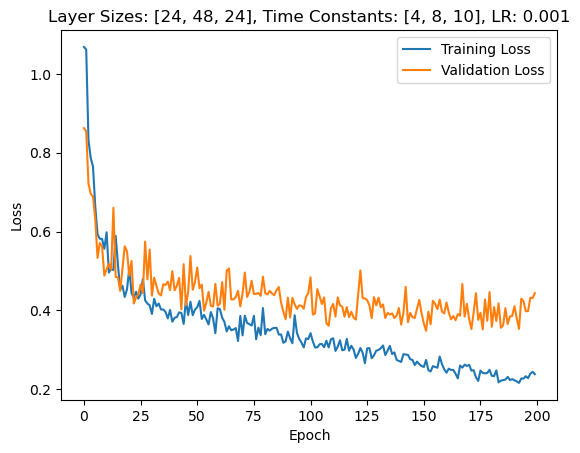

  0%|          | 1/200 [00:13<45:52, 13.83s/it]

Epoch 1/200, Training Loss: 1.0200734172227248, Validation Loss: 0.8526765576430729


  1%|          | 2/200 [00:27<45:11, 13.69s/it]

Epoch 2/200, Training Loss: 0.9762028804365194, Validation Loss: 0.7825635927064079


  2%|▏         | 3/200 [00:40<44:18, 13.49s/it]

Epoch 3/200, Training Loss: 0.8365488963307075, Validation Loss: 0.6864267587661743


  2%|▏         | 4/200 [00:53<43:21, 13.27s/it]

Epoch 4/200, Training Loss: 0.7432346698248161, Validation Loss: 0.6272221037319728


  2%|▎         | 5/200 [01:06<42:45, 13.16s/it]

Epoch 5/200, Training Loss: 0.7006727485161908, Validation Loss: 0.70256878222738


  3%|▎         | 6/200 [01:20<43:19, 13.40s/it]

Epoch 6/200, Training Loss: 0.6529934012664939, Validation Loss: 0.7401165174586433


  4%|▎         | 7/200 [01:33<43:11, 13.43s/it]

Epoch 7/200, Training Loss: 0.598993089401497, Validation Loss: 0.5662130159991128


  4%|▍         | 8/200 [01:47<43:05, 13.46s/it]

Epoch 8/200, Training Loss: 0.7246433541459857, Validation Loss: 0.6025277354887554


  4%|▍         | 9/200 [02:01<43:13, 13.58s/it]

Epoch 9/200, Training Loss: 0.5981665411085453, Validation Loss: 0.7069030510527747


  5%|▌         | 10/200 [02:15<43:15, 13.66s/it]

Epoch 10/200, Training Loss: 0.6496230656245969, Validation Loss: 0.5786052899701255


  6%|▌         | 11/200 [02:28<43:11, 13.71s/it]

Epoch 11/200, Training Loss: 0.6677128183391859, Validation Loss: 0.6392796103443418


  6%|▌         | 12/200 [02:42<42:56, 13.70s/it]

Epoch 12/200, Training Loss: 0.6009711921215057, Validation Loss: 0.615006080695561


  6%|▋         | 13/200 [02:55<42:12, 13.54s/it]

Epoch 13/200, Training Loss: 0.6409823872008413, Validation Loss: 0.7389323306935174


  7%|▋         | 14/200 [03:08<41:33, 13.41s/it]

Epoch 14/200, Training Loss: 0.6186898558769586, Validation Loss: 0.7366368813174111


  8%|▊         | 15/200 [03:22<41:32, 13.47s/it]

Epoch 15/200, Training Loss: 0.6169284694599655, Validation Loss: 0.75220416699137


  8%|▊         | 16/200 [03:35<41:06, 13.40s/it]

Epoch 16/200, Training Loss: 0.6776823474551147, Validation Loss: 0.6257379331759044


  8%|▊         | 17/200 [03:48<40:29, 13.27s/it]

Epoch 17/200, Training Loss: 0.5884136535086721, Validation Loss: 0.5834269736494336


  9%|▉         | 18/200 [04:01<39:58, 13.18s/it]

Epoch 18/200, Training Loss: 0.5696420292809324, Validation Loss: 0.8027793850217547


 10%|▉         | 19/200 [04:14<39:39, 13.14s/it]

Epoch 19/200, Training Loss: 0.5427237985269079, Validation Loss: 0.6024021740470614


 10%|█         | 20/200 [04:28<39:51, 13.28s/it]

Epoch 20/200, Training Loss: 0.5795990262391433, Validation Loss: 0.7164489882332938


 10%|█         | 21/200 [04:41<39:36, 13.28s/it]

Epoch 21/200, Training Loss: 0.6250323492963359, Validation Loss: 0.6725538798740932


 11%|█         | 22/200 [04:54<39:12, 13.22s/it]

Epoch 22/200, Training Loss: 0.5538940980749311, Validation Loss: 0.627733839409692


 12%|█▏        | 23/200 [05:07<38:43, 13.13s/it]

Epoch 23/200, Training Loss: 0.5615835681838809, Validation Loss: 0.5646660455635616


 12%|█▏        | 24/200 [05:21<39:16, 13.39s/it]

Epoch 24/200, Training Loss: 0.6166804888338413, Validation Loss: 0.6528925044195992


 12%|█▎        | 25/200 [05:34<38:50, 13.32s/it]

Epoch 25/200, Training Loss: 0.6024305918868983, Validation Loss: 0.665338567325047


 13%|█▎        | 26/200 [05:47<38:22, 13.23s/it]

Epoch 26/200, Training Loss: 0.5987926372941935, Validation Loss: 0.5821356752089092


 14%|█▎        | 27/200 [06:00<38:04, 13.21s/it]

Epoch 27/200, Training Loss: 0.6536084227966812, Validation Loss: 0.8124638966151646


 14%|█▍        | 28/200 [06:13<37:38, 13.13s/it]

Epoch 28/200, Training Loss: 0.5627831116599856, Validation Loss: 0.747459317956652


 14%|█▍        | 29/200 [06:27<37:29, 13.15s/it]

Epoch 29/200, Training Loss: 0.5409019926808915, Validation Loss: 0.6386366252388272


 15%|█▌        | 30/200 [06:40<37:08, 13.11s/it]

Epoch 30/200, Training Loss: 0.5170107242071403, Validation Loss: 0.7878081245081765


 16%|█▌        | 31/200 [06:53<36:44, 13.05s/it]

Epoch 31/200, Training Loss: 0.513066588426536, Validation Loss: 0.6793490648269653


 16%|█▌        | 32/200 [07:06<36:42, 13.11s/it]

Epoch 32/200, Training Loss: 0.560612032717129, Validation Loss: 0.6819342417376382


 16%|█▋        | 33/200 [07:19<36:59, 13.29s/it]

Epoch 33/200, Training Loss: 0.5095661619924149, Validation Loss: 0.5770592987537384


 17%|█▋        | 34/200 [07:33<36:46, 13.29s/it]

Epoch 34/200, Training Loss: 0.5741423028257658, Validation Loss: 0.7579779156616756


 18%|█▊        | 35/200 [07:46<36:33, 13.30s/it]

Epoch 35/200, Training Loss: 0.5826931415863756, Validation Loss: 0.8012755853789193


 18%|█▊        | 36/200 [07:59<36:05, 13.21s/it]

Epoch 36/200, Training Loss: 0.6365183198227072, Validation Loss: 0.6798440111534936


 18%|█▊        | 37/200 [08:13<36:30, 13.44s/it]

Epoch 37/200, Training Loss: 0.5389231263466601, Validation Loss: 0.605470380612782


 19%|█▉        | 38/200 [08:26<35:59, 13.33s/it]

Epoch 38/200, Training Loss: 0.6139447514740926, Validation Loss: 0.6426988116332463


 20%|█▉        | 39/200 [08:39<35:28, 13.22s/it]

Epoch 39/200, Training Loss: 0.5435323344086701, Validation Loss: 0.588664995772498


 20%|██        | 40/200 [08:52<35:21, 13.26s/it]

Epoch 40/200, Training Loss: 0.5324753877126945, Validation Loss: 0.6548694138016019


 20%|██        | 41/200 [09:06<35:01, 13.22s/it]

Epoch 41/200, Training Loss: 0.5706227643872207, Validation Loss: 0.7137462560619626


 21%|██        | 42/200 [09:19<34:40, 13.17s/it]

Epoch 42/200, Training Loss: 0.5497485916569548, Validation Loss: 0.6986295410564968


 22%|██▏       | 43/200 [09:32<34:26, 13.16s/it]

Epoch 43/200, Training Loss: 0.584085722717474, Validation Loss: 0.848805057150977


 22%|██▏       | 44/200 [09:45<34:08, 13.13s/it]

Epoch 44/200, Training Loss: 0.5092208081821226, Validation Loss: 0.6294745462281364


 22%|██▎       | 45/200 [09:58<33:58, 13.15s/it]

Epoch 45/200, Training Loss: 0.7081986249617811, Validation Loss: 1.4805652073451452


 23%|██▎       | 46/200 [10:12<34:08, 13.30s/it]

Epoch 46/200, Training Loss: 0.6902042649826914, Validation Loss: 0.5293139559882027


 24%|██▎       | 47/200 [10:25<33:53, 13.29s/it]

Epoch 47/200, Training Loss: 0.5233754830540351, Validation Loss: 0.6531789558274406


 24%|██▍       | 48/200 [10:38<33:35, 13.26s/it]

Epoch 48/200, Training Loss: 0.5742429134980688, Validation Loss: 0.7556246646812984


 24%|██▍       | 49/200 [10:51<33:12, 13.19s/it]

Epoch 49/200, Training Loss: 0.5866575513808232, Validation Loss: 0.8478755695479256


 25%|██▌       | 50/200 [11:05<33:24, 13.36s/it]

Epoch 50/200, Training Loss: 0.6238113596754254, Validation Loss: 0.5208789599793298


 26%|██▌       | 51/200 [11:19<33:25, 13.46s/it]

Epoch 51/200, Training Loss: 0.6131485872111231, Validation Loss: 0.6840097010135651


 26%|██▌       | 52/200 [11:32<33:07, 13.43s/it]

Epoch 52/200, Training Loss: 0.5169571205130163, Validation Loss: 0.6342592579977853


 26%|██▋       | 53/200 [11:45<32:41, 13.34s/it]

Epoch 53/200, Training Loss: 0.5198990972536914, Validation Loss: 0.7043378715004239


 27%|██▋       | 54/200 [11:58<32:12, 13.24s/it]

Epoch 54/200, Training Loss: 0.5545602800711146, Validation Loss: 0.4519183188676834


 28%|██▊       | 55/200 [12:11<31:47, 13.15s/it]

Epoch 55/200, Training Loss: 0.5502842408868501, Validation Loss: 0.6468416729143688


 28%|██▊       | 56/200 [12:24<31:35, 13.16s/it]

Epoch 56/200, Training Loss: 0.5395123306310402, Validation Loss: 0.5717065334320068


 28%|██▊       | 57/200 [12:37<31:16, 13.12s/it]

Epoch 57/200, Training Loss: 0.528554988357256, Validation Loss: 0.47888087800570894


 29%|██▉       | 58/200 [12:50<31:07, 13.15s/it]

Epoch 58/200, Training Loss: 0.5272025584049944, Validation Loss: 0.9943081864288875


 30%|██▉       | 59/200 [13:04<31:20, 13.34s/it]

Epoch 59/200, Training Loss: 0.5139298084771858, Validation Loss: 0.7330985069274902


 30%|███       | 60/200 [13:18<31:02, 13.31s/it]

Epoch 60/200, Training Loss: 0.6120548419794947, Validation Loss: 0.8157835687909808


 30%|███       | 61/200 [13:31<30:45, 13.27s/it]

Epoch 61/200, Training Loss: 0.5892985868004134, Validation Loss: 0.614416092634201


 31%|███       | 62/200 [13:44<30:46, 13.38s/it]

Epoch 62/200, Training Loss: 0.5489231050014496, Validation Loss: 0.5449367804186684


 32%|███▏      | 63/200 [13:58<30:26, 13.33s/it]

Epoch 63/200, Training Loss: 0.5328029183284292, Validation Loss: 0.47187185287475586


 32%|███▏      | 64/200 [14:11<30:09, 13.31s/it]

Epoch 64/200, Training Loss: 0.5599419137216964, Validation Loss: 0.8545573609215873


 32%|███▎      | 65/200 [14:24<29:45, 13.22s/it]

Epoch 65/200, Training Loss: 0.5265701778654782, Validation Loss: 0.6819167307444981


 33%|███▎      | 66/200 [14:37<29:26, 13.18s/it]

Epoch 66/200, Training Loss: 0.6257083573431339, Validation Loss: 0.46566871234348844


 34%|███▎      | 67/200 [14:50<29:07, 13.14s/it]

Epoch 67/200, Training Loss: 0.49733566506853644, Validation Loss: 0.5250568049294608


 34%|███▍      | 68/200 [15:03<28:51, 13.11s/it]

Epoch 68/200, Training Loss: 0.487704133087734, Validation Loss: 0.784211277961731


 34%|███▍      | 69/200 [15:16<28:41, 13.14s/it]

Epoch 69/200, Training Loss: 0.547937570034333, Validation Loss: 0.5747675065483365


 35%|███▌      | 70/200 [15:29<28:27, 13.14s/it]

Epoch 70/200, Training Loss: 0.535801815255633, Validation Loss: 0.5708381107875279


 36%|███▌      | 71/200 [15:43<28:39, 13.33s/it]

Epoch 71/200, Training Loss: 0.5652162882516969, Validation Loss: 0.7762745363371713


 36%|███▌      | 72/200 [15:57<28:28, 13.35s/it]

Epoch 72/200, Training Loss: 0.6256508456086213, Validation Loss: 0.6957885133368629


 36%|███▋      | 73/200 [16:10<28:05, 13.27s/it]

Epoch 73/200, Training Loss: 0.5855153264864436, Validation Loss: 0.6198435894080571


 37%|███▋      | 74/200 [16:23<27:51, 13.27s/it]

Epoch 74/200, Training Loss: 0.5364916510177109, Validation Loss: 0.591238294328962


 38%|███▊      | 75/200 [16:37<27:53, 13.39s/it]

Epoch 75/200, Training Loss: 0.5044468613165729, Validation Loss: 0.5589911064931324


 38%|███▊      | 76/200 [16:50<27:34, 13.34s/it]

Epoch 76/200, Training Loss: 0.5453825488967715, Validation Loss: 0.5829547601086753


 38%|███▊      | 77/200 [17:03<27:19, 13.33s/it]

Epoch 77/200, Training Loss: 0.485974336007856, Validation Loss: 0.5034763855593545


 39%|███▉      | 78/200 [17:16<26:53, 13.22s/it]

Epoch 78/200, Training Loss: 0.5531756183448827, Validation Loss: 0.5518595171826226


 40%|███▉      | 79/200 [17:29<26:40, 13.23s/it]

Epoch 79/200, Training Loss: 0.5160357159263683, Validation Loss: 0.540317273565701


 40%|████      | 80/200 [17:42<26:18, 13.16s/it]

Epoch 80/200, Training Loss: 0.5321031997226319, Validation Loss: 0.9016924841063363


 40%|████      | 81/200 [17:55<25:59, 13.11s/it]

Epoch 81/200, Training Loss: 0.5523145668349176, Validation Loss: 0.6905088275671005


 41%|████      | 82/200 [18:08<25:48, 13.13s/it]

Epoch 82/200, Training Loss: 0.6004642773911638, Validation Loss: 0.5962022415229252


 42%|████▏     | 83/200 [18:22<25:34, 13.11s/it]

Epoch 83/200, Training Loss: 0.5477588058642622, Validation Loss: 0.5518856282745089


 42%|████▏     | 84/200 [18:35<25:43, 13.31s/it]

Epoch 84/200, Training Loss: 0.5138778872085068, Validation Loss: 0.6523898073605129


 42%|████▎     | 85/200 [18:49<25:32, 13.32s/it]

Epoch 85/200, Training Loss: 0.520263136557813, Validation Loss: 0.49846559337207247


 43%|████▎     | 86/200 [19:02<25:14, 13.29s/it]

Epoch 86/200, Training Loss: 0.5754350685286072, Validation Loss: 0.87375208735466


 44%|████▎     | 87/200 [19:15<24:57, 13.25s/it]

Epoch 87/200, Training Loss: 0.5266936061517248, Validation Loss: 0.7096811788422721


 44%|████▍     | 88/200 [19:29<25:00, 13.40s/it]

Epoch 88/200, Training Loss: 0.5124901319449803, Validation Loss: 0.7196908167430333


 44%|████▍     | 89/200 [19:42<24:38, 13.32s/it]

Epoch 89/200, Training Loss: 0.47346119976268625, Validation Loss: 0.5789252391883305


 45%|████▌     | 90/200 [19:55<24:20, 13.28s/it]

Epoch 90/200, Training Loss: 0.5092417715855364, Validation Loss: 0.5049463765961784


 46%|████▌     | 91/200 [20:08<24:03, 13.24s/it]

Epoch 91/200, Training Loss: 0.4995199166378885, Validation Loss: 0.5820169193404061


 46%|████▌     | 92/200 [20:21<23:45, 13.20s/it]

Epoch 92/200, Training Loss: 0.5497281197107063, Validation Loss: 0.7423092297145298


 46%|████▋     | 93/200 [20:34<23:27, 13.16s/it]

Epoch 93/200, Training Loss: 0.5279001042527972, Validation Loss: 0.6715595509324755


 47%|████▋     | 94/200 [20:47<23:11, 13.13s/it]

Epoch 94/200, Training Loss: 0.6744064109505348, Validation Loss: 0.5415496357849666


 48%|████▊     | 95/200 [21:01<23:05, 13.19s/it]

Epoch 95/200, Training Loss: 0.5533973836111572, Validation Loss: 0.5665007787091392


 48%|████▊     | 96/200 [21:14<22:49, 13.16s/it]

Epoch 96/200, Training Loss: 0.4932908359563576, Validation Loss: 0.5140431544610432


 48%|████▊     | 97/200 [21:28<22:53, 13.33s/it]

Epoch 97/200, Training Loss: 0.4958899411952721, Validation Loss: 0.6019006882395063


 49%|████▉     | 98/200 [21:41<22:50, 13.43s/it]

Epoch 98/200, Training Loss: 0.448626291920554, Validation Loss: 0.49980792828968595


 50%|████▉     | 99/200 [21:54<22:24, 13.31s/it]

Epoch 99/200, Training Loss: 0.4752602826030749, Validation Loss: 0.6411001575844628


 50%|█████     | 100/200 [22:08<22:09, 13.30s/it]

Epoch 100/200, Training Loss: 0.5374988230331889, Validation Loss: 0.6749787288052695


 50%|█████     | 101/200 [22:21<22:09, 13.43s/it]

Epoch 101/200, Training Loss: 0.4637072032914971, Validation Loss: 0.5995624533721379


 51%|█████     | 102/200 [22:34<21:49, 13.37s/it]

Epoch 102/200, Training Loss: 0.4558368462998912, Validation Loss: 0.5236161266054425


 52%|█████▏    | 103/200 [22:48<21:30, 13.30s/it]

Epoch 103/200, Training Loss: 0.43830631448412843, Validation Loss: 0.6311352678707668


 52%|█████▏    | 104/200 [23:01<21:15, 13.29s/it]

Epoch 104/200, Training Loss: 0.4542815749937633, Validation Loss: 0.6462088780743735


 52%|█████▎    | 105/200 [23:14<20:53, 13.19s/it]

Epoch 105/200, Training Loss: 0.4796377608798585, Validation Loss: 0.5399081643138613


 53%|█████▎    | 106/200 [23:27<20:37, 13.17s/it]

Epoch 106/200, Training Loss: 0.5197742426732801, Validation Loss: 0.8493275472096035


 54%|█████▎    | 107/200 [23:40<20:21, 13.14s/it]

Epoch 107/200, Training Loss: 0.5125886483012505, Validation Loss: 0.5530992874077388


 54%|█████▍    | 108/200 [23:53<20:13, 13.19s/it]

Epoch 108/200, Training Loss: 0.4674567037595893, Validation Loss: 0.5447052376610892


 55%|█████▍    | 109/200 [24:06<19:53, 13.11s/it]

Epoch 109/200, Training Loss: 0.5067199181835607, Validation Loss: 0.5696481657879693


 55%|█████▌    | 110/200 [24:20<19:52, 13.25s/it]

Epoch 110/200, Training Loss: 0.464717410083087, Validation Loss: 0.4609452039003372


 56%|█████▌    | 111/200 [24:33<19:47, 13.35s/it]

Epoch 111/200, Training Loss: 0.47177184330967237, Validation Loss: 0.5513998738356999


 56%|█████▌    | 112/200 [24:46<19:23, 13.22s/it]

Epoch 112/200, Training Loss: 0.49063175101325196, Validation Loss: 0.6366039514541626


 56%|█████▋    | 113/200 [24:59<19:04, 13.15s/it]

Epoch 113/200, Training Loss: 0.4874420458415769, Validation Loss: 0.6439857546772275


 57%|█████▋    | 114/200 [25:13<19:07, 13.34s/it]

Epoch 114/200, Training Loss: 0.47134341271418445, Validation Loss: 0.6229137395109449


 57%|█████▊    | 115/200 [25:26<18:50, 13.30s/it]

Epoch 115/200, Training Loss: 0.4473221647851872, Validation Loss: 0.6241644365446908


 58%|█████▊    | 116/200 [25:40<18:35, 13.28s/it]

Epoch 116/200, Training Loss: 0.5258989359410304, Validation Loss: 0.6577227179493222


 58%|█████▊    | 117/200 [25:53<18:20, 13.25s/it]

Epoch 117/200, Training Loss: 0.4969318239194042, Validation Loss: 0.5631300338676998


 59%|█████▉    | 118/200 [26:06<18:02, 13.20s/it]

Epoch 118/200, Training Loss: 0.47219753321611657, Validation Loss: 0.556064927152225


 60%|█████▉    | 119/200 [26:19<17:51, 13.23s/it]

Epoch 119/200, Training Loss: 0.49535500019226436, Validation Loss: 0.6580743661948613


 60%|██████    | 120/200 [26:32<17:36, 13.21s/it]

Epoch 120/200, Training Loss: 0.5294605867480332, Validation Loss: 0.5991127725158419


 60%|██████    | 121/200 [26:45<17:21, 13.19s/it]

Epoch 121/200, Training Loss: 0.47383557344382665, Validation Loss: 0.6029802645955767


 61%|██████    | 122/200 [26:59<17:07, 13.18s/it]

Epoch 122/200, Training Loss: 0.4600517153739929, Validation Loss: 0.6208257228136063


 62%|██████▏   | 123/200 [27:12<17:08, 13.36s/it]

Epoch 123/200, Training Loss: 0.6176381724060707, Validation Loss: 0.6644852672304425


 62%|██████▏   | 124/200 [27:26<17:00, 13.43s/it]

Epoch 124/200, Training Loss: 0.48572540311318524, Validation Loss: 0.7009261676243373


 62%|██████▎   | 125/200 [27:39<16:42, 13.36s/it]

Epoch 125/200, Training Loss: 0.46317627688623825, Validation Loss: 0.6853411964007786


 63%|██████▎   | 126/200 [27:52<16:20, 13.25s/it]

Epoch 126/200, Training Loss: 0.528614766192886, Validation Loss: 0.5117162827934537


 64%|██████▎   | 127/200 [28:06<16:22, 13.46s/it]

Epoch 127/200, Training Loss: 0.5804297111506732, Validation Loss: 0.5016401431390217


 64%|██████▍   | 128/200 [28:19<16:00, 13.34s/it]

Epoch 128/200, Training Loss: 0.491596335510038, Validation Loss: 0.4001794031688145


 64%|██████▍   | 129/200 [28:33<15:46, 13.33s/it]

Epoch 129/200, Training Loss: 0.443042610051497, Validation Loss: 0.5614726373127529


 65%|██████▌   | 130/200 [28:46<15:27, 13.25s/it]

Epoch 130/200, Training Loss: 0.5228157274003299, Validation Loss: 0.5737671234777996


 66%|██████▌   | 131/200 [28:59<15:08, 13.17s/it]

Epoch 131/200, Training Loss: 0.46732747470432856, Validation Loss: 0.6447302954537528


 66%|██████▌   | 132/200 [29:12<14:54, 13.15s/it]

Epoch 132/200, Training Loss: 0.5104540086017465, Validation Loss: 0.6862063514334815


 66%|██████▋   | 133/200 [29:25<14:40, 13.15s/it]

Epoch 133/200, Training Loss: 0.49468758055623974, Validation Loss: 0.5870450990540641


 67%|██████▋   | 134/200 [29:38<14:24, 13.10s/it]

Epoch 134/200, Training Loss: 0.46798611530717815, Validation Loss: 0.6151650760854993


 68%|██████▊   | 135/200 [29:51<14:14, 13.14s/it]

Epoch 135/200, Training Loss: 0.4401137449269025, Validation Loss: 0.45441035500594545


 68%|██████▊   | 136/200 [30:05<14:12, 13.32s/it]

Epoch 136/200, Training Loss: 0.5828930648430338, Validation Loss: 0.8267113949571337


 68%|██████▊   | 137/200 [30:18<14:05, 13.42s/it]

Epoch 137/200, Training Loss: 0.5434136241674423, Validation Loss: 0.5587676891258785


 69%|██████▉   | 138/200 [30:31<13:45, 13.32s/it]

Epoch 138/200, Training Loss: 0.4508730707303533, Validation Loss: 0.573601850441524


 70%|██████▉   | 139/200 [30:44<13:26, 13.23s/it]

Epoch 139/200, Training Loss: 0.47792977600727443, Validation Loss: 0.47722719822611126


 70%|███████   | 140/200 [30:58<13:27, 13.46s/it]

Epoch 140/200, Training Loss: 0.4688989559434495, Validation Loss: 0.6078985290867942


 70%|███████   | 141/200 [31:12<13:07, 13.35s/it]

Epoch 141/200, Training Loss: 0.4340407353527141, Validation Loss: 0.624622044818742


 71%|███████   | 142/200 [31:25<12:49, 13.26s/it]

Epoch 142/200, Training Loss: 0.5097398701703774, Validation Loss: 0.7364081314631871


 72%|███████▏  | 143/200 [31:38<12:36, 13.27s/it]

Epoch 143/200, Training Loss: 0.5015214316125186, Validation Loss: 0.5336322486400604


 72%|███████▏  | 144/200 [31:51<12:17, 13.17s/it]

Epoch 144/200, Training Loss: 0.4815882497800971, Validation Loss: 0.5622648256165641


 72%|███████▎  | 145/200 [32:04<12:05, 13.19s/it]

Epoch 145/200, Training Loss: 0.47389252540075555, Validation Loss: 0.6657444792134422


 73%|███████▎  | 146/200 [32:17<11:49, 13.13s/it]

Epoch 146/200, Training Loss: 0.44274146390973396, Validation Loss: 0.5307225925581796


 74%|███████▎  | 147/200 [32:30<11:37, 13.17s/it]

Epoch 147/200, Training Loss: 0.43348452940864385, Validation Loss: 0.6688813375575202


 74%|███████▍  | 148/200 [32:44<11:26, 13.20s/it]

Epoch 148/200, Training Loss: 0.5056397197943814, Validation Loss: 0.6217583673340934


 74%|███████▍  | 149/200 [32:57<11:19, 13.32s/it]

Epoch 149/200, Training Loss: 0.44920317800539844, Validation Loss: 0.7506915288312095


 75%|███████▌  | 150/200 [33:11<11:07, 13.35s/it]

Epoch 150/200, Training Loss: 0.5232790039395386, Validation Loss: 0.5056255757808685


 76%|███████▌  | 151/200 [33:24<10:50, 13.28s/it]

Epoch 151/200, Training Loss: 0.5419074516251402, Validation Loss: 0.5369432504687991


 76%|███████▌  | 152/200 [33:37<10:34, 13.21s/it]

Epoch 152/200, Training Loss: 0.4427210123471494, Validation Loss: 0.663615705711501


 76%|███████▋  | 153/200 [33:51<10:31, 13.43s/it]

Epoch 153/200, Training Loss: 0.46750241349328236, Validation Loss: 0.6122334131172725


 77%|███████▋  | 154/200 [34:04<10:13, 13.34s/it]

Epoch 154/200, Training Loss: 0.4646990692840432, Validation Loss: 0.6339102728026254


 78%|███████▊  | 155/200 [34:17<09:55, 13.23s/it]

Epoch 155/200, Training Loss: 0.4708912307923695, Validation Loss: 0.6224305331707001


 78%|███████▊  | 156/200 [34:30<09:45, 13.30s/it]

Epoch 156/200, Training Loss: 0.4373960174479575, Validation Loss: 0.5421931530748095


 78%|███████▊  | 157/200 [34:43<09:27, 13.20s/it]

Epoch 157/200, Training Loss: 0.5500734223509735, Validation Loss: 0.576479217835835


 79%|███████▉  | 158/200 [34:56<09:12, 13.15s/it]

Epoch 158/200, Training Loss: 0.5274371496349011, Validation Loss: 0.7560529304402215


 80%|███████▉  | 159/200 [35:09<08:58, 13.13s/it]

Epoch 159/200, Training Loss: 0.4461981477040165, Validation Loss: 0.7309118509292603


 80%|████████  | 160/200 [35:23<08:45, 13.14s/it]

Epoch 160/200, Training Loss: 0.49121020931117937, Validation Loss: 0.6203187086752483


 80%|████████  | 161/200 [35:36<08:33, 13.16s/it]

Epoch 161/200, Training Loss: 0.5076241226128813, Validation Loss: 0.5309164587940488


 81%|████████  | 162/200 [35:49<08:25, 13.30s/it]

Epoch 162/200, Training Loss: 0.4818698510808765, Validation Loss: 0.5580421771321978


 82%|████████▏ | 163/200 [36:03<08:13, 13.33s/it]

Epoch 163/200, Training Loss: 0.5908665547393402, Validation Loss: 0.7198579566819328


 82%|████████▏ | 164/200 [36:16<08:01, 13.38s/it]

Epoch 164/200, Training Loss: 0.47577286806871305, Validation Loss: 0.7591268462794167


 82%|████████▎ | 165/200 [36:29<07:44, 13.27s/it]

Epoch 165/200, Training Loss: 0.46908387963501913, Validation Loss: 0.7066592488970075


 83%|████████▎ | 166/200 [36:43<07:37, 13.46s/it]

Epoch 166/200, Training Loss: 0.46316287764963116, Validation Loss: 0.5844646266528538


 84%|████████▎ | 167/200 [36:57<07:22, 13.41s/it]

Epoch 167/200, Training Loss: 0.5556802693402992, Validation Loss: 0.5981755214078086


 84%|████████▍ | 168/200 [37:10<07:05, 13.30s/it]

Epoch 168/200, Training Loss: 0.4862002657269532, Validation Loss: 0.7084902141775403


 84%|████████▍ | 169/200 [37:23<06:51, 13.27s/it]

Epoch 169/200, Training Loss: 0.4757539282711047, Validation Loss: 0.6045910716056824


 85%|████████▌ | 170/200 [37:36<06:38, 13.28s/it]

Epoch 170/200, Training Loss: 0.4466014302001809, Validation Loss: 0.6288327276706696


 86%|████████▌ | 171/200 [37:49<06:22, 13.18s/it]

Epoch 171/200, Training Loss: 0.46724780578658265, Validation Loss: 0.5802047678402492


 86%|████████▌ | 172/200 [38:02<06:09, 13.18s/it]

Epoch 172/200, Training Loss: 0.4715885539662163, Validation Loss: 0.6779859704630715


 86%|████████▋ | 173/200 [38:15<05:54, 13.12s/it]

Epoch 173/200, Training Loss: 0.4741700544672192, Validation Loss: 0.6289743781089783


 87%|████████▋ | 174/200 [38:29<05:43, 13.20s/it]

Epoch 174/200, Training Loss: 0.45065944740232433, Validation Loss: 0.8092227748462132


 88%|████████▊ | 175/200 [38:42<05:33, 13.36s/it]

Epoch 175/200, Training Loss: 0.4630899654244477, Validation Loss: 0.7137113468987601


 88%|████████▊ | 176/200 [38:56<05:19, 13.32s/it]

Epoch 176/200, Training Loss: 0.48456278471451886, Validation Loss: 0.6570050886699131


 88%|████████▊ | 177/200 [39:09<05:05, 13.28s/it]

Epoch 177/200, Training Loss: 0.4606646830743214, Validation Loss: 0.8536115671907153


 89%|████████▉ | 178/200 [39:22<04:52, 13.28s/it]

Epoch 178/200, Training Loss: 0.4455610727364162, Validation Loss: 0.6646039294345039


 90%|████████▉ | 179/200 [39:36<04:41, 13.42s/it]

Epoch 179/200, Training Loss: 0.5273217072464386, Validation Loss: 0.8164674362965992


 90%|█████████ | 180/200 [39:49<04:28, 13.42s/it]

Epoch 180/200, Training Loss: 0.47425084547051843, Validation Loss: 0.6233339778014592


 90%|█████████ | 181/200 [40:02<04:13, 13.33s/it]

Epoch 181/200, Training Loss: 0.48168660447282613, Validation Loss: 0.5704889169761113


 91%|█████████ | 182/200 [40:15<03:58, 13.28s/it]

Epoch 182/200, Training Loss: 0.4162262647219424, Validation Loss: 0.6248328515461513


 92%|█████████▏| 183/200 [40:29<03:44, 13.23s/it]

Epoch 183/200, Training Loss: 0.4697320764919497, Validation Loss: 0.6668491235801152


 92%|█████████▏| 184/200 [40:42<03:31, 13.24s/it]

Epoch 184/200, Training Loss: 0.4522221673209712, Validation Loss: 0.6573208698204586


 92%|█████████▎| 185/200 [40:55<03:18, 13.22s/it]

Epoch 185/200, Training Loss: 0.45262477870257395, Validation Loss: 0.6391218432358333


 93%|█████████▎| 186/200 [41:08<03:04, 13.16s/it]

Epoch 186/200, Training Loss: 0.43491187073149773, Validation Loss: 0.5515117943286896


 94%|█████████▎| 187/200 [41:21<02:50, 13.10s/it]

Epoch 187/200, Training Loss: 0.4360882521800275, Validation Loss: 0.5990844624383109


 94%|█████████▍| 188/200 [41:35<02:41, 13.42s/it]

Epoch 188/200, Training Loss: 0.4214099789003156, Validation Loss: 0.4740769309656961


 94%|█████████▍| 189/200 [41:48<02:26, 13.36s/it]

Epoch 189/200, Training Loss: 0.4422524501130266, Validation Loss: 0.7451767644711903


 95%|█████████▌| 190/200 [42:02<02:13, 13.32s/it]

Epoch 190/200, Training Loss: 0.4699869236012675, Validation Loss: 0.6380278042384556


 96%|█████████▌| 191/200 [42:15<01:59, 13.27s/it]

Epoch 191/200, Training Loss: 0.45704538445427734, Validation Loss: 0.7186646163463593


 96%|█████████▌| 192/200 [42:29<01:47, 13.43s/it]

Epoch 192/200, Training Loss: 0.4417688102935845, Validation Loss: 0.6051848956516811


 96%|█████████▋| 193/200 [42:42<01:33, 13.42s/it]

Epoch 193/200, Training Loss: 0.44053624317331136, Validation Loss: 0.6128862500190735


 97%|█████████▋| 194/200 [42:55<01:19, 13.29s/it]

Epoch 194/200, Training Loss: 0.5818814874257682, Validation Loss: 0.6159850614411491


 98%|█████████▊| 195/200 [43:08<01:06, 13.21s/it]

Epoch 195/200, Training Loss: 0.5038126909507895, Validation Loss: 0.7072701858622688


 98%|█████████▊| 196/200 [43:21<00:52, 13.19s/it]

Epoch 196/200, Training Loss: 0.49982156056278154, Validation Loss: 0.6575822830200195


 98%|█████████▊| 197/200 [43:34<00:39, 13.12s/it]

Epoch 197/200, Training Loss: 0.4671158343553543, Validation Loss: 0.5586764897618975


 99%|█████████▉| 198/200 [43:47<00:26, 13.21s/it]

Epoch 198/200, Training Loss: 0.4529143844573003, Validation Loss: 0.5900812191622598


100%|█████████▉| 199/200 [44:01<00:13, 13.18s/it]

Epoch 199/200, Training Loss: 0.43257425978498637, Validation Loss: 0.64427678499903


100%|██████████| 200/200 [44:14<00:00, 13.27s/it]

Epoch 200/200, Training Loss: 0.4804249740434143, Validation Loss: 0.5090097274099078
Final Accuracy: 87.32%, Precision: 0.86, Recall: 0.89


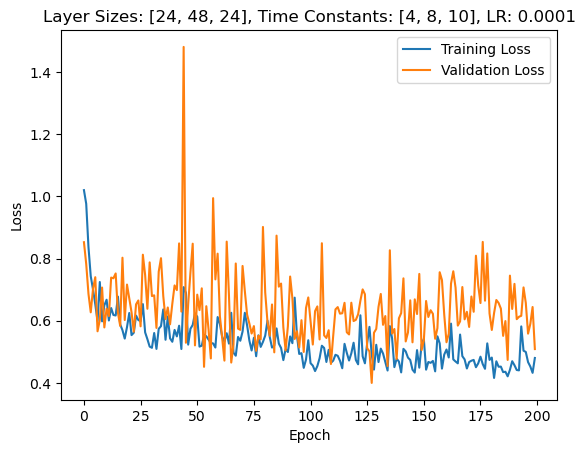

  0%|          | 1/200 [00:13<45:54, 13.84s/it]

Epoch 1/200, Training Loss: 1.0840481733376126, Validation Loss: 0.9783880859613419


  1%|          | 2/200 [00:27<44:58, 13.63s/it]

Epoch 2/200, Training Loss: 0.9775971545363372, Validation Loss: 0.8721706654344287


  2%|▏         | 3/200 [00:40<44:48, 13.65s/it]

Epoch 3/200, Training Loss: 0.9217721729908349, Validation Loss: 0.754308317388807


  2%|▏         | 4/200 [00:54<43:51, 13.43s/it]

Epoch 4/200, Training Loss: 0.8935205003000656, Validation Loss: 0.531264386006764


  2%|▎         | 5/200 [01:07<43:16, 13.31s/it]

Epoch 5/200, Training Loss: 0.7634296001128431, Validation Loss: 1.1232363326208932


  3%|▎         | 6/200 [01:21<43:39, 13.50s/it]

Epoch 6/200, Training Loss: 0.7943949733140334, Validation Loss: 0.6793569305113384


  4%|▎         | 7/200 [01:34<43:34, 13.55s/it]

Epoch 7/200, Training Loss: 0.7134138334472224, Validation Loss: 0.7280156229223523


  4%|▍         | 8/200 [01:48<43:35, 13.62s/it]

Epoch 8/200, Training Loss: 0.8946126693824552, Validation Loss: 0.9599975262369428


  4%|▍         | 9/200 [02:02<43:35, 13.69s/it]

Epoch 9/200, Training Loss: 0.8133961701730512, Validation Loss: 0.8623962679079601


  5%|▌         | 10/200 [02:16<43:20, 13.69s/it]

Epoch 10/200, Training Loss: 0.7311276945303071, Validation Loss: 0.7371879049709865


  6%|▌         | 11/200 [02:29<43:19, 13.75s/it]

Epoch 11/200, Training Loss: 0.7238745666899771, Validation Loss: 0.6881727150508335


  6%|▌         | 12/200 [02:43<42:57, 13.71s/it]

Epoch 12/200, Training Loss: 0.7380196755787112, Validation Loss: 0.7076145304100854


  6%|▋         | 13/200 [02:56<42:15, 13.56s/it]

Epoch 13/200, Training Loss: 0.6753698491825247, Validation Loss: 0.7091826668807438


  7%|▋         | 14/200 [03:10<41:45, 13.47s/it]

Epoch 14/200, Training Loss: 0.7101183944153335, Validation Loss: 0.728273229939597


  8%|▊         | 15/200 [03:23<41:15, 13.38s/it]

Epoch 15/200, Training Loss: 0.7405289225983169, Validation Loss: 0.72218100300857


  8%|▊         | 16/200 [03:36<41:26, 13.51s/it]

Epoch 16/200, Training Loss: 0.6660064481339365, Validation Loss: 0.6761087221758706


  8%|▊         | 17/200 [03:50<40:59, 13.44s/it]

Epoch 17/200, Training Loss: 0.6427788711943716, Validation Loss: 0.6491542330810002


  9%|▉         | 18/200 [04:03<40:28, 13.34s/it]

Epoch 18/200, Training Loss: 0.6436631471480964, Validation Loss: 0.5662779765469688


 10%|▉         | 19/200 [04:16<40:10, 13.32s/it]

Epoch 19/200, Training Loss: 0.6195224540413551, Validation Loss: 0.5993966204779488


 10%|█         | 20/200 [04:29<39:42, 13.24s/it]

Epoch 20/200, Training Loss: 0.6290743176667195, Validation Loss: 0.6084419190883636


 10%|█         | 21/200 [04:43<39:53, 13.37s/it]

Epoch 21/200, Training Loss: 0.5983048227598082, Validation Loss: 0.6200050019792148


 11%|█         | 22/200 [04:56<39:32, 13.33s/it]

Epoch 22/200, Training Loss: 0.6315953888983097, Validation Loss: 0.568701079913548


 12%|█▏        | 23/200 [05:09<39:11, 13.28s/it]

Epoch 23/200, Training Loss: 0.6076327562332153, Validation Loss: 0.6313870953662055


 12%|█▏        | 24/200 [05:22<38:47, 13.22s/it]

Epoch 24/200, Training Loss: 0.5636158624909958, Validation Loss: 0.5568155178001949


 12%|█▎        | 25/200 [05:36<39:02, 13.38s/it]

Epoch 25/200, Training Loss: 0.6106470395933907, Validation Loss: 0.6138098750795636


 13%|█▎        | 26/200 [05:49<38:36, 13.31s/it]

Epoch 26/200, Training Loss: 0.58033002828652, Validation Loss: 0.6139658540487289


 14%|█▎        | 27/200 [06:03<38:28, 13.35s/it]

Epoch 27/200, Training Loss: 0.5431731711581068, Validation Loss: 0.5682098652635302


 14%|█▍        | 28/200 [06:16<37:59, 13.25s/it]

Epoch 28/200, Training Loss: 0.5797171064142911, Validation Loss: 0.5867351974759784


 14%|█▍        | 29/200 [06:29<37:40, 13.22s/it]

Epoch 29/200, Training Loss: 0.5432021924347248, Validation Loss: 0.5209347073520932


 15%|█▌        | 30/200 [06:42<37:28, 13.23s/it]

Epoch 30/200, Training Loss: 0.48889855562515977, Validation Loss: 0.526540715779577


 16%|█▌        | 31/200 [06:55<37:01, 13.15s/it]

Epoch 31/200, Training Loss: 0.46293671907119033, Validation Loss: 0.5697704638753619


 16%|█▌        | 32/200 [07:08<36:46, 13.13s/it]

Epoch 32/200, Training Loss: 0.5115697681903839, Validation Loss: 0.5569989915405001


 16%|█▋        | 33/200 [07:21<36:37, 13.16s/it]

Epoch 33/200, Training Loss: 0.48639324785403487, Validation Loss: 0.4993116280862263


 17%|█▋        | 34/200 [07:35<36:53, 13.33s/it]

Epoch 34/200, Training Loss: 0.4457896742618309, Validation Loss: 0.45363948600632803


 18%|█▊        | 35/200 [07:49<36:48, 13.39s/it]

Epoch 35/200, Training Loss: 0.4609615409149314, Validation Loss: 0.46760107789720806


 18%|█▊        | 36/200 [08:02<36:23, 13.32s/it]

Epoch 36/200, Training Loss: 0.4545091874194595, Validation Loss: 0.5160756451742989


 18%|█▊        | 37/200 [08:15<35:58, 13.25s/it]

Epoch 37/200, Training Loss: 0.4473036417983613, Validation Loss: 0.5061544392790113


 19%|█▉        | 38/200 [08:29<36:33, 13.54s/it]

Epoch 38/200, Training Loss: 0.45546688617400405, Validation Loss: 0.5189420836312431


 20%|█▉        | 39/200 [08:42<35:59, 13.42s/it]

Epoch 39/200, Training Loss: 0.4419872263130152, Validation Loss: 0.5430982070309776


 20%|██        | 40/200 [08:55<35:34, 13.34s/it]

Epoch 40/200, Training Loss: 0.4145218460065014, Validation Loss: 0.5169135459831783


 20%|██        | 41/200 [09:09<35:21, 13.34s/it]

Epoch 41/200, Training Loss: 0.43029555987636997, Validation Loss: 0.46788558789661955


 21%|██        | 42/200 [09:22<34:56, 13.27s/it]

Epoch 42/200, Training Loss: 0.4287273017865307, Validation Loss: 0.47432196140289307


 22%|██▏       | 43/200 [09:35<34:46, 13.29s/it]

Epoch 43/200, Training Loss: 0.4102135799684615, Validation Loss: 0.5683607884815761


 22%|██▏       | 44/200 [09:48<34:24, 13.23s/it]

Epoch 44/200, Training Loss: 0.4161827564239502, Validation Loss: 0.4940843731164932


 22%|██▎       | 45/200 [10:01<34:09, 13.22s/it]

Epoch 45/200, Training Loss: 0.4144110308503205, Validation Loss: 0.5475996604987553


 23%|██▎       | 46/200 [10:15<34:06, 13.29s/it]

Epoch 46/200, Training Loss: 0.41499658519367, Validation Loss: 0.4433504896504538


 24%|██▎       | 47/200 [10:29<34:12, 13.41s/it]

Epoch 47/200, Training Loss: 0.4162927863170516, Validation Loss: 0.5141190673623767


 24%|██▍       | 48/200 [10:42<33:54, 13.38s/it]

Epoch 48/200, Training Loss: 0.4058716344945836, Validation Loss: 0.45853021315165926


 24%|██▍       | 49/200 [10:55<33:42, 13.40s/it]

Epoch 49/200, Training Loss: 0.40724756723304967, Validation Loss: 0.44110763498714994


 25%|██▌       | 50/200 [11:09<33:23, 13.36s/it]

Epoch 50/200, Training Loss: 0.39438038192829994, Validation Loss: 0.5130223844732557


 26%|██▌       | 51/200 [11:23<33:45, 13.59s/it]

Epoch 51/200, Training Loss: 0.4045586088355982, Validation Loss: 0.4792740259851728


 26%|██▌       | 52/200 [11:36<33:16, 13.49s/it]

Epoch 52/200, Training Loss: 0.3894173966826133, Validation Loss: 0.43904606997966766


 26%|██▋       | 53/200 [11:49<32:51, 13.41s/it]

Epoch 53/200, Training Loss: 0.38955992038519877, Validation Loss: 0.5079011533941541


 27%|██▋       | 54/200 [12:02<32:27, 13.34s/it]

Epoch 54/200, Training Loss: 0.4065715139204601, Validation Loss: 0.4670203562293734


 28%|██▊       | 55/200 [12:15<32:03, 13.26s/it]

Epoch 55/200, Training Loss: 0.396264873585611, Validation Loss: 0.4812306208269937


 28%|██▊       | 56/200 [12:29<31:43, 13.22s/it]

Epoch 56/200, Training Loss: 0.39735144517331755, Validation Loss: 0.4772941257272448


 28%|██▊       | 57/200 [12:42<31:34, 13.25s/it]

Epoch 57/200, Training Loss: 0.38801610891549093, Validation Loss: 0.4941595643758774


 29%|██▉       | 58/200 [12:55<31:21, 13.25s/it]

Epoch 58/200, Training Loss: 0.37191868699946495, Validation Loss: 0.44508024624415804


 30%|██▉       | 59/200 [13:09<31:15, 13.30s/it]

Epoch 59/200, Training Loss: 0.3750401012740045, Validation Loss: 0.5192723955426898


 30%|███       | 60/200 [13:23<31:28, 13.49s/it]

Epoch 60/200, Training Loss: 0.37859796760779507, Validation Loss: 0.5176789313554764


 30%|███       | 61/200 [13:36<31:10, 13.46s/it]

Epoch 61/200, Training Loss: 0.3959677884320043, Validation Loss: 0.4827439912727901


 31%|███       | 62/200 [13:49<30:54, 13.44s/it]

Epoch 62/200, Training Loss: 0.399221936767956, Validation Loss: 0.4732216660465513


 32%|███▏      | 63/200 [14:02<30:27, 13.34s/it]

Epoch 63/200, Training Loss: 0.38896841232506735, Validation Loss: 0.49065400872911724


 32%|███▏      | 64/200 [14:17<30:44, 13.57s/it]

Epoch 64/200, Training Loss: 0.35323649588620887, Validation Loss: 0.4494831668479102


 32%|███▎      | 65/200 [14:30<30:25, 13.52s/it]

Epoch 65/200, Training Loss: 0.3703358701939853, Validation Loss: 0.44412211009434294


 33%|███▎      | 66/200 [14:43<29:52, 13.38s/it]

Epoch 66/200, Training Loss: 0.36024435440886693, Validation Loss: 0.5094451648848397


 34%|███▎      | 67/200 [14:56<29:37, 13.37s/it]

Epoch 67/200, Training Loss: 0.3611432730026965, Validation Loss: 0.42437064221927095


 34%|███▍      | 68/200 [15:10<29:17, 13.32s/it]

Epoch 68/200, Training Loss: 0.3672634008920418, Validation Loss: 0.4171037780387061


 34%|███▍      | 69/200 [15:23<28:59, 13.28s/it]

Epoch 69/200, Training Loss: 0.3477574740097208, Validation Loss: 0.42184568302971975


 35%|███▌      | 70/200 [15:36<28:53, 13.33s/it]

Epoch 70/200, Training Loss: 0.35830279200706844, Validation Loss: 0.45060453031744274


 36%|███▌      | 71/200 [15:49<28:33, 13.28s/it]

Epoch 71/200, Training Loss: 0.3704570783477909, Validation Loss: 0.43525679622377667


 36%|███▌      | 72/200 [16:03<28:16, 13.25s/it]

Epoch 72/200, Training Loss: 0.3750130764718326, Validation Loss: 0.4769054353237152


 36%|███▋      | 73/200 [16:17<28:45, 13.58s/it]

Epoch 73/200, Training Loss: 0.34644937234104806, Validation Loss: 0.4178359018904822


 37%|███▋      | 74/200 [16:30<28:20, 13.50s/it]

Epoch 74/200, Training Loss: 0.347346046623194, Validation Loss: 0.42824649810791016


 38%|███▊      | 75/200 [16:44<28:03, 13.46s/it]

Epoch 75/200, Training Loss: 0.37181737990874164, Validation Loss: 0.4467308989592961


 38%|███▊      | 76/200 [16:57<27:46, 13.44s/it]

Epoch 76/200, Training Loss: 0.3772753122842537, Validation Loss: 0.42911522729056223


 38%|███▊      | 77/200 [17:11<27:49, 13.58s/it]

Epoch 77/200, Training Loss: 0.33356415220307856, Validation Loss: 0.4337358389581953


 39%|███▉      | 78/200 [17:24<27:32, 13.54s/it]

Epoch 78/200, Training Loss: 0.3347657378411518, Validation Loss: 0.40250873991421293


 40%|███▉      | 79/200 [17:37<27:04, 13.42s/it]

Epoch 79/200, Training Loss: 0.33405896487101067, Validation Loss: 0.4333041523184095


 40%|████      | 80/200 [17:51<26:44, 13.37s/it]

Epoch 80/200, Training Loss: 0.34364488130470494, Validation Loss: 0.45642237790993284


 40%|████      | 81/200 [18:04<26:24, 13.32s/it]

Epoch 81/200, Training Loss: 0.3216808041171083, Validation Loss: 0.43028542612280163


 41%|████      | 82/200 [18:17<26:10, 13.31s/it]

Epoch 82/200, Training Loss: 0.3211439292667047, Validation Loss: 0.3841851417507444


 42%|████▏     | 83/200 [18:30<25:57, 13.31s/it]

Epoch 83/200, Training Loss: 0.33235874111359975, Validation Loss: 0.43513213098049164


 42%|████▏     | 84/200 [18:44<25:36, 13.25s/it]

Epoch 84/200, Training Loss: 0.33845349274716285, Validation Loss: 0.4276893383690289


 42%|████▎     | 85/200 [18:57<25:16, 13.19s/it]

Epoch 85/200, Training Loss: 0.36588145047426224, Validation Loss: 0.39496272802352905


 43%|████▎     | 86/200 [19:11<25:38, 13.49s/it]

Epoch 86/200, Training Loss: 0.3176070048280482, Validation Loss: 0.38589267645563397


 44%|████▎     | 87/200 [19:24<25:21, 13.46s/it]

Epoch 87/200, Training Loss: 0.31823560799349027, Validation Loss: 0.4055671351296561


 44%|████▍     | 88/200 [19:37<24:58, 13.38s/it]

Epoch 88/200, Training Loss: 0.31948617930119894, Validation Loss: 0.3878626993724278


 44%|████▍     | 89/200 [19:51<24:46, 13.40s/it]

Epoch 89/200, Training Loss: 0.30661129817928906, Validation Loss: 0.4034792844738279


 45%|████▌     | 90/200 [20:05<24:48, 13.53s/it]

Epoch 90/200, Training Loss: 0.3126827520581911, Validation Loss: 0.3615742985691343


 46%|████▌     | 91/200 [20:18<24:35, 13.54s/it]

Epoch 91/200, Training Loss: 0.3044190013183738, Validation Loss: 0.3969624766281673


 46%|████▌     | 92/200 [20:31<24:10, 13.43s/it]

Epoch 92/200, Training Loss: 0.29599453394635106, Validation Loss: 0.36281207842486246


 46%|████▋     | 93/200 [20:45<23:50, 13.37s/it]

Epoch 93/200, Training Loss: 0.2889451698031066, Validation Loss: 0.3828023544379643


 47%|████▋     | 94/200 [20:58<23:40, 13.40s/it]

Epoch 94/200, Training Loss: 0.3180344855447985, Validation Loss: 0.356681227684021


 48%|████▊     | 95/200 [21:11<23:18, 13.32s/it]

Epoch 95/200, Training Loss: 0.2949367786212912, Validation Loss: 0.3465275764465332


 48%|████▊     | 96/200 [21:24<23:02, 13.29s/it]

Epoch 96/200, Training Loss: 0.2907517602983511, Validation Loss: 0.41332118426050457


 48%|████▊     | 97/200 [21:38<22:48, 13.29s/it]

Epoch 97/200, Training Loss: 0.3067419692030493, Validation Loss: 0.3762491111244474


 49%|████▉     | 98/200 [21:51<22:36, 13.30s/it]

Epoch 98/200, Training Loss: 0.28936117999958544, Validation Loss: 0.3672106606619699


 50%|████▉     | 99/200 [22:05<22:46, 13.53s/it]

Epoch 99/200, Training Loss: 0.29454782197497925, Validation Loss: 0.37308590752737864


 50%|█████     | 100/200 [22:19<22:27, 13.47s/it]

Epoch 100/200, Training Loss: 0.30472011442454355, Validation Loss: 0.4035587842975344


 50%|█████     | 101/200 [22:32<22:09, 13.43s/it]

Epoch 101/200, Training Loss: 0.3301937852828008, Validation Loss: 0.39825224450656344


 51%|█████     | 102/200 [22:45<21:59, 13.46s/it]

Epoch 102/200, Training Loss: 0.28241610126394145, Validation Loss: 0.36213391593524386


 52%|█████▏    | 103/200 [22:59<21:55, 13.56s/it]

Epoch 103/200, Training Loss: 0.2853384999171743, Validation Loss: 0.3536019154957363


 52%|█████▏    | 104/200 [23:12<21:34, 13.49s/it]

Epoch 104/200, Training Loss: 0.27870176584934286, Validation Loss: 0.36698099970817566


 52%|█████▎    | 105/200 [23:26<21:13, 13.41s/it]

Epoch 105/200, Training Loss: 0.2800601193646215, Validation Loss: 0.38714198555265156


 53%|█████▎    | 106/200 [23:39<20:51, 13.31s/it]

Epoch 106/200, Training Loss: 0.29018804276326915, Validation Loss: 0.3931184389761516


 54%|█████▎    | 107/200 [23:52<20:37, 13.31s/it]

Epoch 107/200, Training Loss: 0.28168094172230307, Validation Loss: 0.38166746710027966


 54%|█████▍    | 108/200 [24:05<20:18, 13.25s/it]

Epoch 108/200, Training Loss: 0.28117830095426094, Validation Loss: 0.3328248049531664


 55%|█████▍    | 109/200 [24:18<20:00, 13.19s/it]

Epoch 109/200, Training Loss: 0.27862553860781325, Validation Loss: 0.33435081584112986


 55%|█████▌    | 110/200 [24:32<19:51, 13.24s/it]

Epoch 110/200, Training Loss: 0.29330218906672495, Validation Loss: 0.3699146658182144


 56%|█████▌    | 111/200 [24:45<19:39, 13.25s/it]

Epoch 111/200, Training Loss: 0.2997539802542273, Validation Loss: 0.334957161120006


 56%|█████▌    | 112/200 [24:59<19:43, 13.45s/it]

Epoch 112/200, Training Loss: 0.27916964516043663, Validation Loss: 0.40011611367974964


 56%|█████▋    | 113/200 [25:12<19:31, 13.46s/it]

Epoch 113/200, Training Loss: 0.27613452097998475, Validation Loss: 0.34564874853406635


 57%|█████▋    | 114/200 [25:26<19:12, 13.40s/it]

Epoch 114/200, Training Loss: 0.29065043528406126, Validation Loss: 0.34561261534690857


 57%|█████▊    | 115/200 [25:39<18:54, 13.34s/it]

Epoch 115/200, Training Loss: 0.27165788833825094, Validation Loss: 0.3553330238376345


 58%|█████▊    | 116/200 [25:53<18:53, 13.50s/it]

Epoch 116/200, Training Loss: 0.26526218034186455, Validation Loss: 0.36931711222444263


 58%|█████▊    | 117/200 [26:06<18:36, 13.46s/it]

Epoch 117/200, Training Loss: 0.27296178274840677, Validation Loss: 0.34280224995953695


 59%|█████▉    | 118/200 [26:19<18:19, 13.41s/it]

Epoch 118/200, Training Loss: 0.28658035302640134, Validation Loss: 0.37491621928555624


 60%|█████▉    | 119/200 [26:32<18:00, 13.34s/it]

Epoch 119/200, Training Loss: 0.27956649812184414, Validation Loss: 0.3785392940044403


 60%|██████    | 120/200 [26:46<17:46, 13.33s/it]

Epoch 120/200, Training Loss: 0.2785446823767896, Validation Loss: 0.3498168757983616


 60%|██████    | 121/200 [26:59<17:33, 13.34s/it]

Epoch 121/200, Training Loss: 0.2677811399664519, Validation Loss: 0.3470557140452521


 61%|██████    | 122/200 [27:13<17:27, 13.43s/it]

Epoch 122/200, Training Loss: 0.2723593025134419, Validation Loss: 0.3786193143044199


 62%|██████▏   | 123/200 [27:26<17:10, 13.38s/it]

Epoch 123/200, Training Loss: 0.26614065313676616, Validation Loss: 0.3891569461141314


 62%|██████▏   | 124/200 [27:39<16:55, 13.36s/it]

Epoch 124/200, Training Loss: 0.2830329091762597, Validation Loss: 0.403177726481642


 62%|██████▎   | 125/200 [27:53<16:55, 13.54s/it]

Epoch 125/200, Training Loss: 0.2701003239402231, Validation Loss: 0.3585468424218042


 63%|██████▎   | 126/200 [28:07<16:41, 13.53s/it]

Epoch 126/200, Training Loss: 0.2902377018669866, Validation Loss: 0.380445767726217


 64%|██████▎   | 127/200 [28:20<16:24, 13.48s/it]

Epoch 127/200, Training Loss: 0.28855151015351405, Validation Loss: 0.33920231248651234


 64%|██████▍   | 128/200 [28:33<16:02, 13.36s/it]

Epoch 128/200, Training Loss: 0.27990086264205427, Validation Loss: 0.31785132203783306


 64%|██████▍   | 129/200 [28:47<16:04, 13.58s/it]

Epoch 129/200, Training Loss: 0.27545844144978615, Validation Loss: 0.32149756806237356


 65%|██████▌   | 130/200 [29:01<15:43, 13.47s/it]

Epoch 130/200, Training Loss: 0.27656874159034694, Validation Loss: 0.35995409531252726


 66%|██████▌   | 131/200 [29:14<15:26, 13.42s/it]

Epoch 131/200, Training Loss: 0.2587992581275274, Validation Loss: 0.3572287474359785


 66%|██████▌   | 132/200 [29:27<15:08, 13.36s/it]

Epoch 132/200, Training Loss: 0.28256686917453444, Validation Loss: 0.3373784210000719


 66%|██████▋   | 133/200 [29:40<14:53, 13.33s/it]

Epoch 133/200, Training Loss: 0.2706440824945018, Validation Loss: 0.37307280089174


 67%|██████▋   | 134/200 [29:54<14:40, 13.34s/it]

Epoch 134/200, Training Loss: 0.25527140593050784, Validation Loss: 0.38130333381039755


 68%|██████▊   | 135/200 [30:07<14:22, 13.27s/it]

Epoch 135/200, Training Loss: 0.26599361620983986, Validation Loss: 0.3680840517793383


 68%|██████▊   | 136/200 [30:20<14:06, 13.22s/it]

Epoch 136/200, Training Loss: 0.2883373591697441, Validation Loss: 0.4414437210985592


 68%|██████▊   | 137/200 [30:34<14:01, 13.35s/it]

Epoch 137/200, Training Loss: 0.27099492829644456, Validation Loss: 0.36507729973111835


 69%|██████▉   | 138/200 [30:47<13:56, 13.49s/it]

Epoch 138/200, Training Loss: 0.27222608089587597, Validation Loss: 0.3522916329758508


 70%|██████▉   | 139/200 [31:01<13:40, 13.45s/it]

Epoch 139/200, Training Loss: 0.2656185717655803, Validation Loss: 0.3408884959561484


 70%|███████   | 140/200 [31:14<13:29, 13.50s/it]

Epoch 140/200, Training Loss: 0.2575154287635155, Validation Loss: 0.3922339081764221


 70%|███████   | 141/200 [31:28<13:26, 13.67s/it]

Epoch 141/200, Training Loss: 0.26103239731406264, Validation Loss: 0.35644729009696413


 71%|███████   | 142/200 [31:42<13:12, 13.66s/it]

Epoch 142/200, Training Loss: 0.2779527040163301, Validation Loss: 0.39014558281217304


 72%|███████▏  | 143/200 [31:55<12:49, 13.50s/it]

Epoch 143/200, Training Loss: 0.2788341440400987, Validation Loss: 0.4450752799000059


 72%|███████▏  | 144/200 [32:08<12:30, 13.40s/it]

Epoch 144/200, Training Loss: 0.2856416716328207, Validation Loss: 0.4166294591767447


 72%|███████▎  | 145/200 [32:22<12:15, 13.38s/it]

Epoch 145/200, Training Loss: 0.26784866036109206, Validation Loss: 0.35234759960855755


 73%|███████▎  | 146/200 [32:35<12:00, 13.35s/it]

Epoch 146/200, Training Loss: 0.2624087394127306, Validation Loss: 0.3571503460407257


 74%|███████▎  | 147/200 [32:51<12:21, 14.00s/it]

Epoch 147/200, Training Loss: 0.26245675446852196, Validation Loss: 0.35472170795713154


 74%|███████▍  | 148/200 [33:05<12:09, 14.03s/it]

Epoch 148/200, Training Loss: 0.256719763127138, Validation Loss: 0.38111989412988934


 74%|███████▍  | 149/200 [33:19<11:54, 14.02s/it]

Epoch 149/200, Training Loss: 0.2479638873757619, Validation Loss: 0.39490595034190584


 75%|███████▌  | 150/200 [33:34<12:08, 14.57s/it]

Epoch 150/200, Training Loss: 0.26462905966448336, Validation Loss: 0.35676964265959604


 76%|███████▌  | 151/200 [33:49<11:48, 14.46s/it]

Epoch 151/200, Training Loss: 0.2430887962427904, Validation Loss: 0.3426156384604318


 76%|███████▌  | 152/200 [34:03<11:34, 14.46s/it]

Epoch 152/200, Training Loss: 0.2606989728673449, Validation Loss: 0.35371225433690207


 76%|███████▋  | 153/200 [34:18<11:22, 14.52s/it]

Epoch 153/200, Training Loss: 0.24073853891975475, Validation Loss: 0.36614438039915903


 77%|███████▋  | 154/200 [34:33<11:21, 14.81s/it]

Epoch 154/200, Training Loss: 0.2402527266937607, Validation Loss: 0.35213076003960203


 78%|███████▊  | 155/200 [34:48<11:10, 14.90s/it]

Epoch 155/200, Training Loss: 0.2539329007267952, Validation Loss: 0.43764264030115946


 78%|███████▊  | 156/200 [35:03<10:50, 14.78s/it]

Epoch 156/200, Training Loss: 0.25508139423041976, Validation Loss: 0.3640629585300173


 78%|███████▊  | 157/200 [35:18<10:36, 14.81s/it]

Epoch 157/200, Training Loss: 0.2518641748377737, Validation Loss: 0.3658693773405893


 79%|███████▉  | 158/200 [35:32<10:11, 14.56s/it]

Epoch 158/200, Training Loss: 0.2807308280102487, Validation Loss: 0.38342319216047016


 80%|███████▉  | 159/200 [35:46<09:54, 14.50s/it]

Epoch 159/200, Training Loss: 0.24858805874608597, Validation Loss: 0.3544824187244688


 80%|████████  | 160/200 [36:01<09:43, 14.58s/it]

Epoch 160/200, Training Loss: 0.2643276666695217, Validation Loss: 0.3362051376274654


 80%|████████  | 161/200 [36:15<09:26, 14.53s/it]

Epoch 161/200, Training Loss: 0.2355315031589202, Validation Loss: 0.3567997547132628


 81%|████████  | 162/200 [36:31<09:22, 14.81s/it]

Epoch 162/200, Training Loss: 0.25300027408970976, Validation Loss: 0.3554984820740564


 82%|████████▏ | 163/200 [36:45<09:02, 14.67s/it]

Epoch 163/200, Training Loss: 0.2471926081574188, Validation Loss: 0.3365705588034221


 82%|████████▏ | 164/200 [36:59<08:41, 14.48s/it]

Epoch 164/200, Training Loss: 0.2734669971297372, Validation Loss: 0.3614708972828729


 82%|████████▎ | 165/200 [37:13<08:24, 14.41s/it]

Epoch 165/200, Training Loss: 0.24168912757117794, Validation Loss: 0.3900587729045323


 83%|████████▎ | 166/200 [37:29<08:25, 14.87s/it]

Epoch 166/200, Training Loss: 0.24418492003713013, Validation Loss: 0.37558822546686443


 84%|████████▎ | 167/200 [37:44<08:09, 14.84s/it]

Epoch 167/200, Training Loss: 0.2505395217043049, Validation Loss: 0.3554536870547703


 84%|████████▍ | 168/200 [37:58<07:47, 14.61s/it]

Epoch 168/200, Training Loss: 0.2517635610024884, Validation Loss: 0.3613726965018681


 84%|████████▍ | 169/200 [38:12<07:30, 14.53s/it]

Epoch 169/200, Training Loss: 0.2539315823957605, Validation Loss: 0.3813616782426834


 85%|████████▌ | 170/200 [38:27<07:17, 14.57s/it]

Epoch 170/200, Training Loss: 0.26057038076643674, Validation Loss: 0.41949581035545896


 86%|████████▌ | 171/200 [38:41<06:58, 14.42s/it]

Epoch 171/200, Training Loss: 0.3399837421218179, Validation Loss: 0.5212774915354592


 86%|████████▌ | 172/200 [38:55<06:40, 14.31s/it]

Epoch 172/200, Training Loss: 0.28301442512926067, Validation Loss: 0.3924811780452728


 86%|████████▋ | 173/200 [39:09<06:22, 14.18s/it]

Epoch 173/200, Training Loss: 0.24537711316403352, Validation Loss: 0.34363943551267895


 87%|████████▋ | 174/200 [39:24<06:12, 14.31s/it]

Epoch 174/200, Training Loss: 0.24731795053999378, Validation Loss: 0.41465933727366583


 88%|████████▊ | 175/200 [39:38<06:00, 14.41s/it]

Epoch 175/200, Training Loss: 0.24201745118172663, Validation Loss: 0.3504556885787419


 88%|████████▊ | 176/200 [39:52<05:42, 14.25s/it]

Epoch 176/200, Training Loss: 0.24987097323503135, Validation Loss: 0.3346948410783495


 88%|████████▊ | 177/200 [40:07<05:27, 14.26s/it]

Epoch 177/200, Training Loss: 0.257747528266232, Validation Loss: 0.3985334209033421


 89%|████████▉ | 178/200 [40:22<05:19, 14.51s/it]

Epoch 178/200, Training Loss: 0.23432185803100747, Validation Loss: 0.35963798420769827


 90%|████████▉ | 179/200 [40:36<05:01, 14.36s/it]

Epoch 179/200, Training Loss: 0.24942633031674152, Validation Loss: 0.4031890013388225


 90%|█████████ | 180/200 [40:50<04:45, 14.26s/it]

Epoch 180/200, Training Loss: 0.2529675879006116, Validation Loss: 0.39860066984380993


 90%|█████████ | 181/200 [41:04<04:29, 14.18s/it]

Epoch 181/200, Training Loss: 0.24705642637497974, Validation Loss: 0.3496191735778536


 91%|█████████ | 182/200 [41:18<04:13, 14.10s/it]

Epoch 182/200, Training Loss: 0.25067931336333166, Validation Loss: 0.36095366307667326


 92%|█████████▏| 183/200 [41:32<03:58, 14.04s/it]

Epoch 183/200, Training Loss: 0.24262136628605285, Validation Loss: 0.3852095454931259


 92%|█████████▏| 184/200 [41:45<03:44, 14.02s/it]

Epoch 184/200, Training Loss: 0.2341583425635999, Validation Loss: 0.35785879301173346


 92%|█████████▎| 185/200 [42:00<03:31, 14.07s/it]

Epoch 185/200, Training Loss: 0.2378153493803627, Validation Loss: 0.38333158833639963


 93%|█████████▎| 186/200 [42:14<03:18, 14.15s/it]

Epoch 186/200, Training Loss: 0.23066545488699428, Validation Loss: 0.35785722519670216


 94%|█████████▎| 187/200 [42:29<03:06, 14.32s/it]

Epoch 187/200, Training Loss: 0.2440088798977294, Validation Loss: 0.34835595956870485


 94%|█████████▍| 188/200 [42:43<02:50, 14.23s/it]

Epoch 188/200, Training Loss: 0.22878970346360836, Validation Loss: 0.3446458854845592


 94%|█████████▍| 189/200 [42:57<02:35, 14.10s/it]

Epoch 189/200, Training Loss: 0.23120014116449175, Validation Loss: 0.3409658138241087


 95%|█████████▌| 190/200 [43:12<02:25, 14.50s/it]

Epoch 190/200, Training Loss: 0.23814606887973705, Validation Loss: 0.34869283011981417


 96%|█████████▌| 191/200 [43:26<02:09, 14.37s/it]

Epoch 191/200, Training Loss: 0.23852427778238394, Validation Loss: 0.3366927610976355


 96%|█████████▌| 192/200 [43:40<01:52, 14.12s/it]

Epoch 192/200, Training Loss: 0.22551160952392615, Validation Loss: 0.35439564500536236


 96%|█████████▋| 193/200 [43:54<01:38, 14.07s/it]

Epoch 193/200, Training Loss: 0.22504608709154264, Validation Loss: 0.40892075427940916


 97%|█████████▋| 194/200 [44:07<01:23, 13.95s/it]

Epoch 194/200, Training Loss: 0.23161135459283613, Validation Loss: 0.39354353291647776


 98%|█████████▊| 195/200 [44:21<01:09, 13.93s/it]

Epoch 195/200, Training Loss: 0.2450191392651144, Validation Loss: 0.4036394676991871


 98%|█████████▊| 196/200 [44:35<00:55, 13.87s/it]

Epoch 196/200, Training Loss: 0.22952573816731292, Validation Loss: 0.41189482169491903


 98%|█████████▊| 197/200 [44:48<00:41, 13.82s/it]

Epoch 197/200, Training Loss: 0.23342742075054151, Validation Loss: 0.36945654664720806


 99%|█████████▉| 198/200 [45:03<00:27, 13.93s/it]

Epoch 198/200, Training Loss: 0.24202004124252302, Validation Loss: 0.3902253338268825


100%|█████████▉| 199/200 [45:18<00:14, 14.42s/it]

Epoch 199/200, Training Loss: 0.24617467651951988, Validation Loss: 0.3490445145538875


100%|██████████| 200/200 [45:33<00:00, 13.67s/it]

Epoch 200/200, Training Loss: 0.245961365412991, Validation Loss: 0.381635810647692
Final Accuracy: 93.36%, Precision: 0.94, Recall: 0.93


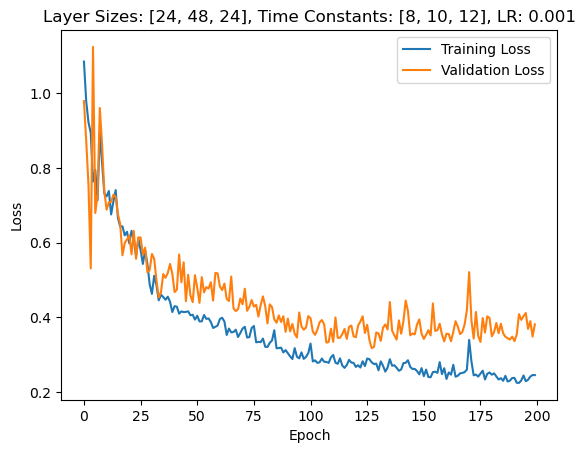

  0%|          | 1/200 [00:14<47:55, 14.45s/it]

Epoch 1/200, Training Loss: 1.5349158858353238, Validation Loss: 0.9947383829525539


  1%|          | 2/200 [00:28<47:24, 14.37s/it]

Epoch 2/200, Training Loss: 0.9497748714572979, Validation Loss: 0.740317131791796


  2%|▏         | 3/200 [00:43<47:23, 14.44s/it]

Epoch 3/200, Training Loss: 0.8253422210801322, Validation Loss: 0.4671493683542524


  2%|▏         | 4/200 [00:57<46:38, 14.28s/it]

Epoch 4/200, Training Loss: 1.0419559647452157, Validation Loss: 0.9120927282742092


  2%|▎         | 5/200 [01:11<46:22, 14.27s/it]

Epoch 5/200, Training Loss: 1.0851117631174483, Validation Loss: 0.9388896482331412


  3%|▎         | 6/200 [01:26<46:31, 14.39s/it]

Epoch 6/200, Training Loss: 0.9519487270769084, Validation Loss: 0.7472803933279855


  4%|▎         | 7/200 [01:40<46:39, 14.51s/it]

Epoch 7/200, Training Loss: 0.8607310843917558, Validation Loss: 0.36813999499593464


  4%|▍         | 8/200 [01:55<46:51, 14.65s/it]

Epoch 8/200, Training Loss: 1.0568769253649801, Validation Loss: 0.4815285674163273


  4%|▍         | 9/200 [02:10<46:20, 14.56s/it]

Epoch 9/200, Training Loss: 0.7889607469990568, Validation Loss: 0.47485499935490744


  5%|▌         | 10/200 [02:25<46:27, 14.67s/it]

Epoch 10/200, Training Loss: 0.7503566061550716, Validation Loss: 0.3932983087641852


  6%|▌         | 11/200 [02:39<45:42, 14.51s/it]

Epoch 11/200, Training Loss: 0.7292744809726499, Validation Loss: 0.672157096011298


  6%|▌         | 12/200 [02:53<45:23, 14.49s/it]

Epoch 12/200, Training Loss: 0.6777566536417547, Validation Loss: 0.5192681465830121


  6%|▋         | 13/200 [03:08<45:10, 14.50s/it]

Epoch 13/200, Training Loss: 0.7294553748841556, Validation Loss: 0.4670644977263042


  7%|▋         | 14/200 [03:22<44:31, 14.36s/it]

Epoch 14/200, Training Loss: 0.7150052549704066, Validation Loss: 0.4627069575445993


  8%|▊         | 15/200 [03:36<44:32, 14.44s/it]

Epoch 15/200, Training Loss: 0.6739136571029447, Validation Loss: 0.6592262131827218


  8%|▊         | 16/200 [03:50<43:55, 14.32s/it]

Epoch 16/200, Training Loss: 0.6280278681584124, Validation Loss: 0.5413364682878766


  8%|▊         | 17/200 [04:04<43:17, 14.19s/it]

Epoch 17/200, Training Loss: 0.644730436914372, Validation Loss: 0.5229364931583405


  9%|▉         | 18/200 [04:18<42:55, 14.15s/it]

Epoch 18/200, Training Loss: 0.6172598389522085, Validation Loss: 0.4826014999832426


 10%|▉         | 19/200 [04:33<42:36, 14.13s/it]

Epoch 19/200, Training Loss: 0.5984124946144392, Validation Loss: 0.5405091238873345


 10%|█         | 20/200 [04:47<42:41, 14.23s/it]

Epoch 20/200, Training Loss: 0.6370436616663663, Validation Loss: 0.5571861671549934


 10%|█         | 21/200 [05:01<42:22, 14.20s/it]

Epoch 21/200, Training Loss: 0.6143596526586784, Validation Loss: 0.5666849315166473


 11%|█         | 22/200 [05:15<41:44, 14.07s/it]

Epoch 22/200, Training Loss: 0.5990916782954954, Validation Loss: 0.5450913650648934


 12%|█▏        | 23/200 [05:30<42:10, 14.29s/it]

Epoch 23/200, Training Loss: 0.5826580541313819, Validation Loss: 0.5424248192991529


 12%|█▏        | 24/200 [05:44<41:40, 14.21s/it]

Epoch 24/200, Training Loss: 0.5659157116458101, Validation Loss: 0.5069702225072044


 12%|█▎        | 25/200 [05:57<41:02, 14.07s/it]

Epoch 25/200, Training Loss: 0.5960612752527561, Validation Loss: 0.5771076892103467


 13%|█▎        | 26/200 [06:11<40:41, 14.03s/it]

Epoch 26/200, Training Loss: 0.5825223360421523, Validation Loss: 0.5360358570303235


 14%|█▎        | 27/200 [06:25<40:19, 13.99s/it]

Epoch 27/200, Training Loss: 0.6028538717413848, Validation Loss: 0.43694631329604555


 14%|█▍        | 28/200 [06:39<40:13, 14.03s/it]

Epoch 28/200, Training Loss: 0.5741690023327773, Validation Loss: 0.5200447269848415


 14%|█▍        | 29/200 [06:53<39:51, 13.98s/it]

Epoch 29/200, Training Loss: 0.5432446587760493, Validation Loss: 0.5204569729311126


 15%|█▌        | 30/200 [07:07<39:42, 14.02s/it]

Epoch 30/200, Training Loss: 0.5341241157279825, Validation Loss: 0.5134664305618831


 16%|█▌        | 31/200 [07:22<39:56, 14.18s/it]

Epoch 31/200, Training Loss: 0.523382064306511, Validation Loss: 0.5467907701219831


 16%|█▌        | 32/200 [07:36<39:56, 14.26s/it]

Epoch 32/200, Training Loss: 0.5345350759771635, Validation Loss: 0.5139034220150539


 16%|█▋        | 33/200 [07:50<39:31, 14.20s/it]

Epoch 33/200, Training Loss: 0.5507824283163503, Validation Loss: 0.6011716340269361


 17%|█▋        | 34/200 [08:05<39:17, 14.20s/it]

Epoch 34/200, Training Loss: 0.581046923713864, Validation Loss: 0.545987918972969


 18%|█▊        | 35/200 [08:19<39:33, 14.39s/it]

Epoch 35/200, Training Loss: 0.6099670591219416, Validation Loss: 0.6083427327019828


 18%|█▊        | 36/200 [08:34<39:27, 14.44s/it]

Epoch 36/200, Training Loss: 0.5546750336323144, Validation Loss: 0.6382053196430206


 18%|█▊        | 37/200 [08:48<39:01, 14.36s/it]

Epoch 37/200, Training Loss: 0.6092478683534658, Validation Loss: 0.5779382309743336


 19%|█▉        | 38/200 [09:03<39:08, 14.50s/it]

Epoch 38/200, Training Loss: 0.5409061076506129, Validation Loss: 0.49954538685934885


 20%|█▉        | 39/200 [09:17<38:51, 14.48s/it]

Epoch 39/200, Training Loss: 0.5111957304882553, Validation Loss: 0.49869308514254435


 20%|██        | 40/200 [09:32<38:25, 14.41s/it]

Epoch 40/200, Training Loss: 0.5604266029483868, Validation Loss: 0.6031630039215088


 20%|██        | 41/200 [09:46<38:21, 14.47s/it]

Epoch 41/200, Training Loss: 0.5443773545184225, Validation Loss: 0.5148303423609052


 21%|██        | 42/200 [10:01<38:16, 14.54s/it]

Epoch 42/200, Training Loss: 0.5253042626493382, Validation Loss: 0.5204798877239227


 22%|██▏       | 43/200 [10:16<38:09, 14.59s/it]

Epoch 43/200, Training Loss: 0.5076889418206125, Validation Loss: 0.6253079559121814


 22%|██▏       | 44/200 [10:30<37:59, 14.61s/it]

Epoch 44/200, Training Loss: 0.5029123785360804, Validation Loss: 0.5498845747538975


 22%|██▎       | 45/200 [10:44<37:10, 14.39s/it]

Epoch 45/200, Training Loss: 0.49895826853671166, Validation Loss: 0.5772818880421775


 23%|██▎       | 46/200 [10:58<36:45, 14.32s/it]

Epoch 46/200, Training Loss: 0.4964007347259881, Validation Loss: 0.5502846815756389


 24%|██▎       | 47/200 [11:13<36:39, 14.38s/it]

Epoch 47/200, Training Loss: 0.547870267674608, Validation Loss: 0.5736969113349915


 24%|██▍       | 48/200 [11:27<36:10, 14.28s/it]

Epoch 48/200, Training Loss: 0.5525590535604729, Validation Loss: 0.5953768129859652


 24%|██▍       | 49/200 [11:41<35:43, 14.20s/it]

Epoch 49/200, Training Loss: 0.5388548017110465, Validation Loss: 0.5480508846896035


 25%|██▌       | 50/200 [11:55<35:21, 14.14s/it]

Epoch 50/200, Training Loss: 0.5204128190031592, Validation Loss: 0.569024669272559


 26%|██▌       | 51/200 [12:09<34:57, 14.07s/it]

Epoch 51/200, Training Loss: 0.5832735890487455, Validation Loss: 0.600558374609266


 26%|██▌       | 52/200 [12:23<34:41, 14.06s/it]

Epoch 52/200, Training Loss: 0.5594126430322539, Validation Loss: 0.6261037502970014


 26%|██▋       | 53/200 [12:37<34:23, 14.04s/it]

Epoch 53/200, Training Loss: 0.5622445693555868, Validation Loss: 0.5635709251676287


 27%|██▋       | 54/200 [12:52<34:48, 14.30s/it]

Epoch 54/200, Training Loss: 0.5387656252901509, Validation Loss: 0.5330834111997059


 28%|██▊       | 55/200 [13:05<34:02, 14.09s/it]

Epoch 55/200, Training Loss: 0.47849356565835344, Validation Loss: 0.54200921526977


 28%|██▊       | 56/200 [13:19<33:42, 14.04s/it]

Epoch 56/200, Training Loss: 0.48415112411076167, Validation Loss: 0.4925244684730257


 28%|██▊       | 57/200 [13:33<33:08, 13.91s/it]

Epoch 57/200, Training Loss: 0.4802472858496432, Validation Loss: 0.4832388971533094


 29%|██▉       | 58/200 [13:46<32:34, 13.77s/it]

Epoch 58/200, Training Loss: 0.48357976607556613, Validation Loss: 0.520618770803724


 30%|██▉       | 59/200 [14:01<32:36, 13.88s/it]

Epoch 59/200, Training Loss: 0.47159811235823723, Validation Loss: 0.5606445840426854


 30%|███       | 60/200 [14:14<32:03, 13.74s/it]

Epoch 60/200, Training Loss: 0.4639958393461299, Validation Loss: 0.5837027643408094


 30%|███       | 61/200 [14:27<31:34, 13.63s/it]

Epoch 61/200, Training Loss: 1.008633257083173, Validation Loss: 0.7922154111521584


 31%|███       | 62/200 [14:41<31:17, 13.61s/it]

Epoch 62/200, Training Loss: 0.7289013227201858, Validation Loss: 0.7162233058895383


 32%|███▏      | 63/200 [14:54<30:48, 13.50s/it]

Epoch 63/200, Training Loss: 0.6209674730615796, Validation Loss: 0.6784956455230713


 32%|███▏      | 64/200 [15:07<30:26, 13.43s/it]

Epoch 64/200, Training Loss: 0.6135604195999649, Validation Loss: 0.6998065284320286


 32%|███▎      | 65/200 [15:23<31:33, 14.03s/it]

Epoch 65/200, Training Loss: 0.575027826822029, Validation Loss: 0.7438224170889173


 33%|███▎      | 66/200 [15:37<31:25, 14.07s/it]

Epoch 66/200, Training Loss: 0.5703976778489239, Validation Loss: 0.545946574636868


 34%|███▎      | 67/200 [15:51<31:20, 14.14s/it]

Epoch 67/200, Training Loss: 0.588350236415863, Validation Loss: 0.5050623310463769


 34%|███▍      | 68/200 [16:06<31:37, 14.38s/it]

Epoch 68/200, Training Loss: 0.5507239761217585, Validation Loss: 0.6631037720612117


 34%|███▍      | 69/200 [16:21<31:25, 14.39s/it]

Epoch 69/200, Training Loss: 0.5163372611662127, Validation Loss: 0.5516632390873772


 35%|███▌      | 70/200 [16:35<31:18, 14.45s/it]

Epoch 70/200, Training Loss: 0.5171130175860423, Validation Loss: 0.5359872792448316


 36%|███▌      | 71/200 [16:50<31:34, 14.68s/it]

Epoch 71/200, Training Loss: 0.5314338018871704, Validation Loss: 0.5744748030390058


 36%|███▌      | 72/200 [17:05<31:08, 14.60s/it]

Epoch 72/200, Training Loss: 0.5533890088774124, Validation Loss: 0.5160646779196603


 36%|███▋      | 73/200 [17:19<30:25, 14.37s/it]

Epoch 73/200, Training Loss: 0.4922756780430956, Validation Loss: 0.5854080319404602


 37%|███▋      | 74/200 [17:33<29:52, 14.23s/it]

Epoch 74/200, Training Loss: 0.503049484120225, Validation Loss: 0.5590313971042633


 38%|███▊      | 75/200 [17:47<29:32, 14.18s/it]

Epoch 75/200, Training Loss: 0.49860718452705527, Validation Loss: 0.5212675929069519


 38%|███▊      | 76/200 [18:00<29:05, 14.08s/it]

Epoch 76/200, Training Loss: 0.4901758184972799, Validation Loss: 0.5336818865367344


 38%|███▊      | 77/200 [18:14<28:47, 14.04s/it]

Epoch 77/200, Training Loss: 0.5061677989532363, Validation Loss: 0.5415989330836705


 39%|███▉      | 78/200 [18:29<28:36, 14.07s/it]

Epoch 78/200, Training Loss: 0.46355646314486015, Validation Loss: 0.5672255541597094


 40%|███▉      | 79/200 [18:43<28:30, 14.14s/it]

Epoch 79/200, Training Loss: 0.48108202500163383, Validation Loss: 0.5457266909735543


 40%|████      | 80/200 [18:58<28:45, 14.38s/it]

Epoch 80/200, Training Loss: 0.4858651509824789, Validation Loss: 0.6017705414976392


 40%|████      | 81/200 [19:12<28:17, 14.26s/it]

Epoch 81/200, Training Loss: 0.4616537678916499, Validation Loss: 0.5357053194727216


 41%|████      | 82/200 [19:26<27:57, 14.22s/it]

Epoch 82/200, Training Loss: 0.5123944858897407, Validation Loss: 0.5142226815223694


 42%|████▏     | 83/200 [19:41<28:15, 14.49s/it]

Epoch 83/200, Training Loss: 0.4680190716149672, Validation Loss: 0.5042335178170886


 42%|████▏     | 84/200 [19:55<27:47, 14.38s/it]

Epoch 84/200, Training Loss: 0.48600113279414625, Validation Loss: 0.5209598796708244


 42%|████▎     | 85/200 [20:09<27:22, 14.28s/it]

Epoch 85/200, Training Loss: 0.47148663705250005, Validation Loss: 0.5298598110675812


 43%|████▎     | 86/200 [20:24<27:08, 14.28s/it]

Epoch 86/200, Training Loss: 0.5170073925324206, Validation Loss: 0.5471784855638232


 44%|████▎     | 87/200 [20:37<26:43, 14.19s/it]

Epoch 87/200, Training Loss: 0.4644180699339453, Validation Loss: 0.5403050822871072


 44%|████▍     | 88/200 [20:52<26:33, 14.23s/it]

Epoch 88/200, Training Loss: 0.4608365002105821, Validation Loss: 0.612048259803227


 44%|████▍     | 89/200 [21:06<26:17, 14.21s/it]

Epoch 89/200, Training Loss: 0.4314282716445203, Validation Loss: 0.5402053722313472


 45%|████▌     | 90/200 [21:20<25:57, 14.16s/it]

Epoch 90/200, Training Loss: 0.44532081512910016, Validation Loss: 0.5238656827381679


 46%|████▌     | 91/200 [21:35<26:00, 14.32s/it]

Epoch 91/200, Training Loss: 0.43336431288494254, Validation Loss: 0.5696895888873509


 46%|████▌     | 92/200 [21:49<25:56, 14.41s/it]

Epoch 92/200, Training Loss: 0.44419607491988056, Validation Loss: 0.6140375137329102


 46%|████▋     | 93/200 [22:04<25:37, 14.37s/it]

Epoch 93/200, Training Loss: 0.44638196308657807, Validation Loss: 0.5330863914319447


 47%|████▋     | 94/200 [22:18<25:09, 14.25s/it]

Epoch 94/200, Training Loss: 0.49637297414383796, Validation Loss: 0.5140652528830937


 48%|████▊     | 95/200 [22:33<25:19, 14.47s/it]

Epoch 95/200, Training Loss: 0.45319591223631267, Validation Loss: 0.5162695220538548


 48%|████▊     | 96/200 [22:47<25:04, 14.47s/it]

Epoch 96/200, Training Loss: 0.45374858688633396, Validation Loss: 0.49474561640194487


 48%|████▊     | 97/200 [23:01<24:35, 14.33s/it]

Epoch 97/200, Training Loss: 0.43061282499781195, Validation Loss: 0.5990418429885592


 49%|████▉     | 98/200 [23:15<24:14, 14.26s/it]

Epoch 98/200, Training Loss: 0.43085966610683585, Validation Loss: 0.534541232245309


 50%|████▉     | 99/200 [23:29<23:55, 14.21s/it]

Epoch 99/200, Training Loss: 0.45967411039010536, Validation Loss: 0.5100912622043065


 50%|█████     | 100/200 [23:43<23:24, 14.05s/it]

Epoch 100/200, Training Loss: 0.44343341858881824, Validation Loss: 0.5222178229263851


 50%|█████     | 101/200 [23:57<23:08, 14.02s/it]

Epoch 101/200, Training Loss: 0.45621233560004326, Validation Loss: 0.5381681110177722


 51%|█████     | 102/200 [24:11<22:51, 14.00s/it]

Epoch 102/200, Training Loss: 0.43094578863314864, Validation Loss: 0.48975173916135517


 52%|█████▏    | 103/200 [24:25<22:45, 14.08s/it]

Epoch 103/200, Training Loss: 0.42269725450929607, Validation Loss: 0.4890005418232509


 52%|█████▏    | 104/200 [24:40<22:48, 14.25s/it]

Epoch 104/200, Training Loss: 0.4132803311606623, Validation Loss: 0.5249078103474208


 52%|█████▎    | 105/200 [24:54<22:22, 14.13s/it]

Epoch 105/200, Training Loss: 0.4146191808131506, Validation Loss: 0.5141016074589321


 53%|█████▎    | 106/200 [25:08<22:10, 14.15s/it]

Epoch 106/200, Training Loss: 0.4402348109573688, Validation Loss: 0.5428042965275901


 54%|█████▎    | 107/200 [25:23<22:16, 14.37s/it]

Epoch 107/200, Training Loss: 0.4300286814851581, Validation Loss: 0.513362454516547


 54%|█████▍    | 108/200 [25:37<21:55, 14.30s/it]

Epoch 108/200, Training Loss: 0.42248460762905626, Validation Loss: 0.46640689245292116


 55%|█████▍    | 109/200 [25:51<21:36, 14.25s/it]

Epoch 109/200, Training Loss: 0.43053438444182557, Validation Loss: 0.4817682589803423


 55%|█████▌    | 110/200 [26:05<21:11, 14.13s/it]

Epoch 110/200, Training Loss: 0.42237827350508494, Validation Loss: 0.4721815969262804


 56%|█████▌    | 111/200 [26:19<20:58, 14.14s/it]

Epoch 111/200, Training Loss: 0.4153978962380931, Validation Loss: 0.5620990949017661


 56%|█████▌    | 112/200 [26:33<20:39, 14.08s/it]

Epoch 112/200, Training Loss: 0.43834946374848205, Validation Loss: 0.5282412809985024


 56%|█████▋    | 113/200 [26:47<20:18, 14.00s/it]

Epoch 113/200, Training Loss: 0.43686020767913675, Validation Loss: 0.5102576166391373


 57%|█████▋    | 114/200 [27:01<20:05, 14.01s/it]

Epoch 114/200, Training Loss: 0.43255428969860077, Validation Loss: 0.544098688023431


 57%|█████▊    | 115/200 [27:15<20:02, 14.15s/it]

Epoch 115/200, Training Loss: 0.39606355833557416, Validation Loss: 0.5528648112501416


 58%|█████▊    | 116/200 [27:30<19:55, 14.24s/it]

Epoch 116/200, Training Loss: 0.4221094692090772, Validation Loss: 0.4878847471305302


 58%|█████▊    | 117/200 [27:44<19:39, 14.21s/it]

Epoch 117/200, Training Loss: 0.41932036376224374, Validation Loss: 0.4799941395010267


 59%|█████▉    | 118/200 [27:58<19:16, 14.11s/it]

Epoch 118/200, Training Loss: 0.39934433856100404, Validation Loss: 0.5196147326912198


 60%|█████▉    | 119/200 [28:12<19:19, 14.32s/it]

Epoch 119/200, Training Loss: 0.41664292171316325, Validation Loss: 0.4895102083683014


 60%|██████    | 120/200 [28:27<19:02, 14.29s/it]

Epoch 120/200, Training Loss: 0.40278913980385045, Validation Loss: 0.45811784267425537


 60%|██████    | 121/200 [28:40<18:36, 14.13s/it]

Epoch 121/200, Training Loss: 0.4065833923951635, Validation Loss: 0.434627754347665


 61%|██████    | 122/200 [28:54<18:19, 14.10s/it]

Epoch 122/200, Training Loss: 0.43115694961457884, Validation Loss: 0.4594554049628122


 62%|██████▏   | 123/200 [29:08<17:56, 13.98s/it]

Epoch 123/200, Training Loss: 0.4090741771572041, Validation Loss: 0.49269970825740267


 62%|██████▏   | 124/200 [29:22<17:42, 13.98s/it]

Epoch 124/200, Training Loss: 0.39991930745682625, Validation Loss: 0.48483999712126596


 62%|██████▎   | 125/200 [29:36<17:29, 13.99s/it]

Epoch 125/200, Training Loss: 0.38605185977692874, Validation Loss: 0.5330543688365391


 63%|██████▎   | 126/200 [29:50<17:11, 13.93s/it]

Epoch 126/200, Training Loss: 0.4479978489425947, Validation Loss: 0.5817462163312095


 64%|██████▎   | 127/200 [30:04<17:08, 14.09s/it]

Epoch 127/200, Training Loss: 0.4573217096193781, Validation Loss: 0.4775697099311011


 64%|██████▍   | 128/200 [30:19<17:07, 14.27s/it]

Epoch 128/200, Training Loss: 0.39652073580139086, Validation Loss: 0.5223619299275535


 64%|██████▍   | 129/200 [30:33<16:46, 14.17s/it]

Epoch 129/200, Training Loss: 0.3996141620402066, Validation Loss: 0.45393238748822895


 65%|██████▌   | 130/200 [30:47<16:31, 14.16s/it]

Epoch 130/200, Training Loss: 0.38578067663705573, Validation Loss: 0.47110263790403095


 66%|██████▌   | 131/200 [31:02<16:26, 14.29s/it]

Epoch 131/200, Training Loss: 0.3832347037376098, Validation Loss: 0.46809336968830656


 66%|██████▌   | 132/200 [31:16<16:06, 14.22s/it]

Epoch 132/200, Training Loss: 0.4004809999803327, Validation Loss: 0.428145455462592


 66%|██████▋   | 133/200 [31:30<15:52, 14.21s/it]

Epoch 133/200, Training Loss: 0.4031659671158161, Validation Loss: 0.46239777547972544


 67%|██████▋   | 134/200 [31:44<15:30, 14.10s/it]

Epoch 134/200, Training Loss: 0.38520185002740825, Validation Loss: 0.46664950251579285


 68%|██████▊   | 135/200 [31:58<15:17, 14.11s/it]

Epoch 135/200, Training Loss: 0.3727902553553851, Validation Loss: 0.4101536955152239


 68%|██████▊   | 136/200 [32:12<14:56, 14.00s/it]

Epoch 136/200, Training Loss: 0.3965132967481073, Validation Loss: 0.4469062771115984


 68%|██████▊   | 137/200 [32:26<14:40, 13.98s/it]

Epoch 137/200, Training Loss: 0.38846435468151885, Validation Loss: 0.4021412857941219


 69%|██████▉   | 138/200 [32:40<14:26, 13.98s/it]

Epoch 138/200, Training Loss: 0.37410197505411114, Validation Loss: 0.47785093103136334


 70%|██████▉   | 139/200 [32:54<14:15, 14.03s/it]

Epoch 139/200, Training Loss: 0.3987728365749683, Validation Loss: 0.472432873078755


 70%|███████   | 140/200 [33:09<14:15, 14.26s/it]

Epoch 140/200, Training Loss: 0.3832302243923241, Validation Loss: 0.46341835600989206


 70%|███████   | 141/200 [33:23<14:05, 14.33s/it]

Epoch 141/200, Training Loss: 0.3709192505141474, Validation Loss: 0.465039815221514


 71%|███████   | 142/200 [33:37<13:48, 14.29s/it]

Epoch 142/200, Training Loss: 0.40798911845908975, Validation Loss: 0.45887610742024015


 72%|███████▏  | 143/200 [33:52<13:47, 14.51s/it]

Epoch 143/200, Training Loss: 0.39705263106328137, Validation Loss: 0.42771568255765097


 72%|███████▏  | 144/200 [34:06<13:24, 14.37s/it]

Epoch 144/200, Training Loss: 0.401490292740318, Validation Loss: 0.4196820578404835


 72%|███████▎  | 145/200 [34:20<13:03, 14.25s/it]

Epoch 145/200, Training Loss: 0.3808283471273926, Validation Loss: 0.4755976157529013


 73%|███████▎  | 146/200 [34:34<12:46, 14.20s/it]

Epoch 146/200, Training Loss: 0.3740645596441233, Validation Loss: 0.4082364823137011


 74%|███████▎  | 147/200 [34:49<12:32, 14.19s/it]

Epoch 147/200, Training Loss: 0.35153902518861696, Validation Loss: 0.5086365448577064


 74%|███████▍  | 148/200 [35:03<12:16, 14.17s/it]

Epoch 148/200, Training Loss: 0.3692875476378315, Validation Loss: 0.5052259138652256


 74%|███████▍  | 149/200 [35:17<11:58, 14.09s/it]

Epoch 149/200, Training Loss: 0.35061948057615533, Validation Loss: 0.46655102712767466


 75%|███████▌  | 150/200 [35:30<11:42, 14.04s/it]

Epoch 150/200, Training Loss: 0.36977450662064104, Validation Loss: 0.4196907750197819


 76%|███████▌  | 151/200 [35:45<11:38, 14.25s/it]

Epoch 151/200, Training Loss: 0.3794098712925641, Validation Loss: 0.4331132982458387


 76%|███████▌  | 152/200 [36:00<11:28, 14.35s/it]

Epoch 152/200, Training Loss: 0.37184811369428095, Validation Loss: 0.41896270854132517


 76%|███████▋  | 153/200 [36:14<11:11, 14.28s/it]

Epoch 153/200, Training Loss: 0.3465052844499642, Validation Loss: 0.4554039537906647


 77%|███████▋  | 154/200 [36:28<10:57, 14.29s/it]

Epoch 154/200, Training Loss: 0.3763175935677762, Validation Loss: 0.47011223222528187


 78%|███████▊  | 155/200 [36:43<10:48, 14.42s/it]

Epoch 155/200, Training Loss: 0.38635222248311313, Validation Loss: 0.44909133442810606


 78%|███████▊  | 156/200 [36:57<10:34, 14.41s/it]

Epoch 156/200, Training Loss: 0.3582950774228798, Validation Loss: 0.43123506222452435


 78%|███████▊  | 157/200 [37:11<10:12, 14.24s/it]

Epoch 157/200, Training Loss: 0.3549389704218451, Validation Loss: 0.4516844430140087


 79%|███████▉  | 158/200 [37:25<09:53, 14.13s/it]

Epoch 158/200, Training Loss: 0.39573348243281525, Validation Loss: 0.5424396353108543


 80%|███████▉  | 159/200 [37:39<09:40, 14.17s/it]

Epoch 159/200, Training Loss: 0.37894164082014337, Validation Loss: 0.47167903184890747


 80%|████████  | 160/200 [37:53<09:25, 14.13s/it]

Epoch 160/200, Training Loss: 0.36632283144402056, Validation Loss: 0.4175470088209425


 80%|████████  | 161/200 [38:08<09:11, 14.13s/it]

Epoch 161/200, Training Loss: 0.35679765973451005, Validation Loss: 0.4579352991921561


 81%|████████  | 162/200 [38:22<08:56, 14.11s/it]

Epoch 162/200, Training Loss: 0.35842893132061326, Validation Loss: 0.43635076710156034


 82%|████████▏ | 163/200 [38:36<08:43, 14.16s/it]

Epoch 163/200, Training Loss: 0.36181724461603837, Validation Loss: 0.42676907777786255


 82%|████████▏ | 164/200 [38:51<08:37, 14.38s/it]

Epoch 164/200, Training Loss: 0.35458167684528064, Validation Loss: 0.45619813033512663


 82%|████████▎ | 165/200 [39:05<08:21, 14.31s/it]

Epoch 165/200, Training Loss: 0.3420980874238149, Validation Loss: 0.5026909453528268


 83%|████████▎ | 166/200 [39:19<08:02, 14.18s/it]

Epoch 166/200, Training Loss: 0.35276289888710344, Validation Loss: 0.4470160688672747


 84%|████████▎ | 167/200 [39:34<07:55, 14.41s/it]

Epoch 167/200, Training Loss: 0.35487903710806146, Validation Loss: 0.42422859583582195


 84%|████████▍ | 168/200 [39:48<07:39, 14.36s/it]

Epoch 168/200, Training Loss: 0.38029832013373105, Validation Loss: 0.42721347297940937


 84%|████████▍ | 169/200 [40:02<07:22, 14.28s/it]

Epoch 169/200, Training Loss: 0.34351074540952464, Validation Loss: 0.4343270744596209


 85%|████████▌ | 170/200 [40:16<07:05, 14.18s/it]

Epoch 170/200, Training Loss: 0.3527549121458575, Validation Loss: 0.43050446680613924


 86%|████████▌ | 171/200 [40:30<06:48, 14.08s/it]

Epoch 171/200, Training Loss: 0.38081287494245564, Validation Loss: 0.40602314685072216


 86%|████████▌ | 172/200 [40:44<06:34, 14.10s/it]

Epoch 172/200, Training Loss: 0.3727635406660584, Validation Loss: 0.47414372648511616


 86%|████████▋ | 173/200 [40:58<06:19, 14.07s/it]

Epoch 173/200, Training Loss: 0.3511233073922823, Validation Loss: 0.4265677034854889


 87%|████████▋ | 174/200 [41:12<06:07, 14.12s/it]

Epoch 174/200, Training Loss: 0.3399652923053166, Validation Loss: 0.5021550697939736


 88%|████████▊ | 175/200 [41:27<05:56, 14.25s/it]

Epoch 175/200, Training Loss: 0.33888208135119025, Validation Loss: 0.5440664759704045


 88%|████████▊ | 176/200 [41:41<05:43, 14.32s/it]

Epoch 176/200, Training Loss: 0.3593135341158453, Validation Loss: 0.4746569607939039


 88%|████████▊ | 177/200 [41:56<05:29, 14.32s/it]

Epoch 177/200, Training Loss: 0.34170350024722657, Validation Loss: 0.48665536301476614


 89%|████████▉ | 178/200 [42:10<05:13, 14.24s/it]

Epoch 178/200, Training Loss: 0.33297659597306883, Validation Loss: 0.47966587117740084


 90%|████████▉ | 179/200 [42:24<05:01, 14.36s/it]

Epoch 179/200, Training Loss: 0.33373551464305734, Validation Loss: 0.4184312011514391


 90%|█████████ | 180/200 [42:39<04:48, 14.40s/it]

Epoch 180/200, Training Loss: 0.3567441721569817, Validation Loss: 0.4759924369198935


 90%|█████████ | 181/200 [42:53<04:30, 14.24s/it]

Epoch 181/200, Training Loss: 0.3325880216258877, Validation Loss: 0.46234163641929626


 91%|█████████ | 182/200 [43:07<04:15, 14.22s/it]

Epoch 182/200, Training Loss: 0.3389312487165883, Validation Loss: 0.41414713859558105


 92%|█████████▏| 183/200 [43:21<04:00, 14.13s/it]

Epoch 183/200, Training Loss: 0.32340834205443003, Validation Loss: 0.44385976025036405


 92%|█████████▏| 184/200 [43:34<03:43, 14.00s/it]

Epoch 184/200, Training Loss: 0.34797256960059114, Validation Loss: 0.46529183856078554


 92%|█████████▎| 185/200 [43:48<03:29, 14.00s/it]

Epoch 185/200, Training Loss: 0.35132517145489744, Validation Loss: 0.4133015658174242


 93%|█████████▎| 186/200 [44:02<03:15, 13.94s/it]

Epoch 186/200, Training Loss: 0.33580786292001885, Validation Loss: 0.4431236812046596


 94%|█████████▎| 187/200 [44:16<03:01, 13.96s/it]

Epoch 187/200, Training Loss: 0.3482332409552808, Validation Loss: 0.4188590326479503


 94%|█████████▍| 188/200 [44:31<02:50, 14.22s/it]

Epoch 188/200, Training Loss: 0.33526145174818217, Validation Loss: 0.43640437722206116


 94%|█████████▍| 189/200 [44:45<02:35, 14.09s/it]

Epoch 189/200, Training Loss: 0.32824624695305554, Validation Loss: 0.42210071427481516


 95%|█████████▌| 190/200 [44:59<02:20, 14.06s/it]

Epoch 190/200, Training Loss: 0.34621779058339464, Validation Loss: 0.45693825823920114


 96%|█████████▌| 191/200 [45:13<02:07, 14.21s/it]

Epoch 191/200, Training Loss: 0.327679934929002, Validation Loss: 0.4096217581204006


 96%|█████████▌| 192/200 [45:27<01:53, 14.14s/it]

Epoch 192/200, Training Loss: 0.3357475203163219, Validation Loss: 0.43762307720524923


 96%|█████████▋| 193/200 [45:42<01:39, 14.16s/it]

Epoch 193/200, Training Loss: 0.3595822214517953, Validation Loss: 0.40704551126275745


 97%|█████████▋| 194/200 [45:55<01:24, 14.03s/it]

Epoch 194/200, Training Loss: 0.3457678508646083, Validation Loss: 0.423774527651923


 98%|█████████▊| 195/200 [46:09<01:09, 13.94s/it]

Epoch 195/200, Training Loss: 0.3569572864557212, Validation Loss: 0.4539187933717455


 98%|█████████▊| 196/200 [46:23<00:56, 14.03s/it]

Epoch 196/200, Training Loss: 0.3524312136589356, Validation Loss: 0.4428743932928358


 98%|█████████▊| 197/200 [46:37<00:41, 13.94s/it]

Epoch 197/200, Training Loss: 0.3579547849466216, Validation Loss: 0.40320305952004026


 99%|█████████▉| 198/200 [46:51<00:27, 13.92s/it]

Epoch 198/200, Training Loss: 0.3465412090409477, Validation Loss: 0.42889964154788424


100%|█████████▉| 199/200 [47:05<00:14, 14.01s/it]

Epoch 199/200, Training Loss: 0.3543637049085689, Validation Loss: 0.45070204990250723


100%|██████████| 200/200 [47:20<00:00, 14.20s/it]

Epoch 200/200, Training Loss: 0.35912451387014027, Validation Loss: 0.39631020597049166
Final Accuracy: 90.67%, Precision: 0.91, Recall: 0.91


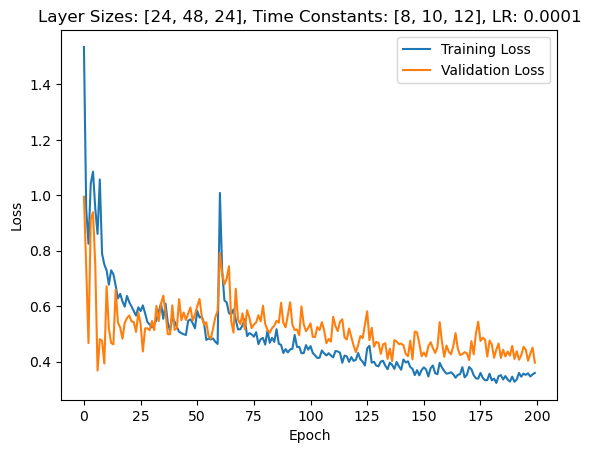

  0%|          | 1/200 [00:14<49:34, 14.95s/it]

Epoch 1/200, Training Loss: 0.916608287478393, Validation Loss: 0.7814352640083858


  1%|          | 2/200 [00:29<48:24, 14.67s/it]

Epoch 2/200, Training Loss: 0.8561929053855393, Validation Loss: 0.7927535729748862


  2%|▏         | 3/200 [00:43<47:53, 14.58s/it]

Epoch 3/200, Training Loss: 0.7969593169554224, Validation Loss: 0.7214781301362174


  2%|▏         | 4/200 [00:57<46:41, 14.29s/it]

Epoch 4/200, Training Loss: 0.7671291305209106, Validation Loss: 0.6984614304133824


  2%|▎         | 5/200 [01:11<45:48, 14.10s/it]

Epoch 5/200, Training Loss: 0.7283293008804321, Validation Loss: 0.726999540414129


  3%|▎         | 6/200 [01:26<46:21, 14.34s/it]

Epoch 6/200, Training Loss: 0.7053812253025343, Validation Loss: 0.6787959081786019


  4%|▎         | 7/200 [01:40<46:14, 14.37s/it]

Epoch 7/200, Training Loss: 0.7207567196971966, Validation Loss: 0.7335239861692701


  4%|▍         | 8/200 [01:55<46:17, 14.47s/it]

Epoch 8/200, Training Loss: 0.7050559970567811, Validation Loss: 0.7489486251558576


  4%|▍         | 9/200 [02:10<46:21, 14.56s/it]

Epoch 9/200, Training Loss: 0.6847226383551112, Validation Loss: 0.784502421106611


  5%|▌         | 10/200 [02:24<45:56, 14.51s/it]

Epoch 10/200, Training Loss: 0.6839327379217688, Validation Loss: 0.7039543581860406


  6%|▌         | 11/200 [02:38<45:26, 14.43s/it]

Epoch 11/200, Training Loss: 0.6811604117447475, Validation Loss: 0.6922240193401065


  6%|▌         | 12/200 [02:53<45:22, 14.48s/it]

Epoch 12/200, Training Loss: 0.6324113837952884, Validation Loss: 0.6554503206695829


  6%|▋         | 13/200 [03:07<44:28, 14.27s/it]

Epoch 13/200, Training Loss: 0.621455689646163, Validation Loss: 0.6364343208926064


  7%|▋         | 14/200 [03:21<44:03, 14.21s/it]

Epoch 14/200, Training Loss: 0.6356285444970401, Validation Loss: 0.6480213680437633


  8%|▊         | 15/200 [03:35<43:36, 14.14s/it]

Epoch 15/200, Training Loss: 0.5984155462597901, Validation Loss: 0.6272184912647519


  8%|▊         | 16/200 [03:49<43:52, 14.31s/it]

Epoch 16/200, Training Loss: 0.6039379289690053, Validation Loss: 0.6373700244086129


  8%|▊         | 17/200 [04:04<43:29, 14.26s/it]

Epoch 17/200, Training Loss: 0.5812546093508882, Validation Loss: 0.6223731935024261


  9%|▉         | 18/200 [04:17<42:50, 14.12s/it]

Epoch 18/200, Training Loss: 0.5676248551539655, Validation Loss: 0.6785849630832672


 10%|▉         | 19/200 [04:31<42:32, 14.10s/it]

Epoch 19/200, Training Loss: 0.5771116580603257, Validation Loss: 0.6140332392283848


 10%|█         | 20/200 [04:46<42:29, 14.16s/it]

Epoch 20/200, Training Loss: 0.5714670318477558, Validation Loss: 0.6392102305378232


 10%|█         | 21/200 [05:00<42:29, 14.25s/it]

Epoch 21/200, Training Loss: 0.5739588298887577, Validation Loss: 0.5944577008485794


 11%|█         | 22/200 [05:14<42:06, 14.19s/it]

Epoch 22/200, Training Loss: 0.5631043972834101, Validation Loss: 0.6486869028636387


 12%|█▏        | 23/200 [05:28<41:38, 14.12s/it]

Epoch 23/200, Training Loss: 0.549675074950704, Validation Loss: 0.6146484762430191


 12%|█▏        | 24/200 [05:43<41:57, 14.30s/it]

Epoch 24/200, Training Loss: 0.5346198087593295, Validation Loss: 0.6320997657520431


 12%|█▎        | 25/200 [05:57<41:30, 14.23s/it]

Epoch 25/200, Training Loss: 0.556587852397055, Validation Loss: 0.6200261924948011


 13%|█▎        | 26/200 [06:11<41:00, 14.14s/it]

Epoch 26/200, Training Loss: 0.5607296622024392, Validation Loss: 0.5824297027928489


 14%|█▎        | 27/200 [06:25<40:41, 14.11s/it]

Epoch 27/200, Training Loss: 0.5379622944121091, Validation Loss: 0.6001941391399929


 14%|█▍        | 28/200 [06:39<40:08, 14.00s/it]

Epoch 28/200, Training Loss: 0.5524158230367696, Validation Loss: 0.5891493516308921


 14%|█▍        | 29/200 [06:53<39:44, 13.95s/it]

Epoch 29/200, Training Loss: 0.5279019415940879, Validation Loss: 0.5516240341322762


 15%|█▌        | 30/200 [07:07<39:34, 13.97s/it]

Epoch 30/200, Training Loss: 0.5128799210179527, Validation Loss: 0.5833845692021506


 16%|█▌        | 31/200 [07:21<39:20, 13.97s/it]

Epoch 31/200, Training Loss: 0.5436659753322601, Validation Loss: 0.5465622246265411


 16%|█▌        | 32/200 [07:35<39:20, 14.05s/it]

Epoch 32/200, Training Loss: 0.5007309885519855, Validation Loss: 0.5508219344275338


 16%|█▋        | 33/200 [07:49<39:35, 14.22s/it]

Epoch 33/200, Training Loss: 0.48535932684844396, Validation Loss: 0.5359176184449878


 17%|█▋        | 34/200 [08:03<39:04, 14.12s/it]

Epoch 34/200, Training Loss: 0.4872860942246779, Validation Loss: 0.5407488026789257


 18%|█▊        | 35/200 [08:18<39:01, 14.19s/it]

Epoch 35/200, Training Loss: 0.49232558315654973, Validation Loss: 0.5208563698189599


 18%|█▊        | 36/200 [08:32<39:04, 14.30s/it]

Epoch 36/200, Training Loss: 0.49036472754658395, Validation Loss: 0.5776068014757973


 18%|█▊        | 37/200 [08:46<38:37, 14.22s/it]

Epoch 37/200, Training Loss: 0.4922229928790398, Validation Loss: 0.4889849530799048


 19%|█▉        | 38/200 [09:01<38:28, 14.25s/it]

Epoch 38/200, Training Loss: 0.466073325220144, Validation Loss: 0.4971217278923307


 20%|█▉        | 39/200 [09:14<37:54, 14.13s/it]

Epoch 39/200, Training Loss: 0.45059238711618027, Validation Loss: 0.49318436639649527


 20%|██        | 40/200 [09:28<37:34, 14.09s/it]

Epoch 40/200, Training Loss: 0.46928023673453423, Validation Loss: 0.49152725509234835


 20%|██        | 41/200 [09:42<37:14, 14.05s/it]

Epoch 41/200, Training Loss: 0.47496463892594826, Validation Loss: 0.5171667188405991


 21%|██        | 42/200 [09:56<36:45, 13.96s/it]

Epoch 42/200, Training Loss: 0.45585854941943904, Validation Loss: 0.5187929826123374


 22%|██▏       | 43/200 [10:10<36:42, 14.03s/it]

Epoch 43/200, Training Loss: 0.44717098603833394, Validation Loss: 0.48364169682775227


 22%|██▏       | 44/200 [10:25<36:36, 14.08s/it]

Epoch 44/200, Training Loss: 0.41969061769404503, Validation Loss: 0.4379717494760241


 22%|██▎       | 45/200 [10:39<36:45, 14.23s/it]

Epoch 45/200, Training Loss: 0.4319234032113597, Validation Loss: 0.5002355064664569


 23%|██▎       | 46/200 [10:53<36:34, 14.25s/it]

Epoch 46/200, Training Loss: 0.4275205278733991, Validation Loss: 0.5097752213478088


 24%|██▎       | 47/200 [11:07<36:02, 14.13s/it]

Epoch 47/200, Training Loss: 0.4389190412354919, Validation Loss: 0.4177925991160529


 24%|██▍       | 48/200 [11:22<36:14, 14.30s/it]

Epoch 48/200, Training Loss: 0.4373138386685893, Validation Loss: 0.5049160037721906


 24%|██▍       | 49/200 [11:36<35:56, 14.28s/it]

Epoch 49/200, Training Loss: 0.43122970748622463, Validation Loss: 0.4477459021977016


 25%|██▌       | 50/200 [11:50<35:21, 14.15s/it]

Epoch 50/200, Training Loss: 0.42035842335449075, Validation Loss: 0.4437142610549927


 26%|██▌       | 51/200 [12:04<35:08, 14.15s/it]

Epoch 51/200, Training Loss: 0.4353131803701509, Validation Loss: 0.5816661630358014


 26%|██▌       | 52/200 [12:18<34:40, 14.06s/it]

Epoch 52/200, Training Loss: 0.4836704506064361, Validation Loss: 0.5135323916162763


 26%|██▋       | 53/200 [12:32<34:27, 14.07s/it]

Epoch 53/200, Training Loss: 0.43579735649081897, Validation Loss: 0.4650612494775227


 27%|██▋       | 54/200 [12:46<34:28, 14.17s/it]

Epoch 54/200, Training Loss: 0.4188961352942125, Validation Loss: 0.4328847995826176


 28%|██▊       | 55/200 [13:00<34:05, 14.10s/it]

Epoch 55/200, Training Loss: 0.4050833951189833, Validation Loss: 0.47455420451504843


 28%|██▊       | 56/200 [13:15<34:03, 14.19s/it]

Epoch 56/200, Training Loss: 0.37479629241070656, Validation Loss: 0.40954717993736267


 28%|██▊       | 57/200 [13:30<34:10, 14.34s/it]

Epoch 57/200, Training Loss: 0.38377308367558244, Validation Loss: 0.473453157714435


 29%|██▉       | 58/200 [13:44<33:45, 14.26s/it]

Epoch 58/200, Training Loss: 0.4017588380935057, Validation Loss: 0.4367450475692749


 30%|██▉       | 59/200 [13:58<33:25, 14.22s/it]

Epoch 59/200, Training Loss: 0.3820232847389185, Validation Loss: 0.4606006954397474


 30%|███       | 60/200 [14:12<33:29, 14.35s/it]

Epoch 60/200, Training Loss: 0.3827474741440899, Validation Loss: 0.44652679775442394


 30%|███       | 61/200 [14:27<33:05, 14.29s/it]

Epoch 61/200, Training Loss: 0.3979867997596849, Validation Loss: 0.43568282042230877


 31%|███       | 62/200 [14:41<32:45, 14.24s/it]

Epoch 62/200, Training Loss: 0.3999177999091598, Validation Loss: 0.4736559007849012


 32%|███▏      | 63/200 [14:54<32:13, 14.11s/it]

Epoch 63/200, Training Loss: 0.38812626617134743, Validation Loss: 0.4536096900701523


 32%|███▏      | 64/200 [15:08<31:54, 14.08s/it]

Epoch 64/200, Training Loss: 0.4181773617582501, Validation Loss: 0.5900353150708335


 32%|███▎      | 65/200 [15:22<31:35, 14.04s/it]

Epoch 65/200, Training Loss: 0.40514287858639125, Validation Loss: 0.4799849731581552


 33%|███▎      | 66/200 [15:36<31:20, 14.03s/it]

Epoch 66/200, Training Loss: 0.401884433514667, Validation Loss: 0.47845292517117094


 34%|███▎      | 67/200 [15:51<31:09, 14.06s/it]

Epoch 67/200, Training Loss: 0.4457788534884183, Validation Loss: 0.46638748049736023


 34%|███▍      | 68/200 [16:05<31:01, 14.10s/it]

Epoch 68/200, Training Loss: 0.40364361427864937, Validation Loss: 0.5050479152372905


 34%|███▍      | 69/200 [16:19<31:06, 14.24s/it]

Epoch 69/200, Training Loss: 0.385216475376543, Validation Loss: 0.46396895817347933


 35%|███▌      | 70/200 [16:34<30:55, 14.27s/it]

Epoch 70/200, Training Loss: 0.37863662726474256, Validation Loss: 0.5413083157369069


 36%|███▌      | 71/200 [16:48<30:27, 14.16s/it]

Epoch 71/200, Training Loss: 0.4312203712058517, Validation Loss: 0.4906351183141981


 36%|███▌      | 72/200 [17:03<30:43, 14.40s/it]

Epoch 72/200, Training Loss: 0.3892397253580813, Validation Loss: 0.5025002232619694


 36%|███▋      | 73/200 [17:17<30:24, 14.37s/it]

Epoch 73/200, Training Loss: 0.3477730777747226, Validation Loss: 0.421409655894552


 37%|███▋      | 74/200 [17:31<29:55, 14.25s/it]

Epoch 74/200, Training Loss: 0.33986151049721913, Validation Loss: 0.4828497682298933


 38%|███▊      | 75/200 [17:45<29:35, 14.20s/it]

Epoch 75/200, Training Loss: 0.38024540147129093, Validation Loss: 0.4603226717029299


 38%|███▊      | 76/200 [17:59<29:08, 14.10s/it]

Epoch 76/200, Training Loss: 0.38541661371599956, Validation Loss: 0.4840015300682613


 38%|███▊      | 77/200 [18:13<28:46, 14.04s/it]

Epoch 77/200, Training Loss: 0.37538234896536143, Validation Loss: 0.4433599348579134


 39%|███▉      | 78/200 [18:27<28:44, 14.13s/it]

Epoch 78/200, Training Loss: 0.34891059151235615, Validation Loss: 0.4597534090280533


 40%|███▉      | 79/200 [18:41<28:20, 14.06s/it]

Epoch 79/200, Training Loss: 0.3636209762321328, Validation Loss: 0.4992423291717257


 40%|████      | 80/200 [18:55<28:18, 14.15s/it]

Epoch 80/200, Training Loss: 0.36411829166254905, Validation Loss: 0.43376919627189636


 40%|████      | 81/200 [19:10<28:23, 14.31s/it]

Epoch 81/200, Training Loss: 0.34825399602359197, Validation Loss: 0.4469197371176311


 41%|████      | 82/200 [19:24<28:01, 14.25s/it]

Epoch 82/200, Training Loss: 0.34673492076261986, Validation Loss: 0.5563147983380726


 42%|████▏     | 83/200 [19:38<27:48, 14.26s/it]

Epoch 83/200, Training Loss: 0.3426459237652005, Validation Loss: 0.5274675318173


 42%|████▏     | 84/200 [19:53<27:48, 14.39s/it]

Epoch 84/200, Training Loss: 0.39970775876405107, Validation Loss: 0.5832007697650364


 42%|████▎     | 85/200 [20:07<27:26, 14.31s/it]

Epoch 85/200, Training Loss: 0.37573957105852523, Validation Loss: 0.40293243527412415


 43%|████▎     | 86/200 [20:21<27:07, 14.27s/it]

Epoch 86/200, Training Loss: 0.35727702755973023, Validation Loss: 0.524476306779044


 44%|████▎     | 87/200 [20:35<26:40, 14.16s/it]

Epoch 87/200, Training Loss: 0.407615084130809, Validation Loss: 0.48479558527469635


 44%|████▍     | 88/200 [20:49<26:19, 14.10s/it]

Epoch 88/200, Training Loss: 0.3736898586997446, Validation Loss: 0.5091608379568372


 44%|████▍     | 89/200 [21:03<26:01, 14.07s/it]

Epoch 89/200, Training Loss: 0.36841302969545686, Validation Loss: 0.5225857666560582


 45%|████▌     | 90/200 [21:17<25:44, 14.04s/it]

Epoch 90/200, Training Loss: 0.3388268967282097, Validation Loss: 0.4208159489291055


 46%|████▌     | 91/200 [21:31<25:39, 14.13s/it]

Epoch 91/200, Training Loss: 0.3286843874825622, Validation Loss: 0.46810403891972135


 46%|████▌     | 92/200 [21:46<25:28, 14.15s/it]

Epoch 92/200, Training Loss: 0.3287202753829506, Validation Loss: 0.4654871012483324


 46%|████▋     | 93/200 [22:00<25:27, 14.28s/it]

Epoch 93/200, Training Loss: 0.40282747261929064, Validation Loss: 0.5128867243017469


 47%|████▋     | 94/200 [22:15<25:13, 14.28s/it]

Epoch 94/200, Training Loss: 0.34034291162805735, Validation Loss: 0.4981686217444284


 48%|████▊     | 95/200 [22:29<24:55, 14.24s/it]

Epoch 95/200, Training Loss: 0.33597012567070295, Validation Loss: 0.4686276891401836


 48%|████▊     | 96/200 [22:44<24:59, 14.42s/it]

Epoch 96/200, Training Loss: 0.31500576619269716, Validation Loss: 0.49385448013033184


 48%|████▊     | 97/200 [22:58<24:39, 14.36s/it]

Epoch 97/200, Training Loss: 0.31474924087524414, Validation Loss: 0.4984273910522461


 49%|████▉     | 98/200 [23:12<24:16, 14.28s/it]

Epoch 98/200, Training Loss: 0.33820830454241557, Validation Loss: 0.46978294210774557


 50%|████▉     | 99/200 [23:26<23:58, 14.25s/it]

Epoch 99/200, Training Loss: 0.32742868560665056, Validation Loss: 0.5050887784787587


 50%|█████     | 100/200 [23:40<23:35, 14.15s/it]

Epoch 100/200, Training Loss: 0.3094465805674499, Validation Loss: 0.47222944029739927


 50%|█████     | 101/200 [23:54<23:14, 14.09s/it]

Epoch 101/200, Training Loss: 0.3233875500143699, Validation Loss: 0.45210846619946615


 51%|█████     | 102/200 [24:08<23:01, 14.10s/it]

Epoch 102/200, Training Loss: 0.3617967845134015, Validation Loss: 0.48120467577661785


 52%|█████▏    | 103/200 [24:22<22:45, 14.08s/it]

Epoch 103/200, Training Loss: 0.3254185259904502, Validation Loss: 0.4615680617945535


 52%|█████▏    | 104/200 [24:36<22:40, 14.17s/it]

Epoch 104/200, Training Loss: 0.3386761965054386, Validation Loss: 0.49772995923246655


 52%|█████▎    | 105/200 [24:51<22:40, 14.33s/it]

Epoch 105/200, Training Loss: 0.31583271049103645, Validation Loss: 0.5549805951969964


 53%|█████▎    | 106/200 [25:05<22:16, 14.21s/it]

Epoch 106/200, Training Loss: 0.33254048200148456, Validation Loss: 0.40422349316733225


 54%|█████▎    | 107/200 [25:19<22:07, 14.27s/it]

Epoch 107/200, Training Loss: 0.31388146388080884, Validation Loss: 0.5022053377968925


 54%|█████▍    | 108/200 [25:34<22:04, 14.40s/it]

Epoch 108/200, Training Loss: 0.30662019129069346, Validation Loss: 0.49185520836285185


 55%|█████▍    | 109/200 [25:48<21:39, 14.29s/it]

Epoch 109/200, Training Loss: 0.3359325944252734, Validation Loss: 0.5162023944514138


 55%|█████▌    | 110/200 [26:02<21:22, 14.25s/it]

Epoch 110/200, Training Loss: 0.31095018743906383, Validation Loss: 0.4973047077655792


 56%|█████▌    | 111/200 [26:16<21:01, 14.17s/it]

Epoch 111/200, Training Loss: 0.30393018264253185, Validation Loss: 0.5127860690866198


 56%|█████▌    | 112/200 [26:30<20:42, 14.12s/it]

Epoch 112/200, Training Loss: 0.30415540680570424, Validation Loss: 0.40792885209832874


 56%|█████▋    | 113/200 [26:44<20:26, 14.09s/it]

Epoch 113/200, Training Loss: 0.30554252694237904, Validation Loss: 0.5014131963253021


 57%|█████▋    | 114/200 [26:58<20:06, 14.03s/it]

Epoch 114/200, Training Loss: 0.3196817397508981, Validation Loss: 0.47118779165404184


 57%|█████▊    | 115/200 [27:12<19:53, 14.04s/it]

Epoch 115/200, Training Loss: 0.30923532877328264, Validation Loss: 0.46947762795857023


 58%|█████▊    | 116/200 [27:27<19:50, 14.18s/it]

Epoch 116/200, Training Loss: 0.3101127579245927, Validation Loss: 0.5026797418083463


 58%|█████▊    | 117/200 [27:42<19:49, 14.33s/it]

Epoch 117/200, Training Loss: 0.3060469183157075, Validation Loss: 0.49369932072503225


 59%|█████▉    | 118/200 [27:56<19:30, 14.27s/it]

Epoch 118/200, Training Loss: 0.3020537026085944, Validation Loss: 0.5054404224668231


 60%|█████▉    | 119/200 [28:10<19:25, 14.38s/it]

Epoch 119/200, Training Loss: 0.29432023808641256, Validation Loss: 0.4826505354472569


 60%|██████    | 120/200 [28:26<19:37, 14.71s/it]

Epoch 120/200, Training Loss: 0.28671737788420804, Validation Loss: 0.48771328159740995


 60%|██████    | 121/200 [28:42<19:55, 15.13s/it]

Epoch 121/200, Training Loss: 0.30258620614713094, Validation Loss: 0.5190328402178628


 61%|██████    | 122/200 [28:57<19:33, 15.05s/it]

Epoch 122/200, Training Loss: 0.3321923554505942, Validation Loss: 0.5365269269262042


 62%|██████▏   | 123/200 [29:12<19:21, 15.09s/it]

Epoch 123/200, Training Loss: 0.29020521860077697, Validation Loss: 0.5372360114540372


 62%|██████▏   | 124/200 [29:26<18:33, 14.65s/it]

Epoch 124/200, Training Loss: 0.3034965109150365, Validation Loss: 0.5289846318108695


 62%|██████▎   | 125/200 [29:40<18:05, 14.48s/it]

Epoch 125/200, Training Loss: 0.29910095064145215, Validation Loss: 0.46538744228226797


 63%|██████▎   | 126/200 [29:54<17:48, 14.44s/it]

Epoch 126/200, Training Loss: 0.29223480370809446, Validation Loss: 0.5319906771183014


 64%|██████▎   | 127/200 [30:08<17:24, 14.31s/it]

Epoch 127/200, Training Loss: 0.3035832197879845, Validation Loss: 0.5697884091309139


 64%|██████▍   | 128/200 [30:23<17:18, 14.43s/it]

Epoch 128/200, Training Loss: 0.3065875119195794, Validation Loss: 0.5287883153983525


 64%|██████▍   | 129/200 [30:37<17:02, 14.40s/it]

Epoch 129/200, Training Loss: 0.2951116145781751, Validation Loss: 0.4591761039836066


 65%|██████▌   | 130/200 [30:51<16:34, 14.21s/it]

Epoch 130/200, Training Loss: 0.2916427507715405, Validation Loss: 0.44199441586221966


 66%|██████▌   | 131/200 [31:06<16:42, 14.53s/it]

Epoch 131/200, Training Loss: 0.2886659249944507, Validation Loss: 0.5185794063976833


 66%|██████▌   | 132/200 [31:20<16:20, 14.42s/it]

Epoch 132/200, Training Loss: 0.30322000243753755, Validation Loss: 0.5040784648486546


 66%|██████▋   | 133/200 [31:34<16:03, 14.37s/it]

Epoch 133/200, Training Loss: 0.28003778463264684, Validation Loss: 0.5833170754568917


 67%|██████▋   | 134/200 [31:49<15:50, 14.41s/it]

Epoch 134/200, Training Loss: 0.28737561489051244, Validation Loss: 0.5471942318337304


 68%|██████▊   | 135/200 [32:03<15:26, 14.26s/it]

Epoch 135/200, Training Loss: 0.29410080063455507, Validation Loss: 0.49978503371988026


 68%|██████▊   | 136/200 [32:17<15:19, 14.36s/it]

Epoch 136/200, Training Loss: 0.27556810795136216, Validation Loss: 0.47382109080042156


 68%|██████▊   | 137/200 [32:32<15:00, 14.30s/it]

Epoch 137/200, Training Loss: 0.2796231577137731, Validation Loss: 0.49247728501047405


 69%|██████▉   | 138/200 [32:46<14:39, 14.19s/it]

Epoch 138/200, Training Loss: 0.2799432301577532, Validation Loss: 0.5353529048817498


 70%|██████▉   | 139/200 [33:00<14:36, 14.36s/it]

Epoch 139/200, Training Loss: 0.281374824356358, Validation Loss: 0.5401393707309451


 70%|███████   | 140/200 [33:15<14:22, 14.38s/it]

Epoch 140/200, Training Loss: 0.292200413514983, Validation Loss: 0.511413112282753


 70%|███████   | 141/200 [33:29<14:02, 14.29s/it]

Epoch 141/200, Training Loss: 0.28699480461062127, Validation Loss: 0.5196140961987632


 71%|███████   | 142/200 [33:43<13:51, 14.34s/it]

Epoch 142/200, Training Loss: 0.2789608248562183, Validation Loss: 0.4788420413221632


 72%|███████▏  | 143/200 [33:59<13:56, 14.68s/it]

Epoch 143/200, Training Loss: 0.2857625178008709, Validation Loss: 0.5444367527961731


 72%|███████▏  | 144/200 [34:13<13:39, 14.63s/it]

Epoch 144/200, Training Loss: 0.2704412225844725, Validation Loss: 0.54461698446955


 72%|███████▎  | 145/200 [34:27<13:14, 14.44s/it]

Epoch 145/200, Training Loss: 0.30514034418002617, Validation Loss: 0.5202801781041282


 73%|███████▎  | 146/200 [34:41<12:51, 14.29s/it]

Epoch 146/200, Training Loss: 0.2792939581679848, Validation Loss: 0.4875222699982779


 74%|███████▎  | 147/200 [34:56<12:40, 14.36s/it]

Epoch 147/200, Training Loss: 0.2802348827134888, Validation Loss: 0.4952837484223502


 74%|███████▍  | 148/200 [35:10<12:21, 14.26s/it]

Epoch 148/200, Training Loss: 0.2793804622202549, Validation Loss: 0.4884907156229019


 74%|███████▍  | 149/200 [35:24<12:04, 14.20s/it]

Epoch 149/200, Training Loss: 0.2652163544915757, Validation Loss: 0.4931755151067461


 75%|███████▌  | 150/200 [35:38<11:54, 14.30s/it]

Epoch 150/200, Training Loss: 0.2672058051487185, Validation Loss: 0.49619085022381376


 76%|███████▌  | 151/200 [35:53<11:43, 14.36s/it]

Epoch 151/200, Training Loss: 0.28722955511426024, Validation Loss: 0.5213413259812764


 76%|███████▌  | 152/200 [36:07<11:29, 14.37s/it]

Epoch 152/200, Training Loss: 0.27283753763954594, Validation Loss: 0.5570595562458038


 76%|███████▋  | 153/200 [36:21<11:05, 14.17s/it]

Epoch 153/200, Training Loss: 0.2793648034896491, Validation Loss: 0.5316684607948575


 77%|███████▋  | 154/200 [36:35<10:46, 14.06s/it]

Epoch 154/200, Training Loss: 0.2676788610669802, Validation Loss: 0.4906987760748182


 78%|███████▊  | 155/200 [36:50<10:44, 14.32s/it]

Epoch 155/200, Training Loss: 0.2606033394640347, Validation Loss: 0.48362370899745394


 78%|███████▊  | 156/200 [37:04<10:32, 14.38s/it]

Epoch 156/200, Training Loss: 0.2618886700497483, Validation Loss: 0.5695622158902032


 78%|███████▊  | 157/200 [37:18<10:14, 14.29s/it]

Epoch 157/200, Training Loss: 0.29265603641012927, Validation Loss: 0.5971372212682452


 79%|███████▉  | 158/200 [37:33<10:05, 14.43s/it]

Epoch 158/200, Training Loss: 0.3100122048888566, Validation Loss: 0.5604616020406995


 80%|███████▉  | 159/200 [37:47<09:49, 14.38s/it]

Epoch 159/200, Training Loss: 0.29708811921893424, Validation Loss: 0.5181150372539248


 80%|████████  | 160/200 [38:02<09:36, 14.40s/it]

Epoch 160/200, Training Loss: 0.27335413334504616, Validation Loss: 0.5608787536621094


 80%|████████  | 161/200 [38:16<09:16, 14.26s/it]

Epoch 161/200, Training Loss: 0.2737135892769076, Validation Loss: 0.5302809008530208


 81%|████████  | 162/200 [38:30<08:58, 14.17s/it]

Epoch 162/200, Training Loss: 0.27311106841519195, Validation Loss: 0.5210665485688618


 82%|████████▏ | 163/200 [38:45<08:57, 14.52s/it]

Epoch 163/200, Training Loss: 0.27773491574345893, Validation Loss: 0.5095400299344744


 82%|████████▏ | 164/200 [39:00<08:46, 14.63s/it]

Epoch 164/200, Training Loss: 0.2770683503938171, Validation Loss: 0.5709191220147269


 82%|████████▎ | 165/200 [39:15<08:36, 14.76s/it]

Epoch 165/200, Training Loss: 0.27838255001126594, Validation Loss: 0.5534908601215908


 83%|████████▎ | 166/200 [39:29<08:10, 14.44s/it]

Epoch 166/200, Training Loss: 0.2672837202279073, Validation Loss: 0.5379402062722615


 84%|████████▎ | 167/200 [39:43<07:59, 14.54s/it]

Epoch 167/200, Training Loss: 0.2677116389825659, Validation Loss: 0.5507254813398633


 84%|████████▍ | 168/200 [39:58<07:45, 14.54s/it]

Epoch 168/200, Training Loss: 0.2576842098584715, Validation Loss: 0.5602644426482064


 84%|████████▍ | 169/200 [40:11<07:21, 14.24s/it]

Epoch 169/200, Training Loss: 0.2597070770724764, Validation Loss: 0.5096930393150875


 85%|████████▌ | 170/200 [40:25<07:02, 14.07s/it]

Epoch 170/200, Training Loss: 0.2563505917787552, Validation Loss: 0.5275647427354541


 86%|████████▌ | 171/200 [40:39<06:48, 14.10s/it]

Epoch 171/200, Training Loss: 0.2948869232018039, Validation Loss: 0.5592576627220426


 86%|████████▌ | 172/200 [40:53<06:32, 14.02s/it]

Epoch 172/200, Training Loss: 0.25016705298198844, Validation Loss: 0.5491342118808201


 86%|████████▋ | 173/200 [41:07<06:14, 13.87s/it]

Epoch 173/200, Training Loss: 0.25439492247576984, Validation Loss: 0.5569222292729786


 87%|████████▋ | 174/200 [41:21<06:01, 13.91s/it]

Epoch 174/200, Training Loss: 0.25366767256889705, Validation Loss: 0.550191153373037


 88%|████████▊ | 175/200 [41:35<05:48, 13.96s/it]

Epoch 175/200, Training Loss: 0.24974964207635736, Validation Loss: 0.502425342798233


 88%|████████▊ | 176/200 [41:49<05:40, 14.18s/it]

Epoch 176/200, Training Loss: 0.2606622744000183, Validation Loss: 0.5566874338047845


 88%|████████▊ | 177/200 [42:04<05:25, 14.17s/it]

Epoch 177/200, Training Loss: 0.2609105884747685, Validation Loss: 0.6152682495968682


 89%|████████▉ | 178/200 [42:18<05:13, 14.26s/it]

Epoch 178/200, Training Loss: 0.2750739546598129, Validation Loss: 0.5436991751194


 90%|████████▉ | 179/200 [42:34<05:10, 14.78s/it]

Epoch 179/200, Training Loss: 0.2797555889723436, Validation Loss: 0.5130617810147149


 90%|█████████ | 180/200 [42:48<04:49, 14.48s/it]

Epoch 180/200, Training Loss: 0.27808621581995263, Validation Loss: 0.5591240354946682


 90%|█████████ | 181/200 [43:01<04:29, 14.20s/it]

Epoch 181/200, Training Loss: 0.27087708197112353, Validation Loss: 0.5206349045038223


 91%|█████████ | 182/200 [43:15<04:14, 14.14s/it]

Epoch 182/200, Training Loss: 0.2667203132274016, Validation Loss: 0.547570926802499


 92%|█████████▏| 183/200 [43:29<03:57, 13.97s/it]

Epoch 183/200, Training Loss: 0.24582453620321346, Validation Loss: 0.5312091793332782


 92%|█████████▏| 184/200 [43:43<03:42, 13.88s/it]

Epoch 184/200, Training Loss: 0.2464241256129067, Validation Loss: 0.547207487480981


 92%|█████████▎| 185/200 [43:56<03:27, 13.82s/it]

Epoch 185/200, Training Loss: 0.2662745237631618, Validation Loss: 0.5718692370823452


 93%|█████████▎| 186/200 [44:10<03:12, 13.76s/it]

Epoch 186/200, Training Loss: 0.2517840160794978, Validation Loss: 0.5664671276296888


 94%|█████████▎| 187/200 [44:24<03:00, 13.87s/it]

Epoch 187/200, Training Loss: 0.2915476311771375, Validation Loss: 0.532370177762849


 94%|█████████▍| 188/200 [44:39<02:48, 14.07s/it]

Epoch 188/200, Training Loss: 0.25665718485724254, Validation Loss: 0.5206412481410163


 94%|█████████▍| 189/200 [44:52<02:33, 13.96s/it]

Epoch 189/200, Training Loss: 0.2588829409401372, Validation Loss: 0.5144517890044621


 95%|█████████▌| 190/200 [45:06<02:19, 13.99s/it]

Epoch 190/200, Training Loss: 0.25766124196772305, Validation Loss: 0.513366122330938


 96%|█████████▌| 191/200 [45:21<02:07, 14.14s/it]

Epoch 191/200, Training Loss: 0.25552714081867683, Validation Loss: 0.5336469837597438


 96%|█████████▌| 192/200 [45:35<01:52, 14.02s/it]

Epoch 192/200, Training Loss: 0.25707926249729013, Validation Loss: 0.5130551180669239


 96%|█████████▋| 193/200 [45:49<01:38, 14.11s/it]

Epoch 193/200, Training Loss: 0.27210390862991224, Validation Loss: 0.576401486992836


 97%|█████████▋| 194/200 [46:03<01:23, 13.97s/it]

Epoch 194/200, Training Loss: 0.2938432304083176, Validation Loss: 0.5228773121322904


 98%|█████████▊| 195/200 [46:17<01:09, 13.98s/it]

Epoch 195/200, Training Loss: 0.2680769495244296, Validation Loss: 0.5929672803197589


 98%|█████████▊| 196/200 [46:30<00:55, 13.94s/it]

Epoch 196/200, Training Loss: 0.24876081324973195, Validation Loss: 0.4982437193393707


 98%|█████████▊| 197/200 [46:44<00:41, 13.82s/it]

Epoch 197/200, Training Loss: 0.2611194555911253, Validation Loss: 0.49175676916326794


 99%|█████████▉| 198/200 [46:58<00:27, 13.87s/it]

Epoch 198/200, Training Loss: 0.2484989883202427, Validation Loss: 0.5023679946150098


100%|█████████▉| 199/200 [47:12<00:13, 13.91s/it]

Epoch 199/200, Training Loss: 0.2650021591557647, Validation Loss: 0.514293236391885


100%|██████████| 200/200 [47:26<00:00, 14.23s/it]

Epoch 200/200, Training Loss: 0.25030992939224783, Validation Loss: 0.513079800776073
Final Accuracy: 94.44%, Precision: 0.95, Recall: 0.94


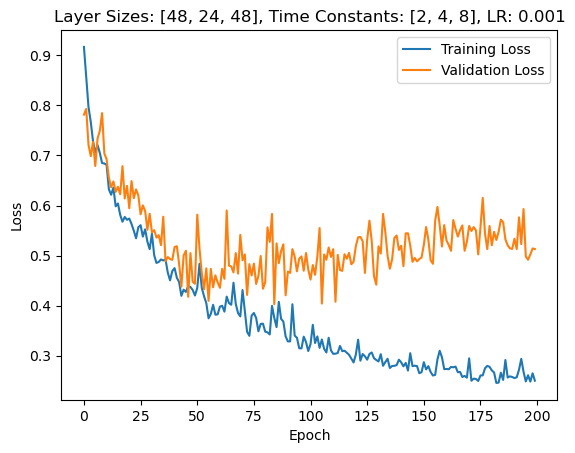

  0%|          | 1/200 [00:14<49:22, 14.89s/it]

Epoch 1/200, Training Loss: 1.0040936357570145, Validation Loss: 0.8737735322543553


  1%|          | 2/200 [00:29<47:54, 14.52s/it]

Epoch 2/200, Training Loss: 0.968586692270243, Validation Loss: 0.8215641549655369


  2%|▏         | 3/200 [00:43<47:42, 14.53s/it]

Epoch 3/200, Training Loss: 0.8810641788086802, Validation Loss: 0.7636942565441132


  2%|▏         | 4/200 [00:56<45:43, 14.00s/it]

Epoch 4/200, Training Loss: 0.859196310898043, Validation Loss: 0.7157766435827527


  2%|▎         | 5/200 [01:10<45:23, 13.96s/it]

Epoch 5/200, Training Loss: 0.8338485034006946, Validation Loss: 0.7744314329964774


  3%|▎         | 6/200 [01:26<46:55, 14.51s/it]

Epoch 6/200, Training Loss: 0.8127552979397323, Validation Loss: 0.7259154234613691


  4%|▎         | 7/200 [01:41<46:56, 14.59s/it]

Epoch 7/200, Training Loss: 0.7804840881869478, Validation Loss: 0.8071198357003075


  4%|▍         | 8/200 [01:56<47:11, 14.75s/it]

Epoch 8/200, Training Loss: 0.761438620540331, Validation Loss: 0.7613963591200965


  4%|▍         | 9/200 [02:11<47:25, 14.90s/it]

Epoch 9/200, Training Loss: 0.7471516638431909, Validation Loss: 0.7527548798492977


  5%|▌         | 10/200 [02:25<46:51, 14.80s/it]

Epoch 10/200, Training Loss: 0.7451360101969737, Validation Loss: 0.7007318330662591


  6%|▌         | 11/200 [02:40<46:29, 14.76s/it]

Epoch 11/200, Training Loss: 0.7254229530973254, Validation Loss: 0.7119826546737126


  6%|▌         | 12/200 [02:55<46:08, 14.73s/it]

Epoch 12/200, Training Loss: 0.7200383465245085, Validation Loss: 0.6878013823713575


  6%|▋         | 13/200 [03:09<45:16, 14.53s/it]

Epoch 13/200, Training Loss: 0.7079144963678324, Validation Loss: 0.6889472071613584


  7%|▋         | 14/200 [03:24<45:21, 14.63s/it]

Epoch 14/200, Training Loss: 0.6987280564488105, Validation Loss: 0.686877082501139


  8%|▊         | 15/200 [03:39<45:31, 14.76s/it]

Epoch 15/200, Training Loss: 0.6808832355265347, Validation Loss: 0.6818859215293612


  8%|▊         | 16/200 [03:52<43:57, 14.34s/it]

Epoch 16/200, Training Loss: 0.6687679633779345, Validation Loss: 0.6810139843395778


  8%|▊         | 17/200 [04:06<43:20, 14.21s/it]

Epoch 17/200, Training Loss: 0.6710432784737281, Validation Loss: 0.672995354448046


  9%|▉         | 18/200 [04:20<42:26, 13.99s/it]

Epoch 18/200, Training Loss: 0.6644230586177898, Validation Loss: 0.6897655172007424


 10%|▉         | 19/200 [04:34<42:29, 14.09s/it]

Epoch 19/200, Training Loss: 0.6546512853424504, Validation Loss: 0.6940861344337463


 10%|█         | 20/200 [04:49<42:44, 14.25s/it]

Epoch 20/200, Training Loss: 0.6515076801461993, Validation Loss: 0.6973649997796331


 10%|█         | 21/200 [05:02<41:57, 14.07s/it]

Epoch 21/200, Training Loss: 0.6730374350862683, Validation Loss: 0.66543162720544


 11%|█         | 22/200 [05:16<41:43, 14.07s/it]

Epoch 22/200, Training Loss: 0.6531442049539314, Validation Loss: 0.7327723332813808


 12%|█▏        | 23/200 [05:31<41:53, 14.20s/it]

Epoch 23/200, Training Loss: 0.6442231749588588, Validation Loss: 0.6883464242730822


 12%|█▏        | 24/200 [05:45<41:20, 14.09s/it]

Epoch 24/200, Training Loss: 0.6263927817344666, Validation Loss: 0.6524484285286495


 12%|█▎        | 25/200 [05:58<40:56, 14.04s/it]

Epoch 25/200, Training Loss: 0.6453543198558519, Validation Loss: 0.6781819249902453


 13%|█▎        | 26/200 [06:12<40:24, 13.93s/it]

Epoch 26/200, Training Loss: 0.6262119637345368, Validation Loss: 0.6469136306217739


 14%|█▎        | 27/200 [06:26<40:07, 13.92s/it]

Epoch 27/200, Training Loss: 0.6363323775102507, Validation Loss: 0.6684114741427558


 14%|█▍        | 28/200 [06:40<40:05, 13.98s/it]

Epoch 28/200, Training Loss: 0.6291507741190353, Validation Loss: 0.6592722300972257


 14%|█▍        | 29/200 [06:54<39:41, 13.93s/it]

Epoch 29/200, Training Loss: 0.6198445952163553, Validation Loss: 0.6654267864567893


 15%|█▌        | 30/200 [07:08<39:38, 13.99s/it]

Epoch 30/200, Training Loss: 0.6103997747853117, Validation Loss: 0.6502298308270318


 16%|█▌        | 31/200 [07:22<39:32, 14.04s/it]

Epoch 31/200, Training Loss: 0.6448649432299272, Validation Loss: 0.6525635016816003


 16%|█▌        | 32/200 [07:37<39:58, 14.28s/it]

Epoch 32/200, Training Loss: 0.6227413185362546, Validation Loss: 0.6413266286253929


 16%|█▋        | 33/200 [07:51<39:29, 14.19s/it]

Epoch 33/200, Training Loss: 0.6067791075076697, Validation Loss: 0.6309725152594703


 17%|█▋        | 34/200 [08:05<38:49, 14.03s/it]

Epoch 34/200, Training Loss: 0.6300402874091886, Validation Loss: 0.6354683435388974


 18%|█▊        | 35/200 [08:19<39:03, 14.20s/it]

Epoch 35/200, Training Loss: 0.5912610466750163, Validation Loss: 0.6055689666952405


 18%|█▊        | 36/200 [08:34<38:46, 14.19s/it]

Epoch 36/200, Training Loss: 0.6134806629621757, Validation Loss: 0.6506626563412803


 18%|█▊        | 37/200 [08:47<38:05, 14.02s/it]

Epoch 37/200, Training Loss: 0.5981832562752489, Validation Loss: 0.6471172007066863


 19%|█▉        | 38/200 [09:01<37:36, 13.93s/it]

Epoch 38/200, Training Loss: 0.6127879906375453, Validation Loss: 0.6371521726250648


 20%|█▉        | 39/200 [09:15<37:16, 13.89s/it]

Epoch 39/200, Training Loss: 0.6128240750645692, Validation Loss: 0.6435985458748681


 20%|██        | 40/200 [09:28<36:51, 13.82s/it]

Epoch 40/200, Training Loss: 0.5821004088194865, Validation Loss: 0.6217906778412206


 20%|██        | 41/200 [09:42<36:38, 13.83s/it]

Epoch 41/200, Training Loss: 0.6077465206946967, Validation Loss: 0.6215976508600372


 21%|██        | 42/200 [09:56<36:18, 13.79s/it]

Epoch 42/200, Training Loss: 0.5817580566091357, Validation Loss: 0.6115989003862653


 22%|██▏       | 43/200 [10:10<36:20, 13.89s/it]

Epoch 43/200, Training Loss: 0.5830091496683517, Validation Loss: 0.6166007093020848


 22%|██▏       | 44/200 [10:25<36:54, 14.19s/it]

Epoch 44/200, Training Loss: 0.5730028810366145, Validation Loss: 0.63608632343156


 22%|██▎       | 45/200 [10:39<36:18, 14.05s/it]

Epoch 45/200, Training Loss: 0.6105436097900823, Validation Loss: 0.6263905933925084


 23%|██▎       | 46/200 [10:53<36:15, 14.13s/it]

Epoch 46/200, Training Loss: 0.5779772108455874, Validation Loss: 0.609275400106396


 24%|██▎       | 47/200 [11:08<36:55, 14.48s/it]

Epoch 47/200, Training Loss: 0.5882279364005575, Validation Loss: 0.6722065566905907


 24%|██▍       | 48/200 [11:22<36:10, 14.28s/it]

Epoch 48/200, Training Loss: 0.587157982700276, Validation Loss: 0.6278581299952098


 24%|██▍       | 49/200 [11:36<35:31, 14.12s/it]

Epoch 49/200, Training Loss: 0.5684247556722389, Validation Loss: 0.6385763990027564


 25%|██▌       | 50/200 [11:50<35:03, 14.02s/it]

Epoch 50/200, Training Loss: 0.5732222008255293, Validation Loss: 0.6116425639816693


 26%|██▌       | 51/200 [12:03<34:34, 13.92s/it]

Epoch 51/200, Training Loss: 0.5748154262326798, Validation Loss: 0.5957190921264035


 26%|██▌       | 52/200 [12:17<34:13, 13.87s/it]

Epoch 52/200, Training Loss: 0.5927615311910521, Validation Loss: 0.6701012030243874


 26%|██▋       | 53/200 [12:31<33:53, 13.83s/it]

Epoch 53/200, Training Loss: 0.5803791655684417, Validation Loss: 0.6099815262215478


 27%|██▋       | 54/200 [12:44<33:26, 13.74s/it]

Epoch 54/200, Training Loss: 0.5729580206691094, Validation Loss: 0.6273877599409649


 28%|██▊       | 55/200 [12:59<33:45, 13.97s/it]

Epoch 55/200, Training Loss: 0.5658274017414957, Validation Loss: 0.6073478151644979


 28%|██▊       | 56/200 [13:13<33:49, 14.09s/it]

Epoch 56/200, Training Loss: 0.5624239720263571, Validation Loss: 0.6749786958098412


 28%|██▊       | 57/200 [13:27<33:18, 13.97s/it]

Epoch 57/200, Training Loss: 0.5700294785904434, Validation Loss: 0.6187069990805217


 29%|██▉       | 58/200 [13:41<33:09, 14.01s/it]

Epoch 58/200, Training Loss: 0.5624018390223665, Validation Loss: 0.5994490289262363


 30%|██▉       | 59/200 [13:55<33:16, 14.16s/it]

Epoch 59/200, Training Loss: 0.5566043477013426, Validation Loss: 0.6093740782567433


 30%|███       | 60/200 [14:09<32:49, 14.06s/it]

Epoch 60/200, Training Loss: 0.5495491286493698, Validation Loss: 0.6188420738492694


 30%|███       | 61/200 [14:23<32:34, 14.06s/it]

Epoch 61/200, Training Loss: 0.5524204901929172, Validation Loss: 0.6372444054910115


 31%|███       | 62/200 [14:37<32:00, 13.92s/it]

Epoch 62/200, Training Loss: 0.5531514821187505, Validation Loss: 0.625327647796699


 32%|███▏      | 63/200 [14:51<31:42, 13.89s/it]

Epoch 63/200, Training Loss: 0.5531837479123529, Validation Loss: 0.6174311265349388


 32%|███▏      | 64/200 [15:05<31:29, 13.89s/it]

Epoch 64/200, Training Loss: 0.5619848128759636, Validation Loss: 0.5979803630283901


 32%|███▎      | 65/200 [15:18<30:58, 13.77s/it]

Epoch 65/200, Training Loss: 0.5412718653678894, Validation Loss: 0.6293803783399718


 33%|███▎      | 66/200 [15:33<31:09, 13.95s/it]

Epoch 66/200, Training Loss: 0.5491477532206841, Validation Loss: 0.6018570810556412


 34%|███▎      | 67/200 [15:47<31:22, 14.15s/it]

Epoch 67/200, Training Loss: 0.5642011699811468, Validation Loss: 0.6166095840079444


 34%|███▍      | 68/200 [16:02<31:43, 14.42s/it]

Epoch 68/200, Training Loss: 0.5447947484142376, Validation Loss: 0.634969704917499


 34%|███▍      | 69/200 [16:17<31:32, 14.45s/it]

Epoch 69/200, Training Loss: 0.5391306922120868, Validation Loss: 0.6204920645271029


 35%|███▌      | 70/200 [16:31<31:03, 14.34s/it]

Epoch 70/200, Training Loss: 0.5273826245991688, Validation Loss: 0.599250353872776


 36%|███▌      | 71/200 [16:46<31:26, 14.62s/it]

Epoch 71/200, Training Loss: 0.5432601846613974, Validation Loss: 0.6126481837459973


 36%|███▌      | 72/200 [17:01<31:16, 14.66s/it]

Epoch 72/200, Training Loss: 0.5383830649672814, Validation Loss: 0.5983949420707566


 36%|███▋      | 73/200 [17:15<30:46, 14.54s/it]

Epoch 73/200, Training Loss: 0.5381398215046469, Validation Loss: 0.6274485705154282


 37%|███▋      | 74/200 [17:30<30:30, 14.52s/it]

Epoch 74/200, Training Loss: 0.5533893766268244, Validation Loss: 0.6732566399233681


 38%|███▊      | 75/200 [17:44<30:16, 14.54s/it]

Epoch 75/200, Training Loss: 0.5332947530836429, Validation Loss: 0.5938109031745366


 38%|███▊      | 76/200 [17:58<29:50, 14.44s/it]

Epoch 76/200, Training Loss: 0.5570821863300396, Validation Loss: 0.5955450023923602


 38%|███▊      | 77/200 [18:13<29:42, 14.49s/it]

Epoch 77/200, Training Loss: 0.5319312293574495, Validation Loss: 0.6013230617557254


 39%|███▉      | 78/200 [18:27<29:20, 14.43s/it]

Epoch 78/200, Training Loss: 0.532304047413592, Validation Loss: 0.5827913752623967


 40%|███▉      | 79/200 [18:42<29:32, 14.65s/it]

Epoch 79/200, Training Loss: 0.534363937827776, Validation Loss: 0.6004977758441653


 40%|████      | 80/200 [18:58<29:37, 14.81s/it]

Epoch 80/200, Training Loss: 0.5235095473955262, Validation Loss: 0.6198391914367676


 40%|████      | 81/200 [19:12<29:22, 14.81s/it]

Epoch 81/200, Training Loss: 0.5229589708571164, Validation Loss: 0.5947109897221837


 41%|████      | 82/200 [19:27<28:59, 14.74s/it]

Epoch 82/200, Training Loss: 0.5167988409411233, Validation Loss: 0.5960290964160647


 42%|████▏     | 83/200 [19:42<28:53, 14.82s/it]

Epoch 83/200, Training Loss: 0.5166730714856453, Validation Loss: 0.5962688273617199


 42%|████▏     | 84/200 [19:56<28:19, 14.65s/it]

Epoch 84/200, Training Loss: 0.5151916579255518, Validation Loss: 0.5904821540628161


 42%|████▎     | 85/200 [20:11<28:00, 14.61s/it]

Epoch 85/200, Training Loss: 0.5163577024666768, Validation Loss: 0.6079991289547512


 43%|████▎     | 86/200 [20:25<27:28, 14.46s/it]

Epoch 86/200, Training Loss: 0.5270825076215672, Validation Loss: 0.5721985208136695


 44%|████▎     | 87/200 [20:39<27:01, 14.35s/it]

Epoch 87/200, Training Loss: 0.5187699609207657, Validation Loss: 0.582244193979672


 44%|████▍     | 88/200 [20:54<26:55, 14.43s/it]

Epoch 88/200, Training Loss: 0.5153694124716632, Validation Loss: 0.5855361744761467


 44%|████▍     | 89/200 [21:08<26:28, 14.31s/it]

Epoch 89/200, Training Loss: 0.5152714398671996, Validation Loss: 0.5634898341127804


 45%|████▌     | 90/200 [21:22<26:11, 14.29s/it]

Epoch 90/200, Training Loss: 0.5184359454883719, Validation Loss: 0.5957023096936089


 46%|████▌     | 91/200 [21:37<26:15, 14.45s/it]

Epoch 91/200, Training Loss: 0.5089780199077895, Validation Loss: 0.5665104697857585


 46%|████▌     | 92/200 [21:51<25:53, 14.39s/it]

Epoch 92/200, Training Loss: 0.5142544648557339, Validation Loss: 0.5606144368648529


 46%|████▋     | 93/200 [22:05<25:19, 14.20s/it]

Epoch 93/200, Training Loss: 0.5185027330551507, Validation Loss: 0.5678241987313543


 47%|████▋     | 94/200 [22:18<24:36, 13.93s/it]

Epoch 94/200, Training Loss: 0.5141836416046575, Validation Loss: 0.5900836778538567


 48%|████▊     | 95/200 [22:32<24:28, 13.99s/it]

Epoch 95/200, Training Loss: 0.5075869515257062, Validation Loss: 0.572378759937627


 48%|████▊     | 96/200 [22:46<24:11, 13.96s/it]

Epoch 96/200, Training Loss: 0.5095096860291823, Validation Loss: 0.5814382018787521


 48%|████▊     | 97/200 [22:59<23:41, 13.80s/it]

Epoch 97/200, Training Loss: 0.500371848074895, Validation Loss: 0.5830008313059807


 49%|████▉     | 98/200 [23:13<23:17, 13.70s/it]

Epoch 98/200, Training Loss: 0.49616008856386506, Validation Loss: 0.6327357196382114


 50%|████▉     | 99/200 [23:27<23:09, 13.76s/it]

Epoch 99/200, Training Loss: 0.5033579626173343, Validation Loss: 0.5975708376084056


 50%|█████     | 100/200 [23:40<22:39, 13.60s/it]

Epoch 100/200, Training Loss: 0.4922085241326746, Validation Loss: 0.5756623116987092


 50%|█████     | 101/200 [23:53<22:15, 13.49s/it]

Epoch 101/200, Training Loss: 0.5171621053848626, Validation Loss: 0.5625430728707995


 51%|█████     | 102/200 [24:07<22:02, 13.50s/it]

Epoch 102/200, Training Loss: 0.4994180070341758, Validation Loss: 0.5699940228036472


 52%|█████▏    | 103/200 [24:20<21:49, 13.50s/it]

Epoch 103/200, Training Loss: 0.5032638615032412, Validation Loss: 0.5907535542334829


 52%|█████▏    | 104/200 [24:34<21:51, 13.66s/it]

Epoch 104/200, Training Loss: 0.5037420262705605, Validation Loss: 0.5784782309617315


 52%|█████▎    | 105/200 [24:48<21:31, 13.59s/it]

Epoch 105/200, Training Loss: 0.48769658297862645, Validation Loss: 0.5693816553269114


 53%|█████▎    | 106/200 [25:01<21:09, 13.51s/it]

Epoch 106/200, Training Loss: 0.5029697182043543, Validation Loss: 0.5714177766016552


 54%|█████▎    | 107/200 [25:15<20:58, 13.54s/it]

Epoch 107/200, Training Loss: 0.4900790613214925, Validation Loss: 0.5670894607901573


 54%|█████▍    | 108/200 [25:29<21:02, 13.72s/it]

Epoch 108/200, Training Loss: 0.48755891958497605, Validation Loss: 0.569548239665372


 55%|█████▍    | 109/200 [25:42<20:41, 13.64s/it]

Epoch 109/200, Training Loss: 0.4983392301595436, Validation Loss: 0.5729852552924838


 55%|█████▌    | 110/200 [25:56<20:25, 13.61s/it]

Epoch 110/200, Training Loss: 0.4943738391376891, Validation Loss: 0.5727914720773697


 56%|█████▌    | 111/200 [26:09<20:04, 13.54s/it]

Epoch 111/200, Training Loss: 0.48253697606752505, Validation Loss: 0.5567074066826275


 56%|█████▌    | 112/200 [26:23<19:48, 13.50s/it]

Epoch 112/200, Training Loss: 0.49199800896194745, Validation Loss: 0.5605531132646969


 56%|█████▋    | 113/200 [26:36<19:32, 13.48s/it]

Epoch 113/200, Training Loss: 0.4896678885198989, Validation Loss: 0.5797132062060493


 57%|█████▋    | 114/200 [26:49<19:14, 13.42s/it]

Epoch 114/200, Training Loss: 0.48829768823002867, Validation Loss: 0.5592964099986213


 57%|█████▊    | 115/200 [27:03<19:01, 13.43s/it]

Epoch 115/200, Training Loss: 0.4844782147205101, Validation Loss: 0.5649888579334531


 58%|█████▊    | 116/200 [27:16<18:51, 13.47s/it]

Epoch 116/200, Training Loss: 0.4819500946773673, Validation Loss: 0.5873183054583413


 58%|█████▊    | 117/200 [27:30<18:51, 13.64s/it]

Epoch 117/200, Training Loss: 0.4854953303089682, Validation Loss: 0.5787664513502803


 59%|█████▉    | 118/200 [27:44<18:30, 13.55s/it]

Epoch 118/200, Training Loss: 0.4760050559943577, Validation Loss: 0.5918602613466126


 60%|█████▉    | 119/200 [27:58<18:44, 13.89s/it]

Epoch 119/200, Training Loss: 0.48189066997114216, Validation Loss: 0.5891193609152522


 60%|██████    | 120/200 [28:14<19:02, 14.28s/it]

Epoch 120/200, Training Loss: 0.47611850275183626, Validation Loss: 0.5757263707263129


 60%|██████    | 121/200 [28:29<19:11, 14.58s/it]

Epoch 121/200, Training Loss: 0.47009524056371654, Validation Loss: 0.586183467081615


 61%|██████    | 122/200 [28:43<18:52, 14.52s/it]

Epoch 122/200, Training Loss: 0.47170842987186506, Validation Loss: 0.580728543656213


 62%|██████▏   | 123/200 [28:57<18:27, 14.38s/it]

Epoch 123/200, Training Loss: 0.4883494461482426, Validation Loss: 0.5805137242589679


 62%|██████▏   | 124/200 [29:12<18:12, 14.38s/it]

Epoch 124/200, Training Loss: 0.48463328604428274, Validation Loss: 0.597807418022837


 62%|██████▎   | 125/200 [29:26<17:54, 14.33s/it]

Epoch 125/200, Training Loss: 0.48013585440392764, Validation Loss: 0.5907104696546283


 63%|██████▎   | 126/200 [29:40<17:36, 14.27s/it]

Epoch 126/200, Training Loss: 0.46697150648764846, Validation Loss: 0.5750283960785184


 64%|██████▎   | 127/200 [29:55<17:26, 14.34s/it]

Epoch 127/200, Training Loss: 0.4767044296242156, Validation Loss: 0.5820779076644352


 64%|██████▍   | 128/200 [30:09<17:09, 14.30s/it]

Epoch 128/200, Training Loss: 0.47434780198448107, Validation Loss: 0.6182220578193665


 64%|██████▍   | 129/200 [30:24<17:07, 14.48s/it]

Epoch 129/200, Training Loss: 0.46703097955235895, Validation Loss: 0.5773089187485831


 65%|██████▌   | 130/200 [30:39<17:18, 14.83s/it]

Epoch 130/200, Training Loss: 0.46297343665698787, Validation Loss: 0.58957239985466


 66%|██████▌   | 131/200 [30:53<16:49, 14.62s/it]

Epoch 131/200, Training Loss: 0.45507531683399993, Validation Loss: 0.6165016442537308


 66%|██████▌   | 132/200 [31:08<16:31, 14.58s/it]

Epoch 132/200, Training Loss: 0.46505112046340724, Validation Loss: 0.5925915571195739


 66%|██████▋   | 133/200 [31:23<16:28, 14.75s/it]

Epoch 133/200, Training Loss: 0.4568047152375275, Validation Loss: 0.5855717307754925


 67%|██████▋   | 134/200 [31:37<16:02, 14.59s/it]

Epoch 134/200, Training Loss: 0.4605750168831843, Validation Loss: 0.5915930079562324


 68%|██████▊   | 135/200 [31:52<15:44, 14.53s/it]

Epoch 135/200, Training Loss: 0.4536055036873188, Validation Loss: 0.5787614328520638


 68%|██████▊   | 136/200 [32:06<15:19, 14.37s/it]

Epoch 136/200, Training Loss: 0.4591884258783089, Validation Loss: 0.5935966915317944


 68%|██████▊   | 137/200 [32:20<15:03, 14.34s/it]

Epoch 137/200, Training Loss: 0.44729723233097, Validation Loss: 0.5960674328463418


 69%|██████▉   | 138/200 [32:34<14:48, 14.33s/it]

Epoch 138/200, Training Loss: 0.46404962705553704, Validation Loss: 0.5985544600657055


 70%|██████▉   | 139/200 [32:48<14:31, 14.28s/it]

Epoch 139/200, Training Loss: 0.45994745757219924, Validation Loss: 0.5803606935909816


 70%|███████   | 140/200 [33:03<14:20, 14.35s/it]

Epoch 140/200, Training Loss: 0.4551334080268752, Validation Loss: 0.558992053781237


 70%|███████   | 141/200 [33:18<14:19, 14.56s/it]

Epoch 141/200, Training Loss: 0.45357543117595167, Validation Loss: 0.58608578145504


 71%|███████   | 142/200 [33:33<14:08, 14.63s/it]

Epoch 142/200, Training Loss: 0.45902050328704547, Validation Loss: 0.5909681522420475


 72%|███████▏  | 143/200 [33:47<13:54, 14.64s/it]

Epoch 143/200, Training Loss: 0.4584444761276245, Validation Loss: 0.5802111136061805


 72%|███████▏  | 144/200 [34:02<13:30, 14.48s/it]

Epoch 144/200, Training Loss: 0.4536884491736034, Validation Loss: 0.5864294650299209


 72%|███████▎  | 145/200 [34:17<13:27, 14.69s/it]

Epoch 145/200, Training Loss: 0.45528699879376394, Validation Loss: 0.5708570735795158


 73%|███████▎  | 146/200 [34:32<13:17, 14.76s/it]

Epoch 146/200, Training Loss: 0.4725347734847159, Validation Loss: 0.5940880924463272


 74%|███████▎  | 147/200 [34:46<12:58, 14.68s/it]

Epoch 147/200, Training Loss: 0.4465960773094645, Validation Loss: 0.595362870820931


 74%|███████▍  | 148/200 [35:01<12:41, 14.64s/it]

Epoch 148/200, Training Loss: 0.44815619093067244, Validation Loss: 0.5845411100557872


 74%|███████▍  | 149/200 [35:15<12:23, 14.57s/it]

Epoch 149/200, Training Loss: 0.45762940060417606, Validation Loss: 0.5686643144914082


 75%|███████▌  | 150/200 [35:30<12:13, 14.66s/it]

Epoch 150/200, Training Loss: 0.44867861552058524, Validation Loss: 0.574341241802488


 76%|███████▌  | 151/200 [35:45<11:58, 14.66s/it]

Epoch 151/200, Training Loss: 0.44325032970815337, Validation Loss: 0.5701080624546323


 76%|███████▌  | 152/200 [35:59<11:40, 14.60s/it]

Epoch 152/200, Training Loss: 0.44710028002846913, Validation Loss: 0.5587593263813427


 76%|███████▋  | 153/200 [36:14<11:28, 14.64s/it]

Epoch 153/200, Training Loss: 0.45226826307908546, Validation Loss: 0.5753357814890998


 77%|███████▋  | 154/200 [36:29<11:14, 14.67s/it]

Epoch 154/200, Training Loss: 0.45053249850588023, Validation Loss: 0.5998931740011487


 78%|███████▊  | 155/200 [36:42<10:50, 14.45s/it]

Epoch 155/200, Training Loss: 0.4419703958731777, Validation Loss: 0.5793571323156357


 78%|███████▊  | 156/200 [36:56<10:28, 14.28s/it]

Epoch 156/200, Training Loss: 0.4381210028000598, Validation Loss: 0.5608459466270038


 78%|███████▊  | 157/200 [37:11<10:23, 14.50s/it]

Epoch 157/200, Training Loss: 0.43767030389522604, Validation Loss: 0.5742558336683682


 79%|███████▉  | 158/200 [37:26<10:05, 14.41s/it]

Epoch 158/200, Training Loss: 0.43957712009267985, Validation Loss: 0.5725035103304046


 80%|███████▉  | 159/200 [37:40<09:45, 14.29s/it]

Epoch 159/200, Training Loss: 0.4428853724362715, Validation Loss: 0.5788995123335293


 80%|████████  | 160/200 [37:53<09:26, 14.17s/it]

Epoch 160/200, Training Loss: 0.4453661087548958, Validation Loss: 0.5684596374630928


 80%|████████  | 161/200 [38:07<09:06, 14.02s/it]

Epoch 161/200, Training Loss: 0.44035067957527235, Validation Loss: 0.5876517998320716


 81%|████████  | 162/200 [38:21<08:56, 14.13s/it]

Epoch 162/200, Training Loss: 0.4485433821408254, Validation Loss: 0.5766108142478126


 82%|████████▏ | 163/200 [38:35<08:37, 13.98s/it]

Epoch 163/200, Training Loss: 0.4559520553305464, Validation Loss: 0.5683669362749372


 82%|████████▏ | 164/200 [38:49<08:19, 13.89s/it]

Epoch 164/200, Training Loss: 0.442732720161384, Validation Loss: 0.5757932694894927


 82%|████████▎ | 165/200 [39:03<08:14, 14.12s/it]

Epoch 165/200, Training Loss: 0.4351304114427207, Validation Loss: 0.5553111976810864


 83%|████████▎ | 166/200 [39:18<08:08, 14.36s/it]

Epoch 166/200, Training Loss: 0.429562102792398, Validation Loss: 0.5889318010636738


 84%|████████▎ | 167/200 [39:32<07:47, 14.17s/it]

Epoch 167/200, Training Loss: 0.43118840568470507, Validation Loss: 0.5648089945316315


 84%|████████▍ | 168/200 [39:46<07:31, 14.10s/it]

Epoch 168/200, Training Loss: 0.42645776721666445, Validation Loss: 0.5816842083420072


 84%|████████▍ | 169/200 [40:01<07:22, 14.29s/it]

Epoch 169/200, Training Loss: 0.43476219194115334, Validation Loss: 0.5814569858568055


 85%|████████▌ | 170/200 [40:15<07:08, 14.29s/it]

Epoch 170/200, Training Loss: 0.4298860287328936, Validation Loss: 0.5680059492588043


 86%|████████▌ | 171/200 [40:29<06:53, 14.26s/it]

Epoch 171/200, Training Loss: 0.43505660599132756, Validation Loss: 0.556935265660286


 86%|████████▌ | 172/200 [40:43<06:34, 14.09s/it]

Epoch 172/200, Training Loss: 0.42890559418021507, Validation Loss: 0.5713987361107554


 86%|████████▋ | 173/200 [40:57<06:20, 14.11s/it]

Epoch 173/200, Training Loss: 0.4257397373329918, Validation Loss: 0.5626189900296075


 87%|████████▋ | 174/200 [41:11<06:04, 14.03s/it]

Epoch 174/200, Training Loss: 0.4246373066924653, Validation Loss: 0.5422207745058196


 88%|████████▊ | 175/200 [41:25<05:49, 13.98s/it]

Epoch 175/200, Training Loss: 0.4254055470228195, Validation Loss: 0.5653030329516956


 88%|████████▊ | 176/200 [41:39<05:36, 14.01s/it]

Epoch 176/200, Training Loss: 0.42377980700079, Validation Loss: 0.5575967910034316


 88%|████████▊ | 177/200 [41:53<05:25, 14.17s/it]

Epoch 177/200, Training Loss: 0.4239881561612183, Validation Loss: 0.5573773139289447


 89%|████████▉ | 178/200 [42:08<05:13, 14.25s/it]

Epoch 178/200, Training Loss: 0.42731315516075996, Validation Loss: 0.5700893327593803


 90%|████████▉ | 179/200 [42:22<04:58, 14.23s/it]

Epoch 179/200, Training Loss: 0.4290750470926177, Validation Loss: 0.5655970605356353


 90%|█████████ | 180/200 [42:36<04:42, 14.10s/it]

Epoch 180/200, Training Loss: 0.43152664236302646, Validation Loss: 0.5637571098549026


 90%|█████████ | 181/200 [42:50<04:30, 14.24s/it]

Epoch 181/200, Training Loss: 0.41741419597616736, Validation Loss: 0.5715368986129761


 91%|█████████ | 182/200 [43:04<04:14, 14.15s/it]

Epoch 182/200, Training Loss: 0.42433515219193585, Validation Loss: 0.5375850488032613


 92%|█████████▏| 183/200 [43:18<03:58, 14.04s/it]

Epoch 183/200, Training Loss: 0.41505938543463655, Validation Loss: 0.5595074785607201


 92%|█████████▏| 184/200 [43:32<03:44, 14.03s/it]

Epoch 184/200, Training Loss: 0.4140242951096229, Validation Loss: 0.567064853651183


 92%|█████████▎| 185/200 [43:46<03:29, 13.99s/it]

Epoch 185/200, Training Loss: 0.416001910027468, Validation Loss: 0.5601032269852502


 93%|█████████▎| 186/200 [44:00<03:14, 13.87s/it]

Epoch 186/200, Training Loss: 0.41402669307195916, Validation Loss: 0.5595680379441806


 94%|█████████▎| 187/200 [44:14<03:03, 14.15s/it]

Epoch 187/200, Training Loss: 0.42556394158669236, Validation Loss: 0.5260049370782716


 94%|█████████▍| 188/200 [44:29<02:50, 14.18s/it]

Epoch 188/200, Training Loss: 0.4188566174147264, Validation Loss: 0.5933777796370643


 94%|█████████▍| 189/200 [44:43<02:35, 14.16s/it]

Epoch 189/200, Training Loss: 0.419381652800542, Validation Loss: 0.5622070367847171


 95%|█████████▌| 190/200 [44:58<02:23, 14.36s/it]

Epoch 190/200, Training Loss: 0.4100856915959772, Validation Loss: 0.5579205911074366


 96%|█████████▌| 191/200 [45:12<02:07, 14.21s/it]

Epoch 191/200, Training Loss: 0.41313455408474187, Validation Loss: 0.5670101429734912


 96%|█████████▌| 192/200 [45:26<01:54, 14.32s/it]

Epoch 192/200, Training Loss: 0.4116373396707031, Validation Loss: 0.5665125942655972


 96%|█████████▋| 193/200 [45:40<01:40, 14.32s/it]

Epoch 193/200, Training Loss: 0.40910866744113417, Validation Loss: 0.5227014731083598


 97%|█████████▋| 194/200 [45:54<01:25, 14.21s/it]

Epoch 194/200, Training Loss: 0.41116106875662534, Validation Loss: 0.5711495663438525


 98%|█████████▊| 195/200 [46:08<01:10, 14.17s/it]

Epoch 195/200, Training Loss: 0.43156980737200323, Validation Loss: 0.5600400556411061


 98%|█████████▊| 196/200 [46:22<00:56, 14.07s/it]

Epoch 196/200, Training Loss: 0.403272973760119, Validation Loss: 0.5656719846384866


 98%|█████████▊| 197/200 [46:36<00:42, 14.03s/it]

Epoch 197/200, Training Loss: 0.4096990112426146, Validation Loss: 0.5716409449066434


 99%|█████████▉| 198/200 [46:50<00:28, 14.06s/it]

Epoch 198/200, Training Loss: 0.41092439417569143, Validation Loss: 0.5518597875322614


100%|█████████▉| 199/200 [47:04<00:14, 14.07s/it]

Epoch 199/200, Training Loss: 0.39921740597149113, Validation Loss: 0.5592804817216737


100%|██████████| 200/200 [47:19<00:00, 14.20s/it]

Epoch 200/200, Training Loss: 0.40393522325551734, Validation Loss: 0.5444923628653798
Final Accuracy: 85.89%, Precision: 0.81, Recall: 0.94


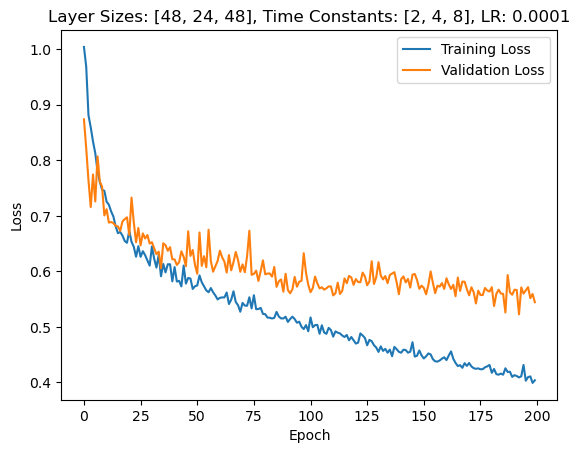

  0%|          | 1/200 [00:14<48:51, 14.73s/it]

Epoch 1/200, Training Loss: 1.0509097103802663, Validation Loss: 0.9407534429005214


  1%|          | 2/200 [00:29<47:48, 14.49s/it]

Epoch 2/200, Training Loss: 0.7734375348630941, Validation Loss: 0.679301917552948


  2%|▏         | 3/200 [00:42<46:40, 14.21s/it]

Epoch 3/200, Training Loss: 0.7130773674766973, Validation Loss: 0.6811905801296234


  2%|▏         | 4/200 [00:56<45:53, 14.05s/it]

Epoch 4/200, Training Loss: 0.6942351488572247, Validation Loss: 0.6172647050448826


  2%|▎         | 5/200 [01:11<46:10, 14.21s/it]

Epoch 5/200, Training Loss: 0.6325027518114954, Validation Loss: 0.6210997040782656


  3%|▎         | 6/200 [01:26<46:54, 14.51s/it]

Epoch 6/200, Training Loss: 0.5986325667714173, Validation Loss: 0.624624925000327


  4%|▎         | 7/200 [01:40<46:42, 14.52s/it]

Epoch 7/200, Training Loss: 0.5629178988483717, Validation Loss: 0.5391155311039516


  4%|▍         | 8/200 [01:55<46:20, 14.48s/it]

Epoch 8/200, Training Loss: 0.6400086992191818, Validation Loss: 0.6032725444861821


  4%|▍         | 9/200 [02:10<46:51, 14.72s/it]

Epoch 9/200, Training Loss: 0.6060026304901771, Validation Loss: 0.629400087254388


  5%|▌         | 10/200 [02:24<46:13, 14.60s/it]

Epoch 10/200, Training Loss: 0.5521816645028457, Validation Loss: 0.5382176424775805


  6%|▌         | 11/200 [02:38<45:08, 14.33s/it]

Epoch 11/200, Training Loss: 0.5620059666206252, Validation Loss: 0.5538314666066851


  6%|▌         | 12/200 [02:52<44:30, 14.20s/it]

Epoch 12/200, Training Loss: 0.525230384097909, Validation Loss: 0.5468634111540658


  6%|▋         | 13/200 [03:06<44:30, 14.28s/it]

Epoch 13/200, Training Loss: 0.5032809511670526, Validation Loss: 0.5384400061198643


  7%|▋         | 14/200 [03:21<44:18, 14.29s/it]

Epoch 14/200, Training Loss: 0.5029612551882582, Validation Loss: 0.5309270513909203


  8%|▊         | 15/200 [03:34<43:28, 14.10s/it]

Epoch 15/200, Training Loss: 0.5017261260522986, Validation Loss: 0.478108959538596


  8%|▊         | 16/200 [03:48<42:49, 13.96s/it]

Epoch 16/200, Training Loss: 0.4947438304716686, Validation Loss: 0.498718512909753


  8%|▊         | 17/200 [04:03<43:05, 14.13s/it]

Epoch 17/200, Training Loss: 0.49347293067653225, Validation Loss: 0.5490477894033704


  9%|▉         | 18/200 [04:17<42:59, 14.17s/it]

Epoch 18/200, Training Loss: 0.5165397974680055, Validation Loss: 0.5624463898794991


 10%|▉         | 19/200 [04:30<42:12, 13.99s/it]

Epoch 19/200, Training Loss: 0.4946545767334272, Validation Loss: 0.5008913619177682


 10%|█         | 20/200 [04:45<42:05, 14.03s/it]

Epoch 20/200, Training Loss: 0.4798296628133306, Validation Loss: 0.4647860505751201


 10%|█         | 21/200 [04:59<42:07, 14.12s/it]

Epoch 21/200, Training Loss: 0.49589679657288316, Validation Loss: 0.6307841667107174


 11%|█         | 22/200 [05:12<41:25, 13.96s/it]

Epoch 22/200, Training Loss: 0.51592200600876, Validation Loss: 0.4982391893863678


 12%|█▏        | 23/200 [05:26<41:15, 13.98s/it]

Epoch 23/200, Training Loss: 0.5320243916983874, Validation Loss: 0.5641142087323325


 12%|█▏        | 24/200 [05:40<40:37, 13.85s/it]

Epoch 24/200, Training Loss: 0.5200736744786209, Validation Loss: 0.49376966059207916


 12%|█▎        | 25/200 [05:54<40:20, 13.83s/it]

Epoch 25/200, Training Loss: 0.4687012459309596, Validation Loss: 0.4993416028363364


 13%|█▎        | 26/200 [06:08<40:16, 13.89s/it]

Epoch 26/200, Training Loss: 0.47260388282110105, Validation Loss: 0.4459195477621896


 14%|█▎        | 27/200 [06:21<39:46, 13.80s/it]

Epoch 27/200, Training Loss: 0.43790500343970534, Validation Loss: 0.4742718849863325


 14%|█▍        | 28/200 [06:35<39:39, 13.83s/it]

Epoch 28/200, Training Loss: 0.49212750623810964, Validation Loss: 0.5721802785992622


 14%|█▍        | 29/200 [06:49<39:35, 13.89s/it]

Epoch 29/200, Training Loss: 0.48698697731180013, Validation Loss: 0.46153358689376284


 15%|█▌        | 30/200 [07:04<39:43, 14.02s/it]

Epoch 30/200, Training Loss: 0.4183517798500241, Validation Loss: 0.46309993522507803


 16%|█▌        | 31/200 [07:18<39:44, 14.11s/it]

Epoch 31/200, Training Loss: 0.44971103994351513, Validation Loss: 0.45330881220953806


 16%|█▌        | 32/200 [07:32<39:36, 14.15s/it]

Epoch 32/200, Training Loss: 0.5312277250132471, Validation Loss: 0.5243381751435143


 16%|█▋        | 33/200 [07:47<39:31, 14.20s/it]

Epoch 33/200, Training Loss: 0.4703963668841236, Validation Loss: 0.5013591540711266


 17%|█▋        | 34/200 [08:01<39:50, 14.40s/it]

Epoch 34/200, Training Loss: 0.4298363094622234, Validation Loss: 0.4433422940117972


 18%|█▊        | 35/200 [08:15<39:07, 14.23s/it]

Epoch 35/200, Training Loss: 0.4087110167404391, Validation Loss: 0.499777615070343


 18%|█▊        | 36/200 [08:29<38:28, 14.07s/it]

Epoch 36/200, Training Loss: 0.4338747223593154, Validation Loss: 0.5433865679161889


 18%|█▊        | 37/200 [08:43<38:13, 14.07s/it]

Epoch 37/200, Training Loss: 0.48827007637833647, Validation Loss: 0.5223514884710312


 19%|█▉        | 38/200 [08:57<37:35, 13.93s/it]

Epoch 38/200, Training Loss: 0.45576186225099385, Validation Loss: 0.44198468753269743


 20%|█▉        | 39/200 [09:10<37:10, 13.86s/it]

Epoch 39/200, Training Loss: 0.4058923884382788, Validation Loss: 0.4542699583939144


 20%|██        | 40/200 [09:25<37:14, 13.97s/it]

Epoch 40/200, Training Loss: 0.40408589817442986, Validation Loss: 0.47298615319388254


 20%|██        | 41/200 [09:38<36:43, 13.86s/it]

Epoch 41/200, Training Loss: 0.4156336410427993, Validation Loss: 0.5452324151992798


 21%|██        | 42/200 [09:52<36:38, 13.92s/it]

Epoch 42/200, Training Loss: 0.4547324956588025, Validation Loss: 0.5133619138172695


 22%|██▏       | 43/200 [10:07<37:18, 14.26s/it]

Epoch 43/200, Training Loss: 0.42277039334459127, Validation Loss: 0.49562728830746244


 22%|██▏       | 44/200 [10:22<37:11, 14.30s/it]

Epoch 44/200, Training Loss: 0.39907555000961953, Validation Loss: 0.4552761401448931


 22%|██▎       | 45/200 [10:36<37:08, 14.38s/it]

Epoch 45/200, Training Loss: 0.40993950951774166, Validation Loss: 0.4580096389566149


 23%|██▎       | 46/200 [10:51<37:35, 14.65s/it]

Epoch 46/200, Training Loss: 0.3773338035592493, Validation Loss: 0.5079787245818547


 24%|██▎       | 47/200 [11:06<37:19, 14.64s/it]

Epoch 47/200, Training Loss: 0.4075107141485754, Validation Loss: 0.4904201797076634


 24%|██▍       | 48/200 [11:21<37:17, 14.72s/it]

Epoch 48/200, Training Loss: 0.517329954313782, Validation Loss: 0.546658167881625


 24%|██▍       | 49/200 [11:36<37:12, 14.78s/it]

Epoch 49/200, Training Loss: 0.4410178416742469, Validation Loss: 0.4898626846926553


 25%|██▌       | 50/200 [11:51<36:57, 14.78s/it]

Epoch 50/200, Training Loss: 0.4601177741896431, Validation Loss: 0.5078730498041425


 26%|██▌       | 51/200 [12:05<36:40, 14.77s/it]

Epoch 51/200, Training Loss: 0.4145045904618389, Validation Loss: 0.5453729288918632


 26%|██▌       | 52/200 [12:20<36:00, 14.60s/it]

Epoch 52/200, Training Loss: 0.38936824562414635, Validation Loss: 0.5151614121028355


 26%|██▋       | 53/200 [12:34<35:36, 14.53s/it]

Epoch 53/200, Training Loss: 0.40410599724020596, Validation Loss: 0.46280487520354135


 27%|██▋       | 54/200 [12:49<35:42, 14.68s/it]

Epoch 54/200, Training Loss: 0.3853374168557941, Validation Loss: 0.4628544705254691


 28%|██▊       | 55/200 [13:03<35:17, 14.60s/it]

Epoch 55/200, Training Loss: 0.4262385112497042, Validation Loss: 0.5124086269310543


 28%|██▊       | 56/200 [13:18<34:58, 14.57s/it]

Epoch 56/200, Training Loss: 0.46668702420198693, Validation Loss: 0.493944383093289


 28%|██▊       | 57/200 [13:32<34:28, 14.46s/it]

Epoch 57/200, Training Loss: 0.3730688842962373, Validation Loss: 0.46840386944157736


 29%|██▉       | 58/200 [13:47<34:33, 14.60s/it]

Epoch 58/200, Training Loss: 0.36028524614729973, Validation Loss: 0.46415009030273985


 30%|██▉       | 59/200 [14:02<34:17, 14.59s/it]

Epoch 59/200, Training Loss: 0.3676391075242241, Validation Loss: 0.4392409750393459


 30%|███       | 60/200 [14:16<33:52, 14.51s/it]

Epoch 60/200, Training Loss: 0.35786519607283035, Validation Loss: 0.4418640605040959


 30%|███       | 61/200 [14:30<33:23, 14.41s/it]

Epoch 61/200, Training Loss: 0.3570485348409077, Validation Loss: 0.47373190947941374


 31%|███       | 62/200 [14:45<33:11, 14.43s/it]

Epoch 62/200, Training Loss: 0.39050974415720635, Validation Loss: 0.4695457773549216


 32%|███▏      | 63/200 [14:59<32:54, 14.41s/it]

Epoch 63/200, Training Loss: 0.3520166904858823, Validation Loss: 0.47234521167618887


 32%|███▏      | 64/200 [15:13<32:38, 14.40s/it]

Epoch 64/200, Training Loss: 0.3568912300298799, Validation Loss: 0.6631514940943036


 32%|███▎      | 65/200 [15:28<32:19, 14.37s/it]

Epoch 65/200, Training Loss: 0.3751094057312552, Validation Loss: 0.4853217729500362


 33%|███▎      | 66/200 [15:43<32:24, 14.51s/it]

Epoch 66/200, Training Loss: 0.3688211117712957, Validation Loss: 0.5104649450097766


 34%|███▎      | 67/200 [15:58<32:34, 14.70s/it]

Epoch 67/200, Training Loss: 0.4589552080856179, Validation Loss: 0.523342986192022


 34%|███▍      | 68/200 [16:12<32:09, 14.62s/it]

Epoch 68/200, Training Loss: 0.4208302745279276, Validation Loss: 0.4777017448629652


 34%|███▍      | 69/200 [16:26<31:39, 14.50s/it]

Epoch 69/200, Training Loss: 0.3510987162590027, Validation Loss: 0.5309650727680751


 35%|███▌      | 70/200 [16:42<31:52, 14.71s/it]

Epoch 70/200, Training Loss: 0.3369619236239847, Validation Loss: 0.49985888600349426


 36%|███▌      | 71/200 [16:56<31:19, 14.57s/it]

Epoch 71/200, Training Loss: 0.36853154762735907, Validation Loss: 0.5197031412805829


 36%|███▌      | 72/200 [17:10<30:48, 14.44s/it]

Epoch 72/200, Training Loss: 0.33481177771991155, Validation Loss: 0.4577525960547583


 36%|███▋      | 73/200 [17:24<30:22, 14.35s/it]

Epoch 73/200, Training Loss: 0.32966396029827727, Validation Loss: 0.4747533755643027


 37%|███▋      | 74/200 [17:38<29:52, 14.23s/it]

Epoch 74/200, Training Loss: 0.35701018614026736, Validation Loss: 0.5608984870570046


 38%|███▊      | 75/200 [17:52<29:40, 14.24s/it]

Epoch 75/200, Training Loss: 0.341524212287282, Validation Loss: 0.6097783020564488


 38%|███▊      | 76/200 [18:06<29:12, 14.14s/it]

Epoch 76/200, Training Loss: 0.3898187721112989, Validation Loss: 0.47872796654701233


 38%|███▊      | 77/200 [18:20<28:54, 14.10s/it]

Epoch 77/200, Training Loss: 0.34758075031469454, Validation Loss: 0.5526778421231678


 39%|███▉      | 78/200 [18:35<28:57, 14.24s/it]

Epoch 78/200, Training Loss: 0.3462375461492898, Validation Loss: 0.5826056131294796


 40%|███▉      | 79/200 [18:49<28:49, 14.30s/it]

Epoch 79/200, Training Loss: 0.3466628595905484, Validation Loss: 0.5779826087611062


 40%|████      | 80/200 [19:03<28:23, 14.20s/it]

Epoch 80/200, Training Loss: 0.36649508113568685, Validation Loss: 0.4296871892043522


 40%|████      | 81/200 [19:17<28:05, 14.16s/it]

Epoch 81/200, Training Loss: 0.3323639393696245, Validation Loss: 0.5651329032012394


 41%|████      | 82/200 [19:32<28:03, 14.27s/it]

Epoch 82/200, Training Loss: 0.3427937112326892, Validation Loss: 0.47468918349061695


 42%|████▏     | 83/200 [19:46<27:44, 14.23s/it]

Epoch 83/200, Training Loss: 0.33391680371648863, Validation Loss: 0.5538522728851863


 42%|████▏     | 84/200 [20:00<27:32, 14.25s/it]

Epoch 84/200, Training Loss: 0.36861186755715675, Validation Loss: 0.6454478459698814


 42%|████▎     | 85/200 [20:14<27:06, 14.15s/it]

Epoch 85/200, Training Loss: 0.35492486576989013, Validation Loss: 0.410851314663887


 43%|████▎     | 86/200 [20:28<26:48, 14.11s/it]

Epoch 86/200, Training Loss: 0.33291620915790776, Validation Loss: 0.4790011410202299


 44%|████▎     | 87/200 [20:42<26:31, 14.09s/it]

Epoch 87/200, Training Loss: 0.4124605063841028, Validation Loss: 0.5575801304408482


 44%|████▍     | 88/200 [20:56<26:22, 14.13s/it]

Epoch 88/200, Training Loss: 0.3341736855371943, Validation Loss: 0.4621502012014389


 44%|████▍     | 89/200 [21:10<26:02, 14.08s/it]

Epoch 89/200, Training Loss: 0.34853381312118387, Validation Loss: 0.5476760268211365


 45%|████▌     | 90/200 [21:25<25:52, 14.11s/it]

Epoch 90/200, Training Loss: 0.3183477983440993, Validation Loss: 0.47290860755102976


 46%|████▌     | 91/200 [21:39<25:50, 14.23s/it]

Epoch 91/200, Training Loss: 0.3409042040694435, Validation Loss: 0.5231603511742183


 46%|████▌     | 92/200 [21:53<25:29, 14.16s/it]

Epoch 92/200, Training Loss: 0.38687752510579126, Validation Loss: 0.4533400982618332


 46%|████▋     | 93/200 [22:07<25:10, 14.11s/it]

Epoch 93/200, Training Loss: 0.3747344406427078, Validation Loss: 0.4988929331302643


 47%|████▋     | 94/200 [22:21<25:01, 14.17s/it]

Epoch 94/200, Training Loss: 0.39105204900480667, Validation Loss: 0.5233225907598223


 48%|████▊     | 95/200 [22:35<24:45, 14.15s/it]

Epoch 95/200, Training Loss: 0.34310885476616193, Validation Loss: 0.48915043473243713


 48%|████▊     | 96/200 [22:49<24:29, 14.13s/it]

Epoch 96/200, Training Loss: 0.36540805316477454, Validation Loss: 0.5079124186720166


 48%|████▊     | 97/200 [23:03<24:09, 14.07s/it]

Epoch 97/200, Training Loss: 0.3255961502919782, Validation Loss: 0.5044160272393908


 49%|████▉     | 98/200 [23:17<23:52, 14.04s/it]

Epoch 98/200, Training Loss: 0.33881575206540665, Validation Loss: 0.4481387287378311


 50%|████▉     | 99/200 [23:31<23:32, 13.99s/it]

Epoch 99/200, Training Loss: 0.3236156180500984, Validation Loss: 0.4598187931946346


 50%|█████     | 100/200 [23:45<23:22, 14.02s/it]

Epoch 100/200, Training Loss: 0.32167867149384516, Validation Loss: 0.4418394757168634


 50%|█████     | 101/200 [23:59<23:09, 14.04s/it]

Epoch 101/200, Training Loss: 0.3133181043953266, Validation Loss: 0.45988782388823374


 51%|█████     | 102/200 [24:13<22:55, 14.04s/it]

Epoch 102/200, Training Loss: 0.39587893351069037, Validation Loss: 0.5108168636049543


 52%|█████▏    | 103/200 [24:28<22:53, 14.16s/it]

Epoch 103/200, Training Loss: 0.36682652611777467, Validation Loss: 0.49623609866414753


 52%|█████▏    | 104/200 [24:42<22:35, 14.12s/it]

Epoch 104/200, Training Loss: 0.36336503388746727, Validation Loss: 0.4378457154546465


 52%|█████▎    | 105/200 [24:56<22:14, 14.05s/it]

Epoch 105/200, Training Loss: 0.3175667461078122, Validation Loss: 0.4499483087233135


 53%|█████▎    | 106/200 [25:10<22:15, 14.20s/it]

Epoch 106/200, Training Loss: 0.4213021196565538, Validation Loss: 0.538152060338429


 54%|█████▎    | 107/200 [25:25<21:59, 14.19s/it]

Epoch 107/200, Training Loss: 0.40128205660379157, Validation Loss: 0.5559932802404676


 54%|█████▍    | 108/200 [25:38<21:36, 14.09s/it]

Epoch 108/200, Training Loss: 0.3131868475169506, Validation Loss: 0.445126473903656


 55%|█████▍    | 109/200 [25:53<21:26, 14.14s/it]

Epoch 109/200, Training Loss: 0.34592379840477455, Validation Loss: 0.4633405315024512


 55%|█████▌    | 110/200 [26:07<21:06, 14.08s/it]

Epoch 110/200, Training Loss: 0.3129847266201703, Validation Loss: 0.48907836845942904


 56%|█████▌    | 111/200 [26:21<20:48, 14.03s/it]

Epoch 111/200, Training Loss: 0.3067668987051496, Validation Loss: 0.4759064252887453


 56%|█████▌    | 112/200 [26:35<20:34, 14.03s/it]

Epoch 112/200, Training Loss: 0.3081723776347232, Validation Loss: 0.4719488961356027


 56%|█████▋    | 113/200 [26:49<20:23, 14.07s/it]

Epoch 113/200, Training Loss: 0.32781965327712725, Validation Loss: 0.46157970811639515


 57%|█████▋    | 114/200 [27:03<20:11, 14.09s/it]

Epoch 114/200, Training Loss: 0.3217176892003923, Validation Loss: 0.5013348502772195


 57%|█████▊    | 115/200 [27:17<20:07, 14.20s/it]

Epoch 115/200, Training Loss: 0.3166190873620645, Validation Loss: 0.4379584959575108


 58%|█████▊    | 116/200 [27:31<19:48, 14.15s/it]

Epoch 116/200, Training Loss: 0.33311418640726015, Validation Loss: 0.4730148507016046


 58%|█████▊    | 117/200 [27:45<19:30, 14.10s/it]

Epoch 117/200, Training Loss: 0.30288823173855833, Validation Loss: 0.4464252995593207


 59%|█████▉    | 118/200 [28:00<19:27, 14.24s/it]

Epoch 118/200, Training Loss: 0.31144249383008704, Validation Loss: 0.47474859016282217


 60%|█████▉    | 119/200 [28:14<19:09, 14.19s/it]

Epoch 119/200, Training Loss: 0.31914599563153284, Validation Loss: 0.4955542981624603


 60%|██████    | 120/200 [28:28<18:49, 14.12s/it]

Epoch 120/200, Training Loss: 0.29488944374727755, Validation Loss: 0.4515728248017175


 60%|██████    | 121/200 [28:42<18:33, 14.10s/it]

Epoch 121/200, Training Loss: 0.2929166130862146, Validation Loss: 0.5271689210619245


 61%|██████    | 122/200 [28:56<18:19, 14.10s/it]

Epoch 122/200, Training Loss: 0.3025157469904648, Validation Loss: 0.4924261953149523


 62%|██████▏   | 123/200 [29:10<18:02, 14.06s/it]

Epoch 123/200, Training Loss: 0.3081215165977208, Validation Loss: 0.45413254627159666


 62%|██████▏   | 124/200 [29:24<17:46, 14.03s/it]

Epoch 124/200, Training Loss: 0.2907633801113884, Validation Loss: 0.4846367282526834


 62%|██████▎   | 125/200 [29:38<17:31, 14.02s/it]

Epoch 125/200, Training Loss: 0.2847776043246377, Validation Loss: 0.44121044661317554


 63%|██████▎   | 126/200 [29:52<17:28, 14.16s/it]

Epoch 126/200, Training Loss: 0.3055627942085266, Validation Loss: 0.46642436938626425


 64%|██████▎   | 127/200 [30:07<17:19, 14.23s/it]

Epoch 127/200, Training Loss: 0.31819963469257895, Validation Loss: 0.49265117198228836


 64%|██████▍   | 128/200 [30:21<16:58, 14.14s/it]

Epoch 128/200, Training Loss: 0.3575441393087495, Validation Loss: 0.41216754274708883


 64%|██████▍   | 129/200 [30:35<16:46, 14.18s/it]

Epoch 129/200, Training Loss: 0.32656960807881263, Validation Loss: 0.4370501680033548


 65%|██████▌   | 130/200 [30:50<16:37, 14.26s/it]

Epoch 130/200, Training Loss: 0.31416959695096286, Validation Loss: 0.4391319325992039


 66%|██████▌   | 131/200 [31:04<16:18, 14.18s/it]

Epoch 131/200, Training Loss: 0.30178436650982443, Validation Loss: 0.522364718573434


 66%|██████▌   | 132/200 [31:18<16:02, 14.15s/it]

Epoch 132/200, Training Loss: 0.33836340721485747, Validation Loss: 0.4385073632001877


 66%|██████▋   | 133/200 [31:32<15:44, 14.10s/it]

Epoch 133/200, Training Loss: 0.2900509092043031, Validation Loss: 0.5041327838386808


 67%|██████▋   | 134/200 [31:46<15:26, 14.04s/it]

Epoch 134/200, Training Loss: 0.3046157410684622, Validation Loss: 0.4965789999280657


 68%|██████▊   | 135/200 [32:00<15:16, 14.10s/it]

Epoch 135/200, Training Loss: 0.3301164815729519, Validation Loss: 0.5589042007923126


 68%|██████▊   | 136/200 [32:14<14:59, 14.06s/it]

Epoch 136/200, Training Loss: 0.3656923224060041, Validation Loss: 0.45220957696437836


 68%|██████▊   | 137/200 [32:28<14:46, 14.07s/it]

Epoch 137/200, Training Loss: 0.31814304697063733, Validation Loss: 0.43239625224045347


 69%|██████▉   | 138/200 [32:42<14:34, 14.10s/it]

Epoch 138/200, Training Loss: 0.3011225861198497, Validation Loss: 0.45734371883528574


 70%|██████▉   | 139/200 [32:56<14:27, 14.22s/it]

Epoch 139/200, Training Loss: 0.29166885929287606, Validation Loss: 0.4477876658950533


 70%|███████   | 140/200 [33:11<14:11, 14.19s/it]

Epoch 140/200, Training Loss: 0.30503702219927087, Validation Loss: 0.4336084084851401


 70%|███████   | 141/200 [33:24<13:51, 14.10s/it]

Epoch 141/200, Training Loss: 0.3208901103375093, Validation Loss: 0.4596603065729141


 71%|███████   | 142/200 [33:39<13:45, 14.22s/it]

Epoch 142/200, Training Loss: 0.29188921443133986, Validation Loss: 0.41182286185877665


 72%|███████▏  | 143/200 [33:53<13:33, 14.27s/it]

Epoch 143/200, Training Loss: 0.3283561500457098, Validation Loss: 0.520888307264873


 72%|███████▏  | 144/200 [34:07<13:13, 14.18s/it]

Epoch 144/200, Training Loss: 0.3855678863682837, Validation Loss: 0.4669449584824698


 72%|███████▎  | 145/200 [34:21<12:56, 14.11s/it]

Epoch 145/200, Training Loss: 0.3165280491394817, Validation Loss: 0.46140669924872263


 73%|███████▎  | 146/200 [34:35<12:43, 14.14s/it]

Epoch 146/200, Training Loss: 0.3522774769731288, Validation Loss: 0.5699145261730466


 74%|███████▎  | 147/200 [34:49<12:26, 14.08s/it]

Epoch 147/200, Training Loss: 0.3721179787842733, Validation Loss: 0.4087949352605002


 74%|███████▍  | 148/200 [35:04<12:13, 14.10s/it]

Epoch 148/200, Training Loss: 0.2999233093182996, Validation Loss: 0.4096875616482326


 74%|███████▍  | 149/200 [35:18<11:57, 14.08s/it]

Epoch 149/200, Training Loss: 0.3006878746849186, Validation Loss: 0.40852747431823183


 75%|███████▌  | 150/200 [35:32<11:45, 14.11s/it]

Epoch 150/200, Training Loss: 0.2913012794166241, Validation Loss: 0.4141442562852587


 76%|███████▌  | 151/200 [35:46<11:36, 14.21s/it]

Epoch 151/200, Training Loss: 0.2897150256442574, Validation Loss: 0.42842042233262745


 76%|███████▌  | 152/200 [36:00<11:18, 14.14s/it]

Epoch 152/200, Training Loss: 0.32151832375323997, Validation Loss: 0.43971855086939676


 76%|███████▋  | 153/200 [36:14<11:05, 14.15s/it]

Epoch 153/200, Training Loss: 0.28781532671935156, Validation Loss: 0.532670089176723


 77%|███████▋  | 154/200 [36:29<10:58, 14.31s/it]

Epoch 154/200, Training Loss: 0.28392334999340885, Validation Loss: 0.425127957548414


 78%|███████▊  | 155/200 [36:43<10:41, 14.25s/it]

Epoch 155/200, Training Loss: 0.2734792306316349, Validation Loss: 0.4093075415917805


 78%|███████▊  | 156/200 [36:57<10:24, 14.19s/it]

Epoch 156/200, Training Loss: 0.2709938270865746, Validation Loss: 0.44973151811531614


 78%|███████▊  | 157/200 [37:11<10:09, 14.17s/it]

Epoch 157/200, Training Loss: 0.2875316166933977, Validation Loss: 0.4371157203401838


 79%|███████▉  | 158/200 [37:26<10:00, 14.29s/it]

Epoch 158/200, Training Loss: 0.30227161550296927, Validation Loss: 0.44390812090465


 80%|███████▉  | 159/200 [37:42<10:03, 14.73s/it]

Epoch 159/200, Training Loss: 0.2907773495282767, Validation Loss: 0.47857517429760527


 80%|████████  | 160/200 [37:56<09:49, 14.73s/it]

Epoch 160/200, Training Loss: 0.3072591412742183, Validation Loss: 0.4801580969776426


 80%|████████  | 161/200 [38:11<09:34, 14.74s/it]

Epoch 161/200, Training Loss: 0.30504460604685657, Validation Loss: 0.4708901601178305


 81%|████████  | 162/200 [38:26<09:24, 14.87s/it]

Epoch 162/200, Training Loss: 0.31686032352582466, Validation Loss: 0.4281979352235794


 82%|████████▏ | 163/200 [38:41<09:06, 14.78s/it]

Epoch 163/200, Training Loss: 0.3012003774912852, Validation Loss: 0.40946264777864727


 82%|████████▏ | 164/200 [38:55<08:41, 14.49s/it]

Epoch 164/200, Training Loss: 0.34243555915243223, Validation Loss: 0.4746998995542526


 82%|████████▎ | 165/200 [39:09<08:23, 14.38s/it]

Epoch 165/200, Training Loss: 0.3367131154211062, Validation Loss: 0.4426072772060122


 83%|████████▎ | 166/200 [39:24<08:14, 14.54s/it]

Epoch 166/200, Training Loss: 0.2833673782506079, Validation Loss: 0.4406949664865221


 84%|████████▎ | 167/200 [39:38<07:54, 14.37s/it]

Epoch 167/200, Training Loss: 0.27461799529363523, Validation Loss: 0.42418727704456877


 84%|████████▍ | 168/200 [39:52<07:36, 14.25s/it]

Epoch 168/200, Training Loss: 0.2695107521875849, Validation Loss: 0.48640364834240507


 84%|████████▍ | 169/200 [40:06<07:18, 14.14s/it]

Epoch 169/200, Training Loss: 0.27938180002120305, Validation Loss: 0.4095331366573061


 85%|████████▌ | 170/200 [40:19<07:02, 14.07s/it]

Epoch 170/200, Training Loss: 0.2692007947502271, Validation Loss: 0.465975216456822


 86%|████████▌ | 171/200 [40:34<06:48, 14.07s/it]

Epoch 171/200, Training Loss: 0.2840035467777612, Validation Loss: 0.4387721823794501


 86%|████████▌ | 172/200 [40:47<06:31, 13.99s/it]

Epoch 172/200, Training Loss: 0.27970134691809706, Validation Loss: 0.41218382333006176


 86%|████████▋ | 173/200 [41:01<06:15, 13.92s/it]

Epoch 173/200, Training Loss: 0.30079321577301565, Validation Loss: 0.44440482556819916


 87%|████████▋ | 174/200 [41:16<06:06, 14.08s/it]

Epoch 174/200, Training Loss: 0.28614951937266114, Validation Loss: 0.49173298478126526


 88%|████████▊ | 175/200 [41:30<05:55, 14.22s/it]

Epoch 175/200, Training Loss: 0.2959215702875605, Validation Loss: 0.425359879221235


 88%|████████▊ | 176/200 [41:44<05:42, 14.27s/it]

Epoch 176/200, Training Loss: 0.27385272113782055, Validation Loss: 0.45997232837336405


 88%|████████▊ | 177/200 [41:59<05:27, 14.23s/it]

Epoch 177/200, Training Loss: 0.26745697392045326, Validation Loss: 0.4189940520695278


 89%|████████▉ | 178/200 [42:13<05:16, 14.39s/it]

Epoch 178/200, Training Loss: 0.288071001756866, Validation Loss: 0.43312373970236095


 90%|████████▉ | 179/200 [42:28<05:02, 14.40s/it]

Epoch 179/200, Training Loss: 0.28305277987471167, Validation Loss: 0.44823969687734333


 90%|█████████ | 180/200 [42:42<04:47, 14.36s/it]

Epoch 180/200, Training Loss: 0.3021481138355327, Validation Loss: 0.4299828218562262


 90%|█████████ | 181/200 [42:56<04:31, 14.28s/it]

Epoch 181/200, Training Loss: 0.2768728370374104, Validation Loss: 0.44391514360904694


 91%|█████████ | 182/200 [43:10<04:16, 14.27s/it]

Epoch 182/200, Training Loss: 0.26855437267782556, Validation Loss: 0.41804330476692747


 92%|█████████▏| 183/200 [43:24<03:59, 14.11s/it]

Epoch 183/200, Training Loss: 0.2881669303718603, Validation Loss: 0.4585416870457785


 92%|█████████▏| 184/200 [43:38<03:44, 14.04s/it]

Epoch 184/200, Training Loss: 0.26502075102531686, Validation Loss: 0.4602285900286266


 92%|█████████▎| 185/200 [43:52<03:30, 14.06s/it]

Epoch 185/200, Training Loss: 0.27831961650331066, Validation Loss: 0.49942255339452196


 93%|█████████▎| 186/200 [44:06<03:17, 14.09s/it]

Epoch 186/200, Training Loss: 0.2694536602159716, Validation Loss: 0.4756278927837099


 94%|█████████▎| 187/200 [44:21<03:03, 14.15s/it]

Epoch 187/200, Training Loss: 0.3405906674715708, Validation Loss: 0.4053757062980107


 94%|█████████▍| 188/200 [44:35<02:49, 14.14s/it]

Epoch 188/200, Training Loss: 0.26679780024964855, Validation Loss: 0.45363027708871023


 94%|█████████▍| 189/200 [44:49<02:34, 14.05s/it]

Epoch 189/200, Training Loss: 0.2605465602762294, Validation Loss: 0.4185904562473297


 95%|█████████▌| 190/200 [45:03<02:22, 14.28s/it]

Epoch 190/200, Training Loss: 0.2715516228158519, Validation Loss: 0.5135572467531476


 96%|█████████▌| 191/200 [45:17<02:08, 14.23s/it]

Epoch 191/200, Training Loss: 0.283756230237349, Validation Loss: 0.44822782490934643


 96%|█████████▌| 192/200 [45:31<01:52, 14.08s/it]

Epoch 192/200, Training Loss: 0.2884372446053433, Validation Loss: 0.4314677289554051


 96%|█████████▋| 193/200 [45:45<01:38, 14.04s/it]

Epoch 193/200, Training Loss: 0.27322064508806987, Validation Loss: 0.45151958082403454


 97%|█████████▋| 194/200 [45:59<01:24, 14.02s/it]

Epoch 194/200, Training Loss: 0.2560447043967697, Validation Loss: 0.4318470699446542


 98%|█████████▊| 195/200 [46:13<01:10, 14.02s/it]

Epoch 195/200, Training Loss: 0.2658360693955196, Validation Loss: 0.4421482128756387


 98%|█████████▊| 196/200 [46:27<00:55, 13.95s/it]

Epoch 196/200, Training Loss: 0.25686666664649854, Validation Loss: 0.44015000973428997


 98%|█████████▊| 197/200 [46:40<00:41, 13.83s/it]

Epoch 197/200, Training Loss: 0.27196486420788857, Validation Loss: 0.4262844866939953


 99%|█████████▉| 198/200 [46:54<00:27, 13.86s/it]

Epoch 198/200, Training Loss: 0.25729946946760396, Validation Loss: 0.47069889307022095


100%|█████████▉| 199/200 [47:09<00:14, 14.03s/it]

Epoch 199/200, Training Loss: 0.28422265570118743, Validation Loss: 0.39716435968875885


100%|██████████| 200/200 [47:22<00:00, 14.21s/it]

Epoch 200/200, Training Loss: 0.2732076124762589, Validation Loss: 0.40553658242736546
Final Accuracy: 93.66%, Precision: 0.93, Recall: 0.94


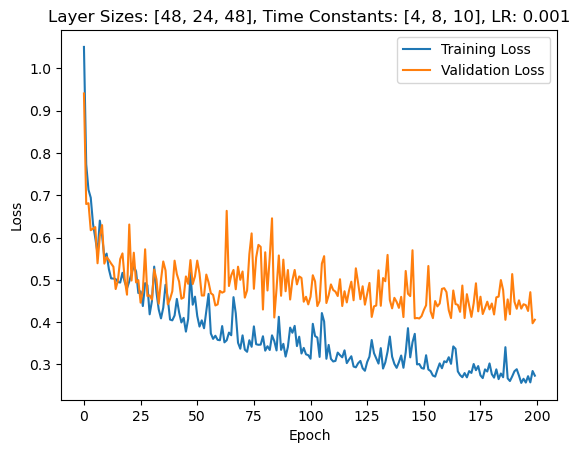

  0%|          | 1/200 [00:14<47:27, 14.31s/it]

Epoch 1/200, Training Loss: 1.0486599859201684, Validation Loss: 0.8531278542109898


  1%|          | 2/200 [00:28<46:57, 14.23s/it]

Epoch 2/200, Training Loss: 1.0110867090944975, Validation Loss: 0.8925142969403949


  2%|▏         | 3/200 [00:42<45:55, 13.99s/it]

Epoch 3/200, Training Loss: 0.9146098595745159, Validation Loss: 0.7432969340256282


  2%|▏         | 4/200 [00:55<45:02, 13.79s/it]

Epoch 4/200, Training Loss: 0.8604635641259967, Validation Loss: 0.701265560729163


  2%|▎         | 5/200 [01:09<44:36, 13.73s/it]

Epoch 5/200, Training Loss: 0.809078111963452, Validation Loss: 0.8134578892162868


  3%|▎         | 6/200 [01:23<44:45, 13.84s/it]

Epoch 6/200, Training Loss: 0.8038516719386263, Validation Loss: 0.7576339202267783


  4%|▎         | 7/200 [01:37<44:51, 13.95s/it]

Epoch 7/200, Training Loss: 0.7504678700330123, Validation Loss: 0.8693997412919998


  4%|▍         | 8/200 [01:51<45:01, 14.07s/it]

Epoch 8/200, Training Loss: 0.7643353837840962, Validation Loss: 0.6126640034573418


  4%|▍         | 9/200 [02:05<44:45, 14.06s/it]

Epoch 9/200, Training Loss: 0.698190874648544, Validation Loss: 0.7139981857367924


  5%|▌         | 10/200 [02:20<44:43, 14.12s/it]

Epoch 10/200, Training Loss: 0.6591330024431337, Validation Loss: 0.6662176698446274


  6%|▌         | 11/200 [02:33<43:49, 13.91s/it]

Epoch 11/200, Training Loss: 0.6170401120523237, Validation Loss: 0.6122466240610395


  6%|▌         | 12/200 [02:47<43:48, 13.98s/it]

Epoch 12/200, Training Loss: 0.5985355613366613, Validation Loss: 0.7518595116479057


  6%|▋         | 13/200 [03:01<43:19, 13.90s/it]

Epoch 13/200, Training Loss: 0.6064428805180315, Validation Loss: 0.6033413325037275


  7%|▋         | 14/200 [03:15<42:46, 13.80s/it]

Epoch 14/200, Training Loss: 0.5552783463642282, Validation Loss: 0.6323803109782082


  8%|▊         | 15/200 [03:28<42:34, 13.81s/it]

Epoch 15/200, Training Loss: 0.5642920816844365, Validation Loss: 0.7070072676454272


  8%|▊         | 16/200 [03:44<43:36, 14.22s/it]

Epoch 16/200, Training Loss: 0.5723799208425125, Validation Loss: 0.6092379029308047


  8%|▊         | 17/200 [03:58<43:20, 14.21s/it]

Epoch 17/200, Training Loss: 0.5971005660183025, Validation Loss: 0.7437237841742379


  9%|▉         | 18/200 [04:12<42:51, 14.13s/it]

Epoch 18/200, Training Loss: 0.6053791507235113, Validation Loss: 0.6144460737705231


 10%|▉         | 19/200 [04:26<42:43, 14.16s/it]

Epoch 19/200, Training Loss: 0.5580604498116475, Validation Loss: 0.5127118080854416


 10%|█         | 20/200 [04:41<42:56, 14.32s/it]

Epoch 20/200, Training Loss: 0.5273262866825428, Validation Loss: 0.5225007789475578


 10%|█         | 21/200 [04:55<43:10, 14.47s/it]

Epoch 21/200, Training Loss: 0.5679420758530779, Validation Loss: 0.7111058746065412


 11%|█         | 22/200 [05:10<42:53, 14.46s/it]

Epoch 22/200, Training Loss: 0.5660280115761847, Validation Loss: 0.45422119327953886


 12%|█▏        | 23/200 [05:24<42:17, 14.33s/it]

Epoch 23/200, Training Loss: 0.5138050773233738, Validation Loss: 0.5897303181035178


 12%|█▏        | 24/200 [05:39<42:46, 14.58s/it]

Epoch 24/200, Training Loss: 0.5327902077082193, Validation Loss: 0.6714774455342974


 12%|█▎        | 25/200 [05:54<42:31, 14.58s/it]

Epoch 25/200, Training Loss: 0.5251988051634915, Validation Loss: 0.7026800640991756


 13%|█▎        | 26/200 [06:08<41:55, 14.46s/it]

Epoch 26/200, Training Loss: 0.5101725484402675, Validation Loss: 0.6561569848230907


 14%|█▎        | 27/200 [06:22<41:36, 14.43s/it]

Epoch 27/200, Training Loss: 0.5218041876576981, Validation Loss: 0.5502394097191947


 14%|█▍        | 28/200 [06:37<41:22, 14.43s/it]

Epoch 28/200, Training Loss: 0.5774865780236587, Validation Loss: 0.5587979086807796


 14%|█▍        | 29/200 [06:51<40:58, 14.38s/it]

Epoch 29/200, Training Loss: 0.5383186449982086, Validation Loss: 0.7088305098669869


 15%|█▌        | 30/200 [07:05<40:29, 14.29s/it]

Epoch 30/200, Training Loss: 0.5099765905794108, Validation Loss: 0.5678657868078777


 16%|█▌        | 31/200 [07:19<39:50, 14.15s/it]

Epoch 31/200, Training Loss: 0.5513877916448521, Validation Loss: 0.6287393399647304


 16%|█▌        | 32/200 [07:33<39:42, 14.18s/it]

Epoch 32/200, Training Loss: 0.5915070451655478, Validation Loss: 0.631130473954337


 16%|█▋        | 33/200 [07:48<40:08, 14.42s/it]

Epoch 33/200, Training Loss: 0.5088747180295441, Validation Loss: 0.5397990963288716


 17%|█▋        | 34/200 [08:01<39:02, 14.11s/it]

Epoch 34/200, Training Loss: 0.5024960873261938, Validation Loss: 0.5399439973490578


 18%|█▊        | 35/200 [08:15<38:08, 13.87s/it]

Epoch 35/200, Training Loss: 0.47892331739641586, Validation Loss: 0.628891110420227


 18%|█▊        | 36/200 [08:29<38:22, 14.04s/it]

Epoch 36/200, Training Loss: 0.4682901147401558, Validation Loss: 0.5769689679145813


 18%|█▊        | 37/200 [08:43<37:39, 13.86s/it]

Epoch 37/200, Training Loss: 0.4785393077247548, Validation Loss: 0.45360079407691956


 19%|█▉        | 38/200 [08:56<37:12, 13.78s/it]

Epoch 38/200, Training Loss: 0.477729765311727, Validation Loss: 0.5247301097427096


 20%|█▉        | 39/200 [09:10<37:24, 13.94s/it]

Epoch 39/200, Training Loss: 0.48348513498621165, Validation Loss: 0.475259861775807


 20%|██        | 40/200 [09:24<36:51, 13.82s/it]

Epoch 40/200, Training Loss: 0.4690166188860839, Validation Loss: 0.45977609711033957


 20%|██        | 41/200 [09:37<36:07, 13.63s/it]

Epoch 41/200, Training Loss: 0.46271245631406893, Validation Loss: 0.43857281122888836


 21%|██        | 42/200 [09:51<36:04, 13.70s/it]

Epoch 42/200, Training Loss: 0.45571964613671573, Validation Loss: 0.550125002861023


 22%|██▏       | 43/200 [10:05<35:58, 13.75s/it]

Epoch 43/200, Training Loss: 0.4878662470376717, Validation Loss: 0.5210255427019936


 22%|██▏       | 44/200 [10:18<35:31, 13.66s/it]

Epoch 44/200, Training Loss: 0.5031177699565887, Validation Loss: 0.5227986659322467


 22%|██▎       | 45/200 [10:34<36:26, 14.11s/it]

Epoch 45/200, Training Loss: 0.47650507711014656, Validation Loss: 0.5350538917950222


 23%|██▎       | 46/200 [10:47<35:34, 13.86s/it]

Epoch 46/200, Training Loss: 0.4617828968560921, Validation Loss: 0.4910958409309387


 24%|██▎       | 47/200 [11:01<35:26, 13.90s/it]

Epoch 47/200, Training Loss: 0.46862361650421935, Validation Loss: 0.49830314091273714


 24%|██▍       | 48/200 [11:16<36:25, 14.38s/it]

Epoch 48/200, Training Loss: 0.4991274355155117, Validation Loss: 0.6230746550219399


 24%|██▍       | 49/200 [11:30<35:45, 14.21s/it]

Epoch 49/200, Training Loss: 0.4559114377172488, Validation Loss: 0.4448686135666711


 25%|██▌       | 50/200 [11:44<35:01, 14.01s/it]

Epoch 50/200, Training Loss: 0.4793541245865372, Validation Loss: 0.5105763929230827


 26%|██▌       | 51/200 [11:58<34:46, 14.00s/it]

Epoch 51/200, Training Loss: 0.4557164890586205, Validation Loss: 0.5476277129990714


 26%|██▌       | 52/200 [12:11<34:22, 13.94s/it]

Epoch 52/200, Training Loss: 0.4859912693500519, Validation Loss: 0.4537547784192221


 26%|██▋       | 53/200 [12:26<34:17, 14.00s/it]

Epoch 53/200, Training Loss: 0.4388426681453327, Validation Loss: 0.43432248490197317


 27%|██▋       | 54/200 [12:40<34:23, 14.13s/it]

Epoch 54/200, Training Loss: 0.4686483282525584, Validation Loss: 0.4740959235600063


 28%|██▊       | 55/200 [12:54<34:19, 14.21s/it]

Epoch 55/200, Training Loss: 0.44036117308544664, Validation Loss: 0.5147960100855146


 28%|██▊       | 56/200 [13:10<34:47, 14.49s/it]

Epoch 56/200, Training Loss: 0.47829557168033887, Validation Loss: 0.4280038901737758


 28%|██▊       | 57/200 [13:25<35:20, 14.83s/it]

Epoch 57/200, Training Loss: 0.44129336498818306, Validation Loss: 0.4501247661454337


 29%|██▉       | 58/200 [13:40<34:47, 14.70s/it]

Epoch 58/200, Training Loss: 0.4352077455171999, Validation Loss: 0.46457707456180025


 30%|██▉       | 59/200 [13:54<34:31, 14.69s/it]

Epoch 59/200, Training Loss: 0.4592865123501364, Validation Loss: 0.49359861442020964


 30%|███       | 60/200 [14:09<34:21, 14.73s/it]

Epoch 60/200, Training Loss: 0.46101719703314437, Validation Loss: 0.47548448613711763


 30%|███       | 61/200 [14:23<33:21, 14.40s/it]

Epoch 61/200, Training Loss: 0.4979569037567894, Validation Loss: 0.5005180197102683


 31%|███       | 62/200 [14:37<32:44, 14.24s/it]

Epoch 62/200, Training Loss: 0.4420687876782327, Validation Loss: 0.46984384102480753


 32%|███▏      | 63/200 [14:50<32:01, 14.02s/it]

Epoch 63/200, Training Loss: 0.41160464736650576, Validation Loss: 0.4571364564555032


 32%|███▏      | 64/200 [15:03<31:19, 13.82s/it]

Epoch 64/200, Training Loss: 0.4547900949727814, Validation Loss: 0.5069103496415275


 32%|███▎      | 65/200 [15:17<31:11, 13.87s/it]

Epoch 65/200, Training Loss: 0.4301227184961427, Validation Loss: 0.4592941105365753


 33%|███▎      | 66/200 [15:31<30:46, 13.78s/it]

Epoch 66/200, Training Loss: 0.42111447200460256, Validation Loss: 0.5205250424998147


 34%|███▎      | 67/200 [15:44<30:21, 13.69s/it]

Epoch 67/200, Training Loss: 0.4464111072274874, Validation Loss: 0.4944991575820105


 34%|███▍      | 68/200 [15:59<30:26, 13.83s/it]

Epoch 68/200, Training Loss: 0.47573332854037015, Validation Loss: 0.5281858550650733


 34%|███▍      | 69/200 [16:13<30:31, 13.98s/it]

Epoch 69/200, Training Loss: 0.40598527848158245, Validation Loss: 0.4902028909751347


 35%|███▌      | 70/200 [16:26<29:53, 13.80s/it]

Epoch 70/200, Training Loss: 0.4095606767344025, Validation Loss: 0.43117272002356394


 36%|███▌      | 71/200 [16:40<29:50, 13.88s/it]

Epoch 71/200, Training Loss: 0.43179636518910247, Validation Loss: 0.4566053662981306


 36%|███▌      | 72/200 [16:55<29:54, 14.02s/it]

Epoch 72/200, Training Loss: 0.42668638926632, Validation Loss: 0.479521061692919


 36%|███▋      | 73/200 [17:08<29:26, 13.91s/it]

Epoch 73/200, Training Loss: 0.431122435994868, Validation Loss: 0.44328368987355915


 37%|███▋      | 74/200 [17:22<29:14, 13.93s/it]

Epoch 74/200, Training Loss: 0.41435620160597675, Validation Loss: 0.4293869137763977


 38%|███▊      | 75/200 [17:36<28:49, 13.83s/it]

Epoch 75/200, Training Loss: 0.38903806850595296, Validation Loss: 0.4205216680254255


 38%|███▊      | 76/200 [17:49<28:24, 13.75s/it]

Epoch 76/200, Training Loss: 0.4484611136733361, Validation Loss: 0.4935318338019507


 38%|███▊      | 77/200 [18:03<28:16, 13.79s/it]

Epoch 77/200, Training Loss: 0.4012831890920423, Validation Loss: 0.44444234669208527


 39%|███▉      | 78/200 [18:17<27:52, 13.71s/it]

Epoch 78/200, Training Loss: 0.40522599304622076, Validation Loss: 0.44458100625446867


 40%|███▉      | 79/200 [18:30<27:29, 13.63s/it]

Epoch 79/200, Training Loss: 0.47304690137224376, Validation Loss: 0.7897583363311631


 40%|████      | 80/200 [18:44<27:29, 13.74s/it]

Epoch 80/200, Training Loss: 0.5351100436077928, Validation Loss: 0.450678003685815


 40%|████      | 81/200 [18:58<27:26, 13.83s/it]

Epoch 81/200, Training Loss: 0.41189390139759713, Validation Loss: 0.43642828719956533


 41%|████      | 82/200 [19:11<26:44, 13.60s/it]

Epoch 82/200, Training Loss: 0.4280238297750365, Validation Loss: 0.5358871987887791


 42%|████▏     | 83/200 [19:25<26:33, 13.62s/it]

Epoch 83/200, Training Loss: 0.39195829419032585, Validation Loss: 0.49153476527759005


 42%|████▏     | 84/200 [19:38<25:57, 13.43s/it]

Epoch 84/200, Training Loss: 0.4299898400621594, Validation Loss: 0.4650750287941524


 42%|████▎     | 85/200 [19:52<26:17, 13.72s/it]

Epoch 85/200, Training Loss: 0.40574036847870304, Validation Loss: 0.47122618343148914


 43%|████▎     | 86/200 [20:07<26:36, 14.01s/it]

Epoch 86/200, Training Loss: 0.42753584739172235, Validation Loss: 0.5131783570562091


 44%|████▎     | 87/200 [20:21<26:05, 13.86s/it]

Epoch 87/200, Training Loss: 0.42556108084489713, Validation Loss: 0.40557771921157837


 44%|████▍     | 88/200 [20:34<25:46, 13.81s/it]

Epoch 88/200, Training Loss: 0.3994440385755503, Validation Loss: 0.42125052213668823


 44%|████▍     | 89/200 [20:48<25:38, 13.86s/it]

Epoch 89/200, Training Loss: 0.4585840904487754, Validation Loss: 0.39175420148032053


 45%|████▌     | 90/200 [21:02<25:17, 13.80s/it]

Epoch 90/200, Training Loss: 0.394699217013593, Validation Loss: 0.4396031243460519


 46%|████▌     | 91/200 [21:16<24:55, 13.72s/it]

Epoch 91/200, Training Loss: 0.4057863492448375, Validation Loss: 0.45647193491458893


 46%|████▌     | 92/200 [21:30<24:51, 13.81s/it]

Epoch 92/200, Training Loss: 0.3946449621668402, Validation Loss: 0.4694128270660128


 46%|████▋     | 93/200 [21:43<24:33, 13.77s/it]

Epoch 93/200, Training Loss: 0.4287689525001454, Validation Loss: 0.40447122284344267


 47%|████▋     | 94/200 [21:58<24:43, 13.99s/it]

Epoch 94/200, Training Loss: 0.38680466587813395, Validation Loss: 0.6165076238768441


 48%|████▊     | 95/200 [22:12<24:25, 13.96s/it]

Epoch 95/200, Training Loss: 0.41807733110661777, Validation Loss: 0.4465680590697697


 48%|████▊     | 96/200 [22:25<23:59, 13.84s/it]

Epoch 96/200, Training Loss: 0.42039142352230147, Validation Loss: 0.5228516374315534


 48%|████▊     | 97/200 [22:40<24:03, 14.02s/it]

Epoch 97/200, Training Loss: 0.43272770407064903, Validation Loss: 0.49407610510076794


 49%|████▉     | 98/200 [22:53<23:43, 13.95s/it]

Epoch 98/200, Training Loss: 0.43366682079603086, Validation Loss: 0.5352091874395098


 50%|████▉     | 99/200 [23:07<23:19, 13.86s/it]

Epoch 99/200, Training Loss: 0.5044051602763949, Validation Loss: 0.5621663246835981


 50%|█████     | 100/200 [23:21<23:02, 13.82s/it]

Epoch 100/200, Training Loss: 0.42662760615348816, Validation Loss: 0.4705227507012231


 50%|█████     | 101/200 [23:35<22:47, 13.81s/it]

Epoch 101/200, Training Loss: 0.419864240401196, Validation Loss: 0.4019846362727029


 51%|█████     | 102/200 [23:48<22:22, 13.70s/it]

Epoch 102/200, Training Loss: 0.4437670815946921, Validation Loss: 0.483520575932094


 52%|█████▏    | 103/200 [24:03<22:31, 13.94s/it]

Epoch 103/200, Training Loss: 0.40415855075390833, Validation Loss: 0.45086308888026644


 52%|█████▏    | 104/200 [24:17<22:25, 14.02s/it]

Epoch 104/200, Training Loss: 0.41663518716704173, Validation Loss: 0.4255018351333482


 52%|█████▎    | 105/200 [24:31<22:15, 14.06s/it]

Epoch 105/200, Training Loss: 0.4077091464456522, Validation Loss: 0.4847034684249333


 53%|█████▎    | 106/200 [24:46<22:32, 14.39s/it]

Epoch 106/200, Training Loss: 0.44760284643128234, Validation Loss: 0.4310089371034077


 54%|█████▎    | 107/200 [25:00<22:13, 14.33s/it]

Epoch 107/200, Training Loss: 0.39045975287005585, Validation Loss: 0.4911568356411798


 54%|█████▍    | 108/200 [25:16<22:26, 14.64s/it]

Epoch 108/200, Training Loss: 0.3845988904248993, Validation Loss: 0.4289429060050419


 55%|█████▍    | 109/200 [25:30<22:18, 14.71s/it]

Epoch 109/200, Training Loss: 0.43190396253792745, Validation Loss: 0.4387384461505072


 55%|█████▌    | 110/200 [25:44<21:41, 14.46s/it]

Epoch 110/200, Training Loss: 0.4275564474036109, Validation Loss: 0.4953532602105822


 56%|█████▌    | 111/200 [25:58<21:06, 14.23s/it]

Epoch 111/200, Training Loss: 0.3797400350559433, Validation Loss: 0.5150260371821267


 56%|█████▌    | 112/200 [26:12<20:54, 14.25s/it]

Epoch 112/200, Training Loss: 0.39352475078600757, Validation Loss: 0.4157205479485648


 56%|█████▋    | 113/200 [26:26<20:24, 14.07s/it]

Epoch 113/200, Training Loss: 0.396653080886265, Validation Loss: 0.444999418088368


 57%|█████▋    | 114/200 [26:40<20:00, 13.96s/it]

Epoch 114/200, Training Loss: 0.41682644525788864, Validation Loss: 0.5247855399336133


 57%|█████▊    | 115/200 [26:54<19:52, 14.03s/it]

Epoch 115/200, Training Loss: 0.41213790453829857, Validation Loss: 0.3992992767265865


 58%|█████▊    | 116/200 [27:08<19:33, 13.98s/it]

Epoch 116/200, Training Loss: 0.39678093074065335, Validation Loss: 0.4081294855901173


 58%|█████▊    | 117/200 [27:22<19:23, 14.02s/it]

Epoch 117/200, Training Loss: 0.356735663875094, Validation Loss: 0.45717427347387585


 59%|█████▉    | 118/200 [27:37<19:38, 14.37s/it]

Epoch 118/200, Training Loss: 0.35244779162249473, Validation Loss: 0.4242499832596098


 60%|█████▉    | 119/200 [27:51<19:25, 14.39s/it]

Epoch 119/200, Training Loss: 0.3770614727488104, Validation Loss: 0.41189226508140564


 60%|██████    | 120/200 [28:06<19:11, 14.39s/it]

Epoch 120/200, Training Loss: 0.37968606122259824, Validation Loss: 0.4527760020324162


 60%|██████    | 121/200 [28:21<19:22, 14.72s/it]

Epoch 121/200, Training Loss: 0.3681847757466559, Validation Loss: 0.5666401386260986


 61%|██████    | 122/200 [28:36<19:02, 14.64s/it]

Epoch 122/200, Training Loss: 0.3606503780158061, Validation Loss: 0.5330664196184703


 62%|██████▏   | 123/200 [28:50<18:35, 14.49s/it]

Epoch 123/200, Training Loss: 0.6352016404271126, Validation Loss: 0.5653782955237797


 62%|██████▏   | 124/200 [29:04<18:14, 14.41s/it]

Epoch 124/200, Training Loss: 0.3881440947078309, Validation Loss: 0.46573494587625774


 62%|██████▎   | 125/200 [29:18<17:55, 14.34s/it]

Epoch 125/200, Training Loss: 0.382138636595798, Validation Loss: 0.4439931831189564


 63%|██████▎   | 126/200 [29:33<17:43, 14.37s/it]

Epoch 126/200, Training Loss: 0.3737740137104718, Validation Loss: 0.6772542830024447


 64%|██████▎   | 127/200 [29:47<17:24, 14.31s/it]

Epoch 127/200, Training Loss: 0.3967329038763946, Validation Loss: 0.5265477768012455


 64%|██████▍   | 128/200 [30:01<16:54, 14.09s/it]

Epoch 128/200, Training Loss: 0.4331902602933488, Validation Loss: 0.5796959400177002


 64%|██████▍   | 129/200 [30:15<16:53, 14.27s/it]

Epoch 129/200, Training Loss: 0.4337624404227959, Validation Loss: 0.49836054870060514


 65%|██████▌   | 130/200 [30:30<16:42, 14.33s/it]

Epoch 130/200, Training Loss: 0.38182189132807387, Validation Loss: 0.4860618157046182


 66%|██████▌   | 131/200 [30:43<16:14, 14.12s/it]

Epoch 131/200, Training Loss: 0.42872714180991334, Validation Loss: 0.46438159474304747


 66%|██████▌   | 132/200 [30:58<16:03, 14.17s/it]

Epoch 132/200, Training Loss: 0.36546199290819886, Validation Loss: 0.5647430505071368


 66%|██████▋   | 133/200 [31:12<16:01, 14.35s/it]

Epoch 133/200, Training Loss: 0.37082634388275865, Validation Loss: 0.4046384947640555


 67%|██████▋   | 134/200 [31:26<15:35, 14.17s/it]

Epoch 134/200, Training Loss: 0.4368792035669651, Validation Loss: 0.4320210282291685


 68%|██████▊   | 135/200 [31:40<15:19, 14.15s/it]

Epoch 135/200, Training Loss: 0.3888025512953974, Validation Loss: 0.5048785848276955


 68%|██████▊   | 136/200 [31:54<14:55, 13.99s/it]

Epoch 136/200, Training Loss: 0.35509044452095934, Validation Loss: 0.6646134555339813


 68%|██████▊   | 137/200 [32:07<14:34, 13.88s/it]

Epoch 137/200, Training Loss: 0.41698711281115153, Validation Loss: 0.49782360025814604


 69%|██████▉   | 138/200 [32:22<14:28, 14.00s/it]

Epoch 138/200, Training Loss: 0.3846765988559093, Validation Loss: 0.46863185507910593


 70%|██████▉   | 139/200 [32:35<14:05, 13.86s/it]

Epoch 139/200, Training Loss: 0.3987407757426208, Validation Loss: 0.5516070233924049


 70%|███████   | 140/200 [32:49<13:48, 13.81s/it]

Epoch 140/200, Training Loss: 0.3742208629143688, Validation Loss: 0.49112218618392944


 70%|███████   | 141/200 [33:03<13:46, 14.00s/it]

Epoch 141/200, Training Loss: 0.40563660494561465, Validation Loss: 0.4608441101653235


 71%|███████   | 142/200 [33:18<13:43, 14.20s/it]

Epoch 142/200, Training Loss: 0.36117356945321244, Validation Loss: 0.5601825884410313


 72%|███████▏  | 143/200 [33:32<13:19, 14.03s/it]

Epoch 143/200, Training Loss: 0.3820764681078353, Validation Loss: 0.5179763117006847


 72%|███████▏  | 144/200 [33:46<13:09, 14.10s/it]

Epoch 144/200, Training Loss: 0.3801668010792642, Validation Loss: 0.4666106786046709


 72%|███████▎  | 145/200 [34:01<13:04, 14.26s/it]

Epoch 145/200, Training Loss: 0.4120273103691497, Validation Loss: 0.5165086388587952


 73%|███████▎  | 146/200 [34:15<12:57, 14.40s/it]

Epoch 146/200, Training Loss: 0.4493552432307657, Validation Loss: 0.48956883379391264


 74%|███████▎  | 147/200 [34:30<12:43, 14.41s/it]

Epoch 147/200, Training Loss: 0.4425704777240753, Validation Loss: 0.4285001052277429


 74%|███████▍  | 148/200 [34:44<12:23, 14.29s/it]

Epoch 148/200, Training Loss: 0.374935692773675, Validation Loss: 0.43787393399647306


 74%|███████▍  | 149/200 [34:58<12:04, 14.21s/it]

Epoch 149/200, Training Loss: 0.42225493814023035, Validation Loss: 0.44003417662211824


 75%|███████▌  | 150/200 [35:12<11:53, 14.28s/it]

Epoch 150/200, Training Loss: 0.39766706413817854, Validation Loss: 0.48532435297966003


 76%|███████▌  | 151/200 [35:27<11:39, 14.27s/it]

Epoch 151/200, Training Loss: 0.376656600186285, Validation Loss: 0.45646042908941


 76%|███████▌  | 152/200 [35:41<11:25, 14.28s/it]

Epoch 152/200, Training Loss: 0.41479712598166374, Validation Loss: 0.4615315135036196


 76%|███████▋  | 153/200 [35:56<11:24, 14.56s/it]

Epoch 153/200, Training Loss: 0.3778364914205839, Validation Loss: 0.5737526374203819


 77%|███████▋  | 154/200 [36:10<11:06, 14.50s/it]

Epoch 154/200, Training Loss: 0.36469215379571013, Validation Loss: 0.4930394079004015


 78%|███████▊  | 155/200 [36:25<10:49, 14.42s/it]

Epoch 155/200, Training Loss: 0.3833955520728849, Validation Loss: 0.5420995908124107


 78%|███████▊  | 156/200 [36:39<10:30, 14.33s/it]

Epoch 156/200, Training Loss: 0.4217597951866546, Validation Loss: 0.5434759535959789


 78%|███████▊  | 157/200 [36:53<10:18, 14.39s/it]

Epoch 157/200, Training Loss: 0.3679476703675288, Validation Loss: 0.4652952381542751


 79%|███████▉  | 158/200 [37:08<10:03, 14.36s/it]

Epoch 158/200, Training Loss: 0.3881273179684045, Validation Loss: 0.5153197135244098


 80%|███████▉  | 159/200 [37:22<09:47, 14.33s/it]

Epoch 159/200, Training Loss: 0.36738861759878555, Validation Loss: 0.4823541130338396


 80%|████████  | 160/200 [37:36<09:26, 14.17s/it]

Epoch 160/200, Training Loss: 0.338259109489198, Validation Loss: 0.4977859556674957


 80%|████████  | 161/200 [37:50<09:17, 14.28s/it]

Epoch 161/200, Training Loss: 0.35234983574669315, Validation Loss: 0.543255763394492


 81%|████████  | 162/200 [38:05<09:04, 14.33s/it]

Epoch 162/200, Training Loss: 0.49634500635120105, Validation Loss: 0.5300059829439435


 82%|████████▏ | 163/200 [38:19<08:51, 14.37s/it]

Epoch 163/200, Training Loss: 0.3814820460272285, Validation Loss: 0.4875242028917585


 82%|████████▏ | 164/200 [38:34<08:39, 14.44s/it]

Epoch 164/200, Training Loss: 0.35947866456688576, Validation Loss: 0.5725413411855698


 82%|████████▎ | 165/200 [38:49<08:31, 14.60s/it]

Epoch 165/200, Training Loss: 0.3754562069222612, Validation Loss: 0.458322069474629


 83%|████████▎ | 166/200 [39:04<08:19, 14.69s/it]

Epoch 166/200, Training Loss: 0.3725192150417364, Validation Loss: 0.5739153708730426


 84%|████████▎ | 167/200 [39:18<08:05, 14.71s/it]

Epoch 167/200, Training Loss: 0.3818016639857922, Validation Loss: 0.47923588326999117


 84%|████████▍ | 168/200 [39:32<07:43, 14.48s/it]

Epoch 168/200, Training Loss: 0.3719504618982099, Validation Loss: 0.5059210743222918


 84%|████████▍ | 169/200 [39:48<07:36, 14.73s/it]

Epoch 169/200, Training Loss: 0.3467686194575058, Validation Loss: 0.4849998163325446


 85%|████████▌ | 170/200 [40:02<07:22, 14.77s/it]

Epoch 170/200, Training Loss: 0.3661161464340282, Validation Loss: 0.5045972572905677


 86%|████████▌ | 171/200 [40:17<07:03, 14.60s/it]

Epoch 171/200, Training Loss: 0.412201980656048, Validation Loss: 0.5519498139619827


 86%|████████▌ | 172/200 [40:31<06:49, 14.61s/it]

Epoch 172/200, Training Loss: 0.36980711106421815, Validation Loss: 0.4254260999815805


 86%|████████▋ | 173/200 [40:46<06:32, 14.53s/it]

Epoch 173/200, Training Loss: 0.37870468726416806, Validation Loss: 0.4925222567149571


 87%|████████▋ | 174/200 [41:00<06:17, 14.53s/it]

Epoch 174/200, Training Loss: 0.42081696469828767, Validation Loss: 0.5399978969778333


 88%|████████▊ | 175/200 [41:15<06:05, 14.63s/it]

Epoch 175/200, Training Loss: 0.36951140454917586, Validation Loss: 0.5084107241460255


 88%|████████▊ | 176/200 [41:29<05:46, 14.46s/it]

Epoch 176/200, Training Loss: 0.36237779062873915, Validation Loss: 0.7983549556561879


 88%|████████▊ | 177/200 [41:44<05:32, 14.48s/it]

Epoch 177/200, Training Loss: 0.3909657468210976, Validation Loss: 0.4948059788772038


 89%|████████▉ | 178/200 [41:58<05:19, 14.52s/it]

Epoch 178/200, Training Loss: 0.3482786315792012, Validation Loss: 0.47023085185459684


 90%|████████▉ | 179/200 [42:13<05:04, 14.48s/it]

Epoch 179/200, Training Loss: 0.40963983563882, Validation Loss: 0.5518630508865628


 90%|█████████ | 180/200 [42:28<04:53, 14.66s/it]

Epoch 180/200, Training Loss: 0.3533716120247571, Validation Loss: 0.5031788285289492


 90%|█████████ | 181/200 [42:42<04:36, 14.57s/it]

Epoch 181/200, Training Loss: 0.3661238435866698, Validation Loss: 0.5946886028562274


 91%|█████████ | 182/200 [42:56<04:18, 14.34s/it]

Epoch 182/200, Training Loss: 0.41438969772941664, Validation Loss: 0.4558026237147195


 92%|█████████▏| 183/200 [43:10<04:01, 14.21s/it]

Epoch 183/200, Training Loss: 0.37118871228874856, Validation Loss: 0.4846955622945513


 92%|█████████▏| 184/200 [43:24<03:47, 14.19s/it]

Epoch 184/200, Training Loss: 0.37864399912222374, Validation Loss: 0.5699692985841206


 92%|█████████▎| 185/200 [43:38<03:31, 14.10s/it]

Epoch 185/200, Training Loss: 0.34615796242120134, Validation Loss: 0.5551636602197375


 93%|█████████▎| 186/200 [43:52<03:17, 14.07s/it]

Epoch 186/200, Training Loss: 0.35679719526812714, Validation Loss: 0.464340016245842


 94%|█████████▎| 187/200 [44:07<03:07, 14.44s/it]

Epoch 187/200, Training Loss: 0.4325320152741558, Validation Loss: 0.6008162200450897


 94%|█████████▍| 188/200 [44:23<02:56, 14.74s/it]

Epoch 188/200, Training Loss: 0.3544103685977324, Validation Loss: 0.5297961213759014


 94%|█████████▍| 189/200 [44:38<02:42, 14.82s/it]

Epoch 189/200, Training Loss: 0.4235501677360175, Validation Loss: 0.5933270241533007


 95%|█████████▌| 190/200 [44:52<02:27, 14.76s/it]

Epoch 190/200, Training Loss: 0.36163596330948594, Validation Loss: 0.48689064383506775


 96%|█████████▌| 191/200 [45:07<02:11, 14.66s/it]

Epoch 191/200, Training Loss: 0.33158866681580274, Validation Loss: 0.5699368906872613


 96%|█████████▌| 192/200 [45:22<01:58, 14.85s/it]

Epoch 192/200, Training Loss: 0.3757338705209066, Validation Loss: 0.5667732166392463


 96%|█████████▋| 193/200 [45:37<01:43, 14.83s/it]

Epoch 193/200, Training Loss: 0.36356095140272715, Validation Loss: 0.5112087045397077


 97%|█████████▋| 194/200 [45:51<01:27, 14.57s/it]

Epoch 194/200, Training Loss: 0.35924731110626795, Validation Loss: 0.5842900765793664


 98%|█████████▊| 195/200 [46:05<01:12, 14.46s/it]

Epoch 195/200, Training Loss: 0.37646826426937896, Validation Loss: 0.562206466283117


 98%|█████████▊| 196/200 [46:19<00:57, 14.34s/it]

Epoch 196/200, Training Loss: 0.36775778908774537, Validation Loss: 0.5722411402634212


 98%|█████████▊| 197/200 [46:33<00:42, 14.21s/it]

Epoch 197/200, Training Loss: 0.3513705646092037, Validation Loss: 0.5937278483595166


 99%|█████████▉| 198/200 [46:47<00:28, 14.32s/it]

Epoch 198/200, Training Loss: 0.3309112941881396, Validation Loss: 0.5597507016999381


100%|█████████▉| 199/200 [47:01<00:14, 14.25s/it]

Epoch 199/200, Training Loss: 0.3480144626689407, Validation Loss: 0.5395814818995339


100%|██████████| 200/200 [47:16<00:00, 14.18s/it]

Epoch 200/200, Training Loss: 0.41245793227879507, Validation Loss: 0.6292896323970386
Final Accuracy: 89.95%, Precision: 0.89, Recall: 0.92


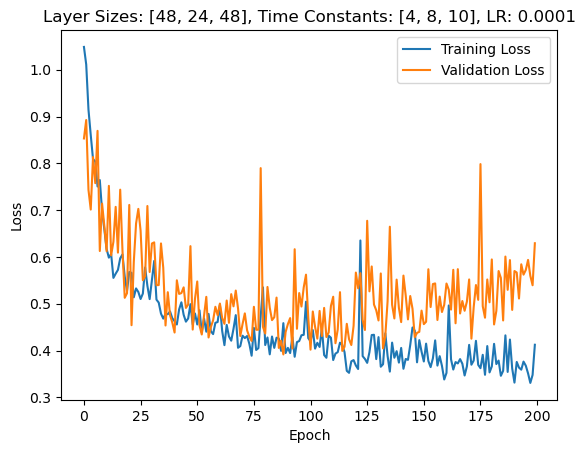

  0%|          | 1/200 [00:15<52:14, 15.75s/it]

Epoch 1/200, Training Loss: 3.295859440317694, Validation Loss: 0.9302844405174255


  1%|          | 2/200 [00:30<49:27, 14.99s/it]

Epoch 2/200, Training Loss: 0.9412934847597806, Validation Loss: 0.7614762229578835


  2%|▏         | 3/200 [00:44<48:01, 14.63s/it]

Epoch 3/200, Training Loss: 0.8901744237485921, Validation Loss: 0.6802837039743151


  2%|▏         | 4/200 [00:58<47:31, 14.55s/it]

Epoch 4/200, Training Loss: 0.7874173010295292, Validation Loss: 0.5614560927663531


  2%|▎         | 5/200 [01:13<47:57, 14.75s/it]

Epoch 5/200, Training Loss: 0.7763246851709654, Validation Loss: 0.6598587398018155


  3%|▎         | 6/200 [01:29<48:08, 14.89s/it]

Epoch 6/200, Training Loss: 0.7299245326024182, Validation Loss: 0.6439295794282641


  4%|▎         | 7/200 [01:44<48:16, 15.01s/it]

Epoch 7/200, Training Loss: 0.7236642123393293, Validation Loss: 0.7292817894901548


  4%|▍         | 8/200 [01:59<48:05, 15.03s/it]

Epoch 8/200, Training Loss: 0.7429310780651165, Validation Loss: 0.6908407488039562


  4%|▍         | 9/200 [02:14<47:55, 15.06s/it]

Epoch 9/200, Training Loss: 0.6442583400123524, Validation Loss: 0.7081597064222608


  5%|▌         | 10/200 [02:28<46:59, 14.84s/it]

Epoch 10/200, Training Loss: 0.6400810277686929, Validation Loss: 0.6190975457429886


  6%|▌         | 11/200 [02:44<47:04, 14.95s/it]

Epoch 11/200, Training Loss: 0.6057406155005941, Validation Loss: 0.6858645166669574


  6%|▌         | 12/200 [02:59<47:21, 15.11s/it]

Epoch 12/200, Training Loss: 0.5910675981134739, Validation Loss: 0.6124048786503928


  6%|▋         | 13/200 [03:13<46:21, 14.87s/it]

Epoch 13/200, Training Loss: 0.5539289201205632, Validation Loss: 0.5943718978336879


  7%|▋         | 14/200 [03:29<46:39, 15.05s/it]

Epoch 14/200, Training Loss: 0.6510953548944222, Validation Loss: 0.5839394543852124


  8%|▊         | 15/200 [03:44<46:30, 15.08s/it]

Epoch 15/200, Training Loss: 0.6230085323441703, Validation Loss: 0.6935127079486847


  8%|▊         | 16/200 [03:58<45:20, 14.79s/it]

Epoch 16/200, Training Loss: 0.5636787009689043, Validation Loss: 0.5894306344645364


  8%|▊         | 17/200 [04:12<44:16, 14.52s/it]

Epoch 17/200, Training Loss: 0.5220689824167287, Validation Loss: 0.5502605991704124


  9%|▉         | 18/200 [04:27<44:35, 14.70s/it]

Epoch 18/200, Training Loss: 0.4982006420504372, Validation Loss: 0.5460114479064941


 10%|▉         | 19/200 [04:42<44:17, 14.68s/it]

Epoch 19/200, Training Loss: 0.46511562927713934, Validation Loss: 0.4811962672642299


 10%|█         | 20/200 [04:56<43:45, 14.59s/it]

Epoch 20/200, Training Loss: 0.48983112989731553, Validation Loss: 0.5356622231858117


 10%|█         | 21/200 [05:10<43:10, 14.47s/it]

Epoch 21/200, Training Loss: 0.4582072038133189, Validation Loss: 0.5600917786359787


 11%|█         | 22/200 [05:25<43:11, 14.56s/it]

Epoch 22/200, Training Loss: 0.4911324402914857, Validation Loss: 0.4993762693234852


 12%|█▏        | 23/200 [05:40<43:00, 14.58s/it]

Epoch 23/200, Training Loss: 0.4466608802102647, Validation Loss: 0.49159795471600126


 12%|█▏        | 24/200 [05:54<42:14, 14.40s/it]

Epoch 24/200, Training Loss: 0.5562952763910564, Validation Loss: 0.6244658295597348


 12%|█▎        | 25/200 [06:08<41:29, 14.22s/it]

Epoch 25/200, Training Loss: 0.5201678068008063, Validation Loss: 0.5521039962768555


 13%|█▎        | 26/200 [06:22<41:22, 14.27s/it]

Epoch 26/200, Training Loss: 0.44160896792726695, Validation Loss: 0.4649705524955477


 14%|█▎        | 27/200 [06:36<41:16, 14.31s/it]

Epoch 27/200, Training Loss: 0.5662162208332205, Validation Loss: 0.6307749663080487


 14%|█▍        | 28/200 [06:50<40:47, 14.23s/it]

Epoch 28/200, Training Loss: 0.5190439443543272, Validation Loss: 0.5100704559258052


 14%|█▍        | 29/200 [07:05<40:33, 14.23s/it]

Epoch 29/200, Training Loss: 0.4394652030940326, Validation Loss: 0.5061399000031608


 15%|█▌        | 30/200 [07:19<40:52, 14.43s/it]

Epoch 30/200, Training Loss: 0.43530440246159174, Validation Loss: 0.5160555413791111


 16%|█▌        | 31/200 [07:35<41:23, 14.70s/it]

Epoch 31/200, Training Loss: 0.44122946346705816, Validation Loss: 0.5014162319047111


 16%|█▌        | 32/200 [07:50<41:19, 14.76s/it]

Epoch 32/200, Training Loss: 0.4174696048194507, Validation Loss: 0.46782239845820833


 16%|█▋        | 33/200 [08:04<41:03, 14.75s/it]

Epoch 33/200, Training Loss: 0.407493401389077, Validation Loss: 0.48208109395844595


 17%|█▋        | 34/200 [08:20<41:27, 14.99s/it]

Epoch 34/200, Training Loss: 0.4319153869489454, Validation Loss: 0.4704160179410662


 18%|█▊        | 35/200 [08:34<40:49, 14.85s/it]

Epoch 35/200, Training Loss: 0.36945840997515983, Validation Loss: 0.4657874213797705


 18%|█▊        | 36/200 [08:48<39:52, 14.59s/it]

Epoch 36/200, Training Loss: 0.3642007388033957, Validation Loss: 0.4784821484770094


 18%|█▊        | 37/200 [09:03<39:49, 14.66s/it]

Epoch 37/200, Training Loss: 0.4046227951657097, Validation Loss: 0.4277621124471937


 19%|█▉        | 38/200 [09:18<39:46, 14.73s/it]

Epoch 38/200, Training Loss: 0.3619612633900822, Validation Loss: 0.47385879499571665


 20%|█▉        | 39/200 [09:32<39:10, 14.60s/it]

Epoch 39/200, Training Loss: 0.3680910957309435, Validation Loss: 0.4802497263465609


 20%|██        | 40/200 [09:47<38:46, 14.54s/it]

Epoch 40/200, Training Loss: 0.3550330732228621, Validation Loss: 0.4542526389871325


 20%|██        | 41/200 [10:02<38:36, 14.57s/it]

Epoch 41/200, Training Loss: 0.3837773872996276, Validation Loss: 0.45739692875317167


 21%|██        | 42/200 [10:16<38:34, 14.65s/it]

Epoch 42/200, Training Loss: 0.3768472566076045, Validation Loss: 0.5197898639099938


 22%|██▏       | 43/200 [10:31<38:34, 14.74s/it]

Epoch 43/200, Training Loss: 0.36260373482726654, Validation Loss: 0.4631048824105944


 22%|██▏       | 44/200 [10:46<38:07, 14.67s/it]

Epoch 44/200, Training Loss: 0.344445194135297, Validation Loss: 0.5852234789303371


 22%|██▎       | 45/200 [11:00<37:38, 14.57s/it]

Epoch 45/200, Training Loss: 0.41699984472877577, Validation Loss: 0.4222067360367094


 23%|██▎       | 46/200 [11:16<38:33, 15.02s/it]

Epoch 46/200, Training Loss: 0.3529634468679158, Validation Loss: 0.5314340080533709


 24%|██▎       | 47/200 [11:31<37:53, 14.86s/it]

Epoch 47/200, Training Loss: 0.37142634419900067, Validation Loss: 0.5142826161214283


 24%|██▍       | 48/200 [11:45<37:02, 14.62s/it]

Epoch 48/200, Training Loss: 0.3668392414473138, Validation Loss: 0.4961767005068915


 24%|██▍       | 49/200 [11:59<36:46, 14.61s/it]

Epoch 49/200, Training Loss: 0.35569009845549204, Validation Loss: 0.43944439930575235


 25%|██▌       | 50/200 [12:14<36:11, 14.48s/it]

Epoch 50/200, Training Loss: 0.40957286279156524, Validation Loss: 0.42285539848463877


 26%|██▌       | 51/200 [12:28<35:48, 14.42s/it]

Epoch 51/200, Training Loss: 0.3514472819724173, Validation Loss: 0.4645242669752666


 26%|██▌       | 52/200 [12:43<35:50, 14.53s/it]

Epoch 52/200, Training Loss: 0.3883920216335441, Validation Loss: 0.4642559971128191


 26%|██▋       | 53/200 [12:57<35:26, 14.47s/it]

Epoch 53/200, Training Loss: 0.40831034588363935, Validation Loss: 0.43250354698726107


 27%|██▋       | 54/200 [13:12<35:37, 14.64s/it]

Epoch 54/200, Training Loss: 0.3769427962460608, Validation Loss: 0.40252553139414105


 28%|██▊       | 55/200 [13:28<36:22, 15.05s/it]

Epoch 55/200, Training Loss: 0.35377591047084556, Validation Loss: 0.4253148117235729


 28%|██▊       | 56/200 [13:43<36:04, 15.03s/it]

Epoch 56/200, Training Loss: 0.3401081249961313, Validation Loss: 0.4399241421903883


 28%|██▊       | 57/200 [13:57<35:15, 14.79s/it]

Epoch 57/200, Training Loss: 0.33862273662157777, Validation Loss: 0.4059625566005707


 29%|██▉       | 58/200 [14:13<35:49, 15.13s/it]

Epoch 58/200, Training Loss: 0.34239200636182193, Validation Loss: 0.40809876791068483


 30%|██▉       | 59/200 [14:28<35:01, 14.90s/it]

Epoch 59/200, Training Loss: 0.3464577115088139, Validation Loss: 0.39391542971134186


 30%|███       | 60/200 [14:42<34:20, 14.72s/it]

Epoch 60/200, Training Loss: 0.34801619176594717, Validation Loss: 0.39630487986973356


 30%|███       | 61/200 [14:56<34:05, 14.71s/it]

Epoch 61/200, Training Loss: 0.3429800884903602, Validation Loss: 0.41815558288778576


 31%|███       | 62/200 [15:11<33:26, 14.54s/it]

Epoch 62/200, Training Loss: 0.34593851414491544, Validation Loss: 0.4436795881816319


 32%|███▏      | 63/200 [15:25<33:03, 14.48s/it]

Epoch 63/200, Training Loss: 0.3817829846773507, Validation Loss: 0.38996998965740204


 32%|███▏      | 64/200 [15:39<32:42, 14.43s/it]

Epoch 64/200, Training Loss: 0.3401105335720305, Validation Loss: 0.42231027356215883


 32%|███▎      | 65/200 [15:54<32:27, 14.42s/it]

Epoch 65/200, Training Loss: 0.35403223869935524, Validation Loss: 0.4150478946311133


 33%|███▎      | 66/200 [16:09<32:48, 14.69s/it]

Epoch 66/200, Training Loss: 0.3291459814557489, Validation Loss: 0.45693698951176237


 34%|███▎      | 67/200 [16:24<32:39, 14.73s/it]

Epoch 67/200, Training Loss: 0.35784351769483314, Validation Loss: 0.42585198155471254


 34%|███▍      | 68/200 [16:38<32:19, 14.69s/it]

Epoch 68/200, Training Loss: 0.3663028308524276, Validation Loss: 0.41675524200711933


 34%|███▍      | 69/200 [16:53<32:14, 14.76s/it]

Epoch 69/200, Training Loss: 0.33153958478063905, Validation Loss: 0.40584393803562435


 35%|███▌      | 70/200 [17:09<32:39, 15.07s/it]

Epoch 70/200, Training Loss: 0.33946132125719536, Validation Loss: 0.39930954362664905


 36%|███▌      | 71/200 [17:24<32:01, 14.90s/it]

Epoch 71/200, Training Loss: 0.35064280356438654, Validation Loss: 0.46109622929777416


 36%|███▌      | 72/200 [17:39<31:45, 14.89s/it]

Epoch 72/200, Training Loss: 0.3524735617750096, Validation Loss: 0.43040199152060915


 36%|███▋      | 73/200 [17:54<31:47, 15.02s/it]

Epoch 73/200, Training Loss: 0.31914392141801007, Validation Loss: 0.4130022887672697


 37%|███▋      | 74/200 [18:08<31:17, 14.90s/it]

Epoch 74/200, Training Loss: 0.301454596362024, Validation Loss: 0.4166889616421291


 38%|███▊      | 75/200 [18:23<30:53, 14.83s/it]

Epoch 75/200, Training Loss: 0.3246428589775877, Validation Loss: 0.4431495453630175


 38%|███▊      | 76/200 [18:38<30:23, 14.71s/it]

Epoch 76/200, Training Loss: 0.3706211706377425, Validation Loss: 0.42955670186451506


 38%|███▊      | 77/200 [18:52<29:57, 14.62s/it]

Epoch 77/200, Training Loss: 0.3373584346670025, Validation Loss: 0.4589908740350178


 39%|███▉      | 78/200 [19:07<30:02, 14.77s/it]

Epoch 78/200, Training Loss: 0.3172291763267427, Validation Loss: 0.4152356684207916


 40%|███▉      | 79/200 [19:21<29:31, 14.64s/it]

Epoch 79/200, Training Loss: 0.3265647518466104, Validation Loss: 0.42288666112082346


 40%|████      | 80/200 [19:36<29:12, 14.60s/it]

Epoch 80/200, Training Loss: 0.3140898564092393, Validation Loss: 0.36940184235572815


 40%|████      | 81/200 [19:50<28:49, 14.53s/it]

Epoch 81/200, Training Loss: 0.3163050466550971, Validation Loss: 0.3830621455396925


 41%|████      | 82/200 [20:05<28:58, 14.73s/it]

Epoch 82/200, Training Loss: 0.31671655023435374, Validation Loss: 0.454572075179645


 42%|████▏     | 83/200 [20:20<28:37, 14.68s/it]

Epoch 83/200, Training Loss: 0.30149558270877264, Validation Loss: 0.4875829092093876


 42%|████▏     | 84/200 [20:34<28:06, 14.54s/it]

Epoch 84/200, Training Loss: 0.33736662953248564, Validation Loss: 0.4295611594404493


 42%|████▎     | 85/200 [20:48<27:38, 14.42s/it]

Epoch 85/200, Training Loss: 0.33850536748485743, Validation Loss: 0.3941043061869485


 43%|████▎     | 86/200 [21:03<27:42, 14.58s/it]

Epoch 86/200, Training Loss: 0.33527633041705723, Validation Loss: 0.41717736210141865


 44%|████▎     | 87/200 [21:18<27:15, 14.48s/it]

Epoch 87/200, Training Loss: 0.3189822701069544, Validation Loss: 0.4132421293428966


 44%|████▍     | 88/200 [21:32<26:50, 14.38s/it]

Epoch 88/200, Training Loss: 0.30856165641321326, Validation Loss: 0.4326513111591339


 44%|████▍     | 89/200 [21:47<26:50, 14.51s/it]

Epoch 89/200, Training Loss: 0.35360166107146246, Validation Loss: 0.42444147169589996


 45%|████▌     | 90/200 [22:02<27:02, 14.75s/it]

Epoch 90/200, Training Loss: 0.2956523039149788, Validation Loss: 0.3969792510781969


 46%|████▌     | 91/200 [22:17<26:56, 14.83s/it]

Epoch 91/200, Training Loss: 0.3145452763112086, Validation Loss: 0.4321845131261008


 46%|████▌     | 92/200 [22:32<26:46, 14.88s/it]

Epoch 92/200, Training Loss: 0.31835999663146036, Validation Loss: 0.41937299924237387


 46%|████▋     | 93/200 [22:46<26:10, 14.68s/it]

Epoch 93/200, Training Loss: 0.3515172749757767, Validation Loss: 0.46697951427527834


 47%|████▋     | 94/200 [23:01<26:08, 14.79s/it]

Epoch 94/200, Training Loss: 0.35832485978333456, Validation Loss: 0.4079484897000449


 48%|████▊     | 95/200 [23:16<25:59, 14.85s/it]

Epoch 95/200, Training Loss: 0.3146133810844062, Validation Loss: 0.3978246663297926


 48%|████▊     | 96/200 [23:30<25:25, 14.67s/it]

Epoch 96/200, Training Loss: 0.3270130165905323, Validation Loss: 0.4491752598966871


 48%|████▊     | 97/200 [23:45<25:11, 14.67s/it]

Epoch 97/200, Training Loss: 0.3071318301108648, Validation Loss: 0.4010712844984872


 49%|████▉     | 98/200 [24:00<25:01, 14.72s/it]

Epoch 98/200, Training Loss: 0.27383503268631, Validation Loss: 0.3920110762119293


 50%|████▉     | 99/200 [24:14<24:32, 14.58s/it]

Epoch 99/200, Training Loss: 0.3126660782211232, Validation Loss: 0.4341521156685693


 50%|█████     | 100/200 [24:29<24:34, 14.74s/it]

Epoch 100/200, Training Loss: 0.2836135272990982, Validation Loss: 0.40385634345667704


 50%|█████     | 101/200 [24:44<24:25, 14.80s/it]

Epoch 101/200, Training Loss: 0.32713175269792666, Validation Loss: 0.3460761627980641


 51%|█████     | 102/200 [25:00<24:43, 15.14s/it]

Epoch 102/200, Training Loss: 0.3190886603914342, Validation Loss: 0.40595036319323946


 52%|█████▏    | 103/200 [25:16<24:40, 15.26s/it]

Epoch 103/200, Training Loss: 0.3066232048396794, Validation Loss: 0.4012009437595095


 52%|█████▏    | 104/200 [25:31<24:16, 15.17s/it]

Epoch 104/200, Training Loss: 0.3043031359337411, Validation Loss: 0.39269683616501944


 52%|█████▎    | 105/200 [25:47<24:27, 15.45s/it]

Epoch 105/200, Training Loss: 0.2848706773991855, Validation Loss: 0.3918285093137196


 53%|█████▎    | 106/200 [26:02<24:15, 15.48s/it]

Epoch 106/200, Training Loss: 0.33742510428968464, Validation Loss: 0.38771538010665346


 54%|█████▎    | 107/200 [26:17<23:36, 15.23s/it]

Epoch 107/200, Training Loss: 0.2913671283508247, Validation Loss: 0.40335538344723837


 54%|█████▍    | 108/200 [26:32<23:29, 15.32s/it]

Epoch 108/200, Training Loss: 0.26506619697067674, Validation Loss: 0.38667742908000946


 55%|█████▍    | 109/200 [26:49<23:50, 15.72s/it]

Epoch 109/200, Training Loss: 0.29460671473786515, Validation Loss: 0.46596794043268475


 55%|█████▌    | 110/200 [27:05<23:27, 15.64s/it]

Epoch 110/200, Training Loss: 0.2909340684144002, Validation Loss: 0.43812258754457745


 56%|█████▌    | 111/200 [27:20<23:10, 15.63s/it]

Epoch 111/200, Training Loss: 0.2839175561126673, Validation Loss: 0.4240512124129704


 56%|█████▌    | 112/200 [27:35<22:44, 15.51s/it]

Epoch 112/200, Training Loss: 0.27745507826220317, Validation Loss: 0.3919258564710617


 56%|█████▋    | 113/200 [27:51<22:35, 15.58s/it]

Epoch 113/200, Training Loss: 0.29119482060086055, Validation Loss: 0.41941278747149874


 57%|█████▋    | 114/200 [28:07<22:17, 15.55s/it]

Epoch 114/200, Training Loss: 0.2888730114923333, Validation Loss: 0.418719293815749


 57%|█████▊    | 115/200 [28:22<21:45, 15.36s/it]

Epoch 115/200, Training Loss: 0.2863268288520147, Validation Loss: 0.3824786863156727


 58%|█████▊    | 116/200 [28:38<21:46, 15.55s/it]

Epoch 116/200, Training Loss: 0.32118129631820713, Validation Loss: 0.37024584838322233


 58%|█████▊    | 117/200 [28:53<21:24, 15.48s/it]

Epoch 117/200, Training Loss: 0.25910800090938246, Validation Loss: 0.3812956192663738


 59%|█████▉    | 118/200 [29:08<20:55, 15.31s/it]

Epoch 118/200, Training Loss: 0.26942699775099754, Validation Loss: 0.41229150550706045


 60%|█████▉    | 119/200 [29:23<20:30, 15.19s/it]

Epoch 119/200, Training Loss: 0.25974209937003423, Validation Loss: 0.3571166970900127


 60%|██████    | 120/200 [29:38<20:12, 15.15s/it]

Epoch 120/200, Training Loss: 0.2699077810108099, Validation Loss: 0.39424549468926023


 60%|██████    | 121/200 [29:52<19:44, 14.99s/it]

Epoch 121/200, Training Loss: 0.25065761249301566, Validation Loss: 0.4032127154724939


 61%|██████    | 122/200 [30:07<19:15, 14.82s/it]

Epoch 122/200, Training Loss: 0.268677505752388, Validation Loss: 0.4187167372022356


 62%|██████▏   | 123/200 [30:22<18:58, 14.79s/it]

Epoch 123/200, Training Loss: 0.2593536859835094, Validation Loss: 0.35854276376111166


 62%|██████▏   | 124/200 [30:37<18:57, 14.96s/it]

Epoch 124/200, Training Loss: 0.24105999197037714, Validation Loss: 0.41513764006750925


 62%|██████▎   | 125/200 [30:53<19:00, 15.20s/it]

Epoch 125/200, Training Loss: 0.24686890699953404, Validation Loss: 0.38351269492081236


 63%|██████▎   | 126/200 [31:08<18:38, 15.11s/it]

Epoch 126/200, Training Loss: 0.2479931371251367, Validation Loss: 0.38607989038739887


 64%|██████▎   | 127/200 [31:23<18:22, 15.10s/it]

Epoch 127/200, Training Loss: 0.2643581266813683, Validation Loss: 0.4190086828810828


 64%|██████▍   | 128/200 [31:39<18:26, 15.37s/it]

Epoch 128/200, Training Loss: 0.28570755796050123, Validation Loss: 0.36107986526829855


 64%|██████▍   | 129/200 [31:53<17:51, 15.10s/it]

Epoch 129/200, Training Loss: 0.2582277157256063, Validation Loss: 0.39841202752930777


 65%|██████▌   | 130/200 [32:08<17:24, 14.92s/it]

Epoch 130/200, Training Loss: 0.25788152695826766, Validation Loss: 0.4186621116740363


 66%|██████▌   | 131/200 [32:22<17:05, 14.87s/it]

Epoch 131/200, Training Loss: 0.25357699109557663, Validation Loss: 0.39428312863622395


 66%|██████▌   | 132/200 [32:36<16:35, 14.64s/it]

Epoch 132/200, Training Loss: 0.24852973447655732, Validation Loss: 0.37416097415345057


 66%|██████▋   | 133/200 [32:51<16:14, 14.54s/it]

Epoch 133/200, Training Loss: 0.2460586553052911, Validation Loss: 0.38459917477199007


 67%|██████▋   | 134/200 [33:05<16:02, 14.59s/it]

Epoch 134/200, Training Loss: 0.2586848811720902, Validation Loss: 0.3642693800585611


 68%|██████▊   | 135/200 [33:20<15:44, 14.53s/it]

Epoch 135/200, Training Loss: 0.2433737704776368, Validation Loss: 0.37963069549628664


 68%|██████▊   | 136/200 [33:35<15:42, 14.72s/it]

Epoch 136/200, Training Loss: 0.24387855564226518, Validation Loss: 0.39929003162043436


 68%|██████▊   | 137/200 [33:50<15:37, 14.88s/it]

Epoch 137/200, Training Loss: 0.23876547707982784, Validation Loss: 0.3625736193997519


 69%|██████▉   | 138/200 [34:05<15:16, 14.79s/it]

Epoch 138/200, Training Loss: 0.2395029127035501, Validation Loss: 0.3645333583865847


 70%|██████▉   | 139/200 [34:19<14:56, 14.69s/it]

Epoch 139/200, Training Loss: 0.23226091230534157, Validation Loss: 0.4136463095034872


 70%|███████   | 140/200 [34:36<15:09, 15.16s/it]

Epoch 140/200, Training Loss: 0.25155175631901006, Validation Loss: 0.34102348344666616


 70%|███████   | 141/200 [34:50<14:48, 15.05s/it]

Epoch 141/200, Training Loss: 0.2571338274568882, Validation Loss: 0.40227686507361277


 71%|███████   | 142/200 [35:05<14:31, 15.02s/it]

Epoch 142/200, Training Loss: 0.23885912040494522, Validation Loss: 0.39604950164045605


 72%|███████▏  | 143/200 [35:20<14:09, 14.91s/it]

Epoch 143/200, Training Loss: 0.25162945687770844, Validation Loss: 0.3932122566870281


 72%|███████▏  | 144/200 [35:34<13:47, 14.78s/it]

Epoch 144/200, Training Loss: 0.2282780481256404, Validation Loss: 0.35456946066447664


 72%|███████▎  | 145/200 [35:49<13:32, 14.77s/it]

Epoch 145/200, Training Loss: 0.24062315314867586, Validation Loss: 0.38369067651884897


 73%|███████▎  | 146/200 [36:04<13:15, 14.74s/it]

Epoch 146/200, Training Loss: 0.25282459804471935, Validation Loss: 0.42501718763794216


 74%|███████▎  | 147/200 [36:18<12:53, 14.60s/it]

Epoch 147/200, Training Loss: 0.2607914534098697, Validation Loss: 0.38072032162121366


 74%|███████▍  | 148/200 [36:34<12:59, 14.99s/it]

Epoch 148/200, Training Loss: 0.2296112578291938, Validation Loss: 0.3922904559544155


 74%|███████▍  | 149/200 [36:49<12:43, 14.97s/it]

Epoch 149/200, Training Loss: 0.2521174008132152, Validation Loss: 0.3783621277127947


 75%|███████▌  | 150/200 [37:04<12:22, 14.85s/it]

Epoch 150/200, Training Loss: 0.22981566162604206, Validation Loss: 0.3823511643069131


 76%|███████▌  | 151/200 [37:19<12:13, 14.97s/it]

Epoch 151/200, Training Loss: 0.26044137210075585, Validation Loss: 0.37026392987796236


 76%|███████▌  | 152/200 [37:34<12:04, 15.09s/it]

Epoch 152/200, Training Loss: 0.2527755547385171, Validation Loss: 0.35137973938669476


 76%|███████▋  | 153/200 [37:49<11:41, 14.93s/it]

Epoch 153/200, Training Loss: 0.24941926098094797, Validation Loss: 0.3583063270364489


 77%|███████▋  | 154/200 [38:04<11:27, 14.95s/it]

Epoch 154/200, Training Loss: 0.24207446063464544, Validation Loss: 0.3384521561009543


 78%|███████▊  | 155/200 [38:18<11:02, 14.72s/it]

Epoch 155/200, Training Loss: 0.23649245602482893, Validation Loss: 0.3835199347564152


 78%|███████▊  | 156/200 [38:32<10:35, 14.44s/it]

Epoch 156/200, Training Loss: 0.2269753820772441, Validation Loss: 0.36695281522614615


 78%|███████▊  | 157/200 [38:46<10:20, 14.43s/it]

Epoch 157/200, Training Loss: 0.2267909231332113, Validation Loss: 0.34399426196302685


 79%|███████▉  | 158/200 [39:00<09:58, 14.26s/it]

Epoch 158/200, Training Loss: 0.23559352460334887, Validation Loss: 0.3766083951507296


 80%|███████▉  | 159/200 [39:14<09:39, 14.13s/it]

Epoch 159/200, Training Loss: 0.24492901999433087, Validation Loss: 0.36821508620466503


 80%|████████  | 160/200 [39:29<09:33, 14.33s/it]

Epoch 160/200, Training Loss: 0.24352960119832237, Validation Loss: 0.45380446314811707


 80%|████████  | 161/200 [39:43<09:21, 14.39s/it]

Epoch 161/200, Training Loss: 0.23644964411011282, Validation Loss: 0.36921259335109163


 81%|████████  | 162/200 [39:57<09:01, 14.25s/it]

Epoch 162/200, Training Loss: 0.27818376599055417, Validation Loss: 0.3693145641258785


 82%|████████▏ | 163/200 [40:11<08:47, 14.26s/it]

Epoch 163/200, Training Loss: 0.2599289025759922, Validation Loss: 0.34802079839365824


 82%|████████▏ | 164/200 [40:26<08:35, 14.33s/it]

Epoch 164/200, Training Loss: 0.2527888168422681, Validation Loss: 0.385645506637437


 82%|████████▎ | 165/200 [40:40<08:21, 14.34s/it]

Epoch 165/200, Training Loss: 0.24235829429806405, Validation Loss: 0.37191500621182577


 83%|████████▎ | 166/200 [40:54<08:05, 14.28s/it]

Epoch 166/200, Training Loss: 0.22230914495182488, Validation Loss: 0.4034054683787482


 84%|████████▎ | 167/200 [41:08<07:46, 14.14s/it]

Epoch 167/200, Training Loss: 0.22175056684129643, Validation Loss: 0.3652891367673874


 84%|████████▍ | 168/200 [41:22<07:30, 14.09s/it]

Epoch 168/200, Training Loss: 0.22379485071408298, Validation Loss: 0.38505234888621737


 84%|████████▍ | 169/200 [41:37<07:22, 14.27s/it]

Epoch 169/200, Training Loss: 0.2379542498515462, Validation Loss: 0.3440271977867399


 85%|████████▌ | 170/200 [41:51<07:08, 14.29s/it]

Epoch 170/200, Training Loss: 0.2187749935700646, Validation Loss: 0.35436150644506725


 86%|████████▌ | 171/200 [42:06<06:56, 14.38s/it]

Epoch 171/200, Training Loss: 0.21965754313288993, Validation Loss: 0.37158198016030447


 86%|████████▌ | 172/200 [42:21<06:52, 14.72s/it]

Epoch 172/200, Training Loss: 0.22615966882626964, Validation Loss: 0.39732757210731506


 86%|████████▋ | 173/200 [42:36<06:37, 14.74s/it]

Epoch 173/200, Training Loss: 0.2336229389568545, Validation Loss: 0.3508516550064087


 87%|████████▋ | 174/200 [42:51<06:22, 14.70s/it]

Epoch 174/200, Training Loss: 0.22913562232312165, Validation Loss: 0.3752815233809607


 88%|████████▊ | 175/200 [43:06<06:09, 14.77s/it]

Epoch 175/200, Training Loss: 0.23042879907308883, Validation Loss: 0.36035191799913135


 88%|████████▊ | 176/200 [43:21<06:01, 15.08s/it]

Epoch 176/200, Training Loss: 0.22325810558109913, Validation Loss: 0.3881278463772365


 88%|████████▊ | 177/200 [43:36<05:44, 14.99s/it]

Epoch 177/200, Training Loss: 0.228584090774914, Validation Loss: 0.3674990598644529


 89%|████████▉ | 178/200 [43:51<05:26, 14.83s/it]

Epoch 178/200, Training Loss: 0.22521822527050972, Validation Loss: 0.37671644134180887


 90%|████████▉ | 179/200 [44:05<05:10, 14.79s/it]

Epoch 179/200, Training Loss: 0.2288065786069294, Validation Loss: 0.4010158096040998


 90%|█████████ | 180/200 [44:20<04:56, 14.84s/it]

Epoch 180/200, Training Loss: 0.24315630602386762, Validation Loss: 0.3580331142459597


 90%|█████████ | 181/200 [44:35<04:40, 14.77s/it]

Epoch 181/200, Training Loss: 0.2146230957839849, Validation Loss: 0.367072514125279


 91%|█████████ | 182/200 [44:49<04:22, 14.58s/it]

Epoch 182/200, Training Loss: 0.2356900061779427, Validation Loss: 0.39096151292324066


 92%|█████████▏| 183/200 [45:04<04:09, 14.69s/it]

Epoch 183/200, Training Loss: 0.223868316461174, Validation Loss: 0.401616456253188


 92%|█████████▏| 184/200 [45:19<03:57, 14.87s/it]

Epoch 184/200, Training Loss: 0.2125961643485528, Validation Loss: 0.3798358610698155


 92%|█████████▎| 185/200 [45:34<03:43, 14.91s/it]

Epoch 185/200, Training Loss: 0.22305859966238714, Validation Loss: 0.3796446131808417


 93%|█████████▎| 186/200 [45:49<03:29, 14.97s/it]

Epoch 186/200, Training Loss: 0.23167844039370428, Validation Loss: 0.34386366605758667


 94%|█████████▎| 187/200 [46:04<03:12, 14.85s/it]

Epoch 187/200, Training Loss: 0.2542042356195315, Validation Loss: 0.368370737348284


 94%|█████████▍| 188/200 [46:19<03:00, 15.02s/it]

Epoch 188/200, Training Loss: 0.22624830915680472, Validation Loss: 0.3703992281641279


 94%|█████████▍| 189/200 [46:34<02:45, 15.06s/it]

Epoch 189/200, Training Loss: 0.21645793698306354, Validation Loss: 0.37365702858992983


 95%|█████████▌| 190/200 [46:49<02:28, 14.82s/it]

Epoch 190/200, Training Loss: 0.22304755603929735, Validation Loss: 0.3492960035800934


 96%|█████████▌| 191/200 [47:03<02:12, 14.77s/it]

Epoch 191/200, Training Loss: 0.21787327717778818, Validation Loss: 0.39638770265238626


 96%|█████████▌| 192/200 [47:18<01:57, 14.65s/it]

Epoch 192/200, Training Loss: 0.2182446929784316, Validation Loss: 0.3799772390297481


 96%|█████████▋| 193/200 [47:32<01:42, 14.59s/it]

Epoch 193/200, Training Loss: 0.2158392035876805, Validation Loss: 0.3757200411387852


 97%|█████████▋| 194/200 [47:48<01:29, 14.99s/it]

Epoch 194/200, Training Loss: 0.22521809123034747, Validation Loss: 0.3886818992240088


 98%|█████████▊| 195/200 [48:03<01:15, 15.04s/it]

Epoch 195/200, Training Loss: 0.21939210453123417, Validation Loss: 0.38097548484802246


 98%|█████████▊| 196/200 [48:18<01:00, 15.08s/it]

Epoch 196/200, Training Loss: 0.2269883117164081, Validation Loss: 0.4200098067522049


 98%|█████████▊| 197/200 [48:33<00:45, 15.08s/it]

Epoch 197/200, Training Loss: 0.21357869089774364, Validation Loss: 0.37561132439545225


 99%|█████████▉| 198/200 [48:48<00:29, 14.93s/it]

Epoch 198/200, Training Loss: 0.2145147220987194, Validation Loss: 0.38391874943460735


100%|█████████▉| 199/200 [49:03<00:14, 14.82s/it]

Epoch 199/200, Training Loss: 0.2258923237897315, Validation Loss: 0.408360698393413


100%|██████████| 200/200 [49:18<00:00, 14.79s/it]

Epoch 200/200, Training Loss: 0.21366850480015548, Validation Loss: 0.39360407846314566
Final Accuracy: 94.56%, Precision: 0.96, Recall: 0.93


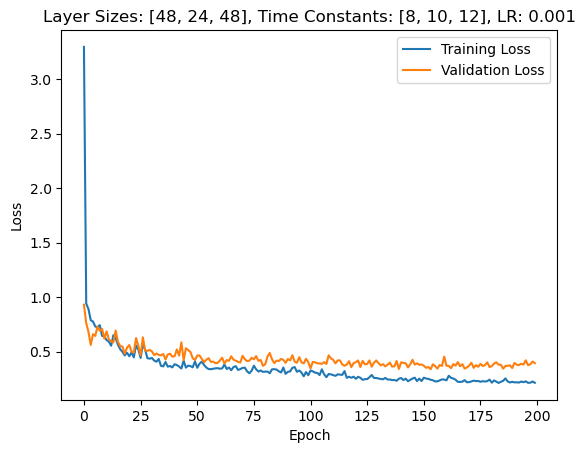

  0%|          | 1/200 [00:15<50:21, 15.18s/it]

Epoch 1/200, Training Loss: 1.0424665021446515, Validation Loss: 0.986481751714434


  1%|          | 2/200 [00:30<50:17, 15.24s/it]

Epoch 2/200, Training Loss: 1.4261360831980436, Validation Loss: 1.001406695161547


  2%|▏         | 3/200 [00:45<49:17, 15.01s/it]

Epoch 3/200, Training Loss: 0.9583412948644386, Validation Loss: 0.6446943091494697


  2%|▏         | 4/200 [00:59<47:48, 14.64s/it]

Epoch 4/200, Training Loss: 0.8517839931092173, Validation Loss: 0.4405493310519627


  2%|▎         | 5/200 [01:13<47:23, 14.58s/it]

Epoch 5/200, Training Loss: 0.7593303958200058, Validation Loss: 0.5052115448883602


  3%|▎         | 6/200 [01:29<48:21, 14.95s/it]

Epoch 6/200, Training Loss: 0.7452948543260682, Validation Loss: 0.7287724081959043


  4%|▎         | 7/200 [01:44<48:26, 15.06s/it]

Epoch 7/200, Training Loss: 0.7063152677607987, Validation Loss: 1.0129717183964593


  4%|▍         | 8/200 [02:00<48:51, 15.27s/it]

Epoch 8/200, Training Loss: 0.7250890304457467, Validation Loss: 0.6272304547684533


  4%|▍         | 9/200 [02:15<47:59, 15.07s/it]

Epoch 9/200, Training Loss: 0.6721908275811177, Validation Loss: 0.6313308690275464


  5%|▌         | 10/200 [02:29<47:05, 14.87s/it]

Epoch 10/200, Training Loss: 0.6667877705592029, Validation Loss: 0.6780328920909336


  6%|▌         | 11/200 [02:44<46:49, 14.86s/it]

Epoch 11/200, Training Loss: 0.6085798194948232, Validation Loss: 0.5756272758756366


  6%|▌         | 12/200 [02:59<46:54, 14.97s/it]

Epoch 12/200, Training Loss: 1.009008431772016, Validation Loss: 0.8776599509375436


  6%|▋         | 13/200 [03:13<46:03, 14.78s/it]

Epoch 13/200, Training Loss: 0.770852581510004, Validation Loss: 0.6633986873286111


  7%|▋         | 14/200 [03:29<46:36, 15.03s/it]

Epoch 14/200, Training Loss: 0.5999121435408322, Validation Loss: 0.6172683068684169


  8%|▊         | 15/200 [03:44<46:38, 15.13s/it]

Epoch 15/200, Training Loss: 0.6014441246131681, Validation Loss: 0.7509620626057897


  8%|▊         | 16/200 [03:59<46:21, 15.12s/it]

Epoch 16/200, Training Loss: 0.5820547918666084, Validation Loss: 0.5917032999651772


  8%|▊         | 17/200 [04:14<46:01, 15.09s/it]

Epoch 17/200, Training Loss: 0.6020765605400193, Validation Loss: 0.627847188285419


  9%|▉         | 18/200 [04:29<45:07, 14.88s/it]

Epoch 18/200, Training Loss: 0.6206437945365906, Validation Loss: 0.6162413933447429


 10%|▉         | 19/200 [04:44<44:53, 14.88s/it]

Epoch 19/200, Training Loss: 0.5955623618836673, Validation Loss: 0.548192309481757


 10%|█         | 20/200 [04:59<45:24, 15.14s/it]

Epoch 20/200, Training Loss: 0.5590251872562012, Validation Loss: 0.4726471113307135


 10%|█         | 21/200 [05:14<44:35, 14.95s/it]

Epoch 21/200, Training Loss: 0.5641107469234826, Validation Loss: 0.702003504548754


 11%|█         | 22/200 [05:28<43:32, 14.68s/it]

Epoch 22/200, Training Loss: 0.5935132666578833, Validation Loss: 0.4559389523097447


 12%|█▏        | 23/200 [05:43<43:34, 14.77s/it]

Epoch 23/200, Training Loss: 0.5263712259958375, Validation Loss: 0.5887116066047123


 12%|█▏        | 24/200 [05:58<43:06, 14.69s/it]

Epoch 24/200, Training Loss: 0.5748815761422211, Validation Loss: 0.6546809694596699


 12%|█▎        | 25/200 [06:12<42:24, 14.54s/it]

Epoch 25/200, Training Loss: 0.560910091085254, Validation Loss: 0.7442647431577954


 13%|█▎        | 26/200 [06:26<41:58, 14.47s/it]

Epoch 26/200, Training Loss: 0.5535701949079082, Validation Loss: 0.6747577892882484


 14%|█▎        | 27/200 [06:40<41:24, 14.36s/it]

Epoch 27/200, Training Loss: 0.5504217012873236, Validation Loss: 0.6085773365838187


 14%|█▍        | 28/200 [06:54<41:00, 14.30s/it]

Epoch 28/200, Training Loss: 0.5802193598927192, Validation Loss: 0.5504350257771355


 14%|█▍        | 29/200 [07:09<40:51, 14.33s/it]

Epoch 29/200, Training Loss: 0.5698397508207357, Validation Loss: 0.703135432941573


 15%|█▌        | 30/200 [07:22<39:52, 14.07s/it]

Epoch 30/200, Training Loss: 0.5235948278656546, Validation Loss: 0.6387623750737735


 16%|█▌        | 31/200 [07:37<39:55, 14.17s/it]

Epoch 31/200, Training Loss: 0.5457261890735267, Validation Loss: 0.6460828908852169


 16%|█▌        | 32/200 [07:52<40:25, 14.44s/it]

Epoch 32/200, Training Loss: 0.6011067122783301, Validation Loss: 0.6296314533267703


 16%|█▋        | 33/200 [08:06<40:18, 14.48s/it]

Epoch 33/200, Training Loss: 0.5539737355034307, Validation Loss: 0.6132496914693287


 17%|█▋        | 34/200 [08:22<40:59, 14.81s/it]

Epoch 34/200, Training Loss: 0.5319325114196202, Validation Loss: 0.5749494497265134


 18%|█▊        | 35/200 [08:36<40:34, 14.75s/it]

Epoch 35/200, Training Loss: 0.502492719663764, Validation Loss: 0.6664468220302037


 18%|█▊        | 36/200 [08:50<39:40, 14.51s/it]

Epoch 36/200, Training Loss: 0.484618216190698, Validation Loss: 0.6576407509190696


 18%|█▊        | 37/200 [09:05<39:18, 14.47s/it]

Epoch 37/200, Training Loss: 0.5314045301023519, Validation Loss: 0.5136766518865313


 19%|█▉        | 38/200 [09:19<39:13, 14.53s/it]

Epoch 38/200, Training Loss: 0.5317615068183755, Validation Loss: 0.5911248752049038


 20%|█▉        | 39/200 [09:34<38:43, 14.43s/it]

Epoch 39/200, Training Loss: 0.49749540973384426, Validation Loss: 0.5575404507773263


 20%|██        | 40/200 [09:48<38:19, 14.37s/it]

Epoch 40/200, Training Loss: 0.49732515272104516, Validation Loss: 0.556994365794318


 20%|██        | 41/200 [10:02<37:52, 14.29s/it]

Epoch 41/200, Training Loss: 0.49593192507635875, Validation Loss: 0.5050582332270486


 21%|██        | 42/200 [10:16<37:23, 14.20s/it]

Epoch 42/200, Training Loss: 0.5025107613149679, Validation Loss: 0.6818250289985112


 22%|██▏       | 43/200 [10:30<37:25, 14.30s/it]

Epoch 43/200, Training Loss: 0.561459981045633, Validation Loss: 0.5687791619982038


 22%|██▏       | 44/200 [10:45<37:06, 14.28s/it]

Epoch 44/200, Training Loss: 0.49729117188813554, Validation Loss: 0.6648391527788979


 22%|██▎       | 45/200 [10:59<36:34, 14.16s/it]

Epoch 45/200, Training Loss: 0.5421257654450974, Validation Loss: 0.6317625918558666


 23%|██▎       | 46/200 [11:14<37:12, 14.50s/it]

Epoch 46/200, Training Loss: 0.4982242938482536, Validation Loss: 0.5517112846885409


 24%|██▎       | 47/200 [11:29<37:27, 14.69s/it]

Epoch 47/200, Training Loss: 0.4964377309353846, Validation Loss: 0.5561382089342389


 24%|██▍       | 48/200 [11:43<36:41, 14.48s/it]

Epoch 48/200, Training Loss: 0.61896720416141, Validation Loss: 0.7433934190443584


 24%|██▍       | 49/200 [11:57<36:21, 14.44s/it]

Epoch 49/200, Training Loss: 0.5624163974568529, Validation Loss: 0.5050939002207347


 25%|██▌       | 50/200 [12:12<36:02, 14.42s/it]

Epoch 50/200, Training Loss: 0.5303106299548779, Validation Loss: 0.7373470195702144


 26%|██▌       | 51/200 [12:26<35:38, 14.35s/it]

Epoch 51/200, Training Loss: 0.5106671283829887, Validation Loss: 0.6331707622323718


 26%|██▌       | 52/200 [12:40<35:03, 14.22s/it]

Epoch 52/200, Training Loss: 0.5316713179619807, Validation Loss: 0.473736509680748


 26%|██▋       | 53/200 [12:54<34:53, 14.24s/it]

Epoch 53/200, Training Loss: 0.5422132653447816, Validation Loss: 0.5255526325532368


 27%|██▋       | 54/200 [13:09<34:56, 14.36s/it]

Epoch 54/200, Training Loss: 0.5200526784613447, Validation Loss: 0.5096305779048375


 28%|██▊       | 55/200 [13:23<34:59, 14.48s/it]

Epoch 55/200, Training Loss: 0.45694694232265903, Validation Loss: 0.6118155802999224


 28%|██▊       | 56/200 [13:38<34:52, 14.53s/it]

Epoch 56/200, Training Loss: 0.49891578026537625, Validation Loss: 0.4792506311620985


 28%|██▊       | 57/200 [13:52<34:18, 14.39s/it]

Epoch 57/200, Training Loss: 0.47819203335159227, Validation Loss: 0.5312639858041491


 29%|██▉       | 58/200 [14:08<34:47, 14.70s/it]

Epoch 58/200, Training Loss: 0.4905132780659874, Validation Loss: 0.5336394054549081


 30%|██▉       | 59/200 [14:22<34:21, 14.62s/it]

Epoch 59/200, Training Loss: 0.49163288665267657, Validation Loss: 0.6827287333352225


 30%|███       | 60/200 [14:36<33:37, 14.41s/it]

Epoch 60/200, Training Loss: 0.4728532394148269, Validation Loss: 0.6126050778797695


 30%|███       | 61/200 [14:51<33:39, 14.53s/it]

Epoch 61/200, Training Loss: 0.5464665302128162, Validation Loss: 0.5041356044156211


 31%|███       | 62/200 [15:05<33:23, 14.52s/it]

Epoch 62/200, Training Loss: 0.49714133368348173, Validation Loss: 0.5245268855776105


 32%|███▏      | 63/200 [15:20<32:59, 14.45s/it]

Epoch 63/200, Training Loss: 0.49906129094789614, Validation Loss: 0.4644864116396223


 32%|███▏      | 64/200 [15:34<32:46, 14.46s/it]

Epoch 64/200, Training Loss: 0.498499813507188, Validation Loss: 0.5854764112404415


 32%|███▎      | 65/200 [15:48<32:27, 14.43s/it]

Epoch 65/200, Training Loss: 0.5525987125792593, Validation Loss: 0.6365670604365212


 33%|███▎      | 66/200 [16:03<32:37, 14.61s/it]

Epoch 66/200, Training Loss: 0.4700958655690247, Validation Loss: 0.6108831805842263


 34%|███▎      | 67/200 [16:18<32:29, 14.65s/it]

Epoch 67/200, Training Loss: 0.5416767403202237, Validation Loss: 0.583533797945295


 34%|███▍      | 68/200 [16:32<31:58, 14.53s/it]

Epoch 68/200, Training Loss: 0.5110367885175741, Validation Loss: 0.6189357212611607


 34%|███▍      | 69/200 [16:47<31:26, 14.40s/it]

Epoch 69/200, Training Loss: 0.4855766923360105, Validation Loss: 0.5646986067295074


 35%|███▌      | 70/200 [17:01<31:28, 14.53s/it]

Epoch 70/200, Training Loss: 0.47214658080406907, Validation Loss: 0.4921129856790815


 36%|███▌      | 71/200 [17:17<31:44, 14.76s/it]

Epoch 71/200, Training Loss: 0.5097935770480138, Validation Loss: 0.5824956212724958


 36%|███▌      | 72/200 [17:31<31:28, 14.75s/it]

Epoch 72/200, Training Loss: 0.5144052713547113, Validation Loss: 0.5996118954249791


 36%|███▋      | 73/200 [17:46<31:15, 14.77s/it]

Epoch 73/200, Training Loss: 0.503516416504698, Validation Loss: 0.5429040704454694


 37%|███▋      | 74/200 [18:00<30:41, 14.61s/it]

Epoch 74/200, Training Loss: 0.48539858803434194, Validation Loss: 0.5712808583463941


 38%|███▊      | 75/200 [18:15<30:11, 14.49s/it]

Epoch 75/200, Training Loss: 0.5116728967371976, Validation Loss: 0.5910832583904266


 38%|███▊      | 76/200 [18:29<29:47, 14.42s/it]

Epoch 76/200, Training Loss: 0.6609891984822616, Validation Loss: 0.6435244424002511


 38%|███▊      | 77/200 [18:43<29:24, 14.34s/it]

Epoch 77/200, Training Loss: 0.48623290826689525, Validation Loss: 0.5742334808622088


 39%|███▉      | 78/200 [18:58<29:16, 14.40s/it]

Epoch 78/200, Training Loss: 0.4697226159415155, Validation Loss: 0.5107194951602391


 40%|███▉      | 79/200 [19:13<29:26, 14.60s/it]

Epoch 79/200, Training Loss: 0.607866920952527, Validation Loss: 0.6492753135306495


 40%|████      | 80/200 [19:27<28:48, 14.40s/it]

Epoch 80/200, Training Loss: 0.5381858801504351, Validation Loss: 0.5093002532209668


 40%|████      | 81/200 [19:41<28:28, 14.36s/it]

Epoch 81/200, Training Loss: 0.4762135177569569, Validation Loss: 0.5084464188132968


 41%|████      | 82/200 [19:56<28:40, 14.58s/it]

Epoch 82/200, Training Loss: 0.5051439651903117, Validation Loss: 0.7289485824959618


 42%|████▏     | 83/200 [20:10<27:56, 14.33s/it]

Epoch 83/200, Training Loss: 0.4441023383219287, Validation Loss: 0.7146327751023429


 42%|████▏     | 84/200 [20:24<27:23, 14.17s/it]

Epoch 84/200, Training Loss: 0.49322379731907035, Validation Loss: 0.5753460654190609


 42%|████▎     | 85/200 [20:38<27:23, 14.29s/it]

Epoch 85/200, Training Loss: 0.4767348229322793, Validation Loss: 0.42780745029449463


 43%|████▎     | 86/200 [20:52<26:57, 14.19s/it]

Epoch 86/200, Training Loss: 0.5085405280005257, Validation Loss: 0.7040618785790035


 44%|████▎     | 87/200 [21:06<26:49, 14.24s/it]

Epoch 87/200, Training Loss: 0.5066189355445359, Validation Loss: 0.5909762935979026


 44%|████▍     | 88/200 [21:21<26:34, 14.23s/it]

Epoch 88/200, Training Loss: 0.5006193558000168, Validation Loss: 0.6300506378923144


 44%|████▍     | 89/200 [21:35<26:14, 14.19s/it]

Epoch 89/200, Training Loss: 0.5706112814961739, Validation Loss: 0.46784754736082895


 45%|████▌     | 90/200 [21:49<26:05, 14.23s/it]

Epoch 90/200, Training Loss: 0.4441634734284203, Validation Loss: 0.49954280044351307


 46%|████▌     | 91/200 [22:04<26:12, 14.43s/it]

Epoch 91/200, Training Loss: 0.46485953820201587, Validation Loss: 0.5404265714543206


 46%|████▌     | 92/200 [22:18<25:51, 14.37s/it]

Epoch 92/200, Training Loss: 0.48632196294811536, Validation Loss: 0.7756899786846978


 46%|████▋     | 93/200 [22:32<25:29, 14.30s/it]

Epoch 93/200, Training Loss: 0.5500748123762742, Validation Loss: 0.6756801626511982


 47%|████▋     | 94/200 [22:48<25:55, 14.68s/it]

Epoch 94/200, Training Loss: 0.48001646208313276, Validation Loss: 0.6471620968409947


 48%|████▊     | 95/200 [23:02<25:27, 14.55s/it]

Epoch 95/200, Training Loss: 0.499462587653466, Validation Loss: 0.5704737773963383


 48%|████▊     | 96/200 [23:16<24:48, 14.31s/it]

Epoch 96/200, Training Loss: 0.47378079058989037, Validation Loss: 0.5652234128543309


 48%|████▊     | 97/200 [23:30<24:43, 14.40s/it]

Epoch 97/200, Training Loss: 0.48097426120964987, Validation Loss: 0.6043093630245754


 49%|████▉     | 98/200 [23:44<24:17, 14.29s/it]

Epoch 98/200, Training Loss: 0.5554983098551912, Validation Loss: 0.6245332935026714


 50%|████▉     | 99/200 [23:58<23:45, 14.12s/it]

Epoch 99/200, Training Loss: 0.5900446030328859, Validation Loss: 0.6618854807955878


 50%|█████     | 100/200 [24:12<23:30, 14.10s/it]

Epoch 100/200, Training Loss: 0.5658508041557276, Validation Loss: 0.5753231474331447


 50%|█████     | 101/200 [24:26<23:02, 13.97s/it]

Epoch 101/200, Training Loss: 0.4648824969552598, Validation Loss: 0.463347498859678


 51%|█████     | 102/200 [24:40<22:52, 14.00s/it]

Epoch 102/200, Training Loss: 0.5248452551522345, Validation Loss: 0.5412520297936031


 52%|█████▏    | 103/200 [24:55<22:53, 14.16s/it]

Epoch 103/200, Training Loss: 0.47117318128639796, Validation Loss: 0.5033268332481384


 52%|█████▏    | 104/200 [25:09<22:50, 14.28s/it]

Epoch 104/200, Training Loss: 0.46638129848354265, Validation Loss: 0.5332794934511185


 52%|█████▎    | 105/200 [25:23<22:38, 14.30s/it]

Epoch 105/200, Training Loss: 0.44759581308319885, Validation Loss: 0.6065590935094016


 53%|█████▎    | 106/200 [25:39<22:59, 14.68s/it]

Epoch 106/200, Training Loss: 0.522900901031944, Validation Loss: 0.42741372755595614


 54%|█████▎    | 107/200 [25:53<22:30, 14.52s/it]

Epoch 107/200, Training Loss: 0.5649450598460324, Validation Loss: 0.6843728082520621


 54%|█████▍    | 108/200 [26:07<21:56, 14.31s/it]

Epoch 108/200, Training Loss: 0.4572709149347161, Validation Loss: 0.5982339637620109


 55%|█████▍    | 109/200 [26:21<21:42, 14.31s/it]

Epoch 109/200, Training Loss: 0.4985817294075804, Validation Loss: 0.47769934790475027


 55%|█████▌    | 110/200 [26:35<21:23, 14.26s/it]

Epoch 110/200, Training Loss: 0.4574573910180128, Validation Loss: 0.7685086003371647


 56%|█████▌    | 111/200 [26:49<20:54, 14.09s/it]

Epoch 111/200, Training Loss: 0.4839289905327671, Validation Loss: 0.6020812307085309


 56%|█████▌    | 112/200 [27:03<20:41, 14.10s/it]

Epoch 112/200, Training Loss: 0.4822361323068727, Validation Loss: 0.5123925421919141


 56%|█████▋    | 113/200 [27:18<20:33, 14.18s/it]

Epoch 113/200, Training Loss: 0.44357380692688925, Validation Loss: 0.607398407799857


 57%|█████▋    | 114/200 [27:32<20:24, 14.24s/it]

Epoch 114/200, Training Loss: 0.46048676461543675, Validation Loss: 0.6359428869826453


 57%|█████▊    | 115/200 [27:47<20:35, 14.54s/it]

Epoch 115/200, Training Loss: 0.5257031481783345, Validation Loss: 0.49694277559007916


 58%|█████▊    | 116/200 [28:02<20:17, 14.49s/it]

Epoch 116/200, Training Loss: 0.4645024805136447, Validation Loss: 0.5871254205703735


 58%|█████▊    | 117/200 [28:16<19:54, 14.40s/it]

Epoch 117/200, Training Loss: 0.4589352790477141, Validation Loss: 0.5628596671989986


 59%|█████▉    | 118/200 [28:31<20:05, 14.70s/it]

Epoch 118/200, Training Loss: 0.42728412657413845, Validation Loss: 0.6188167546476636


 60%|█████▉    | 119/200 [28:46<19:45, 14.63s/it]

Epoch 119/200, Training Loss: 0.43544602365988605, Validation Loss: 0.5386257980551038


 60%|██████    | 120/200 [29:00<19:12, 14.41s/it]

Epoch 120/200, Training Loss: 0.466536745710193, Validation Loss: 0.45757112545626505


 60%|██████    | 121/200 [29:14<18:48, 14.28s/it]

Epoch 121/200, Training Loss: 0.4774480744634034, Validation Loss: 0.5326177137238639


 61%|██████    | 122/200 [29:28<18:31, 14.25s/it]

Epoch 122/200, Training Loss: 0.47847714148602394, Validation Loss: 0.6430799237319401


 62%|██████▏   | 123/200 [29:42<18:06, 14.11s/it]

Epoch 123/200, Training Loss: 0.4470015258159278, Validation Loss: 0.5919222448553357


 62%|██████▏   | 124/200 [29:56<17:54, 14.14s/it]

Epoch 124/200, Training Loss: 0.4626251923025779, Validation Loss: 0.5660349982125419


 62%|██████▎   | 125/200 [30:10<17:34, 14.06s/it]

Epoch 125/200, Training Loss: 0.44254269183806655, Validation Loss: 0.5814554946763175


 63%|██████▎   | 126/200 [30:24<17:22, 14.08s/it]

Epoch 126/200, Training Loss: 0.46014772945979854, Validation Loss: 0.5914092106478555


 64%|██████▎   | 127/200 [30:38<17:21, 14.27s/it]

Epoch 127/200, Training Loss: 0.44510057709127104, Validation Loss: 0.6801396906375885


 64%|██████▍   | 128/200 [30:53<17:03, 14.22s/it]

Epoch 128/200, Training Loss: 0.6330482470539381, Validation Loss: 0.578710675239563


 64%|██████▍   | 129/200 [31:06<16:37, 14.05s/it]

Epoch 129/200, Training Loss: 0.6608082517138067, Validation Loss: 0.5566576548985073


 65%|██████▌   | 130/200 [31:21<16:38, 14.27s/it]

Epoch 130/200, Training Loss: 0.4838821764262217, Validation Loss: 0.5619440589632306


 66%|██████▌   | 131/200 [31:36<16:35, 14.43s/it]

Epoch 131/200, Training Loss: 0.44394492372026984, Validation Loss: 0.5590072274208069


 66%|██████▌   | 132/200 [31:50<16:18, 14.39s/it]

Epoch 132/200, Training Loss: 0.46610101185879615, Validation Loss: 0.5200762535844531


 66%|██████▋   | 133/200 [32:04<16:02, 14.37s/it]

Epoch 133/200, Training Loss: 0.4506508823273317, Validation Loss: 0.6705697647162846


 67%|██████▋   | 134/200 [32:19<15:53, 14.45s/it]

Epoch 134/200, Training Loss: 0.5259950318426456, Validation Loss: 0.5215564455304827


 68%|██████▊   | 135/200 [32:33<15:35, 14.39s/it]

Epoch 135/200, Training Loss: 0.4785348424371683, Validation Loss: 0.5533651496682849


 68%|██████▊   | 136/200 [32:48<15:18, 14.35s/it]

Epoch 136/200, Training Loss: 0.4479845698993161, Validation Loss: 0.6401323080062866


 68%|██████▊   | 137/200 [33:02<15:10, 14.45s/it]

Epoch 137/200, Training Loss: 0.6290946670298306, Validation Loss: 0.4865997689110892


 69%|██████▉   | 138/200 [33:17<15:07, 14.64s/it]

Epoch 138/200, Training Loss: 0.45261967491428806, Validation Loss: 0.6113952717610768


 70%|██████▉   | 139/200 [33:33<15:10, 14.93s/it]

Epoch 139/200, Training Loss: 0.43195673317279454, Validation Loss: 0.5637299886771611


 70%|███████   | 140/200 [33:48<14:55, 14.92s/it]

Epoch 140/200, Training Loss: 0.41832819524801, Validation Loss: 0.53984563265528


 70%|███████   | 141/200 [34:03<14:36, 14.86s/it]

Epoch 141/200, Training Loss: 0.47739758637716184, Validation Loss: 0.6210409019674573


 71%|███████   | 142/200 [34:18<14:41, 15.19s/it]

Epoch 142/200, Training Loss: 0.44943096727695103, Validation Loss: 0.5095299482345581


 72%|███████▏  | 143/200 [34:33<14:22, 15.13s/it]

Epoch 143/200, Training Loss: 0.4860011322318383, Validation Loss: 0.536552791084562


 72%|███████▏  | 144/200 [34:48<13:51, 14.85s/it]

Epoch 144/200, Training Loss: 0.4216946602429984, Validation Loss: 0.5967856645584106


 72%|███████▎  | 145/200 [35:03<13:42, 14.95s/it]

Epoch 145/200, Training Loss: 0.43988242014399115, Validation Loss: 0.5581837892532349


 73%|███████▎  | 146/200 [35:18<13:25, 14.91s/it]

Epoch 146/200, Training Loss: 0.5335345633749692, Validation Loss: 0.48677972171987804


 74%|███████▎  | 147/200 [35:32<12:56, 14.65s/it]

Epoch 147/200, Training Loss: 0.43498479307822463, Validation Loss: 0.4519935633455004


 74%|███████▍  | 148/200 [35:46<12:38, 14.58s/it]

Epoch 148/200, Training Loss: 0.42067589287487966, Validation Loss: 0.529029688664845


 74%|███████▍  | 149/200 [36:01<12:23, 14.59s/it]

Epoch 149/200, Training Loss: 0.49428008806030704, Validation Loss: 0.4350655674934387


 75%|███████▌  | 150/200 [36:16<12:13, 14.67s/it]

Epoch 150/200, Training Loss: 0.42232648550339463, Validation Loss: 0.4843630705560957


 76%|███████▌  | 151/200 [36:31<12:13, 14.96s/it]

Epoch 151/200, Training Loss: 0.4751154437380017, Validation Loss: 0.5370366488184247


 76%|███████▌  | 152/200 [36:46<11:48, 14.76s/it]

Epoch 152/200, Training Loss: 0.44398663094583546, Validation Loss: 0.4889484303338187


 76%|███████▋  | 153/200 [37:00<11:33, 14.76s/it]

Epoch 153/200, Training Loss: 0.46972568895456923, Validation Loss: 0.6070675381592342


 77%|███████▋  | 154/200 [37:16<11:36, 15.13s/it]

Epoch 154/200, Training Loss: 0.4124565582792714, Validation Loss: 0.49649033163275036


 78%|███████▊  | 155/200 [37:32<11:23, 15.19s/it]

Epoch 155/200, Training Loss: 0.43813234848796195, Validation Loss: 0.4692252618925912


 78%|███████▊  | 156/200 [37:46<10:59, 14.98s/it]

Epoch 156/200, Training Loss: 0.4427061863946465, Validation Loss: 0.5423673817089626


 78%|███████▊  | 157/200 [38:01<10:40, 14.89s/it]

Epoch 157/200, Training Loss: 0.44582953261879255, Validation Loss: 0.5186856985092163


 79%|███████▉  | 158/200 [38:15<10:16, 14.69s/it]

Epoch 158/200, Training Loss: 0.4397215865693002, Validation Loss: 0.5167186302798135


 80%|███████▉  | 159/200 [38:29<09:59, 14.61s/it]

Epoch 159/200, Training Loss: 0.4165272915138389, Validation Loss: 0.4886243407215391


 80%|████████  | 160/200 [38:44<09:46, 14.67s/it]

Epoch 160/200, Training Loss: 0.40041938705264396, Validation Loss: 0.5567755017961774


 80%|████████  | 161/200 [38:59<09:27, 14.56s/it]

Epoch 161/200, Training Loss: 0.4175708833730446, Validation Loss: 0.4326856051172529


 81%|████████  | 162/200 [39:14<09:19, 14.73s/it]

Epoch 162/200, Training Loss: 0.49850702201420405, Validation Loss: 0.5144147915499551


 82%|████████▏ | 163/200 [39:30<09:25, 15.29s/it]

Epoch 163/200, Training Loss: 0.44627404690913436, Validation Loss: 0.4383014908858708


 82%|████████▏ | 164/200 [39:45<09:00, 15.01s/it]

Epoch 164/200, Training Loss: 0.4457231214586294, Validation Loss: 0.5111716517380306


 82%|████████▎ | 165/200 [40:00<08:46, 15.03s/it]

Epoch 165/200, Training Loss: 0.4238713470832357, Validation Loss: 0.563562674181802


 83%|████████▎ | 166/200 [40:15<08:29, 14.99s/it]

Epoch 166/200, Training Loss: 0.4456500346368214, Validation Loss: 0.505159854888916


 84%|████████▎ | 167/200 [40:29<08:05, 14.70s/it]

Epoch 167/200, Training Loss: 0.40830512457298784, Validation Loss: 0.5109515275274005


 84%|████████▍ | 168/200 [40:43<07:43, 14.50s/it]

Epoch 168/200, Training Loss: 0.410070131128689, Validation Loss: 0.431818174464362


 84%|████████▍ | 169/200 [40:58<07:33, 14.61s/it]

Epoch 169/200, Training Loss: 0.42126966942593735, Validation Loss: 0.4430417631353651


 85%|████████▌ | 170/200 [41:12<07:13, 14.45s/it]

Epoch 170/200, Training Loss: 0.41587149590816136, Validation Loss: 0.46336138248443604


 86%|████████▌ | 171/200 [41:26<06:56, 14.36s/it]

Epoch 171/200, Training Loss: 0.43571179514785985, Validation Loss: 0.41909865396363394


 86%|████████▌ | 172/200 [41:41<06:46, 14.53s/it]

Epoch 172/200, Training Loss: 0.39800516424595184, Validation Loss: 0.4486524931022099


 86%|████████▋ | 173/200 [41:56<06:36, 14.68s/it]

Epoch 173/200, Training Loss: 0.4063636243062199, Validation Loss: 0.4459963951792036


 87%|████████▋ | 174/200 [42:11<06:25, 14.82s/it]

Epoch 174/200, Training Loss: 0.42510524251550996, Validation Loss: 0.519969425031117


 88%|████████▊ | 175/200 [42:26<06:12, 14.89s/it]

Epoch 175/200, Training Loss: 0.42309881971692137, Validation Loss: 0.5403812527656555


 88%|████████▊ | 176/200 [42:40<05:53, 14.72s/it]

Epoch 176/200, Training Loss: 0.4193657968404158, Validation Loss: 0.5261489748954773


 88%|████████▊ | 177/200 [42:56<05:42, 14.90s/it]

Epoch 177/200, Training Loss: 0.4335659362797467, Validation Loss: 0.5185423578534808


 89%|████████▉ | 178/200 [43:11<05:29, 14.96s/it]

Epoch 178/200, Training Loss: 0.4069601688182579, Validation Loss: 0.41795981356075834


 90%|████████▉ | 179/200 [43:25<05:10, 14.76s/it]

Epoch 179/200, Training Loss: 0.42585116793524547, Validation Loss: 0.5139934548309871


 90%|█████████ | 180/200 [43:40<04:54, 14.71s/it]

Epoch 180/200, Training Loss: 0.43728509882711014, Validation Loss: 0.5215541550091335


 90%|█████████ | 181/200 [43:55<04:41, 14.81s/it]

Epoch 181/200, Training Loss: 0.39526569168522674, Validation Loss: 0.5751502982207707


 91%|█████████ | 182/200 [44:09<04:25, 14.76s/it]

Epoch 182/200, Training Loss: 0.4189689706237811, Validation Loss: 0.4806357536997114


 92%|█████████▏| 183/200 [44:24<04:12, 14.83s/it]

Epoch 183/200, Training Loss: 0.39756130778564597, Validation Loss: 0.49884923866816927


 92%|█████████▏| 184/200 [44:39<03:58, 14.91s/it]

Epoch 184/200, Training Loss: 0.42366634140599446, Validation Loss: 0.49129949297223774


 92%|█████████▎| 185/200 [44:55<03:45, 15.01s/it]

Epoch 185/200, Training Loss: 0.3971700702073439, Validation Loss: 0.4825130445616586


 93%|█████████▎| 186/200 [45:10<03:30, 15.07s/it]

Epoch 186/200, Training Loss: 0.4123435546204729, Validation Loss: 0.504547655582428


 94%|█████████▎| 187/200 [45:25<03:14, 14.98s/it]

Epoch 187/200, Training Loss: 0.4262758459684984, Validation Loss: 0.4289696791342327


 94%|█████████▍| 188/200 [45:40<02:59, 14.97s/it]

Epoch 188/200, Training Loss: 0.41200702651491705, Validation Loss: 0.5342144455228534


 94%|█████████▍| 189/200 [45:55<02:44, 14.98s/it]

Epoch 189/200, Training Loss: 0.4129330153172871, Validation Loss: 0.4551132321357727


 95%|█████████▌| 190/200 [46:09<02:28, 14.82s/it]

Epoch 190/200, Training Loss: 0.4039223137891518, Validation Loss: 0.5026938915252686


 96%|█████████▌| 191/200 [46:23<02:11, 14.64s/it]

Epoch 191/200, Training Loss: 0.40673827647038224, Validation Loss: 0.5869523371968951


 96%|█████████▌| 192/200 [46:38<01:57, 14.63s/it]

Epoch 192/200, Training Loss: 0.42446657790327974, Validation Loss: 0.5181001595088414


 96%|█████████▋| 193/200 [46:53<01:42, 14.70s/it]

Epoch 193/200, Training Loss: 0.4494961365213934, Validation Loss: 0.454374475138528


 97%|█████████▋| 194/200 [47:07<01:27, 14.55s/it]

Epoch 194/200, Training Loss: 0.40317871801133426, Validation Loss: 0.48543440444128855


 98%|█████████▊| 195/200 [47:22<01:13, 14.72s/it]

Epoch 195/200, Training Loss: 0.4311829749143349, Validation Loss: 0.523515122277396


 98%|█████████▊| 196/200 [47:37<00:58, 14.71s/it]

Epoch 196/200, Training Loss: 0.391538512313141, Validation Loss: 0.5374726269926343


 98%|█████████▊| 197/200 [47:52<00:44, 14.84s/it]

Epoch 197/200, Training Loss: 0.40407695073001787, Validation Loss: 0.4514875965459006


 99%|█████████▉| 198/200 [48:08<00:30, 15.39s/it]

Epoch 198/200, Training Loss: 0.4023177637806479, Validation Loss: 0.4736354947090149


100%|█████████▉| 199/200 [48:23<00:15, 15.15s/it]

Epoch 199/200, Training Loss: 0.4354056010268769, Validation Loss: 0.4749622770718166


100%|██████████| 200/200 [48:38<00:00, 14.59s/it]

Epoch 200/200, Training Loss: 0.4003793034913405, Validation Loss: 0.4686714027609144
Final Accuracy: 88.88%, Precision: 0.89, Recall: 0.88


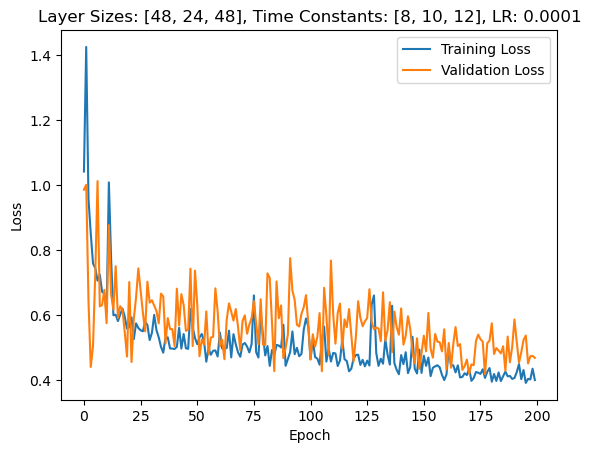

In [8]:
import itertools
import pickle
import numpy as np
from sklearn.metrics import precision_score, recall_score
import wandb
from torch.nn import MSELoss
from torch.optim import Adam
from tqdm import trange
import matplotlib.pyplot as plt
from rockpool.nn.modules.sinabs.lif_exodus import LIFExodus


# Parameter grid
param_grid = {
    'size_hidden_layers': [
        [24, 24, 24], [32, 32, 32], [48, 48, 48], [24, 48, 24], [48, 24, 48]
    ],
    'time_constants_per_layer': [
        [2, 4, 8], [4, 8, 10], [8, 10, 12]
    ],
    'learning_rate': [1e-3, 1e-4]
}

param_combinations = list(itertools.product(
    param_grid['size_hidden_layers'],
    param_grid['time_constants_per_layer'],
    param_grid['learning_rate']
))

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")  

for size_hidden_layers, time_constants_per_layer, learning_rate in param_combinations:
    
    wandb.init(
        project="baseline_grid_search",  
        config={
            "learning_rate": learning_rate,
            "size_hidden_layers": size_hidden_layers,
            "time_constants_per_layer": time_constants_per_layer,
            "architecture": "SNN",
            "dataset": "Meerkat calls",
            "epochs": 200,
            "target_class_potential": 1,
            "non_target_class_potential": -1,
            "packages": ["torch", "numpy", "pickle", "wandb"]
        }
    )

    config = wandb.config

    torch.manual_seed(seed)
    #torch.cuda.manual_seed(seed)

    # Initialize model 
    baseline = SynNet(
        output="vmem",
        n_channels=16,                        
        n_classes=1,
        dt=10e-3,                           
        size_hidden_layers=size_hidden_layers,        
        time_constants_per_layer=time_constants_per_layer,
        tau_syn_base=0.02,  
        tau_mem=0.02,
        tau_syn_out=0.02,
        #neuron_model=LIFExodus
    ).to(device)

    # Hyperparameters
    n_epochs = config.epochs
    target_class_potential = config.target_class_potential
    non_target_class_potential = config.non_target_class_potential

    optimizer = Adam(baseline.parameters().astorch(), lr=learning_rate)
    loss_fun = MSELoss()

    # Store losses and metrics for plotting
    train_losses = []
    val_losses = []
    membrane_potentials = []
    spike_outputs = []
    synaptic_currents = []

    predictions = []
    ground_truths = []

    # Training phase
    for epoch in trange(n_epochs):
        baseline.train()
        epoch_loss = 0
        for batch in train_loader:
            inputs, labels = batch
            inputs = inputs.permute(0, 2, 1).to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs, _, _ = baseline(inputs, record=True)
            outputs_vmem = outputs[:, -1, :].to(device) # Last time step along the time axis

            # Target membrane potential values
            target_membrane_potential = torch.zeros_like(outputs_vmem).to(device)
            target_membrane_potential[labels == 1] = target_class_potential  # Target class
            target_membrane_potential[labels == 0] = non_target_class_potential  # Non-target class

            # Compute loss
            loss = loss_fun(outputs_vmem, target_membrane_potential)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            if epoch == n_epochs - 1:
                predictions.append(outputs_vmem.detach().cpu().numpy())  # Final output
                ground_truths.append(labels.cpu().numpy()) 
            
             # Access internal layer membrane potentials, spikes, synaptic currents
            for lyr_name in baseline.lif_names:
                lyr = baseline.seq[lyr_name]

                v_mem = lyr.vmem.detach().cpu().numpy()  
                spikes = lyr.spikes.detach().cpu().numpy()  
                i_syn = lyr.isyn.detach().cpu().numpy()  

                membrane_potentials.append(v_mem)
                spike_outputs.append(spikes)
                synaptic_currents.append(i_syn)


        train_losses.append(epoch_loss / len(train_loader))

        # Validation phase
        baseline.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs, labels = batch
                inputs = inputs.permute(0, 2, 1).to(device)
                labels = labels.to(device)
                outputs, _, _ = baseline(inputs, record=True)
                outputs_vmem = outputs[:, -1, :].to(device)
                target_membrane_potential = torch.zeros_like(outputs_vmem).to(device)
                target_membrane_potential[labels == 1] = target_class_potential
                target_membrane_potential[labels == 0] = non_target_class_potential
                loss = loss_fun(outputs_vmem, target_membrane_potential)
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_loader))

        wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_losses[-1],
        "val_loss": val_losses[-1]
    })
        print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    # Calculate accuracy, precision, recall, etc. after the final epoch
    if predictions and ground_truths:
        # Convert the predictions to binary labels (1 for target class, 0 for non-target class)
        predicted_labels = np.where(np.concatenate(predictions) > 0, 1, 0)   
        predicted_labels = predicted_labels.flatten()

        # Flatten the ground truths array (from 2D to 1D)
        ground_truths_flat = np.concatenate(ground_truths).flatten()

        # Calculate accuracy, precision, and recall
        correct_predictions = (predicted_labels == ground_truths_flat).sum()
        total_predictions = ground_truths_flat.shape[0]
        accuracy = (correct_predictions / total_predictions) * 100

        precision = precision_score(ground_truths_flat, predicted_labels)
        recall = recall_score(ground_truths_flat, predicted_labels)

        # Log metrics and parameters to wandb
        wandb.log({
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall
        })

        print(f"Final Accuracy: {accuracy:.2f}%, Precision: {precision:.2f}, Recall: {recall:.2f}")

    # Save results for this combination
    results_folder = "baseline_results"
    output_filename = f"{results_folder}/baseline_{size_hidden_layers}_{time_constants_per_layer}_lr{learning_rate}.pkl"
    with open(output_filename, 'wb') as f:
        pickle.dump({
            'train_losses': train_losses,
            'val_losses': val_losses,
            'membrane_potentials': membrane_potentials,
            'spike_outputs': spike_outputs,              
            'synaptic_currents': synaptic_currents,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'predictions': predictions,
            'ground_truths': ground_truths
        }, f)

    # Finish the wandb run for this grid search iteration
    wandb.finish()

    # Plot training and validation loss for this run
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend() 
    plt.title(f"Layer Sizes: {size_hidden_layers}, Time Constants: {time_constants_per_layer}, LR: {learning_rate}")
    plt.show()